In [1]:
from contextlib import contextmanager
import gc
import os
from pathlib import Path
import pickle
import time

import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from lfm import calc_embeddings, calc_scores
from metric import apk, mapk
from utils import plot_images


In [2]:
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name}] {time.time() - start_time:.3f} s')

In [3]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
# class CFG:
#     model_type = 'LightGBM'
#     popular_num_items = 12
#     popular_days = 7
#     train_weeks = 1
#     repurchase_weeks = 12345
#     repurchase_num_items = 100
#     item2item_weeks = 12345
#     item2item_num_items = 24
#     cooc_weeks = 12
#     cooc_threshold = 50
#     dynamic_feature_weeks = 8
#     volume_feature_days = 7


# BEST
class CFG:
    model_type = 'CatBoost'
    popular_num_items = 36
    popular_days = 7
    train_weeks = 2
    repurchase_weeks = 123456
    repurchase_num_items = 123456
    item2item_weeks = 123456
    item2item_num_items = 24
    cooc_weeks = 12
    cooc_threshold = 50
    dynamic_feature_weeks = 8
    volume_feature_days = 7

In [5]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"create candidates (week: {week})")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            max_items_per_user: int) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("user in @target_users and @week_start <= week < @week_end")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
        ) -> pd.DataFrame:
        day_start = 7 * week_start
        tr = transactions.query("@day_start <= day < @day_start + @CFG.popular_days")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:CFG.popular_num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(CFG.popular_num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            strategy: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_num: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        week_end = week_start + week_num
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_item_count = tr.groupby('item').size().reset_index(name='item_count')
        gr_pair_count = tr.groupby(['item', 'item_with']).size().reset_index(name='pair_count')
        item2item = gr_pair_count.merge(gr_item_count, on='item')
        item2item['ratio'] = item2item['pair_count'] / item2item['item_count']
        item2item = item2item.query("pair_count > @CFG.cooc_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'pair_count'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'item_count': f'{strategy}_item_count'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_same_product_code(
            strategy: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    with timer("repurchase"):
        candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week, CFG.repurchase_weeks, CFG.repurchase_num_items)
    with timer("popular"):
        candidates_popular = create_candidates_popular('pop', transactions, target_users, week)
    with timer("item2item"):
        candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.repurchase_weeks, CFG.item2item_num_items)
    with timer("cooccurrence"):
        candidates_cooc = create_candidates_cooc('cooc', transactions, week, CFG.cooc_weeks, candidates_item2item)
    with timer("same_product_code"):
        candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_item2item)

    def create_candidates_ohe_distance(transactions, users, items, target_users, week):
        num_items = 32
        import faiss
        users_with_ohe = users[['user']].query("user in @target_users")
        cols = [c for c in items.columns if c.endswith('_idx')]
        for c in cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            cs = [c for c in tmp.columns if c.endswith('_mean')]
            users_with_ohe = users_with_ohe.merge(tmp[['user'] + cs], on='user')

        users_with_ohe = users_with_ohe.dropna().reset_index(drop=True)
        limited_users = users_with_ohe['user'].values

        recent_items = transactions.query("@week <= week < @week + 1")['item'].unique()
        items_with_ohe = pd.get_dummies(items[['item'] + cols], columns=cols)
        items_with_ohe = items_with_ohe.query("item in @recent_items").reset_index(drop=True)
        limited_items = items_with_ohe['item'].values

        item_cols = [c for c in items_with_ohe.columns if c != 'item']
        user_cols = [f'user_ohe_agg_{c}_mean' for c in item_cols]
        users_with_ohe = users_with_ohe[['user'] + user_cols]
        items_with_ohe = items_with_ohe[['item'] + item_cols]

        a_users = users_with_ohe.drop('user', axis=1).values.astype(np.float32)
        a_items = items_with_ohe.drop('item', axis=1).values.astype(np.float32)
        a_users = np.ascontiguousarray(a_users)
        a_items = np.ascontiguousarray(a_items)
        index = faiss.index_factory(a_items.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
        index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
        index.add(a_items)
        distances, idxs = index.search(a_users, num_items)

        return pd.DataFrame({
            'user': np.repeat(limited_users, num_items),
            'item': limited_items[idxs.flatten()],
            'distance': distances.flatten(),
            'strategy': 'ohe',
        })
    with timer("ohe distance"):
        candidates_ohe_distance = create_candidates_ohe_distance(transactions, users, items, target_users, week)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)


    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)
    candidates_ohe_distance = drop_common_user_item(candidates_ohe_distance, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
        candidates_ohe_distance,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [6]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

create candidates (week: 1)


[repurchase] 9.384 s


[popular] 0.479 s


[item2item] 8.341 s


[cooccurrence] 14.368 s


[same_product_code] 5.663 s


[ohe distance] 14.754 s


volume: 15991626


duplicates: 1.0552836520584024


            strategy   volume     ratio
0  same_product_code  6876142  0.429984
1         repurchase  3446562  0.215523
2                pop  2483424  0.155295
3                ohe  1981757  0.123925
4               cooc  1203741  0.075273


create candidates (week: 2)


[repurchase] 9.512 s


[popular] 0.523 s


[item2item] 8.660 s


[cooccurrence] 16.043 s


[same_product_code] 5.776 s


[ohe distance] 13.025 s


volume: 16956677


duplicates: 1.0592206643477098


            strategy   volume     ratio
0  same_product_code  7228749  0.426307
1         repurchase  3637145  0.214496
2                pop  2592684  0.152900
3                ohe  2080062  0.122669
4               cooc  1418037  0.083627


create candidates (week: 3)


[repurchase] 9.820 s


[popular] 0.557 s


[item2item] 9.116 s


[cooccurrence] 16.230 s


[same_product_code] 5.878 s


[ohe distance] 17.481 s


volume: 17930210


duplicates: 1.0620907696093247


            strategy   volume     ratio
0  same_product_code  7678831  0.428262
1         repurchase  3742824  0.208744
2                pop  2729592  0.152234
3                ohe  2188278  0.122044
4               cooc  1590685  0.088715


In [7]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"merge labels (week: {week})")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [8]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


merge labels (week: 0)


Recall: 0.14038871837101363


            strategy        y   volume    recall  hit_ratio
0                pop  11811.0  2483424  0.055262   0.004756
1         repurchase   8437.0  3446562  0.039475   0.002448
2  same_product_code   7888.0  6876142  0.036907   0.001147
3               cooc   5096.0  1203741  0.023843   0.004233
4                ohe   2440.0  1981757  0.011416   0.001231
merge labels (week: 1)


Recall: 0.13065683822561538


            strategy        y   volume    recall  hit_ratio
0                pop  10203.0  2592684  0.044768   0.003935
1         repurchase   8955.0  3637145  0.039292   0.002462
2  same_product_code   8554.0  7228749  0.037532   0.001183
3               cooc   5210.0  1418037  0.022860   0.003674
4                ohe   2680.0  2080062  0.011759   0.001288
merge labels (week: 2)


Recall: 0.13371472735367995


            strategy        y   volume    recall  hit_ratio
0                pop  11942.0  2729592  0.050161   0.004375
1         repurchase   9195.0  3742824  0.038622   0.002457
2  same_product_code   8829.0  7678831  0.037085   0.001150
3               cooc   5376.0  1590685  0.022581   0.003380
4                ohe   2526.0  2188278  0.010610   0.001154


In [9]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 15991626 -> 5450623


drop trivial queries: 16956677 -> 5718264


drop trivial queries: 17930210 -> 6126511


In [10]:
# age==25でのアイテムボリューム以上になるような幅を各年齢に対して求める
tr = transactions[['user', 'item']].merge(users[['user', 'age']], on='user')
age_volume_threshold = len(tr.query("24 <= age <= 26"))

age_volumes = {age: len(tr.query("age == @age")) for age in range(16, 100)}

age_shifts = {}
for age in range(16, 100):
    for i in range(0, 100):
        low = age - i
        high = age + i
        age_volume = 0
        for j in range(low, high+1):
            age_volume += age_volumes.get(j, 0)
        if age_volume >= age_volume_threshold:
            age_shifts[age] = i
            break
print(age_shifts)

{16: 7, 17: 6, 18: 5, 19: 4, 20: 3, 21: 2, 22: 2, 23: 2, 24: 2, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 3, 33: 3, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 6, 41: 6, 42: 5, 43: 5, 44: 5, 45: 5, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 5, 56: 5, 57: 6, 58: 7, 59: 7, 60: 8, 61: 9, 62: 10, 63: 11, 64: 12, 65: 13, 66: 14, 67: 15, 68: 16, 69: 17, 70: 18, 71: 19, 72: 20, 73: 21, 74: 22, 75: 23, 76: 24, 77: 25, 78: 26, 79: 27, 80: 28, 81: 29, 82: 30, 83: 31, 84: 32, 85: 33, 86: 34, 87: 35, 88: 36, 89: 37, 90: 38, 91: 39, 92: 40, 93: 41, 94: 42, 95: 43, 96: 44, 97: 45, 98: 46, 99: 47}


In [11]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"attach features (week: {week})")
    n_original = len(candidates)
    df = candidates.copy()

    with timer("user static fetaures"):
        user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
        df = df.merge(users[['user'] + user_features], on='user')

    with timer("item stacic features"):
        item_features = [c for c in items.columns if c.endswith('idx')]
        df = df.merge(items[['item'] + item_features], on='item')

    with timer("user dynamic features (transactions)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='user', how='left')

    with timer("item dynamic features (transactions)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item dynamic features (user features)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
        tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
        tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item freshness features"):
        tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
        tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='item', how='left')

    with timer("item volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('item').size().reset_index(name='item_volume')
        df = df.merge(tmp, on='item', how='left')

    with timer("user freshness features"):
        tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
        tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='user', how='left')

    with timer("user volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('user').size().reset_index(name='user_volume')
        df = df.merge(tmp, on='user', how='left')

    with timer("user-item freshness features"):
        tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
        tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on=['item', 'user'], how='left')

    with timer("user-item volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    with timer("item age volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tr = transactions.query("@day_start <= day < @day_end")[['user', 'item']].merge(users[['user', 'age']], on='user')
        item_age_volumes = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            tmp = tr.query("@low <= age <= @high").groupby('item').size().reset_index(name='age_volume')
            tmp['age_volume'] = tmp['age_volume'].rank(ascending=False)
            tmp['age'] = age
            item_age_volumes.append(tmp)
        item_age_volumes = pd.concat(item_age_volumes)
        df = df.merge(item_age_volumes, on=['item', 'age'], how='left')

    with timer("ohe dot products"):
        item_target_cols = [c for c in items.columns if c.endswith('_idx')]

        items_with_ohe = pd.get_dummies(items[['item'] + item_target_cols], columns=item_target_cols)

        users_with_ohe = users[['user']]
        for c in item_target_cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            assert tmp['user'].tolist() == users_with_ohe['user'].tolist()
            tmp = tmp[['user'] + [c for c in tmp.columns if c.endswith('_mean')]]
            tmp = tmp.drop('user', axis=1)
            users_with_ohe = pd.concat([users_with_ohe, tmp], axis=1)

        assert items_with_ohe['item'].tolist() == items['item'].tolist()
        assert users_with_ohe['user'].tolist() == users['user'].tolist()

        users_items = df[['user', 'item']].drop_duplicates().reset_index(drop=True)
        n_split = 10
        n_chunk = (len(users_items) + n_split - 1)// n_split
        ohe = []
        for i in range(0, len(users_items), n_chunk):
            users_items_small = users_items.iloc[i:i+n_chunk].reset_index(drop=True)
            users_small = users_items_small['user'].values
            items_small = users_items_small['item'].values

            for item_col in item_target_cols:
                i_cols = [c for c in items_with_ohe.columns if c.startswith(item_col)]
                u_cols = [f"user_ohe_agg_{c}_mean" for c in i_cols]
                users_items_small[f'{item_col}_ohe_score'] = (items_with_ohe[i_cols].values[items_small] * users_with_ohe[u_cols].values[users_small]).sum(axis=1)

            ohe_cols = [f'{col}_ohe_score' for col in item_target_cols]
            users_items_small = users_items_small[['user', 'item'] + ohe_cols]

            ohe.append(users_items_small)
        ohe = pd.concat(ohe)
        df = df.merge(ohe, on=['user', 'item'])

    with timer("lfm features"):
        user_reps, _ = calc_embeddings('i_i', dataset, pretrain_week, 16)
        df = df.merge(user_reps, on='user')



    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

attach features (week: 1)


[user static fetaures] 1.725 s


[item stacic features] 4.516 s


[user dynamic features (transactions)] 3.066 s


[item dynamic features (transactions)] 2.515 s


[item dynamic features (user features)] 3.112 s


[item freshness features] 4.579 s


[item volume features] 2.726 s


[user freshness features] 6.227 s


[user volume features] 3.243 s


[user-item freshness features] 24.440 s


[user-item volume features] 5.919 s


[item age volume features] 4.993 s


[ohe dot products] 132.069 s


[lfm features] 8.556 s
attach features (week: 1)


[user static fetaures] 0.587 s


[item stacic features] 1.383 s


[user dynamic features (transactions)] 1.233 s


[item dynamic features (transactions)] 1.032 s


[item dynamic features (user features)] 1.455 s


[item freshness features] 2.868 s


[item volume features] 0.993 s


[user freshness features] 4.119 s


[user volume features] 1.123 s


[user-item freshness features] 21.104 s


[user-item volume features] 1.875 s


[item age volume features] 2.191 s


[ohe dot products] 55.926 s


[lfm features] 3.046 s
attach features (week: 2)


[user static fetaures] 0.627 s


[item stacic features] 1.495 s


[user dynamic features (transactions)] 1.291 s


[item dynamic features (transactions)] 1.070 s


[item dynamic features (user features)] 1.571 s


[item freshness features] 2.920 s


[item volume features] 1.058 s


[user freshness features] 4.186 s


[user volume features] 1.192 s


[user-item freshness features] 21.347 s


[user-item volume features] 2.049 s


[item age volume features] 2.296 s


[ohe dot products] 59.933 s


[lfm features] 3.122 s
attach features (week: 3)


[user static fetaures] 0.686 s


[item stacic features] 1.650 s


[user dynamic features (transactions)] 1.395 s


[item dynamic features (transactions)] 1.146 s


[item dynamic features (user features)] 1.659 s


[item freshness features] 2.960 s


[item volume features] 1.137 s


[user freshness features] 4.217 s


[user volume features] 1.296 s


[user-item freshness features] 21.089 s


[user-item volume features] 2.130 s


[item age volume features] 2.403 s


[ohe dot products] 66.764 s


[lfm features] 3.643 s


In [12]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [13]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [14]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_item_count', 'cooc_ratio', 'same_product_code_item2item_week_rank', 'same_product_code_item2item_volume_rank', 'distance', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_day_min', 'user_volume', 'user_item_day_min', 'user_item_volume', 'age_volume', 'product_type_no_idx_ohe_score', 'product_group_

In [15]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [16]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

0:	test: 0.1258695	best: 0.1258695 (0)	total: 1.61s	remaining: 2h 14m 28s


1:	test: 0.1540367	best: 0.1540367 (1)	total: 3.1s	remaining: 2h 9m 6s


2:	test: 0.1971222	best: 0.1971222 (2)	total: 4.58s	remaining: 2h 7m 3s


3:	test: 0.2012627	best: 0.2012627 (3)	total: 6.06s	remaining: 2h 6m 7s


4:	test: 0.1938168	best: 0.2012627 (3)	total: 7.55s	remaining: 2h 5m 43s


5:	test: 0.1897569	best: 0.2012627 (3)	total: 9.06s	remaining: 2h 5m 45s


6:	test: 0.1902772	best: 0.2012627 (3)	total: 10.5s	remaining: 2h 5m 16s


7:	test: 0.1900091	best: 0.2012627 (3)	total: 12s	remaining: 2h 4m 55s


8:	test: 0.1909362	best: 0.2012627 (3)	total: 13.5s	remaining: 2h 4m 44s


9:	test: 0.1980683	best: 0.2012627 (3)	total: 15s	remaining: 2h 4m 39s


10:	test: 0.2134082	best: 0.2134082 (10)	total: 16.5s	remaining: 2h 4m 33s


11:	test: 0.2169553	best: 0.2169553 (11)	total: 18s	remaining: 2h 4m 29s


12:	test: 0.2368212	best: 0.2368212 (12)	total: 19.5s	remaining: 2h 4m 37s


13:	test: 0.2413323	best: 0.2413323 (13)	total: 21s	remaining: 2h 4m 48s


14:	test: 0.2418242	best: 0.2418242 (14)	total: 22.5s	remaining: 2h 4m 50s


15:	test: 0.2423820	best: 0.2423820 (15)	total: 24s	remaining: 2h 4m 47s


16:	test: 0.2492428	best: 0.2492428 (16)	total: 25.5s	remaining: 2h 4m 41s


17:	test: 0.2489602	best: 0.2492428 (16)	total: 27s	remaining: 2h 4m 36s


18:	test: 0.2495599	best: 0.2495599 (18)	total: 28.5s	remaining: 2h 4m 35s


19:	test: 0.2517153	best: 0.2517153 (19)	total: 30s	remaining: 2h 4m 36s


20:	test: 0.2516936	best: 0.2517153 (19)	total: 31.5s	remaining: 2h 4m 32s


21:	test: 0.2538324	best: 0.2538324 (21)	total: 33.1s	remaining: 2h 4m 45s


22:	test: 0.2549715	best: 0.2549715 (22)	total: 34.6s	remaining: 2h 4m 49s


23:	test: 0.2599027	best: 0.2599027 (23)	total: 36.2s	remaining: 2h 4m 57s


24:	test: 0.2609021	best: 0.2609021 (24)	total: 37.7s	remaining: 2h 4m 53s


25:	test: 0.2612830	best: 0.2612830 (25)	total: 39.1s	remaining: 2h 4m 49s


26:	test: 0.2642411	best: 0.2642411 (26)	total: 40.7s	remaining: 2h 4m 48s


27:	test: 0.2659530	best: 0.2659530 (27)	total: 42.2s	remaining: 2h 4m 47s


28:	test: 0.2667760	best: 0.2667760 (28)	total: 43.7s	remaining: 2h 4m 56s


29:	test: 0.2693353	best: 0.2693353 (29)	total: 45.3s	remaining: 2h 5m 7s


30:	test: 0.2695636	best: 0.2695636 (30)	total: 46.8s	remaining: 2h 5m 6s


31:	test: 0.2703401	best: 0.2703401 (31)	total: 48.4s	remaining: 2h 5m 14s


32:	test: 0.2712629	best: 0.2712629 (32)	total: 50s	remaining: 2h 5m 18s


33:	test: 0.2730079	best: 0.2730079 (33)	total: 51.4s	remaining: 2h 5m 12s


34:	test: 0.2737556	best: 0.2737556 (34)	total: 53s	remaining: 2h 5m 19s


35:	test: 0.2746880	best: 0.2746880 (35)	total: 54.6s	remaining: 2h 5m 24s


36:	test: 0.2753043	best: 0.2753043 (36)	total: 56.1s	remaining: 2h 5m 29s


37:	test: 0.2755341	best: 0.2755341 (37)	total: 57.7s	remaining: 2h 5m 33s


38:	test: 0.2760464	best: 0.2760464 (38)	total: 59.2s	remaining: 2h 5m 32s


39:	test: 0.2760451	best: 0.2760464 (38)	total: 1m	remaining: 2h 5m 29s


40:	test: 0.2762918	best: 0.2762918 (40)	total: 1m 2s	remaining: 2h 5m 26s


41:	test: 0.2761394	best: 0.2762918 (40)	total: 1m 3s	remaining: 2h 5m 24s


42:	test: 0.2761859	best: 0.2762918 (40)	total: 1m 5s	remaining: 2h 5m 22s


43:	test: 0.2770834	best: 0.2770834 (43)	total: 1m 6s	remaining: 2h 5m 19s


44:	test: 0.2772212	best: 0.2772212 (44)	total: 1m 8s	remaining: 2h 5m 17s


45:	test: 0.2771962	best: 0.2772212 (44)	total: 1m 9s	remaining: 2h 5m 13s


46:	test: 0.2779748	best: 0.2779748 (46)	total: 1m 11s	remaining: 2h 5m 14s


47:	test: 0.2782138	best: 0.2782138 (47)	total: 1m 12s	remaining: 2h 5m 14s


48:	test: 0.2788738	best: 0.2788738 (48)	total: 1m 14s	remaining: 2h 5m 16s


49:	test: 0.2788354	best: 0.2788738 (48)	total: 1m 15s	remaining: 2h 5m 12s


50:	test: 0.2790861	best: 0.2790861 (50)	total: 1m 17s	remaining: 2h 5m 11s


51:	test: 0.2794838	best: 0.2794838 (51)	total: 1m 18s	remaining: 2h 5m 9s


52:	test: 0.2797476	best: 0.2797476 (52)	total: 1m 20s	remaining: 2h 5m 8s


53:	test: 0.2803747	best: 0.2803747 (53)	total: 1m 21s	remaining: 2h 5m 9s


54:	test: 0.2806202	best: 0.2806202 (54)	total: 1m 23s	remaining: 2h 5m 9s


55:	test: 0.2810566	best: 0.2810566 (55)	total: 1m 25s	remaining: 2h 5m 6s


56:	test: 0.2812218	best: 0.2812218 (56)	total: 1m 26s	remaining: 2h 5m 6s


57:	test: 0.2815199	best: 0.2815199 (57)	total: 1m 28s	remaining: 2h 5m 6s


58:	test: 0.2817268	best: 0.2817268 (58)	total: 1m 29s	remaining: 2h 5m 6s


59:	test: 0.2819738	best: 0.2819738 (59)	total: 1m 31s	remaining: 2h 5m 6s


60:	test: 0.2821458	best: 0.2821458 (60)	total: 1m 32s	remaining: 2h 5m 7s


61:	test: 0.2825368	best: 0.2825368 (61)	total: 1m 34s	remaining: 2h 5m 11s


62:	test: 0.2829147	best: 0.2829147 (62)	total: 1m 35s	remaining: 2h 5m 13s


63:	test: 0.2831395	best: 0.2831395 (63)	total: 1m 37s	remaining: 2h 5m 13s


64:	test: 0.2852298	best: 0.2852298 (64)	total: 1m 38s	remaining: 2h 5m 14s


65:	test: 0.2856252	best: 0.2856252 (65)	total: 1m 40s	remaining: 2h 5m 14s


66:	test: 0.2857110	best: 0.2857110 (66)	total: 1m 42s	remaining: 2h 5m 12s


67:	test: 0.2860881	best: 0.2860881 (67)	total: 1m 43s	remaining: 2h 5m 13s


68:	test: 0.2863306	best: 0.2863306 (68)	total: 1m 45s	remaining: 2h 5m 14s


69:	test: 0.2866837	best: 0.2866837 (69)	total: 1m 46s	remaining: 2h 5m 12s


70:	test: 0.2869991	best: 0.2869991 (70)	total: 1m 48s	remaining: 2h 5m 9s


71:	test: 0.2871275	best: 0.2871275 (71)	total: 1m 49s	remaining: 2h 5m 9s


72:	test: 0.2872168	best: 0.2872168 (72)	total: 1m 51s	remaining: 2h 5m 7s


73:	test: 0.2872407	best: 0.2872407 (73)	total: 1m 52s	remaining: 2h 5m 8s


74:	test: 0.2873606	best: 0.2873606 (74)	total: 1m 54s	remaining: 2h 5m 8s


75:	test: 0.2883775	best: 0.2883775 (75)	total: 1m 55s	remaining: 2h 5m 10s


76:	test: 0.2885012	best: 0.2885012 (76)	total: 1m 57s	remaining: 2h 5m 10s


77:	test: 0.2885634	best: 0.2885634 (77)	total: 1m 58s	remaining: 2h 5m 8s


78:	test: 0.2886294	best: 0.2886294 (78)	total: 2m	remaining: 2h 5m 8s


79:	test: 0.2892254	best: 0.2892254 (79)	total: 2m 2s	remaining: 2h 5m 4s


80:	test: 0.2897937	best: 0.2897937 (80)	total: 2m 3s	remaining: 2h 5m


81:	test: 0.2898950	best: 0.2898950 (81)	total: 2m 5s	remaining: 2h 4m 59s


82:	test: 0.2899830	best: 0.2899830 (82)	total: 2m 6s	remaining: 2h 4m 57s


83:	test: 0.2900806	best: 0.2900806 (83)	total: 2m 8s	remaining: 2h 4m 54s


84:	test: 0.2901794	best: 0.2901794 (84)	total: 2m 9s	remaining: 2h 4m 49s


85:	test: 0.2904107	best: 0.2904107 (85)	total: 2m 11s	remaining: 2h 4m 49s


86:	test: 0.2905083	best: 0.2905083 (86)	total: 2m 12s	remaining: 2h 4m 46s


87:	test: 0.2907359	best: 0.2907359 (87)	total: 2m 14s	remaining: 2h 4m 49s


88:	test: 0.2905328	best: 0.2907359 (87)	total: 2m 15s	remaining: 2h 4m 48s


89:	test: 0.2906697	best: 0.2907359 (87)	total: 2m 17s	remaining: 2h 4m 46s


90:	test: 0.2909231	best: 0.2909231 (90)	total: 2m 18s	remaining: 2h 4m 45s


91:	test: 0.2911347	best: 0.2911347 (91)	total: 2m 20s	remaining: 2h 4m 42s


92:	test: 0.2914413	best: 0.2914413 (92)	total: 2m 21s	remaining: 2h 4m 40s


93:	test: 0.2916357	best: 0.2916357 (93)	total: 2m 23s	remaining: 2h 4m 40s


94:	test: 0.2916386	best: 0.2916386 (94)	total: 2m 24s	remaining: 2h 4m 41s


95:	test: 0.2920679	best: 0.2920679 (95)	total: 2m 26s	remaining: 2h 4m 42s


96:	test: 0.2920409	best: 0.2920679 (95)	total: 2m 27s	remaining: 2h 4m 40s


97:	test: 0.2924231	best: 0.2924231 (97)	total: 2m 29s	remaining: 2h 4m 38s


98:	test: 0.2926001	best: 0.2926001 (98)	total: 2m 31s	remaining: 2h 4m 39s


99:	test: 0.2930973	best: 0.2930973 (99)	total: 2m 32s	remaining: 2h 4m 37s


100:	test: 0.2934698	best: 0.2934698 (100)	total: 2m 34s	remaining: 2h 4m 35s


101:	test: 0.2936090	best: 0.2936090 (101)	total: 2m 35s	remaining: 2h 4m 33s


102:	test: 0.2936845	best: 0.2936845 (102)	total: 2m 37s	remaining: 2h 4m 29s


103:	test: 0.2935359	best: 0.2936845 (102)	total: 2m 38s	remaining: 2h 4m 29s


104:	test: 0.2936765	best: 0.2936845 (102)	total: 2m 40s	remaining: 2h 4m 28s


105:	test: 0.2937841	best: 0.2937841 (105)	total: 2m 41s	remaining: 2h 4m 28s


106:	test: 0.2939188	best: 0.2939188 (106)	total: 2m 43s	remaining: 2h 4m 27s


107:	test: 0.2940118	best: 0.2940118 (107)	total: 2m 44s	remaining: 2h 4m 25s


108:	test: 0.2939738	best: 0.2940118 (107)	total: 2m 46s	remaining: 2h 4m 22s


109:	test: 0.2940786	best: 0.2940786 (109)	total: 2m 47s	remaining: 2h 4m 20s


110:	test: 0.2942154	best: 0.2942154 (110)	total: 2m 49s	remaining: 2h 4m 17s


111:	test: 0.2945625	best: 0.2945625 (111)	total: 2m 50s	remaining: 2h 4m 17s


112:	test: 0.2947861	best: 0.2947861 (112)	total: 2m 52s	remaining: 2h 4m 14s


113:	test: 0.2949545	best: 0.2949545 (113)	total: 2m 53s	remaining: 2h 4m 14s


114:	test: 0.2950888	best: 0.2950888 (114)	total: 2m 55s	remaining: 2h 4m 13s


115:	test: 0.2954905	best: 0.2954905 (115)	total: 2m 57s	remaining: 2h 4m 12s


116:	test: 0.2955045	best: 0.2955045 (116)	total: 2m 58s	remaining: 2h 4m 7s


117:	test: 0.2957460	best: 0.2957460 (117)	total: 2m 59s	remaining: 2h 4m 6s


118:	test: 0.2959807	best: 0.2959807 (118)	total: 3m 1s	remaining: 2h 4m 6s


119:	test: 0.2962783	best: 0.2962783 (119)	total: 3m 3s	remaining: 2h 4m 3s


120:	test: 0.2962876	best: 0.2962876 (120)	total: 3m 4s	remaining: 2h 4m 2s


121:	test: 0.2965623	best: 0.2965623 (121)	total: 3m 6s	remaining: 2h 4m


122:	test: 0.2967988	best: 0.2967988 (122)	total: 3m 7s	remaining: 2h 3m 57s


123:	test: 0.2969486	best: 0.2969486 (123)	total: 3m 9s	remaining: 2h 3m 56s


124:	test: 0.2971095	best: 0.2971095 (124)	total: 3m 10s	remaining: 2h 3m 54s


125:	test: 0.2971360	best: 0.2971360 (125)	total: 3m 12s	remaining: 2h 3m 50s


126:	test: 0.2973435	best: 0.2973435 (126)	total: 3m 13s	remaining: 2h 3m 50s


127:	test: 0.2974363	best: 0.2974363 (127)	total: 3m 15s	remaining: 2h 3m 51s


128:	test: 0.2975505	best: 0.2975505 (128)	total: 3m 16s	remaining: 2h 3m 50s


129:	test: 0.2977411	best: 0.2977411 (129)	total: 3m 18s	remaining: 2h 3m 48s


130:	test: 0.2978195	best: 0.2978195 (130)	total: 3m 19s	remaining: 2h 3m 48s


131:	test: 0.2981174	best: 0.2981174 (131)	total: 3m 21s	remaining: 2h 3m 48s


132:	test: 0.2982074	best: 0.2982074 (132)	total: 3m 22s	remaining: 2h 3m 43s


133:	test: 0.2983951	best: 0.2983951 (133)	total: 3m 24s	remaining: 2h 3m 42s


134:	test: 0.2986083	best: 0.2986083 (134)	total: 3m 25s	remaining: 2h 3m 41s


135:	test: 0.2985655	best: 0.2986083 (134)	total: 3m 27s	remaining: 2h 3m 39s


136:	test: 0.2987513	best: 0.2987513 (136)	total: 3m 28s	remaining: 2h 3m 37s


137:	test: 0.2989754	best: 0.2989754 (137)	total: 3m 30s	remaining: 2h 3m 35s


138:	test: 0.2991739	best: 0.2991739 (138)	total: 3m 32s	remaining: 2h 3m 36s


139:	test: 0.2993034	best: 0.2993034 (139)	total: 3m 33s	remaining: 2h 3m 33s


140:	test: 0.2995048	best: 0.2995048 (140)	total: 3m 35s	remaining: 2h 3m 32s


141:	test: 0.2995073	best: 0.2995073 (141)	total: 3m 36s	remaining: 2h 3m 30s


142:	test: 0.2997184	best: 0.2997184 (142)	total: 3m 38s	remaining: 2h 3m 31s


143:	test: 0.2998900	best: 0.2998900 (143)	total: 3m 39s	remaining: 2h 3m 29s


144:	test: 0.2999514	best: 0.2999514 (144)	total: 3m 41s	remaining: 2h 3m 30s


145:	test: 0.3001143	best: 0.3001143 (145)	total: 3m 42s	remaining: 2h 3m 28s


146:	test: 0.3004814	best: 0.3004814 (146)	total: 3m 44s	remaining: 2h 3m 27s


147:	test: 0.3004635	best: 0.3004814 (146)	total: 3m 45s	remaining: 2h 3m 23s


148:	test: 0.3004739	best: 0.3004814 (146)	total: 3m 47s	remaining: 2h 3m 20s


149:	test: 0.3006635	best: 0.3006635 (149)	total: 3m 48s	remaining: 2h 3m 17s


150:	test: 0.3008951	best: 0.3008951 (150)	total: 3m 50s	remaining: 2h 3m 14s


151:	test: 0.3011742	best: 0.3011742 (151)	total: 3m 51s	remaining: 2h 3m 12s


152:	test: 0.3014498	best: 0.3014498 (152)	total: 3m 53s	remaining: 2h 3m 12s


153:	test: 0.3014214	best: 0.3014498 (152)	total: 3m 54s	remaining: 2h 3m 9s


154:	test: 0.3015309	best: 0.3015309 (154)	total: 3m 56s	remaining: 2h 3m 9s


155:	test: 0.3015957	best: 0.3015957 (155)	total: 3m 57s	remaining: 2h 3m 6s


156:	test: 0.3018261	best: 0.3018261 (156)	total: 3m 59s	remaining: 2h 3m 7s


157:	test: 0.3019022	best: 0.3019022 (157)	total: 4m	remaining: 2h 3m 3s


158:	test: 0.3020180	best: 0.3020180 (158)	total: 4m 2s	remaining: 2h 3m 1s


159:	test: 0.3020851	best: 0.3020851 (159)	total: 4m 3s	remaining: 2h 2m 58s


160:	test: 0.3021764	best: 0.3021764 (160)	total: 4m 5s	remaining: 2h 2m 55s


161:	test: 0.3023223	best: 0.3023223 (161)	total: 4m 6s	remaining: 2h 2m 53s


162:	test: 0.3023629	best: 0.3023629 (162)	total: 4m 8s	remaining: 2h 2m 52s


163:	test: 0.3025295	best: 0.3025295 (163)	total: 4m 9s	remaining: 2h 2m 51s


164:	test: 0.3028036	best: 0.3028036 (164)	total: 4m 11s	remaining: 2h 2m 48s


165:	test: 0.3029053	best: 0.3029053 (165)	total: 4m 13s	remaining: 2h 2m 48s


166:	test: 0.3030013	best: 0.3030013 (166)	total: 4m 14s	remaining: 2h 2m 45s


167:	test: 0.3032667	best: 0.3032667 (167)	total: 4m 16s	remaining: 2h 2m 44s


168:	test: 0.3034887	best: 0.3034887 (168)	total: 4m 17s	remaining: 2h 2m 41s


169:	test: 0.3036469	best: 0.3036469 (169)	total: 4m 19s	remaining: 2h 2m 39s


170:	test: 0.3034275	best: 0.3036469 (169)	total: 4m 20s	remaining: 2h 2m 38s


171:	test: 0.3035225	best: 0.3036469 (169)	total: 4m 22s	remaining: 2h 2m 35s


172:	test: 0.3037073	best: 0.3037073 (172)	total: 4m 23s	remaining: 2h 2m 34s


173:	test: 0.3037264	best: 0.3037264 (173)	total: 4m 25s	remaining: 2h 2m 35s


174:	test: 0.3038052	best: 0.3038052 (174)	total: 4m 26s	remaining: 2h 2m 33s


175:	test: 0.3041045	best: 0.3041045 (175)	total: 4m 28s	remaining: 2h 2m 30s


176:	test: 0.3042204	best: 0.3042204 (176)	total: 4m 29s	remaining: 2h 2m 28s


177:	test: 0.3044031	best: 0.3044031 (177)	total: 4m 31s	remaining: 2h 2m 26s


178:	test: 0.3046415	best: 0.3046415 (178)	total: 4m 32s	remaining: 2h 2m 26s


179:	test: 0.3047759	best: 0.3047759 (179)	total: 4m 34s	remaining: 2h 2m 27s


180:	test: 0.3047769	best: 0.3047769 (180)	total: 4m 35s	remaining: 2h 2m 24s


181:	test: 0.3049184	best: 0.3049184 (181)	total: 4m 37s	remaining: 2h 2m 21s


182:	test: 0.3051632	best: 0.3051632 (182)	total: 4m 38s	remaining: 2h 2m 19s


183:	test: 0.3052445	best: 0.3052445 (183)	total: 4m 40s	remaining: 2h 2m 18s


184:	test: 0.3053343	best: 0.3053343 (184)	total: 4m 41s	remaining: 2h 2m 17s


185:	test: 0.3053858	best: 0.3053858 (185)	total: 4m 43s	remaining: 2h 2m 16s


186:	test: 0.3054461	best: 0.3054461 (186)	total: 4m 44s	remaining: 2h 2m 13s


187:	test: 0.3055491	best: 0.3055491 (187)	total: 4m 46s	remaining: 2h 2m 10s


188:	test: 0.3054693	best: 0.3055491 (187)	total: 4m 47s	remaining: 2h 2m 9s


189:	test: 0.3055756	best: 0.3055756 (189)	total: 4m 49s	remaining: 2h 2m 5s


190:	test: 0.3056469	best: 0.3056469 (190)	total: 4m 50s	remaining: 2h 2m 5s


191:	test: 0.3057102	best: 0.3057102 (191)	total: 4m 52s	remaining: 2h 2m 3s


192:	test: 0.3058386	best: 0.3058386 (192)	total: 4m 54s	remaining: 2h 2m 2s


193:	test: 0.3058854	best: 0.3058854 (193)	total: 4m 55s	remaining: 2h 2m 1s


194:	test: 0.3061512	best: 0.3061512 (194)	total: 4m 57s	remaining: 2h 2m 1s


195:	test: 0.3062276	best: 0.3062276 (195)	total: 4m 58s	remaining: 2h 2m


196:	test: 0.3062931	best: 0.3062931 (196)	total: 5m	remaining: 2h 1m 59s


197:	test: 0.3062459	best: 0.3062931 (196)	total: 5m 1s	remaining: 2h 1m 57s


198:	test: 0.3066290	best: 0.3066290 (198)	total: 5m 3s	remaining: 2h 1m 54s


199:	test: 0.3067787	best: 0.3067787 (199)	total: 5m 4s	remaining: 2h 1m 55s


200:	test: 0.3068200	best: 0.3068200 (200)	total: 5m 6s	remaining: 2h 1m 53s


201:	test: 0.3067372	best: 0.3068200 (200)	total: 5m 7s	remaining: 2h 1m 51s


202:	test: 0.3068181	best: 0.3068200 (200)	total: 5m 9s	remaining: 2h 1m 49s


203:	test: 0.3069800	best: 0.3069800 (203)	total: 5m 10s	remaining: 2h 1m 47s


204:	test: 0.3071974	best: 0.3071974 (204)	total: 5m 12s	remaining: 2h 1m 46s


205:	test: 0.3071483	best: 0.3071974 (204)	total: 5m 13s	remaining: 2h 1m 44s


206:	test: 0.3072708	best: 0.3072708 (206)	total: 5m 15s	remaining: 2h 1m 43s


207:	test: 0.3073169	best: 0.3073169 (207)	total: 5m 16s	remaining: 2h 1m 41s


208:	test: 0.3073235	best: 0.3073235 (208)	total: 5m 18s	remaining: 2h 1m 41s


209:	test: 0.3073911	best: 0.3073911 (209)	total: 5m 19s	remaining: 2h 1m 38s


210:	test: 0.3075002	best: 0.3075002 (210)	total: 5m 21s	remaining: 2h 1m 37s


211:	test: 0.3075783	best: 0.3075783 (211)	total: 5m 23s	remaining: 2h 1m 35s


212:	test: 0.3075653	best: 0.3075783 (211)	total: 5m 24s	remaining: 2h 1m 34s


213:	test: 0.3076115	best: 0.3076115 (213)	total: 5m 26s	remaining: 2h 1m 33s


214:	test: 0.3076223	best: 0.3076223 (214)	total: 5m 27s	remaining: 2h 1m 32s


215:	test: 0.3076814	best: 0.3076814 (215)	total: 5m 29s	remaining: 2h 1m 30s


216:	test: 0.3077776	best: 0.3077776 (216)	total: 5m 30s	remaining: 2h 1m 28s


217:	test: 0.3078834	best: 0.3078834 (217)	total: 5m 32s	remaining: 2h 1m 27s


218:	test: 0.3081713	best: 0.3081713 (218)	total: 5m 33s	remaining: 2h 1m 25s


219:	test: 0.3083034	best: 0.3083034 (219)	total: 5m 35s	remaining: 2h 1m 23s


220:	test: 0.3084554	best: 0.3084554 (220)	total: 5m 36s	remaining: 2h 1m 22s


221:	test: 0.3084781	best: 0.3084781 (221)	total: 5m 38s	remaining: 2h 1m 21s


222:	test: 0.3085547	best: 0.3085547 (222)	total: 5m 39s	remaining: 2h 1m 20s


223:	test: 0.3086580	best: 0.3086580 (223)	total: 5m 41s	remaining: 2h 1m 19s


224:	test: 0.3088653	best: 0.3088653 (224)	total: 5m 42s	remaining: 2h 1m 16s


225:	test: 0.3088681	best: 0.3088681 (225)	total: 5m 44s	remaining: 2h 1m 13s


226:	test: 0.3089593	best: 0.3089593 (226)	total: 5m 45s	remaining: 2h 1m 13s


227:	test: 0.3089592	best: 0.3089593 (226)	total: 5m 47s	remaining: 2h 1m 11s


228:	test: 0.3090091	best: 0.3090091 (228)	total: 5m 48s	remaining: 2h 1m 10s


229:	test: 0.3091530	best: 0.3091530 (229)	total: 5m 50s	remaining: 2h 1m 9s


230:	test: 0.3091309	best: 0.3091530 (229)	total: 5m 52s	remaining: 2h 1m 7s


231:	test: 0.3091867	best: 0.3091867 (231)	total: 5m 53s	remaining: 2h 1m 6s


232:	test: 0.3092931	best: 0.3092931 (232)	total: 5m 55s	remaining: 2h 1m 3s


233:	test: 0.3093198	best: 0.3093198 (233)	total: 5m 56s	remaining: 2h 1m 2s


234:	test: 0.3094118	best: 0.3094118 (234)	total: 5m 58s	remaining: 2h 1m


235:	test: 0.3095594	best: 0.3095594 (235)	total: 5m 59s	remaining: 2h 57s


236:	test: 0.3096725	best: 0.3096725 (236)	total: 6m 1s	remaining: 2h 55s


237:	test: 0.3096898	best: 0.3096898 (237)	total: 6m 2s	remaining: 2h 53s


238:	test: 0.3096993	best: 0.3096993 (238)	total: 6m 4s	remaining: 2h 51s


239:	test: 0.3097389	best: 0.3097389 (239)	total: 6m 5s	remaining: 2h 50s


240:	test: 0.3098264	best: 0.3098264 (240)	total: 6m 7s	remaining: 2h 48s


241:	test: 0.3097541	best: 0.3098264 (240)	total: 6m 8s	remaining: 2h 47s


242:	test: 0.3098052	best: 0.3098264 (240)	total: 6m 10s	remaining: 2h 44s


243:	test: 0.3097908	best: 0.3098264 (240)	total: 6m 11s	remaining: 2h 40s


244:	test: 0.3100243	best: 0.3100243 (244)	total: 6m 13s	remaining: 2h 39s


245:	test: 0.3100281	best: 0.3100281 (245)	total: 6m 14s	remaining: 2h 36s


246:	test: 0.3101036	best: 0.3101036 (246)	total: 6m 15s	remaining: 2h 35s


247:	test: 0.3102453	best: 0.3102453 (247)	total: 6m 17s	remaining: 2h 34s


248:	test: 0.3104191	best: 0.3104191 (248)	total: 6m 19s	remaining: 2h 33s


249:	test: 0.3105261	best: 0.3105261 (249)	total: 6m 20s	remaining: 2h 31s


250:	test: 0.3104889	best: 0.3105261 (249)	total: 6m 22s	remaining: 2h 30s


251:	test: 0.3105657	best: 0.3105657 (251)	total: 6m 23s	remaining: 2h 27s


252:	test: 0.3107080	best: 0.3107080 (252)	total: 6m 25s	remaining: 2h 27s


253:	test: 0.3109347	best: 0.3109347 (253)	total: 6m 26s	remaining: 2h 25s


254:	test: 0.3110270	best: 0.3110270 (254)	total: 6m 28s	remaining: 2h 23s


255:	test: 0.3109511	best: 0.3110270 (254)	total: 6m 29s	remaining: 2h 21s


256:	test: 0.3110040	best: 0.3110270 (254)	total: 6m 31s	remaining: 2h 18s


257:	test: 0.3110092	best: 0.3110270 (254)	total: 6m 32s	remaining: 2h 17s


258:	test: 0.3112247	best: 0.3112247 (258)	total: 6m 34s	remaining: 2h 16s


259:	test: 0.3111651	best: 0.3112247 (258)	total: 6m 35s	remaining: 2h 15s


260:	test: 0.3111306	best: 0.3112247 (258)	total: 6m 37s	remaining: 2h 13s


261:	test: 0.3112461	best: 0.3112461 (261)	total: 6m 38s	remaining: 2h 12s


262:	test: 0.3112274	best: 0.3112461 (261)	total: 6m 40s	remaining: 2h 11s


263:	test: 0.3112889	best: 0.3112889 (263)	total: 6m 41s	remaining: 2h 11s


264:	test: 0.3114437	best: 0.3114437 (264)	total: 6m 43s	remaining: 2h 9s


265:	test: 0.3115272	best: 0.3115272 (265)	total: 6m 45s	remaining: 2h 8s


266:	test: 0.3116684	best: 0.3116684 (266)	total: 6m 46s	remaining: 2h 6s


267:	test: 0.3115798	best: 0.3116684 (266)	total: 6m 48s	remaining: 2h 4s


268:	test: 0.3117860	best: 0.3117860 (268)	total: 6m 49s	remaining: 2h 1s


269:	test: 0.3118160	best: 0.3118160 (269)	total: 6m 51s	remaining: 2h


270:	test: 0.3117349	best: 0.3118160 (269)	total: 6m 52s	remaining: 1h 59m 59s


271:	test: 0.3118803	best: 0.3118803 (271)	total: 6m 54s	remaining: 1h 59m 57s


272:	test: 0.3119297	best: 0.3119297 (272)	total: 6m 55s	remaining: 1h 59m 57s


273:	test: 0.3119322	best: 0.3119322 (273)	total: 6m 57s	remaining: 1h 59m 55s


274:	test: 0.3119998	best: 0.3119998 (274)	total: 6m 58s	remaining: 1h 59m 54s


275:	test: 0.3121198	best: 0.3121198 (275)	total: 7m	remaining: 1h 59m 52s


276:	test: 0.3121519	best: 0.3121519 (276)	total: 7m 1s	remaining: 1h 59m 50s


277:	test: 0.3122713	best: 0.3122713 (277)	total: 7m 3s	remaining: 1h 59m 49s


278:	test: 0.3122607	best: 0.3122713 (277)	total: 7m 4s	remaining: 1h 59m 48s


279:	test: 0.3122145	best: 0.3122713 (277)	total: 7m 6s	remaining: 1h 59m 46s


280:	test: 0.3121856	best: 0.3122713 (277)	total: 7m 7s	remaining: 1h 59m 44s


281:	test: 0.3122491	best: 0.3122713 (277)	total: 7m 9s	remaining: 1h 59m 43s


282:	test: 0.3123288	best: 0.3123288 (282)	total: 7m 10s	remaining: 1h 59m 41s


283:	test: 0.3123890	best: 0.3123890 (283)	total: 7m 12s	remaining: 1h 59m 40s


284:	test: 0.3123660	best: 0.3123890 (283)	total: 7m 13s	remaining: 1h 59m 38s


285:	test: 0.3124356	best: 0.3124356 (285)	total: 7m 15s	remaining: 1h 59m 36s


286:	test: 0.3127500	best: 0.3127500 (286)	total: 7m 16s	remaining: 1h 59m 35s


287:	test: 0.3127954	best: 0.3127954 (287)	total: 7m 18s	remaining: 1h 59m 33s


288:	test: 0.3129498	best: 0.3129498 (288)	total: 7m 19s	remaining: 1h 59m 31s


289:	test: 0.3130224	best: 0.3130224 (289)	total: 7m 21s	remaining: 1h 59m 29s


290:	test: 0.3130116	best: 0.3130224 (289)	total: 7m 23s	remaining: 1h 59m 29s


291:	test: 0.3130333	best: 0.3130333 (291)	total: 7m 24s	remaining: 1h 59m 28s


292:	test: 0.3131281	best: 0.3131281 (292)	total: 7m 26s	remaining: 1h 59m 26s


293:	test: 0.3131518	best: 0.3131518 (293)	total: 7m 27s	remaining: 1h 59m 25s


294:	test: 0.3131807	best: 0.3131807 (294)	total: 7m 29s	remaining: 1h 59m 23s


295:	test: 0.3132103	best: 0.3132103 (295)	total: 7m 30s	remaining: 1h 59m 22s


296:	test: 0.3133180	best: 0.3133180 (296)	total: 7m 32s	remaining: 1h 59m 22s


297:	test: 0.3133251	best: 0.3133251 (297)	total: 7m 33s	remaining: 1h 59m 20s


298:	test: 0.3134099	best: 0.3134099 (298)	total: 7m 35s	remaining: 1h 59m 18s


299:	test: 0.3134849	best: 0.3134849 (299)	total: 7m 36s	remaining: 1h 59m 16s


300:	test: 0.3136035	best: 0.3136035 (300)	total: 7m 38s	remaining: 1h 59m 13s


301:	test: 0.3135738	best: 0.3136035 (300)	total: 7m 39s	remaining: 1h 59m 11s


302:	test: 0.3136557	best: 0.3136557 (302)	total: 7m 41s	remaining: 1h 59m 9s


303:	test: 0.3136651	best: 0.3136651 (303)	total: 7m 42s	remaining: 1h 59m 7s


304:	test: 0.3137141	best: 0.3137141 (304)	total: 7m 44s	remaining: 1h 59m 7s


305:	test: 0.3137019	best: 0.3137141 (304)	total: 7m 45s	remaining: 1h 59m 6s


306:	test: 0.3138594	best: 0.3138594 (306)	total: 7m 47s	remaining: 1h 59m 5s


307:	test: 0.3138286	best: 0.3138594 (306)	total: 7m 48s	remaining: 1h 59m 3s


308:	test: 0.3139113	best: 0.3139113 (308)	total: 7m 50s	remaining: 1h 59m 2s


309:	test: 0.3139044	best: 0.3139113 (308)	total: 7m 51s	remaining: 1h 59m


310:	test: 0.3139770	best: 0.3139770 (310)	total: 7m 53s	remaining: 1h 58m 59s


311:	test: 0.3140548	best: 0.3140548 (311)	total: 7m 54s	remaining: 1h 58m 57s


312:	test: 0.3140898	best: 0.3140898 (312)	total: 7m 56s	remaining: 1h 58m 55s


313:	test: 0.3140561	best: 0.3140898 (312)	total: 7m 58s	remaining: 1h 58m 54s


314:	test: 0.3140065	best: 0.3140898 (312)	total: 7m 59s	remaining: 1h 58m 52s


315:	test: 0.3140642	best: 0.3140898 (312)	total: 8m 1s	remaining: 1h 58m 50s


316:	test: 0.3141147	best: 0.3141147 (316)	total: 8m 2s	remaining: 1h 58m 47s


317:	test: 0.3142150	best: 0.3142150 (317)	total: 8m 4s	remaining: 1h 58m 46s


318:	test: 0.3141903	best: 0.3142150 (317)	total: 8m 5s	remaining: 1h 58m 44s


319:	test: 0.3143167	best: 0.3143167 (319)	total: 8m 6s	remaining: 1h 58m 42s


320:	test: 0.3143207	best: 0.3143207 (320)	total: 8m 8s	remaining: 1h 58m 39s


321:	test: 0.3144192	best: 0.3144192 (321)	total: 8m 9s	remaining: 1h 58m 37s


322:	test: 0.3145013	best: 0.3145013 (322)	total: 8m 11s	remaining: 1h 58m 34s


323:	test: 0.3144997	best: 0.3145013 (322)	total: 8m 12s	remaining: 1h 58m 32s


324:	test: 0.3145819	best: 0.3145819 (324)	total: 8m 14s	remaining: 1h 58m 31s


325:	test: 0.3146698	best: 0.3146698 (325)	total: 8m 15s	remaining: 1h 58m 28s


326:	test: 0.3147722	best: 0.3147722 (326)	total: 8m 17s	remaining: 1h 58m 27s


327:	test: 0.3148895	best: 0.3148895 (327)	total: 8m 18s	remaining: 1h 58m 26s


328:	test: 0.3149148	best: 0.3149148 (328)	total: 8m 20s	remaining: 1h 58m 24s


329:	test: 0.3149543	best: 0.3149543 (329)	total: 8m 21s	remaining: 1h 58m 22s


330:	test: 0.3150481	best: 0.3150481 (330)	total: 8m 23s	remaining: 1h 58m 20s


331:	test: 0.3151557	best: 0.3151557 (331)	total: 8m 24s	remaining: 1h 58m 18s


332:	test: 0.3151413	best: 0.3151557 (331)	total: 8m 26s	remaining: 1h 58m 16s


333:	test: 0.3152084	best: 0.3152084 (333)	total: 8m 27s	remaining: 1h 58m 14s


334:	test: 0.3151341	best: 0.3152084 (333)	total: 8m 29s	remaining: 1h 58m 12s


335:	test: 0.3151624	best: 0.3152084 (333)	total: 8m 30s	remaining: 1h 58m 11s


336:	test: 0.3152003	best: 0.3152084 (333)	total: 8m 32s	remaining: 1h 58m 8s


337:	test: 0.3153857	best: 0.3153857 (337)	total: 8m 33s	remaining: 1h 58m 7s


338:	test: 0.3154183	best: 0.3154183 (338)	total: 8m 35s	remaining: 1h 58m 5s


339:	test: 0.3155197	best: 0.3155197 (339)	total: 8m 36s	remaining: 1h 58m 3s


340:	test: 0.3156513	best: 0.3156513 (340)	total: 8m 38s	remaining: 1h 58m


341:	test: 0.3157170	best: 0.3157170 (341)	total: 8m 39s	remaining: 1h 57m 59s


342:	test: 0.3158252	best: 0.3158252 (342)	total: 8m 41s	remaining: 1h 57m 57s


343:	test: 0.3158622	best: 0.3158622 (343)	total: 8m 42s	remaining: 1h 57m 55s


344:	test: 0.3158532	best: 0.3158622 (343)	total: 8m 44s	remaining: 1h 57m 52s


345:	test: 0.3157625	best: 0.3158622 (343)	total: 8m 45s	remaining: 1h 57m 49s


346:	test: 0.3158083	best: 0.3158622 (343)	total: 8m 47s	remaining: 1h 57m 47s


347:	test: 0.3157823	best: 0.3158622 (343)	total: 8m 48s	remaining: 1h 57m 46s


348:	test: 0.3157771	best: 0.3158622 (343)	total: 8m 50s	remaining: 1h 57m 44s


349:	test: 0.3157664	best: 0.3158622 (343)	total: 8m 51s	remaining: 1h 57m 43s


350:	test: 0.3158509	best: 0.3158622 (343)	total: 8m 53s	remaining: 1h 57m 43s


351:	test: 0.3159315	best: 0.3159315 (351)	total: 8m 54s	remaining: 1h 57m 41s


352:	test: 0.3159753	best: 0.3159753 (352)	total: 8m 56s	remaining: 1h 57m 39s


353:	test: 0.3159851	best: 0.3159851 (353)	total: 8m 57s	remaining: 1h 57m 37s


354:	test: 0.3160156	best: 0.3160156 (354)	total: 8m 59s	remaining: 1h 57m 36s


355:	test: 0.3160418	best: 0.3160418 (355)	total: 9m	remaining: 1h 57m 34s


356:	test: 0.3160384	best: 0.3160418 (355)	total: 9m 2s	remaining: 1h 57m 32s


357:	test: 0.3160942	best: 0.3160942 (357)	total: 9m 3s	remaining: 1h 57m 30s


358:	test: 0.3160843	best: 0.3160942 (357)	total: 9m 5s	remaining: 1h 57m 28s


359:	test: 0.3161038	best: 0.3161038 (359)	total: 9m 6s	remaining: 1h 57m 26s


360:	test: 0.3162421	best: 0.3162421 (360)	total: 9m 8s	remaining: 1h 57m 25s


361:	test: 0.3162687	best: 0.3162687 (361)	total: 9m 9s	remaining: 1h 57m 23s


362:	test: 0.3163271	best: 0.3163271 (362)	total: 9m 11s	remaining: 1h 57m 22s


363:	test: 0.3164191	best: 0.3164191 (363)	total: 9m 12s	remaining: 1h 57m 21s


364:	test: 0.3165135	best: 0.3165135 (364)	total: 9m 14s	remaining: 1h 57m 18s


365:	test: 0.3164645	best: 0.3165135 (364)	total: 9m 15s	remaining: 1h 57m 16s


366:	test: 0.3164535	best: 0.3165135 (364)	total: 9m 17s	remaining: 1h 57m 14s


367:	test: 0.3165585	best: 0.3165585 (367)	total: 9m 18s	remaining: 1h 57m 13s


368:	test: 0.3166489	best: 0.3166489 (368)	total: 9m 20s	remaining: 1h 57m 10s


369:	test: 0.3167881	best: 0.3167881 (369)	total: 9m 21s	remaining: 1h 57m 8s


370:	test: 0.3168256	best: 0.3168256 (370)	total: 9m 23s	remaining: 1h 57m 7s


371:	test: 0.3169160	best: 0.3169160 (371)	total: 9m 24s	remaining: 1h 57m 6s


372:	test: 0.3169276	best: 0.3169276 (372)	total: 9m 26s	remaining: 1h 57m 5s


373:	test: 0.3169664	best: 0.3169664 (373)	total: 9m 27s	remaining: 1h 57m 2s


374:	test: 0.3171804	best: 0.3171804 (374)	total: 9m 29s	remaining: 1h 57m 1s


375:	test: 0.3171944	best: 0.3171944 (375)	total: 9m 30s	remaining: 1h 56m 59s


376:	test: 0.3172129	best: 0.3172129 (376)	total: 9m 32s	remaining: 1h 56m 57s


377:	test: 0.3172187	best: 0.3172187 (377)	total: 9m 33s	remaining: 1h 56m 54s


378:	test: 0.3172146	best: 0.3172187 (377)	total: 9m 35s	remaining: 1h 56m 53s


379:	test: 0.3172066	best: 0.3172187 (377)	total: 9m 36s	remaining: 1h 56m 51s


380:	test: 0.3171735	best: 0.3172187 (377)	total: 9m 38s	remaining: 1h 56m 49s


381:	test: 0.3173017	best: 0.3173017 (381)	total: 9m 39s	remaining: 1h 56m 47s


382:	test: 0.3173127	best: 0.3173127 (382)	total: 9m 41s	remaining: 1h 56m 45s


383:	test: 0.3173887	best: 0.3173887 (383)	total: 9m 42s	remaining: 1h 56m 43s


384:	test: 0.3172844	best: 0.3173887 (383)	total: 9m 44s	remaining: 1h 56m 42s


385:	test: 0.3172990	best: 0.3173887 (383)	total: 9m 45s	remaining: 1h 56m 40s


386:	test: 0.3172960	best: 0.3173887 (383)	total: 9m 47s	remaining: 1h 56m 37s


387:	test: 0.3174691	best: 0.3174691 (387)	total: 9m 48s	remaining: 1h 56m 35s


388:	test: 0.3174743	best: 0.3174743 (388)	total: 9m 49s	remaining: 1h 56m 33s


389:	test: 0.3174739	best: 0.3174743 (388)	total: 9m 51s	remaining: 1h 56m 30s


390:	test: 0.3175313	best: 0.3175313 (390)	total: 9m 52s	remaining: 1h 56m 28s


391:	test: 0.3175725	best: 0.3175725 (391)	total: 9m 54s	remaining: 1h 56m 26s


392:	test: 0.3177005	best: 0.3177005 (392)	total: 9m 55s	remaining: 1h 56m 25s


393:	test: 0.3177015	best: 0.3177015 (393)	total: 9m 57s	remaining: 1h 56m 23s


394:	test: 0.3176943	best: 0.3177015 (393)	total: 9m 58s	remaining: 1h 56m 22s


395:	test: 0.3177340	best: 0.3177340 (395)	total: 10m	remaining: 1h 56m 20s


396:	test: 0.3177570	best: 0.3177570 (396)	total: 10m 1s	remaining: 1h 56m 19s


397:	test: 0.3178314	best: 0.3178314 (397)	total: 10m 3s	remaining: 1h 56m 16s


398:	test: 0.3177877	best: 0.3178314 (397)	total: 10m 4s	remaining: 1h 56m 15s


399:	test: 0.3178039	best: 0.3178314 (397)	total: 10m 6s	remaining: 1h 56m 13s


400:	test: 0.3178972	best: 0.3178972 (400)	total: 10m 8s	remaining: 1h 56m 13s


401:	test: 0.3179940	best: 0.3179940 (401)	total: 10m 9s	remaining: 1h 56m 11s


402:	test: 0.3179893	best: 0.3179940 (401)	total: 10m 11s	remaining: 1h 56m 9s


403:	test: 0.3180017	best: 0.3180017 (403)	total: 10m 12s	remaining: 1h 56m 7s


404:	test: 0.3182084	best: 0.3182084 (404)	total: 10m 13s	remaining: 1h 56m 5s


405:	test: 0.3183868	best: 0.3183868 (405)	total: 10m 15s	remaining: 1h 56m 4s


406:	test: 0.3183695	best: 0.3183868 (405)	total: 10m 16s	remaining: 1h 56m 2s


407:	test: 0.3183873	best: 0.3183873 (407)	total: 10m 18s	remaining: 1h 56m 1s


408:	test: 0.3184027	best: 0.3184027 (408)	total: 10m 20s	remaining: 1h 56m


409:	test: 0.3184792	best: 0.3184792 (409)	total: 10m 21s	remaining: 1h 55m 58s


410:	test: 0.3184495	best: 0.3184792 (409)	total: 10m 22s	remaining: 1h 55m 56s


411:	test: 0.3185526	best: 0.3185526 (411)	total: 10m 24s	remaining: 1h 55m 53s


412:	test: 0.3186004	best: 0.3186004 (412)	total: 10m 26s	remaining: 1h 55m 54s


413:	test: 0.3186679	best: 0.3186679 (413)	total: 10m 27s	remaining: 1h 55m 53s


414:	test: 0.3186271	best: 0.3186679 (413)	total: 10m 29s	remaining: 1h 55m 52s


415:	test: 0.3187448	best: 0.3187448 (415)	total: 10m 30s	remaining: 1h 55m 51s


416:	test: 0.3187936	best: 0.3187936 (416)	total: 10m 32s	remaining: 1h 55m 49s


417:	test: 0.3188470	best: 0.3188470 (417)	total: 10m 33s	remaining: 1h 55m 48s


418:	test: 0.3187939	best: 0.3188470 (417)	total: 10m 35s	remaining: 1h 55m 46s


419:	test: 0.3188915	best: 0.3188915 (419)	total: 10m 36s	remaining: 1h 55m 45s


420:	test: 0.3189693	best: 0.3189693 (420)	total: 10m 38s	remaining: 1h 55m 44s


421:	test: 0.3189470	best: 0.3189693 (420)	total: 10m 40s	remaining: 1h 55m 42s


422:	test: 0.3189410	best: 0.3189693 (420)	total: 10m 41s	remaining: 1h 55m 41s


423:	test: 0.3190530	best: 0.3190530 (423)	total: 10m 43s	remaining: 1h 55m 40s


424:	test: 0.3190997	best: 0.3190997 (424)	total: 10m 44s	remaining: 1h 55m 38s


425:	test: 0.3192246	best: 0.3192246 (425)	total: 10m 46s	remaining: 1h 55m 37s


426:	test: 0.3191976	best: 0.3192246 (425)	total: 10m 47s	remaining: 1h 55m 35s


427:	test: 0.3192542	best: 0.3192542 (427)	total: 10m 49s	remaining: 1h 55m 34s


428:	test: 0.3192473	best: 0.3192542 (427)	total: 10m 50s	remaining: 1h 55m 32s


429:	test: 0.3191994	best: 0.3192542 (427)	total: 10m 52s	remaining: 1h 55m 31s


430:	test: 0.3193485	best: 0.3193485 (430)	total: 10m 53s	remaining: 1h 55m 30s


431:	test: 0.3193357	best: 0.3193485 (430)	total: 10m 55s	remaining: 1h 55m 29s


432:	test: 0.3193782	best: 0.3193782 (432)	total: 10m 56s	remaining: 1h 55m 28s


433:	test: 0.3193467	best: 0.3193782 (432)	total: 10m 58s	remaining: 1h 55m 26s


434:	test: 0.3193663	best: 0.3193782 (432)	total: 10m 59s	remaining: 1h 55m 24s


435:	test: 0.3193609	best: 0.3193782 (432)	total: 11m 1s	remaining: 1h 55m 23s


436:	test: 0.3194642	best: 0.3194642 (436)	total: 11m 2s	remaining: 1h 55m 21s


437:	test: 0.3195340	best: 0.3195340 (437)	total: 11m 4s	remaining: 1h 55m 21s


438:	test: 0.3195375	best: 0.3195375 (438)	total: 11m 5s	remaining: 1h 55m 18s


439:	test: 0.3195143	best: 0.3195375 (438)	total: 11m 7s	remaining: 1h 55m 17s


440:	test: 0.3195656	best: 0.3195656 (440)	total: 11m 9s	remaining: 1h 55m 16s


441:	test: 0.3197245	best: 0.3197245 (441)	total: 11m 10s	remaining: 1h 55m 14s


442:	test: 0.3197408	best: 0.3197408 (442)	total: 11m 12s	remaining: 1h 55m 12s


443:	test: 0.3197359	best: 0.3197408 (442)	total: 11m 13s	remaining: 1h 55m 10s


444:	test: 0.3197605	best: 0.3197605 (444)	total: 11m 15s	remaining: 1h 55m 9s


445:	test: 0.3196840	best: 0.3197605 (444)	total: 11m 16s	remaining: 1h 55m 7s


446:	test: 0.3196740	best: 0.3197605 (444)	total: 11m 17s	remaining: 1h 55m 5s


447:	test: 0.3197111	best: 0.3197605 (444)	total: 11m 19s	remaining: 1h 55m 4s


448:	test: 0.3197463	best: 0.3197605 (444)	total: 11m 21s	remaining: 1h 55m 3s


449:	test: 0.3198107	best: 0.3198107 (449)	total: 11m 22s	remaining: 1h 55m 1s


450:	test: 0.3199236	best: 0.3199236 (450)	total: 11m 24s	remaining: 1h 55m


451:	test: 0.3199597	best: 0.3199597 (451)	total: 11m 25s	remaining: 1h 54m 59s


452:	test: 0.3199501	best: 0.3199597 (451)	total: 11m 27s	remaining: 1h 54m 58s


453:	test: 0.3199485	best: 0.3199597 (451)	total: 11m 28s	remaining: 1h 54m 56s


454:	test: 0.3200100	best: 0.3200100 (454)	total: 11m 30s	remaining: 1h 54m 54s


455:	test: 0.3201705	best: 0.3201705 (455)	total: 11m 31s	remaining: 1h 54m 53s


456:	test: 0.3202067	best: 0.3202067 (456)	total: 11m 33s	remaining: 1h 54m 52s


457:	test: 0.3203053	best: 0.3203053 (457)	total: 11m 34s	remaining: 1h 54m 51s


458:	test: 0.3203164	best: 0.3203164 (458)	total: 11m 36s	remaining: 1h 54m 50s


459:	test: 0.3203525	best: 0.3203525 (459)	total: 11m 38s	remaining: 1h 54m 49s


460:	test: 0.3204315	best: 0.3204315 (460)	total: 11m 39s	remaining: 1h 54m 47s


461:	test: 0.3204482	best: 0.3204482 (461)	total: 11m 41s	remaining: 1h 54m 46s


462:	test: 0.3204978	best: 0.3204978 (462)	total: 11m 42s	remaining: 1h 54m 44s


463:	test: 0.3206962	best: 0.3206962 (463)	total: 11m 44s	remaining: 1h 54m 43s


464:	test: 0.3207565	best: 0.3207565 (464)	total: 11m 45s	remaining: 1h 54m 41s


465:	test: 0.3207503	best: 0.3207565 (464)	total: 11m 47s	remaining: 1h 54m 39s


466:	test: 0.3206947	best: 0.3207565 (464)	total: 11m 48s	remaining: 1h 54m 38s


467:	test: 0.3206923	best: 0.3207565 (464)	total: 11m 50s	remaining: 1h 54m 37s


468:	test: 0.3206975	best: 0.3207565 (464)	total: 11m 51s	remaining: 1h 54m 35s


469:	test: 0.3207409	best: 0.3207565 (464)	total: 11m 53s	remaining: 1h 54m 34s


470:	test: 0.3206982	best: 0.3207565 (464)	total: 11m 54s	remaining: 1h 54m 32s


471:	test: 0.3207024	best: 0.3207565 (464)	total: 11m 56s	remaining: 1h 54m 30s


472:	test: 0.3207111	best: 0.3207565 (464)	total: 11m 57s	remaining: 1h 54m 29s


473:	test: 0.3207394	best: 0.3207565 (464)	total: 11m 59s	remaining: 1h 54m 27s


474:	test: 0.3207925	best: 0.3207925 (474)	total: 12m	remaining: 1h 54m 25s


475:	test: 0.3208892	best: 0.3208892 (475)	total: 12m 2s	remaining: 1h 54m 24s


476:	test: 0.3209475	best: 0.3209475 (476)	total: 12m 3s	remaining: 1h 54m 22s


477:	test: 0.3210302	best: 0.3210302 (477)	total: 12m 5s	remaining: 1h 54m 21s


478:	test: 0.3210476	best: 0.3210476 (478)	total: 12m 6s	remaining: 1h 54m 20s


479:	test: 0.3211482	best: 0.3211482 (479)	total: 12m 8s	remaining: 1h 54m 18s


480:	test: 0.3212522	best: 0.3212522 (480)	total: 12m 9s	remaining: 1h 54m 16s


481:	test: 0.3213015	best: 0.3213015 (481)	total: 12m 11s	remaining: 1h 54m 15s


482:	test: 0.3213275	best: 0.3213275 (482)	total: 12m 12s	remaining: 1h 54m 14s


483:	test: 0.3213301	best: 0.3213301 (483)	total: 12m 14s	remaining: 1h 54m 12s


484:	test: 0.3212374	best: 0.3213301 (483)	total: 12m 15s	remaining: 1h 54m 10s


485:	test: 0.3212998	best: 0.3213301 (483)	total: 12m 17s	remaining: 1h 54m 9s


486:	test: 0.3213547	best: 0.3213547 (486)	total: 12m 18s	remaining: 1h 54m 8s


487:	test: 0.3214409	best: 0.3214409 (487)	total: 12m 20s	remaining: 1h 54m 7s


488:	test: 0.3215063	best: 0.3215063 (488)	total: 12m 22s	remaining: 1h 54m 5s


489:	test: 0.3216445	best: 0.3216445 (489)	total: 12m 23s	remaining: 1h 54m 4s


490:	test: 0.3216220	best: 0.3216445 (489)	total: 12m 25s	remaining: 1h 54m 3s


491:	test: 0.3216844	best: 0.3216844 (491)	total: 12m 26s	remaining: 1h 54m 1s


492:	test: 0.3216814	best: 0.3216844 (491)	total: 12m 28s	remaining: 1h 53m 59s


493:	test: 0.3216565	best: 0.3216844 (491)	total: 12m 29s	remaining: 1h 53m 57s


494:	test: 0.3216909	best: 0.3216909 (494)	total: 12m 31s	remaining: 1h 53m 55s


495:	test: 0.3216781	best: 0.3216909 (494)	total: 12m 32s	remaining: 1h 53m 54s


496:	test: 0.3217721	best: 0.3217721 (496)	total: 12m 34s	remaining: 1h 53m 52s


497:	test: 0.3217893	best: 0.3217893 (497)	total: 12m 35s	remaining: 1h 53m 51s


498:	test: 0.3218358	best: 0.3218358 (498)	total: 12m 37s	remaining: 1h 53m 50s


499:	test: 0.3218598	best: 0.3218598 (499)	total: 12m 38s	remaining: 1h 53m 48s


500:	test: 0.3219160	best: 0.3219160 (500)	total: 12m 40s	remaining: 1h 53m 47s


501:	test: 0.3219277	best: 0.3219277 (501)	total: 12m 41s	remaining: 1h 53m 45s


502:	test: 0.3218995	best: 0.3219277 (501)	total: 12m 43s	remaining: 1h 53m 44s


503:	test: 0.3219745	best: 0.3219745 (503)	total: 12m 44s	remaining: 1h 53m 43s


504:	test: 0.3219684	best: 0.3219745 (503)	total: 12m 46s	remaining: 1h 53m 42s


505:	test: 0.3220602	best: 0.3220602 (505)	total: 12m 48s	remaining: 1h 53m 40s


506:	test: 0.3220460	best: 0.3220602 (505)	total: 12m 49s	remaining: 1h 53m 40s


507:	test: 0.3221099	best: 0.3221099 (507)	total: 12m 51s	remaining: 1h 53m 38s


508:	test: 0.3221074	best: 0.3221099 (507)	total: 12m 52s	remaining: 1h 53m 37s


509:	test: 0.3221045	best: 0.3221099 (507)	total: 12m 54s	remaining: 1h 53m 35s


510:	test: 0.3220578	best: 0.3221099 (507)	total: 12m 55s	remaining: 1h 53m 34s


511:	test: 0.3221482	best: 0.3221482 (511)	total: 12m 57s	remaining: 1h 53m 32s


512:	test: 0.3221772	best: 0.3221772 (512)	total: 12m 58s	remaining: 1h 53m 30s


513:	test: 0.3221274	best: 0.3221772 (512)	total: 13m	remaining: 1h 53m 29s


514:	test: 0.3221877	best: 0.3221877 (514)	total: 13m 1s	remaining: 1h 53m 28s


515:	test: 0.3222374	best: 0.3222374 (515)	total: 13m 3s	remaining: 1h 53m 27s


516:	test: 0.3222176	best: 0.3222374 (515)	total: 13m 4s	remaining: 1h 53m 25s


517:	test: 0.3223497	best: 0.3223497 (517)	total: 13m 6s	remaining: 1h 53m 24s


518:	test: 0.3223818	best: 0.3223818 (518)	total: 13m 7s	remaining: 1h 53m 23s


519:	test: 0.3224486	best: 0.3224486 (519)	total: 13m 9s	remaining: 1h 53m 22s


520:	test: 0.3224021	best: 0.3224486 (519)	total: 13m 11s	remaining: 1h 53m 21s


521:	test: 0.3224683	best: 0.3224683 (521)	total: 13m 12s	remaining: 1h 53m 20s


522:	test: 0.3225326	best: 0.3225326 (522)	total: 13m 14s	remaining: 1h 53m 18s


523:	test: 0.3225616	best: 0.3225616 (523)	total: 13m 15s	remaining: 1h 53m 17s


524:	test: 0.3225712	best: 0.3225712 (524)	total: 13m 17s	remaining: 1h 53m 15s


525:	test: 0.3226534	best: 0.3226534 (525)	total: 13m 18s	remaining: 1h 53m 14s


526:	test: 0.3227187	best: 0.3227187 (526)	total: 13m 20s	remaining: 1h 53m 13s


527:	test: 0.3228035	best: 0.3228035 (527)	total: 13m 21s	remaining: 1h 53m 11s


528:	test: 0.3229352	best: 0.3229352 (528)	total: 13m 23s	remaining: 1h 53m 10s


529:	test: 0.3230006	best: 0.3230006 (529)	total: 13m 24s	remaining: 1h 53m 8s


530:	test: 0.3230075	best: 0.3230075 (530)	total: 13m 26s	remaining: 1h 53m 6s


531:	test: 0.3231039	best: 0.3231039 (531)	total: 13m 27s	remaining: 1h 53m 5s


532:	test: 0.3231015	best: 0.3231039 (531)	total: 13m 29s	remaining: 1h 53m 3s


533:	test: 0.3231053	best: 0.3231053 (533)	total: 13m 30s	remaining: 1h 53m 1s


534:	test: 0.3230879	best: 0.3231053 (533)	total: 13m 32s	remaining: 1h 53m


535:	test: 0.3230577	best: 0.3231053 (533)	total: 13m 33s	remaining: 1h 52m 59s


536:	test: 0.3230453	best: 0.3231053 (533)	total: 13m 35s	remaining: 1h 52m 57s


537:	test: 0.3229972	best: 0.3231053 (533)	total: 13m 36s	remaining: 1h 52m 55s


538:	test: 0.3230199	best: 0.3231053 (533)	total: 13m 38s	remaining: 1h 52m 54s


539:	test: 0.3230728	best: 0.3231053 (533)	total: 13m 40s	remaining: 1h 52m 53s


540:	test: 0.3231947	best: 0.3231947 (540)	total: 13m 41s	remaining: 1h 52m 52s


541:	test: 0.3231696	best: 0.3231947 (540)	total: 13m 43s	remaining: 1h 52m 50s


542:	test: 0.3231674	best: 0.3231947 (540)	total: 13m 44s	remaining: 1h 52m 49s


543:	test: 0.3231998	best: 0.3231998 (543)	total: 13m 46s	remaining: 1h 52m 48s


544:	test: 0.3232205	best: 0.3232205 (544)	total: 13m 47s	remaining: 1h 52m 46s


545:	test: 0.3232992	best: 0.3232992 (545)	total: 13m 49s	remaining: 1h 52m 44s


546:	test: 0.3232628	best: 0.3232992 (545)	total: 13m 50s	remaining: 1h 52m 43s


547:	test: 0.3233214	best: 0.3233214 (547)	total: 13m 52s	remaining: 1h 52m 42s


548:	test: 0.3233248	best: 0.3233248 (548)	total: 13m 53s	remaining: 1h 52m 41s


549:	test: 0.3234087	best: 0.3234087 (549)	total: 13m 55s	remaining: 1h 52m 39s


550:	test: 0.3235292	best: 0.3235292 (550)	total: 13m 57s	remaining: 1h 52m 38s


551:	test: 0.3235447	best: 0.3235447 (551)	total: 13m 58s	remaining: 1h 52m 37s


552:	test: 0.3235199	best: 0.3235447 (551)	total: 14m	remaining: 1h 52m 35s


553:	test: 0.3235950	best: 0.3235950 (553)	total: 14m 1s	remaining: 1h 52m 33s


554:	test: 0.3236248	best: 0.3236248 (554)	total: 14m 3s	remaining: 1h 52m 32s


555:	test: 0.3235967	best: 0.3236248 (554)	total: 14m 4s	remaining: 1h 52m 30s


556:	test: 0.3235781	best: 0.3236248 (554)	total: 14m 6s	remaining: 1h 52m 29s


557:	test: 0.3235638	best: 0.3236248 (554)	total: 14m 7s	remaining: 1h 52m 28s


558:	test: 0.3236042	best: 0.3236248 (554)	total: 14m 9s	remaining: 1h 52m 26s


559:	test: 0.3236271	best: 0.3236271 (559)	total: 14m 10s	remaining: 1h 52m 24s


560:	test: 0.3236169	best: 0.3236271 (559)	total: 14m 12s	remaining: 1h 52m 23s


561:	test: 0.3236570	best: 0.3236570 (561)	total: 14m 13s	remaining: 1h 52m 22s


562:	test: 0.3235697	best: 0.3236570 (561)	total: 14m 15s	remaining: 1h 52m 20s


563:	test: 0.3236844	best: 0.3236844 (563)	total: 14m 16s	remaining: 1h 52m 18s


564:	test: 0.3236624	best: 0.3236844 (563)	total: 14m 18s	remaining: 1h 52m 18s


565:	test: 0.3237442	best: 0.3237442 (565)	total: 14m 19s	remaining: 1h 52m 16s


566:	test: 0.3237648	best: 0.3237648 (566)	total: 14m 21s	remaining: 1h 52m 15s


567:	test: 0.3237770	best: 0.3237770 (567)	total: 14m 23s	remaining: 1h 52m 14s


568:	test: 0.3237599	best: 0.3237770 (567)	total: 14m 24s	remaining: 1h 52m 12s


569:	test: 0.3237690	best: 0.3237770 (567)	total: 14m 26s	remaining: 1h 52m 11s


570:	test: 0.3238933	best: 0.3238933 (570)	total: 14m 27s	remaining: 1h 52m 9s


571:	test: 0.3238816	best: 0.3238933 (570)	total: 14m 29s	remaining: 1h 52m 8s


572:	test: 0.3238606	best: 0.3238933 (570)	total: 14m 30s	remaining: 1h 52m 7s


573:	test: 0.3238615	best: 0.3238933 (570)	total: 14m 32s	remaining: 1h 52m 5s


574:	test: 0.3238872	best: 0.3238933 (570)	total: 14m 33s	remaining: 1h 52m 3s


575:	test: 0.3238884	best: 0.3238933 (570)	total: 14m 35s	remaining: 1h 52m 1s


576:	test: 0.3239229	best: 0.3239229 (576)	total: 14m 36s	remaining: 1h 52m


577:	test: 0.3239252	best: 0.3239252 (577)	total: 14m 38s	remaining: 1h 51m 59s


578:	test: 0.3239503	best: 0.3239503 (578)	total: 14m 39s	remaining: 1h 51m 58s


579:	test: 0.3240038	best: 0.3240038 (579)	total: 14m 41s	remaining: 1h 51m 57s


580:	test: 0.3240965	best: 0.3240965 (580)	total: 14m 43s	remaining: 1h 51m 57s


581:	test: 0.3240147	best: 0.3240965 (580)	total: 14m 44s	remaining: 1h 51m 56s


582:	test: 0.3240013	best: 0.3240965 (580)	total: 14m 46s	remaining: 1h 51m 55s


583:	test: 0.3240777	best: 0.3240965 (580)	total: 14m 47s	remaining: 1h 51m 53s


584:	test: 0.3241437	best: 0.3241437 (584)	total: 14m 49s	remaining: 1h 51m 52s


585:	test: 0.3241634	best: 0.3241634 (585)	total: 14m 51s	remaining: 1h 51m 51s


586:	test: 0.3241814	best: 0.3241814 (586)	total: 14m 52s	remaining: 1h 51m 49s


587:	test: 0.3242153	best: 0.3242153 (587)	total: 14m 54s	remaining: 1h 51m 48s


588:	test: 0.3242392	best: 0.3242392 (588)	total: 14m 55s	remaining: 1h 51m 47s


589:	test: 0.3242519	best: 0.3242519 (589)	total: 14m 57s	remaining: 1h 51m 45s


590:	test: 0.3242809	best: 0.3242809 (590)	total: 14m 58s	remaining: 1h 51m 44s


591:	test: 0.3242955	best: 0.3242955 (591)	total: 15m	remaining: 1h 51m 43s


592:	test: 0.3243100	best: 0.3243100 (592)	total: 15m 1s	remaining: 1h 51m 41s


593:	test: 0.3243226	best: 0.3243226 (593)	total: 15m 3s	remaining: 1h 51m 39s


594:	test: 0.3243915	best: 0.3243915 (594)	total: 15m 4s	remaining: 1h 51m 38s


595:	test: 0.3243484	best: 0.3243915 (594)	total: 15m 6s	remaining: 1h 51m 37s


596:	test: 0.3243410	best: 0.3243915 (594)	total: 15m 7s	remaining: 1h 51m 36s


597:	test: 0.3243815	best: 0.3243915 (594)	total: 15m 9s	remaining: 1h 51m 34s


598:	test: 0.3243872	best: 0.3243915 (594)	total: 15m 10s	remaining: 1h 51m 32s


599:	test: 0.3243387	best: 0.3243915 (594)	total: 15m 12s	remaining: 1h 51m 30s


600:	test: 0.3243952	best: 0.3243952 (600)	total: 15m 14s	remaining: 1h 51m 30s


601:	test: 0.3244002	best: 0.3244002 (601)	total: 15m 15s	remaining: 1h 51m 28s


602:	test: 0.3244425	best: 0.3244425 (602)	total: 15m 16s	remaining: 1h 51m 26s


603:	test: 0.3244645	best: 0.3244645 (603)	total: 15m 18s	remaining: 1h 51m 24s


604:	test: 0.3244776	best: 0.3244776 (604)	total: 15m 20s	remaining: 1h 51m 23s


605:	test: 0.3244906	best: 0.3244906 (605)	total: 15m 21s	remaining: 1h 51m 22s


606:	test: 0.3245074	best: 0.3245074 (606)	total: 15m 23s	remaining: 1h 51m 21s


607:	test: 0.3246142	best: 0.3246142 (607)	total: 15m 24s	remaining: 1h 51m 20s


608:	test: 0.3245985	best: 0.3246142 (607)	total: 15m 26s	remaining: 1h 51m 18s


609:	test: 0.3246283	best: 0.3246283 (609)	total: 15m 27s	remaining: 1h 51m 17s


610:	test: 0.3246498	best: 0.3246498 (610)	total: 15m 29s	remaining: 1h 51m 15s


611:	test: 0.3246952	best: 0.3246952 (611)	total: 15m 30s	remaining: 1h 51m 13s


612:	test: 0.3246767	best: 0.3246952 (611)	total: 15m 32s	remaining: 1h 51m 12s


613:	test: 0.3246025	best: 0.3246952 (611)	total: 15m 33s	remaining: 1h 51m 10s


614:	test: 0.3247014	best: 0.3247014 (614)	total: 15m 35s	remaining: 1h 51m 8s


615:	test: 0.3248212	best: 0.3248212 (615)	total: 15m 36s	remaining: 1h 51m 7s


616:	test: 0.3247697	best: 0.3248212 (615)	total: 15m 38s	remaining: 1h 51m 5s


617:	test: 0.3247297	best: 0.3248212 (615)	total: 15m 39s	remaining: 1h 51m 4s


618:	test: 0.3247598	best: 0.3248212 (615)	total: 15m 41s	remaining: 1h 51m 2s


619:	test: 0.3248465	best: 0.3248465 (619)	total: 15m 42s	remaining: 1h 51m 1s


620:	test: 0.3248856	best: 0.3248856 (620)	total: 15m 44s	remaining: 1h 50m 59s


621:	test: 0.3249475	best: 0.3249475 (621)	total: 15m 45s	remaining: 1h 50m 58s


622:	test: 0.3248902	best: 0.3249475 (621)	total: 15m 47s	remaining: 1h 50m 56s


623:	test: 0.3250054	best: 0.3250054 (623)	total: 15m 48s	remaining: 1h 50m 54s


624:	test: 0.3250812	best: 0.3250812 (624)	total: 15m 50s	remaining: 1h 50m 52s


625:	test: 0.3250768	best: 0.3250812 (624)	total: 15m 51s	remaining: 1h 50m 50s


626:	test: 0.3251469	best: 0.3251469 (626)	total: 15m 53s	remaining: 1h 50m 49s


627:	test: 0.3251370	best: 0.3251469 (626)	total: 15m 54s	remaining: 1h 50m 48s


628:	test: 0.3251441	best: 0.3251469 (626)	total: 15m 56s	remaining: 1h 50m 46s


629:	test: 0.3251534	best: 0.3251534 (629)	total: 15m 57s	remaining: 1h 50m 44s


630:	test: 0.3251192	best: 0.3251534 (629)	total: 15m 59s	remaining: 1h 50m 43s


631:	test: 0.3252348	best: 0.3252348 (631)	total: 16m	remaining: 1h 50m 41s


632:	test: 0.3252182	best: 0.3252348 (631)	total: 16m 2s	remaining: 1h 50m 39s


633:	test: 0.3252663	best: 0.3252663 (633)	total: 16m 3s	remaining: 1h 50m 38s


634:	test: 0.3253212	best: 0.3253212 (634)	total: 16m 5s	remaining: 1h 50m 36s


635:	test: 0.3253569	best: 0.3253569 (635)	total: 16m 7s	remaining: 1h 50m 35s


636:	test: 0.3253462	best: 0.3253569 (635)	total: 16m 8s	remaining: 1h 50m 33s


637:	test: 0.3253242	best: 0.3253569 (635)	total: 16m 10s	remaining: 1h 50m 32s


638:	test: 0.3253256	best: 0.3253569 (635)	total: 16m 11s	remaining: 1h 50m 30s


639:	test: 0.3253662	best: 0.3253662 (639)	total: 16m 13s	remaining: 1h 50m 28s


640:	test: 0.3253209	best: 0.3253662 (639)	total: 16m 14s	remaining: 1h 50m 27s


641:	test: 0.3253139	best: 0.3253662 (639)	total: 16m 15s	remaining: 1h 50m 25s


642:	test: 0.3252919	best: 0.3253662 (639)	total: 16m 17s	remaining: 1h 50m 23s


643:	test: 0.3253009	best: 0.3253662 (639)	total: 16m 19s	remaining: 1h 50m 22s


644:	test: 0.3253653	best: 0.3253662 (639)	total: 16m 20s	remaining: 1h 50m 20s


645:	test: 0.3254220	best: 0.3254220 (645)	total: 16m 22s	remaining: 1h 50m 18s


646:	test: 0.3254067	best: 0.3254220 (645)	total: 16m 23s	remaining: 1h 50m 17s


647:	test: 0.3254503	best: 0.3254503 (647)	total: 16m 24s	remaining: 1h 50m 15s


648:	test: 0.3254705	best: 0.3254705 (648)	total: 16m 26s	remaining: 1h 50m 13s


649:	test: 0.3254646	best: 0.3254705 (648)	total: 16m 28s	remaining: 1h 50m 12s


650:	test: 0.3255077	best: 0.3255077 (650)	total: 16m 29s	remaining: 1h 50m 10s


651:	test: 0.3254509	best: 0.3255077 (650)	total: 16m 31s	remaining: 1h 50m 8s


652:	test: 0.3254576	best: 0.3255077 (650)	total: 16m 32s	remaining: 1h 50m 7s


653:	test: 0.3255112	best: 0.3255112 (653)	total: 16m 34s	remaining: 1h 50m 5s


654:	test: 0.3255640	best: 0.3255640 (654)	total: 16m 35s	remaining: 1h 50m 4s


655:	test: 0.3255574	best: 0.3255640 (654)	total: 16m 37s	remaining: 1h 50m 2s


656:	test: 0.3255557	best: 0.3255640 (654)	total: 16m 38s	remaining: 1h 50m


657:	test: 0.3256859	best: 0.3256859 (657)	total: 16m 40s	remaining: 1h 49m 59s


658:	test: 0.3257295	best: 0.3257295 (658)	total: 16m 41s	remaining: 1h 49m 58s


659:	test: 0.3257163	best: 0.3257295 (658)	total: 16m 43s	remaining: 1h 49m 56s


660:	test: 0.3257160	best: 0.3257295 (658)	total: 16m 44s	remaining: 1h 49m 55s


661:	test: 0.3257117	best: 0.3257295 (658)	total: 16m 46s	remaining: 1h 49m 53s


662:	test: 0.3257653	best: 0.3257653 (662)	total: 16m 47s	remaining: 1h 49m 52s


663:	test: 0.3257788	best: 0.3257788 (663)	total: 16m 49s	remaining: 1h 49m 50s


664:	test: 0.3258502	best: 0.3258502 (664)	total: 16m 50s	remaining: 1h 49m 49s


665:	test: 0.3258675	best: 0.3258675 (665)	total: 16m 52s	remaining: 1h 49m 48s


666:	test: 0.3259710	best: 0.3259710 (666)	total: 16m 53s	remaining: 1h 49m 46s


667:	test: 0.3259803	best: 0.3259803 (667)	total: 16m 55s	remaining: 1h 49m 44s


668:	test: 0.3259819	best: 0.3259819 (668)	total: 16m 56s	remaining: 1h 49m 43s


669:	test: 0.3260110	best: 0.3260110 (669)	total: 16m 58s	remaining: 1h 49m 41s


670:	test: 0.3259843	best: 0.3260110 (669)	total: 16m 59s	remaining: 1h 49m 40s


671:	test: 0.3259570	best: 0.3260110 (669)	total: 17m 1s	remaining: 1h 49m 38s


672:	test: 0.3259600	best: 0.3260110 (669)	total: 17m 2s	remaining: 1h 49m 36s


673:	test: 0.3259321	best: 0.3260110 (669)	total: 17m 4s	remaining: 1h 49m 35s


674:	test: 0.3259950	best: 0.3260110 (669)	total: 17m 5s	remaining: 1h 49m 33s


675:	test: 0.3260127	best: 0.3260127 (675)	total: 17m 7s	remaining: 1h 49m 32s


676:	test: 0.3259796	best: 0.3260127 (675)	total: 17m 8s	remaining: 1h 49m 30s


677:	test: 0.3259373	best: 0.3260127 (675)	total: 17m 10s	remaining: 1h 49m 28s


678:	test: 0.3258865	best: 0.3260127 (675)	total: 17m 11s	remaining: 1h 49m 26s


679:	test: 0.3258910	best: 0.3260127 (675)	total: 17m 13s	remaining: 1h 49m 25s


680:	test: 0.3259515	best: 0.3260127 (675)	total: 17m 14s	remaining: 1h 49m 23s


681:	test: 0.3259634	best: 0.3260127 (675)	total: 17m 16s	remaining: 1h 49m 22s


682:	test: 0.3259814	best: 0.3260127 (675)	total: 17m 17s	remaining: 1h 49m 20s


683:	test: 0.3260355	best: 0.3260355 (683)	total: 17m 19s	remaining: 1h 49m 19s


684:	test: 0.3260877	best: 0.3260877 (684)	total: 17m 20s	remaining: 1h 49m 17s


685:	test: 0.3260796	best: 0.3260877 (684)	total: 17m 22s	remaining: 1h 49m 15s


686:	test: 0.3261573	best: 0.3261573 (686)	total: 17m 24s	remaining: 1h 49m 14s


687:	test: 0.3261714	best: 0.3261714 (687)	total: 17m 25s	remaining: 1h 49m 12s


688:	test: 0.3262511	best: 0.3262511 (688)	total: 17m 27s	remaining: 1h 49m 11s


689:	test: 0.3262329	best: 0.3262511 (688)	total: 17m 28s	remaining: 1h 49m 10s


690:	test: 0.3261875	best: 0.3262511 (688)	total: 17m 30s	remaining: 1h 49m 8s


691:	test: 0.3261919	best: 0.3262511 (688)	total: 17m 31s	remaining: 1h 49m 7s


692:	test: 0.3261891	best: 0.3262511 (688)	total: 17m 33s	remaining: 1h 49m 6s


693:	test: 0.3261990	best: 0.3262511 (688)	total: 17m 34s	remaining: 1h 49m 4s


694:	test: 0.3261907	best: 0.3262511 (688)	total: 17m 36s	remaining: 1h 49m 3s


695:	test: 0.3261724	best: 0.3262511 (688)	total: 17m 37s	remaining: 1h 49m 1s


696:	test: 0.3261860	best: 0.3262511 (688)	total: 17m 39s	remaining: 1h 49m


697:	test: 0.3261799	best: 0.3262511 (688)	total: 17m 40s	remaining: 1h 48m 58s


698:	test: 0.3261552	best: 0.3262511 (688)	total: 17m 42s	remaining: 1h 48m 57s


699:	test: 0.3262157	best: 0.3262511 (688)	total: 17m 43s	remaining: 1h 48m 55s


700:	test: 0.3261762	best: 0.3262511 (688)	total: 17m 45s	remaining: 1h 48m 53s


701:	test: 0.3262049	best: 0.3262511 (688)	total: 17m 46s	remaining: 1h 48m 52s


702:	test: 0.3262777	best: 0.3262777 (702)	total: 17m 48s	remaining: 1h 48m 50s


703:	test: 0.3263224	best: 0.3263224 (703)	total: 17m 49s	remaining: 1h 48m 49s


704:	test: 0.3263243	best: 0.3263243 (704)	total: 17m 51s	remaining: 1h 48m 47s


705:	test: 0.3263470	best: 0.3263470 (705)	total: 17m 53s	remaining: 1h 48m 46s


706:	test: 0.3263337	best: 0.3263470 (705)	total: 17m 54s	remaining: 1h 48m 44s


707:	test: 0.3262753	best: 0.3263470 (705)	total: 17m 56s	remaining: 1h 48m 43s


708:	test: 0.3263195	best: 0.3263470 (705)	total: 17m 57s	remaining: 1h 48m 41s


709:	test: 0.3263538	best: 0.3263538 (709)	total: 17m 59s	remaining: 1h 48m 40s


710:	test: 0.3263497	best: 0.3263538 (709)	total: 18m	remaining: 1h 48m 39s


711:	test: 0.3264255	best: 0.3264255 (711)	total: 18m 2s	remaining: 1h 48m 37s


712:	test: 0.3264555	best: 0.3264555 (712)	total: 18m 3s	remaining: 1h 48m 36s


713:	test: 0.3264443	best: 0.3264555 (712)	total: 18m 5s	remaining: 1h 48m 35s


714:	test: 0.3265491	best: 0.3265491 (714)	total: 18m 6s	remaining: 1h 48m 33s


715:	test: 0.3266176	best: 0.3266176 (715)	total: 18m 8s	remaining: 1h 48m 31s


716:	test: 0.3267156	best: 0.3267156 (716)	total: 18m 9s	remaining: 1h 48m 30s


717:	test: 0.3267449	best: 0.3267449 (717)	total: 18m 11s	remaining: 1h 48m 28s


718:	test: 0.3267697	best: 0.3267697 (718)	total: 18m 12s	remaining: 1h 48m 26s


719:	test: 0.3267255	best: 0.3267697 (718)	total: 18m 14s	remaining: 1h 48m 25s


720:	test: 0.3267096	best: 0.3267697 (718)	total: 18m 15s	remaining: 1h 48m 23s


721:	test: 0.3267233	best: 0.3267697 (718)	total: 18m 17s	remaining: 1h 48m 21s


722:	test: 0.3268009	best: 0.3268009 (722)	total: 18m 18s	remaining: 1h 48m 20s


723:	test: 0.3268512	best: 0.3268512 (723)	total: 18m 20s	remaining: 1h 48m 18s


724:	test: 0.3268840	best: 0.3268840 (724)	total: 18m 21s	remaining: 1h 48m 17s


725:	test: 0.3269127	best: 0.3269127 (725)	total: 18m 23s	remaining: 1h 48m 15s


726:	test: 0.3268600	best: 0.3269127 (725)	total: 18m 24s	remaining: 1h 48m 13s


727:	test: 0.3268470	best: 0.3269127 (725)	total: 18m 26s	remaining: 1h 48m 11s


728:	test: 0.3268324	best: 0.3269127 (725)	total: 18m 27s	remaining: 1h 48m 10s


729:	test: 0.3268331	best: 0.3269127 (725)	total: 18m 29s	remaining: 1h 48m 8s


730:	test: 0.3268277	best: 0.3269127 (725)	total: 18m 30s	remaining: 1h 48m 6s


731:	test: 0.3268210	best: 0.3269127 (725)	total: 18m 32s	remaining: 1h 48m 5s


732:	test: 0.3268699	best: 0.3269127 (725)	total: 18m 33s	remaining: 1h 48m 3s


733:	test: 0.3269055	best: 0.3269127 (725)	total: 18m 35s	remaining: 1h 48m 2s


734:	test: 0.3269276	best: 0.3269276 (734)	total: 18m 36s	remaining: 1h 48m


735:	test: 0.3268953	best: 0.3269276 (734)	total: 18m 38s	remaining: 1h 47m 59s


736:	test: 0.3269117	best: 0.3269276 (734)	total: 18m 39s	remaining: 1h 47m 57s


737:	test: 0.3269318	best: 0.3269318 (737)	total: 18m 41s	remaining: 1h 47m 56s


738:	test: 0.3269612	best: 0.3269612 (738)	total: 18m 42s	remaining: 1h 47m 54s


739:	test: 0.3270037	best: 0.3270037 (739)	total: 18m 44s	remaining: 1h 47m 52s


740:	test: 0.3270972	best: 0.3270972 (740)	total: 18m 45s	remaining: 1h 47m 50s


741:	test: 0.3271543	best: 0.3271543 (741)	total: 18m 47s	remaining: 1h 47m 49s


742:	test: 0.3271274	best: 0.3271543 (741)	total: 18m 48s	remaining: 1h 47m 47s


743:	test: 0.3270800	best: 0.3271543 (741)	total: 18m 50s	remaining: 1h 47m 46s


744:	test: 0.3270747	best: 0.3271543 (741)	total: 18m 51s	remaining: 1h 47m 44s


745:	test: 0.3270946	best: 0.3271543 (741)	total: 18m 53s	remaining: 1h 47m 42s


746:	test: 0.3271353	best: 0.3271543 (741)	total: 18m 54s	remaining: 1h 47m 41s


747:	test: 0.3270677	best: 0.3271543 (741)	total: 18m 56s	remaining: 1h 47m 39s


748:	test: 0.3270770	best: 0.3271543 (741)	total: 18m 57s	remaining: 1h 47m 38s


749:	test: 0.3271090	best: 0.3271543 (741)	total: 18m 59s	remaining: 1h 47m 36s


750:	test: 0.3271258	best: 0.3271543 (741)	total: 19m	remaining: 1h 47m 35s


751:	test: 0.3272173	best: 0.3272173 (751)	total: 19m 2s	remaining: 1h 47m 34s


752:	test: 0.3271636	best: 0.3272173 (751)	total: 19m 4s	remaining: 1h 47m 32s


753:	test: 0.3271542	best: 0.3272173 (751)	total: 19m 5s	remaining: 1h 47m 31s


754:	test: 0.3271968	best: 0.3272173 (751)	total: 19m 7s	remaining: 1h 47m 29s


755:	test: 0.3272411	best: 0.3272411 (755)	total: 19m 8s	remaining: 1h 47m 27s


756:	test: 0.3272352	best: 0.3272411 (755)	total: 19m 10s	remaining: 1h 47m 26s


757:	test: 0.3271680	best: 0.3272411 (755)	total: 19m 11s	remaining: 1h 47m 24s


758:	test: 0.3272131	best: 0.3272411 (755)	total: 19m 13s	remaining: 1h 47m 23s


759:	test: 0.3271826	best: 0.3272411 (755)	total: 19m 14s	remaining: 1h 47m 22s


760:	test: 0.3271509	best: 0.3272411 (755)	total: 19m 16s	remaining: 1h 47m 20s


761:	test: 0.3272223	best: 0.3272411 (755)	total: 19m 17s	remaining: 1h 47m 18s


762:	test: 0.3272708	best: 0.3272708 (762)	total: 19m 19s	remaining: 1h 47m 17s


763:	test: 0.3273303	best: 0.3273303 (763)	total: 19m 20s	remaining: 1h 47m 15s


764:	test: 0.3273453	best: 0.3273453 (764)	total: 19m 22s	remaining: 1h 47m 14s


765:	test: 0.3273348	best: 0.3273453 (764)	total: 19m 23s	remaining: 1h 47m 12s


766:	test: 0.3273933	best: 0.3273933 (766)	total: 19m 25s	remaining: 1h 47m 10s


767:	test: 0.3274132	best: 0.3274132 (767)	total: 19m 26s	remaining: 1h 47m 8s


768:	test: 0.3272973	best: 0.3274132 (767)	total: 19m 28s	remaining: 1h 47m 7s


769:	test: 0.3273759	best: 0.3274132 (767)	total: 19m 29s	remaining: 1h 47m 5s


770:	test: 0.3273692	best: 0.3274132 (767)	total: 19m 31s	remaining: 1h 47m 4s


771:	test: 0.3273544	best: 0.3274132 (767)	total: 19m 32s	remaining: 1h 47m 2s


772:	test: 0.3273877	best: 0.3274132 (767)	total: 19m 34s	remaining: 1h 47m


773:	test: 0.3273399	best: 0.3274132 (767)	total: 19m 35s	remaining: 1h 46m 59s


774:	test: 0.3273592	best: 0.3274132 (767)	total: 19m 37s	remaining: 1h 46m 57s


775:	test: 0.3273909	best: 0.3274132 (767)	total: 19m 38s	remaining: 1h 46m 55s


776:	test: 0.3274870	best: 0.3274870 (776)	total: 19m 40s	remaining: 1h 46m 54s


777:	test: 0.3275033	best: 0.3275033 (777)	total: 19m 41s	remaining: 1h 46m 52s


778:	test: 0.3275133	best: 0.3275133 (778)	total: 19m 43s	remaining: 1h 46m 51s


779:	test: 0.3275662	best: 0.3275662 (779)	total: 19m 44s	remaining: 1h 46m 49s


780:	test: 0.3276098	best: 0.3276098 (780)	total: 19m 46s	remaining: 1h 46m 48s


781:	test: 0.3277089	best: 0.3277089 (781)	total: 19m 47s	remaining: 1h 46m 46s


782:	test: 0.3277090	best: 0.3277090 (782)	total: 19m 49s	remaining: 1h 46m 45s


783:	test: 0.3277491	best: 0.3277491 (783)	total: 19m 50s	remaining: 1h 46m 43s


784:	test: 0.3277790	best: 0.3277790 (784)	total: 19m 52s	remaining: 1h 46m 42s


785:	test: 0.3278162	best: 0.3278162 (785)	total: 19m 53s	remaining: 1h 46m 40s


786:	test: 0.3278229	best: 0.3278229 (786)	total: 19m 55s	remaining: 1h 46m 39s


787:	test: 0.3277863	best: 0.3278229 (786)	total: 19m 56s	remaining: 1h 46m 37s


788:	test: 0.3277481	best: 0.3278229 (786)	total: 19m 58s	remaining: 1h 46m 36s


789:	test: 0.3277475	best: 0.3278229 (786)	total: 19m 59s	remaining: 1h 46m 34s


790:	test: 0.3277766	best: 0.3278229 (786)	total: 20m 1s	remaining: 1h 46m 33s


791:	test: 0.3278397	best: 0.3278397 (791)	total: 20m 3s	remaining: 1h 46m 31s


792:	test: 0.3278863	best: 0.3278863 (792)	total: 20m 4s	remaining: 1h 46m 30s


793:	test: 0.3279015	best: 0.3279015 (793)	total: 20m 6s	remaining: 1h 46m 28s


794:	test: 0.3279126	best: 0.3279126 (794)	total: 20m 7s	remaining: 1h 46m 27s


795:	test: 0.3279331	best: 0.3279331 (795)	total: 20m 9s	remaining: 1h 46m 25s


796:	test: 0.3279501	best: 0.3279501 (796)	total: 20m 10s	remaining: 1h 46m 23s


797:	test: 0.3279803	best: 0.3279803 (797)	total: 20m 12s	remaining: 1h 46m 22s


798:	test: 0.3280020	best: 0.3280020 (798)	total: 20m 13s	remaining: 1h 46m 21s


799:	test: 0.3279930	best: 0.3280020 (798)	total: 20m 15s	remaining: 1h 46m 19s


800:	test: 0.3280258	best: 0.3280258 (800)	total: 20m 16s	remaining: 1h 46m 17s


801:	test: 0.3279887	best: 0.3280258 (800)	total: 20m 17s	remaining: 1h 46m 15s


802:	test: 0.3280144	best: 0.3280258 (800)	total: 20m 19s	remaining: 1h 46m 14s


803:	test: 0.3278917	best: 0.3280258 (800)	total: 20m 21s	remaining: 1h 46m 12s


804:	test: 0.3279756	best: 0.3280258 (800)	total: 20m 22s	remaining: 1h 46m 10s


805:	test: 0.3280185	best: 0.3280258 (800)	total: 20m 23s	remaining: 1h 46m 8s


806:	test: 0.3280310	best: 0.3280310 (806)	total: 20m 25s	remaining: 1h 46m 7s


807:	test: 0.3280302	best: 0.3280310 (806)	total: 20m 27s	remaining: 1h 46m 6s


808:	test: 0.3279927	best: 0.3280310 (806)	total: 20m 28s	remaining: 1h 46m 4s


809:	test: 0.3280021	best: 0.3280310 (806)	total: 20m 30s	remaining: 1h 46m 3s


810:	test: 0.3280355	best: 0.3280355 (810)	total: 20m 31s	remaining: 1h 46m 1s


811:	test: 0.3280873	best: 0.3280873 (811)	total: 20m 33s	remaining: 1h 45m 59s


812:	test: 0.3281213	best: 0.3281213 (812)	total: 20m 34s	remaining: 1h 45m 58s


813:	test: 0.3281312	best: 0.3281312 (813)	total: 20m 36s	remaining: 1h 45m 56s


814:	test: 0.3280678	best: 0.3281312 (813)	total: 20m 37s	remaining: 1h 45m 54s


815:	test: 0.3280677	best: 0.3281312 (813)	total: 20m 39s	remaining: 1h 45m 53s


816:	test: 0.3280505	best: 0.3281312 (813)	total: 20m 40s	remaining: 1h 45m 51s


817:	test: 0.3280880	best: 0.3281312 (813)	total: 20m 41s	remaining: 1h 45m 49s


818:	test: 0.3280614	best: 0.3281312 (813)	total: 20m 43s	remaining: 1h 45m 47s


819:	test: 0.3281024	best: 0.3281312 (813)	total: 20m 44s	remaining: 1h 45m 46s


820:	test: 0.3280441	best: 0.3281312 (813)	total: 20m 46s	remaining: 1h 45m 44s


821:	test: 0.3280981	best: 0.3281312 (813)	total: 20m 47s	remaining: 1h 45m 42s


822:	test: 0.3281279	best: 0.3281312 (813)	total: 20m 49s	remaining: 1h 45m 41s


823:	test: 0.3280965	best: 0.3281312 (813)	total: 20m 50s	remaining: 1h 45m 39s


824:	test: 0.3281244	best: 0.3281312 (813)	total: 20m 52s	remaining: 1h 45m 38s


825:	test: 0.3280935	best: 0.3281312 (813)	total: 20m 53s	remaining: 1h 45m 36s


826:	test: 0.3281314	best: 0.3281314 (826)	total: 20m 55s	remaining: 1h 45m 34s


827:	test: 0.3281718	best: 0.3281718 (827)	total: 20m 56s	remaining: 1h 45m 33s


828:	test: 0.3282457	best: 0.3282457 (828)	total: 20m 58s	remaining: 1h 45m 31s


829:	test: 0.3281890	best: 0.3282457 (828)	total: 20m 59s	remaining: 1h 45m 29s


830:	test: 0.3281795	best: 0.3282457 (828)	total: 21m 1s	remaining: 1h 45m 27s


831:	test: 0.3281929	best: 0.3282457 (828)	total: 21m 2s	remaining: 1h 45m 26s


832:	test: 0.3281241	best: 0.3282457 (828)	total: 21m 4s	remaining: 1h 45m 24s


833:	test: 0.3281881	best: 0.3282457 (828)	total: 21m 5s	remaining: 1h 45m 22s


834:	test: 0.3281899	best: 0.3282457 (828)	total: 21m 7s	remaining: 1h 45m 20s


835:	test: 0.3282491	best: 0.3282491 (835)	total: 21m 8s	remaining: 1h 45m 19s


836:	test: 0.3282660	best: 0.3282660 (836)	total: 21m 10s	remaining: 1h 45m 17s


837:	test: 0.3282993	best: 0.3282993 (837)	total: 21m 11s	remaining: 1h 45m 15s


838:	test: 0.3282727	best: 0.3282993 (837)	total: 21m 13s	remaining: 1h 45m 14s


839:	test: 0.3283427	best: 0.3283427 (839)	total: 21m 14s	remaining: 1h 45m 12s


840:	test: 0.3283407	best: 0.3283427 (839)	total: 21m 16s	remaining: 1h 45m 11s


841:	test: 0.3283815	best: 0.3283815 (841)	total: 21m 17s	remaining: 1h 45m 9s


842:	test: 0.3284030	best: 0.3284030 (842)	total: 21m 19s	remaining: 1h 45m 7s


843:	test: 0.3283933	best: 0.3284030 (842)	total: 21m 20s	remaining: 1h 45m 6s


844:	test: 0.3283821	best: 0.3284030 (842)	total: 21m 22s	remaining: 1h 45m 4s


845:	test: 0.3283701	best: 0.3284030 (842)	total: 21m 23s	remaining: 1h 45m 3s


846:	test: 0.3282786	best: 0.3284030 (842)	total: 21m 25s	remaining: 1h 45m 1s


847:	test: 0.3282997	best: 0.3284030 (842)	total: 21m 26s	remaining: 1h 45m


848:	test: 0.3283422	best: 0.3284030 (842)	total: 21m 28s	remaining: 1h 44m 58s


849:	test: 0.3283042	best: 0.3284030 (842)	total: 21m 29s	remaining: 1h 44m 57s


850:	test: 0.3283312	best: 0.3284030 (842)	total: 21m 31s	remaining: 1h 44m 55s


851:	test: 0.3283127	best: 0.3284030 (842)	total: 21m 32s	remaining: 1h 44m 53s


852:	test: 0.3282699	best: 0.3284030 (842)	total: 21m 34s	remaining: 1h 44m 52s


853:	test: 0.3282634	best: 0.3284030 (842)	total: 21m 35s	remaining: 1h 44m 50s


854:	test: 0.3282780	best: 0.3284030 (842)	total: 21m 37s	remaining: 1h 44m 48s


855:	test: 0.3283146	best: 0.3284030 (842)	total: 21m 38s	remaining: 1h 44m 47s


856:	test: 0.3283000	best: 0.3284030 (842)	total: 21m 40s	remaining: 1h 44m 45s


857:	test: 0.3283148	best: 0.3284030 (842)	total: 21m 41s	remaining: 1h 44m 44s


858:	test: 0.3283677	best: 0.3284030 (842)	total: 21m 43s	remaining: 1h 44m 42s


859:	test: 0.3283234	best: 0.3284030 (842)	total: 21m 44s	remaining: 1h 44m 41s


860:	test: 0.3283126	best: 0.3284030 (842)	total: 21m 46s	remaining: 1h 44m 39s


861:	test: 0.3282903	best: 0.3284030 (842)	total: 21m 47s	remaining: 1h 44m 37s


862:	test: 0.3282684	best: 0.3284030 (842)	total: 21m 49s	remaining: 1h 44m 36s


863:	test: 0.3282924	best: 0.3284030 (842)	total: 21m 50s	remaining: 1h 44m 34s


864:	test: 0.3283085	best: 0.3284030 (842)	total: 21m 52s	remaining: 1h 44m 33s


865:	test: 0.3283082	best: 0.3284030 (842)	total: 21m 53s	remaining: 1h 44m 31s


866:	test: 0.3282943	best: 0.3284030 (842)	total: 21m 55s	remaining: 1h 44m 30s


867:	test: 0.3283526	best: 0.3284030 (842)	total: 21m 56s	remaining: 1h 44m 28s


868:	test: 0.3283552	best: 0.3284030 (842)	total: 21m 58s	remaining: 1h 44m 27s


869:	test: 0.3283988	best: 0.3284030 (842)	total: 21m 59s	remaining: 1h 44m 25s


870:	test: 0.3284281	best: 0.3284281 (870)	total: 22m 1s	remaining: 1h 44m 24s


871:	test: 0.3284651	best: 0.3284651 (871)	total: 22m 2s	remaining: 1h 44m 22s


872:	test: 0.3285150	best: 0.3285150 (872)	total: 22m 4s	remaining: 1h 44m 21s


873:	test: 0.3284661	best: 0.3285150 (872)	total: 22m 5s	remaining: 1h 44m 19s


874:	test: 0.3284379	best: 0.3285150 (872)	total: 22m 7s	remaining: 1h 44m 17s


875:	test: 0.3284232	best: 0.3285150 (872)	total: 22m 8s	remaining: 1h 44m 16s


876:	test: 0.3284996	best: 0.3285150 (872)	total: 22m 10s	remaining: 1h 44m 14s


877:	test: 0.3285557	best: 0.3285557 (877)	total: 22m 11s	remaining: 1h 44m 12s


878:	test: 0.3285275	best: 0.3285557 (877)	total: 22m 13s	remaining: 1h 44m 11s


879:	test: 0.3284962	best: 0.3285557 (877)	total: 22m 14s	remaining: 1h 44m 9s


880:	test: 0.3284544	best: 0.3285557 (877)	total: 22m 16s	remaining: 1h 44m 7s


881:	test: 0.3284489	best: 0.3285557 (877)	total: 22m 17s	remaining: 1h 44m 5s


882:	test: 0.3285202	best: 0.3285557 (877)	total: 22m 19s	remaining: 1h 44m 4s


883:	test: 0.3285555	best: 0.3285557 (877)	total: 22m 20s	remaining: 1h 44m 2s


884:	test: 0.3285596	best: 0.3285596 (884)	total: 22m 22s	remaining: 1h 44m 1s


885:	test: 0.3286269	best: 0.3286269 (885)	total: 22m 23s	remaining: 1h 44m


886:	test: 0.3286333	best: 0.3286333 (886)	total: 22m 25s	remaining: 1h 43m 59s


887:	test: 0.3286150	best: 0.3286333 (886)	total: 22m 27s	remaining: 1h 43m 57s


888:	test: 0.3286255	best: 0.3286333 (886)	total: 22m 28s	remaining: 1h 43m 56s


889:	test: 0.3287045	best: 0.3287045 (889)	total: 22m 30s	remaining: 1h 43m 54s


890:	test: 0.3287286	best: 0.3287286 (890)	total: 22m 31s	remaining: 1h 43m 53s


891:	test: 0.3287643	best: 0.3287643 (891)	total: 22m 33s	remaining: 1h 43m 52s


892:	test: 0.3287688	best: 0.3287688 (892)	total: 22m 34s	remaining: 1h 43m 50s


893:	test: 0.3287652	best: 0.3287688 (892)	total: 22m 36s	remaining: 1h 43m 49s


894:	test: 0.3288046	best: 0.3288046 (894)	total: 22m 37s	remaining: 1h 43m 47s


895:	test: 0.3288389	best: 0.3288389 (895)	total: 22m 39s	remaining: 1h 43m 45s


896:	test: 0.3288204	best: 0.3288389 (895)	total: 22m 40s	remaining: 1h 43m 44s


897:	test: 0.3288451	best: 0.3288451 (897)	total: 22m 42s	remaining: 1h 43m 42s


898:	test: 0.3288534	best: 0.3288534 (898)	total: 22m 43s	remaining: 1h 43m 41s


899:	test: 0.3288816	best: 0.3288816 (899)	total: 22m 45s	remaining: 1h 43m 39s


900:	test: 0.3290468	best: 0.3290468 (900)	total: 22m 46s	remaining: 1h 43m 37s


901:	test: 0.3290927	best: 0.3290927 (901)	total: 22m 48s	remaining: 1h 43m 36s


902:	test: 0.3291581	best: 0.3291581 (902)	total: 22m 49s	remaining: 1h 43m 34s


903:	test: 0.3291333	best: 0.3291581 (902)	total: 22m 51s	remaining: 1h 43m 32s


904:	test: 0.3290881	best: 0.3291581 (902)	total: 22m 52s	remaining: 1h 43m 31s


905:	test: 0.3290980	best: 0.3291581 (902)	total: 22m 54s	remaining: 1h 43m 29s


906:	test: 0.3291109	best: 0.3291581 (902)	total: 22m 55s	remaining: 1h 43m 28s


907:	test: 0.3290785	best: 0.3291581 (902)	total: 22m 57s	remaining: 1h 43m 26s


908:	test: 0.3290824	best: 0.3291581 (902)	total: 22m 58s	remaining: 1h 43m 24s


909:	test: 0.3291698	best: 0.3291698 (909)	total: 23m	remaining: 1h 43m 23s


910:	test: 0.3291740	best: 0.3291740 (910)	total: 23m 1s	remaining: 1h 43m 21s


911:	test: 0.3291590	best: 0.3291740 (910)	total: 23m 3s	remaining: 1h 43m 20s


912:	test: 0.3292003	best: 0.3292003 (912)	total: 23m 4s	remaining: 1h 43m 19s


913:	test: 0.3292160	best: 0.3292160 (913)	total: 23m 6s	remaining: 1h 43m 17s


914:	test: 0.3292637	best: 0.3292637 (914)	total: 23m 7s	remaining: 1h 43m 16s


915:	test: 0.3292243	best: 0.3292637 (914)	total: 23m 9s	remaining: 1h 43m 14s


916:	test: 0.3292208	best: 0.3292637 (914)	total: 23m 10s	remaining: 1h 43m 12s


917:	test: 0.3292904	best: 0.3292904 (917)	total: 23m 12s	remaining: 1h 43m 11s


918:	test: 0.3293495	best: 0.3293495 (918)	total: 23m 13s	remaining: 1h 43m 9s


919:	test: 0.3293774	best: 0.3293774 (919)	total: 23m 15s	remaining: 1h 43m 8s


920:	test: 0.3294098	best: 0.3294098 (920)	total: 23m 16s	remaining: 1h 43m 6s


921:	test: 0.3294026	best: 0.3294098 (920)	total: 23m 18s	remaining: 1h 43m 4s


922:	test: 0.3294142	best: 0.3294142 (922)	total: 23m 19s	remaining: 1h 43m 3s


923:	test: 0.3294410	best: 0.3294410 (923)	total: 23m 21s	remaining: 1h 43m 1s


924:	test: 0.3294182	best: 0.3294410 (923)	total: 23m 22s	remaining: 1h 43m


925:	test: 0.3293695	best: 0.3294410 (923)	total: 23m 24s	remaining: 1h 42m 58s


926:	test: 0.3294256	best: 0.3294410 (923)	total: 23m 25s	remaining: 1h 42m 57s


927:	test: 0.3295163	best: 0.3295163 (927)	total: 23m 27s	remaining: 1h 42m 55s


928:	test: 0.3295390	best: 0.3295390 (928)	total: 23m 28s	remaining: 1h 42m 53s


929:	test: 0.3295369	best: 0.3295390 (928)	total: 23m 30s	remaining: 1h 42m 52s


930:	test: 0.3294955	best: 0.3295390 (928)	total: 23m 31s	remaining: 1h 42m 50s


931:	test: 0.3295146	best: 0.3295390 (928)	total: 23m 33s	remaining: 1h 42m 48s


932:	test: 0.3294557	best: 0.3295390 (928)	total: 23m 34s	remaining: 1h 42m 47s


933:	test: 0.3294329	best: 0.3295390 (928)	total: 23m 36s	remaining: 1h 42m 45s


934:	test: 0.3293975	best: 0.3295390 (928)	total: 23m 37s	remaining: 1h 42m 44s


935:	test: 0.3294199	best: 0.3295390 (928)	total: 23m 39s	remaining: 1h 42m 42s


936:	test: 0.3294535	best: 0.3295390 (928)	total: 23m 40s	remaining: 1h 42m 41s


937:	test: 0.3295119	best: 0.3295390 (928)	total: 23m 42s	remaining: 1h 42m 39s


938:	test: 0.3295906	best: 0.3295906 (938)	total: 23m 43s	remaining: 1h 42m 38s


939:	test: 0.3296051	best: 0.3296051 (939)	total: 23m 45s	remaining: 1h 42m 36s


940:	test: 0.3296257	best: 0.3296257 (940)	total: 23m 46s	remaining: 1h 42m 35s


941:	test: 0.3296261	best: 0.3296261 (941)	total: 23m 48s	remaining: 1h 42m 33s


942:	test: 0.3295812	best: 0.3296261 (941)	total: 23m 49s	remaining: 1h 42m 31s


943:	test: 0.3295862	best: 0.3296261 (941)	total: 23m 51s	remaining: 1h 42m 30s


944:	test: 0.3295951	best: 0.3296261 (941)	total: 23m 52s	remaining: 1h 42m 28s


945:	test: 0.3296011	best: 0.3296261 (941)	total: 23m 54s	remaining: 1h 42m 27s


946:	test: 0.3296591	best: 0.3296591 (946)	total: 23m 55s	remaining: 1h 42m 25s


947:	test: 0.3297022	best: 0.3297022 (947)	total: 23m 57s	remaining: 1h 42m 24s


948:	test: 0.3297778	best: 0.3297778 (948)	total: 23m 59s	remaining: 1h 42m 22s


949:	test: 0.3298129	best: 0.3298129 (949)	total: 24m	remaining: 1h 42m 21s


950:	test: 0.3298230	best: 0.3298230 (950)	total: 24m 2s	remaining: 1h 42m 19s


951:	test: 0.3298468	best: 0.3298468 (951)	total: 24m 3s	remaining: 1h 42m 18s


952:	test: 0.3298541	best: 0.3298541 (952)	total: 24m 5s	remaining: 1h 42m 16s


953:	test: 0.3297004	best: 0.3298541 (952)	total: 24m 6s	remaining: 1h 42m 15s


954:	test: 0.3297048	best: 0.3298541 (952)	total: 24m 8s	remaining: 1h 42m 13s


955:	test: 0.3296960	best: 0.3298541 (952)	total: 24m 9s	remaining: 1h 42m 11s


956:	test: 0.3297034	best: 0.3298541 (952)	total: 24m 11s	remaining: 1h 42m 10s


957:	test: 0.3298224	best: 0.3298541 (952)	total: 24m 12s	remaining: 1h 42m 9s


958:	test: 0.3298041	best: 0.3298541 (952)	total: 24m 14s	remaining: 1h 42m 7s


959:	test: 0.3298077	best: 0.3298541 (952)	total: 24m 15s	remaining: 1h 42m 6s


960:	test: 0.3298037	best: 0.3298541 (952)	total: 24m 17s	remaining: 1h 42m 4s


961:	test: 0.3298207	best: 0.3298541 (952)	total: 24m 18s	remaining: 1h 42m 2s


962:	test: 0.3298472	best: 0.3298541 (952)	total: 24m 20s	remaining: 1h 42m 1s


963:	test: 0.3298156	best: 0.3298541 (952)	total: 24m 21s	remaining: 1h 41m 59s


964:	test: 0.3298676	best: 0.3298676 (964)	total: 24m 23s	remaining: 1h 41m 58s


965:	test: 0.3298703	best: 0.3298703 (965)	total: 24m 24s	remaining: 1h 41m 56s


966:	test: 0.3298374	best: 0.3298703 (965)	total: 24m 26s	remaining: 1h 41m 55s


967:	test: 0.3298769	best: 0.3298769 (967)	total: 24m 27s	remaining: 1h 41m 53s


968:	test: 0.3299282	best: 0.3299282 (968)	total: 24m 29s	remaining: 1h 41m 52s


969:	test: 0.3298872	best: 0.3299282 (968)	total: 24m 30s	remaining: 1h 41m 50s


970:	test: 0.3298662	best: 0.3299282 (968)	total: 24m 32s	remaining: 1h 41m 49s


971:	test: 0.3299017	best: 0.3299282 (968)	total: 24m 33s	remaining: 1h 41m 47s


972:	test: 0.3299217	best: 0.3299282 (968)	total: 24m 35s	remaining: 1h 41m 46s


973:	test: 0.3299176	best: 0.3299282 (968)	total: 24m 36s	remaining: 1h 41m 44s


974:	test: 0.3299229	best: 0.3299282 (968)	total: 24m 38s	remaining: 1h 41m 42s


975:	test: 0.3299181	best: 0.3299282 (968)	total: 24m 39s	remaining: 1h 41m 40s


976:	test: 0.3299290	best: 0.3299290 (976)	total: 24m 41s	remaining: 1h 41m 39s


977:	test: 0.3299426	best: 0.3299426 (977)	total: 24m 42s	remaining: 1h 41m 37s


978:	test: 0.3299602	best: 0.3299602 (978)	total: 24m 44s	remaining: 1h 41m 35s


979:	test: 0.3299696	best: 0.3299696 (979)	total: 24m 45s	remaining: 1h 41m 34s


980:	test: 0.3299693	best: 0.3299696 (979)	total: 24m 47s	remaining: 1h 41m 32s


981:	test: 0.3299804	best: 0.3299804 (981)	total: 24m 48s	remaining: 1h 41m 30s


982:	test: 0.3300188	best: 0.3300188 (982)	total: 24m 49s	remaining: 1h 41m 28s


983:	test: 0.3299606	best: 0.3300188 (982)	total: 24m 51s	remaining: 1h 41m 26s


984:	test: 0.3299570	best: 0.3300188 (982)	total: 24m 52s	remaining: 1h 41m 24s


985:	test: 0.3299839	best: 0.3300188 (982)	total: 24m 54s	remaining: 1h 41m 23s


986:	test: 0.3300006	best: 0.3300188 (982)	total: 24m 55s	remaining: 1h 41m 21s


987:	test: 0.3299754	best: 0.3300188 (982)	total: 24m 57s	remaining: 1h 41m 19s


988:	test: 0.3299812	best: 0.3300188 (982)	total: 24m 58s	remaining: 1h 41m 18s


989:	test: 0.3299497	best: 0.3300188 (982)	total: 25m	remaining: 1h 41m 16s


990:	test: 0.3299754	best: 0.3300188 (982)	total: 25m 1s	remaining: 1h 41m 14s


991:	test: 0.3299926	best: 0.3300188 (982)	total: 25m 3s	remaining: 1h 41m 13s


992:	test: 0.3300365	best: 0.3300365 (992)	total: 25m 4s	remaining: 1h 41m 11s


993:	test: 0.3300700	best: 0.3300700 (993)	total: 25m 6s	remaining: 1h 41m 9s


994:	test: 0.3300306	best: 0.3300700 (993)	total: 25m 7s	remaining: 1h 41m 8s


995:	test: 0.3300461	best: 0.3300700 (993)	total: 25m 9s	remaining: 1h 41m 6s


996:	test: 0.3300801	best: 0.3300801 (996)	total: 25m 10s	remaining: 1h 41m 4s


997:	test: 0.3301040	best: 0.3301040 (997)	total: 25m 12s	remaining: 1h 41m 3s


998:	test: 0.3300977	best: 0.3301040 (997)	total: 25m 13s	remaining: 1h 41m 1s


999:	test: 0.3301718	best: 0.3301718 (999)	total: 25m 15s	remaining: 1h 41m


1000:	test: 0.3301812	best: 0.3301812 (1000)	total: 25m 16s	remaining: 1h 40m 58s


1001:	test: 0.3302007	best: 0.3302007 (1001)	total: 25m 18s	remaining: 1h 40m 56s


1002:	test: 0.3301387	best: 0.3302007 (1001)	total: 25m 19s	remaining: 1h 40m 55s


1003:	test: 0.3302689	best: 0.3302689 (1003)	total: 25m 21s	remaining: 1h 40m 53s


1004:	test: 0.3302547	best: 0.3302689 (1003)	total: 25m 22s	remaining: 1h 40m 52s


1005:	test: 0.3302644	best: 0.3302689 (1003)	total: 25m 24s	remaining: 1h 40m 50s


1006:	test: 0.3302636	best: 0.3302689 (1003)	total: 25m 25s	remaining: 1h 40m 49s


1007:	test: 0.3303128	best: 0.3303128 (1007)	total: 25m 27s	remaining: 1h 40m 47s


1008:	test: 0.3303240	best: 0.3303240 (1008)	total: 25m 28s	remaining: 1h 40m 45s


1009:	test: 0.3303419	best: 0.3303419 (1009)	total: 25m 30s	remaining: 1h 40m 44s


1010:	test: 0.3303406	best: 0.3303419 (1009)	total: 25m 31s	remaining: 1h 40m 42s


1011:	test: 0.3303470	best: 0.3303470 (1011)	total: 25m 32s	remaining: 1h 40m 40s


1012:	test: 0.3303817	best: 0.3303817 (1012)	total: 25m 34s	remaining: 1h 40m 39s


1013:	test: 0.3303994	best: 0.3303994 (1013)	total: 25m 35s	remaining: 1h 40m 37s


1014:	test: 0.3304152	best: 0.3304152 (1014)	total: 25m 37s	remaining: 1h 40m 36s


1015:	test: 0.3304353	best: 0.3304353 (1015)	total: 25m 38s	remaining: 1h 40m 34s


1016:	test: 0.3304388	best: 0.3304388 (1016)	total: 25m 40s	remaining: 1h 40m 32s


1017:	test: 0.3304557	best: 0.3304557 (1017)	total: 25m 41s	remaining: 1h 40m 31s


1018:	test: 0.3304870	best: 0.3304870 (1018)	total: 25m 43s	remaining: 1h 40m 29s


1019:	test: 0.3304568	best: 0.3304870 (1018)	total: 25m 44s	remaining: 1h 40m 27s


1020:	test: 0.3304617	best: 0.3304870 (1018)	total: 25m 46s	remaining: 1h 40m 25s


1021:	test: 0.3304192	best: 0.3304870 (1018)	total: 25m 47s	remaining: 1h 40m 24s


1022:	test: 0.3304664	best: 0.3304870 (1018)	total: 25m 49s	remaining: 1h 40m 22s


1023:	test: 0.3304430	best: 0.3304870 (1018)	total: 25m 50s	remaining: 1h 40m 21s


1024:	test: 0.3304826	best: 0.3304870 (1018)	total: 25m 52s	remaining: 1h 40m 19s


1025:	test: 0.3304974	best: 0.3304974 (1025)	total: 25m 53s	remaining: 1h 40m 18s


1026:	test: 0.3304916	best: 0.3304974 (1025)	total: 25m 55s	remaining: 1h 40m 16s


1027:	test: 0.3305200	best: 0.3305200 (1027)	total: 25m 56s	remaining: 1h 40m 15s


1028:	test: 0.3305581	best: 0.3305581 (1028)	total: 25m 58s	remaining: 1h 40m 13s


1029:	test: 0.3305079	best: 0.3305581 (1028)	total: 25m 59s	remaining: 1h 40m 12s


1030:	test: 0.3304996	best: 0.3305581 (1028)	total: 26m 1s	remaining: 1h 40m 10s


1031:	test: 0.3304691	best: 0.3305581 (1028)	total: 26m 2s	remaining: 1h 40m 8s


1032:	test: 0.3304466	best: 0.3305581 (1028)	total: 26m 4s	remaining: 1h 40m 6s


1033:	test: 0.3305150	best: 0.3305581 (1028)	total: 26m 5s	remaining: 1h 40m 5s


1034:	test: 0.3304184	best: 0.3305581 (1028)	total: 26m 7s	remaining: 1h 40m 3s


1035:	test: 0.3304206	best: 0.3305581 (1028)	total: 26m 8s	remaining: 1h 40m 1s


1036:	test: 0.3304424	best: 0.3305581 (1028)	total: 26m 10s	remaining: 1h 40m


1037:	test: 0.3303747	best: 0.3305581 (1028)	total: 26m 11s	remaining: 1h 39m 58s


1038:	test: 0.3304308	best: 0.3305581 (1028)	total: 26m 12s	remaining: 1h 39m 56s


1039:	test: 0.3304074	best: 0.3305581 (1028)	total: 26m 14s	remaining: 1h 39m 54s


1040:	test: 0.3303960	best: 0.3305581 (1028)	total: 26m 15s	remaining: 1h 39m 53s


1041:	test: 0.3304735	best: 0.3305581 (1028)	total: 26m 17s	remaining: 1h 39m 51s


1042:	test: 0.3305368	best: 0.3305581 (1028)	total: 26m 18s	remaining: 1h 39m 50s


1043:	test: 0.3305507	best: 0.3305581 (1028)	total: 26m 20s	remaining: 1h 39m 48s


1044:	test: 0.3305956	best: 0.3305956 (1044)	total: 26m 21s	remaining: 1h 39m 47s


1045:	test: 0.3306035	best: 0.3306035 (1045)	total: 26m 23s	remaining: 1h 39m 45s


1046:	test: 0.3306187	best: 0.3306187 (1046)	total: 26m 24s	remaining: 1h 39m 44s


1047:	test: 0.3305789	best: 0.3306187 (1046)	total: 26m 26s	remaining: 1h 39m 42s


1048:	test: 0.3306033	best: 0.3306187 (1046)	total: 26m 27s	remaining: 1h 39m 41s


1049:	test: 0.3306089	best: 0.3306187 (1046)	total: 26m 29s	remaining: 1h 39m 39s


1050:	test: 0.3306013	best: 0.3306187 (1046)	total: 26m 30s	remaining: 1h 39m 37s


1051:	test: 0.3305823	best: 0.3306187 (1046)	total: 26m 32s	remaining: 1h 39m 35s


1052:	test: 0.3305943	best: 0.3306187 (1046)	total: 26m 33s	remaining: 1h 39m 34s


1053:	test: 0.3306268	best: 0.3306268 (1053)	total: 26m 35s	remaining: 1h 39m 32s


1054:	test: 0.3305675	best: 0.3306268 (1053)	total: 26m 36s	remaining: 1h 39m 30s


1055:	test: 0.3305970	best: 0.3306268 (1053)	total: 26m 38s	remaining: 1h 39m 29s


1056:	test: 0.3305443	best: 0.3306268 (1053)	total: 26m 39s	remaining: 1h 39m 27s


1057:	test: 0.3305852	best: 0.3306268 (1053)	total: 26m 41s	remaining: 1h 39m 26s


1058:	test: 0.3304689	best: 0.3306268 (1053)	total: 26m 42s	remaining: 1h 39m 24s


1059:	test: 0.3304819	best: 0.3306268 (1053)	total: 26m 44s	remaining: 1h 39m 22s


1060:	test: 0.3305204	best: 0.3306268 (1053)	total: 26m 45s	remaining: 1h 39m 20s


1061:	test: 0.3304802	best: 0.3306268 (1053)	total: 26m 47s	remaining: 1h 39m 18s


1062:	test: 0.3306079	best: 0.3306268 (1053)	total: 26m 48s	remaining: 1h 39m 17s


1063:	test: 0.3305979	best: 0.3306268 (1053)	total: 26m 49s	remaining: 1h 39m 15s


1064:	test: 0.3306793	best: 0.3306793 (1064)	total: 26m 51s	remaining: 1h 39m 14s


1065:	test: 0.3306700	best: 0.3306793 (1064)	total: 26m 52s	remaining: 1h 39m 12s


1066:	test: 0.3306886	best: 0.3306886 (1066)	total: 26m 54s	remaining: 1h 39m 10s


1067:	test: 0.3307183	best: 0.3307183 (1067)	total: 26m 55s	remaining: 1h 39m 9s


1068:	test: 0.3305778	best: 0.3307183 (1067)	total: 26m 57s	remaining: 1h 39m 7s


1069:	test: 0.3306050	best: 0.3307183 (1067)	total: 26m 58s	remaining: 1h 39m 5s


1070:	test: 0.3306129	best: 0.3307183 (1067)	total: 27m	remaining: 1h 39m 4s


1071:	test: 0.3306811	best: 0.3307183 (1067)	total: 27m 1s	remaining: 1h 39m 2s


1072:	test: 0.3307185	best: 0.3307185 (1072)	total: 27m 3s	remaining: 1h 39m


1073:	test: 0.3307270	best: 0.3307270 (1073)	total: 27m 4s	remaining: 1h 38m 59s


1074:	test: 0.3307218	best: 0.3307270 (1073)	total: 27m 6s	remaining: 1h 38m 57s


1075:	test: 0.3306622	best: 0.3307270 (1073)	total: 27m 7s	remaining: 1h 38m 56s


1076:	test: 0.3306941	best: 0.3307270 (1073)	total: 27m 9s	remaining: 1h 38m 54s


1077:	test: 0.3306929	best: 0.3307270 (1073)	total: 27m 10s	remaining: 1h 38m 52s


1078:	test: 0.3307635	best: 0.3307635 (1078)	total: 27m 12s	remaining: 1h 38m 51s


1079:	test: 0.3307761	best: 0.3307761 (1079)	total: 27m 13s	remaining: 1h 38m 49s


1080:	test: 0.3308099	best: 0.3308099 (1080)	total: 27m 15s	remaining: 1h 38m 48s


1081:	test: 0.3307817	best: 0.3308099 (1080)	total: 27m 16s	remaining: 1h 38m 46s


1082:	test: 0.3308269	best: 0.3308269 (1082)	total: 27m 18s	remaining: 1h 38m 45s


1083:	test: 0.3308219	best: 0.3308269 (1082)	total: 27m 19s	remaining: 1h 38m 43s


1084:	test: 0.3308802	best: 0.3308802 (1084)	total: 27m 21s	remaining: 1h 38m 42s


1085:	test: 0.3308909	best: 0.3308909 (1085)	total: 27m 22s	remaining: 1h 38m 40s


1086:	test: 0.3309060	best: 0.3309060 (1086)	total: 27m 24s	remaining: 1h 38m 39s


1087:	test: 0.3309171	best: 0.3309171 (1087)	total: 27m 25s	remaining: 1h 38m 37s


1088:	test: 0.3308903	best: 0.3309171 (1087)	total: 27m 27s	remaining: 1h 38m 35s


1089:	test: 0.3308741	best: 0.3309171 (1087)	total: 27m 28s	remaining: 1h 38m 34s


1090:	test: 0.3309981	best: 0.3309981 (1090)	total: 27m 30s	remaining: 1h 38m 32s


1091:	test: 0.3309599	best: 0.3309981 (1090)	total: 27m 31s	remaining: 1h 38m 31s


1092:	test: 0.3309641	best: 0.3309981 (1090)	total: 27m 33s	remaining: 1h 38m 29s


1093:	test: 0.3310157	best: 0.3310157 (1093)	total: 27m 34s	remaining: 1h 38m 27s


1094:	test: 0.3309255	best: 0.3310157 (1093)	total: 27m 36s	remaining: 1h 38m 26s


1095:	test: 0.3309199	best: 0.3310157 (1093)	total: 27m 37s	remaining: 1h 38m 24s


1096:	test: 0.3309778	best: 0.3310157 (1093)	total: 27m 39s	remaining: 1h 38m 23s


1097:	test: 0.3310131	best: 0.3310157 (1093)	total: 27m 40s	remaining: 1h 38m 21s


1098:	test: 0.3309514	best: 0.3310157 (1093)	total: 27m 42s	remaining: 1h 38m 19s


1099:	test: 0.3309378	best: 0.3310157 (1093)	total: 27m 43s	remaining: 1h 38m 18s


1100:	test: 0.3309381	best: 0.3310157 (1093)	total: 27m 45s	remaining: 1h 38m 16s


1101:	test: 0.3309356	best: 0.3310157 (1093)	total: 27m 46s	remaining: 1h 38m 14s


1102:	test: 0.3309502	best: 0.3310157 (1093)	total: 27m 47s	remaining: 1h 38m 13s


1103:	test: 0.3309906	best: 0.3310157 (1093)	total: 27m 49s	remaining: 1h 38m 11s


1104:	test: 0.3310321	best: 0.3310321 (1104)	total: 27m 51s	remaining: 1h 38m 10s


1105:	test: 0.3310522	best: 0.3310522 (1105)	total: 27m 52s	remaining: 1h 38m 8s


1106:	test: 0.3310489	best: 0.3310522 (1105)	total: 27m 54s	remaining: 1h 38m 7s


1107:	test: 0.3310198	best: 0.3310522 (1105)	total: 27m 55s	remaining: 1h 38m 5s


1108:	test: 0.3310412	best: 0.3310522 (1105)	total: 27m 57s	remaining: 1h 38m 3s


1109:	test: 0.3310707	best: 0.3310707 (1109)	total: 27m 58s	remaining: 1h 38m 1s


1110:	test: 0.3310775	best: 0.3310775 (1110)	total: 27m 59s	remaining: 1h 38m


1111:	test: 0.3310371	best: 0.3310775 (1110)	total: 28m 1s	remaining: 1h 37m 58s


1112:	test: 0.3310151	best: 0.3310775 (1110)	total: 28m 2s	remaining: 1h 37m 57s


1113:	test: 0.3310504	best: 0.3310775 (1110)	total: 28m 4s	remaining: 1h 37m 55s


1114:	test: 0.3310939	best: 0.3310939 (1114)	total: 28m 5s	remaining: 1h 37m 54s


1115:	test: 0.3311573	best: 0.3311573 (1115)	total: 28m 7s	remaining: 1h 37m 52s


1116:	test: 0.3311078	best: 0.3311573 (1115)	total: 28m 8s	remaining: 1h 37m 50s


1117:	test: 0.3311382	best: 0.3311573 (1115)	total: 28m 10s	remaining: 1h 37m 49s


1118:	test: 0.3311130	best: 0.3311573 (1115)	total: 28m 11s	remaining: 1h 37m 47s


1119:	test: 0.3311614	best: 0.3311614 (1119)	total: 28m 13s	remaining: 1h 37m 46s


1120:	test: 0.3311738	best: 0.3311738 (1120)	total: 28m 14s	remaining: 1h 37m 44s


1121:	test: 0.3311636	best: 0.3311738 (1120)	total: 28m 16s	remaining: 1h 37m 43s


1122:	test: 0.3310740	best: 0.3311738 (1120)	total: 28m 17s	remaining: 1h 37m 41s


1123:	test: 0.3310516	best: 0.3311738 (1120)	total: 28m 19s	remaining: 1h 37m 39s


1124:	test: 0.3310621	best: 0.3311738 (1120)	total: 28m 20s	remaining: 1h 37m 38s


1125:	test: 0.3311351	best: 0.3311738 (1120)	total: 28m 22s	remaining: 1h 37m 36s


1126:	test: 0.3311513	best: 0.3311738 (1120)	total: 28m 23s	remaining: 1h 37m 35s


1127:	test: 0.3311847	best: 0.3311847 (1127)	total: 28m 25s	remaining: 1h 37m 33s


1128:	test: 0.3312108	best: 0.3312108 (1128)	total: 28m 26s	remaining: 1h 37m 31s


1129:	test: 0.3311550	best: 0.3312108 (1128)	total: 28m 28s	remaining: 1h 37m 30s


1130:	test: 0.3311587	best: 0.3312108 (1128)	total: 28m 29s	remaining: 1h 37m 28s


1131:	test: 0.3311677	best: 0.3312108 (1128)	total: 28m 31s	remaining: 1h 37m 27s


1132:	test: 0.3311341	best: 0.3312108 (1128)	total: 28m 32s	remaining: 1h 37m 25s


1133:	test: 0.3311333	best: 0.3312108 (1128)	total: 28m 34s	remaining: 1h 37m 24s


1134:	test: 0.3311061	best: 0.3312108 (1128)	total: 28m 35s	remaining: 1h 37m 22s


1135:	test: 0.3311847	best: 0.3312108 (1128)	total: 28m 37s	remaining: 1h 37m 21s


1136:	test: 0.3312272	best: 0.3312272 (1136)	total: 28m 38s	remaining: 1h 37m 19s


1137:	test: 0.3312029	best: 0.3312272 (1136)	total: 28m 40s	remaining: 1h 37m 17s


1138:	test: 0.3312477	best: 0.3312477 (1138)	total: 28m 41s	remaining: 1h 37m 16s


1139:	test: 0.3312602	best: 0.3312602 (1139)	total: 28m 43s	remaining: 1h 37m 14s


1140:	test: 0.3313050	best: 0.3313050 (1140)	total: 28m 44s	remaining: 1h 37m 13s


1141:	test: 0.3313211	best: 0.3313211 (1141)	total: 28m 46s	remaining: 1h 37m 11s


1142:	test: 0.3313164	best: 0.3313211 (1141)	total: 28m 47s	remaining: 1h 37m 9s


1143:	test: 0.3313414	best: 0.3313414 (1143)	total: 28m 49s	remaining: 1h 37m 8s


1144:	test: 0.3313167	best: 0.3313414 (1143)	total: 28m 50s	remaining: 1h 37m 6s


1145:	test: 0.3313313	best: 0.3313414 (1143)	total: 28m 52s	remaining: 1h 37m 4s


1146:	test: 0.3313807	best: 0.3313807 (1146)	total: 28m 53s	remaining: 1h 37m 3s


1147:	test: 0.3314163	best: 0.3314163 (1147)	total: 28m 54s	remaining: 1h 37m 1s


1148:	test: 0.3313496	best: 0.3314163 (1147)	total: 28m 56s	remaining: 1h 37m


1149:	test: 0.3312863	best: 0.3314163 (1147)	total: 28m 57s	remaining: 1h 36m 58s


1150:	test: 0.3313425	best: 0.3314163 (1147)	total: 28m 59s	remaining: 1h 36m 56s


1151:	test: 0.3314003	best: 0.3314163 (1147)	total: 29m	remaining: 1h 36m 55s


1152:	test: 0.3314273	best: 0.3314273 (1152)	total: 29m 2s	remaining: 1h 36m 53s


1153:	test: 0.3314034	best: 0.3314273 (1152)	total: 29m 3s	remaining: 1h 36m 52s


1154:	test: 0.3314537	best: 0.3314537 (1154)	total: 29m 5s	remaining: 1h 36m 50s


1155:	test: 0.3313735	best: 0.3314537 (1154)	total: 29m 6s	remaining: 1h 36m 49s


1156:	test: 0.3313970	best: 0.3314537 (1154)	total: 29m 8s	remaining: 1h 36m 47s


1157:	test: 0.3314749	best: 0.3314749 (1157)	total: 29m 10s	remaining: 1h 36m 46s


1158:	test: 0.3314978	best: 0.3314978 (1158)	total: 29m 11s	remaining: 1h 36m 44s


1159:	test: 0.3314983	best: 0.3314983 (1159)	total: 29m 13s	remaining: 1h 36m 43s


1160:	test: 0.3314866	best: 0.3314983 (1159)	total: 29m 14s	remaining: 1h 36m 41s


1161:	test: 0.3314891	best: 0.3314983 (1159)	total: 29m 15s	remaining: 1h 36m 39s


1162:	test: 0.3315109	best: 0.3315109 (1162)	total: 29m 17s	remaining: 1h 36m 38s


1163:	test: 0.3315057	best: 0.3315109 (1162)	total: 29m 18s	remaining: 1h 36m 36s


1164:	test: 0.3314955	best: 0.3315109 (1162)	total: 29m 20s	remaining: 1h 36m 34s


1165:	test: 0.3314604	best: 0.3315109 (1162)	total: 29m 21s	remaining: 1h 36m 33s


1166:	test: 0.3315005	best: 0.3315109 (1162)	total: 29m 23s	remaining: 1h 36m 31s


1167:	test: 0.3314644	best: 0.3315109 (1162)	total: 29m 24s	remaining: 1h 36m 29s


1168:	test: 0.3314572	best: 0.3315109 (1162)	total: 29m 26s	remaining: 1h 36m 28s


1169:	test: 0.3314837	best: 0.3315109 (1162)	total: 29m 27s	remaining: 1h 36m 26s


1170:	test: 0.3315094	best: 0.3315109 (1162)	total: 29m 29s	remaining: 1h 36m 24s


1171:	test: 0.3315020	best: 0.3315109 (1162)	total: 29m 30s	remaining: 1h 36m 23s


1172:	test: 0.3314216	best: 0.3315109 (1162)	total: 29m 32s	remaining: 1h 36m 21s


1173:	test: 0.3313956	best: 0.3315109 (1162)	total: 29m 33s	remaining: 1h 36m 20s


1174:	test: 0.3314084	best: 0.3315109 (1162)	total: 29m 35s	remaining: 1h 36m 18s


1175:	test: 0.3314485	best: 0.3315109 (1162)	total: 29m 36s	remaining: 1h 36m 17s


1176:	test: 0.3314610	best: 0.3315109 (1162)	total: 29m 38s	remaining: 1h 36m 15s


1177:	test: 0.3314891	best: 0.3315109 (1162)	total: 29m 39s	remaining: 1h 36m 13s


1178:	test: 0.3315082	best: 0.3315109 (1162)	total: 29m 41s	remaining: 1h 36m 12s


1179:	test: 0.3314814	best: 0.3315109 (1162)	total: 29m 42s	remaining: 1h 36m 10s


1180:	test: 0.3315610	best: 0.3315610 (1180)	total: 29m 43s	remaining: 1h 36m 8s


1181:	test: 0.3315789	best: 0.3315789 (1181)	total: 29m 45s	remaining: 1h 36m 7s


1182:	test: 0.3315815	best: 0.3315815 (1182)	total: 29m 46s	remaining: 1h 36m 5s


1183:	test: 0.3315778	best: 0.3315815 (1182)	total: 29m 48s	remaining: 1h 36m 3s


1184:	test: 0.3315989	best: 0.3315989 (1184)	total: 29m 49s	remaining: 1h 36m 2s


1185:	test: 0.3316214	best: 0.3316214 (1185)	total: 29m 51s	remaining: 1h 36m


1186:	test: 0.3315854	best: 0.3316214 (1185)	total: 29m 52s	remaining: 1h 35m 59s


1187:	test: 0.3315655	best: 0.3316214 (1185)	total: 29m 54s	remaining: 1h 35m 57s


1188:	test: 0.3315778	best: 0.3316214 (1185)	total: 29m 55s	remaining: 1h 35m 55s


1189:	test: 0.3315862	best: 0.3316214 (1185)	total: 29m 57s	remaining: 1h 35m 54s


1190:	test: 0.3315541	best: 0.3316214 (1185)	total: 29m 58s	remaining: 1h 35m 52s


1191:	test: 0.3315902	best: 0.3316214 (1185)	total: 30m	remaining: 1h 35m 51s


1192:	test: 0.3316024	best: 0.3316214 (1185)	total: 30m 1s	remaining: 1h 35m 49s


1193:	test: 0.3316419	best: 0.3316419 (1193)	total: 30m 3s	remaining: 1h 35m 48s


1194:	test: 0.3316278	best: 0.3316419 (1193)	total: 30m 4s	remaining: 1h 35m 46s


1195:	test: 0.3316191	best: 0.3316419 (1193)	total: 30m 6s	remaining: 1h 35m 45s


1196:	test: 0.3316176	best: 0.3316419 (1193)	total: 30m 7s	remaining: 1h 35m 43s


1197:	test: 0.3315950	best: 0.3316419 (1193)	total: 30m 9s	remaining: 1h 35m 41s


1198:	test: 0.3315373	best: 0.3316419 (1193)	total: 30m 10s	remaining: 1h 35m 40s


1199:	test: 0.3315853	best: 0.3316419 (1193)	total: 30m 12s	remaining: 1h 35m 38s


1200:	test: 0.3316137	best: 0.3316419 (1193)	total: 30m 13s	remaining: 1h 35m 37s


1201:	test: 0.3316558	best: 0.3316558 (1201)	total: 30m 15s	remaining: 1h 35m 35s


1202:	test: 0.3316570	best: 0.3316570 (1202)	total: 30m 16s	remaining: 1h 35m 33s


1203:	test: 0.3316460	best: 0.3316570 (1202)	total: 30m 18s	remaining: 1h 35m 32s


1204:	test: 0.3316712	best: 0.3316712 (1204)	total: 30m 19s	remaining: 1h 35m 30s


1205:	test: 0.3317289	best: 0.3317289 (1205)	total: 30m 21s	remaining: 1h 35m 28s


1206:	test: 0.3316931	best: 0.3317289 (1205)	total: 30m 22s	remaining: 1h 35m 27s


1207:	test: 0.3317992	best: 0.3317992 (1207)	total: 30m 23s	remaining: 1h 35m 25s


1208:	test: 0.3317240	best: 0.3317992 (1207)	total: 30m 25s	remaining: 1h 35m 24s


1209:	test: 0.3317125	best: 0.3317992 (1207)	total: 30m 26s	remaining: 1h 35m 22s


1210:	test: 0.3317501	best: 0.3317992 (1207)	total: 30m 28s	remaining: 1h 35m 20s


1211:	test: 0.3318258	best: 0.3318258 (1211)	total: 30m 29s	remaining: 1h 35m 18s


1212:	test: 0.3317771	best: 0.3318258 (1211)	total: 30m 31s	remaining: 1h 35m 17s


1213:	test: 0.3318063	best: 0.3318258 (1211)	total: 30m 32s	remaining: 1h 35m 15s


1214:	test: 0.3318356	best: 0.3318356 (1214)	total: 30m 34s	remaining: 1h 35m 13s


1215:	test: 0.3318862	best: 0.3318862 (1215)	total: 30m 35s	remaining: 1h 35m 11s


1216:	test: 0.3319135	best: 0.3319135 (1216)	total: 30m 36s	remaining: 1h 35m 9s


1217:	test: 0.3318597	best: 0.3319135 (1216)	total: 30m 38s	remaining: 1h 35m 8s


1218:	test: 0.3318954	best: 0.3319135 (1216)	total: 30m 39s	remaining: 1h 35m 6s


1219:	test: 0.3318830	best: 0.3319135 (1216)	total: 30m 41s	remaining: 1h 35m 5s


1220:	test: 0.3319027	best: 0.3319135 (1216)	total: 30m 42s	remaining: 1h 35m 3s


1221:	test: 0.3318679	best: 0.3319135 (1216)	total: 30m 44s	remaining: 1h 35m 2s


1222:	test: 0.3318637	best: 0.3319135 (1216)	total: 30m 45s	remaining: 1h 35m


1223:	test: 0.3318644	best: 0.3319135 (1216)	total: 30m 47s	remaining: 1h 34m 58s


1224:	test: 0.3318996	best: 0.3319135 (1216)	total: 30m 48s	remaining: 1h 34m 57s


1225:	test: 0.3319206	best: 0.3319206 (1225)	total: 30m 50s	remaining: 1h 34m 55s


1226:	test: 0.3318513	best: 0.3319206 (1225)	total: 30m 51s	remaining: 1h 34m 54s


1227:	test: 0.3318293	best: 0.3319206 (1225)	total: 30m 53s	remaining: 1h 34m 52s


1228:	test: 0.3319129	best: 0.3319206 (1225)	total: 30m 54s	remaining: 1h 34m 51s


1229:	test: 0.3319107	best: 0.3319206 (1225)	total: 30m 56s	remaining: 1h 34m 49s


1230:	test: 0.3319142	best: 0.3319206 (1225)	total: 30m 57s	remaining: 1h 34m 47s


1231:	test: 0.3319134	best: 0.3319206 (1225)	total: 30m 59s	remaining: 1h 34m 46s


1232:	test: 0.3319521	best: 0.3319521 (1232)	total: 31m	remaining: 1h 34m 44s


1233:	test: 0.3319971	best: 0.3319971 (1233)	total: 31m 2s	remaining: 1h 34m 43s


1234:	test: 0.3319523	best: 0.3319971 (1233)	total: 31m 3s	remaining: 1h 34m 41s


1235:	test: 0.3319368	best: 0.3319971 (1233)	total: 31m 5s	remaining: 1h 34m 39s


1236:	test: 0.3319227	best: 0.3319971 (1233)	total: 31m 6s	remaining: 1h 34m 37s


1237:	test: 0.3319166	best: 0.3319971 (1233)	total: 31m 7s	remaining: 1h 34m 36s


1238:	test: 0.3318891	best: 0.3319971 (1233)	total: 31m 9s	remaining: 1h 34m 34s


1239:	test: 0.3318612	best: 0.3319971 (1233)	total: 31m 10s	remaining: 1h 34m 33s


1240:	test: 0.3319017	best: 0.3319971 (1233)	total: 31m 12s	remaining: 1h 34m 31s


1241:	test: 0.3319674	best: 0.3319971 (1233)	total: 31m 13s	remaining: 1h 34m 29s


1242:	test: 0.3319558	best: 0.3319971 (1233)	total: 31m 15s	remaining: 1h 34m 28s


1243:	test: 0.3319460	best: 0.3319971 (1233)	total: 31m 16s	remaining: 1h 34m 26s


1244:	test: 0.3320049	best: 0.3320049 (1244)	total: 31m 18s	remaining: 1h 34m 25s


1245:	test: 0.3321017	best: 0.3321017 (1245)	total: 31m 19s	remaining: 1h 34m 23s


1246:	test: 0.3320786	best: 0.3321017 (1245)	total: 31m 21s	remaining: 1h 34m 21s


1247:	test: 0.3320834	best: 0.3321017 (1245)	total: 31m 22s	remaining: 1h 34m 20s


1248:	test: 0.3320579	best: 0.3321017 (1245)	total: 31m 24s	remaining: 1h 34m 18s


1249:	test: 0.3320906	best: 0.3321017 (1245)	total: 31m 25s	remaining: 1h 34m 17s


1250:	test: 0.3321664	best: 0.3321664 (1250)	total: 31m 27s	remaining: 1h 34m 15s


1251:	test: 0.3321703	best: 0.3321703 (1251)	total: 31m 28s	remaining: 1h 34m 14s


1252:	test: 0.3321729	best: 0.3321729 (1252)	total: 31m 30s	remaining: 1h 34m 12s


1253:	test: 0.3321778	best: 0.3321778 (1253)	total: 31m 31s	remaining: 1h 34m 11s


1254:	test: 0.3321793	best: 0.3321793 (1254)	total: 31m 33s	remaining: 1h 34m 9s


1255:	test: 0.3321874	best: 0.3321874 (1255)	total: 31m 34s	remaining: 1h 34m 7s


1256:	test: 0.3321853	best: 0.3321874 (1255)	total: 31m 36s	remaining: 1h 34m 6s


1257:	test: 0.3321518	best: 0.3321874 (1255)	total: 31m 37s	remaining: 1h 34m 4s


1258:	test: 0.3321658	best: 0.3321874 (1255)	total: 31m 39s	remaining: 1h 34m 3s


1259:	test: 0.3321739	best: 0.3321874 (1255)	total: 31m 40s	remaining: 1h 34m 1s


1260:	test: 0.3322115	best: 0.3322115 (1260)	total: 31m 42s	remaining: 1h 33m 59s


1261:	test: 0.3322169	best: 0.3322169 (1261)	total: 31m 43s	remaining: 1h 33m 58s


1262:	test: 0.3322939	best: 0.3322939 (1262)	total: 31m 45s	remaining: 1h 33m 56s


1263:	test: 0.3322661	best: 0.3322939 (1262)	total: 31m 46s	remaining: 1h 33m 55s


1264:	test: 0.3322490	best: 0.3322939 (1262)	total: 31m 47s	remaining: 1h 33m 53s


1265:	test: 0.3322815	best: 0.3322939 (1262)	total: 31m 49s	remaining: 1h 33m 51s


1266:	test: 0.3323014	best: 0.3323014 (1266)	total: 31m 50s	remaining: 1h 33m 50s


1267:	test: 0.3322962	best: 0.3323014 (1266)	total: 31m 52s	remaining: 1h 33m 48s


1268:	test: 0.3322637	best: 0.3323014 (1266)	total: 31m 53s	remaining: 1h 33m 47s


1269:	test: 0.3322180	best: 0.3323014 (1266)	total: 31m 55s	remaining: 1h 33m 45s


1270:	test: 0.3322356	best: 0.3323014 (1266)	total: 31m 56s	remaining: 1h 33m 44s


1271:	test: 0.3322660	best: 0.3323014 (1266)	total: 31m 58s	remaining: 1h 33m 42s


1272:	test: 0.3323108	best: 0.3323108 (1272)	total: 32m	remaining: 1h 33m 41s


1273:	test: 0.3322911	best: 0.3323108 (1272)	total: 32m 1s	remaining: 1h 33m 40s


1274:	test: 0.3323454	best: 0.3323454 (1274)	total: 32m 3s	remaining: 1h 33m 38s


1275:	test: 0.3323232	best: 0.3323454 (1274)	total: 32m 4s	remaining: 1h 33m 36s


1276:	test: 0.3323899	best: 0.3323899 (1276)	total: 32m 6s	remaining: 1h 33m 35s


1277:	test: 0.3323885	best: 0.3323899 (1276)	total: 32m 7s	remaining: 1h 33m 33s


1278:	test: 0.3324387	best: 0.3324387 (1278)	total: 32m 9s	remaining: 1h 33m 32s


1279:	test: 0.3324481	best: 0.3324481 (1279)	total: 32m 10s	remaining: 1h 33m 30s


1280:	test: 0.3324196	best: 0.3324481 (1279)	total: 32m 11s	remaining: 1h 33m 28s


1281:	test: 0.3324514	best: 0.3324514 (1281)	total: 32m 13s	remaining: 1h 33m 27s


1282:	test: 0.3324774	best: 0.3324774 (1282)	total: 32m 14s	remaining: 1h 33m 25s


1283:	test: 0.3324912	best: 0.3324912 (1283)	total: 32m 16s	remaining: 1h 33m 23s


1284:	test: 0.3324077	best: 0.3324912 (1283)	total: 32m 17s	remaining: 1h 33m 22s


1285:	test: 0.3324093	best: 0.3324912 (1283)	total: 32m 19s	remaining: 1h 33m 20s


1286:	test: 0.3323800	best: 0.3324912 (1283)	total: 32m 20s	remaining: 1h 33m 19s


1287:	test: 0.3324505	best: 0.3324912 (1283)	total: 32m 22s	remaining: 1h 33m 17s


1288:	test: 0.3323838	best: 0.3324912 (1283)	total: 32m 23s	remaining: 1h 33m 16s


1289:	test: 0.3324030	best: 0.3324912 (1283)	total: 32m 25s	remaining: 1h 33m 14s


1290:	test: 0.3323677	best: 0.3324912 (1283)	total: 32m 26s	remaining: 1h 33m 13s


1291:	test: 0.3324260	best: 0.3324912 (1283)	total: 32m 28s	remaining: 1h 33m 11s


1292:	test: 0.3324089	best: 0.3324912 (1283)	total: 32m 29s	remaining: 1h 33m 9s


1293:	test: 0.3324371	best: 0.3324912 (1283)	total: 32m 31s	remaining: 1h 33m 8s


1294:	test: 0.3324366	best: 0.3324912 (1283)	total: 32m 32s	remaining: 1h 33m 6s


1295:	test: 0.3324170	best: 0.3324912 (1283)	total: 32m 34s	remaining: 1h 33m 4s


1296:	test: 0.3323860	best: 0.3324912 (1283)	total: 32m 35s	remaining: 1h 33m 3s


1297:	test: 0.3323967	best: 0.3324912 (1283)	total: 32m 37s	remaining: 1h 33m 1s


1298:	test: 0.3324201	best: 0.3324912 (1283)	total: 32m 38s	remaining: 1h 32m 59s


1299:	test: 0.3323932	best: 0.3324912 (1283)	total: 32m 39s	remaining: 1h 32m 58s


1300:	test: 0.3325060	best: 0.3325060 (1300)	total: 32m 41s	remaining: 1h 32m 56s


1301:	test: 0.3324941	best: 0.3325060 (1300)	total: 32m 42s	remaining: 1h 32m 55s


1302:	test: 0.3325454	best: 0.3325454 (1302)	total: 32m 44s	remaining: 1h 32m 53s


1303:	test: 0.3326082	best: 0.3326082 (1303)	total: 32m 45s	remaining: 1h 32m 52s


1304:	test: 0.3326064	best: 0.3326082 (1303)	total: 32m 47s	remaining: 1h 32m 50s


1305:	test: 0.3326244	best: 0.3326244 (1305)	total: 32m 49s	remaining: 1h 32m 49s


1306:	test: 0.3326083	best: 0.3326244 (1305)	total: 32m 50s	remaining: 1h 32m 47s


1307:	test: 0.3326118	best: 0.3326244 (1305)	total: 32m 51s	remaining: 1h 32m 46s


1308:	test: 0.3326326	best: 0.3326326 (1308)	total: 32m 53s	remaining: 1h 32m 44s


1309:	test: 0.3326349	best: 0.3326349 (1309)	total: 32m 54s	remaining: 1h 32m 43s


1310:	test: 0.3325480	best: 0.3326349 (1309)	total: 32m 56s	remaining: 1h 32m 41s


1311:	test: 0.3325937	best: 0.3326349 (1309)	total: 32m 57s	remaining: 1h 32m 39s


1312:	test: 0.3325939	best: 0.3326349 (1309)	total: 32m 59s	remaining: 1h 32m 38s


1313:	test: 0.3325812	best: 0.3326349 (1309)	total: 33m	remaining: 1h 32m 36s


1314:	test: 0.3326084	best: 0.3326349 (1309)	total: 33m 2s	remaining: 1h 32m 34s


1315:	test: 0.3325970	best: 0.3326349 (1309)	total: 33m 3s	remaining: 1h 32m 33s


1316:	test: 0.3326139	best: 0.3326349 (1309)	total: 33m 5s	remaining: 1h 32m 31s


1317:	test: 0.3326754	best: 0.3326754 (1317)	total: 33m 6s	remaining: 1h 32m 30s


1318:	test: 0.3326619	best: 0.3326754 (1317)	total: 33m 8s	remaining: 1h 32m 28s


1319:	test: 0.3326073	best: 0.3326754 (1317)	total: 33m 9s	remaining: 1h 32m 26s


1320:	test: 0.3325771	best: 0.3326754 (1317)	total: 33m 11s	remaining: 1h 32m 25s


1321:	test: 0.3325742	best: 0.3326754 (1317)	total: 33m 12s	remaining: 1h 32m 23s


1322:	test: 0.3325825	best: 0.3326754 (1317)	total: 33m 14s	remaining: 1h 32m 21s


1323:	test: 0.3326460	best: 0.3326754 (1317)	total: 33m 15s	remaining: 1h 32m 20s


1324:	test: 0.3327364	best: 0.3327364 (1324)	total: 33m 16s	remaining: 1h 32m 18s


1325:	test: 0.3327327	best: 0.3327364 (1324)	total: 33m 18s	remaining: 1h 32m 17s


1326:	test: 0.3328023	best: 0.3328023 (1326)	total: 33m 20s	remaining: 1h 32m 15s


1327:	test: 0.3328228	best: 0.3328228 (1327)	total: 33m 21s	remaining: 1h 32m 14s


1328:	test: 0.3327158	best: 0.3328228 (1327)	total: 33m 23s	remaining: 1h 32m 12s


1329:	test: 0.3327206	best: 0.3328228 (1327)	total: 33m 24s	remaining: 1h 32m 11s


1330:	test: 0.3327693	best: 0.3328228 (1327)	total: 33m 26s	remaining: 1h 32m 9s


1331:	test: 0.3327455	best: 0.3328228 (1327)	total: 33m 27s	remaining: 1h 32m 8s


1332:	test: 0.3327827	best: 0.3328228 (1327)	total: 33m 29s	remaining: 1h 32m 6s


1333:	test: 0.3328031	best: 0.3328228 (1327)	total: 33m 30s	remaining: 1h 32m 5s


1334:	test: 0.3327643	best: 0.3328228 (1327)	total: 33m 32s	remaining: 1h 32m 3s


1335:	test: 0.3327661	best: 0.3328228 (1327)	total: 33m 33s	remaining: 1h 32m 2s


1336:	test: 0.3327590	best: 0.3328228 (1327)	total: 33m 35s	remaining: 1h 32m


1337:	test: 0.3327237	best: 0.3328228 (1327)	total: 33m 36s	remaining: 1h 31m 59s


1338:	test: 0.3327925	best: 0.3328228 (1327)	total: 33m 38s	remaining: 1h 31m 57s


1339:	test: 0.3328145	best: 0.3328228 (1327)	total: 33m 39s	remaining: 1h 31m 55s


1340:	test: 0.3327884	best: 0.3328228 (1327)	total: 33m 40s	remaining: 1h 31m 54s


1341:	test: 0.3328106	best: 0.3328228 (1327)	total: 33m 42s	remaining: 1h 31m 52s


1342:	test: 0.3328062	best: 0.3328228 (1327)	total: 33m 43s	remaining: 1h 31m 51s


1343:	test: 0.3328209	best: 0.3328228 (1327)	total: 33m 45s	remaining: 1h 31m 49s


1344:	test: 0.3328208	best: 0.3328228 (1327)	total: 33m 46s	remaining: 1h 31m 48s


1345:	test: 0.3328335	best: 0.3328335 (1345)	total: 33m 48s	remaining: 1h 31m 46s


1346:	test: 0.3328399	best: 0.3328399 (1346)	total: 33m 49s	remaining: 1h 31m 44s


1347:	test: 0.3328318	best: 0.3328399 (1346)	total: 33m 51s	remaining: 1h 31m 43s


1348:	test: 0.3328507	best: 0.3328507 (1348)	total: 33m 52s	remaining: 1h 31m 41s


1349:	test: 0.3328276	best: 0.3328507 (1348)	total: 33m 54s	remaining: 1h 31m 40s


1350:	test: 0.3328261	best: 0.3328507 (1348)	total: 33m 55s	remaining: 1h 31m 38s


1351:	test: 0.3328444	best: 0.3328507 (1348)	total: 33m 57s	remaining: 1h 31m 37s


1352:	test: 0.3328751	best: 0.3328751 (1352)	total: 33m 58s	remaining: 1h 31m 35s


1353:	test: 0.3329220	best: 0.3329220 (1353)	total: 34m	remaining: 1h 31m 34s


1354:	test: 0.3329144	best: 0.3329220 (1353)	total: 34m 1s	remaining: 1h 31m 32s


1355:	test: 0.3329635	best: 0.3329635 (1355)	total: 34m 3s	remaining: 1h 31m 30s


1356:	test: 0.3329243	best: 0.3329635 (1355)	total: 34m 4s	remaining: 1h 31m 29s


1357:	test: 0.3329014	best: 0.3329635 (1355)	total: 34m 6s	remaining: 1h 31m 27s


1358:	test: 0.3329460	best: 0.3329635 (1355)	total: 34m 7s	remaining: 1h 31m 26s


1359:	test: 0.3329528	best: 0.3329635 (1355)	total: 34m 9s	remaining: 1h 31m 24s


1360:	test: 0.3330119	best: 0.3330119 (1360)	total: 34m 10s	remaining: 1h 31m 23s


1361:	test: 0.3329760	best: 0.3330119 (1360)	total: 34m 12s	remaining: 1h 31m 21s


1362:	test: 0.3329694	best: 0.3330119 (1360)	total: 34m 13s	remaining: 1h 31m 19s


1363:	test: 0.3329660	best: 0.3330119 (1360)	total: 34m 15s	remaining: 1h 31m 18s


1364:	test: 0.3329755	best: 0.3330119 (1360)	total: 34m 16s	remaining: 1h 31m 16s


1365:	test: 0.3329524	best: 0.3330119 (1360)	total: 34m 17s	remaining: 1h 31m 14s


1366:	test: 0.3329616	best: 0.3330119 (1360)	total: 34m 19s	remaining: 1h 31m 13s


1367:	test: 0.3329264	best: 0.3330119 (1360)	total: 34m 20s	remaining: 1h 31m 11s


1368:	test: 0.3329647	best: 0.3330119 (1360)	total: 34m 22s	remaining: 1h 31m 10s


1369:	test: 0.3329269	best: 0.3330119 (1360)	total: 34m 23s	remaining: 1h 31m 8s


1370:	test: 0.3329130	best: 0.3330119 (1360)	total: 34m 25s	remaining: 1h 31m 7s


1371:	test: 0.3328855	best: 0.3330119 (1360)	total: 34m 26s	remaining: 1h 31m 5s


1372:	test: 0.3328753	best: 0.3330119 (1360)	total: 34m 28s	remaining: 1h 31m 4s


1373:	test: 0.3328806	best: 0.3330119 (1360)	total: 34m 29s	remaining: 1h 31m 2s


1374:	test: 0.3328944	best: 0.3330119 (1360)	total: 34m 31s	remaining: 1h 31m 1s


1375:	test: 0.3328995	best: 0.3330119 (1360)	total: 34m 32s	remaining: 1h 30m 59s


1376:	test: 0.3329229	best: 0.3330119 (1360)	total: 34m 34s	remaining: 1h 30m 58s


1377:	test: 0.3329629	best: 0.3330119 (1360)	total: 34m 36s	remaining: 1h 30m 56s


1378:	test: 0.3330026	best: 0.3330119 (1360)	total: 34m 37s	remaining: 1h 30m 55s


1379:	test: 0.3330248	best: 0.3330248 (1379)	total: 34m 39s	remaining: 1h 30m 53s


1380:	test: 0.3330172	best: 0.3330248 (1379)	total: 34m 40s	remaining: 1h 30m 51s


1381:	test: 0.3330343	best: 0.3330343 (1381)	total: 34m 41s	remaining: 1h 30m 50s


1382:	test: 0.3328984	best: 0.3330343 (1381)	total: 34m 43s	remaining: 1h 30m 48s


1383:	test: 0.3328794	best: 0.3330343 (1381)	total: 34m 44s	remaining: 1h 30m 47s


1384:	test: 0.3328717	best: 0.3330343 (1381)	total: 34m 46s	remaining: 1h 30m 45s


1385:	test: 0.3329328	best: 0.3330343 (1381)	total: 34m 47s	remaining: 1h 30m 44s


1386:	test: 0.3330176	best: 0.3330343 (1381)	total: 34m 49s	remaining: 1h 30m 42s


1387:	test: 0.3330185	best: 0.3330343 (1381)	total: 34m 50s	remaining: 1h 30m 40s


1388:	test: 0.3330215	best: 0.3330343 (1381)	total: 34m 52s	remaining: 1h 30m 39s


1389:	test: 0.3330382	best: 0.3330382 (1389)	total: 34m 53s	remaining: 1h 30m 37s


1390:	test: 0.3330524	best: 0.3330524 (1390)	total: 34m 55s	remaining: 1h 30m 35s


1391:	test: 0.3330419	best: 0.3330524 (1390)	total: 34m 56s	remaining: 1h 30m 34s


1392:	test: 0.3330583	best: 0.3330583 (1392)	total: 34m 58s	remaining: 1h 30m 32s


1393:	test: 0.3330499	best: 0.3330583 (1392)	total: 34m 59s	remaining: 1h 30m 31s


1394:	test: 0.3331043	best: 0.3331043 (1394)	total: 35m 1s	remaining: 1h 30m 29s


1395:	test: 0.3330748	best: 0.3331043 (1394)	total: 35m 2s	remaining: 1h 30m 27s


1396:	test: 0.3330277	best: 0.3331043 (1394)	total: 35m 3s	remaining: 1h 30m 26s


1397:	test: 0.3330730	best: 0.3331043 (1394)	total: 35m 5s	remaining: 1h 30m 24s


1398:	test: 0.3331062	best: 0.3331062 (1398)	total: 35m 6s	remaining: 1h 30m 23s


1399:	test: 0.3330926	best: 0.3331062 (1398)	total: 35m 8s	remaining: 1h 30m 21s


1400:	test: 0.3331092	best: 0.3331092 (1400)	total: 35m 9s	remaining: 1h 30m 20s


1401:	test: 0.3330916	best: 0.3331092 (1400)	total: 35m 11s	remaining: 1h 30m 18s


1402:	test: 0.3331359	best: 0.3331359 (1402)	total: 35m 12s	remaining: 1h 30m 17s


1403:	test: 0.3331917	best: 0.3331917 (1403)	total: 35m 14s	remaining: 1h 30m 15s


1404:	test: 0.3331381	best: 0.3331917 (1403)	total: 35m 15s	remaining: 1h 30m 13s


1405:	test: 0.3331562	best: 0.3331917 (1403)	total: 35m 17s	remaining: 1h 30m 12s


1406:	test: 0.3331454	best: 0.3331917 (1403)	total: 35m 18s	remaining: 1h 30m 10s


1407:	test: 0.3332270	best: 0.3332270 (1407)	total: 35m 20s	remaining: 1h 30m 9s


1408:	test: 0.3332143	best: 0.3332270 (1407)	total: 35m 21s	remaining: 1h 30m 7s


1409:	test: 0.3331848	best: 0.3332270 (1407)	total: 35m 23s	remaining: 1h 30m 6s


1410:	test: 0.3331712	best: 0.3332270 (1407)	total: 35m 24s	remaining: 1h 30m 4s


1411:	test: 0.3331889	best: 0.3332270 (1407)	total: 35m 26s	remaining: 1h 30m 2s


1412:	test: 0.3331983	best: 0.3332270 (1407)	total: 35m 27s	remaining: 1h 30m 1s


1413:	test: 0.3332205	best: 0.3332270 (1407)	total: 35m 29s	remaining: 1h 29m 59s


1414:	test: 0.3332147	best: 0.3332270 (1407)	total: 35m 30s	remaining: 1h 29m 58s


1415:	test: 0.3331602	best: 0.3332270 (1407)	total: 35m 32s	remaining: 1h 29m 56s


1416:	test: 0.3331755	best: 0.3332270 (1407)	total: 35m 33s	remaining: 1h 29m 54s


1417:	test: 0.3332014	best: 0.3332270 (1407)	total: 35m 35s	remaining: 1h 29m 53s


1418:	test: 0.3332075	best: 0.3332270 (1407)	total: 35m 36s	remaining: 1h 29m 51s


1419:	test: 0.3331801	best: 0.3332270 (1407)	total: 35m 37s	remaining: 1h 29m 50s


1420:	test: 0.3331795	best: 0.3332270 (1407)	total: 35m 39s	remaining: 1h 29m 48s


1421:	test: 0.3331670	best: 0.3332270 (1407)	total: 35m 40s	remaining: 1h 29m 47s


1422:	test: 0.3331988	best: 0.3332270 (1407)	total: 35m 42s	remaining: 1h 29m 45s


1423:	test: 0.3332346	best: 0.3332346 (1423)	total: 35m 43s	remaining: 1h 29m 44s


1424:	test: 0.3332331	best: 0.3332346 (1423)	total: 35m 45s	remaining: 1h 29m 42s


1425:	test: 0.3332521	best: 0.3332521 (1425)	total: 35m 47s	remaining: 1h 29m 41s


1426:	test: 0.3332629	best: 0.3332629 (1426)	total: 35m 48s	remaining: 1h 29m 39s


1427:	test: 0.3332448	best: 0.3332629 (1426)	total: 35m 49s	remaining: 1h 29m 37s


1428:	test: 0.3331906	best: 0.3332629 (1426)	total: 35m 51s	remaining: 1h 29m 36s


1429:	test: 0.3332491	best: 0.3332629 (1426)	total: 35m 52s	remaining: 1h 29m 34s


1430:	test: 0.3332706	best: 0.3332706 (1430)	total: 35m 54s	remaining: 1h 29m 33s


1431:	test: 0.3332736	best: 0.3332736 (1431)	total: 35m 55s	remaining: 1h 29m 31s


1432:	test: 0.3333073	best: 0.3333073 (1432)	total: 35m 57s	remaining: 1h 29m 30s


1433:	test: 0.3333030	best: 0.3333073 (1432)	total: 35m 58s	remaining: 1h 29m 28s


1434:	test: 0.3332532	best: 0.3333073 (1432)	total: 36m	remaining: 1h 29m 26s


1435:	test: 0.3332788	best: 0.3333073 (1432)	total: 36m 1s	remaining: 1h 29m 25s


1436:	test: 0.3332820	best: 0.3333073 (1432)	total: 36m 3s	remaining: 1h 29m 23s


1437:	test: 0.3332883	best: 0.3333073 (1432)	total: 36m 4s	remaining: 1h 29m 22s


1438:	test: 0.3332495	best: 0.3333073 (1432)	total: 36m 6s	remaining: 1h 29m 20s


1439:	test: 0.3332813	best: 0.3333073 (1432)	total: 36m 7s	remaining: 1h 29m 18s


1440:	test: 0.3332749	best: 0.3333073 (1432)	total: 36m 9s	remaining: 1h 29m 17s


1441:	test: 0.3332884	best: 0.3333073 (1432)	total: 36m 10s	remaining: 1h 29m 15s


1442:	test: 0.3332339	best: 0.3333073 (1432)	total: 36m 11s	remaining: 1h 29m 13s


1443:	test: 0.3331984	best: 0.3333073 (1432)	total: 36m 13s	remaining: 1h 29m 12s


1444:	test: 0.3332147	best: 0.3333073 (1432)	total: 36m 14s	remaining: 1h 29m 10s


1445:	test: 0.3332115	best: 0.3333073 (1432)	total: 36m 16s	remaining: 1h 29m 9s


1446:	test: 0.3332598	best: 0.3333073 (1432)	total: 36m 17s	remaining: 1h 29m 7s


1447:	test: 0.3332340	best: 0.3333073 (1432)	total: 36m 19s	remaining: 1h 29m 6s


1448:	test: 0.3332070	best: 0.3333073 (1432)	total: 36m 20s	remaining: 1h 29m 4s


1449:	test: 0.3332226	best: 0.3333073 (1432)	total: 36m 22s	remaining: 1h 29m 2s


1450:	test: 0.3332165	best: 0.3333073 (1432)	total: 36m 23s	remaining: 1h 29m 1s


1451:	test: 0.3332663	best: 0.3333073 (1432)	total: 36m 25s	remaining: 1h 28m 59s


1452:	test: 0.3331706	best: 0.3333073 (1432)	total: 36m 26s	remaining: 1h 28m 58s


1453:	test: 0.3332124	best: 0.3333073 (1432)	total: 36m 28s	remaining: 1h 28m 56s


1454:	test: 0.3332453	best: 0.3333073 (1432)	total: 36m 29s	remaining: 1h 28m 54s


1455:	test: 0.3332459	best: 0.3333073 (1432)	total: 36m 31s	remaining: 1h 28m 53s


1456:	test: 0.3332507	best: 0.3333073 (1432)	total: 36m 32s	remaining: 1h 28m 51s


1457:	test: 0.3332519	best: 0.3333073 (1432)	total: 36m 34s	remaining: 1h 28m 50s


1458:	test: 0.3332388	best: 0.3333073 (1432)	total: 36m 35s	remaining: 1h 28m 48s


1459:	test: 0.3332351	best: 0.3333073 (1432)	total: 36m 36s	remaining: 1h 28m 46s


1460:	test: 0.3332336	best: 0.3333073 (1432)	total: 36m 38s	remaining: 1h 28m 45s


1461:	test: 0.3332990	best: 0.3333073 (1432)	total: 36m 39s	remaining: 1h 28m 43s


1462:	test: 0.3333401	best: 0.3333401 (1462)	total: 36m 41s	remaining: 1h 28m 41s


1463:	test: 0.3333999	best: 0.3333999 (1463)	total: 36m 42s	remaining: 1h 28m 40s


1464:	test: 0.3333976	best: 0.3333999 (1463)	total: 36m 44s	remaining: 1h 28m 38s


1465:	test: 0.3333802	best: 0.3333999 (1463)	total: 36m 45s	remaining: 1h 28m 36s


1466:	test: 0.3333838	best: 0.3333999 (1463)	total: 36m 47s	remaining: 1h 28m 35s


1467:	test: 0.3334285	best: 0.3334285 (1467)	total: 36m 48s	remaining: 1h 28m 33s


1468:	test: 0.3334235	best: 0.3334285 (1467)	total: 36m 50s	remaining: 1h 28m 32s


1469:	test: 0.3334262	best: 0.3334285 (1467)	total: 36m 51s	remaining: 1h 28m 30s


1470:	test: 0.3334358	best: 0.3334358 (1470)	total: 36m 52s	remaining: 1h 28m 28s


1471:	test: 0.3334244	best: 0.3334358 (1470)	total: 36m 54s	remaining: 1h 28m 27s


1472:	test: 0.3333480	best: 0.3334358 (1470)	total: 36m 55s	remaining: 1h 28m 25s


1473:	test: 0.3333538	best: 0.3334358 (1470)	total: 36m 57s	remaining: 1h 28m 24s


1474:	test: 0.3332873	best: 0.3334358 (1470)	total: 36m 58s	remaining: 1h 28m 22s


1475:	test: 0.3333410	best: 0.3334358 (1470)	total: 37m	remaining: 1h 28m 21s


1476:	test: 0.3333187	best: 0.3334358 (1470)	total: 37m 1s	remaining: 1h 28m 19s


1477:	test: 0.3333665	best: 0.3334358 (1470)	total: 37m 3s	remaining: 1h 28m 17s


1478:	test: 0.3333337	best: 0.3334358 (1470)	total: 37m 4s	remaining: 1h 28m 16s


1479:	test: 0.3334119	best: 0.3334358 (1470)	total: 37m 6s	remaining: 1h 28m 14s


1480:	test: 0.3333973	best: 0.3334358 (1470)	total: 37m 7s	remaining: 1h 28m 12s


1481:	test: 0.3335593	best: 0.3335593 (1481)	total: 37m 9s	remaining: 1h 28m 11s


1482:	test: 0.3335962	best: 0.3335962 (1482)	total: 37m 10s	remaining: 1h 28m 9s


1483:	test: 0.3335905	best: 0.3335962 (1482)	total: 37m 11s	remaining: 1h 28m 8s


1484:	test: 0.3335769	best: 0.3335962 (1482)	total: 37m 13s	remaining: 1h 28m 6s


1485:	test: 0.3335791	best: 0.3335962 (1482)	total: 37m 14s	remaining: 1h 28m 5s


1486:	test: 0.3335331	best: 0.3335962 (1482)	total: 37m 16s	remaining: 1h 28m 3s


1487:	test: 0.3335298	best: 0.3335962 (1482)	total: 37m 18s	remaining: 1h 28m 2s


1488:	test: 0.3335271	best: 0.3335962 (1482)	total: 37m 19s	remaining: 1h 28m


1489:	test: 0.3334916	best: 0.3335962 (1482)	total: 37m 20s	remaining: 1h 27m 59s


1490:	test: 0.3335172	best: 0.3335962 (1482)	total: 37m 22s	remaining: 1h 27m 57s


1491:	test: 0.3335489	best: 0.3335962 (1482)	total: 37m 23s	remaining: 1h 27m 56s


1492:	test: 0.3335562	best: 0.3335962 (1482)	total: 37m 25s	remaining: 1h 27m 54s


1493:	test: 0.3335999	best: 0.3335999 (1493)	total: 37m 26s	remaining: 1h 27m 53s


1494:	test: 0.3336142	best: 0.3336142 (1494)	total: 37m 28s	remaining: 1h 27m 51s


1495:	test: 0.3336179	best: 0.3336179 (1495)	total: 37m 29s	remaining: 1h 27m 50s


1496:	test: 0.3336703	best: 0.3336703 (1496)	total: 37m 31s	remaining: 1h 27m 48s


1497:	test: 0.3336439	best: 0.3336703 (1496)	total: 37m 32s	remaining: 1h 27m 46s


1498:	test: 0.3336433	best: 0.3336703 (1496)	total: 37m 34s	remaining: 1h 27m 45s


1499:	test: 0.3336061	best: 0.3336703 (1496)	total: 37m 35s	remaining: 1h 27m 43s


1500:	test: 0.3336291	best: 0.3336703 (1496)	total: 37m 37s	remaining: 1h 27m 42s


1501:	test: 0.3336241	best: 0.3336703 (1496)	total: 37m 38s	remaining: 1h 27m 40s


1502:	test: 0.3336587	best: 0.3336703 (1496)	total: 37m 40s	remaining: 1h 27m 39s


1503:	test: 0.3336726	best: 0.3336726 (1503)	total: 37m 41s	remaining: 1h 27m 37s


1504:	test: 0.3336800	best: 0.3336800 (1504)	total: 37m 43s	remaining: 1h 27m 35s


1505:	test: 0.3336864	best: 0.3336864 (1505)	total: 37m 44s	remaining: 1h 27m 34s


1506:	test: 0.3336512	best: 0.3336864 (1505)	total: 37m 46s	remaining: 1h 27m 32s


1507:	test: 0.3336900	best: 0.3336900 (1507)	total: 37m 47s	remaining: 1h 27m 31s


1508:	test: 0.3336788	best: 0.3336900 (1507)	total: 37m 49s	remaining: 1h 27m 29s


1509:	test: 0.3337303	best: 0.3337303 (1509)	total: 37m 50s	remaining: 1h 27m 28s


1510:	test: 0.3337262	best: 0.3337303 (1509)	total: 37m 52s	remaining: 1h 27m 26s


1511:	test: 0.3337102	best: 0.3337303 (1509)	total: 37m 53s	remaining: 1h 27m 25s


1512:	test: 0.3337073	best: 0.3337303 (1509)	total: 37m 55s	remaining: 1h 27m 23s


1513:	test: 0.3337285	best: 0.3337303 (1509)	total: 37m 56s	remaining: 1h 27m 22s


1514:	test: 0.3337391	best: 0.3337391 (1514)	total: 37m 58s	remaining: 1h 27m 20s


1515:	test: 0.3337358	best: 0.3337391 (1514)	total: 37m 59s	remaining: 1h 27m 18s


1516:	test: 0.3337628	best: 0.3337628 (1516)	total: 38m 1s	remaining: 1h 27m 17s


1517:	test: 0.3337400	best: 0.3337628 (1516)	total: 38m 2s	remaining: 1h 27m 15s


1518:	test: 0.3336964	best: 0.3337628 (1516)	total: 38m 4s	remaining: 1h 27m 14s


1519:	test: 0.3336881	best: 0.3337628 (1516)	total: 38m 5s	remaining: 1h 27m 12s


1520:	test: 0.3337611	best: 0.3337628 (1516)	total: 38m 6s	remaining: 1h 27m 10s


1521:	test: 0.3337119	best: 0.3337628 (1516)	total: 38m 8s	remaining: 1h 27m 9s


1522:	test: 0.3336681	best: 0.3337628 (1516)	total: 38m 10s	remaining: 1h 27m 8s


1523:	test: 0.3337080	best: 0.3337628 (1516)	total: 38m 11s	remaining: 1h 27m 6s


1524:	test: 0.3337066	best: 0.3337628 (1516)	total: 38m 12s	remaining: 1h 27m 4s


1525:	test: 0.3338118	best: 0.3338118 (1525)	total: 38m 14s	remaining: 1h 27m 3s


1526:	test: 0.3338190	best: 0.3338190 (1526)	total: 38m 15s	remaining: 1h 27m 1s


1527:	test: 0.3338232	best: 0.3338232 (1527)	total: 38m 17s	remaining: 1h 27m


1528:	test: 0.3338032	best: 0.3338232 (1527)	total: 38m 18s	remaining: 1h 26m 58s


1529:	test: 0.3337643	best: 0.3338232 (1527)	total: 38m 20s	remaining: 1h 26m 56s


1530:	test: 0.3337342	best: 0.3338232 (1527)	total: 38m 21s	remaining: 1h 26m 55s


1531:	test: 0.3337153	best: 0.3338232 (1527)	total: 38m 23s	remaining: 1h 26m 53s


1532:	test: 0.3337198	best: 0.3338232 (1527)	total: 38m 24s	remaining: 1h 26m 52s


1533:	test: 0.3337260	best: 0.3338232 (1527)	total: 38m 26s	remaining: 1h 26m 50s


1534:	test: 0.3337379	best: 0.3338232 (1527)	total: 38m 27s	remaining: 1h 26m 49s


1535:	test: 0.3337128	best: 0.3338232 (1527)	total: 38m 29s	remaining: 1h 26m 47s


1536:	test: 0.3337463	best: 0.3338232 (1527)	total: 38m 30s	remaining: 1h 26m 46s


1537:	test: 0.3337755	best: 0.3338232 (1527)	total: 38m 32s	remaining: 1h 26m 44s


1538:	test: 0.3337916	best: 0.3338232 (1527)	total: 38m 33s	remaining: 1h 26m 42s


1539:	test: 0.3337861	best: 0.3338232 (1527)	total: 38m 35s	remaining: 1h 26m 41s


1540:	test: 0.3338030	best: 0.3338232 (1527)	total: 38m 36s	remaining: 1h 26m 40s


1541:	test: 0.3337216	best: 0.3338232 (1527)	total: 38m 38s	remaining: 1h 26m 38s


1542:	test: 0.3336875	best: 0.3338232 (1527)	total: 38m 39s	remaining: 1h 26m 37s


1543:	test: 0.3336869	best: 0.3338232 (1527)	total: 38m 41s	remaining: 1h 26m 35s


1544:	test: 0.3337007	best: 0.3338232 (1527)	total: 38m 42s	remaining: 1h 26m 33s


1545:	test: 0.3337793	best: 0.3338232 (1527)	total: 38m 44s	remaining: 1h 26m 32s


1546:	test: 0.3337580	best: 0.3338232 (1527)	total: 38m 45s	remaining: 1h 26m 30s


1547:	test: 0.3338067	best: 0.3338232 (1527)	total: 38m 47s	remaining: 1h 26m 29s


1548:	test: 0.3337833	best: 0.3338232 (1527)	total: 38m 48s	remaining: 1h 26m 27s


1549:	test: 0.3337727	best: 0.3338232 (1527)	total: 38m 49s	remaining: 1h 26m 26s


1550:	test: 0.3338238	best: 0.3338238 (1550)	total: 38m 51s	remaining: 1h 26m 24s


1551:	test: 0.3338430	best: 0.3338430 (1551)	total: 38m 52s	remaining: 1h 26m 23s


1552:	test: 0.3337612	best: 0.3338430 (1551)	total: 38m 54s	remaining: 1h 26m 21s


1553:	test: 0.3337519	best: 0.3338430 (1551)	total: 38m 55s	remaining: 1h 26m 19s


1554:	test: 0.3337595	best: 0.3338430 (1551)	total: 38m 57s	remaining: 1h 26m 18s


1555:	test: 0.3337496	best: 0.3338430 (1551)	total: 38m 58s	remaining: 1h 26m 16s


1556:	test: 0.3337424	best: 0.3338430 (1551)	total: 39m	remaining: 1h 26m 15s


1557:	test: 0.3337157	best: 0.3338430 (1551)	total: 39m 1s	remaining: 1h 26m 13s


1558:	test: 0.3336907	best: 0.3338430 (1551)	total: 39m 3s	remaining: 1h 26m 12s


1559:	test: 0.3337247	best: 0.3338430 (1551)	total: 39m 4s	remaining: 1h 26m 10s


1560:	test: 0.3337554	best: 0.3338430 (1551)	total: 39m 6s	remaining: 1h 26m 9s


1561:	test: 0.3337337	best: 0.3338430 (1551)	total: 39m 7s	remaining: 1h 26m 7s


1562:	test: 0.3337763	best: 0.3338430 (1551)	total: 39m 9s	remaining: 1h 26m 6s


1563:	test: 0.3338367	best: 0.3338430 (1551)	total: 39m 10s	remaining: 1h 26m 4s


1564:	test: 0.3338476	best: 0.3338476 (1564)	total: 39m 12s	remaining: 1h 26m 3s


1565:	test: 0.3338635	best: 0.3338635 (1565)	total: 39m 13s	remaining: 1h 26m 1s


1566:	test: 0.3338527	best: 0.3338635 (1565)	total: 39m 15s	remaining: 1h 26m


1567:	test: 0.3338873	best: 0.3338873 (1567)	total: 39m 16s	remaining: 1h 25m 58s


1568:	test: 0.3338539	best: 0.3338873 (1567)	total: 39m 18s	remaining: 1h 25m 57s


1569:	test: 0.3338534	best: 0.3338873 (1567)	total: 39m 19s	remaining: 1h 25m 55s


1570:	test: 0.3337589	best: 0.3338873 (1567)	total: 39m 21s	remaining: 1h 25m 53s


1571:	test: 0.3337918	best: 0.3338873 (1567)	total: 39m 22s	remaining: 1h 25m 52s


1572:	test: 0.3338236	best: 0.3338873 (1567)	total: 39m 24s	remaining: 1h 25m 50s


1573:	test: 0.3337721	best: 0.3338873 (1567)	total: 39m 25s	remaining: 1h 25m 49s


1574:	test: 0.3338526	best: 0.3338873 (1567)	total: 39m 27s	remaining: 1h 25m 47s


1575:	test: 0.3338085	best: 0.3338873 (1567)	total: 39m 28s	remaining: 1h 25m 46s


1576:	test: 0.3338325	best: 0.3338873 (1567)	total: 39m 30s	remaining: 1h 25m 44s


1577:	test: 0.3338193	best: 0.3338873 (1567)	total: 39m 31s	remaining: 1h 25m 43s


1578:	test: 0.3338801	best: 0.3338873 (1567)	total: 39m 33s	remaining: 1h 25m 41s


1579:	test: 0.3338683	best: 0.3338873 (1567)	total: 39m 34s	remaining: 1h 25m 39s


1580:	test: 0.3338664	best: 0.3338873 (1567)	total: 39m 36s	remaining: 1h 25m 38s


1581:	test: 0.3338578	best: 0.3338873 (1567)	total: 39m 37s	remaining: 1h 25m 36s


1582:	test: 0.3338811	best: 0.3338873 (1567)	total: 39m 39s	remaining: 1h 25m 35s


1583:	test: 0.3338150	best: 0.3338873 (1567)	total: 39m 40s	remaining: 1h 25m 33s


1584:	test: 0.3338799	best: 0.3338873 (1567)	total: 39m 42s	remaining: 1h 25m 32s


1585:	test: 0.3338829	best: 0.3338873 (1567)	total: 39m 43s	remaining: 1h 25m 30s


1586:	test: 0.3339419	best: 0.3339419 (1586)	total: 39m 45s	remaining: 1h 25m 29s


1587:	test: 0.3339856	best: 0.3339856 (1587)	total: 39m 46s	remaining: 1h 25m 27s


1588:	test: 0.3339739	best: 0.3339856 (1587)	total: 39m 48s	remaining: 1h 25m 26s


1589:	test: 0.3339658	best: 0.3339856 (1587)	total: 39m 49s	remaining: 1h 25m 24s


1590:	test: 0.3340362	best: 0.3340362 (1590)	total: 39m 51s	remaining: 1h 25m 23s


1591:	test: 0.3340505	best: 0.3340505 (1591)	total: 39m 52s	remaining: 1h 25m 21s


1592:	test: 0.3340439	best: 0.3340505 (1591)	total: 39m 54s	remaining: 1h 25m 20s


1593:	test: 0.3340389	best: 0.3340505 (1591)	total: 39m 55s	remaining: 1h 25m 18s


1594:	test: 0.3340469	best: 0.3340505 (1591)	total: 39m 57s	remaining: 1h 25m 17s


1595:	test: 0.3340316	best: 0.3340505 (1591)	total: 39m 58s	remaining: 1h 25m 15s


1596:	test: 0.3340134	best: 0.3340505 (1591)	total: 40m	remaining: 1h 25m 14s


1597:	test: 0.3340302	best: 0.3340505 (1591)	total: 40m 1s	remaining: 1h 25m 12s


1598:	test: 0.3339947	best: 0.3340505 (1591)	total: 40m 2s	remaining: 1h 25m 10s


1599:	test: 0.3340358	best: 0.3340505 (1591)	total: 40m 4s	remaining: 1h 25m 9s


1600:	test: 0.3340246	best: 0.3340505 (1591)	total: 40m 5s	remaining: 1h 25m 7s


1601:	test: 0.3339973	best: 0.3340505 (1591)	total: 40m 7s	remaining: 1h 25m 6s


1602:	test: 0.3340067	best: 0.3340505 (1591)	total: 40m 8s	remaining: 1h 25m 4s


1603:	test: 0.3339973	best: 0.3340505 (1591)	total: 40m 10s	remaining: 1h 25m 3s


1604:	test: 0.3340521	best: 0.3340521 (1604)	total: 40m 11s	remaining: 1h 25m 1s


1605:	test: 0.3340241	best: 0.3340521 (1604)	total: 40m 13s	remaining: 1h 25m


1606:	test: 0.3340372	best: 0.3340521 (1604)	total: 40m 14s	remaining: 1h 24m 58s


1607:	test: 0.3340394	best: 0.3340521 (1604)	total: 40m 16s	remaining: 1h 24m 57s


1608:	test: 0.3340420	best: 0.3340521 (1604)	total: 40m 17s	remaining: 1h 24m 55s


1609:	test: 0.3340045	best: 0.3340521 (1604)	total: 40m 19s	remaining: 1h 24m 53s


1610:	test: 0.3339805	best: 0.3340521 (1604)	total: 40m 20s	remaining: 1h 24m 52s


1611:	test: 0.3340389	best: 0.3340521 (1604)	total: 40m 22s	remaining: 1h 24m 50s


1612:	test: 0.3340648	best: 0.3340648 (1612)	total: 40m 23s	remaining: 1h 24m 49s


1613:	test: 0.3340838	best: 0.3340838 (1613)	total: 40m 25s	remaining: 1h 24m 47s


1614:	test: 0.3341151	best: 0.3341151 (1614)	total: 40m 26s	remaining: 1h 24m 46s


1615:	test: 0.3341044	best: 0.3341151 (1614)	total: 40m 28s	remaining: 1h 24m 44s


1616:	test: 0.3341699	best: 0.3341699 (1616)	total: 40m 29s	remaining: 1h 24m 43s


1617:	test: 0.3341559	best: 0.3341699 (1616)	total: 40m 30s	remaining: 1h 24m 41s


1618:	test: 0.3341863	best: 0.3341863 (1618)	total: 40m 32s	remaining: 1h 24m 39s


1619:	test: 0.3341916	best: 0.3341916 (1619)	total: 40m 33s	remaining: 1h 24m 38s


1620:	test: 0.3342112	best: 0.3342112 (1620)	total: 40m 35s	remaining: 1h 24m 36s


1621:	test: 0.3341804	best: 0.3342112 (1620)	total: 40m 36s	remaining: 1h 24m 34s


1622:	test: 0.3342162	best: 0.3342162 (1622)	total: 40m 38s	remaining: 1h 24m 33s


1623:	test: 0.3342392	best: 0.3342392 (1623)	total: 40m 39s	remaining: 1h 24m 31s


1624:	test: 0.3342256	best: 0.3342392 (1623)	total: 40m 41s	remaining: 1h 24m 30s


1625:	test: 0.3342516	best: 0.3342516 (1625)	total: 40m 42s	remaining: 1h 24m 28s


1626:	test: 0.3342687	best: 0.3342687 (1626)	total: 40m 44s	remaining: 1h 24m 26s


1627:	test: 0.3343665	best: 0.3343665 (1627)	total: 40m 45s	remaining: 1h 24m 25s


1628:	test: 0.3344023	best: 0.3344023 (1628)	total: 40m 46s	remaining: 1h 24m 23s


1629:	test: 0.3343705	best: 0.3344023 (1628)	total: 40m 48s	remaining: 1h 24m 22s


1630:	test: 0.3343575	best: 0.3344023 (1628)	total: 40m 49s	remaining: 1h 24m 20s


1631:	test: 0.3343384	best: 0.3344023 (1628)	total: 40m 51s	remaining: 1h 24m 18s


1632:	test: 0.3343299	best: 0.3344023 (1628)	total: 40m 52s	remaining: 1h 24m 17s


1633:	test: 0.3343492	best: 0.3344023 (1628)	total: 40m 54s	remaining: 1h 24m 15s


1634:	test: 0.3343425	best: 0.3344023 (1628)	total: 40m 55s	remaining: 1h 24m 14s


1635:	test: 0.3343692	best: 0.3344023 (1628)	total: 40m 57s	remaining: 1h 24m 13s


1636:	test: 0.3343670	best: 0.3344023 (1628)	total: 40m 58s	remaining: 1h 24m 11s


1637:	test: 0.3343735	best: 0.3344023 (1628)	total: 41m	remaining: 1h 24m 9s


1638:	test: 0.3343607	best: 0.3344023 (1628)	total: 41m 1s	remaining: 1h 24m 8s


1639:	test: 0.3343043	best: 0.3344023 (1628)	total: 41m 3s	remaining: 1h 24m 6s


1640:	test: 0.3343540	best: 0.3344023 (1628)	total: 41m 4s	remaining: 1h 24m 5s


1641:	test: 0.3343557	best: 0.3344023 (1628)	total: 41m 6s	remaining: 1h 24m 3s


1642:	test: 0.3343436	best: 0.3344023 (1628)	total: 41m 7s	remaining: 1h 24m 2s


1643:	test: 0.3344183	best: 0.3344183 (1643)	total: 41m 9s	remaining: 1h 24m


1644:	test: 0.3344627	best: 0.3344627 (1644)	total: 41m 10s	remaining: 1h 23m 59s


1645:	test: 0.3344842	best: 0.3344842 (1645)	total: 41m 12s	remaining: 1h 23m 57s


1646:	test: 0.3345230	best: 0.3345230 (1646)	total: 41m 13s	remaining: 1h 23m 55s


1647:	test: 0.3345352	best: 0.3345352 (1647)	total: 41m 15s	remaining: 1h 23m 54s


1648:	test: 0.3345125	best: 0.3345352 (1647)	total: 41m 16s	remaining: 1h 23m 52s


1649:	test: 0.3345642	best: 0.3345642 (1649)	total: 41m 18s	remaining: 1h 23m 51s


1650:	test: 0.3346256	best: 0.3346256 (1650)	total: 41m 19s	remaining: 1h 23m 49s


1651:	test: 0.3346174	best: 0.3346256 (1650)	total: 41m 21s	remaining: 1h 23m 48s


1652:	test: 0.3345901	best: 0.3346256 (1650)	total: 41m 22s	remaining: 1h 23m 46s


1653:	test: 0.3345835	best: 0.3346256 (1650)	total: 41m 24s	remaining: 1h 23m 45s


1654:	test: 0.3345289	best: 0.3346256 (1650)	total: 41m 25s	remaining: 1h 23m 43s


1655:	test: 0.3344894	best: 0.3346256 (1650)	total: 41m 26s	remaining: 1h 23m 41s


1656:	test: 0.3346012	best: 0.3346256 (1650)	total: 41m 28s	remaining: 1h 23m 40s


1657:	test: 0.3345752	best: 0.3346256 (1650)	total: 41m 29s	remaining: 1h 23m 38s


1658:	test: 0.3345992	best: 0.3346256 (1650)	total: 41m 31s	remaining: 1h 23m 37s


1659:	test: 0.3346210	best: 0.3346256 (1650)	total: 41m 32s	remaining: 1h 23m 35s


1660:	test: 0.3347398	best: 0.3347398 (1660)	total: 41m 34s	remaining: 1h 23m 34s


1661:	test: 0.3347567	best: 0.3347567 (1661)	total: 41m 35s	remaining: 1h 23m 32s


1662:	test: 0.3347819	best: 0.3347819 (1662)	total: 41m 37s	remaining: 1h 23m 30s


1663:	test: 0.3348025	best: 0.3348025 (1663)	total: 41m 38s	remaining: 1h 23m 29s


1664:	test: 0.3349007	best: 0.3349007 (1664)	total: 41m 40s	remaining: 1h 23m 27s


1665:	test: 0.3349348	best: 0.3349348 (1665)	total: 41m 41s	remaining: 1h 23m 26s


1666:	test: 0.3349463	best: 0.3349463 (1666)	total: 41m 43s	remaining: 1h 23m 24s


1667:	test: 0.3349139	best: 0.3349463 (1666)	total: 41m 44s	remaining: 1h 23m 23s


1668:	test: 0.3348851	best: 0.3349463 (1666)	total: 41m 46s	remaining: 1h 23m 21s


1669:	test: 0.3348404	best: 0.3349463 (1666)	total: 41m 47s	remaining: 1h 23m 20s


1670:	test: 0.3348731	best: 0.3349463 (1666)	total: 41m 49s	remaining: 1h 23m 18s


1671:	test: 0.3348325	best: 0.3349463 (1666)	total: 41m 50s	remaining: 1h 23m 17s


1672:	test: 0.3348412	best: 0.3349463 (1666)	total: 41m 52s	remaining: 1h 23m 15s


1673:	test: 0.3349104	best: 0.3349463 (1666)	total: 41m 53s	remaining: 1h 23m 14s


1674:	test: 0.3349159	best: 0.3349463 (1666)	total: 41m 55s	remaining: 1h 23m 12s


1675:	test: 0.3348859	best: 0.3349463 (1666)	total: 41m 56s	remaining: 1h 23m 11s


1676:	test: 0.3348752	best: 0.3349463 (1666)	total: 41m 58s	remaining: 1h 23m 9s


1677:	test: 0.3348920	best: 0.3349463 (1666)	total: 41m 59s	remaining: 1h 23m 8s


1678:	test: 0.3348650	best: 0.3349463 (1666)	total: 42m 1s	remaining: 1h 23m 6s


1679:	test: 0.3348270	best: 0.3349463 (1666)	total: 42m 2s	remaining: 1h 23m 5s


1680:	test: 0.3348543	best: 0.3349463 (1666)	total: 42m 4s	remaining: 1h 23m 3s


1681:	test: 0.3348291	best: 0.3349463 (1666)	total: 42m 5s	remaining: 1h 23m 1s


1682:	test: 0.3349869	best: 0.3349869 (1682)	total: 42m 6s	remaining: 1h 23m


1683:	test: 0.3350183	best: 0.3350183 (1683)	total: 42m 8s	remaining: 1h 22m 58s


1684:	test: 0.3350634	best: 0.3350634 (1684)	total: 42m 9s	remaining: 1h 22m 57s


1685:	test: 0.3350500	best: 0.3350634 (1684)	total: 42m 11s	remaining: 1h 22m 55s


1686:	test: 0.3349968	best: 0.3350634 (1684)	total: 42m 12s	remaining: 1h 22m 54s


1687:	test: 0.3350255	best: 0.3350634 (1684)	total: 42m 14s	remaining: 1h 22m 52s


1688:	test: 0.3350490	best: 0.3350634 (1684)	total: 42m 15s	remaining: 1h 22m 51s


1689:	test: 0.3350595	best: 0.3350634 (1684)	total: 42m 17s	remaining: 1h 22m 49s


1690:	test: 0.3350614	best: 0.3350634 (1684)	total: 42m 18s	remaining: 1h 22m 48s


1691:	test: 0.3351071	best: 0.3351071 (1691)	total: 42m 20s	remaining: 1h 22m 46s


1692:	test: 0.3350799	best: 0.3351071 (1691)	total: 42m 21s	remaining: 1h 22m 45s


1693:	test: 0.3351346	best: 0.3351346 (1693)	total: 42m 23s	remaining: 1h 22m 43s


1694:	test: 0.3351602	best: 0.3351602 (1694)	total: 42m 24s	remaining: 1h 22m 42s


1695:	test: 0.3351409	best: 0.3351602 (1694)	total: 42m 26s	remaining: 1h 22m 40s


1696:	test: 0.3351017	best: 0.3351602 (1694)	total: 42m 27s	remaining: 1h 22m 39s


1697:	test: 0.3350095	best: 0.3351602 (1694)	total: 42m 29s	remaining: 1h 22m 37s


1698:	test: 0.3350368	best: 0.3351602 (1694)	total: 42m 30s	remaining: 1h 22m 36s


1699:	test: 0.3350682	best: 0.3351602 (1694)	total: 42m 32s	remaining: 1h 22m 34s


1700:	test: 0.3350725	best: 0.3351602 (1694)	total: 42m 33s	remaining: 1h 22m 32s


1701:	test: 0.3350641	best: 0.3351602 (1694)	total: 42m 35s	remaining: 1h 22m 31s


1702:	test: 0.3349815	best: 0.3351602 (1694)	total: 42m 36s	remaining: 1h 22m 29s


1703:	test: 0.3349961	best: 0.3351602 (1694)	total: 42m 38s	remaining: 1h 22m 28s


1704:	test: 0.3350591	best: 0.3351602 (1694)	total: 42m 39s	remaining: 1h 22m 26s


1705:	test: 0.3350252	best: 0.3351602 (1694)	total: 42m 41s	remaining: 1h 22m 25s


1706:	test: 0.3350214	best: 0.3351602 (1694)	total: 42m 42s	remaining: 1h 22m 23s


1707:	test: 0.3350241	best: 0.3351602 (1694)	total: 42m 44s	remaining: 1h 22m 21s


1708:	test: 0.3349927	best: 0.3351602 (1694)	total: 42m 45s	remaining: 1h 22m 20s


1709:	test: 0.3349851	best: 0.3351602 (1694)	total: 42m 47s	remaining: 1h 22m 18s


1710:	test: 0.3350170	best: 0.3351602 (1694)	total: 42m 48s	remaining: 1h 22m 17s


1711:	test: 0.3349907	best: 0.3351602 (1694)	total: 42m 49s	remaining: 1h 22m 15s


1712:	test: 0.3350161	best: 0.3351602 (1694)	total: 42m 51s	remaining: 1h 22m 14s


1713:	test: 0.3350106	best: 0.3351602 (1694)	total: 42m 53s	remaining: 1h 22m 12s


1714:	test: 0.3350615	best: 0.3351602 (1694)	total: 42m 54s	remaining: 1h 22m 11s


1715:	test: 0.3350397	best: 0.3351602 (1694)	total: 42m 55s	remaining: 1h 22m 9s


1716:	test: 0.3350513	best: 0.3351602 (1694)	total: 42m 57s	remaining: 1h 22m 8s


1717:	test: 0.3350466	best: 0.3351602 (1694)	total: 42m 58s	remaining: 1h 22m 6s


1718:	test: 0.3350262	best: 0.3351602 (1694)	total: 43m	remaining: 1h 22m 4s


1719:	test: 0.3350743	best: 0.3351602 (1694)	total: 43m 1s	remaining: 1h 22m 3s


1720:	test: 0.3350367	best: 0.3351602 (1694)	total: 43m 3s	remaining: 1h 22m 1s


1721:	test: 0.3350896	best: 0.3351602 (1694)	total: 43m 4s	remaining: 1h 22m


1722:	test: 0.3350949	best: 0.3351602 (1694)	total: 43m 6s	remaining: 1h 21m 58s


1723:	test: 0.3351129	best: 0.3351602 (1694)	total: 43m 7s	remaining: 1h 21m 57s


1724:	test: 0.3351255	best: 0.3351602 (1694)	total: 43m 9s	remaining: 1h 21m 55s


1725:	test: 0.3351370	best: 0.3351602 (1694)	total: 43m 10s	remaining: 1h 21m 54s


1726:	test: 0.3351587	best: 0.3351602 (1694)	total: 43m 12s	remaining: 1h 21m 52s


1727:	test: 0.3351591	best: 0.3351602 (1694)	total: 43m 13s	remaining: 1h 21m 51s


1728:	test: 0.3351098	best: 0.3351602 (1694)	total: 43m 15s	remaining: 1h 21m 49s


1729:	test: 0.3351383	best: 0.3351602 (1694)	total: 43m 16s	remaining: 1h 21m 48s


1730:	test: 0.3351098	best: 0.3351602 (1694)	total: 43m 18s	remaining: 1h 21m 46s


1731:	test: 0.3351036	best: 0.3351602 (1694)	total: 43m 19s	remaining: 1h 21m 45s


1732:	test: 0.3351414	best: 0.3351602 (1694)	total: 43m 21s	remaining: 1h 21m 43s


1733:	test: 0.3351426	best: 0.3351602 (1694)	total: 43m 22s	remaining: 1h 21m 41s


1734:	test: 0.3351231	best: 0.3351602 (1694)	total: 43m 23s	remaining: 1h 21m 40s


1735:	test: 0.3351306	best: 0.3351602 (1694)	total: 43m 25s	remaining: 1h 21m 38s


1736:	test: 0.3351749	best: 0.3351749 (1736)	total: 43m 26s	remaining: 1h 21m 37s


1737:	test: 0.3352025	best: 0.3352025 (1737)	total: 43m 28s	remaining: 1h 21m 35s


1738:	test: 0.3352238	best: 0.3352238 (1738)	total: 43m 29s	remaining: 1h 21m 34s


1739:	test: 0.3352213	best: 0.3352238 (1738)	total: 43m 31s	remaining: 1h 21m 32s


1740:	test: 0.3351247	best: 0.3352238 (1738)	total: 43m 32s	remaining: 1h 21m 30s


1741:	test: 0.3351748	best: 0.3352238 (1738)	total: 43m 34s	remaining: 1h 21m 29s


1742:	test: 0.3351821	best: 0.3352238 (1738)	total: 43m 35s	remaining: 1h 21m 27s


1743:	test: 0.3351790	best: 0.3352238 (1738)	total: 43m 37s	remaining: 1h 21m 26s


1744:	test: 0.3351736	best: 0.3352238 (1738)	total: 43m 38s	remaining: 1h 21m 24s


1745:	test: 0.3351960	best: 0.3352238 (1738)	total: 43m 40s	remaining: 1h 21m 23s


1746:	test: 0.3351649	best: 0.3352238 (1738)	total: 43m 41s	remaining: 1h 21m 21s


1747:	test: 0.3351865	best: 0.3352238 (1738)	total: 43m 43s	remaining: 1h 21m 20s


1748:	test: 0.3351798	best: 0.3352238 (1738)	total: 43m 44s	remaining: 1h 21m 18s


1749:	test: 0.3352172	best: 0.3352238 (1738)	total: 43m 46s	remaining: 1h 21m 17s


1750:	test: 0.3352179	best: 0.3352238 (1738)	total: 43m 47s	remaining: 1h 21m 15s


1751:	test: 0.3352331	best: 0.3352331 (1751)	total: 43m 49s	remaining: 1h 21m 14s


1752:	test: 0.3352124	best: 0.3352331 (1751)	total: 43m 50s	remaining: 1h 21m 12s


1753:	test: 0.3352357	best: 0.3352357 (1753)	total: 43m 52s	remaining: 1h 21m 11s


1754:	test: 0.3352023	best: 0.3352357 (1753)	total: 43m 53s	remaining: 1h 21m 9s


1755:	test: 0.3352293	best: 0.3352357 (1753)	total: 43m 55s	remaining: 1h 21m 8s


1756:	test: 0.3352282	best: 0.3352357 (1753)	total: 43m 56s	remaining: 1h 21m 6s


1757:	test: 0.3352120	best: 0.3352357 (1753)	total: 43m 58s	remaining: 1h 21m 4s


1758:	test: 0.3352376	best: 0.3352376 (1758)	total: 43m 59s	remaining: 1h 21m 3s


1759:	test: 0.3352378	best: 0.3352378 (1759)	total: 44m 1s	remaining: 1h 21m 1s


1760:	test: 0.3352681	best: 0.3352681 (1760)	total: 44m 2s	remaining: 1h 21m


1761:	test: 0.3353208	best: 0.3353208 (1761)	total: 44m 4s	remaining: 1h 20m 58s


1762:	test: 0.3352600	best: 0.3353208 (1761)	total: 44m 5s	remaining: 1h 20m 57s


1763:	test: 0.3352159	best: 0.3353208 (1761)	total: 44m 6s	remaining: 1h 20m 55s


1764:	test: 0.3352321	best: 0.3353208 (1761)	total: 44m 8s	remaining: 1h 20m 54s


1765:	test: 0.3351652	best: 0.3353208 (1761)	total: 44m 9s	remaining: 1h 20m 52s


1766:	test: 0.3352070	best: 0.3353208 (1761)	total: 44m 11s	remaining: 1h 20m 51s


1767:	test: 0.3352354	best: 0.3353208 (1761)	total: 44m 12s	remaining: 1h 20m 49s


1768:	test: 0.3352252	best: 0.3353208 (1761)	total: 44m 14s	remaining: 1h 20m 48s


1769:	test: 0.3352339	best: 0.3353208 (1761)	total: 44m 15s	remaining: 1h 20m 46s


1770:	test: 0.3352554	best: 0.3353208 (1761)	total: 44m 17s	remaining: 1h 20m 44s


1771:	test: 0.3352650	best: 0.3353208 (1761)	total: 44m 18s	remaining: 1h 20m 43s


1772:	test: 0.3353009	best: 0.3353208 (1761)	total: 44m 20s	remaining: 1h 20m 41s


1773:	test: 0.3353247	best: 0.3353247 (1773)	total: 44m 21s	remaining: 1h 20m 40s


1774:	test: 0.3352457	best: 0.3353247 (1773)	total: 44m 23s	remaining: 1h 20m 38s


1775:	test: 0.3352423	best: 0.3353247 (1773)	total: 44m 24s	remaining: 1h 20m 36s


1776:	test: 0.3352461	best: 0.3353247 (1773)	total: 44m 26s	remaining: 1h 20m 35s


1777:	test: 0.3352438	best: 0.3353247 (1773)	total: 44m 27s	remaining: 1h 20m 34s


1778:	test: 0.3352808	best: 0.3353247 (1773)	total: 44m 29s	remaining: 1h 20m 32s


1779:	test: 0.3352726	best: 0.3353247 (1773)	total: 44m 30s	remaining: 1h 20m 30s


1780:	test: 0.3353367	best: 0.3353367 (1780)	total: 44m 32s	remaining: 1h 20m 29s


1781:	test: 0.3353482	best: 0.3353482 (1781)	total: 44m 33s	remaining: 1h 20m 27s


1782:	test: 0.3353759	best: 0.3353759 (1782)	total: 44m 35s	remaining: 1h 20m 26s


1783:	test: 0.3353387	best: 0.3353759 (1782)	total: 44m 36s	remaining: 1h 20m 25s


1784:	test: 0.3353386	best: 0.3353759 (1782)	total: 44m 38s	remaining: 1h 20m 23s


1785:	test: 0.3352975	best: 0.3353759 (1782)	total: 44m 39s	remaining: 1h 20m 22s


1786:	test: 0.3352959	best: 0.3353759 (1782)	total: 44m 41s	remaining: 1h 20m 20s


1787:	test: 0.3353126	best: 0.3353759 (1782)	total: 44m 42s	remaining: 1h 20m 19s


1788:	test: 0.3352994	best: 0.3353759 (1782)	total: 44m 44s	remaining: 1h 20m 17s


1789:	test: 0.3353191	best: 0.3353759 (1782)	total: 44m 45s	remaining: 1h 20m 16s


1790:	test: 0.3353123	best: 0.3353759 (1782)	total: 44m 47s	remaining: 1h 20m 14s


1791:	test: 0.3353228	best: 0.3353759 (1782)	total: 44m 48s	remaining: 1h 20m 12s


1792:	test: 0.3353137	best: 0.3353759 (1782)	total: 44m 49s	remaining: 1h 20m 11s


1793:	test: 0.3352942	best: 0.3353759 (1782)	total: 44m 51s	remaining: 1h 20m 9s


1794:	test: 0.3353443	best: 0.3353759 (1782)	total: 44m 52s	remaining: 1h 20m 8s


1795:	test: 0.3353942	best: 0.3353942 (1795)	total: 44m 54s	remaining: 1h 20m 6s


1796:	test: 0.3354213	best: 0.3354213 (1796)	total: 44m 55s	remaining: 1h 20m 4s


1797:	test: 0.3354583	best: 0.3354583 (1797)	total: 44m 57s	remaining: 1h 20m 3s


1798:	test: 0.3354206	best: 0.3354583 (1797)	total: 44m 58s	remaining: 1h 20m 2s


1799:	test: 0.3354327	best: 0.3354583 (1797)	total: 45m	remaining: 1h 20m


1800:	test: 0.3354594	best: 0.3354594 (1800)	total: 45m 1s	remaining: 1h 19m 59s


1801:	test: 0.3354541	best: 0.3354594 (1800)	total: 45m 3s	remaining: 1h 19m 57s


1802:	test: 0.3354975	best: 0.3354975 (1802)	total: 45m 4s	remaining: 1h 19m 56s


1803:	test: 0.3355224	best: 0.3355224 (1803)	total: 45m 6s	remaining: 1h 19m 54s


1804:	test: 0.3354828	best: 0.3355224 (1803)	total: 45m 7s	remaining: 1h 19m 53s


1805:	test: 0.3354957	best: 0.3355224 (1803)	total: 45m 9s	remaining: 1h 19m 51s


1806:	test: 0.3355196	best: 0.3355224 (1803)	total: 45m 10s	remaining: 1h 19m 49s


1807:	test: 0.3354806	best: 0.3355224 (1803)	total: 45m 12s	remaining: 1h 19m 48s


1808:	test: 0.3355118	best: 0.3355224 (1803)	total: 45m 13s	remaining: 1h 19m 46s


1809:	test: 0.3355639	best: 0.3355639 (1809)	total: 45m 15s	remaining: 1h 19m 45s


1810:	test: 0.3355369	best: 0.3355639 (1809)	total: 45m 16s	remaining: 1h 19m 43s


1811:	test: 0.3355359	best: 0.3355639 (1809)	total: 45m 17s	remaining: 1h 19m 41s


1812:	test: 0.3355272	best: 0.3355639 (1809)	total: 45m 19s	remaining: 1h 19m 40s


1813:	test: 0.3355141	best: 0.3355639 (1809)	total: 45m 20s	remaining: 1h 19m 38s


1814:	test: 0.3355894	best: 0.3355894 (1814)	total: 45m 22s	remaining: 1h 19m 37s


1815:	test: 0.3355393	best: 0.3355894 (1814)	total: 45m 23s	remaining: 1h 19m 35s


1816:	test: 0.3355532	best: 0.3355894 (1814)	total: 45m 25s	remaining: 1h 19m 34s


1817:	test: 0.3354477	best: 0.3355894 (1814)	total: 45m 26s	remaining: 1h 19m 32s


1818:	test: 0.3354568	best: 0.3355894 (1814)	total: 45m 28s	remaining: 1h 19m 30s


1819:	test: 0.3354195	best: 0.3355894 (1814)	total: 45m 29s	remaining: 1h 19m 29s


1820:	test: 0.3354277	best: 0.3355894 (1814)	total: 45m 31s	remaining: 1h 19m 28s


1821:	test: 0.3354609	best: 0.3355894 (1814)	total: 45m 32s	remaining: 1h 19m 26s


1822:	test: 0.3354462	best: 0.3355894 (1814)	total: 45m 34s	remaining: 1h 19m 24s


1823:	test: 0.3355004	best: 0.3355894 (1814)	total: 45m 35s	remaining: 1h 19m 23s


1824:	test: 0.3355395	best: 0.3355894 (1814)	total: 45m 37s	remaining: 1h 19m 21s


1825:	test: 0.3355324	best: 0.3355894 (1814)	total: 45m 38s	remaining: 1h 19m 20s


1826:	test: 0.3355178	best: 0.3355894 (1814)	total: 45m 40s	remaining: 1h 19m 18s


1827:	test: 0.3355277	best: 0.3355894 (1814)	total: 45m 41s	remaining: 1h 19m 17s


1828:	test: 0.3355205	best: 0.3355894 (1814)	total: 45m 43s	remaining: 1h 19m 15s


1829:	test: 0.3355091	best: 0.3355894 (1814)	total: 45m 44s	remaining: 1h 19m 14s


1830:	test: 0.3354875	best: 0.3355894 (1814)	total: 45m 45s	remaining: 1h 19m 12s


1831:	test: 0.3355719	best: 0.3355894 (1814)	total: 45m 47s	remaining: 1h 19m 11s


1832:	test: 0.3355684	best: 0.3355894 (1814)	total: 45m 48s	remaining: 1h 19m 9s


1833:	test: 0.3356031	best: 0.3356031 (1833)	total: 45m 50s	remaining: 1h 19m 7s


1834:	test: 0.3355844	best: 0.3356031 (1833)	total: 45m 51s	remaining: 1h 19m 6s


1835:	test: 0.3356073	best: 0.3356073 (1835)	total: 45m 53s	remaining: 1h 19m 4s


1836:	test: 0.3356005	best: 0.3356073 (1835)	total: 45m 54s	remaining: 1h 19m 3s


1837:	test: 0.3356062	best: 0.3356073 (1835)	total: 45m 56s	remaining: 1h 19m 1s


1838:	test: 0.3355963	best: 0.3356073 (1835)	total: 45m 57s	remaining: 1h 19m


1839:	test: 0.3355605	best: 0.3356073 (1835)	total: 45m 59s	remaining: 1h 18m 58s


1840:	test: 0.3355770	best: 0.3356073 (1835)	total: 46m	remaining: 1h 18m 57s


1841:	test: 0.3355523	best: 0.3356073 (1835)	total: 46m 2s	remaining: 1h 18m 55s


1842:	test: 0.3355625	best: 0.3356073 (1835)	total: 46m 3s	remaining: 1h 18m 53s


1843:	test: 0.3356516	best: 0.3356516 (1843)	total: 46m 5s	remaining: 1h 18m 52s


1844:	test: 0.3356919	best: 0.3356919 (1844)	total: 46m 6s	remaining: 1h 18m 51s


1845:	test: 0.3356779	best: 0.3356919 (1844)	total: 46m 8s	remaining: 1h 18m 49s


1846:	test: 0.3356490	best: 0.3356919 (1844)	total: 46m 9s	remaining: 1h 18m 48s


1847:	test: 0.3357492	best: 0.3357492 (1847)	total: 46m 11s	remaining: 1h 18m 46s


1848:	test: 0.3357204	best: 0.3357492 (1847)	total: 46m 12s	remaining: 1h 18m 45s


1849:	test: 0.3357228	best: 0.3357492 (1847)	total: 46m 14s	remaining: 1h 18m 43s


1850:	test: 0.3357417	best: 0.3357492 (1847)	total: 46m 15s	remaining: 1h 18m 42s


1851:	test: 0.3357592	best: 0.3357592 (1851)	total: 46m 17s	remaining: 1h 18m 40s


1852:	test: 0.3357472	best: 0.3357592 (1851)	total: 46m 18s	remaining: 1h 18m 39s


1853:	test: 0.3357278	best: 0.3357592 (1851)	total: 46m 20s	remaining: 1h 18m 37s


1854:	test: 0.3357873	best: 0.3357873 (1854)	total: 46m 21s	remaining: 1h 18m 36s


1855:	test: 0.3358165	best: 0.3358165 (1855)	total: 46m 23s	remaining: 1h 18m 34s


1856:	test: 0.3358662	best: 0.3358662 (1856)	total: 46m 24s	remaining: 1h 18m 33s


1857:	test: 0.3358402	best: 0.3358662 (1856)	total: 46m 26s	remaining: 1h 18m 31s


1858:	test: 0.3358597	best: 0.3358662 (1856)	total: 46m 27s	remaining: 1h 18m 30s


1859:	test: 0.3357821	best: 0.3358662 (1856)	total: 46m 29s	remaining: 1h 18m 28s


1860:	test: 0.3357865	best: 0.3358662 (1856)	total: 46m 30s	remaining: 1h 18m 27s


1861:	test: 0.3358297	best: 0.3358662 (1856)	total: 46m 32s	remaining: 1h 18m 25s


1862:	test: 0.3358386	best: 0.3358662 (1856)	total: 46m 33s	remaining: 1h 18m 24s


1863:	test: 0.3358770	best: 0.3358770 (1863)	total: 46m 35s	remaining: 1h 18m 22s


1864:	test: 0.3358652	best: 0.3358770 (1863)	total: 46m 36s	remaining: 1h 18m 20s


1865:	test: 0.3358774	best: 0.3358774 (1865)	total: 46m 38s	remaining: 1h 18m 19s


1866:	test: 0.3359128	best: 0.3359128 (1866)	total: 46m 39s	remaining: 1h 18m 18s


1867:	test: 0.3358898	best: 0.3359128 (1866)	total: 46m 41s	remaining: 1h 18m 16s


1868:	test: 0.3358229	best: 0.3359128 (1866)	total: 46m 42s	remaining: 1h 18m 15s


1869:	test: 0.3358219	best: 0.3359128 (1866)	total: 46m 44s	remaining: 1h 18m 13s


1870:	test: 0.3358639	best: 0.3359128 (1866)	total: 46m 45s	remaining: 1h 18m 11s


1871:	test: 0.3359562	best: 0.3359562 (1871)	total: 46m 47s	remaining: 1h 18m 10s


1872:	test: 0.3358752	best: 0.3359562 (1871)	total: 46m 48s	remaining: 1h 18m 8s


1873:	test: 0.3358714	best: 0.3359562 (1871)	total: 46m 49s	remaining: 1h 18m 7s


1874:	test: 0.3357730	best: 0.3359562 (1871)	total: 46m 51s	remaining: 1h 18m 5s


1875:	test: 0.3358322	best: 0.3359562 (1871)	total: 46m 52s	remaining: 1h 18m 4s


1876:	test: 0.3358664	best: 0.3359562 (1871)	total: 46m 54s	remaining: 1h 18m 2s


1877:	test: 0.3359166	best: 0.3359562 (1871)	total: 46m 55s	remaining: 1h 18m 1s


1878:	test: 0.3359894	best: 0.3359894 (1878)	total: 46m 57s	remaining: 1h 17m 59s


1879:	test: 0.3360046	best: 0.3360046 (1879)	total: 46m 58s	remaining: 1h 17m 58s


1880:	test: 0.3360106	best: 0.3360106 (1880)	total: 47m	remaining: 1h 17m 56s


1881:	test: 0.3360170	best: 0.3360170 (1881)	total: 47m 1s	remaining: 1h 17m 55s


1882:	test: 0.3359873	best: 0.3360170 (1881)	total: 47m 3s	remaining: 1h 17m 53s


1883:	test: 0.3360600	best: 0.3360600 (1883)	total: 47m 4s	remaining: 1h 17m 52s


1884:	test: 0.3360788	best: 0.3360788 (1884)	total: 47m 6s	remaining: 1h 17m 50s


1885:	test: 0.3360183	best: 0.3360788 (1884)	total: 47m 7s	remaining: 1h 17m 49s


1886:	test: 0.3359937	best: 0.3360788 (1884)	total: 47m 9s	remaining: 1h 17m 47s


1887:	test: 0.3359454	best: 0.3360788 (1884)	total: 47m 11s	remaining: 1h 17m 46s


1888:	test: 0.3359999	best: 0.3360788 (1884)	total: 47m 12s	remaining: 1h 17m 44s


1889:	test: 0.3360083	best: 0.3360788 (1884)	total: 47m 14s	remaining: 1h 17m 43s


1890:	test: 0.3360100	best: 0.3360788 (1884)	total: 47m 15s	remaining: 1h 17m 41s


1891:	test: 0.3360238	best: 0.3360788 (1884)	total: 47m 17s	remaining: 1h 17m 40s


1892:	test: 0.3360382	best: 0.3360788 (1884)	total: 47m 18s	remaining: 1h 17m 39s


1893:	test: 0.3360475	best: 0.3360788 (1884)	total: 47m 20s	remaining: 1h 17m 37s


1894:	test: 0.3360772	best: 0.3360788 (1884)	total: 47m 21s	remaining: 1h 17m 36s


1895:	test: 0.3359797	best: 0.3360788 (1884)	total: 47m 23s	remaining: 1h 17m 34s


1896:	test: 0.3359534	best: 0.3360788 (1884)	total: 47m 24s	remaining: 1h 17m 32s


1897:	test: 0.3359830	best: 0.3360788 (1884)	total: 47m 25s	remaining: 1h 17m 31s


1898:	test: 0.3359635	best: 0.3360788 (1884)	total: 47m 27s	remaining: 1h 17m 29s


1899:	test: 0.3359863	best: 0.3360788 (1884)	total: 47m 28s	remaining: 1h 17m 28s


1900:	test: 0.3359948	best: 0.3360788 (1884)	total: 47m 30s	remaining: 1h 17m 26s


1901:	test: 0.3359837	best: 0.3360788 (1884)	total: 47m 31s	remaining: 1h 17m 25s


1902:	test: 0.3359534	best: 0.3360788 (1884)	total: 47m 33s	remaining: 1h 17m 23s


1903:	test: 0.3359446	best: 0.3360788 (1884)	total: 47m 34s	remaining: 1h 17m 22s


1904:	test: 0.3359690	best: 0.3360788 (1884)	total: 47m 36s	remaining: 1h 17m 20s


1905:	test: 0.3359564	best: 0.3360788 (1884)	total: 47m 37s	remaining: 1h 17m 18s


1906:	test: 0.3359936	best: 0.3360788 (1884)	total: 47m 39s	remaining: 1h 17m 17s


1907:	test: 0.3359702	best: 0.3360788 (1884)	total: 47m 40s	remaining: 1h 17m 15s


1908:	test: 0.3359782	best: 0.3360788 (1884)	total: 47m 42s	remaining: 1h 17m 14s


1909:	test: 0.3359820	best: 0.3360788 (1884)	total: 47m 43s	remaining: 1h 17m 13s


1910:	test: 0.3359625	best: 0.3360788 (1884)	total: 47m 45s	remaining: 1h 17m 11s


1911:	test: 0.3359828	best: 0.3360788 (1884)	total: 47m 46s	remaining: 1h 17m 9s


1912:	test: 0.3359806	best: 0.3360788 (1884)	total: 47m 48s	remaining: 1h 17m 8s


1913:	test: 0.3359695	best: 0.3360788 (1884)	total: 47m 49s	remaining: 1h 17m 6s


1914:	test: 0.3359467	best: 0.3360788 (1884)	total: 47m 51s	remaining: 1h 17m 5s


1915:	test: 0.3359074	best: 0.3360788 (1884)	total: 47m 52s	remaining: 1h 17m 3s


1916:	test: 0.3358937	best: 0.3360788 (1884)	total: 47m 54s	remaining: 1h 17m 2s


1917:	test: 0.3359290	best: 0.3360788 (1884)	total: 47m 55s	remaining: 1h 17m


1918:	test: 0.3359074	best: 0.3360788 (1884)	total: 47m 56s	remaining: 1h 16m 59s


1919:	test: 0.3359190	best: 0.3360788 (1884)	total: 47m 58s	remaining: 1h 16m 57s


1920:	test: 0.3359537	best: 0.3360788 (1884)	total: 47m 59s	remaining: 1h 16m 55s


1921:	test: 0.3359188	best: 0.3360788 (1884)	total: 48m 1s	remaining: 1h 16m 54s


1922:	test: 0.3359286	best: 0.3360788 (1884)	total: 48m 2s	remaining: 1h 16m 52s


1923:	test: 0.3359496	best: 0.3360788 (1884)	total: 48m 4s	remaining: 1h 16m 51s


1924:	test: 0.3359346	best: 0.3360788 (1884)	total: 48m 5s	remaining: 1h 16m 49s


1925:	test: 0.3359374	best: 0.3360788 (1884)	total: 48m 7s	remaining: 1h 16m 48s


1926:	test: 0.3359984	best: 0.3360788 (1884)	total: 48m 8s	remaining: 1h 16m 46s


1927:	test: 0.3359863	best: 0.3360788 (1884)	total: 48m 10s	remaining: 1h 16m 45s


1928:	test: 0.3360028	best: 0.3360788 (1884)	total: 48m 11s	remaining: 1h 16m 43s


1929:	test: 0.3360531	best: 0.3360788 (1884)	total: 48m 13s	remaining: 1h 16m 42s


1930:	test: 0.3360875	best: 0.3360875 (1930)	total: 48m 14s	remaining: 1h 16m 40s


1931:	test: 0.3360722	best: 0.3360875 (1930)	total: 48m 16s	remaining: 1h 16m 39s


1932:	test: 0.3360566	best: 0.3360875 (1930)	total: 48m 17s	remaining: 1h 16m 37s


1933:	test: 0.3361097	best: 0.3361097 (1933)	total: 48m 19s	remaining: 1h 16m 35s


1934:	test: 0.3361125	best: 0.3361125 (1934)	total: 48m 20s	remaining: 1h 16m 34s


1935:	test: 0.3361088	best: 0.3361125 (1934)	total: 48m 22s	remaining: 1h 16m 32s


1936:	test: 0.3360783	best: 0.3361125 (1934)	total: 48m 23s	remaining: 1h 16m 31s


1937:	test: 0.3360458	best: 0.3361125 (1934)	total: 48m 24s	remaining: 1h 16m 29s


1938:	test: 0.3360452	best: 0.3361125 (1934)	total: 48m 26s	remaining: 1h 16m 28s


1939:	test: 0.3360104	best: 0.3361125 (1934)	total: 48m 27s	remaining: 1h 16m 26s


1940:	test: 0.3360255	best: 0.3361125 (1934)	total: 48m 29s	remaining: 1h 16m 24s


1941:	test: 0.3360301	best: 0.3361125 (1934)	total: 48m 30s	remaining: 1h 16m 23s


1942:	test: 0.3360370	best: 0.3361125 (1934)	total: 48m 32s	remaining: 1h 16m 21s


1943:	test: 0.3360012	best: 0.3361125 (1934)	total: 48m 33s	remaining: 1h 16m 20s


1944:	test: 0.3359744	best: 0.3361125 (1934)	total: 48m 35s	remaining: 1h 16m 18s


1945:	test: 0.3359641	best: 0.3361125 (1934)	total: 48m 36s	remaining: 1h 16m 17s


1946:	test: 0.3360051	best: 0.3361125 (1934)	total: 48m 38s	remaining: 1h 16m 15s


1947:	test: 0.3360523	best: 0.3361125 (1934)	total: 48m 39s	remaining: 1h 16m 14s


1948:	test: 0.3360479	best: 0.3361125 (1934)	total: 48m 41s	remaining: 1h 16m 12s


1949:	test: 0.3360374	best: 0.3361125 (1934)	total: 48m 42s	remaining: 1h 16m 11s


1950:	test: 0.3360195	best: 0.3361125 (1934)	total: 48m 44s	remaining: 1h 16m 9s


1951:	test: 0.3359900	best: 0.3361125 (1934)	total: 48m 45s	remaining: 1h 16m 8s


1952:	test: 0.3359913	best: 0.3361125 (1934)	total: 48m 47s	remaining: 1h 16m 6s


1953:	test: 0.3360418	best: 0.3361125 (1934)	total: 48m 48s	remaining: 1h 16m 5s


1954:	test: 0.3360712	best: 0.3361125 (1934)	total: 48m 50s	remaining: 1h 16m 3s


1955:	test: 0.3360782	best: 0.3361125 (1934)	total: 48m 51s	remaining: 1h 16m 2s


1956:	test: 0.3359434	best: 0.3361125 (1934)	total: 48m 53s	remaining: 1h 16m


1957:	test: 0.3359789	best: 0.3361125 (1934)	total: 48m 54s	remaining: 1h 15m 59s


1958:	test: 0.3359645	best: 0.3361125 (1934)	total: 48m 55s	remaining: 1h 15m 57s


1959:	test: 0.3359625	best: 0.3361125 (1934)	total: 48m 57s	remaining: 1h 15m 56s


1960:	test: 0.3359938	best: 0.3361125 (1934)	total: 48m 58s	remaining: 1h 15m 54s


1961:	test: 0.3359791	best: 0.3361125 (1934)	total: 49m	remaining: 1h 15m 52s


1962:	test: 0.3359715	best: 0.3361125 (1934)	total: 49m 1s	remaining: 1h 15m 51s


1963:	test: 0.3359206	best: 0.3361125 (1934)	total: 49m 3s	remaining: 1h 15m 49s


1964:	test: 0.3359497	best: 0.3361125 (1934)	total: 49m 4s	remaining: 1h 15m 48s


1965:	test: 0.3359514	best: 0.3361125 (1934)	total: 49m 6s	remaining: 1h 15m 46s


1966:	test: 0.3358995	best: 0.3361125 (1934)	total: 49m 7s	remaining: 1h 15m 45s


1967:	test: 0.3359805	best: 0.3361125 (1934)	total: 49m 9s	remaining: 1h 15m 43s


1968:	test: 0.3359049	best: 0.3361125 (1934)	total: 49m 10s	remaining: 1h 15m 42s


1969:	test: 0.3358530	best: 0.3361125 (1934)	total: 49m 12s	remaining: 1h 15m 40s


1970:	test: 0.3358657	best: 0.3361125 (1934)	total: 49m 13s	remaining: 1h 15m 39s


1971:	test: 0.3358549	best: 0.3361125 (1934)	total: 49m 15s	remaining: 1h 15m 37s


1972:	test: 0.3358624	best: 0.3361125 (1934)	total: 49m 16s	remaining: 1h 15m 35s


1973:	test: 0.3358435	best: 0.3361125 (1934)	total: 49m 17s	remaining: 1h 15m 34s


1974:	test: 0.3358622	best: 0.3361125 (1934)	total: 49m 19s	remaining: 1h 15m 32s


1975:	test: 0.3358345	best: 0.3361125 (1934)	total: 49m 20s	remaining: 1h 15m 31s


1976:	test: 0.3359034	best: 0.3361125 (1934)	total: 49m 22s	remaining: 1h 15m 29s


1977:	test: 0.3359270	best: 0.3361125 (1934)	total: 49m 23s	remaining: 1h 15m 28s


1978:	test: 0.3359309	best: 0.3361125 (1934)	total: 49m 25s	remaining: 1h 15m 26s


1979:	test: 0.3359097	best: 0.3361125 (1934)	total: 49m 26s	remaining: 1h 15m 25s


1980:	test: 0.3359424	best: 0.3361125 (1934)	total: 49m 28s	remaining: 1h 15m 23s


1981:	test: 0.3359374	best: 0.3361125 (1934)	total: 49m 29s	remaining: 1h 15m 22s


1982:	test: 0.3359676	best: 0.3361125 (1934)	total: 49m 31s	remaining: 1h 15m 20s


1983:	test: 0.3359719	best: 0.3361125 (1934)	total: 49m 32s	remaining: 1h 15m 19s


1984:	test: 0.3359471	best: 0.3361125 (1934)	total: 49m 34s	remaining: 1h 15m 17s


1985:	test: 0.3359411	best: 0.3361125 (1934)	total: 49m 35s	remaining: 1h 15m 16s


1986:	test: 0.3359232	best: 0.3361125 (1934)	total: 49m 37s	remaining: 1h 15m 14s


1987:	test: 0.3359355	best: 0.3361125 (1934)	total: 49m 38s	remaining: 1h 15m 13s


1988:	test: 0.3359301	best: 0.3361125 (1934)	total: 49m 40s	remaining: 1h 15m 11s


1989:	test: 0.3359771	best: 0.3361125 (1934)	total: 49m 41s	remaining: 1h 15m 9s


1990:	test: 0.3359821	best: 0.3361125 (1934)	total: 49m 43s	remaining: 1h 15m 8s


1991:	test: 0.3359580	best: 0.3361125 (1934)	total: 49m 44s	remaining: 1h 15m 6s


1992:	test: 0.3359409	best: 0.3361125 (1934)	total: 49m 46s	remaining: 1h 15m 5s


1993:	test: 0.3359997	best: 0.3361125 (1934)	total: 49m 47s	remaining: 1h 15m 3s


1994:	test: 0.3360720	best: 0.3361125 (1934)	total: 49m 49s	remaining: 1h 15m 2s


1995:	test: 0.3360329	best: 0.3361125 (1934)	total: 49m 50s	remaining: 1h 15m


1996:	test: 0.3360082	best: 0.3361125 (1934)	total: 49m 51s	remaining: 1h 14m 59s


1997:	test: 0.3360247	best: 0.3361125 (1934)	total: 49m 53s	remaining: 1h 14m 57s


1998:	test: 0.3360346	best: 0.3361125 (1934)	total: 49m 55s	remaining: 1h 14m 56s


1999:	test: 0.3360143	best: 0.3361125 (1934)	total: 49m 56s	remaining: 1h 14m 54s


2000:	test: 0.3360429	best: 0.3361125 (1934)	total: 49m 58s	remaining: 1h 14m 53s


2001:	test: 0.3360323	best: 0.3361125 (1934)	total: 49m 59s	remaining: 1h 14m 51s


2002:	test: 0.3360493	best: 0.3361125 (1934)	total: 50m 1s	remaining: 1h 14m 50s


2003:	test: 0.3360412	best: 0.3361125 (1934)	total: 50m 2s	remaining: 1h 14m 48s


2004:	test: 0.3360787	best: 0.3361125 (1934)	total: 50m 4s	remaining: 1h 14m 47s


2005:	test: 0.3360989	best: 0.3361125 (1934)	total: 50m 5s	remaining: 1h 14m 45s


2006:	test: 0.3360805	best: 0.3361125 (1934)	total: 50m 6s	remaining: 1h 14m 44s


2007:	test: 0.3360787	best: 0.3361125 (1934)	total: 50m 8s	remaining: 1h 14m 42s


2008:	test: 0.3361169	best: 0.3361169 (2008)	total: 50m 10s	remaining: 1h 14m 41s


2009:	test: 0.3361080	best: 0.3361169 (2008)	total: 50m 11s	remaining: 1h 14m 39s


2010:	test: 0.3361308	best: 0.3361308 (2010)	total: 50m 12s	remaining: 1h 14m 38s


2011:	test: 0.3361603	best: 0.3361603 (2011)	total: 50m 14s	remaining: 1h 14m 36s


2012:	test: 0.3361750	best: 0.3361750 (2012)	total: 50m 15s	remaining: 1h 14m 35s


2013:	test: 0.3362305	best: 0.3362305 (2013)	total: 50m 17s	remaining: 1h 14m 33s


2014:	test: 0.3361895	best: 0.3362305 (2013)	total: 50m 18s	remaining: 1h 14m 32s


2015:	test: 0.3361201	best: 0.3362305 (2013)	total: 50m 20s	remaining: 1h 14m 30s


2016:	test: 0.3361619	best: 0.3362305 (2013)	total: 50m 22s	remaining: 1h 14m 29s


2017:	test: 0.3361522	best: 0.3362305 (2013)	total: 50m 23s	remaining: 1h 14m 27s


2018:	test: 0.3361953	best: 0.3362305 (2013)	total: 50m 24s	remaining: 1h 14m 26s


2019:	test: 0.3361738	best: 0.3362305 (2013)	total: 50m 26s	remaining: 1h 14m 24s


2020:	test: 0.3361762	best: 0.3362305 (2013)	total: 50m 28s	remaining: 1h 14m 23s


2021:	test: 0.3362425	best: 0.3362425 (2021)	total: 50m 29s	remaining: 1h 14m 21s


2022:	test: 0.3362691	best: 0.3362691 (2022)	total: 50m 31s	remaining: 1h 14m 20s


2023:	test: 0.3362633	best: 0.3362691 (2022)	total: 50m 32s	remaining: 1h 14m 18s


2024:	test: 0.3362622	best: 0.3362691 (2022)	total: 50m 33s	remaining: 1h 14m 17s


2025:	test: 0.3362690	best: 0.3362691 (2022)	total: 50m 35s	remaining: 1h 14m 15s


2026:	test: 0.3362555	best: 0.3362691 (2022)	total: 50m 36s	remaining: 1h 14m 14s


2027:	test: 0.3363578	best: 0.3363578 (2027)	total: 50m 38s	remaining: 1h 14m 12s


2028:	test: 0.3362820	best: 0.3363578 (2027)	total: 50m 39s	remaining: 1h 14m 11s


2029:	test: 0.3362834	best: 0.3363578 (2027)	total: 50m 41s	remaining: 1h 14m 9s


2030:	test: 0.3363065	best: 0.3363578 (2027)	total: 50m 42s	remaining: 1h 14m 7s


2031:	test: 0.3363421	best: 0.3363578 (2027)	total: 50m 44s	remaining: 1h 14m 6s


2032:	test: 0.3363508	best: 0.3363578 (2027)	total: 50m 45s	remaining: 1h 14m 5s


2033:	test: 0.3363373	best: 0.3363578 (2027)	total: 50m 47s	remaining: 1h 14m 3s


2034:	test: 0.3362843	best: 0.3363578 (2027)	total: 50m 48s	remaining: 1h 14m 1s


2035:	test: 0.3362866	best: 0.3363578 (2027)	total: 50m 50s	remaining: 1h 14m


2036:	test: 0.3363010	best: 0.3363578 (2027)	total: 50m 51s	remaining: 1h 13m 58s


2037:	test: 0.3362668	best: 0.3363578 (2027)	total: 50m 53s	remaining: 1h 13m 57s


2038:	test: 0.3362923	best: 0.3363578 (2027)	total: 50m 54s	remaining: 1h 13m 56s


2039:	test: 0.3363235	best: 0.3363578 (2027)	total: 50m 56s	remaining: 1h 13m 54s


2040:	test: 0.3363139	best: 0.3363578 (2027)	total: 50m 57s	remaining: 1h 13m 53s


2041:	test: 0.3362847	best: 0.3363578 (2027)	total: 50m 59s	remaining: 1h 13m 51s


2042:	test: 0.3363053	best: 0.3363578 (2027)	total: 51m	remaining: 1h 13m 50s


2043:	test: 0.3363100	best: 0.3363578 (2027)	total: 51m 2s	remaining: 1h 13m 48s


2044:	test: 0.3363254	best: 0.3363578 (2027)	total: 51m 3s	remaining: 1h 13m 46s


2045:	test: 0.3363147	best: 0.3363578 (2027)	total: 51m 5s	remaining: 1h 13m 45s


2046:	test: 0.3363172	best: 0.3363578 (2027)	total: 51m 6s	remaining: 1h 13m 43s


2047:	test: 0.3363640	best: 0.3363640 (2047)	total: 51m 8s	remaining: 1h 13m 42s


2048:	test: 0.3363645	best: 0.3363645 (2048)	total: 51m 9s	remaining: 1h 13m 40s


2049:	test: 0.3363394	best: 0.3363645 (2048)	total: 51m 10s	remaining: 1h 13m 39s


2050:	test: 0.3363887	best: 0.3363887 (2050)	total: 51m 12s	remaining: 1h 13m 37s


2051:	test: 0.3363615	best: 0.3363887 (2050)	total: 51m 13s	remaining: 1h 13m 36s


2052:	test: 0.3363329	best: 0.3363887 (2050)	total: 51m 15s	remaining: 1h 13m 34s


2053:	test: 0.3363154	best: 0.3363887 (2050)	total: 51m 16s	remaining: 1h 13m 33s


2054:	test: 0.3362616	best: 0.3363887 (2050)	total: 51m 18s	remaining: 1h 13m 31s


2055:	test: 0.3362523	best: 0.3363887 (2050)	total: 51m 19s	remaining: 1h 13m 30s


2056:	test: 0.3362553	best: 0.3363887 (2050)	total: 51m 21s	remaining: 1h 13m 28s


2057:	test: 0.3363049	best: 0.3363887 (2050)	total: 51m 22s	remaining: 1h 13m 26s


2058:	test: 0.3363317	best: 0.3363887 (2050)	total: 51m 24s	remaining: 1h 13m 25s


2059:	test: 0.3363547	best: 0.3363887 (2050)	total: 51m 25s	remaining: 1h 13m 24s


2060:	test: 0.3363988	best: 0.3363988 (2060)	total: 51m 27s	remaining: 1h 13m 22s


2061:	test: 0.3363990	best: 0.3363990 (2061)	total: 51m 28s	remaining: 1h 13m 21s


2062:	test: 0.3364449	best: 0.3364449 (2062)	total: 51m 30s	remaining: 1h 13m 19s


2063:	test: 0.3364163	best: 0.3364449 (2062)	total: 51m 31s	remaining: 1h 13m 17s


2064:	test: 0.3364275	best: 0.3364449 (2062)	total: 51m 33s	remaining: 1h 13m 16s


2065:	test: 0.3364441	best: 0.3364449 (2062)	total: 51m 34s	remaining: 1h 13m 15s


2066:	test: 0.3364585	best: 0.3364585 (2066)	total: 51m 36s	remaining: 1h 13m 13s


2067:	test: 0.3364829	best: 0.3364829 (2067)	total: 51m 37s	remaining: 1h 13m 12s


2068:	test: 0.3364452	best: 0.3364829 (2067)	total: 51m 39s	remaining: 1h 13m 10s


2069:	test: 0.3364198	best: 0.3364829 (2067)	total: 51m 40s	remaining: 1h 13m 9s


2070:	test: 0.3364446	best: 0.3364829 (2067)	total: 51m 42s	remaining: 1h 13m 7s


2071:	test: 0.3364436	best: 0.3364829 (2067)	total: 51m 43s	remaining: 1h 13m 6s


2072:	test: 0.3364198	best: 0.3364829 (2067)	total: 51m 45s	remaining: 1h 13m 4s


2073:	test: 0.3363330	best: 0.3364829 (2067)	total: 51m 46s	remaining: 1h 13m 3s


2074:	test: 0.3363776	best: 0.3364829 (2067)	total: 51m 48s	remaining: 1h 13m 1s


2075:	test: 0.3364009	best: 0.3364829 (2067)	total: 51m 49s	remaining: 1h 13m


2076:	test: 0.3364038	best: 0.3364829 (2067)	total: 51m 51s	remaining: 1h 12m 58s


2077:	test: 0.3364165	best: 0.3364829 (2067)	total: 51m 52s	remaining: 1h 12m 56s


2078:	test: 0.3364061	best: 0.3364829 (2067)	total: 51m 54s	remaining: 1h 12m 55s


2079:	test: 0.3364031	best: 0.3364829 (2067)	total: 51m 55s	remaining: 1h 12m 53s


2080:	test: 0.3364166	best: 0.3364829 (2067)	total: 51m 57s	remaining: 1h 12m 52s


2081:	test: 0.3363947	best: 0.3364829 (2067)	total: 51m 58s	remaining: 1h 12m 50s


2082:	test: 0.3363765	best: 0.3364829 (2067)	total: 52m	remaining: 1h 12m 49s


2083:	test: 0.3363559	best: 0.3364829 (2067)	total: 52m 1s	remaining: 1h 12m 47s


2084:	test: 0.3364017	best: 0.3364829 (2067)	total: 52m 2s	remaining: 1h 12m 46s


2085:	test: 0.3363901	best: 0.3364829 (2067)	total: 52m 4s	remaining: 1h 12m 44s


2086:	test: 0.3363759	best: 0.3364829 (2067)	total: 52m 5s	remaining: 1h 12m 42s


2087:	test: 0.3363932	best: 0.3364829 (2067)	total: 52m 7s	remaining: 1h 12m 41s


2088:	test: 0.3363853	best: 0.3364829 (2067)	total: 52m 8s	remaining: 1h 12m 39s


2089:	test: 0.3364075	best: 0.3364829 (2067)	total: 52m 10s	remaining: 1h 12m 38s


2090:	test: 0.3363817	best: 0.3364829 (2067)	total: 52m 11s	remaining: 1h 12m 36s


2091:	test: 0.3363142	best: 0.3364829 (2067)	total: 52m 13s	remaining: 1h 12m 35s


2092:	test: 0.3362705	best: 0.3364829 (2067)	total: 52m 14s	remaining: 1h 12m 33s


2093:	test: 0.3362989	best: 0.3364829 (2067)	total: 52m 16s	remaining: 1h 12m 32s


2094:	test: 0.3363080	best: 0.3364829 (2067)	total: 52m 17s	remaining: 1h 12m 30s


2095:	test: 0.3362825	best: 0.3364829 (2067)	total: 52m 19s	remaining: 1h 12m 29s


2096:	test: 0.3363326	best: 0.3364829 (2067)	total: 52m 20s	remaining: 1h 12m 28s


2097:	test: 0.3363698	best: 0.3364829 (2067)	total: 52m 22s	remaining: 1h 12m 26s


2098:	test: 0.3364549	best: 0.3364829 (2067)	total: 52m 23s	remaining: 1h 12m 25s


2099:	test: 0.3364499	best: 0.3364829 (2067)	total: 52m 25s	remaining: 1h 12m 23s


2100:	test: 0.3364486	best: 0.3364829 (2067)	total: 52m 26s	remaining: 1h 12m 21s


2101:	test: 0.3364339	best: 0.3364829 (2067)	total: 52m 28s	remaining: 1h 12m 20s


2102:	test: 0.3363778	best: 0.3364829 (2067)	total: 52m 29s	remaining: 1h 12m 19s


2103:	test: 0.3363595	best: 0.3364829 (2067)	total: 52m 31s	remaining: 1h 12m 17s


2104:	test: 0.3363553	best: 0.3364829 (2067)	total: 52m 32s	remaining: 1h 12m 16s


2105:	test: 0.3363690	best: 0.3364829 (2067)	total: 52m 34s	remaining: 1h 12m 14s


2106:	test: 0.3363034	best: 0.3364829 (2067)	total: 52m 35s	remaining: 1h 12m 13s


2107:	test: 0.3363137	best: 0.3364829 (2067)	total: 52m 37s	remaining: 1h 12m 11s


2108:	test: 0.3363348	best: 0.3364829 (2067)	total: 52m 38s	remaining: 1h 12m 10s


2109:	test: 0.3363309	best: 0.3364829 (2067)	total: 52m 40s	remaining: 1h 12m 8s


2110:	test: 0.3363158	best: 0.3364829 (2067)	total: 52m 41s	remaining: 1h 12m 7s


2111:	test: 0.3363181	best: 0.3364829 (2067)	total: 52m 43s	remaining: 1h 12m 5s


2112:	test: 0.3363398	best: 0.3364829 (2067)	total: 52m 44s	remaining: 1h 12m 3s


2113:	test: 0.3363421	best: 0.3364829 (2067)	total: 52m 46s	remaining: 1h 12m 2s


2114:	test: 0.3363339	best: 0.3364829 (2067)	total: 52m 47s	remaining: 1h 12m


2115:	test: 0.3363023	best: 0.3364829 (2067)	total: 52m 49s	remaining: 1h 11m 59s


2116:	test: 0.3363367	best: 0.3364829 (2067)	total: 52m 50s	remaining: 1h 11m 57s


2117:	test: 0.3363440	best: 0.3364829 (2067)	total: 52m 52s	remaining: 1h 11m 56s


2118:	test: 0.3363606	best: 0.3364829 (2067)	total: 52m 53s	remaining: 1h 11m 55s


2119:	test: 0.3363762	best: 0.3364829 (2067)	total: 52m 55s	remaining: 1h 11m 53s


2120:	test: 0.3363819	best: 0.3364829 (2067)	total: 52m 56s	remaining: 1h 11m 51s


2121:	test: 0.3363494	best: 0.3364829 (2067)	total: 52m 58s	remaining: 1h 11m 50s


2122:	test: 0.3363795	best: 0.3364829 (2067)	total: 52m 59s	remaining: 1h 11m 48s


2123:	test: 0.3363627	best: 0.3364829 (2067)	total: 53m 1s	remaining: 1h 11m 47s


2124:	test: 0.3363024	best: 0.3364829 (2067)	total: 53m 2s	remaining: 1h 11m 45s


2125:	test: 0.3363006	best: 0.3364829 (2067)	total: 53m 3s	remaining: 1h 11m 44s


2126:	test: 0.3362853	best: 0.3364829 (2067)	total: 53m 5s	remaining: 1h 11m 42s


2127:	test: 0.3362828	best: 0.3364829 (2067)	total: 53m 6s	remaining: 1h 11m 41s


2128:	test: 0.3363131	best: 0.3364829 (2067)	total: 53m 8s	remaining: 1h 11m 39s


2129:	test: 0.3363285	best: 0.3364829 (2067)	total: 53m 9s	remaining: 1h 11m 38s


2130:	test: 0.3363668	best: 0.3364829 (2067)	total: 53m 11s	remaining: 1h 11m 36s


2131:	test: 0.3363742	best: 0.3364829 (2067)	total: 53m 12s	remaining: 1h 11m 35s


2132:	test: 0.3364015	best: 0.3364829 (2067)	total: 53m 14s	remaining: 1h 11m 33s


2133:	test: 0.3362118	best: 0.3364829 (2067)	total: 53m 15s	remaining: 1h 11m 32s


2134:	test: 0.3362480	best: 0.3364829 (2067)	total: 53m 17s	remaining: 1h 11m 30s


2135:	test: 0.3362522	best: 0.3364829 (2067)	total: 53m 18s	remaining: 1h 11m 29s


2136:	test: 0.3362794	best: 0.3364829 (2067)	total: 53m 20s	remaining: 1h 11m 27s


2137:	test: 0.3362866	best: 0.3364829 (2067)	total: 53m 21s	remaining: 1h 11m 26s


2138:	test: 0.3362877	best: 0.3364829 (2067)	total: 53m 23s	remaining: 1h 11m 24s


2139:	test: 0.3362802	best: 0.3364829 (2067)	total: 53m 24s	remaining: 1h 11m 23s


2140:	test: 0.3363111	best: 0.3364829 (2067)	total: 53m 26s	remaining: 1h 11m 21s


2141:	test: 0.3363428	best: 0.3364829 (2067)	total: 53m 27s	remaining: 1h 11m 20s


2142:	test: 0.3363117	best: 0.3364829 (2067)	total: 53m 29s	remaining: 1h 11m 18s


2143:	test: 0.3362980	best: 0.3364829 (2067)	total: 53m 30s	remaining: 1h 11m 16s


2144:	test: 0.3362641	best: 0.3364829 (2067)	total: 53m 32s	remaining: 1h 11m 15s


2145:	test: 0.3362844	best: 0.3364829 (2067)	total: 53m 33s	remaining: 1h 11m 13s


2146:	test: 0.3362928	best: 0.3364829 (2067)	total: 53m 35s	remaining: 1h 11m 12s


2147:	test: 0.3363520	best: 0.3364829 (2067)	total: 53m 36s	remaining: 1h 11m 10s


2148:	test: 0.3363664	best: 0.3364829 (2067)	total: 53m 38s	remaining: 1h 11m 9s


2149:	test: 0.3363104	best: 0.3364829 (2067)	total: 53m 39s	remaining: 1h 11m 7s


2150:	test: 0.3362623	best: 0.3364829 (2067)	total: 53m 41s	remaining: 1h 11m 6s


2151:	test: 0.3362589	best: 0.3364829 (2067)	total: 53m 42s	remaining: 1h 11m 4s


2152:	test: 0.3362603	best: 0.3364829 (2067)	total: 53m 44s	remaining: 1h 11m 3s


2153:	test: 0.3362719	best: 0.3364829 (2067)	total: 53m 45s	remaining: 1h 11m 1s


2154:	test: 0.3362296	best: 0.3364829 (2067)	total: 53m 47s	remaining: 1h 11m


2155:	test: 0.3362127	best: 0.3364829 (2067)	total: 53m 48s	remaining: 1h 10m 59s


2156:	test: 0.3362017	best: 0.3364829 (2067)	total: 53m 50s	remaining: 1h 10m 57s


2157:	test: 0.3361337	best: 0.3364829 (2067)	total: 53m 51s	remaining: 1h 10m 55s


2158:	test: 0.3361967	best: 0.3364829 (2067)	total: 53m 53s	remaining: 1h 10m 54s


2159:	test: 0.3362382	best: 0.3364829 (2067)	total: 53m 54s	remaining: 1h 10m 53s


2160:	test: 0.3362791	best: 0.3364829 (2067)	total: 53m 56s	remaining: 1h 10m 51s


2161:	test: 0.3362597	best: 0.3364829 (2067)	total: 53m 57s	remaining: 1h 10m 49s


2162:	test: 0.3362583	best: 0.3364829 (2067)	total: 53m 59s	remaining: 1h 10m 48s


2163:	test: 0.3362667	best: 0.3364829 (2067)	total: 54m	remaining: 1h 10m 46s


2164:	test: 0.3362551	best: 0.3364829 (2067)	total: 54m 1s	remaining: 1h 10m 45s


2165:	test: 0.3362963	best: 0.3364829 (2067)	total: 54m 3s	remaining: 1h 10m 43s


2166:	test: 0.3362453	best: 0.3364829 (2067)	total: 54m 4s	remaining: 1h 10m 42s


2167:	test: 0.3362772	best: 0.3364829 (2067)	total: 54m 6s	remaining: 1h 10m 40s


2168:	test: 0.3363505	best: 0.3364829 (2067)	total: 54m 7s	remaining: 1h 10m 39s


2169:	test: 0.3363384	best: 0.3364829 (2067)	total: 54m 9s	remaining: 1h 10m 37s


2170:	test: 0.3363159	best: 0.3364829 (2067)	total: 54m 10s	remaining: 1h 10m 36s


2171:	test: 0.3362881	best: 0.3364829 (2067)	total: 54m 12s	remaining: 1h 10m 34s


2172:	test: 0.3363359	best: 0.3364829 (2067)	total: 54m 13s	remaining: 1h 10m 33s


2173:	test: 0.3363083	best: 0.3364829 (2067)	total: 54m 15s	remaining: 1h 10m 31s


2174:	test: 0.3363380	best: 0.3364829 (2067)	total: 54m 16s	remaining: 1h 10m 30s


2175:	test: 0.3363643	best: 0.3364829 (2067)	total: 54m 18s	remaining: 1h 10m 28s


2176:	test: 0.3363743	best: 0.3364829 (2067)	total: 54m 19s	remaining: 1h 10m 26s


2177:	test: 0.3363542	best: 0.3364829 (2067)	total: 54m 21s	remaining: 1h 10m 25s


2178:	test: 0.3363656	best: 0.3364829 (2067)	total: 54m 22s	remaining: 1h 10m 23s


2179:	test: 0.3363534	best: 0.3364829 (2067)	total: 54m 24s	remaining: 1h 10m 22s


2180:	test: 0.3363400	best: 0.3364829 (2067)	total: 54m 25s	remaining: 1h 10m 20s


2181:	test: 0.3363299	best: 0.3364829 (2067)	total: 54m 26s	remaining: 1h 10m 19s


2182:	test: 0.3363782	best: 0.3364829 (2067)	total: 54m 28s	remaining: 1h 10m 17s


2183:	test: 0.3363666	best: 0.3364829 (2067)	total: 54m 29s	remaining: 1h 10m 16s


2184:	test: 0.3363574	best: 0.3364829 (2067)	total: 54m 31s	remaining: 1h 10m 14s


2185:	test: 0.3363508	best: 0.3364829 (2067)	total: 54m 32s	remaining: 1h 10m 12s


2186:	test: 0.3363698	best: 0.3364829 (2067)	total: 54m 34s	remaining: 1h 10m 11s


2187:	test: 0.3363958	best: 0.3364829 (2067)	total: 54m 35s	remaining: 1h 10m 9s


2188:	test: 0.3364092	best: 0.3364829 (2067)	total: 54m 37s	remaining: 1h 10m 8s


2189:	test: 0.3364103	best: 0.3364829 (2067)	total: 54m 38s	remaining: 1h 10m 6s


2190:	test: 0.3364155	best: 0.3364829 (2067)	total: 54m 40s	remaining: 1h 10m 5s


2191:	test: 0.3364325	best: 0.3364829 (2067)	total: 54m 41s	remaining: 1h 10m 3s


2192:	test: 0.3364563	best: 0.3364829 (2067)	total: 54m 43s	remaining: 1h 10m 2s


2193:	test: 0.3364648	best: 0.3364829 (2067)	total: 54m 44s	remaining: 1h 10m


2194:	test: 0.3365281	best: 0.3365281 (2194)	total: 54m 46s	remaining: 1h 9m 59s


2195:	test: 0.3365297	best: 0.3365297 (2195)	total: 54m 47s	remaining: 1h 9m 57s


2196:	test: 0.3365584	best: 0.3365584 (2196)	total: 54m 49s	remaining: 1h 9m 56s


2197:	test: 0.3364995	best: 0.3365584 (2196)	total: 54m 50s	remaining: 1h 9m 54s


2198:	test: 0.3364842	best: 0.3365584 (2196)	total: 54m 52s	remaining: 1h 9m 53s


2199:	test: 0.3364983	best: 0.3365584 (2196)	total: 54m 53s	remaining: 1h 9m 51s


2200:	test: 0.3364970	best: 0.3365584 (2196)	total: 54m 54s	remaining: 1h 9m 50s


2201:	test: 0.3364392	best: 0.3365584 (2196)	total: 54m 56s	remaining: 1h 9m 48s


2202:	test: 0.3364008	best: 0.3365584 (2196)	total: 54m 57s	remaining: 1h 9m 47s


2203:	test: 0.3363455	best: 0.3365584 (2196)	total: 54m 59s	remaining: 1h 9m 45s


2204:	test: 0.3363904	best: 0.3365584 (2196)	total: 55m	remaining: 1h 9m 44s


2205:	test: 0.3364562	best: 0.3365584 (2196)	total: 55m 2s	remaining: 1h 9m 42s


2206:	test: 0.3364445	best: 0.3365584 (2196)	total: 55m 3s	remaining: 1h 9m 41s


2207:	test: 0.3363905	best: 0.3365584 (2196)	total: 55m 5s	remaining: 1h 9m 39s


2208:	test: 0.3363654	best: 0.3365584 (2196)	total: 55m 6s	remaining: 1h 9m 38s


2209:	test: 0.3363815	best: 0.3365584 (2196)	total: 55m 8s	remaining: 1h 9m 36s


2210:	test: 0.3364021	best: 0.3365584 (2196)	total: 55m 9s	remaining: 1h 9m 35s


2211:	test: 0.3363869	best: 0.3365584 (2196)	total: 55m 11s	remaining: 1h 9m 33s


2212:	test: 0.3364014	best: 0.3365584 (2196)	total: 55m 12s	remaining: 1h 9m 32s


2213:	test: 0.3364322	best: 0.3365584 (2196)	total: 55m 14s	remaining: 1h 9m 30s


2214:	test: 0.3364230	best: 0.3365584 (2196)	total: 55m 15s	remaining: 1h 9m 29s


2215:	test: 0.3363882	best: 0.3365584 (2196)	total: 55m 17s	remaining: 1h 9m 27s


2216:	test: 0.3364093	best: 0.3365584 (2196)	total: 55m 18s	remaining: 1h 9m 26s


2217:	test: 0.3363469	best: 0.3365584 (2196)	total: 55m 20s	remaining: 1h 9m 24s


2218:	test: 0.3364331	best: 0.3365584 (2196)	total: 55m 21s	remaining: 1h 9m 23s


2219:	test: 0.3363988	best: 0.3365584 (2196)	total: 55m 23s	remaining: 1h 9m 21s


2220:	test: 0.3364941	best: 0.3365584 (2196)	total: 55m 24s	remaining: 1h 9m 20s


2221:	test: 0.3364897	best: 0.3365584 (2196)	total: 55m 26s	remaining: 1h 9m 18s


2222:	test: 0.3364995	best: 0.3365584 (2196)	total: 55m 27s	remaining: 1h 9m 16s


2223:	test: 0.3364993	best: 0.3365584 (2196)	total: 55m 29s	remaining: 1h 9m 15s


2224:	test: 0.3364856	best: 0.3365584 (2196)	total: 55m 30s	remaining: 1h 9m 13s


2225:	test: 0.3364813	best: 0.3365584 (2196)	total: 55m 32s	remaining: 1h 9m 12s


2226:	test: 0.3364629	best: 0.3365584 (2196)	total: 55m 33s	remaining: 1h 9m 10s


2227:	test: 0.3364872	best: 0.3365584 (2196)	total: 55m 35s	remaining: 1h 9m 9s


2228:	test: 0.3364828	best: 0.3365584 (2196)	total: 55m 36s	remaining: 1h 9m 7s


2229:	test: 0.3365016	best: 0.3365584 (2196)	total: 55m 37s	remaining: 1h 9m 6s


2230:	test: 0.3365146	best: 0.3365584 (2196)	total: 55m 39s	remaining: 1h 9m 4s


2231:	test: 0.3365416	best: 0.3365584 (2196)	total: 55m 40s	remaining: 1h 9m 3s


2232:	test: 0.3365218	best: 0.3365584 (2196)	total: 55m 42s	remaining: 1h 9m 1s


2233:	test: 0.3365273	best: 0.3365584 (2196)	total: 55m 43s	remaining: 1h 9m


2234:	test: 0.3364719	best: 0.3365584 (2196)	total: 55m 45s	remaining: 1h 8m 58s


2235:	test: 0.3364845	best: 0.3365584 (2196)	total: 55m 46s	remaining: 1h 8m 57s


2236:	test: 0.3365677	best: 0.3365677 (2236)	total: 55m 48s	remaining: 1h 8m 55s


2237:	test: 0.3365309	best: 0.3365677 (2236)	total: 55m 49s	remaining: 1h 8m 54s


2238:	test: 0.3365329	best: 0.3365677 (2236)	total: 55m 51s	remaining: 1h 8m 52s


2239:	test: 0.3365245	best: 0.3365677 (2236)	total: 55m 52s	remaining: 1h 8m 51s


2240:	test: 0.3365294	best: 0.3365677 (2236)	total: 55m 54s	remaining: 1h 8m 49s


2241:	test: 0.3365209	best: 0.3365677 (2236)	total: 55m 55s	remaining: 1h 8m 48s


2242:	test: 0.3365436	best: 0.3365677 (2236)	total: 55m 57s	remaining: 1h 8m 46s


2243:	test: 0.3365435	best: 0.3365677 (2236)	total: 55m 58s	remaining: 1h 8m 45s


2244:	test: 0.3365934	best: 0.3365934 (2244)	total: 56m	remaining: 1h 8m 43s


2245:	test: 0.3365901	best: 0.3365934 (2244)	total: 56m 1s	remaining: 1h 8m 42s


2246:	test: 0.3365893	best: 0.3365934 (2244)	total: 56m 3s	remaining: 1h 8m 40s


2247:	test: 0.3365938	best: 0.3365938 (2247)	total: 56m 4s	remaining: 1h 8m 39s


2248:	test: 0.3366156	best: 0.3366156 (2248)	total: 56m 6s	remaining: 1h 8m 37s


2249:	test: 0.3365939	best: 0.3366156 (2248)	total: 56m 7s	remaining: 1h 8m 35s


2250:	test: 0.3365963	best: 0.3366156 (2248)	total: 56m 9s	remaining: 1h 8m 34s


2251:	test: 0.3366117	best: 0.3366156 (2248)	total: 56m 10s	remaining: 1h 8m 32s


2252:	test: 0.3365892	best: 0.3366156 (2248)	total: 56m 11s	remaining: 1h 8m 31s


2253:	test: 0.3365720	best: 0.3366156 (2248)	total: 56m 13s	remaining: 1h 8m 29s


2254:	test: 0.3365589	best: 0.3366156 (2248)	total: 56m 15s	remaining: 1h 8m 28s


2255:	test: 0.3365702	best: 0.3366156 (2248)	total: 56m 16s	remaining: 1h 8m 26s


2256:	test: 0.3365297	best: 0.3366156 (2248)	total: 56m 17s	remaining: 1h 8m 25s


2257:	test: 0.3365351	best: 0.3366156 (2248)	total: 56m 19s	remaining: 1h 8m 23s


2258:	test: 0.3365653	best: 0.3366156 (2248)	total: 56m 21s	remaining: 1h 8m 22s


2259:	test: 0.3366059	best: 0.3366156 (2248)	total: 56m 22s	remaining: 1h 8m 20s


2260:	test: 0.3366395	best: 0.3366395 (2260)	total: 56m 23s	remaining: 1h 8m 19s


2261:	test: 0.3366224	best: 0.3366395 (2260)	total: 56m 25s	remaining: 1h 8m 17s


2262:	test: 0.3366171	best: 0.3366395 (2260)	total: 56m 26s	remaining: 1h 8m 16s


2263:	test: 0.3366201	best: 0.3366395 (2260)	total: 56m 28s	remaining: 1h 8m 14s


2264:	test: 0.3366439	best: 0.3366439 (2264)	total: 56m 29s	remaining: 1h 8m 13s


2265:	test: 0.3366362	best: 0.3366439 (2264)	total: 56m 31s	remaining: 1h 8m 11s


2266:	test: 0.3366222	best: 0.3366439 (2264)	total: 56m 32s	remaining: 1h 8m 10s


2267:	test: 0.3366668	best: 0.3366668 (2267)	total: 56m 34s	remaining: 1h 8m 8s


2268:	test: 0.3366673	best: 0.3366673 (2268)	total: 56m 35s	remaining: 1h 8m 7s


2269:	test: 0.3366816	best: 0.3366816 (2269)	total: 56m 37s	remaining: 1h 8m 5s


2270:	test: 0.3366628	best: 0.3366816 (2269)	total: 56m 38s	remaining: 1h 8m 4s


2271:	test: 0.3366557	best: 0.3366816 (2269)	total: 56m 40s	remaining: 1h 8m 2s


2272:	test: 0.3366218	best: 0.3366816 (2269)	total: 56m 41s	remaining: 1h 8m 1s


2273:	test: 0.3366305	best: 0.3366816 (2269)	total: 56m 43s	remaining: 1h 7m 59s


2274:	test: 0.3366309	best: 0.3366816 (2269)	total: 56m 44s	remaining: 1h 7m 58s


2275:	test: 0.3366458	best: 0.3366816 (2269)	total: 56m 46s	remaining: 1h 7m 56s


2276:	test: 0.3366472	best: 0.3366816 (2269)	total: 56m 47s	remaining: 1h 7m 54s


2277:	test: 0.3366419	best: 0.3366816 (2269)	total: 56m 49s	remaining: 1h 7m 53s


2278:	test: 0.3366272	best: 0.3366816 (2269)	total: 56m 50s	remaining: 1h 7m 51s


2279:	test: 0.3366388	best: 0.3366816 (2269)	total: 56m 52s	remaining: 1h 7m 50s


2280:	test: 0.3366903	best: 0.3366903 (2280)	total: 56m 53s	remaining: 1h 7m 48s


2281:	test: 0.3366579	best: 0.3366903 (2280)	total: 56m 55s	remaining: 1h 7m 47s


2282:	test: 0.3366903	best: 0.3366903 (2282)	total: 56m 56s	remaining: 1h 7m 46s


2283:	test: 0.3367039	best: 0.3367039 (2283)	total: 56m 58s	remaining: 1h 7m 44s


2284:	test: 0.3367136	best: 0.3367136 (2284)	total: 56m 59s	remaining: 1h 7m 43s


2285:	test: 0.3366749	best: 0.3367136 (2284)	total: 57m	remaining: 1h 7m 41s


2286:	test: 0.3367012	best: 0.3367136 (2284)	total: 57m 2s	remaining: 1h 7m 39s


2287:	test: 0.3367342	best: 0.3367342 (2287)	total: 57m 3s	remaining: 1h 7m 38s


2288:	test: 0.3367832	best: 0.3367832 (2288)	total: 57m 5s	remaining: 1h 7m 37s


2289:	test: 0.3367293	best: 0.3367832 (2288)	total: 57m 7s	remaining: 1h 7m 35s


2290:	test: 0.3367404	best: 0.3367832 (2288)	total: 57m 8s	remaining: 1h 7m 34s


2291:	test: 0.3367606	best: 0.3367832 (2288)	total: 57m 10s	remaining: 1h 7m 32s


2292:	test: 0.3367790	best: 0.3367832 (2288)	total: 57m 11s	remaining: 1h 7m 31s


2293:	test: 0.3367995	best: 0.3367995 (2293)	total: 57m 13s	remaining: 1h 7m 29s


2294:	test: 0.3367622	best: 0.3367995 (2293)	total: 57m 14s	remaining: 1h 7m 28s


2295:	test: 0.3367461	best: 0.3367995 (2293)	total: 57m 15s	remaining: 1h 7m 26s


2296:	test: 0.3367872	best: 0.3367995 (2293)	total: 57m 17s	remaining: 1h 7m 25s


2297:	test: 0.3367823	best: 0.3367995 (2293)	total: 57m 18s	remaining: 1h 7m 23s


2298:	test: 0.3368103	best: 0.3368103 (2298)	total: 57m 20s	remaining: 1h 7m 21s


2299:	test: 0.3367830	best: 0.3368103 (2298)	total: 57m 21s	remaining: 1h 7m 20s


2300:	test: 0.3367783	best: 0.3368103 (2298)	total: 57m 23s	remaining: 1h 7m 18s


2301:	test: 0.3367882	best: 0.3368103 (2298)	total: 57m 24s	remaining: 1h 7m 17s


2302:	test: 0.3368136	best: 0.3368136 (2302)	total: 57m 26s	remaining: 1h 7m 15s


2303:	test: 0.3367810	best: 0.3368136 (2302)	total: 57m 27s	remaining: 1h 7m 14s


2304:	test: 0.3367566	best: 0.3368136 (2302)	total: 57m 29s	remaining: 1h 7m 12s


2305:	test: 0.3367433	best: 0.3368136 (2302)	total: 57m 30s	remaining: 1h 7m 11s


2306:	test: 0.3367443	best: 0.3368136 (2302)	total: 57m 32s	remaining: 1h 7m 9s


2307:	test: 0.3367418	best: 0.3368136 (2302)	total: 57m 33s	remaining: 1h 7m 8s


2308:	test: 0.3367533	best: 0.3368136 (2302)	total: 57m 35s	remaining: 1h 7m 6s


2309:	test: 0.3367827	best: 0.3368136 (2302)	total: 57m 36s	remaining: 1h 7m 5s


2310:	test: 0.3368890	best: 0.3368890 (2310)	total: 57m 38s	remaining: 1h 7m 3s


2311:	test: 0.3369055	best: 0.3369055 (2311)	total: 57m 39s	remaining: 1h 7m 2s


2312:	test: 0.3369119	best: 0.3369119 (2312)	total: 57m 41s	remaining: 1h 7m


2313:	test: 0.3368744	best: 0.3369119 (2312)	total: 57m 42s	remaining: 1h 6m 59s


2314:	test: 0.3368427	best: 0.3369119 (2312)	total: 57m 44s	remaining: 1h 6m 57s


2315:	test: 0.3368633	best: 0.3369119 (2312)	total: 57m 45s	remaining: 1h 6m 56s


2316:	test: 0.3368390	best: 0.3369119 (2312)	total: 57m 47s	remaining: 1h 6m 54s


2317:	test: 0.3368716	best: 0.3369119 (2312)	total: 57m 48s	remaining: 1h 6m 53s


2318:	test: 0.3369291	best: 0.3369291 (2318)	total: 57m 49s	remaining: 1h 6m 51s


2319:	test: 0.3369454	best: 0.3369454 (2319)	total: 57m 51s	remaining: 1h 6m 50s


2320:	test: 0.3369405	best: 0.3369454 (2319)	total: 57m 52s	remaining: 1h 6m 48s


2321:	test: 0.3368979	best: 0.3369454 (2319)	total: 57m 54s	remaining: 1h 6m 47s


2322:	test: 0.3369341	best: 0.3369454 (2319)	total: 57m 55s	remaining: 1h 6m 45s


2323:	test: 0.3369943	best: 0.3369943 (2323)	total: 57m 57s	remaining: 1h 6m 44s


2324:	test: 0.3369881	best: 0.3369943 (2323)	total: 57m 58s	remaining: 1h 6m 42s


2325:	test: 0.3370099	best: 0.3370099 (2325)	total: 58m	remaining: 1h 6m 41s


2326:	test: 0.3370425	best: 0.3370425 (2326)	total: 58m 1s	remaining: 1h 6m 39s


2327:	test: 0.3370461	best: 0.3370461 (2327)	total: 58m 3s	remaining: 1h 6m 38s


2328:	test: 0.3370140	best: 0.3370461 (2327)	total: 58m 4s	remaining: 1h 6m 36s


2329:	test: 0.3370468	best: 0.3370468 (2329)	total: 58m 6s	remaining: 1h 6m 34s


2330:	test: 0.3370475	best: 0.3370475 (2330)	total: 58m 7s	remaining: 1h 6m 33s


2331:	test: 0.3370397	best: 0.3370475 (2330)	total: 58m 9s	remaining: 1h 6m 31s


2332:	test: 0.3370313	best: 0.3370475 (2330)	total: 58m 10s	remaining: 1h 6m 30s


2333:	test: 0.3370405	best: 0.3370475 (2330)	total: 58m 11s	remaining: 1h 6m 28s


2334:	test: 0.3370249	best: 0.3370475 (2330)	total: 58m 13s	remaining: 1h 6m 27s


2335:	test: 0.3370346	best: 0.3370475 (2330)	total: 58m 14s	remaining: 1h 6m 25s


2336:	test: 0.3370637	best: 0.3370637 (2336)	total: 58m 16s	remaining: 1h 6m 23s


2337:	test: 0.3370306	best: 0.3370637 (2336)	total: 58m 17s	remaining: 1h 6m 22s


2338:	test: 0.3370408	best: 0.3370637 (2336)	total: 58m 19s	remaining: 1h 6m 20s


2339:	test: 0.3370852	best: 0.3370852 (2339)	total: 58m 20s	remaining: 1h 6m 19s


2340:	test: 0.3371005	best: 0.3371005 (2340)	total: 58m 22s	remaining: 1h 6m 17s


2341:	test: 0.3371062	best: 0.3371062 (2341)	total: 58m 23s	remaining: 1h 6m 16s


2342:	test: 0.3371403	best: 0.3371403 (2342)	total: 58m 24s	remaining: 1h 6m 14s


2343:	test: 0.3370959	best: 0.3371403 (2342)	total: 58m 26s	remaining: 1h 6m 13s


2344:	test: 0.3371585	best: 0.3371585 (2344)	total: 58m 27s	remaining: 1h 6m 11s


2345:	test: 0.3371489	best: 0.3371585 (2344)	total: 58m 29s	remaining: 1h 6m 10s


2346:	test: 0.3371542	best: 0.3371585 (2344)	total: 58m 30s	remaining: 1h 6m 8s


2347:	test: 0.3371272	best: 0.3371585 (2344)	total: 58m 32s	remaining: 1h 6m 7s


2348:	test: 0.3371013	best: 0.3371585 (2344)	total: 58m 33s	remaining: 1h 6m 5s


2349:	test: 0.3371055	best: 0.3371585 (2344)	total: 58m 35s	remaining: 1h 6m 4s


2350:	test: 0.3371089	best: 0.3371585 (2344)	total: 58m 36s	remaining: 1h 6m 2s


2351:	test: 0.3371763	best: 0.3371763 (2351)	total: 58m 38s	remaining: 1h 6m 1s


2352:	test: 0.3371482	best: 0.3371763 (2351)	total: 58m 39s	remaining: 1h 5m 59s


2353:	test: 0.3371355	best: 0.3371763 (2351)	total: 58m 41s	remaining: 1h 5m 58s


2354:	test: 0.3371309	best: 0.3371763 (2351)	total: 58m 42s	remaining: 1h 5m 56s


2355:	test: 0.3371128	best: 0.3371763 (2351)	total: 58m 44s	remaining: 1h 5m 54s


2356:	test: 0.3371583	best: 0.3371763 (2351)	total: 58m 45s	remaining: 1h 5m 53s


2357:	test: 0.3371396	best: 0.3371763 (2351)	total: 58m 47s	remaining: 1h 5m 51s


2358:	test: 0.3371118	best: 0.3371763 (2351)	total: 58m 48s	remaining: 1h 5m 50s


2359:	test: 0.3371282	best: 0.3371763 (2351)	total: 58m 50s	remaining: 1h 5m 48s


2360:	test: 0.3371101	best: 0.3371763 (2351)	total: 58m 51s	remaining: 1h 5m 47s


2361:	test: 0.3371268	best: 0.3371763 (2351)	total: 58m 53s	remaining: 1h 5m 45s


2362:	test: 0.3371429	best: 0.3371763 (2351)	total: 58m 54s	remaining: 1h 5m 44s


2363:	test: 0.3371292	best: 0.3371763 (2351)	total: 58m 56s	remaining: 1h 5m 42s


2364:	test: 0.3371479	best: 0.3371763 (2351)	total: 58m 57s	remaining: 1h 5m 41s


2365:	test: 0.3371541	best: 0.3371763 (2351)	total: 58m 59s	remaining: 1h 5m 39s


2366:	test: 0.3371867	best: 0.3371867 (2366)	total: 59m	remaining: 1h 5m 38s


2367:	test: 0.3371522	best: 0.3371867 (2366)	total: 59m 2s	remaining: 1h 5m 36s


2368:	test: 0.3371787	best: 0.3371867 (2366)	total: 59m 3s	remaining: 1h 5m 35s


2369:	test: 0.3371574	best: 0.3371867 (2366)	total: 59m 5s	remaining: 1h 5m 33s


2370:	test: 0.3371911	best: 0.3371911 (2370)	total: 59m 6s	remaining: 1h 5m 32s


2371:	test: 0.3372482	best: 0.3372482 (2371)	total: 59m 8s	remaining: 1h 5m 30s


2372:	test: 0.3372718	best: 0.3372718 (2372)	total: 59m 9s	remaining: 1h 5m 29s


2373:	test: 0.3372938	best: 0.3372938 (2373)	total: 59m 10s	remaining: 1h 5m 27s


2374:	test: 0.3373276	best: 0.3373276 (2374)	total: 59m 12s	remaining: 1h 5m 26s


2375:	test: 0.3372812	best: 0.3373276 (2374)	total: 59m 13s	remaining: 1h 5m 24s


2376:	test: 0.3372437	best: 0.3373276 (2374)	total: 59m 15s	remaining: 1h 5m 23s


2377:	test: 0.3372863	best: 0.3373276 (2374)	total: 59m 16s	remaining: 1h 5m 21s


2378:	test: 0.3373142	best: 0.3373276 (2374)	total: 59m 18s	remaining: 1h 5m 20s


2379:	test: 0.3372940	best: 0.3373276 (2374)	total: 59m 19s	remaining: 1h 5m 18s


2380:	test: 0.3372934	best: 0.3373276 (2374)	total: 59m 21s	remaining: 1h 5m 17s


2381:	test: 0.3373165	best: 0.3373276 (2374)	total: 59m 22s	remaining: 1h 5m 15s


2382:	test: 0.3372920	best: 0.3373276 (2374)	total: 59m 24s	remaining: 1h 5m 14s


2383:	test: 0.3372591	best: 0.3373276 (2374)	total: 59m 25s	remaining: 1h 5m 12s


2384:	test: 0.3372957	best: 0.3373276 (2374)	total: 59m 27s	remaining: 1h 5m 11s


2385:	test: 0.3372963	best: 0.3373276 (2374)	total: 59m 28s	remaining: 1h 5m 9s


2386:	test: 0.3372938	best: 0.3373276 (2374)	total: 59m 30s	remaining: 1h 5m 8s


2387:	test: 0.3373070	best: 0.3373276 (2374)	total: 59m 31s	remaining: 1h 5m 6s


2388:	test: 0.3373853	best: 0.3373853 (2388)	total: 59m 33s	remaining: 1h 5m 5s


2389:	test: 0.3373722	best: 0.3373853 (2388)	total: 59m 34s	remaining: 1h 5m 3s


2390:	test: 0.3373998	best: 0.3373998 (2390)	total: 59m 36s	remaining: 1h 5m 2s


2391:	test: 0.3373571	best: 0.3373998 (2390)	total: 59m 37s	remaining: 1h 5m


2392:	test: 0.3373453	best: 0.3373998 (2390)	total: 59m 39s	remaining: 1h 4m 59s


2393:	test: 0.3373472	best: 0.3373998 (2390)	total: 59m 40s	remaining: 1h 4m 57s


2394:	test: 0.3373513	best: 0.3373998 (2390)	total: 59m 41s	remaining: 1h 4m 56s


2395:	test: 0.3373558	best: 0.3373998 (2390)	total: 59m 43s	remaining: 1h 4m 54s


2396:	test: 0.3373451	best: 0.3373998 (2390)	total: 59m 44s	remaining: 1h 4m 52s


2397:	test: 0.3373125	best: 0.3373998 (2390)	total: 59m 46s	remaining: 1h 4m 51s


2398:	test: 0.3372950	best: 0.3373998 (2390)	total: 59m 47s	remaining: 1h 4m 49s


2399:	test: 0.3373036	best: 0.3373998 (2390)	total: 59m 49s	remaining: 1h 4m 48s


2400:	test: 0.3373115	best: 0.3373998 (2390)	total: 59m 50s	remaining: 1h 4m 46s


2401:	test: 0.3373207	best: 0.3373998 (2390)	total: 59m 52s	remaining: 1h 4m 45s


2402:	test: 0.3374182	best: 0.3374182 (2402)	total: 59m 53s	remaining: 1h 4m 43s


2403:	test: 0.3374269	best: 0.3374269 (2403)	total: 59m 55s	remaining: 1h 4m 42s


2404:	test: 0.3373797	best: 0.3374269 (2403)	total: 59m 56s	remaining: 1h 4m 40s


2405:	test: 0.3373331	best: 0.3374269 (2403)	total: 59m 58s	remaining: 1h 4m 39s


2406:	test: 0.3372972	best: 0.3374269 (2403)	total: 59m 59s	remaining: 1h 4m 37s


2407:	test: 0.3373351	best: 0.3374269 (2403)	total: 1h 1s	remaining: 1h 4m 36s


2408:	test: 0.3373400	best: 0.3374269 (2403)	total: 1h 2s	remaining: 1h 4m 34s


2409:	test: 0.3373176	best: 0.3374269 (2403)	total: 1h 4s	remaining: 1h 4m 33s


2410:	test: 0.3372868	best: 0.3374269 (2403)	total: 1h 5s	remaining: 1h 4m 31s


2411:	test: 0.3372692	best: 0.3374269 (2403)	total: 1h 6s	remaining: 1h 4m 30s


2412:	test: 0.3372529	best: 0.3374269 (2403)	total: 1h 8s	remaining: 1h 4m 28s


2413:	test: 0.3372916	best: 0.3374269 (2403)	total: 1h 9s	remaining: 1h 4m 27s


2414:	test: 0.3372822	best: 0.3374269 (2403)	total: 1h 11s	remaining: 1h 4m 25s


2415:	test: 0.3373377	best: 0.3374269 (2403)	total: 1h 12s	remaining: 1h 4m 24s


2416:	test: 0.3373269	best: 0.3374269 (2403)	total: 1h 14s	remaining: 1h 4m 22s


2417:	test: 0.3373124	best: 0.3374269 (2403)	total: 1h 15s	remaining: 1h 4m 21s


2418:	test: 0.3373031	best: 0.3374269 (2403)	total: 1h 17s	remaining: 1h 4m 19s


2419:	test: 0.3372978	best: 0.3374269 (2403)	total: 1h 18s	remaining: 1h 4m 18s


2420:	test: 0.3373068	best: 0.3374269 (2403)	total: 1h 20s	remaining: 1h 4m 16s


2421:	test: 0.3372836	best: 0.3374269 (2403)	total: 1h 21s	remaining: 1h 4m 14s


2422:	test: 0.3372987	best: 0.3374269 (2403)	total: 1h 23s	remaining: 1h 4m 13s


2423:	test: 0.3372745	best: 0.3374269 (2403)	total: 1h 24s	remaining: 1h 4m 11s


2424:	test: 0.3372864	best: 0.3374269 (2403)	total: 1h 26s	remaining: 1h 4m 10s


2425:	test: 0.3372713	best: 0.3374269 (2403)	total: 1h 27s	remaining: 1h 4m 8s


2426:	test: 0.3373025	best: 0.3374269 (2403)	total: 1h 28s	remaining: 1h 4m 7s


2427:	test: 0.3373119	best: 0.3374269 (2403)	total: 1h 30s	remaining: 1h 4m 5s


2428:	test: 0.3373066	best: 0.3374269 (2403)	total: 1h 31s	remaining: 1h 4m 4s


2429:	test: 0.3373161	best: 0.3374269 (2403)	total: 1h 33s	remaining: 1h 4m 2s


2430:	test: 0.3373003	best: 0.3374269 (2403)	total: 1h 34s	remaining: 1h 4m 1s


2431:	test: 0.3372806	best: 0.3374269 (2403)	total: 1h 36s	remaining: 1h 3m 59s


2432:	test: 0.3372652	best: 0.3374269 (2403)	total: 1h 37s	remaining: 1h 3m 58s


2433:	test: 0.3372797	best: 0.3374269 (2403)	total: 1h 39s	remaining: 1h 3m 56s


2434:	test: 0.3371647	best: 0.3374269 (2403)	total: 1h 40s	remaining: 1h 3m 54s


2435:	test: 0.3371737	best: 0.3374269 (2403)	total: 1h 42s	remaining: 1h 3m 53s


2436:	test: 0.3371121	best: 0.3374269 (2403)	total: 1h 43s	remaining: 1h 3m 51s


2437:	test: 0.3371285	best: 0.3374269 (2403)	total: 1h 45s	remaining: 1h 3m 50s


2438:	test: 0.3371541	best: 0.3374269 (2403)	total: 1h 46s	remaining: 1h 3m 48s


2439:	test: 0.3371589	best: 0.3374269 (2403)	total: 1h 48s	remaining: 1h 3m 47s


2440:	test: 0.3371583	best: 0.3374269 (2403)	total: 1h 49s	remaining: 1h 3m 45s


2441:	test: 0.3371062	best: 0.3374269 (2403)	total: 1h 50s	remaining: 1h 3m 44s


2442:	test: 0.3371393	best: 0.3374269 (2403)	total: 1h 52s	remaining: 1h 3m 42s


2443:	test: 0.3371303	best: 0.3374269 (2403)	total: 1h 53s	remaining: 1h 3m 41s


2444:	test: 0.3371313	best: 0.3374269 (2403)	total: 1h 55s	remaining: 1h 3m 39s


2445:	test: 0.3372115	best: 0.3374269 (2403)	total: 1h 56s	remaining: 1h 3m 38s


2446:	test: 0.3371843	best: 0.3374269 (2403)	total: 1h 58s	remaining: 1h 3m 36s


2447:	test: 0.3371382	best: 0.3374269 (2403)	total: 1h 59s	remaining: 1h 3m 35s


2448:	test: 0.3371531	best: 0.3374269 (2403)	total: 1h 1m 1s	remaining: 1h 3m 33s


2449:	test: 0.3371745	best: 0.3374269 (2403)	total: 1h 1m 2s	remaining: 1h 3m 32s


2450:	test: 0.3372560	best: 0.3374269 (2403)	total: 1h 1m 4s	remaining: 1h 3m 30s


2451:	test: 0.3372182	best: 0.3374269 (2403)	total: 1h 1m 5s	remaining: 1h 3m 29s


2452:	test: 0.3372210	best: 0.3374269 (2403)	total: 1h 1m 7s	remaining: 1h 3m 27s


2453:	test: 0.3372186	best: 0.3374269 (2403)	total: 1h 1m 8s	remaining: 1h 3m 26s


2454:	test: 0.3372397	best: 0.3374269 (2403)	total: 1h 1m 10s	remaining: 1h 3m 24s


2455:	test: 0.3372358	best: 0.3374269 (2403)	total: 1h 1m 11s	remaining: 1h 3m 23s


2456:	test: 0.3372943	best: 0.3374269 (2403)	total: 1h 1m 13s	remaining: 1h 3m 21s


2457:	test: 0.3372630	best: 0.3374269 (2403)	total: 1h 1m 14s	remaining: 1h 3m 20s


2458:	test: 0.3372686	best: 0.3374269 (2403)	total: 1h 1m 16s	remaining: 1h 3m 18s


2459:	test: 0.3372616	best: 0.3374269 (2403)	total: 1h 1m 17s	remaining: 1h 3m 17s


2460:	test: 0.3372414	best: 0.3374269 (2403)	total: 1h 1m 19s	remaining: 1h 3m 15s


2461:	test: 0.3372404	best: 0.3374269 (2403)	total: 1h 1m 20s	remaining: 1h 3m 14s


2462:	test: 0.3372263	best: 0.3374269 (2403)	total: 1h 1m 22s	remaining: 1h 3m 12s


2463:	test: 0.3371953	best: 0.3374269 (2403)	total: 1h 1m 23s	remaining: 1h 3m 11s


2464:	test: 0.3372110	best: 0.3374269 (2403)	total: 1h 1m 25s	remaining: 1h 3m 10s


2465:	test: 0.3372006	best: 0.3374269 (2403)	total: 1h 1m 26s	remaining: 1h 3m 8s


2466:	test: 0.3372366	best: 0.3374269 (2403)	total: 1h 1m 28s	remaining: 1h 3m 6s


2467:	test: 0.3372886	best: 0.3374269 (2403)	total: 1h 1m 29s	remaining: 1h 3m 5s


2468:	test: 0.3373004	best: 0.3374269 (2403)	total: 1h 1m 31s	remaining: 1h 3m 4s


2469:	test: 0.3372773	best: 0.3374269 (2403)	total: 1h 1m 32s	remaining: 1h 3m 2s


2470:	test: 0.3373049	best: 0.3374269 (2403)	total: 1h 1m 34s	remaining: 1h 3m 1s


2471:	test: 0.3373570	best: 0.3374269 (2403)	total: 1h 1m 35s	remaining: 1h 2m 59s


2472:	test: 0.3373536	best: 0.3374269 (2403)	total: 1h 1m 37s	remaining: 1h 2m 58s


2473:	test: 0.3374280	best: 0.3374280 (2473)	total: 1h 1m 38s	remaining: 1h 2m 56s


2474:	test: 0.3374432	best: 0.3374432 (2474)	total: 1h 1m 40s	remaining: 1h 2m 55s


2475:	test: 0.3374060	best: 0.3374432 (2474)	total: 1h 1m 41s	remaining: 1h 2m 53s


2476:	test: 0.3374116	best: 0.3374432 (2474)	total: 1h 1m 43s	remaining: 1h 2m 52s


2477:	test: 0.3374482	best: 0.3374482 (2477)	total: 1h 1m 44s	remaining: 1h 2m 50s


2478:	test: 0.3374199	best: 0.3374482 (2477)	total: 1h 1m 46s	remaining: 1h 2m 48s


2479:	test: 0.3374713	best: 0.3374713 (2479)	total: 1h 1m 47s	remaining: 1h 2m 47s


2480:	test: 0.3374800	best: 0.3374800 (2480)	total: 1h 1m 49s	remaining: 1h 2m 45s


2481:	test: 0.3374204	best: 0.3374800 (2480)	total: 1h 1m 50s	remaining: 1h 2m 44s


2482:	test: 0.3373981	best: 0.3374800 (2480)	total: 1h 1m 52s	remaining: 1h 2m 42s


2483:	test: 0.3373770	best: 0.3374800 (2480)	total: 1h 1m 53s	remaining: 1h 2m 41s


2484:	test: 0.3373607	best: 0.3374800 (2480)	total: 1h 1m 54s	remaining: 1h 2m 39s


2485:	test: 0.3374095	best: 0.3374800 (2480)	total: 1h 1m 56s	remaining: 1h 2m 38s


2486:	test: 0.3374196	best: 0.3374800 (2480)	total: 1h 1m 57s	remaining: 1h 2m 36s


2487:	test: 0.3374014	best: 0.3374800 (2480)	total: 1h 1m 59s	remaining: 1h 2m 35s


2488:	test: 0.3374013	best: 0.3374800 (2480)	total: 1h 2m	remaining: 1h 2m 33s


2489:	test: 0.3374146	best: 0.3374800 (2480)	total: 1h 2m 2s	remaining: 1h 2m 32s


2490:	test: 0.3374198	best: 0.3374800 (2480)	total: 1h 2m 3s	remaining: 1h 2m 30s


2491:	test: 0.3374376	best: 0.3374800 (2480)	total: 1h 2m 5s	remaining: 1h 2m 29s


2492:	test: 0.3374529	best: 0.3374800 (2480)	total: 1h 2m 6s	remaining: 1h 2m 27s


2493:	test: 0.3374378	best: 0.3374800 (2480)	total: 1h 2m 8s	remaining: 1h 2m 26s


2494:	test: 0.3374416	best: 0.3374800 (2480)	total: 1h 2m 9s	remaining: 1h 2m 24s


2495:	test: 0.3374723	best: 0.3374800 (2480)	total: 1h 2m 11s	remaining: 1h 2m 23s


2496:	test: 0.3375214	best: 0.3375214 (2496)	total: 1h 2m 12s	remaining: 1h 2m 21s


2497:	test: 0.3375367	best: 0.3375367 (2497)	total: 1h 2m 14s	remaining: 1h 2m 20s


2498:	test: 0.3374820	best: 0.3375367 (2497)	total: 1h 2m 15s	remaining: 1h 2m 18s


2499:	test: 0.3375342	best: 0.3375367 (2497)	total: 1h 2m 17s	remaining: 1h 2m 17s


2500:	test: 0.3374844	best: 0.3375367 (2497)	total: 1h 2m 18s	remaining: 1h 2m 15s


2501:	test: 0.3374265	best: 0.3375367 (2497)	total: 1h 2m 20s	remaining: 1h 2m 14s


2502:	test: 0.3374287	best: 0.3375367 (2497)	total: 1h 2m 21s	remaining: 1h 2m 12s


2503:	test: 0.3374306	best: 0.3375367 (2497)	total: 1h 2m 23s	remaining: 1h 2m 11s


2504:	test: 0.3374843	best: 0.3375367 (2497)	total: 1h 2m 24s	remaining: 1h 2m 9s


2505:	test: 0.3374674	best: 0.3375367 (2497)	total: 1h 2m 26s	remaining: 1h 2m 8s


2506:	test: 0.3374557	best: 0.3375367 (2497)	total: 1h 2m 27s	remaining: 1h 2m 6s


2507:	test: 0.3374520	best: 0.3375367 (2497)	total: 1h 2m 29s	remaining: 1h 2m 5s


2508:	test: 0.3374916	best: 0.3375367 (2497)	total: 1h 2m 30s	remaining: 1h 2m 3s


2509:	test: 0.3375060	best: 0.3375367 (2497)	total: 1h 2m 32s	remaining: 1h 2m 2s


2510:	test: 0.3374916	best: 0.3375367 (2497)	total: 1h 2m 33s	remaining: 1h 2m


2511:	test: 0.3374780	best: 0.3375367 (2497)	total: 1h 2m 35s	remaining: 1h 1m 59s


2512:	test: 0.3374703	best: 0.3375367 (2497)	total: 1h 2m 36s	remaining: 1h 1m 57s


2513:	test: 0.3375167	best: 0.3375367 (2497)	total: 1h 2m 38s	remaining: 1h 1m 56s


2514:	test: 0.3375022	best: 0.3375367 (2497)	total: 1h 2m 39s	remaining: 1h 1m 54s


2515:	test: 0.3374965	best: 0.3375367 (2497)	total: 1h 2m 41s	remaining: 1h 1m 53s


2516:	test: 0.3374557	best: 0.3375367 (2497)	total: 1h 2m 42s	remaining: 1h 1m 51s


2517:	test: 0.3374235	best: 0.3375367 (2497)	total: 1h 2m 44s	remaining: 1h 1m 50s


2518:	test: 0.3374265	best: 0.3375367 (2497)	total: 1h 2m 45s	remaining: 1h 1m 48s


2519:	test: 0.3374268	best: 0.3375367 (2497)	total: 1h 2m 47s	remaining: 1h 1m 47s


2520:	test: 0.3374241	best: 0.3375367 (2497)	total: 1h 2m 48s	remaining: 1h 1m 45s


2521:	test: 0.3374275	best: 0.3375367 (2497)	total: 1h 2m 50s	remaining: 1h 1m 44s


2522:	test: 0.3374557	best: 0.3375367 (2497)	total: 1h 2m 51s	remaining: 1h 1m 42s


2523:	test: 0.3374441	best: 0.3375367 (2497)	total: 1h 2m 53s	remaining: 1h 1m 41s


2524:	test: 0.3374014	best: 0.3375367 (2497)	total: 1h 2m 54s	remaining: 1h 1m 39s


2525:	test: 0.3373988	best: 0.3375367 (2497)	total: 1h 2m 56s	remaining: 1h 1m 38s


2526:	test: 0.3373554	best: 0.3375367 (2497)	total: 1h 2m 57s	remaining: 1h 1m 36s


2527:	test: 0.3373449	best: 0.3375367 (2497)	total: 1h 2m 59s	remaining: 1h 1m 35s


2528:	test: 0.3373790	best: 0.3375367 (2497)	total: 1h 3m	remaining: 1h 1m 33s


2529:	test: 0.3373889	best: 0.3375367 (2497)	total: 1h 3m 2s	remaining: 1h 1m 32s


2530:	test: 0.3373466	best: 0.3375367 (2497)	total: 1h 3m 3s	remaining: 1h 1m 30s


2531:	test: 0.3373583	best: 0.3375367 (2497)	total: 1h 3m 4s	remaining: 1h 1m 29s


2532:	test: 0.3373622	best: 0.3375367 (2497)	total: 1h 3m 6s	remaining: 1h 1m 27s


2533:	test: 0.3373544	best: 0.3375367 (2497)	total: 1h 3m 7s	remaining: 1h 1m 26s


2534:	test: 0.3373959	best: 0.3375367 (2497)	total: 1h 3m 9s	remaining: 1h 1m 24s


2535:	test: 0.3374203	best: 0.3375367 (2497)	total: 1h 3m 11s	remaining: 1h 1m 23s


2536:	test: 0.3374373	best: 0.3375367 (2497)	total: 1h 3m 12s	remaining: 1h 1m 21s


2537:	test: 0.3374335	best: 0.3375367 (2497)	total: 1h 3m 14s	remaining: 1h 1m 20s


2538:	test: 0.3374471	best: 0.3375367 (2497)	total: 1h 3m 15s	remaining: 1h 1m 18s


2539:	test: 0.3375260	best: 0.3375367 (2497)	total: 1h 3m 16s	remaining: 1h 1m 17s


2540:	test: 0.3375593	best: 0.3375593 (2540)	total: 1h 3m 18s	remaining: 1h 1m 15s


2541:	test: 0.3375394	best: 0.3375593 (2540)	total: 1h 3m 20s	remaining: 1h 1m 14s


2542:	test: 0.3375264	best: 0.3375593 (2540)	total: 1h 3m 21s	remaining: 1h 1m 12s


2543:	test: 0.3375404	best: 0.3375593 (2540)	total: 1h 3m 23s	remaining: 1h 1m 11s


2544:	test: 0.3376513	best: 0.3376513 (2544)	total: 1h 3m 24s	remaining: 1h 1m 10s


2545:	test: 0.3376271	best: 0.3376513 (2544)	total: 1h 3m 26s	remaining: 1h 1m 8s


2546:	test: 0.3376106	best: 0.3376513 (2544)	total: 1h 3m 27s	remaining: 1h 1m 6s


2547:	test: 0.3376231	best: 0.3376513 (2544)	total: 1h 3m 28s	remaining: 1h 1m 5s


2548:	test: 0.3376435	best: 0.3376513 (2544)	total: 1h 3m 30s	remaining: 1h 1m 3s


2549:	test: 0.3376265	best: 0.3376513 (2544)	total: 1h 3m 31s	remaining: 1h 1m 2s


2550:	test: 0.3376211	best: 0.3376513 (2544)	total: 1h 3m 33s	remaining: 1h 1m


2551:	test: 0.3376034	best: 0.3376513 (2544)	total: 1h 3m 34s	remaining: 1h 59s


2552:	test: 0.3375729	best: 0.3376513 (2544)	total: 1h 3m 36s	remaining: 1h 57s


2553:	test: 0.3375443	best: 0.3376513 (2544)	total: 1h 3m 37s	remaining: 1h 56s


2554:	test: 0.3375136	best: 0.3376513 (2544)	total: 1h 3m 39s	remaining: 1h 54s


2555:	test: 0.3374974	best: 0.3376513 (2544)	total: 1h 3m 40s	remaining: 1h 53s


2556:	test: 0.3374741	best: 0.3376513 (2544)	total: 1h 3m 42s	remaining: 1h 51s


2557:	test: 0.3374562	best: 0.3376513 (2544)	total: 1h 3m 43s	remaining: 1h 50s


2558:	test: 0.3374832	best: 0.3376513 (2544)	total: 1h 3m 44s	remaining: 1h 48s


2559:	test: 0.3374230	best: 0.3376513 (2544)	total: 1h 3m 46s	remaining: 1h 46s


2560:	test: 0.3374285	best: 0.3376513 (2544)	total: 1h 3m 47s	remaining: 1h 45s


2561:	test: 0.3374258	best: 0.3376513 (2544)	total: 1h 3m 49s	remaining: 1h 43s


2562:	test: 0.3374453	best: 0.3376513 (2544)	total: 1h 3m 50s	remaining: 1h 42s


2563:	test: 0.3374245	best: 0.3376513 (2544)	total: 1h 3m 52s	remaining: 1h 40s


2564:	test: 0.3374393	best: 0.3376513 (2544)	total: 1h 3m 53s	remaining: 1h 39s


2565:	test: 0.3374539	best: 0.3376513 (2544)	total: 1h 3m 55s	remaining: 1h 37s


2566:	test: 0.3374327	best: 0.3376513 (2544)	total: 1h 3m 56s	remaining: 1h 36s


2567:	test: 0.3374691	best: 0.3376513 (2544)	total: 1h 3m 58s	remaining: 1h 34s


2568:	test: 0.3374671	best: 0.3376513 (2544)	total: 1h 3m 59s	remaining: 1h 33s


2569:	test: 0.3374625	best: 0.3376513 (2544)	total: 1h 4m 1s	remaining: 1h 31s


2570:	test: 0.3374719	best: 0.3376513 (2544)	total: 1h 4m 2s	remaining: 1h 30s


2571:	test: 0.3374640	best: 0.3376513 (2544)	total: 1h 4m 4s	remaining: 1h 28s


2572:	test: 0.3374961	best: 0.3376513 (2544)	total: 1h 4m 5s	remaining: 1h 27s


2573:	test: 0.3375038	best: 0.3376513 (2544)	total: 1h 4m 6s	remaining: 1h 25s


2574:	test: 0.3374940	best: 0.3376513 (2544)	total: 1h 4m 8s	remaining: 1h 24s


2575:	test: 0.3374462	best: 0.3376513 (2544)	total: 1h 4m 10s	remaining: 1h 22s


2576:	test: 0.3374636	best: 0.3376513 (2544)	total: 1h 4m 11s	remaining: 1h 21s


2577:	test: 0.3374929	best: 0.3376513 (2544)	total: 1h 4m 12s	remaining: 1h 19s


2578:	test: 0.3375088	best: 0.3376513 (2544)	total: 1h 4m 14s	remaining: 1h 18s


2579:	test: 0.3375065	best: 0.3376513 (2544)	total: 1h 4m 15s	remaining: 1h 16s


2580:	test: 0.3374973	best: 0.3376513 (2544)	total: 1h 4m 17s	remaining: 1h 15s


2581:	test: 0.3375015	best: 0.3376513 (2544)	total: 1h 4m 18s	remaining: 1h 13s


2582:	test: 0.3375314	best: 0.3376513 (2544)	total: 1h 4m 20s	remaining: 1h 12s


2583:	test: 0.3375331	best: 0.3376513 (2544)	total: 1h 4m 21s	remaining: 1h 10s


2584:	test: 0.3376210	best: 0.3376513 (2544)	total: 1h 4m 23s	remaining: 1h 9s


2585:	test: 0.3376041	best: 0.3376513 (2544)	total: 1h 4m 24s	remaining: 1h 7s


2586:	test: 0.3376263	best: 0.3376513 (2544)	total: 1h 4m 26s	remaining: 1h 6s


2587:	test: 0.3376600	best: 0.3376600 (2587)	total: 1h 4m 27s	remaining: 1h 4s


2588:	test: 0.3376729	best: 0.3376729 (2588)	total: 1h 4m 29s	remaining: 1h 3s


2589:	test: 0.3376633	best: 0.3376729 (2588)	total: 1h 4m 30s	remaining: 1h 1s


2590:	test: 0.3376734	best: 0.3376734 (2590)	total: 1h 4m 32s	remaining: 1h


2591:	test: 0.3377704	best: 0.3377704 (2591)	total: 1h 4m 33s	remaining: 59m 58s


2592:	test: 0.3377241	best: 0.3377704 (2591)	total: 1h 4m 35s	remaining: 59m 57s


2593:	test: 0.3376900	best: 0.3377704 (2591)	total: 1h 4m 36s	remaining: 59m 55s


2594:	test: 0.3377334	best: 0.3377704 (2591)	total: 1h 4m 38s	remaining: 59m 54s


2595:	test: 0.3377326	best: 0.3377704 (2591)	total: 1h 4m 39s	remaining: 59m 52s


2596:	test: 0.3377153	best: 0.3377704 (2591)	total: 1h 4m 41s	remaining: 59m 51s


2597:	test: 0.3377114	best: 0.3377704 (2591)	total: 1h 4m 42s	remaining: 59m 49s


2598:	test: 0.3377225	best: 0.3377704 (2591)	total: 1h 4m 44s	remaining: 59m 48s


2599:	test: 0.3376948	best: 0.3377704 (2591)	total: 1h 4m 45s	remaining: 59m 46s


2600:	test: 0.3377146	best: 0.3377704 (2591)	total: 1h 4m 47s	remaining: 59m 45s


2601:	test: 0.3377468	best: 0.3377704 (2591)	total: 1h 4m 48s	remaining: 59m 43s


2602:	test: 0.3377218	best: 0.3377704 (2591)	total: 1h 4m 50s	remaining: 59m 42s


2603:	test: 0.3377517	best: 0.3377704 (2591)	total: 1h 4m 51s	remaining: 59m 40s


2604:	test: 0.3377787	best: 0.3377787 (2604)	total: 1h 4m 52s	remaining: 59m 39s


2605:	test: 0.3377629	best: 0.3377787 (2604)	total: 1h 4m 54s	remaining: 59m 37s


2606:	test: 0.3377626	best: 0.3377787 (2604)	total: 1h 4m 55s	remaining: 59m 36s


2607:	test: 0.3377785	best: 0.3377787 (2604)	total: 1h 4m 57s	remaining: 59m 34s


2608:	test: 0.3377239	best: 0.3377787 (2604)	total: 1h 4m 58s	remaining: 59m 33s


2609:	test: 0.3377341	best: 0.3377787 (2604)	total: 1h 5m	remaining: 59m 31s


2610:	test: 0.3377259	best: 0.3377787 (2604)	total: 1h 5m 1s	remaining: 59m 30s


2611:	test: 0.3377439	best: 0.3377787 (2604)	total: 1h 5m 3s	remaining: 59m 28s


2612:	test: 0.3377921	best: 0.3377921 (2612)	total: 1h 5m 4s	remaining: 59m 26s


2613:	test: 0.3378175	best: 0.3378175 (2613)	total: 1h 5m 6s	remaining: 59m 25s


2614:	test: 0.3377800	best: 0.3378175 (2613)	total: 1h 5m 7s	remaining: 59m 23s


2615:	test: 0.3377924	best: 0.3378175 (2613)	total: 1h 5m 9s	remaining: 59m 22s


2616:	test: 0.3377466	best: 0.3378175 (2613)	total: 1h 5m 10s	remaining: 59m 20s


2617:	test: 0.3377973	best: 0.3378175 (2613)	total: 1h 5m 11s	remaining: 59m 19s


2618:	test: 0.3377733	best: 0.3378175 (2613)	total: 1h 5m 13s	remaining: 59m 17s


2619:	test: 0.3377283	best: 0.3378175 (2613)	total: 1h 5m 15s	remaining: 59m 16s


2620:	test: 0.3377543	best: 0.3378175 (2613)	total: 1h 5m 16s	remaining: 59m 14s


2621:	test: 0.3377365	best: 0.3378175 (2613)	total: 1h 5m 17s	remaining: 59m 13s


2622:	test: 0.3377936	best: 0.3378175 (2613)	total: 1h 5m 19s	remaining: 59m 11s


2623:	test: 0.3378020	best: 0.3378175 (2613)	total: 1h 5m 20s	remaining: 59m 10s


2624:	test: 0.3377852	best: 0.3378175 (2613)	total: 1h 5m 22s	remaining: 59m 8s


2625:	test: 0.3377533	best: 0.3378175 (2613)	total: 1h 5m 23s	remaining: 59m 7s


2626:	test: 0.3377506	best: 0.3378175 (2613)	total: 1h 5m 25s	remaining: 59m 5s


2627:	test: 0.3377685	best: 0.3378175 (2613)	total: 1h 5m 26s	remaining: 59m 4s


2628:	test: 0.3378104	best: 0.3378175 (2613)	total: 1h 5m 28s	remaining: 59m 2s


2629:	test: 0.3378181	best: 0.3378181 (2629)	total: 1h 5m 29s	remaining: 59m 1s


2630:	test: 0.3378000	best: 0.3378181 (2629)	total: 1h 5m 31s	remaining: 58m 59s


2631:	test: 0.3377610	best: 0.3378181 (2629)	total: 1h 5m 32s	remaining: 58m 58s


2632:	test: 0.3377620	best: 0.3378181 (2629)	total: 1h 5m 34s	remaining: 58m 56s


2633:	test: 0.3377847	best: 0.3378181 (2629)	total: 1h 5m 35s	remaining: 58m 55s


2634:	test: 0.3377986	best: 0.3378181 (2629)	total: 1h 5m 37s	remaining: 58m 53s


2635:	test: 0.3377945	best: 0.3378181 (2629)	total: 1h 5m 38s	remaining: 58m 52s


2636:	test: 0.3378209	best: 0.3378209 (2636)	total: 1h 5m 40s	remaining: 58m 50s


2637:	test: 0.3378125	best: 0.3378209 (2636)	total: 1h 5m 41s	remaining: 58m 49s


2638:	test: 0.3378216	best: 0.3378216 (2638)	total: 1h 5m 43s	remaining: 58m 47s


2639:	test: 0.3378545	best: 0.3378545 (2639)	total: 1h 5m 44s	remaining: 58m 46s


2640:	test: 0.3378000	best: 0.3378545 (2639)	total: 1h 5m 46s	remaining: 58m 44s


2641:	test: 0.3378223	best: 0.3378545 (2639)	total: 1h 5m 47s	remaining: 58m 43s


2642:	test: 0.3378223	best: 0.3378545 (2639)	total: 1h 5m 49s	remaining: 58m 41s


2643:	test: 0.3378449	best: 0.3378545 (2639)	total: 1h 5m 50s	remaining: 58m 40s


2644:	test: 0.3378653	best: 0.3378653 (2644)	total: 1h 5m 52s	remaining: 58m 38s


2645:	test: 0.3379080	best: 0.3379080 (2645)	total: 1h 5m 53s	remaining: 58m 37s


2646:	test: 0.3379265	best: 0.3379265 (2646)	total: 1h 5m 54s	remaining: 58m 35s


2647:	test: 0.3379550	best: 0.3379550 (2647)	total: 1h 5m 56s	remaining: 58m 34s


2648:	test: 0.3379503	best: 0.3379550 (2647)	total: 1h 5m 57s	remaining: 58m 32s


2649:	test: 0.3379158	best: 0.3379550 (2647)	total: 1h 5m 59s	remaining: 58m 31s


2650:	test: 0.3379544	best: 0.3379550 (2647)	total: 1h 6m	remaining: 58m 29s


2651:	test: 0.3379086	best: 0.3379550 (2647)	total: 1h 6m 2s	remaining: 58m 28s


2652:	test: 0.3378993	best: 0.3379550 (2647)	total: 1h 6m 3s	remaining: 58m 26s


2653:	test: 0.3379008	best: 0.3379550 (2647)	total: 1h 6m 5s	remaining: 58m 25s


2654:	test: 0.3378623	best: 0.3379550 (2647)	total: 1h 6m 6s	remaining: 58m 23s


2655:	test: 0.3379290	best: 0.3379550 (2647)	total: 1h 6m 8s	remaining: 58m 22s


2656:	test: 0.3379455	best: 0.3379550 (2647)	total: 1h 6m 9s	remaining: 58m 20s


2657:	test: 0.3379248	best: 0.3379550 (2647)	total: 1h 6m 11s	remaining: 58m 19s


2658:	test: 0.3379501	best: 0.3379550 (2647)	total: 1h 6m 12s	remaining: 58m 17s


2659:	test: 0.3379455	best: 0.3379550 (2647)	total: 1h 6m 14s	remaining: 58m 16s


2660:	test: 0.3379435	best: 0.3379550 (2647)	total: 1h 6m 15s	remaining: 58m 14s


2661:	test: 0.3379509	best: 0.3379550 (2647)	total: 1h 6m 17s	remaining: 58m 13s


2662:	test: 0.3379539	best: 0.3379550 (2647)	total: 1h 6m 18s	remaining: 58m 11s


2663:	test: 0.3379469	best: 0.3379550 (2647)	total: 1h 6m 20s	remaining: 58m 10s


2664:	test: 0.3379233	best: 0.3379550 (2647)	total: 1h 6m 21s	remaining: 58m 8s


2665:	test: 0.3378584	best: 0.3379550 (2647)	total: 1h 6m 22s	remaining: 58m 6s


2666:	test: 0.3378458	best: 0.3379550 (2647)	total: 1h 6m 24s	remaining: 58m 5s


2667:	test: 0.3377816	best: 0.3379550 (2647)	total: 1h 6m 25s	remaining: 58m 3s


2668:	test: 0.3378116	best: 0.3379550 (2647)	total: 1h 6m 27s	remaining: 58m 2s


2669:	test: 0.3378278	best: 0.3379550 (2647)	total: 1h 6m 28s	remaining: 58m


2670:	test: 0.3378547	best: 0.3379550 (2647)	total: 1h 6m 30s	remaining: 57m 59s


2671:	test: 0.3378638	best: 0.3379550 (2647)	total: 1h 6m 31s	remaining: 57m 57s


2672:	test: 0.3379040	best: 0.3379550 (2647)	total: 1h 6m 33s	remaining: 57m 56s


2673:	test: 0.3378850	best: 0.3379550 (2647)	total: 1h 6m 34s	remaining: 57m 54s


2674:	test: 0.3379183	best: 0.3379550 (2647)	total: 1h 6m 36s	remaining: 57m 53s


2675:	test: 0.3379236	best: 0.3379550 (2647)	total: 1h 6m 37s	remaining: 57m 51s


2676:	test: 0.3378894	best: 0.3379550 (2647)	total: 1h 6m 39s	remaining: 57m 50s


2677:	test: 0.3378663	best: 0.3379550 (2647)	total: 1h 6m 40s	remaining: 57m 48s


2678:	test: 0.3378955	best: 0.3379550 (2647)	total: 1h 6m 42s	remaining: 57m 47s


2679:	test: 0.3380466	best: 0.3380466 (2679)	total: 1h 6m 43s	remaining: 57m 45s


2680:	test: 0.3380291	best: 0.3380466 (2679)	total: 1h 6m 45s	remaining: 57m 44s


2681:	test: 0.3380523	best: 0.3380523 (2681)	total: 1h 6m 46s	remaining: 57m 42s


2682:	test: 0.3380421	best: 0.3380523 (2681)	total: 1h 6m 48s	remaining: 57m 41s


2683:	test: 0.3380236	best: 0.3380523 (2681)	total: 1h 6m 49s	remaining: 57m 39s


2684:	test: 0.3379976	best: 0.3380523 (2681)	total: 1h 6m 51s	remaining: 57m 38s


2685:	test: 0.3379923	best: 0.3380523 (2681)	total: 1h 6m 52s	remaining: 57m 36s


2686:	test: 0.3379575	best: 0.3380523 (2681)	total: 1h 6m 53s	remaining: 57m 35s


2687:	test: 0.3379368	best: 0.3380523 (2681)	total: 1h 6m 55s	remaining: 57m 33s


2688:	test: 0.3379352	best: 0.3380523 (2681)	total: 1h 6m 56s	remaining: 57m 32s


2689:	test: 0.3379257	best: 0.3380523 (2681)	total: 1h 6m 58s	remaining: 57m 30s


2690:	test: 0.3379396	best: 0.3380523 (2681)	total: 1h 6m 59s	remaining: 57m 29s


2691:	test: 0.3379374	best: 0.3380523 (2681)	total: 1h 7m 1s	remaining: 57m 27s


2692:	test: 0.3379612	best: 0.3380523 (2681)	total: 1h 7m 2s	remaining: 57m 26s


2693:	test: 0.3378805	best: 0.3380523 (2681)	total: 1h 7m 4s	remaining: 57m 24s


2694:	test: 0.3378764	best: 0.3380523 (2681)	total: 1h 7m 5s	remaining: 57m 23s


2695:	test: 0.3378859	best: 0.3380523 (2681)	total: 1h 7m 7s	remaining: 57m 21s


2696:	test: 0.3378830	best: 0.3380523 (2681)	total: 1h 7m 8s	remaining: 57m 20s


2697:	test: 0.3378582	best: 0.3380523 (2681)	total: 1h 7m 10s	remaining: 57m 18s


2698:	test: 0.3378340	best: 0.3380523 (2681)	total: 1h 7m 11s	remaining: 57m 17s


2699:	test: 0.3378100	best: 0.3380523 (2681)	total: 1h 7m 13s	remaining: 57m 15s


2700:	test: 0.3378334	best: 0.3380523 (2681)	total: 1h 7m 14s	remaining: 57m 14s


2701:	test: 0.3379066	best: 0.3380523 (2681)	total: 1h 7m 16s	remaining: 57m 12s


2702:	test: 0.3379111	best: 0.3380523 (2681)	total: 1h 7m 17s	remaining: 57m 11s


2703:	test: 0.3379196	best: 0.3380523 (2681)	total: 1h 7m 19s	remaining: 57m 9s


2704:	test: 0.3379394	best: 0.3380523 (2681)	total: 1h 7m 20s	remaining: 57m 8s


2705:	test: 0.3379730	best: 0.3380523 (2681)	total: 1h 7m 21s	remaining: 57m 6s


2706:	test: 0.3379703	best: 0.3380523 (2681)	total: 1h 7m 23s	remaining: 57m 4s


2707:	test: 0.3379491	best: 0.3380523 (2681)	total: 1h 7m 24s	remaining: 57m 3s


2708:	test: 0.3379826	best: 0.3380523 (2681)	total: 1h 7m 26s	remaining: 57m 1s


2709:	test: 0.3380081	best: 0.3380523 (2681)	total: 1h 7m 27s	remaining: 57m


2710:	test: 0.3379646	best: 0.3380523 (2681)	total: 1h 7m 29s	remaining: 56m 58s


2711:	test: 0.3379383	best: 0.3380523 (2681)	total: 1h 7m 30s	remaining: 56m 57s


2712:	test: 0.3379285	best: 0.3380523 (2681)	total: 1h 7m 32s	remaining: 56m 55s


2713:	test: 0.3379438	best: 0.3380523 (2681)	total: 1h 7m 33s	remaining: 56m 54s


2714:	test: 0.3379603	best: 0.3380523 (2681)	total: 1h 7m 35s	remaining: 56m 52s


2715:	test: 0.3379636	best: 0.3380523 (2681)	total: 1h 7m 36s	remaining: 56m 51s


2716:	test: 0.3379716	best: 0.3380523 (2681)	total: 1h 7m 37s	remaining: 56m 49s


2717:	test: 0.3380633	best: 0.3380633 (2717)	total: 1h 7m 39s	remaining: 56m 48s


2718:	test: 0.3380483	best: 0.3380633 (2717)	total: 1h 7m 40s	remaining: 56m 46s


2719:	test: 0.3381532	best: 0.3381532 (2719)	total: 1h 7m 42s	remaining: 56m 45s


2720:	test: 0.3381405	best: 0.3381532 (2719)	total: 1h 7m 43s	remaining: 56m 43s


2721:	test: 0.3381035	best: 0.3381532 (2719)	total: 1h 7m 45s	remaining: 56m 42s


2722:	test: 0.3380851	best: 0.3381532 (2719)	total: 1h 7m 46s	remaining: 56m 40s


2723:	test: 0.3380855	best: 0.3381532 (2719)	total: 1h 7m 48s	remaining: 56m 39s


2724:	test: 0.3381146	best: 0.3381532 (2719)	total: 1h 7m 49s	remaining: 56m 37s


2725:	test: 0.3380882	best: 0.3381532 (2719)	total: 1h 7m 51s	remaining: 56m 36s


2726:	test: 0.3380797	best: 0.3381532 (2719)	total: 1h 7m 52s	remaining: 56m 34s


2727:	test: 0.3380628	best: 0.3381532 (2719)	total: 1h 7m 54s	remaining: 56m 33s


2728:	test: 0.3380848	best: 0.3381532 (2719)	total: 1h 7m 55s	remaining: 56m 31s


2729:	test: 0.3381157	best: 0.3381532 (2719)	total: 1h 7m 56s	remaining: 56m 30s


2730:	test: 0.3381271	best: 0.3381532 (2719)	total: 1h 7m 58s	remaining: 56m 28s


2731:	test: 0.3381379	best: 0.3381532 (2719)	total: 1h 8m	remaining: 56m 27s


2732:	test: 0.3381616	best: 0.3381616 (2732)	total: 1h 8m 1s	remaining: 56m 25s


2733:	test: 0.3381323	best: 0.3381616 (2732)	total: 1h 8m 2s	remaining: 56m 23s


2734:	test: 0.3381299	best: 0.3381616 (2732)	total: 1h 8m 4s	remaining: 56m 22s


2735:	test: 0.3381699	best: 0.3381699 (2735)	total: 1h 8m 5s	remaining: 56m 21s


2736:	test: 0.3382170	best: 0.3382170 (2736)	total: 1h 8m 7s	remaining: 56m 19s


2737:	test: 0.3382244	best: 0.3382244 (2737)	total: 1h 8m 8s	remaining: 56m 18s


2738:	test: 0.3382172	best: 0.3382244 (2737)	total: 1h 8m 10s	remaining: 56m 16s


2739:	test: 0.3382215	best: 0.3382244 (2737)	total: 1h 8m 11s	remaining: 56m 14s


2740:	test: 0.3382082	best: 0.3382244 (2737)	total: 1h 8m 13s	remaining: 56m 13s


2741:	test: 0.3382131	best: 0.3382244 (2737)	total: 1h 8m 14s	remaining: 56m 11s


2742:	test: 0.3381557	best: 0.3382244 (2737)	total: 1h 8m 16s	remaining: 56m 10s


2743:	test: 0.3382213	best: 0.3382244 (2737)	total: 1h 8m 17s	remaining: 56m 8s


2744:	test: 0.3382228	best: 0.3382244 (2737)	total: 1h 8m 19s	remaining: 56m 7s


2745:	test: 0.3383021	best: 0.3383021 (2745)	total: 1h 8m 20s	remaining: 56m 6s


2746:	test: 0.3382967	best: 0.3383021 (2745)	total: 1h 8m 22s	remaining: 56m 4s


2747:	test: 0.3382370	best: 0.3383021 (2745)	total: 1h 8m 23s	remaining: 56m 3s


2748:	test: 0.3382435	best: 0.3383021 (2745)	total: 1h 8m 25s	remaining: 56m 1s


2749:	test: 0.3382238	best: 0.3383021 (2745)	total: 1h 8m 26s	remaining: 56m


2750:	test: 0.3382142	best: 0.3383021 (2745)	total: 1h 8m 28s	remaining: 55m 58s


2751:	test: 0.3382001	best: 0.3383021 (2745)	total: 1h 8m 29s	remaining: 55m 57s


2752:	test: 0.3382032	best: 0.3383021 (2745)	total: 1h 8m 31s	remaining: 55m 55s


2753:	test: 0.3381783	best: 0.3383021 (2745)	total: 1h 8m 32s	remaining: 55m 54s


2754:	test: 0.3381903	best: 0.3383021 (2745)	total: 1h 8m 34s	remaining: 55m 52s


2755:	test: 0.3381717	best: 0.3383021 (2745)	total: 1h 8m 35s	remaining: 55m 51s


2756:	test: 0.3382286	best: 0.3383021 (2745)	total: 1h 8m 37s	remaining: 55m 49s


2757:	test: 0.3382576	best: 0.3383021 (2745)	total: 1h 8m 38s	remaining: 55m 48s


2758:	test: 0.3382682	best: 0.3383021 (2745)	total: 1h 8m 40s	remaining: 55m 46s


2759:	test: 0.3382640	best: 0.3383021 (2745)	total: 1h 8m 41s	remaining: 55m 44s


2760:	test: 0.3382614	best: 0.3383021 (2745)	total: 1h 8m 42s	remaining: 55m 43s


2761:	test: 0.3382455	best: 0.3383021 (2745)	total: 1h 8m 44s	remaining: 55m 41s


2762:	test: 0.3382883	best: 0.3383021 (2745)	total: 1h 8m 45s	remaining: 55m 40s


2763:	test: 0.3383305	best: 0.3383305 (2763)	total: 1h 8m 47s	remaining: 55m 38s


2764:	test: 0.3383391	best: 0.3383391 (2764)	total: 1h 8m 48s	remaining: 55m 37s


2765:	test: 0.3383992	best: 0.3383992 (2765)	total: 1h 8m 50s	remaining: 55m 35s


2766:	test: 0.3383894	best: 0.3383992 (2765)	total: 1h 8m 51s	remaining: 55m 34s


2767:	test: 0.3383605	best: 0.3383992 (2765)	total: 1h 8m 53s	remaining: 55m 32s


2768:	test: 0.3383653	best: 0.3383992 (2765)	total: 1h 8m 54s	remaining: 55m 31s


2769:	test: 0.3383780	best: 0.3383992 (2765)	total: 1h 8m 56s	remaining: 55m 29s


2770:	test: 0.3383622	best: 0.3383992 (2765)	total: 1h 8m 57s	remaining: 55m 28s


2771:	test: 0.3383377	best: 0.3383992 (2765)	total: 1h 8m 59s	remaining: 55m 26s


2772:	test: 0.3383564	best: 0.3383992 (2765)	total: 1h 9m	remaining: 55m 25s


2773:	test: 0.3383796	best: 0.3383992 (2765)	total: 1h 9m 2s	remaining: 55m 23s


2774:	test: 0.3383705	best: 0.3383992 (2765)	total: 1h 9m 3s	remaining: 55m 22s


2775:	test: 0.3383742	best: 0.3383992 (2765)	total: 1h 9m 5s	remaining: 55m 20s


2776:	test: 0.3384053	best: 0.3384053 (2776)	total: 1h 9m 6s	remaining: 55m 19s


2777:	test: 0.3384147	best: 0.3384147 (2777)	total: 1h 9m 8s	remaining: 55m 17s


2778:	test: 0.3384947	best: 0.3384947 (2778)	total: 1h 9m 9s	remaining: 55m 16s


2779:	test: 0.3385100	best: 0.3385100 (2779)	total: 1h 9m 11s	remaining: 55m 14s


2780:	test: 0.3384477	best: 0.3385100 (2779)	total: 1h 9m 12s	remaining: 55m 13s


2781:	test: 0.3384555	best: 0.3385100 (2779)	total: 1h 9m 14s	remaining: 55m 11s


2782:	test: 0.3384803	best: 0.3385100 (2779)	total: 1h 9m 15s	remaining: 55m 10s


2783:	test: 0.3384610	best: 0.3385100 (2779)	total: 1h 9m 16s	remaining: 55m 8s


2784:	test: 0.3384744	best: 0.3385100 (2779)	total: 1h 9m 18s	remaining: 55m 7s


2785:	test: 0.3384665	best: 0.3385100 (2779)	total: 1h 9m 19s	remaining: 55m 5s


2786:	test: 0.3385234	best: 0.3385234 (2786)	total: 1h 9m 21s	remaining: 55m 4s


2787:	test: 0.3385652	best: 0.3385652 (2787)	total: 1h 9m 22s	remaining: 55m 2s


2788:	test: 0.3385782	best: 0.3385782 (2788)	total: 1h 9m 24s	remaining: 55m 1s


2789:	test: 0.3385566	best: 0.3385782 (2788)	total: 1h 9m 25s	remaining: 54m 59s


2790:	test: 0.3385614	best: 0.3385782 (2788)	total: 1h 9m 27s	remaining: 54m 58s


2791:	test: 0.3385884	best: 0.3385884 (2791)	total: 1h 9m 28s	remaining: 54m 56s


2792:	test: 0.3385774	best: 0.3385884 (2791)	total: 1h 9m 30s	remaining: 54m 55s


2793:	test: 0.3385461	best: 0.3385884 (2791)	total: 1h 9m 31s	remaining: 54m 53s


2794:	test: 0.3385367	best: 0.3385884 (2791)	total: 1h 9m 33s	remaining: 54m 52s


2795:	test: 0.3385653	best: 0.3385884 (2791)	total: 1h 9m 34s	remaining: 54m 50s


2796:	test: 0.3385836	best: 0.3385884 (2791)	total: 1h 9m 36s	remaining: 54m 49s


2797:	test: 0.3386271	best: 0.3386271 (2797)	total: 1h 9m 37s	remaining: 54m 47s


2798:	test: 0.3386571	best: 0.3386571 (2798)	total: 1h 9m 39s	remaining: 54m 46s


2799:	test: 0.3386222	best: 0.3386571 (2798)	total: 1h 9m 40s	remaining: 54m 44s


2800:	test: 0.3386295	best: 0.3386571 (2798)	total: 1h 9m 42s	remaining: 54m 43s


2801:	test: 0.3386090	best: 0.3386571 (2798)	total: 1h 9m 43s	remaining: 54m 41s


2802:	test: 0.3386784	best: 0.3386784 (2802)	total: 1h 9m 45s	remaining: 54m 40s


2803:	test: 0.3386739	best: 0.3386784 (2802)	total: 1h 9m 46s	remaining: 54m 38s


2804:	test: 0.3386484	best: 0.3386784 (2802)	total: 1h 9m 48s	remaining: 54m 37s


2805:	test: 0.3386562	best: 0.3386784 (2802)	total: 1h 9m 49s	remaining: 54m 36s


2806:	test: 0.3386681	best: 0.3386784 (2802)	total: 1h 9m 51s	remaining: 54m 34s


2807:	test: 0.3386666	best: 0.3386784 (2802)	total: 1h 9m 52s	remaining: 54m 33s


2808:	test: 0.3386634	best: 0.3386784 (2802)	total: 1h 9m 54s	remaining: 54m 31s


2809:	test: 0.3386869	best: 0.3386869 (2809)	total: 1h 9m 55s	remaining: 54m 29s


2810:	test: 0.3386188	best: 0.3386869 (2809)	total: 1h 9m 57s	remaining: 54m 28s


2811:	test: 0.3386503	best: 0.3386869 (2809)	total: 1h 9m 58s	remaining: 54m 26s


2812:	test: 0.3386309	best: 0.3386869 (2809)	total: 1h 10m	remaining: 54m 25s


2813:	test: 0.3386539	best: 0.3386869 (2809)	total: 1h 10m 1s	remaining: 54m 23s


2814:	test: 0.3386605	best: 0.3386869 (2809)	total: 1h 10m 2s	remaining: 54m 22s


2815:	test: 0.3386372	best: 0.3386869 (2809)	total: 1h 10m 4s	remaining: 54m 20s


2816:	test: 0.3386275	best: 0.3386869 (2809)	total: 1h 10m 5s	remaining: 54m 19s


2817:	test: 0.3386461	best: 0.3386869 (2809)	total: 1h 10m 7s	remaining: 54m 17s


2818:	test: 0.3386574	best: 0.3386869 (2809)	total: 1h 10m 8s	remaining: 54m 16s


2819:	test: 0.3387049	best: 0.3387049 (2819)	total: 1h 10m 10s	remaining: 54m 14s


2820:	test: 0.3386998	best: 0.3387049 (2819)	total: 1h 10m 11s	remaining: 54m 13s


2821:	test: 0.3386998	best: 0.3387049 (2819)	total: 1h 10m 13s	remaining: 54m 11s


2822:	test: 0.3387017	best: 0.3387049 (2819)	total: 1h 10m 14s	remaining: 54m 10s


2823:	test: 0.3387307	best: 0.3387307 (2823)	total: 1h 10m 16s	remaining: 54m 8s


2824:	test: 0.3386862	best: 0.3387307 (2823)	total: 1h 10m 17s	remaining: 54m 7s


2825:	test: 0.3386550	best: 0.3387307 (2823)	total: 1h 10m 19s	remaining: 54m 5s


2826:	test: 0.3386194	best: 0.3387307 (2823)	total: 1h 10m 20s	remaining: 54m 4s


2827:	test: 0.3387129	best: 0.3387307 (2823)	total: 1h 10m 22s	remaining: 54m 2s


2828:	test: 0.3387583	best: 0.3387583 (2828)	total: 1h 10m 23s	remaining: 54m 1s


2829:	test: 0.3387862	best: 0.3387862 (2829)	total: 1h 10m 25s	remaining: 53m 59s


2830:	test: 0.3387663	best: 0.3387862 (2829)	total: 1h 10m 26s	remaining: 53m 58s


2831:	test: 0.3387772	best: 0.3387862 (2829)	total: 1h 10m 28s	remaining: 53m 56s


2832:	test: 0.3387908	best: 0.3387908 (2832)	total: 1h 10m 29s	remaining: 53m 55s


2833:	test: 0.3388280	best: 0.3388280 (2833)	total: 1h 10m 31s	remaining: 53m 53s


2834:	test: 0.3388200	best: 0.3388280 (2833)	total: 1h 10m 32s	remaining: 53m 52s


2835:	test: 0.3387973	best: 0.3388280 (2833)	total: 1h 10m 33s	remaining: 53m 50s


2836:	test: 0.3387837	best: 0.3388280 (2833)	total: 1h 10m 35s	remaining: 53m 49s


2837:	test: 0.3388002	best: 0.3388280 (2833)	total: 1h 10m 36s	remaining: 53m 47s


2838:	test: 0.3387758	best: 0.3388280 (2833)	total: 1h 10m 38s	remaining: 53m 46s


2839:	test: 0.3387326	best: 0.3388280 (2833)	total: 1h 10m 39s	remaining: 53m 44s


2840:	test: 0.3387325	best: 0.3388280 (2833)	total: 1h 10m 41s	remaining: 53m 43s


2841:	test: 0.3387406	best: 0.3388280 (2833)	total: 1h 10m 42s	remaining: 53m 41s


2842:	test: 0.3387011	best: 0.3388280 (2833)	total: 1h 10m 44s	remaining: 53m 40s


2843:	test: 0.3386574	best: 0.3388280 (2833)	total: 1h 10m 45s	remaining: 53m 38s


2844:	test: 0.3386330	best: 0.3388280 (2833)	total: 1h 10m 47s	remaining: 53m 37s


2845:	test: 0.3387058	best: 0.3388280 (2833)	total: 1h 10m 48s	remaining: 53m 35s


2846:	test: 0.3386779	best: 0.3388280 (2833)	total: 1h 10m 50s	remaining: 53m 34s


2847:	test: 0.3386851	best: 0.3388280 (2833)	total: 1h 10m 51s	remaining: 53m 32s


2848:	test: 0.3386769	best: 0.3388280 (2833)	total: 1h 10m 53s	remaining: 53m 31s


2849:	test: 0.3386794	best: 0.3388280 (2833)	total: 1h 10m 54s	remaining: 53m 29s


2850:	test: 0.3387020	best: 0.3388280 (2833)	total: 1h 10m 56s	remaining: 53m 28s


2851:	test: 0.3386780	best: 0.3388280 (2833)	total: 1h 10m 57s	remaining: 53m 26s


2852:	test: 0.3387161	best: 0.3388280 (2833)	total: 1h 10m 58s	remaining: 53m 25s


2853:	test: 0.3386767	best: 0.3388280 (2833)	total: 1h 11m	remaining: 53m 23s


2854:	test: 0.3386638	best: 0.3388280 (2833)	total: 1h 11m 1s	remaining: 53m 22s


2855:	test: 0.3387391	best: 0.3388280 (2833)	total: 1h 11m 3s	remaining: 53m 20s


2856:	test: 0.3387263	best: 0.3388280 (2833)	total: 1h 11m 4s	remaining: 53m 18s


2857:	test: 0.3387167	best: 0.3388280 (2833)	total: 1h 11m 6s	remaining: 53m 17s


2858:	test: 0.3387293	best: 0.3388280 (2833)	total: 1h 11m 7s	remaining: 53m 15s


2859:	test: 0.3387894	best: 0.3388280 (2833)	total: 1h 11m 9s	remaining: 53m 14s


2860:	test: 0.3387749	best: 0.3388280 (2833)	total: 1h 11m 10s	remaining: 53m 12s


2861:	test: 0.3387578	best: 0.3388280 (2833)	total: 1h 11m 12s	remaining: 53m 11s


2862:	test: 0.3387269	best: 0.3388280 (2833)	total: 1h 11m 13s	remaining: 53m 9s


2863:	test: 0.3387357	best: 0.3388280 (2833)	total: 1h 11m 15s	remaining: 53m 8s


2864:	test: 0.3387693	best: 0.3388280 (2833)	total: 1h 11m 16s	remaining: 53m 6s


2865:	test: 0.3387831	best: 0.3388280 (2833)	total: 1h 11m 17s	remaining: 53m 5s


2866:	test: 0.3388007	best: 0.3388280 (2833)	total: 1h 11m 19s	remaining: 53m 3s


2867:	test: 0.3387737	best: 0.3388280 (2833)	total: 1h 11m 20s	remaining: 53m 2s


2868:	test: 0.3387754	best: 0.3388280 (2833)	total: 1h 11m 22s	remaining: 53m


2869:	test: 0.3387871	best: 0.3388280 (2833)	total: 1h 11m 23s	remaining: 52m 59s


2870:	test: 0.3387593	best: 0.3388280 (2833)	total: 1h 11m 25s	remaining: 52m 57s


2871:	test: 0.3387679	best: 0.3388280 (2833)	total: 1h 11m 26s	remaining: 52m 56s


2872:	test: 0.3387299	best: 0.3388280 (2833)	total: 1h 11m 28s	remaining: 52m 54s


2873:	test: 0.3386929	best: 0.3388280 (2833)	total: 1h 11m 29s	remaining: 52m 53s


2874:	test: 0.3387038	best: 0.3388280 (2833)	total: 1h 11m 31s	remaining: 52m 51s


2875:	test: 0.3386939	best: 0.3388280 (2833)	total: 1h 11m 32s	remaining: 52m 50s


2876:	test: 0.3387156	best: 0.3388280 (2833)	total: 1h 11m 34s	remaining: 52m 48s


2877:	test: 0.3387282	best: 0.3388280 (2833)	total: 1h 11m 35s	remaining: 52m 47s


2878:	test: 0.3386838	best: 0.3388280 (2833)	total: 1h 11m 37s	remaining: 52m 45s


2879:	test: 0.3386922	best: 0.3388280 (2833)	total: 1h 11m 38s	remaining: 52m 44s


2880:	test: 0.3386770	best: 0.3388280 (2833)	total: 1h 11m 40s	remaining: 52m 42s


2881:	test: 0.3386522	best: 0.3388280 (2833)	total: 1h 11m 41s	remaining: 52m 41s


2882:	test: 0.3387116	best: 0.3388280 (2833)	total: 1h 11m 43s	remaining: 52m 39s


2883:	test: 0.3386697	best: 0.3388280 (2833)	total: 1h 11m 44s	remaining: 52m 38s


2884:	test: 0.3386358	best: 0.3388280 (2833)	total: 1h 11m 46s	remaining: 52m 36s


2885:	test: 0.3386456	best: 0.3388280 (2833)	total: 1h 11m 47s	remaining: 52m 35s


2886:	test: 0.3386438	best: 0.3388280 (2833)	total: 1h 11m 49s	remaining: 52m 33s


2887:	test: 0.3386514	best: 0.3388280 (2833)	total: 1h 11m 50s	remaining: 52m 32s


2888:	test: 0.3387480	best: 0.3388280 (2833)	total: 1h 11m 52s	remaining: 52m 30s


2889:	test: 0.3387460	best: 0.3388280 (2833)	total: 1h 11m 53s	remaining: 52m 29s


2890:	test: 0.3387700	best: 0.3388280 (2833)	total: 1h 11m 54s	remaining: 52m 27s


2891:	test: 0.3387381	best: 0.3388280 (2833)	total: 1h 11m 56s	remaining: 52m 26s


2892:	test: 0.3387727	best: 0.3388280 (2833)	total: 1h 11m 57s	remaining: 52m 24s


2893:	test: 0.3387466	best: 0.3388280 (2833)	total: 1h 11m 59s	remaining: 52m 23s


2894:	test: 0.3387669	best: 0.3388280 (2833)	total: 1h 12m	remaining: 52m 21s


2895:	test: 0.3387638	best: 0.3388280 (2833)	total: 1h 12m 2s	remaining: 52m 20s


2896:	test: 0.3387844	best: 0.3388280 (2833)	total: 1h 12m 3s	remaining: 52m 18s


2897:	test: 0.3387755	best: 0.3388280 (2833)	total: 1h 12m 5s	remaining: 52m 17s


2898:	test: 0.3388125	best: 0.3388280 (2833)	total: 1h 12m 6s	remaining: 52m 15s


2899:	test: 0.3388185	best: 0.3388280 (2833)	total: 1h 12m 8s	remaining: 52m 14s


2900:	test: 0.3388635	best: 0.3388635 (2900)	total: 1h 12m 9s	remaining: 52m 12s


2901:	test: 0.3388592	best: 0.3388635 (2900)	total: 1h 12m 11s	remaining: 52m 11s


2902:	test: 0.3388902	best: 0.3388902 (2902)	total: 1h 12m 12s	remaining: 52m 9s


2903:	test: 0.3388784	best: 0.3388902 (2902)	total: 1h 12m 14s	remaining: 52m 8s


2904:	test: 0.3389179	best: 0.3389179 (2904)	total: 1h 12m 15s	remaining: 52m 6s


2905:	test: 0.3389184	best: 0.3389184 (2905)	total: 1h 12m 17s	remaining: 52m 5s


2906:	test: 0.3389330	best: 0.3389330 (2906)	total: 1h 12m 18s	remaining: 52m 3s


2907:	test: 0.3389457	best: 0.3389457 (2907)	total: 1h 12m 20s	remaining: 52m 2s


2908:	test: 0.3389486	best: 0.3389486 (2908)	total: 1h 12m 21s	remaining: 52m


2909:	test: 0.3389256	best: 0.3389486 (2908)	total: 1h 12m 23s	remaining: 51m 59s


2910:	test: 0.3388878	best: 0.3389486 (2908)	total: 1h 12m 24s	remaining: 51m 57s


2911:	test: 0.3388522	best: 0.3389486 (2908)	total: 1h 12m 26s	remaining: 51m 56s


2912:	test: 0.3388948	best: 0.3389486 (2908)	total: 1h 12m 27s	remaining: 51m 54s


2913:	test: 0.3389163	best: 0.3389486 (2908)	total: 1h 12m 29s	remaining: 51m 53s


2914:	test: 0.3389444	best: 0.3389486 (2908)	total: 1h 12m 30s	remaining: 51m 51s


2915:	test: 0.3389761	best: 0.3389761 (2915)	total: 1h 12m 32s	remaining: 51m 50s


2916:	test: 0.3389410	best: 0.3389761 (2915)	total: 1h 12m 33s	remaining: 51m 48s


2917:	test: 0.3389383	best: 0.3389761 (2915)	total: 1h 12m 35s	remaining: 51m 47s


2918:	test: 0.3389377	best: 0.3389761 (2915)	total: 1h 12m 36s	remaining: 51m 46s


2919:	test: 0.3389447	best: 0.3389761 (2915)	total: 1h 12m 38s	remaining: 51m 44s


2920:	test: 0.3389370	best: 0.3389761 (2915)	total: 1h 12m 39s	remaining: 51m 42s


2921:	test: 0.3389519	best: 0.3389761 (2915)	total: 1h 12m 41s	remaining: 51m 41s


2922:	test: 0.3389598	best: 0.3389761 (2915)	total: 1h 12m 42s	remaining: 51m 40s


2923:	test: 0.3389573	best: 0.3389761 (2915)	total: 1h 12m 44s	remaining: 51m 38s


2924:	test: 0.3390002	best: 0.3390002 (2924)	total: 1h 12m 45s	remaining: 51m 36s


2925:	test: 0.3389909	best: 0.3390002 (2924)	total: 1h 12m 47s	remaining: 51m 35s


2926:	test: 0.3389865	best: 0.3390002 (2924)	total: 1h 12m 48s	remaining: 51m 34s


2927:	test: 0.3389902	best: 0.3390002 (2924)	total: 1h 12m 50s	remaining: 51m 32s


2928:	test: 0.3390082	best: 0.3390082 (2928)	total: 1h 12m 51s	remaining: 51m 31s


2929:	test: 0.3389900	best: 0.3390082 (2928)	total: 1h 12m 53s	remaining: 51m 29s


2930:	test: 0.3390443	best: 0.3390443 (2930)	total: 1h 12m 54s	remaining: 51m 28s


2931:	test: 0.3390212	best: 0.3390443 (2930)	total: 1h 12m 56s	remaining: 51m 26s


2932:	test: 0.3390058	best: 0.3390443 (2930)	total: 1h 12m 57s	remaining: 51m 25s


2933:	test: 0.3389919	best: 0.3390443 (2930)	total: 1h 12m 58s	remaining: 51m 23s


2934:	test: 0.3389728	best: 0.3390443 (2930)	total: 1h 13m	remaining: 51m 21s


2935:	test: 0.3389889	best: 0.3390443 (2930)	total: 1h 13m 1s	remaining: 51m 20s


2936:	test: 0.3389211	best: 0.3390443 (2930)	total: 1h 13m 3s	remaining: 51m 18s


2937:	test: 0.3389524	best: 0.3390443 (2930)	total: 1h 13m 4s	remaining: 51m 17s


2938:	test: 0.3389620	best: 0.3390443 (2930)	total: 1h 13m 6s	remaining: 51m 15s


2939:	test: 0.3389755	best: 0.3390443 (2930)	total: 1h 13m 7s	remaining: 51m 14s


2940:	test: 0.3390013	best: 0.3390443 (2930)	total: 1h 13m 9s	remaining: 51m 13s


2941:	test: 0.3389963	best: 0.3390443 (2930)	total: 1h 13m 10s	remaining: 51m 11s


2942:	test: 0.3389952	best: 0.3390443 (2930)	total: 1h 13m 12s	remaining: 51m 9s


2943:	test: 0.3389984	best: 0.3390443 (2930)	total: 1h 13m 13s	remaining: 51m 8s


2944:	test: 0.3389943	best: 0.3390443 (2930)	total: 1h 13m 15s	remaining: 51m 6s


2945:	test: 0.3390350	best: 0.3390443 (2930)	total: 1h 13m 16s	remaining: 51m 5s


2946:	test: 0.3390464	best: 0.3390464 (2946)	total: 1h 13m 18s	remaining: 51m 4s


2947:	test: 0.3390467	best: 0.3390467 (2947)	total: 1h 13m 19s	remaining: 51m 2s


2948:	test: 0.3390509	best: 0.3390509 (2948)	total: 1h 13m 21s	remaining: 51m


2949:	test: 0.3390628	best: 0.3390628 (2949)	total: 1h 13m 22s	remaining: 50m 59s


2950:	test: 0.3390419	best: 0.3390628 (2949)	total: 1h 13m 24s	remaining: 50m 58s


2951:	test: 0.3390029	best: 0.3390628 (2949)	total: 1h 13m 25s	remaining: 50m 56s


2952:	test: 0.3389837	best: 0.3390628 (2949)	total: 1h 13m 27s	remaining: 50m 55s


2953:	test: 0.3389757	best: 0.3390628 (2949)	total: 1h 13m 28s	remaining: 50m 53s


2954:	test: 0.3390025	best: 0.3390628 (2949)	total: 1h 13m 30s	remaining: 50m 52s


2955:	test: 0.3390520	best: 0.3390628 (2949)	total: 1h 13m 31s	remaining: 50m 50s


2956:	test: 0.3390255	best: 0.3390628 (2949)	total: 1h 13m 33s	remaining: 50m 49s


2957:	test: 0.3390253	best: 0.3390628 (2949)	total: 1h 13m 34s	remaining: 50m 47s


2958:	test: 0.3390017	best: 0.3390628 (2949)	total: 1h 13m 36s	remaining: 50m 46s


2959:	test: 0.3390196	best: 0.3390628 (2949)	total: 1h 13m 37s	remaining: 50m 44s


2960:	test: 0.3390291	best: 0.3390628 (2949)	total: 1h 13m 39s	remaining: 50m 43s


2961:	test: 0.3390688	best: 0.3390688 (2961)	total: 1h 13m 40s	remaining: 50m 41s


2962:	test: 0.3390279	best: 0.3390688 (2961)	total: 1h 13m 42s	remaining: 50m 40s


2963:	test: 0.3390203	best: 0.3390688 (2961)	total: 1h 13m 43s	remaining: 50m 38s


2964:	test: 0.3390251	best: 0.3390688 (2961)	total: 1h 13m 45s	remaining: 50m 37s


2965:	test: 0.3390601	best: 0.3390688 (2961)	total: 1h 13m 46s	remaining: 50m 35s


2966:	test: 0.3390415	best: 0.3390688 (2961)	total: 1h 13m 47s	remaining: 50m 34s


2967:	test: 0.3390610	best: 0.3390688 (2961)	total: 1h 13m 49s	remaining: 50m 32s


2968:	test: 0.3390827	best: 0.3390827 (2968)	total: 1h 13m 50s	remaining: 50m 31s


2969:	test: 0.3391072	best: 0.3391072 (2969)	total: 1h 13m 52s	remaining: 50m 29s


2970:	test: 0.3390857	best: 0.3391072 (2969)	total: 1h 13m 53s	remaining: 50m 27s


2971:	test: 0.3391094	best: 0.3391094 (2971)	total: 1h 13m 55s	remaining: 50m 26s


2972:	test: 0.3390863	best: 0.3391094 (2971)	total: 1h 13m 56s	remaining: 50m 24s


2973:	test: 0.3391363	best: 0.3391363 (2973)	total: 1h 13m 58s	remaining: 50m 23s


2974:	test: 0.3391460	best: 0.3391460 (2974)	total: 1h 13m 59s	remaining: 50m 21s


2975:	test: 0.3391642	best: 0.3391642 (2975)	total: 1h 14m	remaining: 50m 20s


2976:	test: 0.3391757	best: 0.3391757 (2976)	total: 1h 14m 2s	remaining: 50m 18s


2977:	test: 0.3392193	best: 0.3392193 (2977)	total: 1h 14m 3s	remaining: 50m 17s


2978:	test: 0.3391862	best: 0.3392193 (2977)	total: 1h 14m 5s	remaining: 50m 15s


2979:	test: 0.3392128	best: 0.3392193 (2977)	total: 1h 14m 6s	remaining: 50m 14s


2980:	test: 0.3392377	best: 0.3392377 (2980)	total: 1h 14m 8s	remaining: 50m 12s


2981:	test: 0.3392446	best: 0.3392446 (2981)	total: 1h 14m 9s	remaining: 50m 11s


2982:	test: 0.3392301	best: 0.3392446 (2981)	total: 1h 14m 11s	remaining: 50m 9s


2983:	test: 0.3391997	best: 0.3392446 (2981)	total: 1h 14m 12s	remaining: 50m 8s


2984:	test: 0.3391745	best: 0.3392446 (2981)	total: 1h 14m 14s	remaining: 50m 6s


2985:	test: 0.3391859	best: 0.3392446 (2981)	total: 1h 14m 15s	remaining: 50m 5s


2986:	test: 0.3391934	best: 0.3392446 (2981)	total: 1h 14m 17s	remaining: 50m 3s


2987:	test: 0.3391530	best: 0.3392446 (2981)	total: 1h 14m 18s	remaining: 50m 2s


2988:	test: 0.3391659	best: 0.3392446 (2981)	total: 1h 14m 20s	remaining: 50m


2989:	test: 0.3391773	best: 0.3392446 (2981)	total: 1h 14m 21s	remaining: 49m 59s


2990:	test: 0.3392020	best: 0.3392446 (2981)	total: 1h 14m 22s	remaining: 49m 57s


2991:	test: 0.3392040	best: 0.3392446 (2981)	total: 1h 14m 24s	remaining: 49m 56s


2992:	test: 0.3391477	best: 0.3392446 (2981)	total: 1h 14m 25s	remaining: 49m 54s


2993:	test: 0.3391255	best: 0.3392446 (2981)	total: 1h 14m 27s	remaining: 49m 53s


2994:	test: 0.3391160	best: 0.3392446 (2981)	total: 1h 14m 28s	remaining: 49m 51s


2995:	test: 0.3391608	best: 0.3392446 (2981)	total: 1h 14m 30s	remaining: 49m 50s


2996:	test: 0.3392312	best: 0.3392446 (2981)	total: 1h 14m 31s	remaining: 49m 48s


2997:	test: 0.3391957	best: 0.3392446 (2981)	total: 1h 14m 33s	remaining: 49m 47s


2998:	test: 0.3391923	best: 0.3392446 (2981)	total: 1h 14m 34s	remaining: 49m 45s


2999:	test: 0.3391534	best: 0.3392446 (2981)	total: 1h 14m 36s	remaining: 49m 44s


3000:	test: 0.3391635	best: 0.3392446 (2981)	total: 1h 14m 37s	remaining: 49m 42s


3001:	test: 0.3391620	best: 0.3392446 (2981)	total: 1h 14m 39s	remaining: 49m 41s


3002:	test: 0.3391335	best: 0.3392446 (2981)	total: 1h 14m 40s	remaining: 49m 39s


3003:	test: 0.3391463	best: 0.3392446 (2981)	total: 1h 14m 42s	remaining: 49m 38s


3004:	test: 0.3391991	best: 0.3392446 (2981)	total: 1h 14m 44s	remaining: 49m 37s


3005:	test: 0.3392052	best: 0.3392446 (2981)	total: 1h 14m 45s	remaining: 49m 35s


3006:	test: 0.3391664	best: 0.3392446 (2981)	total: 1h 14m 47s	remaining: 49m 34s


3007:	test: 0.3391723	best: 0.3392446 (2981)	total: 1h 14m 48s	remaining: 49m 32s


3008:	test: 0.3391509	best: 0.3392446 (2981)	total: 1h 14m 50s	remaining: 49m 31s


3009:	test: 0.3391540	best: 0.3392446 (2981)	total: 1h 14m 51s	remaining: 49m 29s


3010:	test: 0.3391254	best: 0.3392446 (2981)	total: 1h 14m 53s	remaining: 49m 28s


3011:	test: 0.3391088	best: 0.3392446 (2981)	total: 1h 14m 54s	remaining: 49m 26s


3012:	test: 0.3390710	best: 0.3392446 (2981)	total: 1h 14m 56s	remaining: 49m 25s


3013:	test: 0.3391240	best: 0.3392446 (2981)	total: 1h 14m 57s	remaining: 49m 23s


3014:	test: 0.3390989	best: 0.3392446 (2981)	total: 1h 14m 59s	remaining: 49m 22s


3015:	test: 0.3391059	best: 0.3392446 (2981)	total: 1h 15m	remaining: 49m 20s


3016:	test: 0.3390948	best: 0.3392446 (2981)	total: 1h 15m 1s	remaining: 49m 19s


3017:	test: 0.3391627	best: 0.3392446 (2981)	total: 1h 15m 3s	remaining: 49m 17s


3018:	test: 0.3391732	best: 0.3392446 (2981)	total: 1h 15m 4s	remaining: 49m 15s


3019:	test: 0.3391828	best: 0.3392446 (2981)	total: 1h 15m 6s	remaining: 49m 14s


3020:	test: 0.3392038	best: 0.3392446 (2981)	total: 1h 15m 7s	remaining: 49m 12s


3021:	test: 0.3391840	best: 0.3392446 (2981)	total: 1h 15m 9s	remaining: 49m 11s


3022:	test: 0.3391998	best: 0.3392446 (2981)	total: 1h 15m 10s	remaining: 49m 9s


3023:	test: 0.3392089	best: 0.3392446 (2981)	total: 1h 15m 12s	remaining: 49m 8s


3024:	test: 0.3392018	best: 0.3392446 (2981)	total: 1h 15m 13s	remaining: 49m 6s


3025:	test: 0.3392171	best: 0.3392446 (2981)	total: 1h 15m 14s	remaining: 49m 5s


3026:	test: 0.3391582	best: 0.3392446 (2981)	total: 1h 15m 16s	remaining: 49m 3s


3027:	test: 0.3391456	best: 0.3392446 (2981)	total: 1h 15m 17s	remaining: 49m 2s


3028:	test: 0.3391364	best: 0.3392446 (2981)	total: 1h 15m 19s	remaining: 49m


3029:	test: 0.3391745	best: 0.3392446 (2981)	total: 1h 15m 20s	remaining: 48m 59s


3030:	test: 0.3391601	best: 0.3392446 (2981)	total: 1h 15m 22s	remaining: 48m 57s


3031:	test: 0.3391611	best: 0.3392446 (2981)	total: 1h 15m 23s	remaining: 48m 56s


3032:	test: 0.3391551	best: 0.3392446 (2981)	total: 1h 15m 25s	remaining: 48m 54s


3033:	test: 0.3391814	best: 0.3392446 (2981)	total: 1h 15m 26s	remaining: 48m 53s


3034:	test: 0.3392009	best: 0.3392446 (2981)	total: 1h 15m 28s	remaining: 48m 51s


3035:	test: 0.3391662	best: 0.3392446 (2981)	total: 1h 15m 29s	remaining: 48m 50s


3036:	test: 0.3391489	best: 0.3392446 (2981)	total: 1h 15m 30s	remaining: 48m 48s


3037:	test: 0.3391671	best: 0.3392446 (2981)	total: 1h 15m 32s	remaining: 48m 47s


3038:	test: 0.3391778	best: 0.3392446 (2981)	total: 1h 15m 33s	remaining: 48m 45s


3039:	test: 0.3392234	best: 0.3392446 (2981)	total: 1h 15m 35s	remaining: 48m 44s


3040:	test: 0.3392030	best: 0.3392446 (2981)	total: 1h 15m 36s	remaining: 48m 42s


3041:	test: 0.3392034	best: 0.3392446 (2981)	total: 1h 15m 38s	remaining: 48m 41s


3042:	test: 0.3391555	best: 0.3392446 (2981)	total: 1h 15m 39s	remaining: 48m 39s


3043:	test: 0.3392199	best: 0.3392446 (2981)	total: 1h 15m 41s	remaining: 48m 38s


3044:	test: 0.3391999	best: 0.3392446 (2981)	total: 1h 15m 42s	remaining: 48m 36s


3045:	test: 0.3392058	best: 0.3392446 (2981)	total: 1h 15m 44s	remaining: 48m 35s


3046:	test: 0.3392146	best: 0.3392446 (2981)	total: 1h 15m 45s	remaining: 48m 33s


3047:	test: 0.3391870	best: 0.3392446 (2981)	total: 1h 15m 47s	remaining: 48m 32s


3048:	test: 0.3391716	best: 0.3392446 (2981)	total: 1h 15m 48s	remaining: 48m 30s


3049:	test: 0.3391530	best: 0.3392446 (2981)	total: 1h 15m 50s	remaining: 48m 29s


3050:	test: 0.3391625	best: 0.3392446 (2981)	total: 1h 15m 51s	remaining: 48m 27s


3051:	test: 0.3392460	best: 0.3392460 (3051)	total: 1h 15m 53s	remaining: 48m 26s


3052:	test: 0.3392154	best: 0.3392460 (3051)	total: 1h 15m 54s	remaining: 48m 24s


3053:	test: 0.3392033	best: 0.3392460 (3051)	total: 1h 15m 55s	remaining: 48m 23s


3054:	test: 0.3391944	best: 0.3392460 (3051)	total: 1h 15m 57s	remaining: 48m 21s


3055:	test: 0.3391686	best: 0.3392460 (3051)	total: 1h 15m 58s	remaining: 48m 19s


3056:	test: 0.3392199	best: 0.3392460 (3051)	total: 1h 16m	remaining: 48m 18s


3057:	test: 0.3392352	best: 0.3392460 (3051)	total: 1h 16m 1s	remaining: 48m 16s


3058:	test: 0.3392781	best: 0.3392781 (3058)	total: 1h 16m 3s	remaining: 48m 15s


3059:	test: 0.3392251	best: 0.3392781 (3058)	total: 1h 16m 4s	remaining: 48m 13s


3060:	test: 0.3391961	best: 0.3392781 (3058)	total: 1h 16m 6s	remaining: 48m 12s


3061:	test: 0.3391861	best: 0.3392781 (3058)	total: 1h 16m 7s	remaining: 48m 10s


3062:	test: 0.3391716	best: 0.3392781 (3058)	total: 1h 16m 9s	remaining: 48m 9s


3063:	test: 0.3391629	best: 0.3392781 (3058)	total: 1h 16m 10s	remaining: 48m 7s


3064:	test: 0.3391566	best: 0.3392781 (3058)	total: 1h 16m 12s	remaining: 48m 6s


3065:	test: 0.3391586	best: 0.3392781 (3058)	total: 1h 16m 13s	remaining: 48m 4s


3066:	test: 0.3391609	best: 0.3392781 (3058)	total: 1h 16m 14s	remaining: 48m 3s


3067:	test: 0.3391857	best: 0.3392781 (3058)	total: 1h 16m 16s	remaining: 48m 1s


3068:	test: 0.3391306	best: 0.3392781 (3058)	total: 1h 16m 17s	remaining: 48m


3069:	test: 0.3391117	best: 0.3392781 (3058)	total: 1h 16m 19s	remaining: 47m 58s


3070:	test: 0.3390995	best: 0.3392781 (3058)	total: 1h 16m 20s	remaining: 47m 57s


3071:	test: 0.3390839	best: 0.3392781 (3058)	total: 1h 16m 22s	remaining: 47m 55s


3072:	test: 0.3391107	best: 0.3392781 (3058)	total: 1h 16m 23s	remaining: 47m 54s


3073:	test: 0.3391710	best: 0.3392781 (3058)	total: 1h 16m 25s	remaining: 47m 52s


3074:	test: 0.3391747	best: 0.3392781 (3058)	total: 1h 16m 26s	remaining: 47m 51s


3075:	test: 0.3391798	best: 0.3392781 (3058)	total: 1h 16m 28s	remaining: 47m 49s


3076:	test: 0.3391677	best: 0.3392781 (3058)	total: 1h 16m 29s	remaining: 47m 48s


3077:	test: 0.3391966	best: 0.3392781 (3058)	total: 1h 16m 31s	remaining: 47m 46s


3078:	test: 0.3392157	best: 0.3392781 (3058)	total: 1h 16m 32s	remaining: 47m 45s


3079:	test: 0.3392387	best: 0.3392781 (3058)	total: 1h 16m 34s	remaining: 47m 43s


3080:	test: 0.3392471	best: 0.3392781 (3058)	total: 1h 16m 35s	remaining: 47m 42s


3081:	test: 0.3392809	best: 0.3392809 (3081)	total: 1h 16m 37s	remaining: 47m 40s


3082:	test: 0.3393117	best: 0.3393117 (3082)	total: 1h 16m 38s	remaining: 47m 39s


3083:	test: 0.3392993	best: 0.3393117 (3082)	total: 1h 16m 39s	remaining: 47m 37s


3084:	test: 0.3392594	best: 0.3393117 (3082)	total: 1h 16m 41s	remaining: 47m 36s


3085:	test: 0.3392747	best: 0.3393117 (3082)	total: 1h 16m 42s	remaining: 47m 34s


3086:	test: 0.3392551	best: 0.3393117 (3082)	total: 1h 16m 44s	remaining: 47m 33s


3087:	test: 0.3392771	best: 0.3393117 (3082)	total: 1h 16m 45s	remaining: 47m 31s


3088:	test: 0.3392837	best: 0.3393117 (3082)	total: 1h 16m 47s	remaining: 47m 30s


3089:	test: 0.3392834	best: 0.3393117 (3082)	total: 1h 16m 48s	remaining: 47m 28s


3090:	test: 0.3392706	best: 0.3393117 (3082)	total: 1h 16m 50s	remaining: 47m 27s


3091:	test: 0.3392422	best: 0.3393117 (3082)	total: 1h 16m 51s	remaining: 47m 25s


3092:	test: 0.3392215	best: 0.3393117 (3082)	total: 1h 16m 53s	remaining: 47m 24s


3093:	test: 0.3392453	best: 0.3393117 (3082)	total: 1h 16m 54s	remaining: 47m 22s


3094:	test: 0.3392526	best: 0.3393117 (3082)	total: 1h 16m 56s	remaining: 47m 21s


3095:	test: 0.3392745	best: 0.3393117 (3082)	total: 1h 16m 57s	remaining: 47m 19s


3096:	test: 0.3392158	best: 0.3393117 (3082)	total: 1h 16m 59s	remaining: 47m 18s


3097:	test: 0.3392764	best: 0.3393117 (3082)	total: 1h 17m	remaining: 47m 16s


3098:	test: 0.3392529	best: 0.3393117 (3082)	total: 1h 17m 2s	remaining: 47m 15s


3099:	test: 0.3392625	best: 0.3393117 (3082)	total: 1h 17m 3s	remaining: 47m 13s


3100:	test: 0.3392972	best: 0.3393117 (3082)	total: 1h 17m 5s	remaining: 47m 12s


3101:	test: 0.3392771	best: 0.3393117 (3082)	total: 1h 17m 6s	remaining: 47m 10s


3102:	test: 0.3392794	best: 0.3393117 (3082)	total: 1h 17m 8s	remaining: 47m 9s


3103:	test: 0.3392746	best: 0.3393117 (3082)	total: 1h 17m 9s	remaining: 47m 7s


3104:	test: 0.3392870	best: 0.3393117 (3082)	total: 1h 17m 11s	remaining: 47m 6s


3105:	test: 0.3392790	best: 0.3393117 (3082)	total: 1h 17m 12s	remaining: 47m 4s


3106:	test: 0.3392558	best: 0.3393117 (3082)	total: 1h 17m 13s	remaining: 47m 3s


3107:	test: 0.3392490	best: 0.3393117 (3082)	total: 1h 17m 15s	remaining: 47m 1s


3108:	test: 0.3393165	best: 0.3393165 (3108)	total: 1h 17m 16s	remaining: 47m


3109:	test: 0.3392541	best: 0.3393165 (3108)	total: 1h 17m 18s	remaining: 46m 58s


3110:	test: 0.3392352	best: 0.3393165 (3108)	total: 1h 17m 20s	remaining: 46m 57s


3111:	test: 0.3392297	best: 0.3393165 (3108)	total: 1h 17m 21s	remaining: 46m 55s


3112:	test: 0.3392491	best: 0.3393165 (3108)	total: 1h 17m 23s	remaining: 46m 54s


3113:	test: 0.3392628	best: 0.3393165 (3108)	total: 1h 17m 24s	remaining: 46m 52s


3114:	test: 0.3392863	best: 0.3393165 (3108)	total: 1h 17m 25s	remaining: 46m 51s


3115:	test: 0.3393136	best: 0.3393165 (3108)	total: 1h 17m 27s	remaining: 46m 49s


3116:	test: 0.3392874	best: 0.3393165 (3108)	total: 1h 17m 28s	remaining: 46m 48s


3117:	test: 0.3392969	best: 0.3393165 (3108)	total: 1h 17m 30s	remaining: 46m 46s


3118:	test: 0.3392689	best: 0.3393165 (3108)	total: 1h 17m 31s	remaining: 46m 45s


3119:	test: 0.3393069	best: 0.3393165 (3108)	total: 1h 17m 33s	remaining: 46m 44s


3120:	test: 0.3392473	best: 0.3393165 (3108)	total: 1h 17m 34s	remaining: 46m 42s


3121:	test: 0.3392145	best: 0.3393165 (3108)	total: 1h 17m 36s	remaining: 46m 40s


3122:	test: 0.3391878	best: 0.3393165 (3108)	total: 1h 17m 37s	remaining: 46m 39s


3123:	test: 0.3391880	best: 0.3393165 (3108)	total: 1h 17m 39s	remaining: 46m 37s


3124:	test: 0.3391835	best: 0.3393165 (3108)	total: 1h 17m 40s	remaining: 46m 36s


3125:	test: 0.3391849	best: 0.3393165 (3108)	total: 1h 17m 42s	remaining: 46m 34s


3126:	test: 0.3391578	best: 0.3393165 (3108)	total: 1h 17m 43s	remaining: 46m 33s


3127:	test: 0.3391571	best: 0.3393165 (3108)	total: 1h 17m 45s	remaining: 46m 31s


3128:	test: 0.3391350	best: 0.3393165 (3108)	total: 1h 17m 46s	remaining: 46m 30s


3129:	test: 0.3391571	best: 0.3393165 (3108)	total: 1h 17m 48s	remaining: 46m 28s


3130:	test: 0.3391643	best: 0.3393165 (3108)	total: 1h 17m 49s	remaining: 46m 27s


3131:	test: 0.3391343	best: 0.3393165 (3108)	total: 1h 17m 50s	remaining: 46m 25s


3132:	test: 0.3391533	best: 0.3393165 (3108)	total: 1h 17m 52s	remaining: 46m 24s


3133:	test: 0.3391668	best: 0.3393165 (3108)	total: 1h 17m 53s	remaining: 46m 22s


3134:	test: 0.3391808	best: 0.3393165 (3108)	total: 1h 17m 55s	remaining: 46m 21s


3135:	test: 0.3391668	best: 0.3393165 (3108)	total: 1h 17m 56s	remaining: 46m 19s


3136:	test: 0.3391893	best: 0.3393165 (3108)	total: 1h 17m 58s	remaining: 46m 18s


3137:	test: 0.3391860	best: 0.3393165 (3108)	total: 1h 17m 59s	remaining: 46m 16s


3138:	test: 0.3391351	best: 0.3393165 (3108)	total: 1h 18m 1s	remaining: 46m 15s


3139:	test: 0.3391738	best: 0.3393165 (3108)	total: 1h 18m 2s	remaining: 46m 13s


3140:	test: 0.3391765	best: 0.3393165 (3108)	total: 1h 18m 4s	remaining: 46m 12s


3141:	test: 0.3391195	best: 0.3393165 (3108)	total: 1h 18m 5s	remaining: 46m 10s


3142:	test: 0.3391314	best: 0.3393165 (3108)	total: 1h 18m 7s	remaining: 46m 9s


3143:	test: 0.3391303	best: 0.3393165 (3108)	total: 1h 18m 8s	remaining: 46m 7s


3144:	test: 0.3391950	best: 0.3393165 (3108)	total: 1h 18m 10s	remaining: 46m 6s


3145:	test: 0.3391944	best: 0.3393165 (3108)	total: 1h 18m 11s	remaining: 46m 4s


3146:	test: 0.3392082	best: 0.3393165 (3108)	total: 1h 18m 13s	remaining: 46m 3s


3147:	test: 0.3392164	best: 0.3393165 (3108)	total: 1h 18m 14s	remaining: 46m 1s


3148:	test: 0.3392071	best: 0.3393165 (3108)	total: 1h 18m 16s	remaining: 46m


3149:	test: 0.3391964	best: 0.3393165 (3108)	total: 1h 18m 17s	remaining: 45m 58s


3150:	test: 0.3391871	best: 0.3393165 (3108)	total: 1h 18m 19s	remaining: 45m 57s


3151:	test: 0.3392078	best: 0.3393165 (3108)	total: 1h 18m 20s	remaining: 45m 55s


3152:	test: 0.3392031	best: 0.3393165 (3108)	total: 1h 18m 22s	remaining: 45m 54s


3153:	test: 0.3391969	best: 0.3393165 (3108)	total: 1h 18m 23s	remaining: 45m 52s


3154:	test: 0.3392140	best: 0.3393165 (3108)	total: 1h 18m 25s	remaining: 45m 51s


3155:	test: 0.3391929	best: 0.3393165 (3108)	total: 1h 18m 26s	remaining: 45m 49s


3156:	test: 0.3391815	best: 0.3393165 (3108)	total: 1h 18m 28s	remaining: 45m 48s


3157:	test: 0.3392200	best: 0.3393165 (3108)	total: 1h 18m 29s	remaining: 45m 46s


3158:	test: 0.3392354	best: 0.3393165 (3108)	total: 1h 18m 31s	remaining: 45m 45s


3159:	test: 0.3392306	best: 0.3393165 (3108)	total: 1h 18m 32s	remaining: 45m 43s


3160:	test: 0.3391903	best: 0.3393165 (3108)	total: 1h 18m 34s	remaining: 45m 42s


3161:	test: 0.3391940	best: 0.3393165 (3108)	total: 1h 18m 35s	remaining: 45m 41s


3162:	test: 0.3391636	best: 0.3393165 (3108)	total: 1h 18m 37s	remaining: 45m 39s


3163:	test: 0.3391697	best: 0.3393165 (3108)	total: 1h 18m 38s	remaining: 45m 38s


3164:	test: 0.3391961	best: 0.3393165 (3108)	total: 1h 18m 40s	remaining: 45m 36s


3165:	test: 0.3392133	best: 0.3393165 (3108)	total: 1h 18m 41s	remaining: 45m 35s


3166:	test: 0.3392088	best: 0.3393165 (3108)	total: 1h 18m 43s	remaining: 45m 33s


3167:	test: 0.3391850	best: 0.3393165 (3108)	total: 1h 18m 44s	remaining: 45m 32s


3168:	test: 0.3391718	best: 0.3393165 (3108)	total: 1h 18m 45s	remaining: 45m 30s


3169:	test: 0.3391652	best: 0.3393165 (3108)	total: 1h 18m 47s	remaining: 45m 29s


3170:	test: 0.3391457	best: 0.3393165 (3108)	total: 1h 18m 48s	remaining: 45m 27s


3171:	test: 0.3391604	best: 0.3393165 (3108)	total: 1h 18m 50s	remaining: 45m 26s


3172:	test: 0.3391701	best: 0.3393165 (3108)	total: 1h 18m 51s	remaining: 45m 24s


3173:	test: 0.3391894	best: 0.3393165 (3108)	total: 1h 18m 53s	remaining: 45m 23s


3174:	test: 0.3392291	best: 0.3393165 (3108)	total: 1h 18m 54s	remaining: 45m 21s


3175:	test: 0.3392363	best: 0.3393165 (3108)	total: 1h 18m 56s	remaining: 45m 20s


3176:	test: 0.3392389	best: 0.3393165 (3108)	total: 1h 18m 57s	remaining: 45m 18s


3177:	test: 0.3392161	best: 0.3393165 (3108)	total: 1h 18m 59s	remaining: 45m 17s


3178:	test: 0.3392111	best: 0.3393165 (3108)	total: 1h 19m	remaining: 45m 15s


3179:	test: 0.3391630	best: 0.3393165 (3108)	total: 1h 19m 2s	remaining: 45m 14s


3180:	test: 0.3391871	best: 0.3393165 (3108)	total: 1h 19m 3s	remaining: 45m 12s


3181:	test: 0.3392139	best: 0.3393165 (3108)	total: 1h 19m 5s	remaining: 45m 11s


3182:	test: 0.3392133	best: 0.3393165 (3108)	total: 1h 19m 6s	remaining: 45m 9s


3183:	test: 0.3392209	best: 0.3393165 (3108)	total: 1h 19m 8s	remaining: 45m 8s


3184:	test: 0.3392285	best: 0.3393165 (3108)	total: 1h 19m 9s	remaining: 45m 6s


3185:	test: 0.3392654	best: 0.3393165 (3108)	total: 1h 19m 11s	remaining: 45m 5s


3186:	test: 0.3392250	best: 0.3393165 (3108)	total: 1h 19m 12s	remaining: 45m 3s


3187:	test: 0.3391869	best: 0.3393165 (3108)	total: 1h 19m 14s	remaining: 45m 2s


3188:	test: 0.3391718	best: 0.3393165 (3108)	total: 1h 19m 15s	remaining: 45m


3189:	test: 0.3391107	best: 0.3393165 (3108)	total: 1h 19m 17s	remaining: 44m 59s


3190:	test: 0.3390922	best: 0.3393165 (3108)	total: 1h 19m 18s	remaining: 44m 57s


3191:	test: 0.3391078	best: 0.3393165 (3108)	total: 1h 19m 20s	remaining: 44m 56s


3192:	test: 0.3391318	best: 0.3393165 (3108)	total: 1h 19m 21s	remaining: 44m 54s


3193:	test: 0.3391445	best: 0.3393165 (3108)	total: 1h 19m 23s	remaining: 44m 53s


3194:	test: 0.3391574	best: 0.3393165 (3108)	total: 1h 19m 24s	remaining: 44m 51s


3195:	test: 0.3391566	best: 0.3393165 (3108)	total: 1h 19m 26s	remaining: 44m 50s


3196:	test: 0.3391610	best: 0.3393165 (3108)	total: 1h 19m 27s	remaining: 44m 48s


3197:	test: 0.3391108	best: 0.3393165 (3108)	total: 1h 19m 29s	remaining: 44m 47s


3198:	test: 0.3391205	best: 0.3393165 (3108)	total: 1h 19m 30s	remaining: 44m 45s


3199:	test: 0.3391137	best: 0.3393165 (3108)	total: 1h 19m 31s	remaining: 44m 44s


3200:	test: 0.3391184	best: 0.3393165 (3108)	total: 1h 19m 33s	remaining: 44m 42s


3201:	test: 0.3391677	best: 0.3393165 (3108)	total: 1h 19m 34s	remaining: 44m 41s


3202:	test: 0.3391794	best: 0.3393165 (3108)	total: 1h 19m 36s	remaining: 44m 39s


3203:	test: 0.3391780	best: 0.3393165 (3108)	total: 1h 19m 37s	remaining: 44m 38s


3204:	test: 0.3391907	best: 0.3393165 (3108)	total: 1h 19m 39s	remaining: 44m 36s


3205:	test: 0.3392509	best: 0.3393165 (3108)	total: 1h 19m 40s	remaining: 44m 35s


3206:	test: 0.3392554	best: 0.3393165 (3108)	total: 1h 19m 42s	remaining: 44m 33s


3207:	test: 0.3392533	best: 0.3393165 (3108)	total: 1h 19m 43s	remaining: 44m 32s


3208:	test: 0.3392441	best: 0.3393165 (3108)	total: 1h 19m 45s	remaining: 44m 30s


3209:	test: 0.3391937	best: 0.3393165 (3108)	total: 1h 19m 46s	remaining: 44m 29s


3210:	test: 0.3391276	best: 0.3393165 (3108)	total: 1h 19m 48s	remaining: 44m 27s


3211:	test: 0.3391019	best: 0.3393165 (3108)	total: 1h 19m 49s	remaining: 44m 26s


3212:	test: 0.3391020	best: 0.3393165 (3108)	total: 1h 19m 51s	remaining: 44m 24s


3213:	test: 0.3391159	best: 0.3393165 (3108)	total: 1h 19m 52s	remaining: 44m 23s


3214:	test: 0.3391314	best: 0.3393165 (3108)	total: 1h 19m 54s	remaining: 44m 21s


3215:	test: 0.3391309	best: 0.3393165 (3108)	total: 1h 19m 55s	remaining: 44m 20s


3216:	test: 0.3391414	best: 0.3393165 (3108)	total: 1h 19m 57s	remaining: 44m 18s


3217:	test: 0.3391425	best: 0.3393165 (3108)	total: 1h 19m 58s	remaining: 44m 17s


3218:	test: 0.3391919	best: 0.3393165 (3108)	total: 1h 20m	remaining: 44m 15s


3219:	test: 0.3392000	best: 0.3393165 (3108)	total: 1h 20m 1s	remaining: 44m 14s


3220:	test: 0.3392003	best: 0.3393165 (3108)	total: 1h 20m 3s	remaining: 44m 12s


3221:	test: 0.3391954	best: 0.3393165 (3108)	total: 1h 20m 4s	remaining: 44m 11s


3222:	test: 0.3391906	best: 0.3393165 (3108)	total: 1h 20m 5s	remaining: 44m 9s


3223:	test: 0.3391895	best: 0.3393165 (3108)	total: 1h 20m 7s	remaining: 44m 8s


3224:	test: 0.3392238	best: 0.3393165 (3108)	total: 1h 20m 8s	remaining: 44m 6s


3225:	test: 0.3391811	best: 0.3393165 (3108)	total: 1h 20m 10s	remaining: 44m 5s


3226:	test: 0.3391947	best: 0.3393165 (3108)	total: 1h 20m 12s	remaining: 44m 3s


3227:	test: 0.3391830	best: 0.3393165 (3108)	total: 1h 20m 13s	remaining: 44m 2s


3228:	test: 0.3391676	best: 0.3393165 (3108)	total: 1h 20m 14s	remaining: 44m


3229:	test: 0.3391251	best: 0.3393165 (3108)	total: 1h 20m 16s	remaining: 43m 59s


3230:	test: 0.3391413	best: 0.3393165 (3108)	total: 1h 20m 17s	remaining: 43m 57s


3231:	test: 0.3391758	best: 0.3393165 (3108)	total: 1h 20m 19s	remaining: 43m 56s


3232:	test: 0.3391853	best: 0.3393165 (3108)	total: 1h 20m 20s	remaining: 43m 54s


3233:	test: 0.3391786	best: 0.3393165 (3108)	total: 1h 20m 22s	remaining: 43m 53s


3234:	test: 0.3392267	best: 0.3393165 (3108)	total: 1h 20m 23s	remaining: 43m 51s


3235:	test: 0.3392419	best: 0.3393165 (3108)	total: 1h 20m 25s	remaining: 43m 50s


3236:	test: 0.3392201	best: 0.3393165 (3108)	total: 1h 20m 26s	remaining: 43m 48s


3237:	test: 0.3392251	best: 0.3393165 (3108)	total: 1h 20m 28s	remaining: 43m 47s


3238:	test: 0.3391922	best: 0.3393165 (3108)	total: 1h 20m 29s	remaining: 43m 45s


3239:	test: 0.3391705	best: 0.3393165 (3108)	total: 1h 20m 31s	remaining: 43m 44s


3240:	test: 0.3392057	best: 0.3393165 (3108)	total: 1h 20m 32s	remaining: 43m 42s


3241:	test: 0.3392097	best: 0.3393165 (3108)	total: 1h 20m 34s	remaining: 43m 41s


3242:	test: 0.3392196	best: 0.3393165 (3108)	total: 1h 20m 35s	remaining: 43m 39s


3243:	test: 0.3391864	best: 0.3393165 (3108)	total: 1h 20m 37s	remaining: 43m 38s


3244:	test: 0.3392034	best: 0.3393165 (3108)	total: 1h 20m 38s	remaining: 43m 36s


3245:	test: 0.3391806	best: 0.3393165 (3108)	total: 1h 20m 40s	remaining: 43m 35s


3246:	test: 0.3391680	best: 0.3393165 (3108)	total: 1h 20m 41s	remaining: 43m 33s


3247:	test: 0.3391759	best: 0.3393165 (3108)	total: 1h 20m 43s	remaining: 43m 32s


3248:	test: 0.3391558	best: 0.3393165 (3108)	total: 1h 20m 44s	remaining: 43m 30s


3249:	test: 0.3391563	best: 0.3393165 (3108)	total: 1h 20m 45s	remaining: 43m 29s


3250:	test: 0.3391329	best: 0.3393165 (3108)	total: 1h 20m 47s	remaining: 43m 27s


3251:	test: 0.3391275	best: 0.3393165 (3108)	total: 1h 20m 48s	remaining: 43m 26s


3252:	test: 0.3391407	best: 0.3393165 (3108)	total: 1h 20m 50s	remaining: 43m 24s


3253:	test: 0.3392249	best: 0.3393165 (3108)	total: 1h 20m 51s	remaining: 43m 23s


3254:	test: 0.3391924	best: 0.3393165 (3108)	total: 1h 20m 53s	remaining: 43m 21s


3255:	test: 0.3392350	best: 0.3393165 (3108)	total: 1h 20m 54s	remaining: 43m 20s


3256:	test: 0.3392349	best: 0.3393165 (3108)	total: 1h 20m 56s	remaining: 43m 18s


3257:	test: 0.3392767	best: 0.3393165 (3108)	total: 1h 20m 57s	remaining: 43m 17s


3258:	test: 0.3392762	best: 0.3393165 (3108)	total: 1h 20m 59s	remaining: 43m 16s


3259:	test: 0.3392704	best: 0.3393165 (3108)	total: 1h 21m	remaining: 43m 14s


3260:	test: 0.3392898	best: 0.3393165 (3108)	total: 1h 21m 2s	remaining: 43m 12s


3261:	test: 0.3392639	best: 0.3393165 (3108)	total: 1h 21m 3s	remaining: 43m 11s


3262:	test: 0.3392355	best: 0.3393165 (3108)	total: 1h 21m 5s	remaining: 43m 9s


3263:	test: 0.3392558	best: 0.3393165 (3108)	total: 1h 21m 6s	remaining: 43m 8s


3264:	test: 0.3392545	best: 0.3393165 (3108)	total: 1h 21m 8s	remaining: 43m 6s


3265:	test: 0.3392270	best: 0.3393165 (3108)	total: 1h 21m 9s	remaining: 43m 5s


3266:	test: 0.3392444	best: 0.3393165 (3108)	total: 1h 21m 11s	remaining: 43m 3s


3267:	test: 0.3392360	best: 0.3393165 (3108)	total: 1h 21m 12s	remaining: 43m 2s


3268:	test: 0.3392888	best: 0.3393165 (3108)	total: 1h 21m 14s	remaining: 43m


3269:	test: 0.3392734	best: 0.3393165 (3108)	total: 1h 21m 15s	remaining: 42m 59s


3270:	test: 0.3392779	best: 0.3393165 (3108)	total: 1h 21m 17s	remaining: 42m 57s


3271:	test: 0.3392624	best: 0.3393165 (3108)	total: 1h 21m 18s	remaining: 42m 56s


3272:	test: 0.3392333	best: 0.3393165 (3108)	total: 1h 21m 19s	remaining: 42m 54s


3273:	test: 0.3391811	best: 0.3393165 (3108)	total: 1h 21m 21s	remaining: 42m 53s


3274:	test: 0.3391853	best: 0.3393165 (3108)	total: 1h 21m 22s	remaining: 42m 51s


3275:	test: 0.3392141	best: 0.3393165 (3108)	total: 1h 21m 24s	remaining: 42m 50s


3276:	test: 0.3392170	best: 0.3393165 (3108)	total: 1h 21m 25s	remaining: 42m 48s


3277:	test: 0.3392004	best: 0.3393165 (3108)	total: 1h 21m 27s	remaining: 42m 47s


3278:	test: 0.3392540	best: 0.3393165 (3108)	total: 1h 21m 28s	remaining: 42m 45s


3279:	test: 0.3392301	best: 0.3393165 (3108)	total: 1h 21m 30s	remaining: 42m 44s


3280:	test: 0.3392383	best: 0.3393165 (3108)	total: 1h 21m 31s	remaining: 42m 42s


3281:	test: 0.3392861	best: 0.3393165 (3108)	total: 1h 21m 33s	remaining: 42m 41s


3282:	test: 0.3392807	best: 0.3393165 (3108)	total: 1h 21m 34s	remaining: 42m 39s


3283:	test: 0.3393255	best: 0.3393255 (3283)	total: 1h 21m 36s	remaining: 42m 38s


3284:	test: 0.3393293	best: 0.3393293 (3284)	total: 1h 21m 37s	remaining: 42m 36s


3285:	test: 0.3393242	best: 0.3393293 (3284)	total: 1h 21m 39s	remaining: 42m 35s


3286:	test: 0.3393259	best: 0.3393293 (3284)	total: 1h 21m 40s	remaining: 42m 33s


3287:	test: 0.3393302	best: 0.3393302 (3287)	total: 1h 21m 42s	remaining: 42m 32s


3288:	test: 0.3393238	best: 0.3393302 (3287)	total: 1h 21m 43s	remaining: 42m 30s


3289:	test: 0.3393134	best: 0.3393302 (3287)	total: 1h 21m 45s	remaining: 42m 29s


3290:	test: 0.3393259	best: 0.3393302 (3287)	total: 1h 21m 46s	remaining: 42m 27s


3291:	test: 0.3393648	best: 0.3393648 (3291)	total: 1h 21m 48s	remaining: 42m 26s


3292:	test: 0.3393845	best: 0.3393845 (3292)	total: 1h 21m 49s	remaining: 42m 24s


3293:	test: 0.3394071	best: 0.3394071 (3293)	total: 1h 21m 51s	remaining: 42m 23s


3294:	test: 0.3393900	best: 0.3394071 (3293)	total: 1h 21m 52s	remaining: 42m 21s


3295:	test: 0.3394096	best: 0.3394096 (3295)	total: 1h 21m 54s	remaining: 42m 20s


3296:	test: 0.3393777	best: 0.3394096 (3295)	total: 1h 21m 55s	remaining: 42m 18s


3297:	test: 0.3393611	best: 0.3394096 (3295)	total: 1h 21m 56s	remaining: 42m 17s


3298:	test: 0.3393634	best: 0.3394096 (3295)	total: 1h 21m 58s	remaining: 42m 15s


3299:	test: 0.3393296	best: 0.3394096 (3295)	total: 1h 21m 59s	remaining: 42m 14s


3300:	test: 0.3393424	best: 0.3394096 (3295)	total: 1h 22m 1s	remaining: 42m 12s


3301:	test: 0.3393164	best: 0.3394096 (3295)	total: 1h 22m 2s	remaining: 42m 11s


3302:	test: 0.3393236	best: 0.3394096 (3295)	total: 1h 22m 4s	remaining: 42m 9s


3303:	test: 0.3393335	best: 0.3394096 (3295)	total: 1h 22m 5s	remaining: 42m 8s


3304:	test: 0.3393755	best: 0.3394096 (3295)	total: 1h 22m 7s	remaining: 42m 6s


3305:	test: 0.3393715	best: 0.3394096 (3295)	total: 1h 22m 8s	remaining: 42m 5s


3306:	test: 0.3393795	best: 0.3394096 (3295)	total: 1h 22m 10s	remaining: 42m 3s


3307:	test: 0.3393832	best: 0.3394096 (3295)	total: 1h 22m 11s	remaining: 42m 2s


3308:	test: 0.3393993	best: 0.3394096 (3295)	total: 1h 22m 13s	remaining: 42m


3309:	test: 0.3394048	best: 0.3394096 (3295)	total: 1h 22m 14s	remaining: 41m 59s


3310:	test: 0.3394025	best: 0.3394096 (3295)	total: 1h 22m 15s	remaining: 41m 57s


3311:	test: 0.3394126	best: 0.3394126 (3311)	total: 1h 22m 17s	remaining: 41m 56s


3312:	test: 0.3394075	best: 0.3394126 (3311)	total: 1h 22m 18s	remaining: 41m 54s


3313:	test: 0.3394270	best: 0.3394270 (3313)	total: 1h 22m 20s	remaining: 41m 53s


3314:	test: 0.3394083	best: 0.3394270 (3313)	total: 1h 22m 21s	remaining: 41m 51s


3315:	test: 0.3393836	best: 0.3394270 (3313)	total: 1h 22m 23s	remaining: 41m 50s


3316:	test: 0.3393479	best: 0.3394270 (3313)	total: 1h 22m 24s	remaining: 41m 48s


3317:	test: 0.3393055	best: 0.3394270 (3313)	total: 1h 22m 26s	remaining: 41m 47s


3318:	test: 0.3393369	best: 0.3394270 (3313)	total: 1h 22m 27s	remaining: 41m 45s


3319:	test: 0.3393366	best: 0.3394270 (3313)	total: 1h 22m 29s	remaining: 41m 44s


3320:	test: 0.3393064	best: 0.3394270 (3313)	total: 1h 22m 30s	remaining: 41m 42s


3321:	test: 0.3392713	best: 0.3394270 (3313)	total: 1h 22m 32s	remaining: 41m 41s


3322:	test: 0.3392680	best: 0.3394270 (3313)	total: 1h 22m 33s	remaining: 41m 39s


3323:	test: 0.3393598	best: 0.3394270 (3313)	total: 1h 22m 35s	remaining: 41m 38s


3324:	test: 0.3394144	best: 0.3394270 (3313)	total: 1h 22m 36s	remaining: 41m 37s


3325:	test: 0.3393812	best: 0.3394270 (3313)	total: 1h 22m 38s	remaining: 41m 35s


3326:	test: 0.3393922	best: 0.3394270 (3313)	total: 1h 22m 39s	remaining: 41m 34s


3327:	test: 0.3393946	best: 0.3394270 (3313)	total: 1h 22m 41s	remaining: 41m 32s


3328:	test: 0.3393968	best: 0.3394270 (3313)	total: 1h 22m 42s	remaining: 41m 30s


3329:	test: 0.3394088	best: 0.3394270 (3313)	total: 1h 22m 44s	remaining: 41m 29s


3330:	test: 0.3393712	best: 0.3394270 (3313)	total: 1h 22m 45s	remaining: 41m 27s


3331:	test: 0.3393919	best: 0.3394270 (3313)	total: 1h 22m 47s	remaining: 41m 26s


3332:	test: 0.3393738	best: 0.3394270 (3313)	total: 1h 22m 48s	remaining: 41m 24s


3333:	test: 0.3393505	best: 0.3394270 (3313)	total: 1h 22m 49s	remaining: 41m 23s


3334:	test: 0.3393413	best: 0.3394270 (3313)	total: 1h 22m 51s	remaining: 41m 21s


3335:	test: 0.3393730	best: 0.3394270 (3313)	total: 1h 22m 52s	remaining: 41m 20s


3336:	test: 0.3393486	best: 0.3394270 (3313)	total: 1h 22m 54s	remaining: 41m 19s


3337:	test: 0.3393899	best: 0.3394270 (3313)	total: 1h 22m 55s	remaining: 41m 17s


3338:	test: 0.3394127	best: 0.3394270 (3313)	total: 1h 22m 57s	remaining: 41m 16s


3339:	test: 0.3393991	best: 0.3394270 (3313)	total: 1h 22m 58s	remaining: 41m 14s


3340:	test: 0.3394328	best: 0.3394328 (3340)	total: 1h 23m	remaining: 41m 13s


3341:	test: 0.3394208	best: 0.3394328 (3340)	total: 1h 23m 2s	remaining: 41m 11s


3342:	test: 0.3393636	best: 0.3394328 (3340)	total: 1h 23m 3s	remaining: 41m 10s


3343:	test: 0.3393779	best: 0.3394328 (3340)	total: 1h 23m 4s	remaining: 41m 8s


3344:	test: 0.3393902	best: 0.3394328 (3340)	total: 1h 23m 6s	remaining: 41m 7s


3345:	test: 0.3393431	best: 0.3394328 (3340)	total: 1h 23m 7s	remaining: 41m 5s


3346:	test: 0.3393798	best: 0.3394328 (3340)	total: 1h 23m 9s	remaining: 41m 4s


3347:	test: 0.3393834	best: 0.3394328 (3340)	total: 1h 23m 10s	remaining: 41m 2s


3348:	test: 0.3394306	best: 0.3394328 (3340)	total: 1h 23m 12s	remaining: 41m 1s


3349:	test: 0.3393975	best: 0.3394328 (3340)	total: 1h 23m 13s	remaining: 40m 59s


3350:	test: 0.3393960	best: 0.3394328 (3340)	total: 1h 23m 15s	remaining: 40m 58s


3351:	test: 0.3393995	best: 0.3394328 (3340)	total: 1h 23m 16s	remaining: 40m 56s


3352:	test: 0.3393918	best: 0.3394328 (3340)	total: 1h 23m 17s	remaining: 40m 55s


3353:	test: 0.3393288	best: 0.3394328 (3340)	total: 1h 23m 19s	remaining: 40m 53s


3354:	test: 0.3393500	best: 0.3394328 (3340)	total: 1h 23m 20s	remaining: 40m 52s


3355:	test: 0.3393691	best: 0.3394328 (3340)	total: 1h 23m 22s	remaining: 40m 50s


3356:	test: 0.3393626	best: 0.3394328 (3340)	total: 1h 23m 23s	remaining: 40m 49s


3357:	test: 0.3393625	best: 0.3394328 (3340)	total: 1h 23m 25s	remaining: 40m 47s


3358:	test: 0.3393741	best: 0.3394328 (3340)	total: 1h 23m 26s	remaining: 40m 46s


3359:	test: 0.3393543	best: 0.3394328 (3340)	total: 1h 23m 28s	remaining: 40m 44s


3360:	test: 0.3393604	best: 0.3394328 (3340)	total: 1h 23m 29s	remaining: 40m 42s


3361:	test: 0.3394740	best: 0.3394740 (3361)	total: 1h 23m 31s	remaining: 40m 41s


3362:	test: 0.3395487	best: 0.3395487 (3362)	total: 1h 23m 32s	remaining: 40m 40s


3363:	test: 0.3394387	best: 0.3395487 (3362)	total: 1h 23m 34s	remaining: 40m 38s


3364:	test: 0.3394339	best: 0.3395487 (3362)	total: 1h 23m 35s	remaining: 40m 37s


3365:	test: 0.3394619	best: 0.3395487 (3362)	total: 1h 23m 37s	remaining: 40m 35s


3366:	test: 0.3394277	best: 0.3395487 (3362)	total: 1h 23m 38s	remaining: 40m 34s


3367:	test: 0.3394060	best: 0.3395487 (3362)	total: 1h 23m 40s	remaining: 40m 32s


3368:	test: 0.3393940	best: 0.3395487 (3362)	total: 1h 23m 41s	remaining: 40m 31s


3369:	test: 0.3393950	best: 0.3395487 (3362)	total: 1h 23m 43s	remaining: 40m 29s


3370:	test: 0.3394392	best: 0.3395487 (3362)	total: 1h 23m 44s	remaining: 40m 28s


3371:	test: 0.3394237	best: 0.3395487 (3362)	total: 1h 23m 46s	remaining: 40m 26s


3372:	test: 0.3394066	best: 0.3395487 (3362)	total: 1h 23m 47s	remaining: 40m 25s


3373:	test: 0.3394234	best: 0.3395487 (3362)	total: 1h 23m 49s	remaining: 40m 23s


3374:	test: 0.3394063	best: 0.3395487 (3362)	total: 1h 23m 50s	remaining: 40m 22s


3375:	test: 0.3394264	best: 0.3395487 (3362)	total: 1h 23m 52s	remaining: 40m 20s


3376:	test: 0.3394240	best: 0.3395487 (3362)	total: 1h 23m 53s	remaining: 40m 19s


3377:	test: 0.3394405	best: 0.3395487 (3362)	total: 1h 23m 54s	remaining: 40m 17s


3378:	test: 0.3394148	best: 0.3395487 (3362)	total: 1h 23m 56s	remaining: 40m 16s


3379:	test: 0.3393933	best: 0.3395487 (3362)	total: 1h 23m 57s	remaining: 40m 14s


3380:	test: 0.3393642	best: 0.3395487 (3362)	total: 1h 23m 59s	remaining: 40m 13s


3381:	test: 0.3393763	best: 0.3395487 (3362)	total: 1h 24m	remaining: 40m 11s


3382:	test: 0.3393737	best: 0.3395487 (3362)	total: 1h 24m 2s	remaining: 40m 10s


3383:	test: 0.3393681	best: 0.3395487 (3362)	total: 1h 24m 3s	remaining: 40m 8s


3384:	test: 0.3394530	best: 0.3395487 (3362)	total: 1h 24m 5s	remaining: 40m 7s


3385:	test: 0.3394397	best: 0.3395487 (3362)	total: 1h 24m 6s	remaining: 40m 5s


3386:	test: 0.3394529	best: 0.3395487 (3362)	total: 1h 24m 8s	remaining: 40m 4s


3387:	test: 0.3394608	best: 0.3395487 (3362)	total: 1h 24m 9s	remaining: 40m 2s


3388:	test: 0.3394908	best: 0.3395487 (3362)	total: 1h 24m 11s	remaining: 40m 1s


3389:	test: 0.3395043	best: 0.3395487 (3362)	total: 1h 24m 12s	remaining: 39m 59s


3390:	test: 0.3395273	best: 0.3395487 (3362)	total: 1h 24m 14s	remaining: 39m 58s


3391:	test: 0.3395273	best: 0.3395487 (3362)	total: 1h 24m 15s	remaining: 39m 56s


3392:	test: 0.3395411	best: 0.3395487 (3362)	total: 1h 24m 17s	remaining: 39m 55s


3393:	test: 0.3395557	best: 0.3395557 (3393)	total: 1h 24m 18s	remaining: 39m 53s


3394:	test: 0.3395627	best: 0.3395627 (3394)	total: 1h 24m 20s	remaining: 39m 52s


3395:	test: 0.3395302	best: 0.3395627 (3394)	total: 1h 24m 21s	remaining: 39m 50s


3396:	test: 0.3394956	best: 0.3395627 (3394)	total: 1h 24m 23s	remaining: 39m 49s


3397:	test: 0.3394891	best: 0.3395627 (3394)	total: 1h 24m 24s	remaining: 39m 47s


3398:	test: 0.3394993	best: 0.3395627 (3394)	total: 1h 24m 25s	remaining: 39m 46s


3399:	test: 0.3394863	best: 0.3395627 (3394)	total: 1h 24m 27s	remaining: 39m 44s


3400:	test: 0.3395222	best: 0.3395627 (3394)	total: 1h 24m 28s	remaining: 39m 43s


3401:	test: 0.3395108	best: 0.3395627 (3394)	total: 1h 24m 30s	remaining: 39m 41s


3402:	test: 0.3394924	best: 0.3395627 (3394)	total: 1h 24m 32s	remaining: 39m 40s


3403:	test: 0.3394616	best: 0.3395627 (3394)	total: 1h 24m 33s	remaining: 39m 38s


3404:	test: 0.3394057	best: 0.3395627 (3394)	total: 1h 24m 34s	remaining: 39m 37s


3405:	test: 0.3394797	best: 0.3395627 (3394)	total: 1h 24m 36s	remaining: 39m 35s


3406:	test: 0.3395049	best: 0.3395627 (3394)	total: 1h 24m 37s	remaining: 39m 34s


3407:	test: 0.3395025	best: 0.3395627 (3394)	total: 1h 24m 39s	remaining: 39m 32s


3408:	test: 0.3394825	best: 0.3395627 (3394)	total: 1h 24m 40s	remaining: 39m 31s


3409:	test: 0.3395134	best: 0.3395627 (3394)	total: 1h 24m 42s	remaining: 39m 29s


3410:	test: 0.3395006	best: 0.3395627 (3394)	total: 1h 24m 43s	remaining: 39m 28s


3411:	test: 0.3395151	best: 0.3395627 (3394)	total: 1h 24m 45s	remaining: 39m 26s


3412:	test: 0.3394874	best: 0.3395627 (3394)	total: 1h 24m 46s	remaining: 39m 25s


3413:	test: 0.3395212	best: 0.3395627 (3394)	total: 1h 24m 48s	remaining: 39m 23s


3414:	test: 0.3394701	best: 0.3395627 (3394)	total: 1h 24m 49s	remaining: 39m 22s


3415:	test: 0.3395199	best: 0.3395627 (3394)	total: 1h 24m 51s	remaining: 39m 20s


3416:	test: 0.3395526	best: 0.3395627 (3394)	total: 1h 24m 52s	remaining: 39m 19s


3417:	test: 0.3395812	best: 0.3395812 (3417)	total: 1h 24m 54s	remaining: 39m 18s


3418:	test: 0.3395892	best: 0.3395892 (3418)	total: 1h 24m 56s	remaining: 39m 16s


3419:	test: 0.3395827	best: 0.3395892 (3418)	total: 1h 24m 57s	remaining: 39m 15s


3420:	test: 0.3395828	best: 0.3395892 (3418)	total: 1h 24m 59s	remaining: 39m 13s


3421:	test: 0.3396287	best: 0.3396287 (3421)	total: 1h 25m	remaining: 39m 12s


3422:	test: 0.3396719	best: 0.3396719 (3422)	total: 1h 25m 2s	remaining: 39m 10s


3423:	test: 0.3396660	best: 0.3396719 (3422)	total: 1h 25m 3s	remaining: 39m 9s


3424:	test: 0.3396255	best: 0.3396719 (3422)	total: 1h 25m 5s	remaining: 39m 7s


3425:	test: 0.3396251	best: 0.3396719 (3422)	total: 1h 25m 6s	remaining: 39m 6s


3426:	test: 0.3396026	best: 0.3396719 (3422)	total: 1h 25m 8s	remaining: 39m 4s


3427:	test: 0.3395924	best: 0.3396719 (3422)	total: 1h 25m 9s	remaining: 39m 3s


3428:	test: 0.3395995	best: 0.3396719 (3422)	total: 1h 25m 11s	remaining: 39m 1s


3429:	test: 0.3396204	best: 0.3396719 (3422)	total: 1h 25m 12s	remaining: 39m


3430:	test: 0.3396367	best: 0.3396719 (3422)	total: 1h 25m 14s	remaining: 38m 58s


3431:	test: 0.3396367	best: 0.3396719 (3422)	total: 1h 25m 15s	remaining: 38m 57s


3432:	test: 0.3396791	best: 0.3396791 (3432)	total: 1h 25m 17s	remaining: 38m 55s


3433:	test: 0.3396999	best: 0.3396999 (3433)	total: 1h 25m 18s	remaining: 38m 54s


3434:	test: 0.3396648	best: 0.3396999 (3433)	total: 1h 25m 20s	remaining: 38m 52s


3435:	test: 0.3396329	best: 0.3396999 (3433)	total: 1h 25m 21s	remaining: 38m 51s


3436:	test: 0.3396996	best: 0.3396999 (3433)	total: 1h 25m 23s	remaining: 38m 49s


3437:	test: 0.3396969	best: 0.3396999 (3433)	total: 1h 25m 24s	remaining: 38m 48s


3438:	test: 0.3397347	best: 0.3397347 (3438)	total: 1h 25m 26s	remaining: 38m 46s


3439:	test: 0.3397304	best: 0.3397347 (3438)	total: 1h 25m 27s	remaining: 38m 45s


3440:	test: 0.3397535	best: 0.3397535 (3440)	total: 1h 25m 29s	remaining: 38m 43s


3441:	test: 0.3397226	best: 0.3397535 (3440)	total: 1h 25m 30s	remaining: 38m 42s


3442:	test: 0.3397372	best: 0.3397535 (3440)	total: 1h 25m 32s	remaining: 38m 41s


3443:	test: 0.3397358	best: 0.3397535 (3440)	total: 1h 25m 34s	remaining: 38m 39s


3444:	test: 0.3397504	best: 0.3397535 (3440)	total: 1h 25m 35s	remaining: 38m 38s


3445:	test: 0.3396951	best: 0.3397535 (3440)	total: 1h 25m 37s	remaining: 38m 36s


3446:	test: 0.3396551	best: 0.3397535 (3440)	total: 1h 25m 38s	remaining: 38m 35s


3447:	test: 0.3396604	best: 0.3397535 (3440)	total: 1h 25m 40s	remaining: 38m 33s


3448:	test: 0.3396479	best: 0.3397535 (3440)	total: 1h 25m 41s	remaining: 38m 32s


3449:	test: 0.3396330	best: 0.3397535 (3440)	total: 1h 25m 43s	remaining: 38m 30s


3450:	test: 0.3396167	best: 0.3397535 (3440)	total: 1h 25m 44s	remaining: 38m 29s


3451:	test: 0.3396260	best: 0.3397535 (3440)	total: 1h 25m 46s	remaining: 38m 27s


3452:	test: 0.3396304	best: 0.3397535 (3440)	total: 1h 25m 47s	remaining: 38m 26s


3453:	test: 0.3396206	best: 0.3397535 (3440)	total: 1h 25m 49s	remaining: 38m 24s


3454:	test: 0.3396240	best: 0.3397535 (3440)	total: 1h 25m 50s	remaining: 38m 23s


3455:	test: 0.3396334	best: 0.3397535 (3440)	total: 1h 25m 52s	remaining: 38m 21s


3456:	test: 0.3396646	best: 0.3397535 (3440)	total: 1h 25m 53s	remaining: 38m 20s


3457:	test: 0.3396848	best: 0.3397535 (3440)	total: 1h 25m 55s	remaining: 38m 18s


3458:	test: 0.3396728	best: 0.3397535 (3440)	total: 1h 25m 56s	remaining: 38m 17s


3459:	test: 0.3396962	best: 0.3397535 (3440)	total: 1h 25m 57s	remaining: 38m 15s


3460:	test: 0.3396904	best: 0.3397535 (3440)	total: 1h 25m 59s	remaining: 38m 14s


3461:	test: 0.3396817	best: 0.3397535 (3440)	total: 1h 26m	remaining: 38m 12s


3462:	test: 0.3397047	best: 0.3397535 (3440)	total: 1h 26m 2s	remaining: 38m 11s


3463:	test: 0.3397061	best: 0.3397535 (3440)	total: 1h 26m 3s	remaining: 38m 9s


3464:	test: 0.3397189	best: 0.3397535 (3440)	total: 1h 26m 5s	remaining: 38m 8s


3465:	test: 0.3397496	best: 0.3397535 (3440)	total: 1h 26m 6s	remaining: 38m 6s


3466:	test: 0.3397349	best: 0.3397535 (3440)	total: 1h 26m 8s	remaining: 38m 5s


3467:	test: 0.3397086	best: 0.3397535 (3440)	total: 1h 26m 9s	remaining: 38m 3s


3468:	test: 0.3397143	best: 0.3397535 (3440)	total: 1h 26m 11s	remaining: 38m 2s


3469:	test: 0.3397350	best: 0.3397535 (3440)	total: 1h 26m 12s	remaining: 38m


3470:	test: 0.3397447	best: 0.3397535 (3440)	total: 1h 26m 14s	remaining: 37m 59s


3471:	test: 0.3396956	best: 0.3397535 (3440)	total: 1h 26m 15s	remaining: 37m 57s


3472:	test: 0.3397256	best: 0.3397535 (3440)	total: 1h 26m 17s	remaining: 37m 56s


3473:	test: 0.3397654	best: 0.3397654 (3473)	total: 1h 26m 18s	remaining: 37m 54s


3474:	test: 0.3397916	best: 0.3397916 (3474)	total: 1h 26m 20s	remaining: 37m 53s


3475:	test: 0.3398095	best: 0.3398095 (3475)	total: 1h 26m 22s	remaining: 37m 51s


3476:	test: 0.3398045	best: 0.3398095 (3475)	total: 1h 26m 23s	remaining: 37m 50s


3477:	test: 0.3398234	best: 0.3398234 (3477)	total: 1h 26m 24s	remaining: 37m 48s


3478:	test: 0.3398788	best: 0.3398788 (3478)	total: 1h 26m 26s	remaining: 37m 47s


3479:	test: 0.3398367	best: 0.3398788 (3478)	total: 1h 26m 27s	remaining: 37m 46s


3480:	test: 0.3398018	best: 0.3398788 (3478)	total: 1h 26m 29s	remaining: 37m 44s


3481:	test: 0.3398427	best: 0.3398788 (3478)	total: 1h 26m 30s	remaining: 37m 43s


3482:	test: 0.3398865	best: 0.3398865 (3482)	total: 1h 26m 32s	remaining: 37m 41s


3483:	test: 0.3399070	best: 0.3399070 (3483)	total: 1h 26m 33s	remaining: 37m 40s


3484:	test: 0.3399010	best: 0.3399070 (3483)	total: 1h 26m 35s	remaining: 37m 38s


3485:	test: 0.3399088	best: 0.3399088 (3485)	total: 1h 26m 36s	remaining: 37m 37s


3486:	test: 0.3399112	best: 0.3399112 (3486)	total: 1h 26m 38s	remaining: 37m 35s


3487:	test: 0.3399572	best: 0.3399572 (3487)	total: 1h 26m 39s	remaining: 37m 34s


3488:	test: 0.3399719	best: 0.3399719 (3488)	total: 1h 26m 41s	remaining: 37m 32s


3489:	test: 0.3399617	best: 0.3399719 (3488)	total: 1h 26m 43s	remaining: 37m 31s


3490:	test: 0.3399965	best: 0.3399965 (3490)	total: 1h 26m 44s	remaining: 37m 29s


3491:	test: 0.3399652	best: 0.3399965 (3490)	total: 1h 26m 46s	remaining: 37m 28s


3492:	test: 0.3399332	best: 0.3399965 (3490)	total: 1h 26m 47s	remaining: 37m 26s


3493:	test: 0.3399066	best: 0.3399965 (3490)	total: 1h 26m 49s	remaining: 37m 25s


3494:	test: 0.3399146	best: 0.3399965 (3490)	total: 1h 26m 50s	remaining: 37m 23s


3495:	test: 0.3399189	best: 0.3399965 (3490)	total: 1h 26m 51s	remaining: 37m 22s


3496:	test: 0.3399869	best: 0.3399965 (3490)	total: 1h 26m 53s	remaining: 37m 20s


3497:	test: 0.3400005	best: 0.3400005 (3497)	total: 1h 26m 55s	remaining: 37m 19s


3498:	test: 0.3399687	best: 0.3400005 (3497)	total: 1h 26m 56s	remaining: 37m 17s


3499:	test: 0.3399539	best: 0.3400005 (3497)	total: 1h 26m 58s	remaining: 37m 16s


3500:	test: 0.3399848	best: 0.3400005 (3497)	total: 1h 26m 59s	remaining: 37m 14s


3501:	test: 0.3400129	best: 0.3400129 (3501)	total: 1h 27m	remaining: 37m 13s


3502:	test: 0.3400633	best: 0.3400633 (3502)	total: 1h 27m 2s	remaining: 37m 11s


3503:	test: 0.3400803	best: 0.3400803 (3503)	total: 1h 27m 4s	remaining: 37m 10s


3504:	test: 0.3400997	best: 0.3400997 (3504)	total: 1h 27m 5s	remaining: 37m 8s


3505:	test: 0.3401221	best: 0.3401221 (3505)	total: 1h 27m 7s	remaining: 37m 7s


3506:	test: 0.3400961	best: 0.3401221 (3505)	total: 1h 27m 8s	remaining: 37m 5s


3507:	test: 0.3400656	best: 0.3401221 (3505)	total: 1h 27m 10s	remaining: 37m 4s


3508:	test: 0.3400625	best: 0.3401221 (3505)	total: 1h 27m 11s	remaining: 37m 2s


3509:	test: 0.3401034	best: 0.3401221 (3505)	total: 1h 27m 13s	remaining: 37m 1s


3510:	test: 0.3400593	best: 0.3401221 (3505)	total: 1h 27m 14s	remaining: 36m 59s


3511:	test: 0.3400835	best: 0.3401221 (3505)	total: 1h 27m 16s	remaining: 36m 58s


3512:	test: 0.3400923	best: 0.3401221 (3505)	total: 1h 27m 17s	remaining: 36m 57s


3513:	test: 0.3400631	best: 0.3401221 (3505)	total: 1h 27m 19s	remaining: 36m 55s


3514:	test: 0.3400627	best: 0.3401221 (3505)	total: 1h 27m 20s	remaining: 36m 54s


3515:	test: 0.3400849	best: 0.3401221 (3505)	total: 1h 27m 22s	remaining: 36m 52s


3516:	test: 0.3401278	best: 0.3401278 (3516)	total: 1h 27m 23s	remaining: 36m 51s


3517:	test: 0.3401317	best: 0.3401317 (3517)	total: 1h 27m 25s	remaining: 36m 49s


3518:	test: 0.3400761	best: 0.3401317 (3517)	total: 1h 27m 26s	remaining: 36m 48s


3519:	test: 0.3400675	best: 0.3401317 (3517)	total: 1h 27m 28s	remaining: 36m 46s


3520:	test: 0.3400580	best: 0.3401317 (3517)	total: 1h 27m 29s	remaining: 36m 45s


3521:	test: 0.3400794	best: 0.3401317 (3517)	total: 1h 27m 31s	remaining: 36m 43s


3522:	test: 0.3401065	best: 0.3401317 (3517)	total: 1h 27m 32s	remaining: 36m 42s


3523:	test: 0.3400927	best: 0.3401317 (3517)	total: 1h 27m 34s	remaining: 36m 40s


3524:	test: 0.3400770	best: 0.3401317 (3517)	total: 1h 27m 35s	remaining: 36m 39s


3525:	test: 0.3400198	best: 0.3401317 (3517)	total: 1h 27m 37s	remaining: 36m 37s


3526:	test: 0.3400391	best: 0.3401317 (3517)	total: 1h 27m 38s	remaining: 36m 36s


3527:	test: 0.3400209	best: 0.3401317 (3517)	total: 1h 27m 40s	remaining: 36m 34s


3528:	test: 0.3399940	best: 0.3401317 (3517)	total: 1h 27m 41s	remaining: 36m 33s


3529:	test: 0.3400345	best: 0.3401317 (3517)	total: 1h 27m 43s	remaining: 36m 31s


3530:	test: 0.3400293	best: 0.3401317 (3517)	total: 1h 27m 44s	remaining: 36m 30s


3531:	test: 0.3399754	best: 0.3401317 (3517)	total: 1h 27m 46s	remaining: 36m 28s


3532:	test: 0.3399773	best: 0.3401317 (3517)	total: 1h 27m 47s	remaining: 36m 27s


3533:	test: 0.3400298	best: 0.3401317 (3517)	total: 1h 27m 49s	remaining: 36m 25s


3534:	test: 0.3399798	best: 0.3401317 (3517)	total: 1h 27m 50s	remaining: 36m 24s


3535:	test: 0.3399941	best: 0.3401317 (3517)	total: 1h 27m 51s	remaining: 36m 22s


3536:	test: 0.3400196	best: 0.3401317 (3517)	total: 1h 27m 53s	remaining: 36m 21s


3537:	test: 0.3400245	best: 0.3401317 (3517)	total: 1h 27m 55s	remaining: 36m 19s


3538:	test: 0.3400316	best: 0.3401317 (3517)	total: 1h 27m 56s	remaining: 36m 18s


3539:	test: 0.3400414	best: 0.3401317 (3517)	total: 1h 27m 58s	remaining: 36m 16s


3540:	test: 0.3400701	best: 0.3401317 (3517)	total: 1h 27m 59s	remaining: 36m 15s


3541:	test: 0.3400374	best: 0.3401317 (3517)	total: 1h 28m 1s	remaining: 36m 13s


3542:	test: 0.3400338	best: 0.3401317 (3517)	total: 1h 28m 2s	remaining: 36m 12s


3543:	test: 0.3400089	best: 0.3401317 (3517)	total: 1h 28m 4s	remaining: 36m 10s


3544:	test: 0.3400357	best: 0.3401317 (3517)	total: 1h 28m 5s	remaining: 36m 9s


3545:	test: 0.3400449	best: 0.3401317 (3517)	total: 1h 28m 7s	remaining: 36m 7s


3546:	test: 0.3400533	best: 0.3401317 (3517)	total: 1h 28m 8s	remaining: 36m 6s


3547:	test: 0.3401014	best: 0.3401317 (3517)	total: 1h 28m 10s	remaining: 36m 4s


3548:	test: 0.3400859	best: 0.3401317 (3517)	total: 1h 28m 11s	remaining: 36m 3s


3549:	test: 0.3400873	best: 0.3401317 (3517)	total: 1h 28m 13s	remaining: 36m 1s


3550:	test: 0.3400914	best: 0.3401317 (3517)	total: 1h 28m 14s	remaining: 36m


3551:	test: 0.3400257	best: 0.3401317 (3517)	total: 1h 28m 16s	remaining: 35m 59s


3552:	test: 0.3400996	best: 0.3401317 (3517)	total: 1h 28m 17s	remaining: 35m 57s


3553:	test: 0.3400463	best: 0.3401317 (3517)	total: 1h 28m 19s	remaining: 35m 56s


3554:	test: 0.3400524	best: 0.3401317 (3517)	total: 1h 28m 20s	remaining: 35m 54s


3555:	test: 0.3400523	best: 0.3401317 (3517)	total: 1h 28m 22s	remaining: 35m 53s


3556:	test: 0.3400510	best: 0.3401317 (3517)	total: 1h 28m 23s	remaining: 35m 51s


3557:	test: 0.3400496	best: 0.3401317 (3517)	total: 1h 28m 25s	remaining: 35m 50s


3558:	test: 0.3400482	best: 0.3401317 (3517)	total: 1h 28m 26s	remaining: 35m 48s


3559:	test: 0.3400441	best: 0.3401317 (3517)	total: 1h 28m 28s	remaining: 35m 47s


3560:	test: 0.3401191	best: 0.3401317 (3517)	total: 1h 28m 29s	remaining: 35m 45s


3561:	test: 0.3401223	best: 0.3401317 (3517)	total: 1h 28m 31s	remaining: 35m 44s


3562:	test: 0.3401438	best: 0.3401438 (3562)	total: 1h 28m 32s	remaining: 35m 42s


3563:	test: 0.3401503	best: 0.3401503 (3563)	total: 1h 28m 34s	remaining: 35m 41s


3564:	test: 0.3401553	best: 0.3401553 (3564)	total: 1h 28m 35s	remaining: 35m 39s


3565:	test: 0.3401429	best: 0.3401553 (3564)	total: 1h 28m 36s	remaining: 35m 38s


3566:	test: 0.3401252	best: 0.3401553 (3564)	total: 1h 28m 38s	remaining: 35m 36s


3567:	test: 0.3401278	best: 0.3401553 (3564)	total: 1h 28m 39s	remaining: 35m 35s


3568:	test: 0.3401183	best: 0.3401553 (3564)	total: 1h 28m 41s	remaining: 35m 33s


3569:	test: 0.3401325	best: 0.3401553 (3564)	total: 1h 28m 42s	remaining: 35m 32s


3570:	test: 0.3401746	best: 0.3401746 (3570)	total: 1h 28m 44s	remaining: 35m 30s


3571:	test: 0.3401328	best: 0.3401746 (3570)	total: 1h 28m 45s	remaining: 35m 29s


3572:	test: 0.3401350	best: 0.3401746 (3570)	total: 1h 28m 47s	remaining: 35m 27s


3573:	test: 0.3401514	best: 0.3401746 (3570)	total: 1h 28m 48s	remaining: 35m 26s


3574:	test: 0.3401768	best: 0.3401768 (3574)	total: 1h 28m 50s	remaining: 35m 24s


3575:	test: 0.3401865	best: 0.3401865 (3575)	total: 1h 28m 51s	remaining: 35m 23s


3576:	test: 0.3402266	best: 0.3402266 (3576)	total: 1h 28m 53s	remaining: 35m 21s


3577:	test: 0.3402205	best: 0.3402266 (3576)	total: 1h 28m 54s	remaining: 35m 20s


3578:	test: 0.3402051	best: 0.3402266 (3576)	total: 1h 28m 56s	remaining: 35m 18s


3579:	test: 0.3401904	best: 0.3402266 (3576)	total: 1h 28m 57s	remaining: 35m 17s


3580:	test: 0.3401754	best: 0.3402266 (3576)	total: 1h 28m 59s	remaining: 35m 15s


3581:	test: 0.3401772	best: 0.3402266 (3576)	total: 1h 29m 1s	remaining: 35m 14s


3582:	test: 0.3401342	best: 0.3402266 (3576)	total: 1h 29m 2s	remaining: 35m 12s


3583:	test: 0.3401204	best: 0.3402266 (3576)	total: 1h 29m 4s	remaining: 35m 11s


3584:	test: 0.3400950	best: 0.3402266 (3576)	total: 1h 29m 5s	remaining: 35m 9s


3585:	test: 0.3401027	best: 0.3402266 (3576)	total: 1h 29m 7s	remaining: 35m 8s


3586:	test: 0.3401117	best: 0.3402266 (3576)	total: 1h 29m 8s	remaining: 35m 7s


3587:	test: 0.3401357	best: 0.3402266 (3576)	total: 1h 29m 10s	remaining: 35m 5s


3588:	test: 0.3401265	best: 0.3402266 (3576)	total: 1h 29m 12s	remaining: 35m 4s


3589:	test: 0.3401513	best: 0.3402266 (3576)	total: 1h 29m 13s	remaining: 35m 2s


3590:	test: 0.3400937	best: 0.3402266 (3576)	total: 1h 29m 15s	remaining: 35m 1s


3591:	test: 0.3401208	best: 0.3402266 (3576)	total: 1h 29m 16s	remaining: 34m 59s


3592:	test: 0.3401403	best: 0.3402266 (3576)	total: 1h 29m 18s	remaining: 34m 58s


3593:	test: 0.3401544	best: 0.3402266 (3576)	total: 1h 29m 19s	remaining: 34m 56s


3594:	test: 0.3401521	best: 0.3402266 (3576)	total: 1h 29m 21s	remaining: 34m 55s


3595:	test: 0.3401897	best: 0.3402266 (3576)	total: 1h 29m 22s	remaining: 34m 53s


3596:	test: 0.3402219	best: 0.3402266 (3576)	total: 1h 29m 24s	remaining: 34m 52s


3597:	test: 0.3402146	best: 0.3402266 (3576)	total: 1h 29m 26s	remaining: 34m 50s


3598:	test: 0.3401829	best: 0.3402266 (3576)	total: 1h 29m 27s	remaining: 34m 49s


3599:	test: 0.3401528	best: 0.3402266 (3576)	total: 1h 29m 29s	remaining: 34m 48s


3600:	test: 0.3401987	best: 0.3402266 (3576)	total: 1h 29m 31s	remaining: 34m 46s


3601:	test: 0.3402071	best: 0.3402266 (3576)	total: 1h 29m 32s	remaining: 34m 45s


3602:	test: 0.3402068	best: 0.3402266 (3576)	total: 1h 29m 34s	remaining: 34m 43s


3603:	test: 0.3401746	best: 0.3402266 (3576)	total: 1h 29m 35s	remaining: 34m 42s


3604:	test: 0.3401534	best: 0.3402266 (3576)	total: 1h 29m 37s	remaining: 34m 40s


3605:	test: 0.3401540	best: 0.3402266 (3576)	total: 1h 29m 38s	remaining: 34m 39s


3606:	test: 0.3401804	best: 0.3402266 (3576)	total: 1h 29m 40s	remaining: 34m 37s


3607:	test: 0.3401851	best: 0.3402266 (3576)	total: 1h 29m 41s	remaining: 34m 36s


3608:	test: 0.3401774	best: 0.3402266 (3576)	total: 1h 29m 43s	remaining: 34m 34s


3609:	test: 0.3401493	best: 0.3402266 (3576)	total: 1h 29m 44s	remaining: 34m 33s


3610:	test: 0.3401087	best: 0.3402266 (3576)	total: 1h 29m 46s	remaining: 34m 31s


3611:	test: 0.3401446	best: 0.3402266 (3576)	total: 1h 29m 47s	remaining: 34m 30s


3612:	test: 0.3401400	best: 0.3402266 (3576)	total: 1h 29m 49s	remaining: 34m 28s


3613:	test: 0.3401122	best: 0.3402266 (3576)	total: 1h 29m 50s	remaining: 34m 27s


3614:	test: 0.3401224	best: 0.3402266 (3576)	total: 1h 29m 52s	remaining: 34m 25s


3615:	test: 0.3401446	best: 0.3402266 (3576)	total: 1h 29m 53s	remaining: 34m 24s


3616:	test: 0.3401166	best: 0.3402266 (3576)	total: 1h 29m 55s	remaining: 34m 22s


3617:	test: 0.3401411	best: 0.3402266 (3576)	total: 1h 29m 56s	remaining: 34m 21s


3618:	test: 0.3401659	best: 0.3402266 (3576)	total: 1h 29m 58s	remaining: 34m 19s


3619:	test: 0.3401838	best: 0.3402266 (3576)	total: 1h 29m 59s	remaining: 34m 18s


3620:	test: 0.3401741	best: 0.3402266 (3576)	total: 1h 30m	remaining: 34m 16s


3621:	test: 0.3401723	best: 0.3402266 (3576)	total: 1h 30m 2s	remaining: 34m 15s


3622:	test: 0.3401805	best: 0.3402266 (3576)	total: 1h 30m 4s	remaining: 34m 13s


3623:	test: 0.3401684	best: 0.3402266 (3576)	total: 1h 30m 5s	remaining: 34m 12s


3624:	test: 0.3401613	best: 0.3402266 (3576)	total: 1h 30m 7s	remaining: 34m 10s


3625:	test: 0.3401313	best: 0.3402266 (3576)	total: 1h 30m 8s	remaining: 34m 9s


3626:	test: 0.3400703	best: 0.3402266 (3576)	total: 1h 30m 9s	remaining: 34m 7s


3627:	test: 0.3400888	best: 0.3402266 (3576)	total: 1h 30m 11s	remaining: 34m 6s


3628:	test: 0.3401027	best: 0.3402266 (3576)	total: 1h 30m 12s	remaining: 34m 4s


3629:	test: 0.3401094	best: 0.3402266 (3576)	total: 1h 30m 14s	remaining: 34m 3s


3630:	test: 0.3401631	best: 0.3402266 (3576)	total: 1h 30m 15s	remaining: 34m 1s


3631:	test: 0.3401441	best: 0.3402266 (3576)	total: 1h 30m 17s	remaining: 34m


3632:	test: 0.3401576	best: 0.3402266 (3576)	total: 1h 30m 18s	remaining: 33m 59s


3633:	test: 0.3401414	best: 0.3402266 (3576)	total: 1h 30m 20s	remaining: 33m 57s


3634:	test: 0.3401284	best: 0.3402266 (3576)	total: 1h 30m 21s	remaining: 33m 56s


3635:	test: 0.3401634	best: 0.3402266 (3576)	total: 1h 30m 23s	remaining: 33m 54s


3636:	test: 0.3401476	best: 0.3402266 (3576)	total: 1h 30m 24s	remaining: 33m 53s


3637:	test: 0.3401485	best: 0.3402266 (3576)	total: 1h 30m 26s	remaining: 33m 51s


3638:	test: 0.3401491	best: 0.3402266 (3576)	total: 1h 30m 27s	remaining: 33m 50s


3639:	test: 0.3400874	best: 0.3402266 (3576)	total: 1h 30m 29s	remaining: 33m 48s


3640:	test: 0.3401090	best: 0.3402266 (3576)	total: 1h 30m 30s	remaining: 33m 47s


3641:	test: 0.3401276	best: 0.3402266 (3576)	total: 1h 30m 32s	remaining: 33m 45s


3642:	test: 0.3401607	best: 0.3402266 (3576)	total: 1h 30m 33s	remaining: 33m 44s


3643:	test: 0.3401545	best: 0.3402266 (3576)	total: 1h 30m 35s	remaining: 33m 42s


3644:	test: 0.3401623	best: 0.3402266 (3576)	total: 1h 30m 36s	remaining: 33m 41s


3645:	test: 0.3401775	best: 0.3402266 (3576)	total: 1h 30m 38s	remaining: 33m 39s


3646:	test: 0.3402149	best: 0.3402266 (3576)	total: 1h 30m 39s	remaining: 33m 38s


3647:	test: 0.3401913	best: 0.3402266 (3576)	total: 1h 30m 41s	remaining: 33m 36s


3648:	test: 0.3401957	best: 0.3402266 (3576)	total: 1h 30m 42s	remaining: 33m 35s


3649:	test: 0.3402128	best: 0.3402266 (3576)	total: 1h 30m 44s	remaining: 33m 33s


3650:	test: 0.3401466	best: 0.3402266 (3576)	total: 1h 30m 45s	remaining: 33m 32s


3651:	test: 0.3401739	best: 0.3402266 (3576)	total: 1h 30m 47s	remaining: 33m 30s


3652:	test: 0.3401760	best: 0.3402266 (3576)	total: 1h 30m 48s	remaining: 33m 29s


3653:	test: 0.3401574	best: 0.3402266 (3576)	total: 1h 30m 50s	remaining: 33m 27s


3654:	test: 0.3400843	best: 0.3402266 (3576)	total: 1h 30m 51s	remaining: 33m 26s


3655:	test: 0.3401083	best: 0.3402266 (3576)	total: 1h 30m 53s	remaining: 33m 24s


3656:	test: 0.3401468	best: 0.3402266 (3576)	total: 1h 30m 54s	remaining: 33m 23s


3657:	test: 0.3401175	best: 0.3402266 (3576)	total: 1h 30m 56s	remaining: 33m 21s


3658:	test: 0.3401351	best: 0.3402266 (3576)	total: 1h 30m 57s	remaining: 33m 20s


3659:	test: 0.3401023	best: 0.3402266 (3576)	total: 1h 30m 59s	remaining: 33m 18s


3660:	test: 0.3401528	best: 0.3402266 (3576)	total: 1h 31m	remaining: 33m 17s


3661:	test: 0.3401776	best: 0.3402266 (3576)	total: 1h 31m 2s	remaining: 33m 15s


3662:	test: 0.3401326	best: 0.3402266 (3576)	total: 1h 31m 3s	remaining: 33m 14s


3663:	test: 0.3401023	best: 0.3402266 (3576)	total: 1h 31m 5s	remaining: 33m 12s


3664:	test: 0.3400662	best: 0.3402266 (3576)	total: 1h 31m 6s	remaining: 33m 11s


3665:	test: 0.3400907	best: 0.3402266 (3576)	total: 1h 31m 8s	remaining: 33m 9s


3666:	test: 0.3400850	best: 0.3402266 (3576)	total: 1h 31m 9s	remaining: 33m 8s


3667:	test: 0.3400593	best: 0.3402266 (3576)	total: 1h 31m 11s	remaining: 33m 6s


3668:	test: 0.3400778	best: 0.3402266 (3576)	total: 1h 31m 12s	remaining: 33m 5s


3669:	test: 0.3400958	best: 0.3402266 (3576)	total: 1h 31m 14s	remaining: 33m 3s


3670:	test: 0.3401005	best: 0.3402266 (3576)	total: 1h 31m 15s	remaining: 33m 2s


3671:	test: 0.3401122	best: 0.3402266 (3576)	total: 1h 31m 17s	remaining: 33m


3672:	test: 0.3401282	best: 0.3402266 (3576)	total: 1h 31m 18s	remaining: 32m 59s


3673:	test: 0.3401258	best: 0.3402266 (3576)	total: 1h 31m 19s	remaining: 32m 57s


3674:	test: 0.3401627	best: 0.3402266 (3576)	total: 1h 31m 21s	remaining: 32m 56s


3675:	test: 0.3401919	best: 0.3402266 (3576)	total: 1h 31m 22s	remaining: 32m 54s


3676:	test: 0.3401824	best: 0.3402266 (3576)	total: 1h 31m 24s	remaining: 32m 53s


3677:	test: 0.3401675	best: 0.3402266 (3576)	total: 1h 31m 25s	remaining: 32m 51s


3678:	test: 0.3401364	best: 0.3402266 (3576)	total: 1h 31m 27s	remaining: 32m 50s


3679:	test: 0.3401041	best: 0.3402266 (3576)	total: 1h 31m 28s	remaining: 32m 48s


3680:	test: 0.3401888	best: 0.3402266 (3576)	total: 1h 31m 30s	remaining: 32m 47s


3681:	test: 0.3401764	best: 0.3402266 (3576)	total: 1h 31m 31s	remaining: 32m 45s


3682:	test: 0.3401936	best: 0.3402266 (3576)	total: 1h 31m 33s	remaining: 32m 44s


3683:	test: 0.3401385	best: 0.3402266 (3576)	total: 1h 31m 34s	remaining: 32m 42s


3684:	test: 0.3401016	best: 0.3402266 (3576)	total: 1h 31m 36s	remaining: 32m 41s


3685:	test: 0.3400975	best: 0.3402266 (3576)	total: 1h 31m 37s	remaining: 32m 39s


3686:	test: 0.3400980	best: 0.3402266 (3576)	total: 1h 31m 39s	remaining: 32m 38s


3687:	test: 0.3401033	best: 0.3402266 (3576)	total: 1h 31m 40s	remaining: 32m 36s


3688:	test: 0.3401116	best: 0.3402266 (3576)	total: 1h 31m 42s	remaining: 32m 35s


3689:	test: 0.3401189	best: 0.3402266 (3576)	total: 1h 31m 43s	remaining: 32m 33s


3690:	test: 0.3401064	best: 0.3402266 (3576)	total: 1h 31m 45s	remaining: 32m 32s


3691:	test: 0.3401308	best: 0.3402266 (3576)	total: 1h 31m 46s	remaining: 32m 30s


3692:	test: 0.3401509	best: 0.3402266 (3576)	total: 1h 31m 48s	remaining: 32m 29s


3693:	test: 0.3401477	best: 0.3402266 (3576)	total: 1h 31m 49s	remaining: 32m 27s


3694:	test: 0.3401304	best: 0.3402266 (3576)	total: 1h 31m 51s	remaining: 32m 26s


3695:	test: 0.3401495	best: 0.3402266 (3576)	total: 1h 31m 52s	remaining: 32m 24s


3696:	test: 0.3401912	best: 0.3402266 (3576)	total: 1h 31m 54s	remaining: 32m 23s


3697:	test: 0.3401669	best: 0.3402266 (3576)	total: 1h 31m 55s	remaining: 32m 21s


3698:	test: 0.3401240	best: 0.3402266 (3576)	total: 1h 31m 57s	remaining: 32m 20s


3699:	test: 0.3401302	best: 0.3402266 (3576)	total: 1h 31m 58s	remaining: 32m 18s


3700:	test: 0.3401358	best: 0.3402266 (3576)	total: 1h 32m	remaining: 32m 17s


3701:	test: 0.3401446	best: 0.3402266 (3576)	total: 1h 32m 1s	remaining: 32m 16s


3702:	test: 0.3401784	best: 0.3402266 (3576)	total: 1h 32m 3s	remaining: 32m 14s


3703:	test: 0.3401758	best: 0.3402266 (3576)	total: 1h 32m 4s	remaining: 32m 13s


3704:	test: 0.3401832	best: 0.3402266 (3576)	total: 1h 32m 6s	remaining: 32m 11s


3705:	test: 0.3401753	best: 0.3402266 (3576)	total: 1h 32m 7s	remaining: 32m 10s


3706:	test: 0.3401629	best: 0.3402266 (3576)	total: 1h 32m 9s	remaining: 32m 8s


3707:	test: 0.3401766	best: 0.3402266 (3576)	total: 1h 32m 10s	remaining: 32m 7s


3708:	test: 0.3401712	best: 0.3402266 (3576)	total: 1h 32m 12s	remaining: 32m 5s


3709:	test: 0.3402196	best: 0.3402266 (3576)	total: 1h 32m 13s	remaining: 32m 4s


3710:	test: 0.3402105	best: 0.3402266 (3576)	total: 1h 32m 15s	remaining: 32m 2s


3711:	test: 0.3402327	best: 0.3402327 (3711)	total: 1h 32m 16s	remaining: 32m 1s


3712:	test: 0.3402398	best: 0.3402398 (3712)	total: 1h 32m 18s	remaining: 31m 59s


3713:	test: 0.3402974	best: 0.3402974 (3713)	total: 1h 32m 19s	remaining: 31m 58s


3714:	test: 0.3403030	best: 0.3403030 (3714)	total: 1h 32m 21s	remaining: 31m 56s


3715:	test: 0.3403475	best: 0.3403475 (3715)	total: 1h 32m 22s	remaining: 31m 55s


3716:	test: 0.3403528	best: 0.3403528 (3716)	total: 1h 32m 24s	remaining: 31m 53s


3717:	test: 0.3403558	best: 0.3403558 (3717)	total: 1h 32m 25s	remaining: 31m 52s


3718:	test: 0.3403900	best: 0.3403900 (3718)	total: 1h 32m 27s	remaining: 31m 50s


3719:	test: 0.3403437	best: 0.3403900 (3718)	total: 1h 32m 28s	remaining: 31m 49s


3720:	test: 0.3403181	best: 0.3403900 (3718)	total: 1h 32m 30s	remaining: 31m 47s


3721:	test: 0.3402994	best: 0.3403900 (3718)	total: 1h 32m 31s	remaining: 31m 46s


3722:	test: 0.3403372	best: 0.3403900 (3718)	total: 1h 32m 33s	remaining: 31m 44s


3723:	test: 0.3403559	best: 0.3403900 (3718)	total: 1h 32m 34s	remaining: 31m 43s


3724:	test: 0.3403289	best: 0.3403900 (3718)	total: 1h 32m 35s	remaining: 31m 41s


3725:	test: 0.3403342	best: 0.3403900 (3718)	total: 1h 32m 37s	remaining: 31m 40s


3726:	test: 0.3403320	best: 0.3403900 (3718)	total: 1h 32m 38s	remaining: 31m 38s


3727:	test: 0.3403079	best: 0.3403900 (3718)	total: 1h 32m 40s	remaining: 31m 37s


3728:	test: 0.3402750	best: 0.3403900 (3718)	total: 1h 32m 41s	remaining: 31m 35s


3729:	test: 0.3402591	best: 0.3403900 (3718)	total: 1h 32m 43s	remaining: 31m 34s


3730:	test: 0.3402316	best: 0.3403900 (3718)	total: 1h 32m 44s	remaining: 31m 32s


3731:	test: 0.3402713	best: 0.3403900 (3718)	total: 1h 32m 46s	remaining: 31m 31s


3732:	test: 0.3403214	best: 0.3403900 (3718)	total: 1h 32m 47s	remaining: 31m 29s


3733:	test: 0.3402870	best: 0.3403900 (3718)	total: 1h 32m 49s	remaining: 31m 28s


3734:	test: 0.3402896	best: 0.3403900 (3718)	total: 1h 32m 50s	remaining: 31m 26s


3735:	test: 0.3402906	best: 0.3403900 (3718)	total: 1h 32m 52s	remaining: 31m 25s


3736:	test: 0.3401594	best: 0.3403900 (3718)	total: 1h 32m 53s	remaining: 31m 23s


3737:	test: 0.3401566	best: 0.3403900 (3718)	total: 1h 32m 55s	remaining: 31m 22s


3738:	test: 0.3401988	best: 0.3403900 (3718)	total: 1h 32m 56s	remaining: 31m 20s


3739:	test: 0.3402085	best: 0.3403900 (3718)	total: 1h 32m 58s	remaining: 31m 19s


3740:	test: 0.3401866	best: 0.3403900 (3718)	total: 1h 32m 59s	remaining: 31m 17s


3741:	test: 0.3401524	best: 0.3403900 (3718)	total: 1h 33m	remaining: 31m 16s


3742:	test: 0.3401620	best: 0.3403900 (3718)	total: 1h 33m 2s	remaining: 31m 14s


3743:	test: 0.3401723	best: 0.3403900 (3718)	total: 1h 33m 3s	remaining: 31m 13s


3744:	test: 0.3401939	best: 0.3403900 (3718)	total: 1h 33m 5s	remaining: 31m 11s


3745:	test: 0.3402064	best: 0.3403900 (3718)	total: 1h 33m 6s	remaining: 31m 10s


3746:	test: 0.3401744	best: 0.3403900 (3718)	total: 1h 33m 8s	remaining: 31m 8s


3747:	test: 0.3401837	best: 0.3403900 (3718)	total: 1h 33m 9s	remaining: 31m 7s


3748:	test: 0.3401701	best: 0.3403900 (3718)	total: 1h 33m 11s	remaining: 31m 5s


3749:	test: 0.3401352	best: 0.3403900 (3718)	total: 1h 33m 12s	remaining: 31m 4s


3750:	test: 0.3401672	best: 0.3403900 (3718)	total: 1h 33m 14s	remaining: 31m 2s


3751:	test: 0.3401574	best: 0.3403900 (3718)	total: 1h 33m 15s	remaining: 31m 1s


3752:	test: 0.3401411	best: 0.3403900 (3718)	total: 1h 33m 17s	remaining: 30m 59s


3753:	test: 0.3401006	best: 0.3403900 (3718)	total: 1h 33m 18s	remaining: 30m 58s


3754:	test: 0.3401031	best: 0.3403900 (3718)	total: 1h 33m 20s	remaining: 30m 56s


3755:	test: 0.3401474	best: 0.3403900 (3718)	total: 1h 33m 21s	remaining: 30m 55s


3756:	test: 0.3401428	best: 0.3403900 (3718)	total: 1h 33m 23s	remaining: 30m 53s


3757:	test: 0.3401569	best: 0.3403900 (3718)	total: 1h 33m 24s	remaining: 30m 52s


3758:	test: 0.3401528	best: 0.3403900 (3718)	total: 1h 33m 26s	remaining: 30m 50s


3759:	test: 0.3401421	best: 0.3403900 (3718)	total: 1h 33m 27s	remaining: 30m 49s


3760:	test: 0.3401448	best: 0.3403900 (3718)	total: 1h 33m 28s	remaining: 30m 47s


3761:	test: 0.3401524	best: 0.3403900 (3718)	total: 1h 33m 30s	remaining: 30m 46s


3762:	test: 0.3401129	best: 0.3403900 (3718)	total: 1h 33m 32s	remaining: 30m 44s


3763:	test: 0.3400967	best: 0.3403900 (3718)	total: 1h 33m 33s	remaining: 30m 43s


3764:	test: 0.3401002	best: 0.3403900 (3718)	total: 1h 33m 35s	remaining: 30m 41s


3765:	test: 0.3400994	best: 0.3403900 (3718)	total: 1h 33m 36s	remaining: 30m 40s


3766:	test: 0.3401006	best: 0.3403900 (3718)	total: 1h 33m 37s	remaining: 30m 38s


3767:	test: 0.3401028	best: 0.3403900 (3718)	total: 1h 33m 39s	remaining: 30m 37s


3768:	test: 0.3401297	best: 0.3403900 (3718)	total: 1h 33m 40s	remaining: 30m 35s


3769:	test: 0.3401752	best: 0.3403900 (3718)	total: 1h 33m 42s	remaining: 30m 34s


3770:	test: 0.3401382	best: 0.3403900 (3718)	total: 1h 33m 44s	remaining: 30m 32s


3771:	test: 0.3401312	best: 0.3403900 (3718)	total: 1h 33m 45s	remaining: 30m 31s


3772:	test: 0.3401264	best: 0.3403900 (3718)	total: 1h 33m 46s	remaining: 30m 29s


3773:	test: 0.3400914	best: 0.3403900 (3718)	total: 1h 33m 48s	remaining: 30m 28s


3774:	test: 0.3401187	best: 0.3403900 (3718)	total: 1h 33m 49s	remaining: 30m 26s


3775:	test: 0.3401010	best: 0.3403900 (3718)	total: 1h 33m 51s	remaining: 30m 25s


3776:	test: 0.3401048	best: 0.3403900 (3718)	total: 1h 33m 52s	remaining: 30m 23s


3777:	test: 0.3401022	best: 0.3403900 (3718)	total: 1h 33m 54s	remaining: 30m 22s


3778:	test: 0.3401093	best: 0.3403900 (3718)	total: 1h 33m 55s	remaining: 30m 20s


3779:	test: 0.3401143	best: 0.3403900 (3718)	total: 1h 33m 57s	remaining: 30m 19s


3780:	test: 0.3400742	best: 0.3403900 (3718)	total: 1h 33m 58s	remaining: 30m 17s


3781:	test: 0.3400726	best: 0.3403900 (3718)	total: 1h 34m	remaining: 30m 16s


3782:	test: 0.3400734	best: 0.3403900 (3718)	total: 1h 34m 1s	remaining: 30m 14s


3783:	test: 0.3400832	best: 0.3403900 (3718)	total: 1h 34m 3s	remaining: 30m 13s


3784:	test: 0.3400601	best: 0.3403900 (3718)	total: 1h 34m 4s	remaining: 30m 11s


3785:	test: 0.3400246	best: 0.3403900 (3718)	total: 1h 34m 6s	remaining: 30m 10s


3786:	test: 0.3399892	best: 0.3403900 (3718)	total: 1h 34m 7s	remaining: 30m 8s


3787:	test: 0.3399670	best: 0.3403900 (3718)	total: 1h 34m 9s	remaining: 30m 7s


3788:	test: 0.3400033	best: 0.3403900 (3718)	total: 1h 34m 10s	remaining: 30m 5s


3789:	test: 0.3400184	best: 0.3403900 (3718)	total: 1h 34m 12s	remaining: 30m 4s


3790:	test: 0.3400651	best: 0.3403900 (3718)	total: 1h 34m 13s	remaining: 30m 2s


3791:	test: 0.3400749	best: 0.3403900 (3718)	total: 1h 34m 15s	remaining: 30m 1s


3792:	test: 0.3400992	best: 0.3403900 (3718)	total: 1h 34m 16s	remaining: 29m 59s


3793:	test: 0.3400689	best: 0.3403900 (3718)	total: 1h 34m 17s	remaining: 29m 58s


3794:	test: 0.3400839	best: 0.3403900 (3718)	total: 1h 34m 19s	remaining: 29m 56s


3795:	test: 0.3401138	best: 0.3403900 (3718)	total: 1h 34m 20s	remaining: 29m 55s


3796:	test: 0.3401325	best: 0.3403900 (3718)	total: 1h 34m 22s	remaining: 29m 53s


3797:	test: 0.3400821	best: 0.3403900 (3718)	total: 1h 34m 23s	remaining: 29m 52s


3798:	test: 0.3400585	best: 0.3403900 (3718)	total: 1h 34m 25s	remaining: 29m 50s


3799:	test: 0.3400347	best: 0.3403900 (3718)	total: 1h 34m 26s	remaining: 29m 49s


3800:	test: 0.3400648	best: 0.3403900 (3718)	total: 1h 34m 28s	remaining: 29m 48s


3801:	test: 0.3400548	best: 0.3403900 (3718)	total: 1h 34m 29s	remaining: 29m 46s


3802:	test: 0.3400637	best: 0.3403900 (3718)	total: 1h 34m 31s	remaining: 29m 45s


3803:	test: 0.3400581	best: 0.3403900 (3718)	total: 1h 34m 32s	remaining: 29m 43s


3804:	test: 0.3400944	best: 0.3403900 (3718)	total: 1h 34m 34s	remaining: 29m 42s


3805:	test: 0.3400903	best: 0.3403900 (3718)	total: 1h 34m 35s	remaining: 29m 40s


3806:	test: 0.3401556	best: 0.3403900 (3718)	total: 1h 34m 37s	remaining: 29m 39s


3807:	test: 0.3401738	best: 0.3403900 (3718)	total: 1h 34m 38s	remaining: 29m 37s


3808:	test: 0.3401610	best: 0.3403900 (3718)	total: 1h 34m 40s	remaining: 29m 36s


3809:	test: 0.3401642	best: 0.3403900 (3718)	total: 1h 34m 41s	remaining: 29m 34s


3810:	test: 0.3402213	best: 0.3403900 (3718)	total: 1h 34m 43s	remaining: 29m 33s


3811:	test: 0.3402138	best: 0.3403900 (3718)	total: 1h 34m 44s	remaining: 29m 31s


3812:	test: 0.3402079	best: 0.3403900 (3718)	total: 1h 34m 46s	remaining: 29m 30s


3813:	test: 0.3402568	best: 0.3403900 (3718)	total: 1h 34m 47s	remaining: 29m 28s


3814:	test: 0.3402377	best: 0.3403900 (3718)	total: 1h 34m 49s	remaining: 29m 27s


3815:	test: 0.3402381	best: 0.3403900 (3718)	total: 1h 34m 50s	remaining: 29m 25s


3816:	test: 0.3402349	best: 0.3403900 (3718)	total: 1h 34m 52s	remaining: 29m 24s


3817:	test: 0.3402424	best: 0.3403900 (3718)	total: 1h 34m 53s	remaining: 29m 22s


3818:	test: 0.3402559	best: 0.3403900 (3718)	total: 1h 34m 55s	remaining: 29m 21s


3819:	test: 0.3402510	best: 0.3403900 (3718)	total: 1h 34m 56s	remaining: 29m 19s


3820:	test: 0.3402449	best: 0.3403900 (3718)	total: 1h 34m 57s	remaining: 29m 18s


3821:	test: 0.3402638	best: 0.3403900 (3718)	total: 1h 34m 59s	remaining: 29m 16s


3822:	test: 0.3402361	best: 0.3403900 (3718)	total: 1h 35m	remaining: 29m 15s


3823:	test: 0.3402521	best: 0.3403900 (3718)	total: 1h 35m 2s	remaining: 29m 13s


3824:	test: 0.3402865	best: 0.3403900 (3718)	total: 1h 35m 3s	remaining: 29m 12s


3825:	test: 0.3402600	best: 0.3403900 (3718)	total: 1h 35m 5s	remaining: 29m 10s


3826:	test: 0.3402558	best: 0.3403900 (3718)	total: 1h 35m 6s	remaining: 29m 9s


3827:	test: 0.3402684	best: 0.3403900 (3718)	total: 1h 35m 8s	remaining: 29m 7s


3828:	test: 0.3402749	best: 0.3403900 (3718)	total: 1h 35m 9s	remaining: 29m 6s


3829:	test: 0.3402905	best: 0.3403900 (3718)	total: 1h 35m 11s	remaining: 29m 4s


3830:	test: 0.3402768	best: 0.3403900 (3718)	total: 1h 35m 12s	remaining: 29m 3s


3831:	test: 0.3402766	best: 0.3403900 (3718)	total: 1h 35m 14s	remaining: 29m 1s


3832:	test: 0.3402413	best: 0.3403900 (3718)	total: 1h 35m 15s	remaining: 29m


3833:	test: 0.3402947	best: 0.3403900 (3718)	total: 1h 35m 17s	remaining: 28m 58s


3834:	test: 0.3402855	best: 0.3403900 (3718)	total: 1h 35m 18s	remaining: 28m 57s


3835:	test: 0.3402710	best: 0.3403900 (3718)	total: 1h 35m 20s	remaining: 28m 55s


3836:	test: 0.3402744	best: 0.3403900 (3718)	total: 1h 35m 21s	remaining: 28m 54s


3837:	test: 0.3403151	best: 0.3403900 (3718)	total: 1h 35m 22s	remaining: 28m 52s


3838:	test: 0.3403505	best: 0.3403900 (3718)	total: 1h 35m 24s	remaining: 28m 51s


3839:	test: 0.3403198	best: 0.3403900 (3718)	total: 1h 35m 25s	remaining: 28m 49s


3840:	test: 0.3403290	best: 0.3403900 (3718)	total: 1h 35m 27s	remaining: 28m 48s


3841:	test: 0.3403649	best: 0.3403900 (3718)	total: 1h 35m 28s	remaining: 28m 46s


3842:	test: 0.3403588	best: 0.3403900 (3718)	total: 1h 35m 30s	remaining: 28m 45s


3843:	test: 0.3403422	best: 0.3403900 (3718)	total: 1h 35m 31s	remaining: 28m 43s


3844:	test: 0.3403488	best: 0.3403900 (3718)	total: 1h 35m 33s	remaining: 28m 42s


3845:	test: 0.3403185	best: 0.3403900 (3718)	total: 1h 35m 34s	remaining: 28m 40s


3846:	test: 0.3403183	best: 0.3403900 (3718)	total: 1h 35m 36s	remaining: 28m 39s


3847:	test: 0.3403206	best: 0.3403900 (3718)	total: 1h 35m 37s	remaining: 28m 37s


3848:	test: 0.3403326	best: 0.3403900 (3718)	total: 1h 35m 39s	remaining: 28m 36s


3849:	test: 0.3402781	best: 0.3403900 (3718)	total: 1h 35m 40s	remaining: 28m 34s


3850:	test: 0.3403141	best: 0.3403900 (3718)	total: 1h 35m 42s	remaining: 28m 33s


3851:	test: 0.3403278	best: 0.3403900 (3718)	total: 1h 35m 43s	remaining: 28m 31s


3852:	test: 0.3403119	best: 0.3403900 (3718)	total: 1h 35m 45s	remaining: 28m 30s


3853:	test: 0.3403246	best: 0.3403900 (3718)	total: 1h 35m 46s	remaining: 28m 28s


3854:	test: 0.3403253	best: 0.3403900 (3718)	total: 1h 35m 48s	remaining: 28m 27s


3855:	test: 0.3403457	best: 0.3403900 (3718)	total: 1h 35m 49s	remaining: 28m 25s


3856:	test: 0.3403574	best: 0.3403900 (3718)	total: 1h 35m 51s	remaining: 28m 24s


3857:	test: 0.3403833	best: 0.3403900 (3718)	total: 1h 35m 52s	remaining: 28m 22s


3858:	test: 0.3403360	best: 0.3403900 (3718)	total: 1h 35m 54s	remaining: 28m 21s


3859:	test: 0.3403784	best: 0.3403900 (3718)	total: 1h 35m 55s	remaining: 28m 19s


3860:	test: 0.3403820	best: 0.3403900 (3718)	total: 1h 35m 57s	remaining: 28m 18s


3861:	test: 0.3404089	best: 0.3404089 (3861)	total: 1h 35m 58s	remaining: 28m 16s


3862:	test: 0.3403900	best: 0.3404089 (3861)	total: 1h 36m	remaining: 28m 15s


3863:	test: 0.3404094	best: 0.3404094 (3863)	total: 1h 36m 1s	remaining: 28m 13s


3864:	test: 0.3403844	best: 0.3404094 (3863)	total: 1h 36m 3s	remaining: 28m 12s


3865:	test: 0.3403630	best: 0.3404094 (3863)	total: 1h 36m 4s	remaining: 28m 10s


3866:	test: 0.3403595	best: 0.3404094 (3863)	total: 1h 36m 5s	remaining: 28m 9s


3867:	test: 0.3403574	best: 0.3404094 (3863)	total: 1h 36m 7s	remaining: 28m 7s


3868:	test: 0.3403744	best: 0.3404094 (3863)	total: 1h 36m 8s	remaining: 28m 6s


3869:	test: 0.3403598	best: 0.3404094 (3863)	total: 1h 36m 10s	remaining: 28m 4s


3870:	test: 0.3404081	best: 0.3404094 (3863)	total: 1h 36m 11s	remaining: 28m 3s


3871:	test: 0.3403997	best: 0.3404094 (3863)	total: 1h 36m 13s	remaining: 28m 1s


3872:	test: 0.3404193	best: 0.3404193 (3872)	total: 1h 36m 14s	remaining: 28m


3873:	test: 0.3404164	best: 0.3404193 (3872)	total: 1h 36m 16s	remaining: 27m 58s


3874:	test: 0.3403945	best: 0.3404193 (3872)	total: 1h 36m 17s	remaining: 27m 57s


3875:	test: 0.3404004	best: 0.3404193 (3872)	total: 1h 36m 19s	remaining: 27m 55s


3876:	test: 0.3404502	best: 0.3404502 (3876)	total: 1h 36m 20s	remaining: 27m 54s


3877:	test: 0.3404354	best: 0.3404502 (3876)	total: 1h 36m 22s	remaining: 27m 52s


3878:	test: 0.3404461	best: 0.3404502 (3876)	total: 1h 36m 23s	remaining: 27m 51s


3879:	test: 0.3404762	best: 0.3404762 (3879)	total: 1h 36m 25s	remaining: 27m 49s


3880:	test: 0.3404459	best: 0.3404762 (3879)	total: 1h 36m 26s	remaining: 27m 48s


3881:	test: 0.3404723	best: 0.3404762 (3879)	total: 1h 36m 28s	remaining: 27m 46s


3882:	test: 0.3404698	best: 0.3404762 (3879)	total: 1h 36m 29s	remaining: 27m 45s


3883:	test: 0.3405036	best: 0.3405036 (3883)	total: 1h 36m 31s	remaining: 27m 43s


3884:	test: 0.3405662	best: 0.3405662 (3884)	total: 1h 36m 32s	remaining: 27m 42s


3885:	test: 0.3406180	best: 0.3406180 (3885)	total: 1h 36m 34s	remaining: 27m 40s


3886:	test: 0.3406102	best: 0.3406180 (3885)	total: 1h 36m 35s	remaining: 27m 39s


3887:	test: 0.3406150	best: 0.3406180 (3885)	total: 1h 36m 36s	remaining: 27m 37s


3888:	test: 0.3405976	best: 0.3406180 (3885)	total: 1h 36m 38s	remaining: 27m 36s


3889:	test: 0.3406198	best: 0.3406198 (3889)	total: 1h 36m 39s	remaining: 27m 34s


3890:	test: 0.3405679	best: 0.3406198 (3889)	total: 1h 36m 41s	remaining: 27m 33s


3891:	test: 0.3405692	best: 0.3406198 (3889)	total: 1h 36m 42s	remaining: 27m 31s


3892:	test: 0.3405355	best: 0.3406198 (3889)	total: 1h 36m 44s	remaining: 27m 30s


3893:	test: 0.3404819	best: 0.3406198 (3889)	total: 1h 36m 45s	remaining: 27m 29s


3894:	test: 0.3404422	best: 0.3406198 (3889)	total: 1h 36m 47s	remaining: 27m 27s


3895:	test: 0.3404565	best: 0.3406198 (3889)	total: 1h 36m 48s	remaining: 27m 26s


3896:	test: 0.3404453	best: 0.3406198 (3889)	total: 1h 36m 50s	remaining: 27m 24s


3897:	test: 0.3404346	best: 0.3406198 (3889)	total: 1h 36m 51s	remaining: 27m 23s


3898:	test: 0.3404638	best: 0.3406198 (3889)	total: 1h 36m 53s	remaining: 27m 21s


3899:	test: 0.3404703	best: 0.3406198 (3889)	total: 1h 36m 54s	remaining: 27m 20s


3900:	test: 0.3404643	best: 0.3406198 (3889)	total: 1h 36m 56s	remaining: 27m 18s


3901:	test: 0.3404731	best: 0.3406198 (3889)	total: 1h 36m 57s	remaining: 27m 17s


3902:	test: 0.3404600	best: 0.3406198 (3889)	total: 1h 36m 59s	remaining: 27m 15s


3903:	test: 0.3404664	best: 0.3406198 (3889)	total: 1h 37m	remaining: 27m 14s


3904:	test: 0.3404514	best: 0.3406198 (3889)	total: 1h 37m 2s	remaining: 27m 12s


3905:	test: 0.3404454	best: 0.3406198 (3889)	total: 1h 37m 3s	remaining: 27m 11s


3906:	test: 0.3404628	best: 0.3406198 (3889)	total: 1h 37m 4s	remaining: 27m 9s


3907:	test: 0.3404739	best: 0.3406198 (3889)	total: 1h 37m 6s	remaining: 27m 8s


3908:	test: 0.3403874	best: 0.3406198 (3889)	total: 1h 37m 7s	remaining: 27m 6s


3909:	test: 0.3404012	best: 0.3406198 (3889)	total: 1h 37m 9s	remaining: 27m 5s


3910:	test: 0.3404405	best: 0.3406198 (3889)	total: 1h 37m 10s	remaining: 27m 3s


3911:	test: 0.3403916	best: 0.3406198 (3889)	total: 1h 37m 12s	remaining: 27m 2s


3912:	test: 0.3404146	best: 0.3406198 (3889)	total: 1h 37m 13s	remaining: 27m


3913:	test: 0.3403992	best: 0.3406198 (3889)	total: 1h 37m 15s	remaining: 26m 59s


3914:	test: 0.3403618	best: 0.3406198 (3889)	total: 1h 37m 16s	remaining: 26m 57s


3915:	test: 0.3403662	best: 0.3406198 (3889)	total: 1h 37m 18s	remaining: 26m 56s


3916:	test: 0.3403769	best: 0.3406198 (3889)	total: 1h 37m 19s	remaining: 26m 54s


3917:	test: 0.3403487	best: 0.3406198 (3889)	total: 1h 37m 21s	remaining: 26m 53s


3918:	test: 0.3403590	best: 0.3406198 (3889)	total: 1h 37m 22s	remaining: 26m 51s


3919:	test: 0.3403493	best: 0.3406198 (3889)	total: 1h 37m 24s	remaining: 26m 50s


3920:	test: 0.3403266	best: 0.3406198 (3889)	total: 1h 37m 25s	remaining: 26m 48s


3921:	test: 0.3402984	best: 0.3406198 (3889)	total: 1h 37m 27s	remaining: 26m 47s


3922:	test: 0.3402860	best: 0.3406198 (3889)	total: 1h 37m 28s	remaining: 26m 45s


3923:	test: 0.3403503	best: 0.3406198 (3889)	total: 1h 37m 30s	remaining: 26m 44s


3924:	test: 0.3403507	best: 0.3406198 (3889)	total: 1h 37m 31s	remaining: 26m 42s


3925:	test: 0.3403573	best: 0.3406198 (3889)	total: 1h 37m 32s	remaining: 26m 41s


3926:	test: 0.3403903	best: 0.3406198 (3889)	total: 1h 37m 34s	remaining: 26m 39s


3927:	test: 0.3403961	best: 0.3406198 (3889)	total: 1h 37m 35s	remaining: 26m 38s


3928:	test: 0.3403689	best: 0.3406198 (3889)	total: 1h 37m 37s	remaining: 26m 36s


3929:	test: 0.3404001	best: 0.3406198 (3889)	total: 1h 37m 38s	remaining: 26m 35s


3930:	test: 0.3404304	best: 0.3406198 (3889)	total: 1h 37m 40s	remaining: 26m 33s


3931:	test: 0.3404294	best: 0.3406198 (3889)	total: 1h 37m 41s	remaining: 26m 32s


3932:	test: 0.3404488	best: 0.3406198 (3889)	total: 1h 37m 43s	remaining: 26m 30s


3933:	test: 0.3404650	best: 0.3406198 (3889)	total: 1h 37m 44s	remaining: 26m 29s


3934:	test: 0.3404578	best: 0.3406198 (3889)	total: 1h 37m 46s	remaining: 26m 27s


3935:	test: 0.3405011	best: 0.3406198 (3889)	total: 1h 37m 47s	remaining: 26m 26s


3936:	test: 0.3405290	best: 0.3406198 (3889)	total: 1h 37m 49s	remaining: 26m 24s


3937:	test: 0.3405021	best: 0.3406198 (3889)	total: 1h 37m 50s	remaining: 26m 23s


3938:	test: 0.3404988	best: 0.3406198 (3889)	total: 1h 37m 52s	remaining: 26m 21s


3939:	test: 0.3405084	best: 0.3406198 (3889)	total: 1h 37m 53s	remaining: 26m 20s


3940:	test: 0.3405210	best: 0.3406198 (3889)	total: 1h 37m 55s	remaining: 26m 18s


3941:	test: 0.3405435	best: 0.3406198 (3889)	total: 1h 37m 56s	remaining: 26m 17s


3942:	test: 0.3405574	best: 0.3406198 (3889)	total: 1h 37m 58s	remaining: 26m 15s


3943:	test: 0.3405725	best: 0.3406198 (3889)	total: 1h 37m 59s	remaining: 26m 14s


3944:	test: 0.3405267	best: 0.3406198 (3889)	total: 1h 38m 1s	remaining: 26m 12s


3945:	test: 0.3405316	best: 0.3406198 (3889)	total: 1h 38m 2s	remaining: 26m 11s


3946:	test: 0.3405016	best: 0.3406198 (3889)	total: 1h 38m 4s	remaining: 26m 9s


3947:	test: 0.3405019	best: 0.3406198 (3889)	total: 1h 38m 5s	remaining: 26m 8s


3948:	test: 0.3405016	best: 0.3406198 (3889)	total: 1h 38m 7s	remaining: 26m 6s


3949:	test: 0.3404555	best: 0.3406198 (3889)	total: 1h 38m 8s	remaining: 26m 5s


3950:	test: 0.3404803	best: 0.3406198 (3889)	total: 1h 38m 10s	remaining: 26m 3s


3951:	test: 0.3405242	best: 0.3406198 (3889)	total: 1h 38m 11s	remaining: 26m 2s


3952:	test: 0.3405101	best: 0.3406198 (3889)	total: 1h 38m 13s	remaining: 26m


3953:	test: 0.3405320	best: 0.3406198 (3889)	total: 1h 38m 14s	remaining: 25m 59s


3954:	test: 0.3405159	best: 0.3406198 (3889)	total: 1h 38m 16s	remaining: 25m 57s


3955:	test: 0.3405173	best: 0.3406198 (3889)	total: 1h 38m 17s	remaining: 25m 56s


3956:	test: 0.3404782	best: 0.3406198 (3889)	total: 1h 38m 19s	remaining: 25m 54s


3957:	test: 0.3404728	best: 0.3406198 (3889)	total: 1h 38m 20s	remaining: 25m 53s


3958:	test: 0.3405093	best: 0.3406198 (3889)	total: 1h 38m 22s	remaining: 25m 51s


3959:	test: 0.3404951	best: 0.3406198 (3889)	total: 1h 38m 23s	remaining: 25m 50s


3960:	test: 0.3404794	best: 0.3406198 (3889)	total: 1h 38m 25s	remaining: 25m 48s


3961:	test: 0.3404705	best: 0.3406198 (3889)	total: 1h 38m 26s	remaining: 25m 47s


3962:	test: 0.3404426	best: 0.3406198 (3889)	total: 1h 38m 28s	remaining: 25m 45s


3963:	test: 0.3404639	best: 0.3406198 (3889)	total: 1h 38m 29s	remaining: 25m 44s


3964:	test: 0.3404595	best: 0.3406198 (3889)	total: 1h 38m 31s	remaining: 25m 42s


3965:	test: 0.3404779	best: 0.3406198 (3889)	total: 1h 38m 32s	remaining: 25m 41s


3966:	test: 0.3405023	best: 0.3406198 (3889)	total: 1h 38m 33s	remaining: 25m 39s


3967:	test: 0.3405154	best: 0.3406198 (3889)	total: 1h 38m 35s	remaining: 25m 38s


3968:	test: 0.3404635	best: 0.3406198 (3889)	total: 1h 38m 36s	remaining: 25m 37s


3969:	test: 0.3404972	best: 0.3406198 (3889)	total: 1h 38m 38s	remaining: 25m 35s


3970:	test: 0.3405078	best: 0.3406198 (3889)	total: 1h 38m 39s	remaining: 25m 34s


3971:	test: 0.3405026	best: 0.3406198 (3889)	total: 1h 38m 41s	remaining: 25m 32s


3972:	test: 0.3405617	best: 0.3406198 (3889)	total: 1h 38m 42s	remaining: 25m 31s


3973:	test: 0.3405616	best: 0.3406198 (3889)	total: 1h 38m 44s	remaining: 25m 29s


3974:	test: 0.3405514	best: 0.3406198 (3889)	total: 1h 38m 45s	remaining: 25m 28s


3975:	test: 0.3405036	best: 0.3406198 (3889)	total: 1h 38m 47s	remaining: 25m 26s


3976:	test: 0.3405731	best: 0.3406198 (3889)	total: 1h 38m 48s	remaining: 25m 25s


3977:	test: 0.3405409	best: 0.3406198 (3889)	total: 1h 38m 50s	remaining: 25m 23s


3978:	test: 0.3405422	best: 0.3406198 (3889)	total: 1h 38m 51s	remaining: 25m 22s


3979:	test: 0.3405683	best: 0.3406198 (3889)	total: 1h 38m 53s	remaining: 25m 20s


3980:	test: 0.3406040	best: 0.3406198 (3889)	total: 1h 38m 54s	remaining: 25m 19s


3981:	test: 0.3406096	best: 0.3406198 (3889)	total: 1h 38m 56s	remaining: 25m 17s


3982:	test: 0.3406180	best: 0.3406198 (3889)	total: 1h 38m 57s	remaining: 25m 16s


3983:	test: 0.3406276	best: 0.3406276 (3983)	total: 1h 38m 59s	remaining: 25m 14s


3984:	test: 0.3406128	best: 0.3406276 (3983)	total: 1h 39m	remaining: 25m 13s


3985:	test: 0.3406745	best: 0.3406745 (3985)	total: 1h 39m 2s	remaining: 25m 11s


3986:	test: 0.3406743	best: 0.3406745 (3985)	total: 1h 39m 3s	remaining: 25m 10s


3987:	test: 0.3406180	best: 0.3406745 (3985)	total: 1h 39m 5s	remaining: 25m 8s


3988:	test: 0.3406021	best: 0.3406745 (3985)	total: 1h 39m 6s	remaining: 25m 7s


3989:	test: 0.3406092	best: 0.3406745 (3985)	total: 1h 39m 8s	remaining: 25m 5s


3990:	test: 0.3406279	best: 0.3406745 (3985)	total: 1h 39m 9s	remaining: 25m 4s


3991:	test: 0.3405915	best: 0.3406745 (3985)	total: 1h 39m 11s	remaining: 25m 2s


3992:	test: 0.3406037	best: 0.3406745 (3985)	total: 1h 39m 12s	remaining: 25m 1s


3993:	test: 0.3405392	best: 0.3406745 (3985)	total: 1h 39m 14s	remaining: 24m 59s


3994:	test: 0.3405598	best: 0.3406745 (3985)	total: 1h 39m 15s	remaining: 24m 58s


3995:	test: 0.3405737	best: 0.3406745 (3985)	total: 1h 39m 17s	remaining: 24m 56s


3996:	test: 0.3405833	best: 0.3406745 (3985)	total: 1h 39m 18s	remaining: 24m 55s


3997:	test: 0.3406230	best: 0.3406745 (3985)	total: 1h 39m 20s	remaining: 24m 53s


3998:	test: 0.3406207	best: 0.3406745 (3985)	total: 1h 39m 21s	remaining: 24m 52s


3999:	test: 0.3405988	best: 0.3406745 (3985)	total: 1h 39m 23s	remaining: 24m 50s


4000:	test: 0.3406588	best: 0.3406745 (3985)	total: 1h 39m 24s	remaining: 24m 49s


4001:	test: 0.3406745	best: 0.3406745 (3985)	total: 1h 39m 26s	remaining: 24m 47s


4002:	test: 0.3406685	best: 0.3406745 (3985)	total: 1h 39m 27s	remaining: 24m 46s


4003:	test: 0.3406628	best: 0.3406745 (3985)	total: 1h 39m 29s	remaining: 24m 44s


4004:	test: 0.3406466	best: 0.3406745 (3985)	total: 1h 39m 30s	remaining: 24m 43s


4005:	test: 0.3406290	best: 0.3406745 (3985)	total: 1h 39m 32s	remaining: 24m 41s


4006:	test: 0.3406530	best: 0.3406745 (3985)	total: 1h 39m 33s	remaining: 24m 40s


4007:	test: 0.3406467	best: 0.3406745 (3985)	total: 1h 39m 35s	remaining: 24m 38s


4008:	test: 0.3406677	best: 0.3406745 (3985)	total: 1h 39m 36s	remaining: 24m 37s


4009:	test: 0.3406730	best: 0.3406745 (3985)	total: 1h 39m 37s	remaining: 24m 35s


4010:	test: 0.3406850	best: 0.3406850 (4010)	total: 1h 39m 39s	remaining: 24m 34s


4011:	test: 0.3406845	best: 0.3406850 (4010)	total: 1h 39m 40s	remaining: 24m 32s


4012:	test: 0.3406622	best: 0.3406850 (4010)	total: 1h 39m 42s	remaining: 24m 31s


4013:	test: 0.3406924	best: 0.3406924 (4013)	total: 1h 39m 43s	remaining: 24m 29s


4014:	test: 0.3407251	best: 0.3407251 (4014)	total: 1h 39m 45s	remaining: 24m 28s


4015:	test: 0.3407126	best: 0.3407251 (4014)	total: 1h 39m 46s	remaining: 24m 26s


4016:	test: 0.3406790	best: 0.3407251 (4014)	total: 1h 39m 48s	remaining: 24m 25s


4017:	test: 0.3406920	best: 0.3407251 (4014)	total: 1h 39m 49s	remaining: 24m 23s


4018:	test: 0.3406323	best: 0.3407251 (4014)	total: 1h 39m 51s	remaining: 24m 22s


4019:	test: 0.3406410	best: 0.3407251 (4014)	total: 1h 39m 52s	remaining: 24m 20s


4020:	test: 0.3406419	best: 0.3407251 (4014)	total: 1h 39m 54s	remaining: 24m 19s


4021:	test: 0.3407102	best: 0.3407251 (4014)	total: 1h 39m 55s	remaining: 24m 17s


4022:	test: 0.3407824	best: 0.3407824 (4022)	total: 1h 39m 57s	remaining: 24m 16s


4023:	test: 0.3407533	best: 0.3407824 (4022)	total: 1h 39m 58s	remaining: 24m 15s


4024:	test: 0.3407836	best: 0.3407836 (4024)	total: 1h 40m	remaining: 24m 13s


4025:	test: 0.3407808	best: 0.3407836 (4024)	total: 1h 40m 2s	remaining: 24m 12s


4026:	test: 0.3407811	best: 0.3407836 (4024)	total: 1h 40m 3s	remaining: 24m 10s


4027:	test: 0.3408304	best: 0.3408304 (4027)	total: 1h 40m 4s	remaining: 24m 9s


4028:	test: 0.3407950	best: 0.3408304 (4027)	total: 1h 40m 6s	remaining: 24m 7s


4029:	test: 0.3407597	best: 0.3408304 (4027)	total: 1h 40m 7s	remaining: 24m 6s


4030:	test: 0.3407780	best: 0.3408304 (4027)	total: 1h 40m 9s	remaining: 24m 4s


4031:	test: 0.3407703	best: 0.3408304 (4027)	total: 1h 40m 10s	remaining: 24m 3s


4032:	test: 0.3407766	best: 0.3408304 (4027)	total: 1h 40m 12s	remaining: 24m 1s


4033:	test: 0.3407507	best: 0.3408304 (4027)	total: 1h 40m 13s	remaining: 24m


4034:	test: 0.3407514	best: 0.3408304 (4027)	total: 1h 40m 15s	remaining: 23m 58s


4035:	test: 0.3407672	best: 0.3408304 (4027)	total: 1h 40m 16s	remaining: 23m 57s


4036:	test: 0.3407661	best: 0.3408304 (4027)	total: 1h 40m 18s	remaining: 23m 55s


4037:	test: 0.3407659	best: 0.3408304 (4027)	total: 1h 40m 19s	remaining: 23m 54s


4038:	test: 0.3407522	best: 0.3408304 (4027)	total: 1h 40m 21s	remaining: 23m 52s


4039:	test: 0.3407822	best: 0.3408304 (4027)	total: 1h 40m 22s	remaining: 23m 51s


4040:	test: 0.3407954	best: 0.3408304 (4027)	total: 1h 40m 24s	remaining: 23m 49s


4041:	test: 0.3408224	best: 0.3408304 (4027)	total: 1h 40m 25s	remaining: 23m 48s


4042:	test: 0.3408458	best: 0.3408458 (4042)	total: 1h 40m 27s	remaining: 23m 46s


4043:	test: 0.3408229	best: 0.3408458 (4042)	total: 1h 40m 28s	remaining: 23m 45s


4044:	test: 0.3407976	best: 0.3408458 (4042)	total: 1h 40m 30s	remaining: 23m 43s


4045:	test: 0.3408338	best: 0.3408458 (4042)	total: 1h 40m 31s	remaining: 23m 42s


4046:	test: 0.3408283	best: 0.3408458 (4042)	total: 1h 40m 32s	remaining: 23m 40s


4047:	test: 0.3408132	best: 0.3408458 (4042)	total: 1h 40m 34s	remaining: 23m 39s


4048:	test: 0.3408403	best: 0.3408458 (4042)	total: 1h 40m 35s	remaining: 23m 37s


4049:	test: 0.3408423	best: 0.3408458 (4042)	total: 1h 40m 37s	remaining: 23m 36s


4050:	test: 0.3408478	best: 0.3408478 (4050)	total: 1h 40m 39s	remaining: 23m 34s


4051:	test: 0.3408543	best: 0.3408543 (4051)	total: 1h 40m 40s	remaining: 23m 33s


4052:	test: 0.3408545	best: 0.3408545 (4052)	total: 1h 40m 41s	remaining: 23m 31s


4053:	test: 0.3408437	best: 0.3408545 (4052)	total: 1h 40m 43s	remaining: 23m 30s


4054:	test: 0.3408101	best: 0.3408545 (4052)	total: 1h 40m 44s	remaining: 23m 28s


4055:	test: 0.3407764	best: 0.3408545 (4052)	total: 1h 40m 46s	remaining: 23m 27s


4056:	test: 0.3407719	best: 0.3408545 (4052)	total: 1h 40m 47s	remaining: 23m 25s


4057:	test: 0.3407917	best: 0.3408545 (4052)	total: 1h 40m 49s	remaining: 23m 24s


4058:	test: 0.3407763	best: 0.3408545 (4052)	total: 1h 40m 50s	remaining: 23m 22s


4059:	test: 0.3407664	best: 0.3408545 (4052)	total: 1h 40m 52s	remaining: 23m 21s


4060:	test: 0.3407810	best: 0.3408545 (4052)	total: 1h 40m 53s	remaining: 23m 19s


4061:	test: 0.3408129	best: 0.3408545 (4052)	total: 1h 40m 55s	remaining: 23m 18s


4062:	test: 0.3407883	best: 0.3408545 (4052)	total: 1h 40m 56s	remaining: 23m 16s


4063:	test: 0.3407998	best: 0.3408545 (4052)	total: 1h 40m 58s	remaining: 23m 15s


4064:	test: 0.3407841	best: 0.3408545 (4052)	total: 1h 40m 59s	remaining: 23m 13s


4065:	test: 0.3408127	best: 0.3408545 (4052)	total: 1h 41m 1s	remaining: 23m 12s


4066:	test: 0.3408140	best: 0.3408545 (4052)	total: 1h 41m 2s	remaining: 23m 10s


4067:	test: 0.3408142	best: 0.3408545 (4052)	total: 1h 41m 4s	remaining: 23m 9s


4068:	test: 0.3408136	best: 0.3408545 (4052)	total: 1h 41m 5s	remaining: 23m 7s


4069:	test: 0.3407413	best: 0.3408545 (4052)	total: 1h 41m 7s	remaining: 23m 6s


4070:	test: 0.3407945	best: 0.3408545 (4052)	total: 1h 41m 8s	remaining: 23m 4s


4071:	test: 0.3407879	best: 0.3408545 (4052)	total: 1h 41m 10s	remaining: 23m 3s


4072:	test: 0.3408024	best: 0.3408545 (4052)	total: 1h 41m 11s	remaining: 23m 1s


4073:	test: 0.3408140	best: 0.3408545 (4052)	total: 1h 41m 13s	remaining: 23m


4074:	test: 0.3408322	best: 0.3408545 (4052)	total: 1h 41m 14s	remaining: 22m 58s


4075:	test: 0.3408216	best: 0.3408545 (4052)	total: 1h 41m 16s	remaining: 22m 57s


4076:	test: 0.3407869	best: 0.3408545 (4052)	total: 1h 41m 17s	remaining: 22m 55s


4077:	test: 0.3407674	best: 0.3408545 (4052)	total: 1h 41m 19s	remaining: 22m 54s


4078:	test: 0.3407697	best: 0.3408545 (4052)	total: 1h 41m 20s	remaining: 22m 52s


4079:	test: 0.3407306	best: 0.3408545 (4052)	total: 1h 41m 22s	remaining: 22m 51s


4080:	test: 0.3407529	best: 0.3408545 (4052)	total: 1h 41m 23s	remaining: 22m 49s


4081:	test: 0.3407598	best: 0.3408545 (4052)	total: 1h 41m 25s	remaining: 22m 48s


4082:	test: 0.3407434	best: 0.3408545 (4052)	total: 1h 41m 26s	remaining: 22m 46s


4083:	test: 0.3407012	best: 0.3408545 (4052)	total: 1h 41m 28s	remaining: 22m 45s


4084:	test: 0.3407166	best: 0.3408545 (4052)	total: 1h 41m 29s	remaining: 22m 44s


4085:	test: 0.3407391	best: 0.3408545 (4052)	total: 1h 41m 31s	remaining: 22m 42s


4086:	test: 0.3407567	best: 0.3408545 (4052)	total: 1h 41m 32s	remaining: 22m 41s


4087:	test: 0.3407280	best: 0.3408545 (4052)	total: 1h 41m 34s	remaining: 22m 39s


4088:	test: 0.3407348	best: 0.3408545 (4052)	total: 1h 41m 35s	remaining: 22m 38s


4089:	test: 0.3407238	best: 0.3408545 (4052)	total: 1h 41m 37s	remaining: 22m 36s


4090:	test: 0.3407113	best: 0.3408545 (4052)	total: 1h 41m 38s	remaining: 22m 35s


4091:	test: 0.3407393	best: 0.3408545 (4052)	total: 1h 41m 40s	remaining: 22m 33s


4092:	test: 0.3407853	best: 0.3408545 (4052)	total: 1h 41m 41s	remaining: 22m 32s


4093:	test: 0.3407904	best: 0.3408545 (4052)	total: 1h 41m 43s	remaining: 22m 30s


4094:	test: 0.3407898	best: 0.3408545 (4052)	total: 1h 41m 44s	remaining: 22m 29s


4095:	test: 0.3407899	best: 0.3408545 (4052)	total: 1h 41m 45s	remaining: 22m 27s


4096:	test: 0.3407936	best: 0.3408545 (4052)	total: 1h 41m 47s	remaining: 22m 26s


4097:	test: 0.3407810	best: 0.3408545 (4052)	total: 1h 41m 48s	remaining: 22m 24s


4098:	test: 0.3407775	best: 0.3408545 (4052)	total: 1h 41m 50s	remaining: 22m 23s


4099:	test: 0.3407970	best: 0.3408545 (4052)	total: 1h 41m 51s	remaining: 22m 21s


4100:	test: 0.3408195	best: 0.3408545 (4052)	total: 1h 41m 53s	remaining: 22m 20s


4101:	test: 0.3408380	best: 0.3408545 (4052)	total: 1h 41m 54s	remaining: 22m 18s


4102:	test: 0.3408083	best: 0.3408545 (4052)	total: 1h 41m 56s	remaining: 22m 17s


4103:	test: 0.3407891	best: 0.3408545 (4052)	total: 1h 41m 57s	remaining: 22m 15s


4104:	test: 0.3408065	best: 0.3408545 (4052)	total: 1h 41m 59s	remaining: 22m 14s


4105:	test: 0.3408112	best: 0.3408545 (4052)	total: 1h 42m	remaining: 22m 12s


4106:	test: 0.3408294	best: 0.3408545 (4052)	total: 1h 42m 2s	remaining: 22m 11s


4107:	test: 0.3408490	best: 0.3408545 (4052)	total: 1h 42m 3s	remaining: 22m 9s


4108:	test: 0.3408126	best: 0.3408545 (4052)	total: 1h 42m 5s	remaining: 22m 8s


4109:	test: 0.3409095	best: 0.3409095 (4109)	total: 1h 42m 6s	remaining: 22m 6s


4110:	test: 0.3409042	best: 0.3409095 (4109)	total: 1h 42m 8s	remaining: 22m 5s


4111:	test: 0.3408549	best: 0.3409095 (4109)	total: 1h 42m 9s	remaining: 22m 3s


4112:	test: 0.3408425	best: 0.3409095 (4109)	total: 1h 42m 11s	remaining: 22m 2s


4113:	test: 0.3408523	best: 0.3409095 (4109)	total: 1h 42m 12s	remaining: 22m


4114:	test: 0.3408895	best: 0.3409095 (4109)	total: 1h 42m 14s	remaining: 21m 59s


4115:	test: 0.3408924	best: 0.3409095 (4109)	total: 1h 42m 15s	remaining: 21m 57s


4116:	test: 0.3409228	best: 0.3409228 (4116)	total: 1h 42m 17s	remaining: 21m 56s


4117:	test: 0.3408957	best: 0.3409228 (4116)	total: 1h 42m 18s	remaining: 21m 54s


4118:	test: 0.3408807	best: 0.3409228 (4116)	total: 1h 42m 20s	remaining: 21m 53s


4119:	test: 0.3408917	best: 0.3409228 (4116)	total: 1h 42m 21s	remaining: 21m 51s


4120:	test: 0.3409082	best: 0.3409228 (4116)	total: 1h 42m 23s	remaining: 21m 50s


4121:	test: 0.3409094	best: 0.3409228 (4116)	total: 1h 42m 24s	remaining: 21m 48s


4122:	test: 0.3408564	best: 0.3409228 (4116)	total: 1h 42m 26s	remaining: 21m 47s


4123:	test: 0.3408936	best: 0.3409228 (4116)	total: 1h 42m 27s	remaining: 21m 45s


4124:	test: 0.3408856	best: 0.3409228 (4116)	total: 1h 42m 29s	remaining: 21m 44s


4125:	test: 0.3408918	best: 0.3409228 (4116)	total: 1h 42m 30s	remaining: 21m 42s


4126:	test: 0.3409203	best: 0.3409228 (4116)	total: 1h 42m 32s	remaining: 21m 41s


4127:	test: 0.3409052	best: 0.3409228 (4116)	total: 1h 42m 33s	remaining: 21m 39s


4128:	test: 0.3408828	best: 0.3409228 (4116)	total: 1h 42m 35s	remaining: 21m 38s


4129:	test: 0.3408990	best: 0.3409228 (4116)	total: 1h 42m 36s	remaining: 21m 36s


4130:	test: 0.3408588	best: 0.3409228 (4116)	total: 1h 42m 38s	remaining: 21m 35s


4131:	test: 0.3408474	best: 0.3409228 (4116)	total: 1h 42m 39s	remaining: 21m 33s


4132:	test: 0.3408384	best: 0.3409228 (4116)	total: 1h 42m 41s	remaining: 21m 32s


4133:	test: 0.3408419	best: 0.3409228 (4116)	total: 1h 42m 42s	remaining: 21m 30s


4134:	test: 0.3408564	best: 0.3409228 (4116)	total: 1h 42m 44s	remaining: 21m 29s


4135:	test: 0.3408461	best: 0.3409228 (4116)	total: 1h 42m 45s	remaining: 21m 27s


4136:	test: 0.3408435	best: 0.3409228 (4116)	total: 1h 42m 47s	remaining: 21m 26s


4137:	test: 0.3408388	best: 0.3409228 (4116)	total: 1h 42m 48s	remaining: 21m 25s


4138:	test: 0.3408806	best: 0.3409228 (4116)	total: 1h 42m 50s	remaining: 21m 23s


4139:	test: 0.3408605	best: 0.3409228 (4116)	total: 1h 42m 51s	remaining: 21m 22s


4140:	test: 0.3408386	best: 0.3409228 (4116)	total: 1h 42m 53s	remaining: 21m 20s


4141:	test: 0.3408404	best: 0.3409228 (4116)	total: 1h 42m 54s	remaining: 21m 19s


4142:	test: 0.3408353	best: 0.3409228 (4116)	total: 1h 42m 56s	remaining: 21m 17s


4143:	test: 0.3408249	best: 0.3409228 (4116)	total: 1h 42m 57s	remaining: 21m 16s


4144:	test: 0.3408491	best: 0.3409228 (4116)	total: 1h 42m 59s	remaining: 21m 14s


4145:	test: 0.3408431	best: 0.3409228 (4116)	total: 1h 43m	remaining: 21m 13s


4146:	test: 0.3408947	best: 0.3409228 (4116)	total: 1h 43m 2s	remaining: 21m 11s


4147:	test: 0.3409073	best: 0.3409228 (4116)	total: 1h 43m 3s	remaining: 21m 10s


4148:	test: 0.3409246	best: 0.3409246 (4148)	total: 1h 43m 4s	remaining: 21m 8s


4149:	test: 0.3409251	best: 0.3409251 (4149)	total: 1h 43m 6s	remaining: 21m 7s


4150:	test: 0.3408995	best: 0.3409251 (4149)	total: 1h 43m 7s	remaining: 21m 5s


4151:	test: 0.3408784	best: 0.3409251 (4149)	total: 1h 43m 9s	remaining: 21m 4s


4152:	test: 0.3408645	best: 0.3409251 (4149)	total: 1h 43m 10s	remaining: 21m 2s


4153:	test: 0.3408616	best: 0.3409251 (4149)	total: 1h 43m 12s	remaining: 21m 1s


4154:	test: 0.3408832	best: 0.3409251 (4149)	total: 1h 43m 13s	remaining: 20m 59s


4155:	test: 0.3408782	best: 0.3409251 (4149)	total: 1h 43m 15s	remaining: 20m 58s


4156:	test: 0.3408850	best: 0.3409251 (4149)	total: 1h 43m 16s	remaining: 20m 56s


4157:	test: 0.3408883	best: 0.3409251 (4149)	total: 1h 43m 18s	remaining: 20m 55s


4158:	test: 0.3409234	best: 0.3409251 (4149)	total: 1h 43m 19s	remaining: 20m 53s


4159:	test: 0.3409169	best: 0.3409251 (4149)	total: 1h 43m 21s	remaining: 20m 52s


4160:	test: 0.3409152	best: 0.3409251 (4149)	total: 1h 43m 22s	remaining: 20m 50s


4161:	test: 0.3408775	best: 0.3409251 (4149)	total: 1h 43m 24s	remaining: 20m 49s


4162:	test: 0.3408636	best: 0.3409251 (4149)	total: 1h 43m 25s	remaining: 20m 47s


4163:	test: 0.3408598	best: 0.3409251 (4149)	total: 1h 43m 27s	remaining: 20m 46s


4164:	test: 0.3408435	best: 0.3409251 (4149)	total: 1h 43m 28s	remaining: 20m 44s


4165:	test: 0.3408840	best: 0.3409251 (4149)	total: 1h 43m 30s	remaining: 20m 43s


4166:	test: 0.3409106	best: 0.3409251 (4149)	total: 1h 43m 31s	remaining: 20m 41s


4167:	test: 0.3409177	best: 0.3409251 (4149)	total: 1h 43m 33s	remaining: 20m 40s


4168:	test: 0.3408937	best: 0.3409251 (4149)	total: 1h 43m 34s	remaining: 20m 38s


4169:	test: 0.3409040	best: 0.3409251 (4149)	total: 1h 43m 35s	remaining: 20m 37s


4170:	test: 0.3409248	best: 0.3409251 (4149)	total: 1h 43m 37s	remaining: 20m 35s


4171:	test: 0.3408841	best: 0.3409251 (4149)	total: 1h 43m 38s	remaining: 20m 34s


4172:	test: 0.3409070	best: 0.3409251 (4149)	total: 1h 43m 40s	remaining: 20m 32s


4173:	test: 0.3409254	best: 0.3409254 (4173)	total: 1h 43m 41s	remaining: 20m 31s


4174:	test: 0.3409271	best: 0.3409271 (4174)	total: 1h 43m 43s	remaining: 20m 29s


4175:	test: 0.3409072	best: 0.3409271 (4174)	total: 1h 43m 44s	remaining: 20m 28s


4176:	test: 0.3409281	best: 0.3409281 (4176)	total: 1h 43m 46s	remaining: 20m 26s


4177:	test: 0.3408831	best: 0.3409281 (4176)	total: 1h 43m 47s	remaining: 20m 25s


4178:	test: 0.3408786	best: 0.3409281 (4176)	total: 1h 43m 49s	remaining: 20m 23s


4179:	test: 0.3409056	best: 0.3409281 (4176)	total: 1h 43m 50s	remaining: 20m 22s


4180:	test: 0.3408989	best: 0.3409281 (4176)	total: 1h 43m 52s	remaining: 20m 20s


4181:	test: 0.3408802	best: 0.3409281 (4176)	total: 1h 43m 53s	remaining: 20m 19s


4182:	test: 0.3408798	best: 0.3409281 (4176)	total: 1h 43m 55s	remaining: 20m 17s


4183:	test: 0.3408774	best: 0.3409281 (4176)	total: 1h 43m 56s	remaining: 20m 16s


4184:	test: 0.3408938	best: 0.3409281 (4176)	total: 1h 43m 58s	remaining: 20m 14s


4185:	test: 0.3408837	best: 0.3409281 (4176)	total: 1h 43m 59s	remaining: 20m 13s


4186:	test: 0.3408718	best: 0.3409281 (4176)	total: 1h 44m 1s	remaining: 20m 11s


4187:	test: 0.3408967	best: 0.3409281 (4176)	total: 1h 44m 2s	remaining: 20m 10s


4188:	test: 0.3409141	best: 0.3409281 (4176)	total: 1h 44m 4s	remaining: 20m 8s


4189:	test: 0.3408976	best: 0.3409281 (4176)	total: 1h 44m 5s	remaining: 20m 7s


4190:	test: 0.3409111	best: 0.3409281 (4176)	total: 1h 44m 7s	remaining: 20m 5s


4191:	test: 0.3408851	best: 0.3409281 (4176)	total: 1h 44m 8s	remaining: 20m 4s


4192:	test: 0.3408808	best: 0.3409281 (4176)	total: 1h 44m 10s	remaining: 20m 2s


4193:	test: 0.3408936	best: 0.3409281 (4176)	total: 1h 44m 11s	remaining: 20m 1s


4194:	test: 0.3408781	best: 0.3409281 (4176)	total: 1h 44m 13s	remaining: 19m 59s


4195:	test: 0.3408744	best: 0.3409281 (4176)	total: 1h 44m 14s	remaining: 19m 58s


4196:	test: 0.3409024	best: 0.3409281 (4176)	total: 1h 44m 16s	remaining: 19m 56s


4197:	test: 0.3408963	best: 0.3409281 (4176)	total: 1h 44m 17s	remaining: 19m 55s


4198:	test: 0.3408979	best: 0.3409281 (4176)	total: 1h 44m 19s	remaining: 19m 54s


4199:	test: 0.3409046	best: 0.3409281 (4176)	total: 1h 44m 20s	remaining: 19m 52s


4200:	test: 0.3408852	best: 0.3409281 (4176)	total: 1h 44m 22s	remaining: 19m 51s


4201:	test: 0.3409029	best: 0.3409281 (4176)	total: 1h 44m 23s	remaining: 19m 49s


4202:	test: 0.3408984	best: 0.3409281 (4176)	total: 1h 44m 25s	remaining: 19m 48s


4203:	test: 0.3409622	best: 0.3409622 (4203)	total: 1h 44m 26s	remaining: 19m 46s


4204:	test: 0.3409903	best: 0.3409903 (4204)	total: 1h 44m 28s	remaining: 19m 45s


4205:	test: 0.3409704	best: 0.3409903 (4204)	total: 1h 44m 29s	remaining: 19m 43s


4206:	test: 0.3409373	best: 0.3409903 (4204)	total: 1h 44m 31s	remaining: 19m 42s


4207:	test: 0.3409111	best: 0.3409903 (4204)	total: 1h 44m 32s	remaining: 19m 40s


4208:	test: 0.3409180	best: 0.3409903 (4204)	total: 1h 44m 34s	remaining: 19m 39s


4209:	test: 0.3409189	best: 0.3409903 (4204)	total: 1h 44m 35s	remaining: 19m 37s


4210:	test: 0.3409347	best: 0.3409903 (4204)	total: 1h 44m 37s	remaining: 19m 36s


4211:	test: 0.3408903	best: 0.3409903 (4204)	total: 1h 44m 38s	remaining: 19m 34s


4212:	test: 0.3409438	best: 0.3409903 (4204)	total: 1h 44m 40s	remaining: 19m 33s


4213:	test: 0.3409357	best: 0.3409903 (4204)	total: 1h 44m 41s	remaining: 19m 31s


4214:	test: 0.3409740	best: 0.3409903 (4204)	total: 1h 44m 42s	remaining: 19m 30s


4215:	test: 0.3410141	best: 0.3410141 (4215)	total: 1h 44m 44s	remaining: 19m 28s


4216:	test: 0.3410268	best: 0.3410268 (4216)	total: 1h 44m 46s	remaining: 19m 27s


4217:	test: 0.3409488	best: 0.3410268 (4216)	total: 1h 44m 47s	remaining: 19m 25s


4218:	test: 0.3409831	best: 0.3410268 (4216)	total: 1h 44m 48s	remaining: 19m 24s


4219:	test: 0.3410548	best: 0.3410548 (4219)	total: 1h 44m 50s	remaining: 19m 22s


4220:	test: 0.3410484	best: 0.3410548 (4219)	total: 1h 44m 51s	remaining: 19m 21s


4221:	test: 0.3410269	best: 0.3410548 (4219)	total: 1h 44m 53s	remaining: 19m 19s


4222:	test: 0.3410347	best: 0.3410548 (4219)	total: 1h 44m 54s	remaining: 19m 18s


4223:	test: 0.3410381	best: 0.3410548 (4219)	total: 1h 44m 56s	remaining: 19m 16s


4224:	test: 0.3410054	best: 0.3410548 (4219)	total: 1h 44m 57s	remaining: 19m 15s


4225:	test: 0.3410225	best: 0.3410548 (4219)	total: 1h 44m 59s	remaining: 19m 13s


4226:	test: 0.3410133	best: 0.3410548 (4219)	total: 1h 45m	remaining: 19m 12s


4227:	test: 0.3410324	best: 0.3410548 (4219)	total: 1h 45m 2s	remaining: 19m 10s


4228:	test: 0.3409950	best: 0.3410548 (4219)	total: 1h 45m 3s	remaining: 19m 9s


4229:	test: 0.3409916	best: 0.3410548 (4219)	total: 1h 45m 5s	remaining: 19m 7s


4230:	test: 0.3409795	best: 0.3410548 (4219)	total: 1h 45m 6s	remaining: 19m 6s


4231:	test: 0.3409613	best: 0.3410548 (4219)	total: 1h 45m 8s	remaining: 19m 4s


4232:	test: 0.3409680	best: 0.3410548 (4219)	total: 1h 45m 9s	remaining: 19m 3s


4233:	test: 0.3409769	best: 0.3410548 (4219)	total: 1h 45m 11s	remaining: 19m 1s


4234:	test: 0.3409727	best: 0.3410548 (4219)	total: 1h 45m 12s	remaining: 19m


4235:	test: 0.3409616	best: 0.3410548 (4219)	total: 1h 45m 14s	remaining: 18m 58s


4236:	test: 0.3409745	best: 0.3410548 (4219)	total: 1h 45m 15s	remaining: 18m 57s


4237:	test: 0.3409614	best: 0.3410548 (4219)	total: 1h 45m 17s	remaining: 18m 55s


4238:	test: 0.3409749	best: 0.3410548 (4219)	total: 1h 45m 18s	remaining: 18m 54s


4239:	test: 0.3409837	best: 0.3410548 (4219)	total: 1h 45m 20s	remaining: 18m 52s


4240:	test: 0.3410077	best: 0.3410548 (4219)	total: 1h 45m 21s	remaining: 18m 51s


4241:	test: 0.3410027	best: 0.3410548 (4219)	total: 1h 45m 23s	remaining: 18m 49s


4242:	test: 0.3409943	best: 0.3410548 (4219)	total: 1h 45m 24s	remaining: 18m 48s


4243:	test: 0.3410199	best: 0.3410548 (4219)	total: 1h 45m 26s	remaining: 18m 46s


4244:	test: 0.3410652	best: 0.3410652 (4244)	total: 1h 45m 27s	remaining: 18m 45s


4245:	test: 0.3410105	best: 0.3410652 (4244)	total: 1h 45m 29s	remaining: 18m 43s


4246:	test: 0.3409913	best: 0.3410652 (4244)	total: 1h 45m 30s	remaining: 18m 42s


4247:	test: 0.3409838	best: 0.3410652 (4244)	total: 1h 45m 32s	remaining: 18m 40s


4248:	test: 0.3409475	best: 0.3410652 (4244)	total: 1h 45m 33s	remaining: 18m 39s


4249:	test: 0.3409168	best: 0.3410652 (4244)	total: 1h 45m 35s	remaining: 18m 37s


4250:	test: 0.3409300	best: 0.3410652 (4244)	total: 1h 45m 36s	remaining: 18m 36s


4251:	test: 0.3408790	best: 0.3410652 (4244)	total: 1h 45m 37s	remaining: 18m 34s


4252:	test: 0.3409333	best: 0.3410652 (4244)	total: 1h 45m 39s	remaining: 18m 33s


4253:	test: 0.3409120	best: 0.3410652 (4244)	total: 1h 45m 40s	remaining: 18m 31s


4254:	test: 0.3409273	best: 0.3410652 (4244)	total: 1h 45m 42s	remaining: 18m 30s


4255:	test: 0.3410212	best: 0.3410652 (4244)	total: 1h 45m 43s	remaining: 18m 28s


4256:	test: 0.3409631	best: 0.3410652 (4244)	total: 1h 45m 45s	remaining: 18m 27s


4257:	test: 0.3409532	best: 0.3410652 (4244)	total: 1h 45m 46s	remaining: 18m 25s


4258:	test: 0.3409489	best: 0.3410652 (4244)	total: 1h 45m 48s	remaining: 18m 24s


4259:	test: 0.3409948	best: 0.3410652 (4244)	total: 1h 45m 49s	remaining: 18m 22s


4260:	test: 0.3410283	best: 0.3410652 (4244)	total: 1h 45m 51s	remaining: 18m 21s


4261:	test: 0.3409939	best: 0.3410652 (4244)	total: 1h 45m 52s	remaining: 18m 20s


4262:	test: 0.3409847	best: 0.3410652 (4244)	total: 1h 45m 54s	remaining: 18m 18s


4263:	test: 0.3409929	best: 0.3410652 (4244)	total: 1h 45m 55s	remaining: 18m 17s


4264:	test: 0.3409935	best: 0.3410652 (4244)	total: 1h 45m 57s	remaining: 18m 15s


4265:	test: 0.3410079	best: 0.3410652 (4244)	total: 1h 45m 58s	remaining: 18m 14s


4266:	test: 0.3409870	best: 0.3410652 (4244)	total: 1h 46m	remaining: 18m 12s


4267:	test: 0.3409748	best: 0.3410652 (4244)	total: 1h 46m 1s	remaining: 18m 11s


4268:	test: 0.3409912	best: 0.3410652 (4244)	total: 1h 46m 3s	remaining: 18m 9s


4269:	test: 0.3410070	best: 0.3410652 (4244)	total: 1h 46m 4s	remaining: 18m 8s


4270:	test: 0.3410018	best: 0.3410652 (4244)	total: 1h 46m 6s	remaining: 18m 6s


4271:	test: 0.3410344	best: 0.3410652 (4244)	total: 1h 46m 7s	remaining: 18m 5s


4272:	test: 0.3410347	best: 0.3410652 (4244)	total: 1h 46m 9s	remaining: 18m 3s


4273:	test: 0.3410275	best: 0.3410652 (4244)	total: 1h 46m 10s	remaining: 18m 2s


4274:	test: 0.3410000	best: 0.3410652 (4244)	total: 1h 46m 11s	remaining: 18m


4275:	test: 0.3409843	best: 0.3410652 (4244)	total: 1h 46m 13s	remaining: 17m 59s


4276:	test: 0.3410014	best: 0.3410652 (4244)	total: 1h 46m 14s	remaining: 17m 57s


4277:	test: 0.3410278	best: 0.3410652 (4244)	total: 1h 46m 16s	remaining: 17m 56s


4278:	test: 0.3410292	best: 0.3410652 (4244)	total: 1h 46m 17s	remaining: 17m 54s


4279:	test: 0.3410089	best: 0.3410652 (4244)	total: 1h 46m 19s	remaining: 17m 53s


4280:	test: 0.3410036	best: 0.3410652 (4244)	total: 1h 46m 20s	remaining: 17m 51s


4281:	test: 0.3410136	best: 0.3410652 (4244)	total: 1h 46m 22s	remaining: 17m 50s


4282:	test: 0.3410149	best: 0.3410652 (4244)	total: 1h 46m 23s	remaining: 17m 48s


4283:	test: 0.3409851	best: 0.3410652 (4244)	total: 1h 46m 25s	remaining: 17m 47s


4284:	test: 0.3409948	best: 0.3410652 (4244)	total: 1h 46m 26s	remaining: 17m 45s


4285:	test: 0.3409988	best: 0.3410652 (4244)	total: 1h 46m 28s	remaining: 17m 44s


4286:	test: 0.3410248	best: 0.3410652 (4244)	total: 1h 46m 29s	remaining: 17m 42s


4287:	test: 0.3410773	best: 0.3410773 (4287)	total: 1h 46m 31s	remaining: 17m 41s


4288:	test: 0.3410909	best: 0.3410909 (4288)	total: 1h 46m 32s	remaining: 17m 39s


4289:	test: 0.3410457	best: 0.3410909 (4288)	total: 1h 46m 34s	remaining: 17m 38s


4290:	test: 0.3410136	best: 0.3410909 (4288)	total: 1h 46m 35s	remaining: 17m 36s


4291:	test: 0.3409829	best: 0.3410909 (4288)	total: 1h 46m 37s	remaining: 17m 35s


4292:	test: 0.3409853	best: 0.3410909 (4288)	total: 1h 46m 38s	remaining: 17m 33s


4293:	test: 0.3410210	best: 0.3410909 (4288)	total: 1h 46m 40s	remaining: 17m 32s


4294:	test: 0.3410633	best: 0.3410909 (4288)	total: 1h 46m 41s	remaining: 17m 30s


4295:	test: 0.3410538	best: 0.3410909 (4288)	total: 1h 46m 43s	remaining: 17m 29s


4296:	test: 0.3410648	best: 0.3410909 (4288)	total: 1h 46m 44s	remaining: 17m 27s


4297:	test: 0.3410964	best: 0.3410964 (4297)	total: 1h 46m 46s	remaining: 17m 26s


4298:	test: 0.3410882	best: 0.3410964 (4297)	total: 1h 46m 47s	remaining: 17m 24s


4299:	test: 0.3410832	best: 0.3410964 (4297)	total: 1h 46m 49s	remaining: 17m 23s


4300:	test: 0.3410680	best: 0.3410964 (4297)	total: 1h 46m 50s	remaining: 17m 21s


4301:	test: 0.3410549	best: 0.3410964 (4297)	total: 1h 46m 52s	remaining: 17m 20s


4302:	test: 0.3410689	best: 0.3410964 (4297)	total: 1h 46m 53s	remaining: 17m 18s


4303:	test: 0.3410674	best: 0.3410964 (4297)	total: 1h 46m 55s	remaining: 17m 17s


4304:	test: 0.3410598	best: 0.3410964 (4297)	total: 1h 46m 56s	remaining: 17m 15s


4305:	test: 0.3410457	best: 0.3410964 (4297)	total: 1h 46m 57s	remaining: 17m 14s


4306:	test: 0.3410606	best: 0.3410964 (4297)	total: 1h 46m 59s	remaining: 17m 12s


4307:	test: 0.3410472	best: 0.3410964 (4297)	total: 1h 47m	remaining: 17m 11s


4308:	test: 0.3410280	best: 0.3410964 (4297)	total: 1h 47m 2s	remaining: 17m 9s


4309:	test: 0.3410452	best: 0.3410964 (4297)	total: 1h 47m 3s	remaining: 17m 8s


4310:	test: 0.3410531	best: 0.3410964 (4297)	total: 1h 47m 5s	remaining: 17m 6s


4311:	test: 0.3410512	best: 0.3410964 (4297)	total: 1h 47m 6s	remaining: 17m 5s


4312:	test: 0.3410902	best: 0.3410964 (4297)	total: 1h 47m 8s	remaining: 17m 3s


4313:	test: 0.3411232	best: 0.3411232 (4313)	total: 1h 47m 9s	remaining: 17m 2s


4314:	test: 0.3411232	best: 0.3411232 (4313)	total: 1h 47m 11s	remaining: 17m


4315:	test: 0.3411296	best: 0.3411296 (4315)	total: 1h 47m 12s	remaining: 16m 59s


4316:	test: 0.3411729	best: 0.3411729 (4316)	total: 1h 47m 14s	remaining: 16m 57s


4317:	test: 0.3411731	best: 0.3411731 (4317)	total: 1h 47m 15s	remaining: 16m 56s


4318:	test: 0.3412221	best: 0.3412221 (4318)	total: 1h 47m 17s	remaining: 16m 55s


4319:	test: 0.3411920	best: 0.3412221 (4318)	total: 1h 47m 18s	remaining: 16m 53s


4320:	test: 0.3411552	best: 0.3412221 (4318)	total: 1h 47m 20s	remaining: 16m 52s


4321:	test: 0.3411267	best: 0.3412221 (4318)	total: 1h 47m 21s	remaining: 16m 50s


4322:	test: 0.3411271	best: 0.3412221 (4318)	total: 1h 47m 23s	remaining: 16m 49s


4323:	test: 0.3411266	best: 0.3412221 (4318)	total: 1h 47m 24s	remaining: 16m 47s


4324:	test: 0.3411492	best: 0.3412221 (4318)	total: 1h 47m 25s	remaining: 16m 46s


4325:	test: 0.3411485	best: 0.3412221 (4318)	total: 1h 47m 27s	remaining: 16m 44s


4326:	test: 0.3411441	best: 0.3412221 (4318)	total: 1h 47m 28s	remaining: 16m 43s


4327:	test: 0.3411633	best: 0.3412221 (4318)	total: 1h 47m 30s	remaining: 16m 41s


4328:	test: 0.3411819	best: 0.3412221 (4318)	total: 1h 47m 31s	remaining: 16m 40s


4329:	test: 0.3412066	best: 0.3412221 (4318)	total: 1h 47m 33s	remaining: 16m 38s


4330:	test: 0.3411946	best: 0.3412221 (4318)	total: 1h 47m 34s	remaining: 16m 37s


4331:	test: 0.3411905	best: 0.3412221 (4318)	total: 1h 47m 36s	remaining: 16m 35s


4332:	test: 0.3411945	best: 0.3412221 (4318)	total: 1h 47m 37s	remaining: 16m 34s


4333:	test: 0.3412314	best: 0.3412314 (4333)	total: 1h 47m 39s	remaining: 16m 32s


4334:	test: 0.3412343	best: 0.3412343 (4334)	total: 1h 47m 40s	remaining: 16m 31s


4335:	test: 0.3412131	best: 0.3412343 (4334)	total: 1h 47m 42s	remaining: 16m 29s


4336:	test: 0.3412148	best: 0.3412343 (4334)	total: 1h 47m 43s	remaining: 16m 28s


4337:	test: 0.3412461	best: 0.3412461 (4337)	total: 1h 47m 45s	remaining: 16m 26s


4338:	test: 0.3411832	best: 0.3412461 (4337)	total: 1h 47m 46s	remaining: 16m 25s


4339:	test: 0.3411736	best: 0.3412461 (4337)	total: 1h 47m 48s	remaining: 16m 23s


4340:	test: 0.3411775	best: 0.3412461 (4337)	total: 1h 47m 49s	remaining: 16m 22s


4341:	test: 0.3412058	best: 0.3412461 (4337)	total: 1h 47m 51s	remaining: 16m 20s


4342:	test: 0.3412239	best: 0.3412461 (4337)	total: 1h 47m 52s	remaining: 16m 19s


4343:	test: 0.3412329	best: 0.3412461 (4337)	total: 1h 47m 54s	remaining: 16m 17s


4344:	test: 0.3412694	best: 0.3412694 (4344)	total: 1h 47m 55s	remaining: 16m 16s


4345:	test: 0.3412657	best: 0.3412694 (4344)	total: 1h 47m 57s	remaining: 16m 14s


4346:	test: 0.3413180	best: 0.3413180 (4346)	total: 1h 47m 58s	remaining: 16m 13s


4347:	test: 0.3413211	best: 0.3413211 (4347)	total: 1h 48m	remaining: 16m 11s


4348:	test: 0.3413189	best: 0.3413211 (4347)	total: 1h 48m 1s	remaining: 16m 10s


4349:	test: 0.3413104	best: 0.3413211 (4347)	total: 1h 48m 3s	remaining: 16m 8s


4350:	test: 0.3413162	best: 0.3413211 (4347)	total: 1h 48m 4s	remaining: 16m 7s


4351:	test: 0.3413193	best: 0.3413211 (4347)	total: 1h 48m 6s	remaining: 16m 5s


4352:	test: 0.3413017	best: 0.3413211 (4347)	total: 1h 48m 7s	remaining: 16m 4s


4353:	test: 0.3412827	best: 0.3413211 (4347)	total: 1h 48m 9s	remaining: 16m 2s


4354:	test: 0.3413133	best: 0.3413211 (4347)	total: 1h 48m 10s	remaining: 16m 1s


4355:	test: 0.3412951	best: 0.3413211 (4347)	total: 1h 48m 11s	remaining: 15m 59s


4356:	test: 0.3413285	best: 0.3413285 (4356)	total: 1h 48m 13s	remaining: 15m 58s


4357:	test: 0.3413485	best: 0.3413485 (4357)	total: 1h 48m 14s	remaining: 15m 56s


4358:	test: 0.3413775	best: 0.3413775 (4358)	total: 1h 48m 16s	remaining: 15m 55s


4359:	test: 0.3413707	best: 0.3413775 (4358)	total: 1h 48m 17s	remaining: 15m 53s


4360:	test: 0.3412755	best: 0.3413775 (4358)	total: 1h 48m 19s	remaining: 15m 52s


4361:	test: 0.3413149	best: 0.3413775 (4358)	total: 1h 48m 20s	remaining: 15m 50s


4362:	test: 0.3413033	best: 0.3413775 (4358)	total: 1h 48m 22s	remaining: 15m 49s


4363:	test: 0.3412959	best: 0.3413775 (4358)	total: 1h 48m 23s	remaining: 15m 47s


4364:	test: 0.3413050	best: 0.3413775 (4358)	total: 1h 48m 25s	remaining: 15m 46s


4365:	test: 0.3413194	best: 0.3413775 (4358)	total: 1h 48m 26s	remaining: 15m 44s


4366:	test: 0.3413256	best: 0.3413775 (4358)	total: 1h 48m 28s	remaining: 15m 43s


4367:	test: 0.3413246	best: 0.3413775 (4358)	total: 1h 48m 29s	remaining: 15m 41s


4368:	test: 0.3413364	best: 0.3413775 (4358)	total: 1h 48m 31s	remaining: 15m 40s


4369:	test: 0.3413089	best: 0.3413775 (4358)	total: 1h 48m 32s	remaining: 15m 38s


4370:	test: 0.3413300	best: 0.3413775 (4358)	total: 1h 48m 34s	remaining: 15m 37s


4371:	test: 0.3413255	best: 0.3413775 (4358)	total: 1h 48m 35s	remaining: 15m 35s


4372:	test: 0.3413304	best: 0.3413775 (4358)	total: 1h 48m 36s	remaining: 15m 34s


4373:	test: 0.3413584	best: 0.3413775 (4358)	total: 1h 48m 38s	remaining: 15m 32s


4374:	test: 0.3413382	best: 0.3413775 (4358)	total: 1h 48m 40s	remaining: 15m 31s


4375:	test: 0.3413585	best: 0.3413775 (4358)	total: 1h 48m 41s	remaining: 15m 29s


4376:	test: 0.3413781	best: 0.3413781 (4376)	total: 1h 48m 42s	remaining: 15m 28s


4377:	test: 0.3413498	best: 0.3413781 (4376)	total: 1h 48m 44s	remaining: 15m 26s


4378:	test: 0.3413983	best: 0.3413983 (4378)	total: 1h 48m 45s	remaining: 15m 25s


4379:	test: 0.3414295	best: 0.3414295 (4379)	total: 1h 48m 47s	remaining: 15m 23s


4380:	test: 0.3414160	best: 0.3414295 (4379)	total: 1h 48m 48s	remaining: 15m 22s


4381:	test: 0.3414412	best: 0.3414412 (4381)	total: 1h 48m 50s	remaining: 15m 20s


4382:	test: 0.3414304	best: 0.3414412 (4381)	total: 1h 48m 51s	remaining: 15m 19s


4383:	test: 0.3414313	best: 0.3414412 (4381)	total: 1h 48m 53s	remaining: 15m 18s


4384:	test: 0.3414346	best: 0.3414412 (4381)	total: 1h 48m 54s	remaining: 15m 16s


4385:	test: 0.3414582	best: 0.3414582 (4385)	total: 1h 48m 56s	remaining: 15m 15s


4386:	test: 0.3414386	best: 0.3414582 (4385)	total: 1h 48m 57s	remaining: 15m 13s


4387:	test: 0.3414349	best: 0.3414582 (4385)	total: 1h 48m 59s	remaining: 15m 12s


4388:	test: 0.3414462	best: 0.3414582 (4385)	total: 1h 49m	remaining: 15m 10s


4389:	test: 0.3414464	best: 0.3414582 (4385)	total: 1h 49m 2s	remaining: 15m 9s


4390:	test: 0.3414323	best: 0.3414582 (4385)	total: 1h 49m 3s	remaining: 15m 7s


4391:	test: 0.3414517	best: 0.3414582 (4385)	total: 1h 49m 5s	remaining: 15m 6s


4392:	test: 0.3414300	best: 0.3414582 (4385)	total: 1h 49m 6s	remaining: 15m 4s


4393:	test: 0.3414615	best: 0.3414615 (4393)	total: 1h 49m 7s	remaining: 15m 3s


4394:	test: 0.3414289	best: 0.3414615 (4393)	total: 1h 49m 9s	remaining: 15m 1s


4395:	test: 0.3414544	best: 0.3414615 (4393)	total: 1h 49m 10s	remaining: 15m


4396:	test: 0.3414475	best: 0.3414615 (4393)	total: 1h 49m 12s	remaining: 14m 58s


4397:	test: 0.3414472	best: 0.3414615 (4393)	total: 1h 49m 13s	remaining: 14m 57s


4398:	test: 0.3414113	best: 0.3414615 (4393)	total: 1h 49m 15s	remaining: 14m 55s


4399:	test: 0.3414086	best: 0.3414615 (4393)	total: 1h 49m 16s	remaining: 14m 54s


4400:	test: 0.3413766	best: 0.3414615 (4393)	total: 1h 49m 18s	remaining: 14m 52s


4401:	test: 0.3413874	best: 0.3414615 (4393)	total: 1h 49m 19s	remaining: 14m 51s


4402:	test: 0.3413538	best: 0.3414615 (4393)	total: 1h 49m 21s	remaining: 14m 49s


4403:	test: 0.3413245	best: 0.3414615 (4393)	total: 1h 49m 22s	remaining: 14m 48s


4404:	test: 0.3413157	best: 0.3414615 (4393)	total: 1h 49m 24s	remaining: 14m 46s


4405:	test: 0.3412976	best: 0.3414615 (4393)	total: 1h 49m 25s	remaining: 14m 45s


4406:	test: 0.3412641	best: 0.3414615 (4393)	total: 1h 49m 27s	remaining: 14m 43s


4407:	test: 0.3412593	best: 0.3414615 (4393)	total: 1h 49m 28s	remaining: 14m 42s


4408:	test: 0.3412100	best: 0.3414615 (4393)	total: 1h 49m 30s	remaining: 14m 40s


4409:	test: 0.3412386	best: 0.3414615 (4393)	total: 1h 49m 31s	remaining: 14m 39s


4410:	test: 0.3412406	best: 0.3414615 (4393)	total: 1h 49m 33s	remaining: 14m 37s


4411:	test: 0.3411774	best: 0.3414615 (4393)	total: 1h 49m 34s	remaining: 14m 36s


4412:	test: 0.3412105	best: 0.3414615 (4393)	total: 1h 49m 36s	remaining: 14m 34s


4413:	test: 0.3411828	best: 0.3414615 (4393)	total: 1h 49m 37s	remaining: 14m 33s


4414:	test: 0.3411827	best: 0.3414615 (4393)	total: 1h 49m 39s	remaining: 14m 31s


4415:	test: 0.3412020	best: 0.3414615 (4393)	total: 1h 49m 40s	remaining: 14m 30s


4416:	test: 0.3412250	best: 0.3414615 (4393)	total: 1h 49m 42s	remaining: 14m 28s


4417:	test: 0.3412429	best: 0.3414615 (4393)	total: 1h 49m 43s	remaining: 14m 27s


4418:	test: 0.3413170	best: 0.3414615 (4393)	total: 1h 49m 44s	remaining: 14m 25s


4419:	test: 0.3412900	best: 0.3414615 (4393)	total: 1h 49m 46s	remaining: 14m 24s


4420:	test: 0.3412873	best: 0.3414615 (4393)	total: 1h 49m 47s	remaining: 14m 22s


4421:	test: 0.3412870	best: 0.3414615 (4393)	total: 1h 49m 49s	remaining: 14m 21s


4422:	test: 0.3412947	best: 0.3414615 (4393)	total: 1h 49m 50s	remaining: 14m 19s


4423:	test: 0.3412791	best: 0.3414615 (4393)	total: 1h 49m 52s	remaining: 14m 18s


4424:	test: 0.3412621	best: 0.3414615 (4393)	total: 1h 49m 53s	remaining: 14m 16s


4425:	test: 0.3413083	best: 0.3414615 (4393)	total: 1h 49m 55s	remaining: 14m 15s


4426:	test: 0.3413145	best: 0.3414615 (4393)	total: 1h 49m 56s	remaining: 14m 13s


4427:	test: 0.3413058	best: 0.3414615 (4393)	total: 1h 49m 58s	remaining: 14m 12s


4428:	test: 0.3412984	best: 0.3414615 (4393)	total: 1h 49m 59s	remaining: 14m 10s


4429:	test: 0.3413353	best: 0.3414615 (4393)	total: 1h 50m 1s	remaining: 14m 9s


4430:	test: 0.3413229	best: 0.3414615 (4393)	total: 1h 50m 2s	remaining: 14m 7s


4431:	test: 0.3412873	best: 0.3414615 (4393)	total: 1h 50m 4s	remaining: 14m 6s


4432:	test: 0.3413116	best: 0.3414615 (4393)	total: 1h 50m 5s	remaining: 14m 4s


4433:	test: 0.3414005	best: 0.3414615 (4393)	total: 1h 50m 6s	remaining: 14m 3s


4434:	test: 0.3414041	best: 0.3414615 (4393)	total: 1h 50m 8s	remaining: 14m 1s


4435:	test: 0.3413865	best: 0.3414615 (4393)	total: 1h 50m 9s	remaining: 14m


4436:	test: 0.3414150	best: 0.3414615 (4393)	total: 1h 50m 11s	remaining: 13m 58s


4437:	test: 0.3413761	best: 0.3414615 (4393)	total: 1h 50m 12s	remaining: 13m 57s


4438:	test: 0.3413771	best: 0.3414615 (4393)	total: 1h 50m 14s	remaining: 13m 55s


4439:	test: 0.3414141	best: 0.3414615 (4393)	total: 1h 50m 15s	remaining: 13m 54s


4440:	test: 0.3413870	best: 0.3414615 (4393)	total: 1h 50m 17s	remaining: 13m 52s


4441:	test: 0.3414155	best: 0.3414615 (4393)	total: 1h 50m 18s	remaining: 13m 51s


4442:	test: 0.3413503	best: 0.3414615 (4393)	total: 1h 50m 20s	remaining: 13m 49s


4443:	test: 0.3413510	best: 0.3414615 (4393)	total: 1h 50m 21s	remaining: 13m 48s


4444:	test: 0.3413220	best: 0.3414615 (4393)	total: 1h 50m 23s	remaining: 13m 46s


4445:	test: 0.3413524	best: 0.3414615 (4393)	total: 1h 50m 24s	remaining: 13m 45s


4446:	test: 0.3413279	best: 0.3414615 (4393)	total: 1h 50m 26s	remaining: 13m 44s


4447:	test: 0.3412896	best: 0.3414615 (4393)	total: 1h 50m 27s	remaining: 13m 42s


4448:	test: 0.3413018	best: 0.3414615 (4393)	total: 1h 50m 29s	remaining: 13m 41s


4449:	test: 0.3413208	best: 0.3414615 (4393)	total: 1h 50m 30s	remaining: 13m 39s


4450:	test: 0.3413107	best: 0.3414615 (4393)	total: 1h 50m 32s	remaining: 13m 38s


4451:	test: 0.3413025	best: 0.3414615 (4393)	total: 1h 50m 33s	remaining: 13m 36s


4452:	test: 0.3413104	best: 0.3414615 (4393)	total: 1h 50m 35s	remaining: 13m 35s


4453:	test: 0.3413474	best: 0.3414615 (4393)	total: 1h 50m 36s	remaining: 13m 33s


4454:	test: 0.3413266	best: 0.3414615 (4393)	total: 1h 50m 38s	remaining: 13m 32s


4455:	test: 0.3413072	best: 0.3414615 (4393)	total: 1h 50m 39s	remaining: 13m 30s


4456:	test: 0.3412995	best: 0.3414615 (4393)	total: 1h 50m 41s	remaining: 13m 29s


4457:	test: 0.3413126	best: 0.3414615 (4393)	total: 1h 50m 42s	remaining: 13m 27s


4458:	test: 0.3412832	best: 0.3414615 (4393)	total: 1h 50m 44s	remaining: 13m 26s


4459:	test: 0.3412741	best: 0.3414615 (4393)	total: 1h 50m 45s	remaining: 13m 24s


4460:	test: 0.3412887	best: 0.3414615 (4393)	total: 1h 50m 47s	remaining: 13m 23s


4461:	test: 0.3412804	best: 0.3414615 (4393)	total: 1h 50m 48s	remaining: 13m 21s


4462:	test: 0.3412980	best: 0.3414615 (4393)	total: 1h 50m 49s	remaining: 13m 20s


4463:	test: 0.3412587	best: 0.3414615 (4393)	total: 1h 50m 51s	remaining: 13m 18s


4464:	test: 0.3412701	best: 0.3414615 (4393)	total: 1h 50m 52s	remaining: 13m 17s


4465:	test: 0.3412740	best: 0.3414615 (4393)	total: 1h 50m 54s	remaining: 13m 15s


4466:	test: 0.3412917	best: 0.3414615 (4393)	total: 1h 50m 55s	remaining: 13m 14s


4467:	test: 0.3412833	best: 0.3414615 (4393)	total: 1h 50m 57s	remaining: 13m 12s


4468:	test: 0.3413186	best: 0.3414615 (4393)	total: 1h 50m 58s	remaining: 13m 11s


4469:	test: 0.3413429	best: 0.3414615 (4393)	total: 1h 51m	remaining: 13m 9s


4470:	test: 0.3413063	best: 0.3414615 (4393)	total: 1h 51m 1s	remaining: 13m 8s


4471:	test: 0.3412978	best: 0.3414615 (4393)	total: 1h 51m 3s	remaining: 13m 6s


4472:	test: 0.3413088	best: 0.3414615 (4393)	total: 1h 51m 4s	remaining: 13m 5s


4473:	test: 0.3413198	best: 0.3414615 (4393)	total: 1h 51m 6s	remaining: 13m 3s


4474:	test: 0.3412950	best: 0.3414615 (4393)	total: 1h 51m 7s	remaining: 13m 2s


4475:	test: 0.3412930	best: 0.3414615 (4393)	total: 1h 51m 9s	remaining: 13m


4476:	test: 0.3413038	best: 0.3414615 (4393)	total: 1h 51m 10s	remaining: 12m 59s


4477:	test: 0.3412856	best: 0.3414615 (4393)	total: 1h 51m 12s	remaining: 12m 57s


4478:	test: 0.3412804	best: 0.3414615 (4393)	total: 1h 51m 13s	remaining: 12m 56s


4479:	test: 0.3412844	best: 0.3414615 (4393)	total: 1h 51m 15s	remaining: 12m 54s


4480:	test: 0.3412896	best: 0.3414615 (4393)	total: 1h 51m 16s	remaining: 12m 53s


4481:	test: 0.3412845	best: 0.3414615 (4393)	total: 1h 51m 18s	remaining: 12m 51s


4482:	test: 0.3412562	best: 0.3414615 (4393)	total: 1h 51m 19s	remaining: 12m 50s


4483:	test: 0.3412556	best: 0.3414615 (4393)	total: 1h 51m 21s	remaining: 12m 48s


4484:	test: 0.3412912	best: 0.3414615 (4393)	total: 1h 51m 22s	remaining: 12m 47s


4485:	test: 0.3413043	best: 0.3414615 (4393)	total: 1h 51m 24s	remaining: 12m 45s


4486:	test: 0.3412540	best: 0.3414615 (4393)	total: 1h 51m 25s	remaining: 12m 44s


4487:	test: 0.3412814	best: 0.3414615 (4393)	total: 1h 51m 27s	remaining: 12m 42s


4488:	test: 0.3412574	best: 0.3414615 (4393)	total: 1h 51m 28s	remaining: 12m 41s


4489:	test: 0.3413167	best: 0.3414615 (4393)	total: 1h 51m 29s	remaining: 12m 39s


4490:	test: 0.3413025	best: 0.3414615 (4393)	total: 1h 51m 31s	remaining: 12m 38s


4491:	test: 0.3413662	best: 0.3414615 (4393)	total: 1h 51m 32s	remaining: 12m 36s


4492:	test: 0.3413790	best: 0.3414615 (4393)	total: 1h 51m 34s	remaining: 12m 35s


4493:	test: 0.3413702	best: 0.3414615 (4393)	total: 1h 51m 35s	remaining: 12m 33s


4494:	test: 0.3413834	best: 0.3414615 (4393)	total: 1h 51m 37s	remaining: 12m 32s


4495:	test: 0.3413974	best: 0.3414615 (4393)	total: 1h 51m 38s	remaining: 12m 30s


4496:	test: 0.3414295	best: 0.3414615 (4393)	total: 1h 51m 40s	remaining: 12m 29s


4497:	test: 0.3414288	best: 0.3414615 (4393)	total: 1h 51m 41s	remaining: 12m 27s


4498:	test: 0.3413959	best: 0.3414615 (4393)	total: 1h 51m 43s	remaining: 12m 26s


4499:	test: 0.3414282	best: 0.3414615 (4393)	total: 1h 51m 44s	remaining: 12m 24s


4500:	test: 0.3414587	best: 0.3414615 (4393)	total: 1h 51m 46s	remaining: 12m 23s


4501:	test: 0.3414476	best: 0.3414615 (4393)	total: 1h 51m 47s	remaining: 12m 22s


4502:	test: 0.3414503	best: 0.3414615 (4393)	total: 1h 51m 49s	remaining: 12m 20s


4503:	test: 0.3414401	best: 0.3414615 (4393)	total: 1h 51m 50s	remaining: 12m 19s


4504:	test: 0.3414220	best: 0.3414615 (4393)	total: 1h 51m 52s	remaining: 12m 17s


4505:	test: 0.3414338	best: 0.3414615 (4393)	total: 1h 51m 53s	remaining: 12m 16s


4506:	test: 0.3413866	best: 0.3414615 (4393)	total: 1h 51m 55s	remaining: 12m 14s


4507:	test: 0.3414090	best: 0.3414615 (4393)	total: 1h 51m 56s	remaining: 12m 13s


4508:	test: 0.3414196	best: 0.3414615 (4393)	total: 1h 51m 58s	remaining: 12m 11s


4509:	test: 0.3413868	best: 0.3414615 (4393)	total: 1h 51m 59s	remaining: 12m 10s


4510:	test: 0.3413751	best: 0.3414615 (4393)	total: 1h 52m 1s	remaining: 12m 8s


4511:	test: 0.3413772	best: 0.3414615 (4393)	total: 1h 52m 2s	remaining: 12m 7s


4512:	test: 0.3413632	best: 0.3414615 (4393)	total: 1h 52m 4s	remaining: 12m 5s


4513:	test: 0.3413897	best: 0.3414615 (4393)	total: 1h 52m 5s	remaining: 12m 4s


4514:	test: 0.3414225	best: 0.3414615 (4393)	total: 1h 52m 7s	remaining: 12m 2s


4515:	test: 0.3414227	best: 0.3414615 (4393)	total: 1h 52m 8s	remaining: 12m 1s


4516:	test: 0.3414076	best: 0.3414615 (4393)	total: 1h 52m 10s	remaining: 11m 59s


4517:	test: 0.3413933	best: 0.3414615 (4393)	total: 1h 52m 11s	remaining: 11m 58s


4518:	test: 0.3414292	best: 0.3414615 (4393)	total: 1h 52m 13s	remaining: 11m 56s


4519:	test: 0.3414295	best: 0.3414615 (4393)	total: 1h 52m 14s	remaining: 11m 55s


4520:	test: 0.3414494	best: 0.3414615 (4393)	total: 1h 52m 16s	remaining: 11m 53s


4521:	test: 0.3414197	best: 0.3414615 (4393)	total: 1h 52m 17s	remaining: 11m 52s


4522:	test: 0.3414009	best: 0.3414615 (4393)	total: 1h 52m 19s	remaining: 11m 50s


4523:	test: 0.3414095	best: 0.3414615 (4393)	total: 1h 52m 20s	remaining: 11m 49s


4524:	test: 0.3414162	best: 0.3414615 (4393)	total: 1h 52m 22s	remaining: 11m 47s


4525:	test: 0.3414003	best: 0.3414615 (4393)	total: 1h 52m 23s	remaining: 11m 46s


4526:	test: 0.3413876	best: 0.3414615 (4393)	total: 1h 52m 25s	remaining: 11m 44s


4527:	test: 0.3414064	best: 0.3414615 (4393)	total: 1h 52m 26s	remaining: 11m 43s


4528:	test: 0.3413302	best: 0.3414615 (4393)	total: 1h 52m 28s	remaining: 11m 41s


4529:	test: 0.3413390	best: 0.3414615 (4393)	total: 1h 52m 29s	remaining: 11m 40s


4530:	test: 0.3413694	best: 0.3414615 (4393)	total: 1h 52m 31s	remaining: 11m 38s


4531:	test: 0.3413976	best: 0.3414615 (4393)	total: 1h 52m 32s	remaining: 11m 37s


4532:	test: 0.3414117	best: 0.3414615 (4393)	total: 1h 52m 34s	remaining: 11m 35s


4533:	test: 0.3414265	best: 0.3414615 (4393)	total: 1h 52m 35s	remaining: 11m 34s


4534:	test: 0.3414359	best: 0.3414615 (4393)	total: 1h 52m 37s	remaining: 11m 32s


4535:	test: 0.3413953	best: 0.3414615 (4393)	total: 1h 52m 38s	remaining: 11m 31s


4536:	test: 0.3414250	best: 0.3414615 (4393)	total: 1h 52m 40s	remaining: 11m 29s


4537:	test: 0.3414451	best: 0.3414615 (4393)	total: 1h 52m 41s	remaining: 11m 28s


4538:	test: 0.3414474	best: 0.3414615 (4393)	total: 1h 52m 43s	remaining: 11m 26s


4539:	test: 0.3414438	best: 0.3414615 (4393)	total: 1h 52m 44s	remaining: 11m 25s


4540:	test: 0.3414194	best: 0.3414615 (4393)	total: 1h 52m 46s	remaining: 11m 23s


4541:	test: 0.3413872	best: 0.3414615 (4393)	total: 1h 52m 47s	remaining: 11m 22s


4542:	test: 0.3414243	best: 0.3414615 (4393)	total: 1h 52m 49s	remaining: 11m 20s


4543:	test: 0.3414261	best: 0.3414615 (4393)	total: 1h 52m 50s	remaining: 11m 19s


4544:	test: 0.3414200	best: 0.3414615 (4393)	total: 1h 52m 52s	remaining: 11m 17s


4545:	test: 0.3414571	best: 0.3414615 (4393)	total: 1h 52m 53s	remaining: 11m 16s


4546:	test: 0.3414574	best: 0.3414615 (4393)	total: 1h 52m 55s	remaining: 11m 14s


4547:	test: 0.3414846	best: 0.3414846 (4547)	total: 1h 52m 56s	remaining: 11m 13s


4548:	test: 0.3414759	best: 0.3414846 (4547)	total: 1h 52m 58s	remaining: 11m 11s


4549:	test: 0.3414654	best: 0.3414846 (4547)	total: 1h 52m 59s	remaining: 11m 10s


4550:	test: 0.3414693	best: 0.3414846 (4547)	total: 1h 53m	remaining: 11m 9s


4551:	test: 0.3414865	best: 0.3414865 (4551)	total: 1h 53m 2s	remaining: 11m 7s


4552:	test: 0.3415222	best: 0.3415222 (4552)	total: 1h 53m 4s	remaining: 11m 6s


4553:	test: 0.3415240	best: 0.3415240 (4553)	total: 1h 53m 5s	remaining: 11m 4s


4554:	test: 0.3415256	best: 0.3415256 (4554)	total: 1h 53m 6s	remaining: 11m 3s


4555:	test: 0.3415128	best: 0.3415256 (4554)	total: 1h 53m 8s	remaining: 11m 1s


4556:	test: 0.3415600	best: 0.3415600 (4556)	total: 1h 53m 9s	remaining: 11m


4557:	test: 0.3415353	best: 0.3415600 (4556)	total: 1h 53m 11s	remaining: 10m 58s


4558:	test: 0.3415491	best: 0.3415600 (4556)	total: 1h 53m 12s	remaining: 10m 57s


4559:	test: 0.3414920	best: 0.3415600 (4556)	total: 1h 53m 14s	remaining: 10m 55s


4560:	test: 0.3415404	best: 0.3415600 (4556)	total: 1h 53m 15s	remaining: 10m 54s


4561:	test: 0.3415027	best: 0.3415600 (4556)	total: 1h 53m 17s	remaining: 10m 52s


4562:	test: 0.3415152	best: 0.3415600 (4556)	total: 1h 53m 18s	remaining: 10m 51s


4563:	test: 0.3415565	best: 0.3415600 (4556)	total: 1h 53m 20s	remaining: 10m 49s


4564:	test: 0.3414963	best: 0.3415600 (4556)	total: 1h 53m 21s	remaining: 10m 48s


4565:	test: 0.3415286	best: 0.3415600 (4556)	total: 1h 53m 23s	remaining: 10m 46s


4566:	test: 0.3414750	best: 0.3415600 (4556)	total: 1h 53m 24s	remaining: 10m 45s


4567:	test: 0.3414868	best: 0.3415600 (4556)	total: 1h 53m 26s	remaining: 10m 43s


4568:	test: 0.3415121	best: 0.3415600 (4556)	total: 1h 53m 27s	remaining: 10m 42s


4569:	test: 0.3414839	best: 0.3415600 (4556)	total: 1h 53m 29s	remaining: 10m 40s


4570:	test: 0.3415006	best: 0.3415600 (4556)	total: 1h 53m 30s	remaining: 10m 39s


4571:	test: 0.3415249	best: 0.3415600 (4556)	total: 1h 53m 32s	remaining: 10m 37s


4572:	test: 0.3415556	best: 0.3415600 (4556)	total: 1h 53m 33s	remaining: 10m 36s


4573:	test: 0.3415622	best: 0.3415622 (4573)	total: 1h 53m 35s	remaining: 10m 34s


4574:	test: 0.3416066	best: 0.3416066 (4574)	total: 1h 53m 36s	remaining: 10m 33s


4575:	test: 0.3415971	best: 0.3416066 (4574)	total: 1h 53m 38s	remaining: 10m 31s


4576:	test: 0.3416230	best: 0.3416230 (4576)	total: 1h 53m 39s	remaining: 10m 30s


4577:	test: 0.3416033	best: 0.3416230 (4576)	total: 1h 53m 41s	remaining: 10m 28s


4578:	test: 0.3416479	best: 0.3416479 (4578)	total: 1h 53m 42s	remaining: 10m 27s


4579:	test: 0.3416340	best: 0.3416479 (4578)	total: 1h 53m 44s	remaining: 10m 25s


4580:	test: 0.3416475	best: 0.3416479 (4578)	total: 1h 53m 45s	remaining: 10m 24s


4581:	test: 0.3416337	best: 0.3416479 (4578)	total: 1h 53m 47s	remaining: 10m 22s


4582:	test: 0.3416676	best: 0.3416676 (4582)	total: 1h 53m 48s	remaining: 10m 21s


4583:	test: 0.3416596	best: 0.3416676 (4582)	total: 1h 53m 50s	remaining: 10m 19s


4584:	test: 0.3416489	best: 0.3416676 (4582)	total: 1h 53m 51s	remaining: 10m 18s


4585:	test: 0.3416183	best: 0.3416676 (4582)	total: 1h 53m 53s	remaining: 10m 16s


4586:	test: 0.3416556	best: 0.3416676 (4582)	total: 1h 53m 54s	remaining: 10m 15s


4587:	test: 0.3416371	best: 0.3416676 (4582)	total: 1h 53m 56s	remaining: 10m 13s


4588:	test: 0.3416060	best: 0.3416676 (4582)	total: 1h 53m 57s	remaining: 10m 12s


4589:	test: 0.3415902	best: 0.3416676 (4582)	total: 1h 53m 59s	remaining: 10m 10s


4590:	test: 0.3415872	best: 0.3416676 (4582)	total: 1h 54m	remaining: 10m 9s


4591:	test: 0.3416049	best: 0.3416676 (4582)	total: 1h 54m 2s	remaining: 10m 7s


4592:	test: 0.3415860	best: 0.3416676 (4582)	total: 1h 54m 3s	remaining: 10m 6s


4593:	test: 0.3415882	best: 0.3416676 (4582)	total: 1h 54m 5s	remaining: 10m 4s


4594:	test: 0.3415878	best: 0.3416676 (4582)	total: 1h 54m 6s	remaining: 10m 3s


4595:	test: 0.3415319	best: 0.3416676 (4582)	total: 1h 54m 8s	remaining: 10m 1s


4596:	test: 0.3415270	best: 0.3416676 (4582)	total: 1h 54m 9s	remaining: 10m


4597:	test: 0.3415681	best: 0.3416676 (4582)	total: 1h 54m 11s	remaining: 9m 59s


4598:	test: 0.3415888	best: 0.3416676 (4582)	total: 1h 54m 12s	remaining: 9m 57s


4599:	test: 0.3416117	best: 0.3416676 (4582)	total: 1h 54m 14s	remaining: 9m 56s


4600:	test: 0.3415186	best: 0.3416676 (4582)	total: 1h 54m 15s	remaining: 9m 54s


4601:	test: 0.3415020	best: 0.3416676 (4582)	total: 1h 54m 17s	remaining: 9m 53s


4602:	test: 0.3414947	best: 0.3416676 (4582)	total: 1h 54m 18s	remaining: 9m 51s


4603:	test: 0.3414617	best: 0.3416676 (4582)	total: 1h 54m 20s	remaining: 9m 50s


4604:	test: 0.3414902	best: 0.3416676 (4582)	total: 1h 54m 22s	remaining: 9m 48s


4605:	test: 0.3415186	best: 0.3416676 (4582)	total: 1h 54m 23s	remaining: 9m 47s


4606:	test: 0.3415473	best: 0.3416676 (4582)	total: 1h 54m 25s	remaining: 9m 45s


4607:	test: 0.3415238	best: 0.3416676 (4582)	total: 1h 54m 26s	remaining: 9m 44s


4608:	test: 0.3415289	best: 0.3416676 (4582)	total: 1h 54m 28s	remaining: 9m 42s


4609:	test: 0.3415742	best: 0.3416676 (4582)	total: 1h 54m 30s	remaining: 9m 41s


4610:	test: 0.3415608	best: 0.3416676 (4582)	total: 1h 54m 31s	remaining: 9m 39s


4611:	test: 0.3415687	best: 0.3416676 (4582)	total: 1h 54m 33s	remaining: 9m 38s


4612:	test: 0.3415658	best: 0.3416676 (4582)	total: 1h 54m 34s	remaining: 9m 36s


4613:	test: 0.3416123	best: 0.3416676 (4582)	total: 1h 54m 36s	remaining: 9m 35s


4614:	test: 0.3416049	best: 0.3416676 (4582)	total: 1h 54m 38s	remaining: 9m 33s


4615:	test: 0.3415766	best: 0.3416676 (4582)	total: 1h 54m 39s	remaining: 9m 32s


4616:	test: 0.3415338	best: 0.3416676 (4582)	total: 1h 54m 41s	remaining: 9m 30s


4617:	test: 0.3415582	best: 0.3416676 (4582)	total: 1h 54m 42s	remaining: 9m 29s


4618:	test: 0.3415764	best: 0.3416676 (4582)	total: 1h 54m 44s	remaining: 9m 27s


4619:	test: 0.3415725	best: 0.3416676 (4582)	total: 1h 54m 45s	remaining: 9m 26s


4620:	test: 0.3415511	best: 0.3416676 (4582)	total: 1h 54m 47s	remaining: 9m 24s


4621:	test: 0.3415633	best: 0.3416676 (4582)	total: 1h 54m 48s	remaining: 9m 23s


4622:	test: 0.3415410	best: 0.3416676 (4582)	total: 1h 54m 50s	remaining: 9m 21s


4623:	test: 0.3415312	best: 0.3416676 (4582)	total: 1h 54m 51s	remaining: 9m 20s


4624:	test: 0.3415346	best: 0.3416676 (4582)	total: 1h 54m 53s	remaining: 9m 18s


4625:	test: 0.3415480	best: 0.3416676 (4582)	total: 1h 54m 54s	remaining: 9m 17s


4626:	test: 0.3415379	best: 0.3416676 (4582)	total: 1h 54m 56s	remaining: 9m 15s


4627:	test: 0.3415416	best: 0.3416676 (4582)	total: 1h 54m 57s	remaining: 9m 14s


4628:	test: 0.3415428	best: 0.3416676 (4582)	total: 1h 54m 59s	remaining: 9m 12s


4629:	test: 0.3414966	best: 0.3416676 (4582)	total: 1h 55m 1s	remaining: 9m 11s


4630:	test: 0.3414609	best: 0.3416676 (4582)	total: 1h 55m 2s	remaining: 9m 9s


4631:	test: 0.3414506	best: 0.3416676 (4582)	total: 1h 55m 3s	remaining: 9m 8s


4632:	test: 0.3414193	best: 0.3416676 (4582)	total: 1h 55m 5s	remaining: 9m 7s


4633:	test: 0.3414193	best: 0.3416676 (4582)	total: 1h 55m 6s	remaining: 9m 5s


4634:	test: 0.3413848	best: 0.3416676 (4582)	total: 1h 55m 8s	remaining: 9m 4s


4635:	test: 0.3413820	best: 0.3416676 (4582)	total: 1h 55m 9s	remaining: 9m 2s


4636:	test: 0.3413551	best: 0.3416676 (4582)	total: 1h 55m 11s	remaining: 9m 1s


4637:	test: 0.3413459	best: 0.3416676 (4582)	total: 1h 55m 12s	remaining: 8m 59s


4638:	test: 0.3414012	best: 0.3416676 (4582)	total: 1h 55m 14s	remaining: 8m 58s


4639:	test: 0.3414119	best: 0.3416676 (4582)	total: 1h 55m 15s	remaining: 8m 56s


4640:	test: 0.3414235	best: 0.3416676 (4582)	total: 1h 55m 17s	remaining: 8m 55s


4641:	test: 0.3414165	best: 0.3416676 (4582)	total: 1h 55m 18s	remaining: 8m 53s


4642:	test: 0.3414810	best: 0.3416676 (4582)	total: 1h 55m 20s	remaining: 8m 52s


4643:	test: 0.3414836	best: 0.3416676 (4582)	total: 1h 55m 21s	remaining: 8m 50s


4644:	test: 0.3414967	best: 0.3416676 (4582)	total: 1h 55m 23s	remaining: 8m 49s


4645:	test: 0.3414447	best: 0.3416676 (4582)	total: 1h 55m 24s	remaining: 8m 47s


4646:	test: 0.3414484	best: 0.3416676 (4582)	total: 1h 55m 26s	remaining: 8m 46s


4647:	test: 0.3414336	best: 0.3416676 (4582)	total: 1h 55m 27s	remaining: 8m 44s


4648:	test: 0.3414397	best: 0.3416676 (4582)	total: 1h 55m 29s	remaining: 8m 43s


4649:	test: 0.3414437	best: 0.3416676 (4582)	total: 1h 55m 30s	remaining: 8m 41s


4650:	test: 0.3414210	best: 0.3416676 (4582)	total: 1h 55m 32s	remaining: 8m 40s


4651:	test: 0.3414293	best: 0.3416676 (4582)	total: 1h 55m 33s	remaining: 8m 38s


4652:	test: 0.3414050	best: 0.3416676 (4582)	total: 1h 55m 35s	remaining: 8m 37s


4653:	test: 0.3413865	best: 0.3416676 (4582)	total: 1h 55m 36s	remaining: 8m 35s


4654:	test: 0.3413748	best: 0.3416676 (4582)	total: 1h 55m 38s	remaining: 8m 34s


4655:	test: 0.3413779	best: 0.3416676 (4582)	total: 1h 55m 39s	remaining: 8m 32s


4656:	test: 0.3413952	best: 0.3416676 (4582)	total: 1h 55m 41s	remaining: 8m 31s


4657:	test: 0.3414278	best: 0.3416676 (4582)	total: 1h 55m 42s	remaining: 8m 29s


4658:	test: 0.3415318	best: 0.3416676 (4582)	total: 1h 55m 44s	remaining: 8m 28s


4659:	test: 0.3415092	best: 0.3416676 (4582)	total: 1h 55m 45s	remaining: 8m 26s


4660:	test: 0.3415127	best: 0.3416676 (4582)	total: 1h 55m 47s	remaining: 8m 25s


4661:	test: 0.3415021	best: 0.3416676 (4582)	total: 1h 55m 48s	remaining: 8m 23s


4662:	test: 0.3415089	best: 0.3416676 (4582)	total: 1h 55m 50s	remaining: 8m 22s


4663:	test: 0.3415111	best: 0.3416676 (4582)	total: 1h 55m 51s	remaining: 8m 20s


4664:	test: 0.3415696	best: 0.3416676 (4582)	total: 1h 55m 53s	remaining: 8m 19s


4665:	test: 0.3415574	best: 0.3416676 (4582)	total: 1h 55m 54s	remaining: 8m 17s


4666:	test: 0.3415514	best: 0.3416676 (4582)	total: 1h 55m 56s	remaining: 8m 16s


4667:	test: 0.3415613	best: 0.3416676 (4582)	total: 1h 55m 57s	remaining: 8m 14s


4668:	test: 0.3415355	best: 0.3416676 (4582)	total: 1h 55m 59s	remaining: 8m 13s


4669:	test: 0.3415254	best: 0.3416676 (4582)	total: 1h 56m	remaining: 8m 11s


4670:	test: 0.3414929	best: 0.3416676 (4582)	total: 1h 56m 2s	remaining: 8m 10s


4671:	test: 0.3414532	best: 0.3416676 (4582)	total: 1h 56m 3s	remaining: 8m 8s


4672:	test: 0.3414672	best: 0.3416676 (4582)	total: 1h 56m 5s	remaining: 8m 7s


4673:	test: 0.3414736	best: 0.3416676 (4582)	total: 1h 56m 6s	remaining: 8m 5s


4674:	test: 0.3414925	best: 0.3416676 (4582)	total: 1h 56m 8s	remaining: 8m 4s


4675:	test: 0.3414923	best: 0.3416676 (4582)	total: 1h 56m 9s	remaining: 8m 2s


4676:	test: 0.3415307	best: 0.3416676 (4582)	total: 1h 56m 11s	remaining: 8m 1s


4677:	test: 0.3415415	best: 0.3416676 (4582)	total: 1h 56m 12s	remaining: 7m 59s


4678:	test: 0.3415471	best: 0.3416676 (4582)	total: 1h 56m 14s	remaining: 7m 58s


4679:	test: 0.3415842	best: 0.3416676 (4582)	total: 1h 56m 15s	remaining: 7m 56s


4680:	test: 0.3415830	best: 0.3416676 (4582)	total: 1h 56m 17s	remaining: 7m 55s


4681:	test: 0.3416149	best: 0.3416676 (4582)	total: 1h 56m 18s	remaining: 7m 53s


4682:	test: 0.3416397	best: 0.3416676 (4582)	total: 1h 56m 20s	remaining: 7m 52s


4683:	test: 0.3416220	best: 0.3416676 (4582)	total: 1h 56m 21s	remaining: 7m 51s


4684:	test: 0.3416332	best: 0.3416676 (4582)	total: 1h 56m 23s	remaining: 7m 49s


4685:	test: 0.3416755	best: 0.3416755 (4685)	total: 1h 56m 24s	remaining: 7m 48s


4686:	test: 0.3416753	best: 0.3416755 (4685)	total: 1h 56m 26s	remaining: 7m 46s


4687:	test: 0.3416970	best: 0.3416970 (4687)	total: 1h 56m 27s	remaining: 7m 45s


4688:	test: 0.3416795	best: 0.3416970 (4687)	total: 1h 56m 28s	remaining: 7m 43s


4689:	test: 0.3416750	best: 0.3416970 (4687)	total: 1h 56m 30s	remaining: 7m 42s


4690:	test: 0.3416649	best: 0.3416970 (4687)	total: 1h 56m 31s	remaining: 7m 40s


4691:	test: 0.3416607	best: 0.3416970 (4687)	total: 1h 56m 33s	remaining: 7m 39s


4692:	test: 0.3416550	best: 0.3416970 (4687)	total: 1h 56m 34s	remaining: 7m 37s


4693:	test: 0.3416935	best: 0.3416970 (4687)	total: 1h 56m 36s	remaining: 7m 36s


4694:	test: 0.3416939	best: 0.3416970 (4687)	total: 1h 56m 37s	remaining: 7m 34s


4695:	test: 0.3417404	best: 0.3417404 (4695)	total: 1h 56m 39s	remaining: 7m 33s


4696:	test: 0.3417521	best: 0.3417521 (4696)	total: 1h 56m 40s	remaining: 7m 31s


4697:	test: 0.3417119	best: 0.3417521 (4696)	total: 1h 56m 42s	remaining: 7m 30s


4698:	test: 0.3417034	best: 0.3417521 (4696)	total: 1h 56m 43s	remaining: 7m 28s


4699:	test: 0.3417002	best: 0.3417521 (4696)	total: 1h 56m 45s	remaining: 7m 27s


4700:	test: 0.3416757	best: 0.3417521 (4696)	total: 1h 56m 46s	remaining: 7m 25s


4701:	test: 0.3416814	best: 0.3417521 (4696)	total: 1h 56m 48s	remaining: 7m 24s


4702:	test: 0.3416776	best: 0.3417521 (4696)	total: 1h 56m 49s	remaining: 7m 22s


4703:	test: 0.3416701	best: 0.3417521 (4696)	total: 1h 56m 51s	remaining: 7m 21s


4704:	test: 0.3416727	best: 0.3417521 (4696)	total: 1h 56m 52s	remaining: 7m 19s


4705:	test: 0.3416601	best: 0.3417521 (4696)	total: 1h 56m 54s	remaining: 7m 18s


4706:	test: 0.3416412	best: 0.3417521 (4696)	total: 1h 56m 55s	remaining: 7m 16s


4707:	test: 0.3416452	best: 0.3417521 (4696)	total: 1h 56m 57s	remaining: 7m 15s


4708:	test: 0.3416658	best: 0.3417521 (4696)	total: 1h 56m 58s	remaining: 7m 13s


4709:	test: 0.3416493	best: 0.3417521 (4696)	total: 1h 57m	remaining: 7m 12s


4710:	test: 0.3416690	best: 0.3417521 (4696)	total: 1h 57m 1s	remaining: 7m 10s


4711:	test: 0.3416711	best: 0.3417521 (4696)	total: 1h 57m 3s	remaining: 7m 9s


4712:	test: 0.3416663	best: 0.3417521 (4696)	total: 1h 57m 4s	remaining: 7m 7s


4713:	test: 0.3416774	best: 0.3417521 (4696)	total: 1h 57m 6s	remaining: 7m 6s


4714:	test: 0.3417450	best: 0.3417521 (4696)	total: 1h 57m 7s	remaining: 7m 4s


4715:	test: 0.3417114	best: 0.3417521 (4696)	total: 1h 57m 9s	remaining: 7m 3s


4716:	test: 0.3417001	best: 0.3417521 (4696)	total: 1h 57m 10s	remaining: 7m 1s


4717:	test: 0.3417192	best: 0.3417521 (4696)	total: 1h 57m 12s	remaining: 7m


4718:	test: 0.3417105	best: 0.3417521 (4696)	total: 1h 57m 13s	remaining: 6m 58s


4719:	test: 0.3416922	best: 0.3417521 (4696)	total: 1h 57m 15s	remaining: 6m 57s


4720:	test: 0.3417004	best: 0.3417521 (4696)	total: 1h 57m 16s	remaining: 6m 55s


4721:	test: 0.3416879	best: 0.3417521 (4696)	total: 1h 57m 18s	remaining: 6m 54s


4722:	test: 0.3416758	best: 0.3417521 (4696)	total: 1h 57m 19s	remaining: 6m 52s


4723:	test: 0.3416902	best: 0.3417521 (4696)	total: 1h 57m 21s	remaining: 6m 51s


4724:	test: 0.3416757	best: 0.3417521 (4696)	total: 1h 57m 22s	remaining: 6m 49s


4725:	test: 0.3416666	best: 0.3417521 (4696)	total: 1h 57m 24s	remaining: 6m 48s


4726:	test: 0.3416963	best: 0.3417521 (4696)	total: 1h 57m 25s	remaining: 6m 46s


4727:	test: 0.3417576	best: 0.3417576 (4727)	total: 1h 57m 26s	remaining: 6m 45s


4728:	test: 0.3417242	best: 0.3417576 (4727)	total: 1h 57m 28s	remaining: 6m 43s


4729:	test: 0.3417140	best: 0.3417576 (4727)	total: 1h 57m 29s	remaining: 6m 42s


4730:	test: 0.3416496	best: 0.3417576 (4727)	total: 1h 57m 31s	remaining: 6m 40s


4731:	test: 0.3417041	best: 0.3417576 (4727)	total: 1h 57m 33s	remaining: 6m 39s


4732:	test: 0.3416880	best: 0.3417576 (4727)	total: 1h 57m 34s	remaining: 6m 37s


4733:	test: 0.3416830	best: 0.3417576 (4727)	total: 1h 57m 36s	remaining: 6m 36s


4734:	test: 0.3416940	best: 0.3417576 (4727)	total: 1h 57m 37s	remaining: 6m 34s


4735:	test: 0.3416790	best: 0.3417576 (4727)	total: 1h 57m 39s	remaining: 6m 33s


4736:	test: 0.3417206	best: 0.3417576 (4727)	total: 1h 57m 40s	remaining: 6m 32s


4737:	test: 0.3416979	best: 0.3417576 (4727)	total: 1h 57m 42s	remaining: 6m 30s


4738:	test: 0.3416963	best: 0.3417576 (4727)	total: 1h 57m 43s	remaining: 6m 29s


4739:	test: 0.3416873	best: 0.3417576 (4727)	total: 1h 57m 45s	remaining: 6m 27s


4740:	test: 0.3416540	best: 0.3417576 (4727)	total: 1h 57m 46s	remaining: 6m 26s


4741:	test: 0.3416677	best: 0.3417576 (4727)	total: 1h 57m 48s	remaining: 6m 24s


4742:	test: 0.3417070	best: 0.3417576 (4727)	total: 1h 57m 49s	remaining: 6m 23s


4743:	test: 0.3417162	best: 0.3417576 (4727)	total: 1h 57m 51s	remaining: 6m 21s


4744:	test: 0.3416947	best: 0.3417576 (4727)	total: 1h 57m 52s	remaining: 6m 20s


4745:	test: 0.3417071	best: 0.3417576 (4727)	total: 1h 57m 54s	remaining: 6m 18s


4746:	test: 0.3416862	best: 0.3417576 (4727)	total: 1h 57m 55s	remaining: 6m 17s


4747:	test: 0.3416846	best: 0.3417576 (4727)	total: 1h 57m 57s	remaining: 6m 15s


4748:	test: 0.3416981	best: 0.3417576 (4727)	total: 1h 57m 58s	remaining: 6m 14s


4749:	test: 0.3416253	best: 0.3417576 (4727)	total: 1h 58m	remaining: 6m 12s


4750:	test: 0.3416509	best: 0.3417576 (4727)	total: 1h 58m 1s	remaining: 6m 11s


4751:	test: 0.3416311	best: 0.3417576 (4727)	total: 1h 58m 3s	remaining: 6m 9s


4752:	test: 0.3416127	best: 0.3417576 (4727)	total: 1h 58m 4s	remaining: 6m 8s


4753:	test: 0.3416094	best: 0.3417576 (4727)	total: 1h 58m 6s	remaining: 6m 6s


4754:	test: 0.3416016	best: 0.3417576 (4727)	total: 1h 58m 7s	remaining: 6m 5s


4755:	test: 0.3415762	best: 0.3417576 (4727)	total: 1h 58m 9s	remaining: 6m 3s


4756:	test: 0.3415548	best: 0.3417576 (4727)	total: 1h 58m 10s	remaining: 6m 2s


4757:	test: 0.3415297	best: 0.3417576 (4727)	total: 1h 58m 11s	remaining: 6m


4758:	test: 0.3415906	best: 0.3417576 (4727)	total: 1h 58m 13s	remaining: 5m 59s


4759:	test: 0.3415786	best: 0.3417576 (4727)	total: 1h 58m 15s	remaining: 5m 57s


4760:	test: 0.3415870	best: 0.3417576 (4727)	total: 1h 58m 16s	remaining: 5m 56s


4761:	test: 0.3416071	best: 0.3417576 (4727)	total: 1h 58m 18s	remaining: 5m 54s


4762:	test: 0.3416470	best: 0.3417576 (4727)	total: 1h 58m 19s	remaining: 5m 53s


4763:	test: 0.3416298	best: 0.3417576 (4727)	total: 1h 58m 21s	remaining: 5m 51s


4764:	test: 0.3416155	best: 0.3417576 (4727)	total: 1h 58m 22s	remaining: 5m 50s


4765:	test: 0.3416435	best: 0.3417576 (4727)	total: 1h 58m 24s	remaining: 5m 48s


4766:	test: 0.3416682	best: 0.3417576 (4727)	total: 1h 58m 25s	remaining: 5m 47s


4767:	test: 0.3416688	best: 0.3417576 (4727)	total: 1h 58m 27s	remaining: 5m 45s


4768:	test: 0.3416683	best: 0.3417576 (4727)	total: 1h 58m 28s	remaining: 5m 44s


4769:	test: 0.3416352	best: 0.3417576 (4727)	total: 1h 58m 30s	remaining: 5m 42s


4770:	test: 0.3416196	best: 0.3417576 (4727)	total: 1h 58m 31s	remaining: 5m 41s


4771:	test: 0.3416149	best: 0.3417576 (4727)	total: 1h 58m 33s	remaining: 5m 39s


4772:	test: 0.3416266	best: 0.3417576 (4727)	total: 1h 58m 34s	remaining: 5m 38s


4773:	test: 0.3415912	best: 0.3417576 (4727)	total: 1h 58m 36s	remaining: 5m 36s


4774:	test: 0.3415304	best: 0.3417576 (4727)	total: 1h 58m 37s	remaining: 5m 35s


4775:	test: 0.3415933	best: 0.3417576 (4727)	total: 1h 58m 39s	remaining: 5m 33s


4776:	test: 0.3416032	best: 0.3417576 (4727)	total: 1h 58m 40s	remaining: 5m 32s


4777:	test: 0.3415821	best: 0.3417576 (4727)	total: 1h 58m 42s	remaining: 5m 30s


4778:	test: 0.3415997	best: 0.3417576 (4727)	total: 1h 58m 43s	remaining: 5m 29s


4779:	test: 0.3416241	best: 0.3417576 (4727)	total: 1h 58m 45s	remaining: 5m 27s


4780:	test: 0.3416407	best: 0.3417576 (4727)	total: 1h 58m 46s	remaining: 5m 26s


4781:	test: 0.3416663	best: 0.3417576 (4727)	total: 1h 58m 48s	remaining: 5m 24s


4782:	test: 0.3416862	best: 0.3417576 (4727)	total: 1h 58m 49s	remaining: 5m 23s


4783:	test: 0.3417021	best: 0.3417576 (4727)	total: 1h 58m 51s	remaining: 5m 21s


4784:	test: 0.3416674	best: 0.3417576 (4727)	total: 1h 58m 52s	remaining: 5m 20s


4785:	test: 0.3416698	best: 0.3417576 (4727)	total: 1h 58m 54s	remaining: 5m 18s


4786:	test: 0.3416497	best: 0.3417576 (4727)	total: 1h 58m 55s	remaining: 5m 17s


4787:	test: 0.3416317	best: 0.3417576 (4727)	total: 1h 58m 57s	remaining: 5m 16s


4788:	test: 0.3416296	best: 0.3417576 (4727)	total: 1h 58m 58s	remaining: 5m 14s


4789:	test: 0.3416333	best: 0.3417576 (4727)	total: 1h 59m	remaining: 5m 13s


4790:	test: 0.3416284	best: 0.3417576 (4727)	total: 1h 59m 1s	remaining: 5m 11s


4791:	test: 0.3415696	best: 0.3417576 (4727)	total: 1h 59m 3s	remaining: 5m 10s


4792:	test: 0.3415806	best: 0.3417576 (4727)	total: 1h 59m 4s	remaining: 5m 8s


4793:	test: 0.3415710	best: 0.3417576 (4727)	total: 1h 59m 6s	remaining: 5m 7s


4794:	test: 0.3415721	best: 0.3417576 (4727)	total: 1h 59m 7s	remaining: 5m 5s


4795:	test: 0.3415716	best: 0.3417576 (4727)	total: 1h 59m 9s	remaining: 5m 4s


4796:	test: 0.3415739	best: 0.3417576 (4727)	total: 1h 59m 10s	remaining: 5m 2s


4797:	test: 0.3415122	best: 0.3417576 (4727)	total: 1h 59m 12s	remaining: 5m 1s


4798:	test: 0.3415252	best: 0.3417576 (4727)	total: 1h 59m 13s	remaining: 4m 59s


4799:	test: 0.3415557	best: 0.3417576 (4727)	total: 1h 59m 15s	remaining: 4m 58s


4800:	test: 0.3415727	best: 0.3417576 (4727)	total: 1h 59m 16s	remaining: 4m 56s


4801:	test: 0.3415678	best: 0.3417576 (4727)	total: 1h 59m 18s	remaining: 4m 55s


4802:	test: 0.3415880	best: 0.3417576 (4727)	total: 1h 59m 19s	remaining: 4m 53s


4803:	test: 0.3415687	best: 0.3417576 (4727)	total: 1h 59m 21s	remaining: 4m 52s


4804:	test: 0.3415719	best: 0.3417576 (4727)	total: 1h 59m 22s	remaining: 4m 50s


4805:	test: 0.3415739	best: 0.3417576 (4727)	total: 1h 59m 24s	remaining: 4m 49s


4806:	test: 0.3415952	best: 0.3417576 (4727)	total: 1h 59m 25s	remaining: 4m 47s


4807:	test: 0.3415774	best: 0.3417576 (4727)	total: 1h 59m 27s	remaining: 4m 46s


4808:	test: 0.3416149	best: 0.3417576 (4727)	total: 1h 59m 28s	remaining: 4m 44s


4809:	test: 0.3416159	best: 0.3417576 (4727)	total: 1h 59m 30s	remaining: 4m 43s


4810:	test: 0.3416139	best: 0.3417576 (4727)	total: 1h 59m 31s	remaining: 4m 41s


4811:	test: 0.3415662	best: 0.3417576 (4727)	total: 1h 59m 33s	remaining: 4m 40s


4812:	test: 0.3415597	best: 0.3417576 (4727)	total: 1h 59m 34s	remaining: 4m 38s


4813:	test: 0.3415487	best: 0.3417576 (4727)	total: 1h 59m 36s	remaining: 4m 37s


4814:	test: 0.3415685	best: 0.3417576 (4727)	total: 1h 59m 37s	remaining: 4m 35s


4815:	test: 0.3415445	best: 0.3417576 (4727)	total: 1h 59m 39s	remaining: 4m 34s


4816:	test: 0.3414822	best: 0.3417576 (4727)	total: 1h 59m 40s	remaining: 4m 32s


4817:	test: 0.3415011	best: 0.3417576 (4727)	total: 1h 59m 42s	remaining: 4m 31s


4818:	test: 0.3415151	best: 0.3417576 (4727)	total: 1h 59m 43s	remaining: 4m 29s


4819:	test: 0.3415255	best: 0.3417576 (4727)	total: 1h 59m 45s	remaining: 4m 28s


4820:	test: 0.3415116	best: 0.3417576 (4727)	total: 1h 59m 46s	remaining: 4m 26s


4821:	test: 0.3415344	best: 0.3417576 (4727)	total: 1h 59m 48s	remaining: 4m 25s


4822:	test: 0.3415207	best: 0.3417576 (4727)	total: 1h 59m 49s	remaining: 4m 23s


4823:	test: 0.3415583	best: 0.3417576 (4727)	total: 1h 59m 51s	remaining: 4m 22s


4824:	test: 0.3415207	best: 0.3417576 (4727)	total: 1h 59m 52s	remaining: 4m 20s


4825:	test: 0.3414959	best: 0.3417576 (4727)	total: 1h 59m 54s	remaining: 4m 19s


4826:	test: 0.3414888	best: 0.3417576 (4727)	total: 1h 59m 55s	remaining: 4m 17s


4827:	test: 0.3414553	best: 0.3417576 (4727)	total: 1h 59m 57s	remaining: 4m 16s


4828:	test: 0.3414638	best: 0.3417576 (4727)	total: 1h 59m 58s	remaining: 4m 14s


4829:	test: 0.3415205	best: 0.3417576 (4727)	total: 2h	remaining: 4m 13s


4830:	test: 0.3415319	best: 0.3417576 (4727)	total: 2h 1s	remaining: 4m 11s


4831:	test: 0.3415278	best: 0.3417576 (4727)	total: 2h 3s	remaining: 4m 10s


4832:	test: 0.3415327	best: 0.3417576 (4727)	total: 2h 4s	remaining: 4m 8s


4833:	test: 0.3415391	best: 0.3417576 (4727)	total: 2h 6s	remaining: 4m 7s


4834:	test: 0.3415895	best: 0.3417576 (4727)	total: 2h 7s	remaining: 4m 5s


4835:	test: 0.3415962	best: 0.3417576 (4727)	total: 2h 9s	remaining: 4m 4s


4836:	test: 0.3415870	best: 0.3417576 (4727)	total: 2h 10s	remaining: 4m 2s


4837:	test: 0.3415750	best: 0.3417576 (4727)	total: 2h 12s	remaining: 4m 1s


4838:	test: 0.3415706	best: 0.3417576 (4727)	total: 2h 13s	remaining: 4m


4839:	test: 0.3415849	best: 0.3417576 (4727)	total: 2h 15s	remaining: 3m 58s


4840:	test: 0.3415883	best: 0.3417576 (4727)	total: 2h 16s	remaining: 3m 57s


4841:	test: 0.3416130	best: 0.3417576 (4727)	total: 2h 18s	remaining: 3m 55s


4842:	test: 0.3416141	best: 0.3417576 (4727)	total: 2h 20s	remaining: 3m 54s


4843:	test: 0.3416117	best: 0.3417576 (4727)	total: 2h 21s	remaining: 3m 52s


4844:	test: 0.3415868	best: 0.3417576 (4727)	total: 2h 23s	remaining: 3m 51s


4845:	test: 0.3415812	best: 0.3417576 (4727)	total: 2h 24s	remaining: 3m 49s


4846:	test: 0.3416129	best: 0.3417576 (4727)	total: 2h 26s	remaining: 3m 48s


4847:	test: 0.3415568	best: 0.3417576 (4727)	total: 2h 27s	remaining: 3m 46s


4848:	test: 0.3415573	best: 0.3417576 (4727)	total: 2h 29s	remaining: 3m 45s


4849:	test: 0.3415566	best: 0.3417576 (4727)	total: 2h 30s	remaining: 3m 43s


4850:	test: 0.3415954	best: 0.3417576 (4727)	total: 2h 32s	remaining: 3m 42s


4851:	test: 0.3416019	best: 0.3417576 (4727)	total: 2h 33s	remaining: 3m 40s


4852:	test: 0.3415834	best: 0.3417576 (4727)	total: 2h 35s	remaining: 3m 39s


4853:	test: 0.3416284	best: 0.3417576 (4727)	total: 2h 36s	remaining: 3m 37s


4854:	test: 0.3416105	best: 0.3417576 (4727)	total: 2h 38s	remaining: 3m 36s


4855:	test: 0.3415929	best: 0.3417576 (4727)	total: 2h 39s	remaining: 3m 34s


4856:	test: 0.3416200	best: 0.3417576 (4727)	total: 2h 41s	remaining: 3m 33s


4857:	test: 0.3415780	best: 0.3417576 (4727)	total: 2h 42s	remaining: 3m 31s


4858:	test: 0.3415606	best: 0.3417576 (4727)	total: 2h 44s	remaining: 3m 30s


4859:	test: 0.3415677	best: 0.3417576 (4727)	total: 2h 45s	remaining: 3m 28s


4860:	test: 0.3415708	best: 0.3417576 (4727)	total: 2h 47s	remaining: 3m 27s


4861:	test: 0.3415711	best: 0.3417576 (4727)	total: 2h 48s	remaining: 3m 25s


4862:	test: 0.3415428	best: 0.3417576 (4727)	total: 2h 50s	remaining: 3m 24s


4863:	test: 0.3415433	best: 0.3417576 (4727)	total: 2h 51s	remaining: 3m 22s


4864:	test: 0.3415868	best: 0.3417576 (4727)	total: 2h 53s	remaining: 3m 21s


4865:	test: 0.3415971	best: 0.3417576 (4727)	total: 2h 54s	remaining: 3m 19s


4866:	test: 0.3415955	best: 0.3417576 (4727)	total: 2h 56s	remaining: 3m 18s


4867:	test: 0.3416093	best: 0.3417576 (4727)	total: 2h 57s	remaining: 3m 16s


4868:	test: 0.3416023	best: 0.3417576 (4727)	total: 2h 59s	remaining: 3m 15s


4869:	test: 0.3415997	best: 0.3417576 (4727)	total: 2h 1m	remaining: 3m 13s


4870:	test: 0.3416169	best: 0.3417576 (4727)	total: 2h 1m 2s	remaining: 3m 12s


4871:	test: 0.3416244	best: 0.3417576 (4727)	total: 2h 1m 3s	remaining: 3m 10s


4872:	test: 0.3416318	best: 0.3417576 (4727)	total: 2h 1m 5s	remaining: 3m 9s


4873:	test: 0.3416036	best: 0.3417576 (4727)	total: 2h 1m 6s	remaining: 3m 7s


4874:	test: 0.3416152	best: 0.3417576 (4727)	total: 2h 1m 8s	remaining: 3m 6s


4875:	test: 0.3416365	best: 0.3417576 (4727)	total: 2h 1m 9s	remaining: 3m 4s


4876:	test: 0.3416505	best: 0.3417576 (4727)	total: 2h 1m 11s	remaining: 3m 3s


4877:	test: 0.3416273	best: 0.3417576 (4727)	total: 2h 1m 12s	remaining: 3m 1s


4878:	test: 0.3416497	best: 0.3417576 (4727)	total: 2h 1m 14s	remaining: 3m


4879:	test: 0.3416649	best: 0.3417576 (4727)	total: 2h 1m 15s	remaining: 2m 58s


4880:	test: 0.3416916	best: 0.3417576 (4727)	total: 2h 1m 17s	remaining: 2m 57s


4881:	test: 0.3416561	best: 0.3417576 (4727)	total: 2h 1m 18s	remaining: 2m 55s


4882:	test: 0.3416652	best: 0.3417576 (4727)	total: 2h 1m 20s	remaining: 2m 54s


4883:	test: 0.3416497	best: 0.3417576 (4727)	total: 2h 1m 21s	remaining: 2m 52s


4884:	test: 0.3416623	best: 0.3417576 (4727)	total: 2h 1m 23s	remaining: 2m 51s


4885:	test: 0.3416464	best: 0.3417576 (4727)	total: 2h 1m 24s	remaining: 2m 49s


4886:	test: 0.3416543	best: 0.3417576 (4727)	total: 2h 1m 26s	remaining: 2m 48s


4887:	test: 0.3416355	best: 0.3417576 (4727)	total: 2h 1m 27s	remaining: 2m 46s


4888:	test: 0.3416724	best: 0.3417576 (4727)	total: 2h 1m 29s	remaining: 2m 45s


4889:	test: 0.3416635	best: 0.3417576 (4727)	total: 2h 1m 30s	remaining: 2m 44s


4890:	test: 0.3416289	best: 0.3417576 (4727)	total: 2h 1m 32s	remaining: 2m 42s


4891:	test: 0.3416417	best: 0.3417576 (4727)	total: 2h 1m 33s	remaining: 2m 41s


4892:	test: 0.3416639	best: 0.3417576 (4727)	total: 2h 1m 35s	remaining: 2m 39s


4893:	test: 0.3415920	best: 0.3417576 (4727)	total: 2h 1m 36s	remaining: 2m 38s


4894:	test: 0.3415789	best: 0.3417576 (4727)	total: 2h 1m 38s	remaining: 2m 36s


4895:	test: 0.3415921	best: 0.3417576 (4727)	total: 2h 1m 39s	remaining: 2m 35s


4896:	test: 0.3415671	best: 0.3417576 (4727)	total: 2h 1m 41s	remaining: 2m 33s


4897:	test: 0.3415494	best: 0.3417576 (4727)	total: 2h 1m 42s	remaining: 2m 32s


4898:	test: 0.3415673	best: 0.3417576 (4727)	total: 2h 1m 44s	remaining: 2m 30s


4899:	test: 0.3415513	best: 0.3417576 (4727)	total: 2h 1m 45s	remaining: 2m 29s


4900:	test: 0.3415842	best: 0.3417576 (4727)	total: 2h 1m 47s	remaining: 2m 27s


4901:	test: 0.3415756	best: 0.3417576 (4727)	total: 2h 1m 48s	remaining: 2m 26s


4902:	test: 0.3416051	best: 0.3417576 (4727)	total: 2h 1m 50s	remaining: 2m 24s


4903:	test: 0.3416145	best: 0.3417576 (4727)	total: 2h 1m 51s	remaining: 2m 23s


4904:	test: 0.3416457	best: 0.3417576 (4727)	total: 2h 1m 53s	remaining: 2m 21s


4905:	test: 0.3416530	best: 0.3417576 (4727)	total: 2h 1m 54s	remaining: 2m 20s


4906:	test: 0.3416412	best: 0.3417576 (4727)	total: 2h 1m 56s	remaining: 2m 18s


4907:	test: 0.3416360	best: 0.3417576 (4727)	total: 2h 1m 57s	remaining: 2m 17s


4908:	test: 0.3416170	best: 0.3417576 (4727)	total: 2h 1m 59s	remaining: 2m 15s


4909:	test: 0.3416484	best: 0.3417576 (4727)	total: 2h 2m	remaining: 2m 14s


4910:	test: 0.3416903	best: 0.3417576 (4727)	total: 2h 2m 2s	remaining: 2m 12s


4911:	test: 0.3417314	best: 0.3417576 (4727)	total: 2h 2m 3s	remaining: 2m 11s


4912:	test: 0.3417437	best: 0.3417576 (4727)	total: 2h 2m 5s	remaining: 2m 9s


4913:	test: 0.3417383	best: 0.3417576 (4727)	total: 2h 2m 6s	remaining: 2m 8s


4914:	test: 0.3417265	best: 0.3417576 (4727)	total: 2h 2m 8s	remaining: 2m 6s


4915:	test: 0.3417277	best: 0.3417576 (4727)	total: 2h 2m 9s	remaining: 2m 5s


4916:	test: 0.3416973	best: 0.3417576 (4727)	total: 2h 2m 11s	remaining: 2m 3s


4917:	test: 0.3417572	best: 0.3417576 (4727)	total: 2h 2m 12s	remaining: 2m 2s


4918:	test: 0.3418131	best: 0.3418131 (4918)	total: 2h 2m 14s	remaining: 2m


4919:	test: 0.3418230	best: 0.3418230 (4919)	total: 2h 2m 16s	remaining: 1m 59s


4920:	test: 0.3418040	best: 0.3418230 (4919)	total: 2h 2m 17s	remaining: 1m 57s


4921:	test: 0.3417687	best: 0.3418230 (4919)	total: 2h 2m 19s	remaining: 1m 56s


4922:	test: 0.3418030	best: 0.3418230 (4919)	total: 2h 2m 20s	remaining: 1m 54s


4923:	test: 0.3418380	best: 0.3418380 (4923)	total: 2h 2m 22s	remaining: 1m 53s


4924:	test: 0.3418471	best: 0.3418471 (4924)	total: 2h 2m 23s	remaining: 1m 51s


4925:	test: 0.3418724	best: 0.3418724 (4925)	total: 2h 2m 24s	remaining: 1m 50s


4926:	test: 0.3418717	best: 0.3418724 (4925)	total: 2h 2m 26s	remaining: 1m 48s


4927:	test: 0.3418682	best: 0.3418724 (4925)	total: 2h 2m 27s	remaining: 1m 47s


4928:	test: 0.3419330	best: 0.3419330 (4928)	total: 2h 2m 29s	remaining: 1m 45s


4929:	test: 0.3419169	best: 0.3419330 (4928)	total: 2h 2m 30s	remaining: 1m 44s


4930:	test: 0.3418765	best: 0.3419330 (4928)	total: 2h 2m 32s	remaining: 1m 42s


4931:	test: 0.3419083	best: 0.3419330 (4928)	total: 2h 2m 33s	remaining: 1m 41s


4932:	test: 0.3419173	best: 0.3419330 (4928)	total: 2h 2m 35s	remaining: 1m 39s


4933:	test: 0.3419418	best: 0.3419418 (4933)	total: 2h 2m 36s	remaining: 1m 38s


4934:	test: 0.3419296	best: 0.3419418 (4933)	total: 2h 2m 38s	remaining: 1m 36s


4935:	test: 0.3419267	best: 0.3419418 (4933)	total: 2h 2m 39s	remaining: 1m 35s


4936:	test: 0.3419345	best: 0.3419418 (4933)	total: 2h 2m 41s	remaining: 1m 33s


4937:	test: 0.3419322	best: 0.3419418 (4933)	total: 2h 2m 42s	remaining: 1m 32s


4938:	test: 0.3419217	best: 0.3419418 (4933)	total: 2h 2m 44s	remaining: 1m 30s


4939:	test: 0.3419294	best: 0.3419418 (4933)	total: 2h 2m 45s	remaining: 1m 29s


4940:	test: 0.3419565	best: 0.3419565 (4940)	total: 2h 2m 47s	remaining: 1m 27s


4941:	test: 0.3419131	best: 0.3419565 (4940)	total: 2h 2m 48s	remaining: 1m 26s


4942:	test: 0.3419359	best: 0.3419565 (4940)	total: 2h 2m 50s	remaining: 1m 24s


4943:	test: 0.3419336	best: 0.3419565 (4940)	total: 2h 2m 51s	remaining: 1m 23s


4944:	test: 0.3419608	best: 0.3419608 (4944)	total: 2h 2m 53s	remaining: 1m 22s


4945:	test: 0.3419844	best: 0.3419844 (4945)	total: 2h 2m 54s	remaining: 1m 20s


4946:	test: 0.3419781	best: 0.3419844 (4945)	total: 2h 2m 55s	remaining: 1m 19s


4947:	test: 0.3419805	best: 0.3419844 (4945)	total: 2h 2m 57s	remaining: 1m 17s


4948:	test: 0.3419935	best: 0.3419935 (4948)	total: 2h 2m 58s	remaining: 1m 16s


4949:	test: 0.3419772	best: 0.3419935 (4948)	total: 2h 3m	remaining: 1m 14s


4950:	test: 0.3419976	best: 0.3419976 (4950)	total: 2h 3m 1s	remaining: 1m 13s


4951:	test: 0.3419922	best: 0.3419976 (4950)	total: 2h 3m 3s	remaining: 1m 11s


4952:	test: 0.3419964	best: 0.3419976 (4950)	total: 2h 3m 4s	remaining: 1m 10s


4953:	test: 0.3420495	best: 0.3420495 (4953)	total: 2h 3m 6s	remaining: 1m 8s


4954:	test: 0.3420461	best: 0.3420495 (4953)	total: 2h 3m 7s	remaining: 1m 7s


4955:	test: 0.3420526	best: 0.3420526 (4955)	total: 2h 3m 9s	remaining: 1m 5s


4956:	test: 0.3420145	best: 0.3420526 (4955)	total: 2h 3m 10s	remaining: 1m 4s


4957:	test: 0.3420588	best: 0.3420588 (4957)	total: 2h 3m 12s	remaining: 1m 2s


4958:	test: 0.3420666	best: 0.3420666 (4958)	total: 2h 3m 13s	remaining: 1m 1s


4959:	test: 0.3420818	best: 0.3420818 (4959)	total: 2h 3m 15s	remaining: 59.6s


4960:	test: 0.3420685	best: 0.3420818 (4959)	total: 2h 3m 16s	remaining: 58.1s


4961:	test: 0.3420714	best: 0.3420818 (4959)	total: 2h 3m 18s	remaining: 56.7s


4962:	test: 0.3420640	best: 0.3420818 (4959)	total: 2h 3m 19s	remaining: 55.2s


4963:	test: 0.3420386	best: 0.3420818 (4959)	total: 2h 3m 21s	remaining: 53.7s


4964:	test: 0.3420137	best: 0.3420818 (4959)	total: 2h 3m 22s	remaining: 52.2s


4965:	test: 0.3420102	best: 0.3420818 (4959)	total: 2h 3m 24s	remaining: 50.7s


4966:	test: 0.3420121	best: 0.3420818 (4959)	total: 2h 3m 25s	remaining: 49.2s


4967:	test: 0.3420191	best: 0.3420818 (4959)	total: 2h 3m 27s	remaining: 47.7s


4968:	test: 0.3420647	best: 0.3420818 (4959)	total: 2h 3m 28s	remaining: 46.2s


4969:	test: 0.3420317	best: 0.3420818 (4959)	total: 2h 3m 30s	remaining: 44.7s


4970:	test: 0.3420313	best: 0.3420818 (4959)	total: 2h 3m 31s	remaining: 43.2s


4971:	test: 0.3420202	best: 0.3420818 (4959)	total: 2h 3m 33s	remaining: 41.7s


4972:	test: 0.3419944	best: 0.3420818 (4959)	total: 2h 3m 34s	remaining: 40.3s


4973:	test: 0.3420487	best: 0.3420818 (4959)	total: 2h 3m 36s	remaining: 38.8s


4974:	test: 0.3420808	best: 0.3420818 (4959)	total: 2h 3m 37s	remaining: 37.3s


4975:	test: 0.3420602	best: 0.3420818 (4959)	total: 2h 3m 39s	remaining: 35.8s


4976:	test: 0.3420643	best: 0.3420818 (4959)	total: 2h 3m 40s	remaining: 34.3s


4977:	test: 0.3420560	best: 0.3420818 (4959)	total: 2h 3m 42s	remaining: 32.8s


4978:	test: 0.3420040	best: 0.3420818 (4959)	total: 2h 3m 43s	remaining: 31.3s


4979:	test: 0.3419968	best: 0.3420818 (4959)	total: 2h 3m 45s	remaining: 29.8s


4980:	test: 0.3419989	best: 0.3420818 (4959)	total: 2h 3m 46s	remaining: 28.3s


4981:	test: 0.3419784	best: 0.3420818 (4959)	total: 2h 3m 48s	remaining: 26.8s


4982:	test: 0.3419590	best: 0.3420818 (4959)	total: 2h 3m 49s	remaining: 25.3s


4983:	test: 0.3419531	best: 0.3420818 (4959)	total: 2h 3m 51s	remaining: 23.9s


4984:	test: 0.3419263	best: 0.3420818 (4959)	total: 2h 3m 52s	remaining: 22.4s


4985:	test: 0.3419284	best: 0.3420818 (4959)	total: 2h 3m 54s	remaining: 20.9s


4986:	test: 0.3419250	best: 0.3420818 (4959)	total: 2h 3m 55s	remaining: 19.4s


4987:	test: 0.3419797	best: 0.3420818 (4959)	total: 2h 3m 57s	remaining: 17.9s


4988:	test: 0.3419564	best: 0.3420818 (4959)	total: 2h 3m 58s	remaining: 16.4s


4989:	test: 0.3419719	best: 0.3420818 (4959)	total: 2h 4m	remaining: 14.9s


4990:	test: 0.3419783	best: 0.3420818 (4959)	total: 2h 4m 1s	remaining: 13.4s


4991:	test: 0.3419882	best: 0.3420818 (4959)	total: 2h 4m 3s	remaining: 11.9s


4992:	test: 0.3420136	best: 0.3420818 (4959)	total: 2h 4m 4s	remaining: 10.4s


4993:	test: 0.3420261	best: 0.3420818 (4959)	total: 2h 4m 6s	remaining: 8.95s


4994:	test: 0.3420584	best: 0.3420818 (4959)	total: 2h 4m 7s	remaining: 7.46s


4995:	test: 0.3420254	best: 0.3420818 (4959)	total: 2h 4m 9s	remaining: 5.96s


4996:	test: 0.3420220	best: 0.3420818 (4959)	total: 2h 4m 10s	remaining: 4.47s


4997:	test: 0.3419778	best: 0.3420818 (4959)	total: 2h 4m 12s	remaining: 2.98s


4998:	test: 0.3419734	best: 0.3420818 (4959)	total: 2h 4m 13s	remaining: 1.49s


4999:	test: 0.3419868	best: 0.3420818 (4959)	total: 2h 4m 15s	remaining: 0us

bestTest = 0.3420817582
bestIteration = 4959

Shrink model to first 4960 iterations.


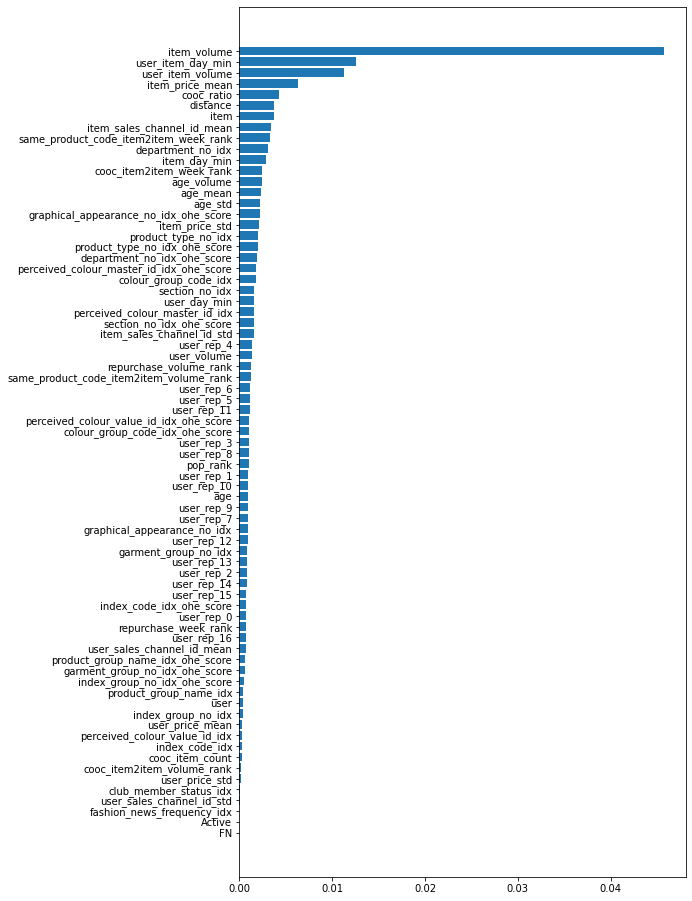

In [17]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_dataset = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'iterations': 5000,
    }
    model = catboost.CatBoost(params)
    model.fit(train_dataset, eval_set=valid_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])


del train, valid, train_dataset, valid_dataset
gc.collect()
with open('output/model_for_validation.pkl', 'wb') as f:
    pickle.dump(model, f)

In [18]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])

pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

merged.to_pickle(f'output/merged_{dataset}.pkl')
dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.034964594611089826


In [19]:
# assert False

submission

In [20]:
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

attach features (week: 1)


[user static fetaures] 0.610 s


[item stacic features] 1.384 s


[user dynamic features (transactions)] 1.237 s


[item dynamic features (transactions)] 1.018 s


[item dynamic features (user features)] 1.520 s


[item freshness features] 2.835 s


[item volume features] 1.028 s


[user freshness features] 4.086 s


[user volume features] 1.177 s


[user-item freshness features] 20.749 s


[user-item volume features] 1.885 s


[item age volume features] 2.217 s


[ohe dot products] 83.901 s


[lfm features] 3.131 s
attach features (week: 2)


[user static fetaures] 0.640 s


[item stacic features] 1.480 s


[user dynamic features (transactions)] 1.302 s


[item dynamic features (transactions)] 1.072 s


[item dynamic features (user features)] 1.571 s


[item freshness features] 2.902 s


[item volume features] 1.045 s


[user freshness features] 4.146 s


[user volume features] 1.194 s


[user-item freshness features] 21.202 s


[user-item volume features] 2.094 s


[item age volume features] 2.337 s


[ohe dot products] 69.363 s


[lfm features] 3.201 s
attach features (week: 3)


[user static fetaures] 0.672 s


[item stacic features] 1.608 s


[user dynamic features (transactions)] 1.420 s


[item dynamic features (transactions)] 1.134 s


[item dynamic features (user features)] 1.686 s


[item freshness features] 3.089 s


[item volume features] 1.139 s


[user freshness features] 4.243 s


[user volume features] 1.312 s


[user-item freshness features] 21.198 s


[user-item volume features] 2.185 s


[item age volume features] 2.456 s


[ohe dot products] 76.924 s


[lfm features] 3.703 s


0:	total: 1.47s	remaining: 2h 1m 10s


1:	total: 2.91s	remaining: 2h 2s


2:	total: 4.37s	remaining: 2h 26s


3:	total: 5.81s	remaining: 2h 3s


4:	total: 7.24s	remaining: 1h 59m 35s


5:	total: 8.68s	remaining: 1h 59m 22s


6:	total: 10.1s	remaining: 1h 59m 3s


7:	total: 11.5s	remaining: 1h 58m 58s


8:	total: 13s	remaining: 1h 59m 4s


9:	total: 14.4s	remaining: 1h 58m 57s


10:	total: 15.9s	remaining: 1h 59m


11:	total: 17.3s	remaining: 1h 58m 58s


12:	total: 18.7s	remaining: 1h 58m 52s


13:	total: 20.2s	remaining: 1h 58m 46s


14:	total: 21.6s	remaining: 1h 58m 54s


15:	total: 23.1s	remaining: 1h 58m 56s


16:	total: 24.5s	remaining: 1h 58m 51s


17:	total: 26s	remaining: 1h 58m 53s


18:	total: 27.4s	remaining: 1h 58m 51s


19:	total: 28.9s	remaining: 1h 58m 51s


20:	total: 30.3s	remaining: 1h 58m 51s


21:	total: 31.8s	remaining: 1h 58m 46s


22:	total: 33.2s	remaining: 1h 58m 45s


23:	total: 34.7s	remaining: 1h 58m 47s


24:	total: 36.1s	remaining: 1h 58m 47s


25:	total: 37.6s	remaining: 1h 58m 47s


26:	total: 39.1s	remaining: 1h 59m


27:	total: 40.6s	remaining: 1h 59m 7s


28:	total: 42.1s	remaining: 1h 59m 12s


29:	total: 43.6s	remaining: 1h 59m 17s


30:	total: 45s	remaining: 1h 59m 20s


31:	total: 46.6s	remaining: 1h 59m 29s


32:	total: 48.1s	remaining: 1h 59m 36s


33:	total: 49.5s	remaining: 1h 59m 35s


34:	total: 51s	remaining: 1h 59m 38s


35:	total: 52.6s	remaining: 1h 59m 47s


36:	total: 54.1s	remaining: 1h 59m 54s


37:	total: 55.7s	remaining: 2h 8s


38:	total: 57.2s	remaining: 2h 12s


39:	total: 58.6s	remaining: 2h 8s


40:	total: 1m	remaining: 2h 8s


41:	total: 1m 1s	remaining: 2h 5s


42:	total: 1m 3s	remaining: 2h 3s


43:	total: 1m 4s	remaining: 1h 59m 58s


44:	total: 1m 5s	remaining: 1h 59m 54s


45:	total: 1m 7s	remaining: 1h 59m 53s


46:	total: 1m 8s	remaining: 1h 59m 51s


47:	total: 1m 10s	remaining: 1h 59m 49s


48:	total: 1m 11s	remaining: 1h 59m 47s


49:	total: 1m 13s	remaining: 1h 59m 48s


50:	total: 1m 14s	remaining: 1h 59m 48s


51:	total: 1m 16s	remaining: 1h 59m 49s


52:	total: 1m 17s	remaining: 1h 59m 47s


53:	total: 1m 19s	remaining: 1h 59m 44s


54:	total: 1m 20s	remaining: 1h 59m 46s


55:	total: 1m 22s	remaining: 1h 59m 40s


56:	total: 1m 23s	remaining: 1h 59m 36s


57:	total: 1m 24s	remaining: 1h 59m 36s


58:	total: 1m 26s	remaining: 1h 59m 39s


59:	total: 1m 27s	remaining: 1h 59m 39s


60:	total: 1m 29s	remaining: 1h 59m 37s


61:	total: 1m 30s	remaining: 1h 59m 41s


62:	total: 1m 32s	remaining: 1h 59m 43s


63:	total: 1m 33s	remaining: 1h 59m 39s


64:	total: 1m 35s	remaining: 1h 59m 36s


65:	total: 1m 36s	remaining: 1h 59m 35s


66:	total: 1m 38s	remaining: 1h 59m 32s


67:	total: 1m 39s	remaining: 1h 59m 32s


68:	total: 1m 41s	remaining: 1h 59m 34s


69:	total: 1m 42s	remaining: 1h 59m 31s


70:	total: 1m 44s	remaining: 1h 59m 33s


71:	total: 1m 45s	remaining: 1h 59m 28s


72:	total: 1m 47s	remaining: 1h 59m 24s


73:	total: 1m 48s	remaining: 1h 59m 21s


74:	total: 1m 49s	remaining: 1h 59m 22s


75:	total: 1m 51s	remaining: 1h 59m 23s


76:	total: 1m 52s	remaining: 1h 59m 20s


77:	total: 1m 54s	remaining: 1h 59m 20s


78:	total: 1m 55s	remaining: 1h 59m 17s


79:	total: 1m 57s	remaining: 1h 59m 15s


80:	total: 1m 58s	remaining: 1h 59m 12s


81:	total: 2m	remaining: 1h 59m 8s


82:	total: 2m 1s	remaining: 1h 59m 8s


83:	total: 2m 3s	remaining: 1h 59m 10s


84:	total: 2m 4s	remaining: 1h 59m 8s


85:	total: 2m 6s	remaining: 1h 59m 3s


86:	total: 2m 7s	remaining: 1h 59m 1s


87:	total: 2m 8s	remaining: 1h 58m 58s


88:	total: 2m 10s	remaining: 1h 58m 57s


89:	total: 2m 11s	remaining: 1h 58m 56s


90:	total: 2m 13s	remaining: 1h 58m 56s


91:	total: 2m 14s	remaining: 1h 58m 54s


92:	total: 2m 16s	remaining: 1h 58m 53s


93:	total: 2m 17s	remaining: 1h 58m 53s


94:	total: 2m 19s	remaining: 1h 58m 51s


95:	total: 2m 20s	remaining: 1h 58m 48s


96:	total: 2m 22s	remaining: 1h 58m 43s


97:	total: 2m 23s	remaining: 1h 58m 41s


98:	total: 2m 25s	remaining: 1h 58m 42s


99:	total: 2m 26s	remaining: 1h 58m 38s


100:	total: 2m 27s	remaining: 1h 58m 37s


101:	total: 2m 29s	remaining: 1h 58m 35s


102:	total: 2m 30s	remaining: 1h 58m 33s


103:	total: 2m 32s	remaining: 1h 58m 34s


104:	total: 2m 33s	remaining: 1h 58m 31s


105:	total: 2m 35s	remaining: 1h 58m 29s


106:	total: 2m 36s	remaining: 1h 58m 29s


107:	total: 2m 38s	remaining: 1h 58m 27s


108:	total: 2m 39s	remaining: 1h 58m 26s


109:	total: 2m 41s	remaining: 1h 58m 28s


110:	total: 2m 42s	remaining: 1h 58m 23s


111:	total: 2m 44s	remaining: 1h 58m 21s


112:	total: 2m 45s	remaining: 1h 58m 21s


113:	total: 2m 47s	remaining: 1h 58m 20s


114:	total: 2m 48s	remaining: 1h 58m 18s


115:	total: 2m 50s	remaining: 1h 58m 20s


116:	total: 2m 51s	remaining: 1h 58m 17s


117:	total: 2m 52s	remaining: 1h 58m 13s


118:	total: 2m 54s	remaining: 1h 58m 12s


119:	total: 2m 55s	remaining: 1h 58m 10s


120:	total: 2m 57s	remaining: 1h 58m 12s


121:	total: 2m 58s	remaining: 1h 58m 10s


122:	total: 3m	remaining: 1h 58m 10s


123:	total: 3m 1s	remaining: 1h 58m 7s


124:	total: 3m 3s	remaining: 1h 58m 7s


125:	total: 3m 4s	remaining: 1h 58m 4s


126:	total: 3m 6s	remaining: 1h 58m 2s


127:	total: 3m 7s	remaining: 1h 58m 1s


128:	total: 3m 9s	remaining: 1h 57m 59s


129:	total: 3m 10s	remaining: 1h 57m 58s


130:	total: 3m 12s	remaining: 1h 57m 58s


131:	total: 3m 13s	remaining: 1h 57m 55s


132:	total: 3m 14s	remaining: 1h 57m 52s


133:	total: 3m 16s	remaining: 1h 57m 50s


134:	total: 3m 17s	remaining: 1h 57m 51s


135:	total: 3m 19s	remaining: 1h 57m 50s


136:	total: 3m 20s	remaining: 1h 57m 45s


137:	total: 3m 22s	remaining: 1h 57m 41s


138:	total: 3m 23s	remaining: 1h 57m 39s


139:	total: 3m 25s	remaining: 1h 57m 37s


140:	total: 3m 26s	remaining: 1h 57m 40s


141:	total: 3m 28s	remaining: 1h 57m 39s


142:	total: 3m 29s	remaining: 1h 57m 36s


143:	total: 3m 30s	remaining: 1h 57m 33s


144:	total: 3m 32s	remaining: 1h 57m 30s


145:	total: 3m 33s	remaining: 1h 57m 29s


146:	total: 3m 35s	remaining: 1h 57m 28s


147:	total: 3m 36s	remaining: 1h 57m 28s


148:	total: 3m 38s	remaining: 1h 57m 29s


149:	total: 3m 39s	remaining: 1h 57m 30s


150:	total: 3m 41s	remaining: 1h 57m 33s


151:	total: 3m 43s	remaining: 1h 57m 35s


152:	total: 3m 44s	remaining: 1h 57m 33s


153:	total: 3m 46s	remaining: 1h 57m 32s


154:	total: 3m 47s	remaining: 1h 57m 32s


155:	total: 3m 48s	remaining: 1h 57m 27s


156:	total: 3m 50s	remaining: 1h 57m 24s


157:	total: 3m 51s	remaining: 1h 57m 26s


158:	total: 3m 53s	remaining: 1h 57m 25s


159:	total: 3m 54s	remaining: 1h 57m 23s


160:	total: 3m 56s	remaining: 1h 57m 27s


161:	total: 3m 57s	remaining: 1h 57m 25s


162:	total: 3m 59s	remaining: 1h 57m 24s


163:	total: 4m	remaining: 1h 57m 25s


164:	total: 4m 2s	remaining: 1h 57m 25s


165:	total: 4m 3s	remaining: 1h 57m 24s


166:	total: 4m 5s	remaining: 1h 57m 24s


167:	total: 4m 7s	remaining: 1h 57m 24s


168:	total: 4m 8s	remaining: 1h 57m 21s


169:	total: 4m 9s	remaining: 1h 57m 19s


170:	total: 4m 11s	remaining: 1h 57m 22s


171:	total: 4m 12s	remaining: 1h 57m 20s


172:	total: 4m 14s	remaining: 1h 57m 19s


173:	total: 4m 15s	remaining: 1h 57m 17s


174:	total: 4m 17s	remaining: 1h 57m 14s


175:	total: 4m 18s	remaining: 1h 57m 13s


176:	total: 4m 20s	remaining: 1h 57m 11s


177:	total: 4m 21s	remaining: 1h 57m 9s


178:	total: 4m 23s	remaining: 1h 57m 6s


179:	total: 4m 24s	remaining: 1h 57m 4s


180:	total: 4m 26s	remaining: 1h 57m 3s


181:	total: 4m 27s	remaining: 1h 57m 1s


182:	total: 4m 28s	remaining: 1h 56m 59s


183:	total: 4m 30s	remaining: 1h 56m 58s


184:	total: 4m 31s	remaining: 1h 56m 57s


185:	total: 4m 33s	remaining: 1h 56m 55s


186:	total: 4m 34s	remaining: 1h 56m 54s


187:	total: 4m 36s	remaining: 1h 56m 52s


188:	total: 4m 37s	remaining: 1h 56m 50s


189:	total: 4m 39s	remaining: 1h 56m 49s


190:	total: 4m 40s	remaining: 1h 56m 47s


191:	total: 4m 42s	remaining: 1h 56m 44s


192:	total: 4m 43s	remaining: 1h 56m 43s


193:	total: 4m 45s	remaining: 1h 56m 42s


194:	total: 4m 46s	remaining: 1h 56m 39s


195:	total: 4m 48s	remaining: 1h 56m 39s


196:	total: 4m 49s	remaining: 1h 56m 36s


197:	total: 4m 50s	remaining: 1h 56m 35s


198:	total: 4m 52s	remaining: 1h 56m 34s


199:	total: 4m 53s	remaining: 1h 56m 33s


200:	total: 4m 55s	remaining: 1h 56m 32s


201:	total: 4m 56s	remaining: 1h 56m 30s


202:	total: 4m 58s	remaining: 1h 56m 29s


203:	total: 4m 59s	remaining: 1h 56m 28s


204:	total: 5m 1s	remaining: 1h 56m 27s


205:	total: 5m 2s	remaining: 1h 56m 26s


206:	total: 5m 4s	remaining: 1h 56m 26s


207:	total: 5m 5s	remaining: 1h 56m 22s


208:	total: 5m 7s	remaining: 1h 56m 22s


209:	total: 5m 8s	remaining: 1h 56m 20s


210:	total: 5m 10s	remaining: 1h 56m 18s


211:	total: 5m 11s	remaining: 1h 56m 16s


212:	total: 5m 13s	remaining: 1h 56m 14s


213:	total: 5m 14s	remaining: 1h 56m 13s


214:	total: 5m 15s	remaining: 1h 56m 12s


215:	total: 5m 17s	remaining: 1h 56m 9s


216:	total: 5m 18s	remaining: 1h 56m 10s


217:	total: 5m 20s	remaining: 1h 56m 8s


218:	total: 5m 21s	remaining: 1h 56m 6s


219:	total: 5m 23s	remaining: 1h 56m 5s


220:	total: 5m 24s	remaining: 1h 56m 4s


221:	total: 5m 26s	remaining: 1h 56m 2s


222:	total: 5m 27s	remaining: 1h 56m


223:	total: 5m 29s	remaining: 1h 55m 58s


224:	total: 5m 30s	remaining: 1h 55m 57s


225:	total: 5m 32s	remaining: 1h 55m 55s


226:	total: 5m 33s	remaining: 1h 55m 53s


227:	total: 5m 35s	remaining: 1h 55m 51s


228:	total: 5m 36s	remaining: 1h 55m 49s


229:	total: 5m 37s	remaining: 1h 55m 46s


230:	total: 5m 39s	remaining: 1h 55m 43s


231:	total: 5m 40s	remaining: 1h 55m 42s


232:	total: 5m 42s	remaining: 1h 55m 42s


233:	total: 5m 43s	remaining: 1h 55m 39s


234:	total: 5m 45s	remaining: 1h 55m 37s


235:	total: 5m 46s	remaining: 1h 55m 36s


236:	total: 5m 48s	remaining: 1h 55m 34s


237:	total: 5m 49s	remaining: 1h 55m 33s


238:	total: 5m 50s	remaining: 1h 55m 31s


239:	total: 5m 52s	remaining: 1h 55m 29s


240:	total: 5m 53s	remaining: 1h 55m 28s


241:	total: 5m 55s	remaining: 1h 55m 27s


242:	total: 5m 56s	remaining: 1h 55m 27s


243:	total: 5m 58s	remaining: 1h 55m 26s


244:	total: 5m 59s	remaining: 1h 55m 23s


245:	total: 6m 1s	remaining: 1h 55m 21s


246:	total: 6m 2s	remaining: 1h 55m 19s


247:	total: 6m 4s	remaining: 1h 55m 18s


248:	total: 6m 5s	remaining: 1h 55m 16s


249:	total: 6m 7s	remaining: 1h 55m 13s


250:	total: 6m 8s	remaining: 1h 55m 11s


251:	total: 6m 9s	remaining: 1h 55m 9s


252:	total: 6m 11s	remaining: 1h 55m 7s


253:	total: 6m 12s	remaining: 1h 55m 6s


254:	total: 6m 14s	remaining: 1h 55m 4s


255:	total: 6m 15s	remaining: 1h 55m 2s


256:	total: 6m 17s	remaining: 1h 55m 1s


257:	total: 6m 18s	remaining: 1h 55m


258:	total: 6m 20s	remaining: 1h 54m 57s


259:	total: 6m 21s	remaining: 1h 54m 55s


260:	total: 6m 23s	remaining: 1h 54m 54s


261:	total: 6m 24s	remaining: 1h 54m 53s


262:	total: 6m 25s	remaining: 1h 54m 51s


263:	total: 6m 27s	remaining: 1h 54m 51s


264:	total: 6m 29s	remaining: 1h 54m 53s


265:	total: 6m 30s	remaining: 1h 54m 56s


266:	total: 6m 32s	remaining: 1h 54m 55s


267:	total: 6m 33s	remaining: 1h 54m 55s


268:	total: 6m 35s	remaining: 1h 54m 53s


269:	total: 6m 36s	remaining: 1h 54m 53s


270:	total: 6m 38s	remaining: 1h 54m 51s


271:	total: 6m 39s	remaining: 1h 54m 50s


272:	total: 6m 41s	remaining: 1h 54m 48s


273:	total: 6m 42s	remaining: 1h 54m 45s


274:	total: 6m 44s	remaining: 1h 54m 43s


275:	total: 6m 45s	remaining: 1h 54m 44s


276:	total: 6m 47s	remaining: 1h 54m 43s


277:	total: 6m 48s	remaining: 1h 54m 40s


278:	total: 6m 50s	remaining: 1h 54m 40s


279:	total: 6m 51s	remaining: 1h 54m 39s


280:	total: 6m 53s	remaining: 1h 54m 37s


281:	total: 6m 54s	remaining: 1h 54m 34s


282:	total: 6m 55s	remaining: 1h 54m 31s


283:	total: 6m 57s	remaining: 1h 54m 30s


284:	total: 6m 58s	remaining: 1h 54m 28s


285:	total: 7m	remaining: 1h 54m 26s


286:	total: 7m 1s	remaining: 1h 54m 25s


287:	total: 7m 3s	remaining: 1h 54m 23s


288:	total: 7m 4s	remaining: 1h 54m 23s


289:	total: 7m 6s	remaining: 1h 54m 20s


290:	total: 7m 7s	remaining: 1h 54m 18s


291:	total: 7m 8s	remaining: 1h 54m 16s


292:	total: 7m 10s	remaining: 1h 54m 14s


293:	total: 7m 11s	remaining: 1h 54m 13s


294:	total: 7m 13s	remaining: 1h 54m 11s


295:	total: 7m 14s	remaining: 1h 54m 10s


296:	total: 7m 16s	remaining: 1h 54m 7s


297:	total: 7m 17s	remaining: 1h 54m 6s


298:	total: 7m 19s	remaining: 1h 54m 5s


299:	total: 7m 20s	remaining: 1h 54m 2s


300:	total: 7m 22s	remaining: 1h 54m 1s


301:	total: 7m 23s	remaining: 1h 53m 59s


302:	total: 7m 25s	remaining: 1h 53m 58s


303:	total: 7m 26s	remaining: 1h 53m 57s


304:	total: 7m 27s	remaining: 1h 53m 54s


305:	total: 7m 29s	remaining: 1h 53m 52s


306:	total: 7m 30s	remaining: 1h 53m 51s


307:	total: 7m 32s	remaining: 1h 53m 50s


308:	total: 7m 33s	remaining: 1h 53m 49s


309:	total: 7m 35s	remaining: 1h 53m 47s


310:	total: 7m 36s	remaining: 1h 53m 46s


311:	total: 7m 38s	remaining: 1h 53m 44s


312:	total: 7m 39s	remaining: 1h 53m 42s


313:	total: 7m 41s	remaining: 1h 53m 41s


314:	total: 7m 42s	remaining: 1h 53m 39s


315:	total: 7m 43s	remaining: 1h 53m 36s


316:	total: 7m 45s	remaining: 1h 53m 35s


317:	total: 7m 46s	remaining: 1h 53m 33s


318:	total: 7m 48s	remaining: 1h 53m 31s


319:	total: 7m 49s	remaining: 1h 53m 29s


320:	total: 7m 51s	remaining: 1h 53m 27s


321:	total: 7m 52s	remaining: 1h 53m 25s


322:	total: 7m 54s	remaining: 1h 53m 23s


323:	total: 7m 55s	remaining: 1h 53m 22s


324:	total: 7m 57s	remaining: 1h 53m 22s


325:	total: 7m 58s	remaining: 1h 53m 19s


326:	total: 7m 59s	remaining: 1h 53m 18s


327:	total: 8m 1s	remaining: 1h 53m 17s


328:	total: 8m 2s	remaining: 1h 53m 15s


329:	total: 8m 4s	remaining: 1h 53m 13s


330:	total: 8m 5s	remaining: 1h 53m 11s


331:	total: 8m 7s	remaining: 1h 53m 9s


332:	total: 8m 8s	remaining: 1h 53m 8s


333:	total: 8m 10s	remaining: 1h 53m 6s


334:	total: 8m 11s	remaining: 1h 53m 4s


335:	total: 8m 13s	remaining: 1h 53m 3s


336:	total: 8m 14s	remaining: 1h 53m 1s


337:	total: 8m 15s	remaining: 1h 53m


338:	total: 8m 17s	remaining: 1h 52m 57s


339:	total: 8m 18s	remaining: 1h 52m 55s


340:	total: 8m 20s	remaining: 1h 52m 55s


341:	total: 8m 21s	remaining: 1h 52m 53s


342:	total: 8m 23s	remaining: 1h 52m 52s


343:	total: 8m 24s	remaining: 1h 52m 50s


344:	total: 8m 26s	remaining: 1h 52m 49s


345:	total: 8m 27s	remaining: 1h 52m 47s


346:	total: 8m 29s	remaining: 1h 52m 45s


347:	total: 8m 30s	remaining: 1h 52m 44s


348:	total: 8m 32s	remaining: 1h 52m 44s


349:	total: 8m 33s	remaining: 1h 52m 43s


350:	total: 8m 35s	remaining: 1h 52m 42s


351:	total: 8m 36s	remaining: 1h 52m 43s


352:	total: 8m 38s	remaining: 1h 52m 42s


353:	total: 8m 39s	remaining: 1h 52m 42s


354:	total: 8m 41s	remaining: 1h 52m 40s


355:	total: 8m 42s	remaining: 1h 52m 38s


356:	total: 8m 44s	remaining: 1h 52m 39s


357:	total: 8m 45s	remaining: 1h 52m 38s


358:	total: 8m 47s	remaining: 1h 52m 37s


359:	total: 8m 48s	remaining: 1h 52m 35s


360:	total: 8m 50s	remaining: 1h 52m 34s


361:	total: 8m 51s	remaining: 1h 52m 32s


362:	total: 8m 53s	remaining: 1h 52m 31s


363:	total: 8m 54s	remaining: 1h 52m 29s


364:	total: 8m 56s	remaining: 1h 52m 27s


365:	total: 8m 57s	remaining: 1h 52m 26s


366:	total: 8m 59s	remaining: 1h 52m 25s


367:	total: 9m	remaining: 1h 52m 23s


368:	total: 9m 1s	remaining: 1h 52m 21s


369:	total: 9m 3s	remaining: 1h 52m 20s


370:	total: 9m 4s	remaining: 1h 52m 18s


371:	total: 9m 6s	remaining: 1h 52m 17s


372:	total: 9m 7s	remaining: 1h 52m 15s


373:	total: 9m 9s	remaining: 1h 52m 15s


374:	total: 9m 10s	remaining: 1h 52m 13s


375:	total: 9m 12s	remaining: 1h 52m 11s


376:	total: 9m 13s	remaining: 1h 52m 11s


377:	total: 9m 15s	remaining: 1h 52m 9s


378:	total: 9m 16s	remaining: 1h 52m 10s


379:	total: 9m 18s	remaining: 1h 52m 9s


380:	total: 9m 19s	remaining: 1h 52m 7s


381:	total: 9m 21s	remaining: 1h 52m 6s


382:	total: 9m 22s	remaining: 1h 52m 3s


383:	total: 9m 24s	remaining: 1h 52m 1s


384:	total: 9m 25s	remaining: 1h 52m


385:	total: 9m 27s	remaining: 1h 51m 59s


386:	total: 9m 28s	remaining: 1h 51m 57s


387:	total: 9m 30s	remaining: 1h 51m 56s


388:	total: 9m 31s	remaining: 1h 51m 54s


389:	total: 9m 32s	remaining: 1h 51m 52s


390:	total: 9m 34s	remaining: 1h 51m 51s


391:	total: 9m 35s	remaining: 1h 51m 49s


392:	total: 9m 37s	remaining: 1h 51m 48s


393:	total: 9m 38s	remaining: 1h 51m 47s


394:	total: 9m 40s	remaining: 1h 51m 45s


395:	total: 9m 41s	remaining: 1h 51m 43s


396:	total: 9m 43s	remaining: 1h 51m 42s


397:	total: 9m 44s	remaining: 1h 51m 39s


398:	total: 9m 46s	remaining: 1h 51m 38s


399:	total: 9m 47s	remaining: 1h 51m 36s


400:	total: 9m 49s	remaining: 1h 51m 35s


401:	total: 9m 50s	remaining: 1h 51m 33s


402:	total: 9m 51s	remaining: 1h 51m 31s


403:	total: 9m 53s	remaining: 1h 51m 29s


404:	total: 9m 54s	remaining: 1h 51m 27s


405:	total: 9m 56s	remaining: 1h 51m 26s


406:	total: 9m 57s	remaining: 1h 51m 24s


407:	total: 9m 59s	remaining: 1h 51m 23s


408:	total: 10m	remaining: 1h 51m 20s


409:	total: 10m 2s	remaining: 1h 51m 19s


410:	total: 10m 3s	remaining: 1h 51m 17s


411:	total: 10m 4s	remaining: 1h 51m 15s


412:	total: 10m 6s	remaining: 1h 51m 13s


413:	total: 10m 7s	remaining: 1h 51m 12s


414:	total: 10m 9s	remaining: 1h 51m 10s


415:	total: 10m 10s	remaining: 1h 51m 8s


416:	total: 10m 12s	remaining: 1h 51m 7s


417:	total: 10m 13s	remaining: 1h 51m 5s


418:	total: 10m 14s	remaining: 1h 51m 3s


419:	total: 10m 16s	remaining: 1h 51m 2s


420:	total: 10m 18s	remaining: 1h 51m 1s


421:	total: 10m 19s	remaining: 1h 50m 59s


422:	total: 10m 20s	remaining: 1h 50m 58s


423:	total: 10m 22s	remaining: 1h 50m 56s


424:	total: 10m 23s	remaining: 1h 50m 54s


425:	total: 10m 25s	remaining: 1h 50m 53s


426:	total: 10m 26s	remaining: 1h 50m 51s


427:	total: 10m 28s	remaining: 1h 50m 50s


428:	total: 10m 29s	remaining: 1h 50m 47s


429:	total: 10m 31s	remaining: 1h 50m 46s


430:	total: 10m 32s	remaining: 1h 50m 44s


431:	total: 10m 33s	remaining: 1h 50m 42s


432:	total: 10m 35s	remaining: 1h 50m 40s


433:	total: 10m 36s	remaining: 1h 50m 38s


434:	total: 10m 38s	remaining: 1h 50m 37s


435:	total: 10m 39s	remaining: 1h 50m 36s


436:	total: 10m 41s	remaining: 1h 50m 34s


437:	total: 10m 42s	remaining: 1h 50m 32s


438:	total: 10m 44s	remaining: 1h 50m 31s


439:	total: 10m 45s	remaining: 1h 50m 29s


440:	total: 10m 46s	remaining: 1h 50m 27s


441:	total: 10m 48s	remaining: 1h 50m 26s


442:	total: 10m 49s	remaining: 1h 50m 24s


443:	total: 10m 51s	remaining: 1h 50m 22s


444:	total: 10m 52s	remaining: 1h 50m 21s


445:	total: 10m 54s	remaining: 1h 50m 19s


446:	total: 10m 55s	remaining: 1h 50m 18s


447:	total: 10m 57s	remaining: 1h 50m 16s


448:	total: 10m 58s	remaining: 1h 50m 15s


449:	total: 11m	remaining: 1h 50m 14s


450:	total: 11m 1s	remaining: 1h 50m 12s


451:	total: 11m 2s	remaining: 1h 50m 10s


452:	total: 11m 4s	remaining: 1h 50m 9s


453:	total: 11m 5s	remaining: 1h 50m 7s


454:	total: 11m 7s	remaining: 1h 50m 5s


455:	total: 11m 8s	remaining: 1h 50m 4s


456:	total: 11m 10s	remaining: 1h 50m 3s


457:	total: 11m 11s	remaining: 1h 50m 1s


458:	total: 11m 13s	remaining: 1h 49m 58s


459:	total: 11m 14s	remaining: 1h 49m 57s


460:	total: 11m 16s	remaining: 1h 49m 55s


461:	total: 11m 17s	remaining: 1h 49m 54s


462:	total: 11m 18s	remaining: 1h 49m 52s


463:	total: 11m 20s	remaining: 1h 49m 50s


464:	total: 11m 21s	remaining: 1h 49m 49s


465:	total: 11m 23s	remaining: 1h 49m 47s


466:	total: 11m 24s	remaining: 1h 49m 45s


467:	total: 11m 26s	remaining: 1h 49m 43s


468:	total: 11m 27s	remaining: 1h 49m 41s


469:	total: 11m 28s	remaining: 1h 49m 40s


470:	total: 11m 30s	remaining: 1h 49m 39s


471:	total: 11m 31s	remaining: 1h 49m 37s


472:	total: 11m 33s	remaining: 1h 49m 35s


473:	total: 11m 34s	remaining: 1h 49m 33s


474:	total: 11m 36s	remaining: 1h 49m 32s


475:	total: 11m 37s	remaining: 1h 49m 29s


476:	total: 11m 39s	remaining: 1h 49m 28s


477:	total: 11m 40s	remaining: 1h 49m 25s


478:	total: 11m 41s	remaining: 1h 49m 23s


479:	total: 11m 43s	remaining: 1h 49m 22s


480:	total: 11m 44s	remaining: 1h 49m 20s


481:	total: 11m 46s	remaining: 1h 49m 19s


482:	total: 11m 47s	remaining: 1h 49m 17s


483:	total: 11m 49s	remaining: 1h 49m 16s


484:	total: 11m 50s	remaining: 1h 49m 14s


485:	total: 11m 52s	remaining: 1h 49m 13s


486:	total: 11m 53s	remaining: 1h 49m 11s


487:	total: 11m 54s	remaining: 1h 49m 10s


488:	total: 11m 56s	remaining: 1h 49m 9s


489:	total: 11m 57s	remaining: 1h 49m 7s


490:	total: 11m 59s	remaining: 1h 49m 5s


491:	total: 12m	remaining: 1h 49m 4s


492:	total: 12m 2s	remaining: 1h 49m 2s


493:	total: 12m 3s	remaining: 1h 49m


494:	total: 12m 5s	remaining: 1h 48m 59s


495:	total: 12m 6s	remaining: 1h 48m 57s


496:	total: 12m 7s	remaining: 1h 48m 55s


497:	total: 12m 9s	remaining: 1h 48m 53s


498:	total: 12m 10s	remaining: 1h 48m 52s


499:	total: 12m 12s	remaining: 1h 48m 50s


500:	total: 12m 13s	remaining: 1h 48m 49s


501:	total: 12m 15s	remaining: 1h 48m 47s


502:	total: 12m 16s	remaining: 1h 48m 46s


503:	total: 12m 18s	remaining: 1h 48m 44s


504:	total: 12m 19s	remaining: 1h 48m 43s


505:	total: 12m 21s	remaining: 1h 48m 42s


506:	total: 12m 22s	remaining: 1h 48m 41s


507:	total: 12m 24s	remaining: 1h 48m 39s


508:	total: 12m 25s	remaining: 1h 48m 37s


509:	total: 12m 26s	remaining: 1h 48m 35s


510:	total: 12m 28s	remaining: 1h 48m 34s


511:	total: 12m 29s	remaining: 1h 48m 32s


512:	total: 12m 31s	remaining: 1h 48m 31s


513:	total: 12m 32s	remaining: 1h 48m 29s


514:	total: 12m 34s	remaining: 1h 48m 28s


515:	total: 12m 35s	remaining: 1h 48m 27s


516:	total: 12m 37s	remaining: 1h 48m 25s


517:	total: 12m 38s	remaining: 1h 48m 24s


518:	total: 12m 40s	remaining: 1h 48m 22s


519:	total: 12m 41s	remaining: 1h 48m 20s


520:	total: 12m 42s	remaining: 1h 48m 18s


521:	total: 12m 44s	remaining: 1h 48m 16s


522:	total: 12m 45s	remaining: 1h 48m 15s


523:	total: 12m 47s	remaining: 1h 48m 13s


524:	total: 12m 48s	remaining: 1h 48m 11s


525:	total: 12m 50s	remaining: 1h 48m 10s


526:	total: 12m 51s	remaining: 1h 48m 8s


527:	total: 12m 52s	remaining: 1h 48m 6s


528:	total: 12m 54s	remaining: 1h 48m 5s


529:	total: 12m 55s	remaining: 1h 48m 3s


530:	total: 12m 57s	remaining: 1h 48m 2s


531:	total: 12m 58s	remaining: 1h 48m 1s


532:	total: 13m	remaining: 1h 47m 59s


533:	total: 13m 1s	remaining: 1h 47m 58s


534:	total: 13m 3s	remaining: 1h 47m 56s


535:	total: 13m 4s	remaining: 1h 47m 54s


536:	total: 13m 6s	remaining: 1h 47m 52s


537:	total: 13m 7s	remaining: 1h 47m 51s


538:	total: 13m 8s	remaining: 1h 47m 49s


539:	total: 13m 10s	remaining: 1h 47m 47s


540:	total: 13m 11s	remaining: 1h 47m 46s


541:	total: 13m 13s	remaining: 1h 47m 44s


542:	total: 13m 14s	remaining: 1h 47m 42s


543:	total: 13m 16s	remaining: 1h 47m 41s


544:	total: 13m 17s	remaining: 1h 47m 39s


545:	total: 13m 18s	remaining: 1h 47m 37s


546:	total: 13m 20s	remaining: 1h 47m 35s


547:	total: 13m 21s	remaining: 1h 47m 34s


548:	total: 13m 23s	remaining: 1h 47m 32s


549:	total: 13m 24s	remaining: 1h 47m 31s


550:	total: 13m 26s	remaining: 1h 47m 29s


551:	total: 13m 27s	remaining: 1h 47m 27s


552:	total: 13m 29s	remaining: 1h 47m 26s


553:	total: 13m 30s	remaining: 1h 47m 24s


554:	total: 13m 31s	remaining: 1h 47m 22s


555:	total: 13m 33s	remaining: 1h 47m 21s


556:	total: 13m 34s	remaining: 1h 47m 19s


557:	total: 13m 36s	remaining: 1h 47m 17s


558:	total: 13m 37s	remaining: 1h 47m 15s


559:	total: 13m 39s	remaining: 1h 47m 13s


560:	total: 13m 40s	remaining: 1h 47m 11s


561:	total: 13m 41s	remaining: 1h 47m 9s


562:	total: 13m 43s	remaining: 1h 47m 8s


563:	total: 13m 44s	remaining: 1h 47m 7s


564:	total: 13m 46s	remaining: 1h 47m 6s


565:	total: 13m 47s	remaining: 1h 47m 4s


566:	total: 13m 49s	remaining: 1h 47m 3s


567:	total: 13m 50s	remaining: 1h 47m 2s


568:	total: 13m 52s	remaining: 1h 47m


569:	total: 13m 53s	remaining: 1h 46m 59s


570:	total: 13m 55s	remaining: 1h 46m 58s


571:	total: 13m 56s	remaining: 1h 46m 56s


572:	total: 13m 58s	remaining: 1h 46m 55s


573:	total: 13m 59s	remaining: 1h 46m 54s


574:	total: 14m 1s	remaining: 1h 46m 53s


575:	total: 14m 2s	remaining: 1h 46m 52s


576:	total: 14m 4s	remaining: 1h 46m 51s


577:	total: 14m 5s	remaining: 1h 46m 51s


578:	total: 14m 7s	remaining: 1h 46m 49s


579:	total: 14m 8s	remaining: 1h 46m 48s


580:	total: 14m 10s	remaining: 1h 46m 46s


581:	total: 14m 11s	remaining: 1h 46m 45s


582:	total: 14m 13s	remaining: 1h 46m 43s


583:	total: 14m 14s	remaining: 1h 46m 42s


584:	total: 14m 16s	remaining: 1h 46m 41s


585:	total: 14m 17s	remaining: 1h 46m 39s


586:	total: 14m 19s	remaining: 1h 46m 37s


587:	total: 14m 20s	remaining: 1h 46m 36s


588:	total: 14m 21s	remaining: 1h 46m 35s


589:	total: 14m 23s	remaining: 1h 46m 33s


590:	total: 14m 24s	remaining: 1h 46m 32s


591:	total: 14m 26s	remaining: 1h 46m 30s


592:	total: 14m 27s	remaining: 1h 46m 28s


593:	total: 14m 29s	remaining: 1h 46m 27s


594:	total: 14m 30s	remaining: 1h 46m 25s


595:	total: 14m 32s	remaining: 1h 46m 24s


596:	total: 14m 33s	remaining: 1h 46m 23s


597:	total: 14m 35s	remaining: 1h 46m 22s


598:	total: 14m 36s	remaining: 1h 46m 20s


599:	total: 14m 38s	remaining: 1h 46m 19s


600:	total: 14m 39s	remaining: 1h 46m 17s


601:	total: 14m 41s	remaining: 1h 46m 16s


602:	total: 14m 42s	remaining: 1h 46m 15s


603:	total: 14m 43s	remaining: 1h 46m 13s


604:	total: 14m 45s	remaining: 1h 46m 11s


605:	total: 14m 46s	remaining: 1h 46m 10s


606:	total: 14m 48s	remaining: 1h 46m 8s


607:	total: 14m 49s	remaining: 1h 46m 7s


608:	total: 14m 51s	remaining: 1h 46m 6s


609:	total: 14m 52s	remaining: 1h 46m 4s


610:	total: 14m 54s	remaining: 1h 46m 3s


611:	total: 14m 55s	remaining: 1h 46m 1s


612:	total: 14m 57s	remaining: 1h 46m


613:	total: 14m 58s	remaining: 1h 45m 59s


614:	total: 15m	remaining: 1h 45m 57s


615:	total: 15m 1s	remaining: 1h 45m 55s


616:	total: 15m 2s	remaining: 1h 45m 54s


617:	total: 15m 4s	remaining: 1h 45m 52s


618:	total: 15m 5s	remaining: 1h 45m 51s


619:	total: 15m 7s	remaining: 1h 45m 51s


620:	total: 15m 9s	remaining: 1h 45m 51s


621:	total: 15m 10s	remaining: 1h 45m 50s


622:	total: 15m 12s	remaining: 1h 45m 49s


623:	total: 15m 13s	remaining: 1h 45m 48s


624:	total: 15m 15s	remaining: 1h 45m 47s


625:	total: 15m 16s	remaining: 1h 45m 45s


626:	total: 15m 18s	remaining: 1h 45m 43s


627:	total: 15m 19s	remaining: 1h 45m 43s


628:	total: 15m 21s	remaining: 1h 45m 41s


629:	total: 15m 22s	remaining: 1h 45m 39s


630:	total: 15m 24s	remaining: 1h 45m 38s


631:	total: 15m 25s	remaining: 1h 45m 36s


632:	total: 15m 26s	remaining: 1h 45m 34s


633:	total: 15m 28s	remaining: 1h 45m 33s


634:	total: 15m 29s	remaining: 1h 45m 32s


635:	total: 15m 31s	remaining: 1h 45m 31s


636:	total: 15m 32s	remaining: 1h 45m 29s


637:	total: 15m 34s	remaining: 1h 45m 28s


638:	total: 15m 35s	remaining: 1h 45m 27s


639:	total: 15m 37s	remaining: 1h 45m 25s


640:	total: 15m 38s	remaining: 1h 45m 24s


641:	total: 15m 40s	remaining: 1h 45m 22s


642:	total: 15m 41s	remaining: 1h 45m 20s


643:	total: 15m 43s	remaining: 1h 45m 19s


644:	total: 15m 44s	remaining: 1h 45m 19s


645:	total: 15m 46s	remaining: 1h 45m 18s


646:	total: 15m 47s	remaining: 1h 45m 17s


647:	total: 15m 49s	remaining: 1h 45m 15s


648:	total: 15m 50s	remaining: 1h 45m 14s


649:	total: 15m 52s	remaining: 1h 45m 13s


650:	total: 15m 53s	remaining: 1h 45m 12s


651:	total: 15m 55s	remaining: 1h 45m 11s


652:	total: 15m 56s	remaining: 1h 45m 9s


653:	total: 15m 58s	remaining: 1h 45m 8s


654:	total: 15m 59s	remaining: 1h 45m 8s


655:	total: 16m 1s	remaining: 1h 45m 7s


656:	total: 16m 2s	remaining: 1h 45m 5s


657:	total: 16m 4s	remaining: 1h 45m 4s


658:	total: 16m 6s	remaining: 1h 45m 3s


659:	total: 16m 7s	remaining: 1h 45m 2s


660:	total: 16m 9s	remaining: 1h 45m 1s


661:	total: 16m 10s	remaining: 1h 44m 59s


662:	total: 16m 12s	remaining: 1h 44m 58s


663:	total: 16m 13s	remaining: 1h 44m 57s


664:	total: 16m 15s	remaining: 1h 44m 56s


665:	total: 16m 16s	remaining: 1h 44m 54s


666:	total: 16m 18s	remaining: 1h 44m 54s


667:	total: 16m 19s	remaining: 1h 44m 54s


668:	total: 16m 21s	remaining: 1h 44m 53s


669:	total: 16m 22s	remaining: 1h 44m 51s


670:	total: 16m 24s	remaining: 1h 44m 49s


671:	total: 16m 25s	remaining: 1h 44m 48s


672:	total: 16m 27s	remaining: 1h 44m 46s


673:	total: 16m 28s	remaining: 1h 44m 44s


674:	total: 16m 29s	remaining: 1h 44m 42s


675:	total: 16m 31s	remaining: 1h 44m 40s


676:	total: 16m 32s	remaining: 1h 44m 39s


677:	total: 16m 34s	remaining: 1h 44m 37s


678:	total: 16m 35s	remaining: 1h 44m 35s


679:	total: 16m 37s	remaining: 1h 44m 34s


680:	total: 16m 38s	remaining: 1h 44m 32s


681:	total: 16m 39s	remaining: 1h 44m 31s


682:	total: 16m 41s	remaining: 1h 44m 29s


683:	total: 16m 42s	remaining: 1h 44m 28s


684:	total: 16m 44s	remaining: 1h 44m 26s


685:	total: 16m 45s	remaining: 1h 44m 25s


686:	total: 16m 47s	remaining: 1h 44m 23s


687:	total: 16m 48s	remaining: 1h 44m 21s


688:	total: 16m 50s	remaining: 1h 44m 19s


689:	total: 16m 51s	remaining: 1h 44m 17s


690:	total: 16m 52s	remaining: 1h 44m 16s


691:	total: 16m 54s	remaining: 1h 44m 15s


692:	total: 16m 55s	remaining: 1h 44m 13s


693:	total: 16m 57s	remaining: 1h 44m 11s


694:	total: 16m 58s	remaining: 1h 44m 10s


695:	total: 17m	remaining: 1h 44m 8s


696:	total: 17m 1s	remaining: 1h 44m 7s


697:	total: 17m 3s	remaining: 1h 44m 6s


698:	total: 17m 4s	remaining: 1h 44m 4s


699:	total: 17m 6s	remaining: 1h 44m 3s


700:	total: 17m 7s	remaining: 1h 44m 1s


701:	total: 17m 9s	remaining: 1h 44m


702:	total: 17m 10s	remaining: 1h 43m 58s


703:	total: 17m 11s	remaining: 1h 43m 57s


704:	total: 17m 13s	remaining: 1h 43m 55s


705:	total: 17m 14s	remaining: 1h 43m 53s


706:	total: 17m 16s	remaining: 1h 43m 52s


707:	total: 17m 17s	remaining: 1h 43m 51s


708:	total: 17m 19s	remaining: 1h 43m 49s


709:	total: 17m 20s	remaining: 1h 43m 47s


710:	total: 17m 22s	remaining: 1h 43m 46s


711:	total: 17m 23s	remaining: 1h 43m 44s


712:	total: 17m 24s	remaining: 1h 43m 42s


713:	total: 17m 26s	remaining: 1h 43m 40s


714:	total: 17m 27s	remaining: 1h 43m 38s


715:	total: 17m 29s	remaining: 1h 43m 36s


716:	total: 17m 30s	remaining: 1h 43m 34s


717:	total: 17m 31s	remaining: 1h 43m 32s


718:	total: 17m 33s	remaining: 1h 43m 30s


719:	total: 17m 34s	remaining: 1h 43m 29s


720:	total: 17m 36s	remaining: 1h 43m 27s


721:	total: 17m 37s	remaining: 1h 43m 26s


722:	total: 17m 39s	remaining: 1h 43m 24s


723:	total: 17m 40s	remaining: 1h 43m 23s


724:	total: 17m 41s	remaining: 1h 43m 21s


725:	total: 17m 43s	remaining: 1h 43m 19s


726:	total: 17m 44s	remaining: 1h 43m 18s


727:	total: 17m 46s	remaining: 1h 43m 16s


728:	total: 17m 47s	remaining: 1h 43m 14s


729:	total: 17m 49s	remaining: 1h 43m 13s


730:	total: 17m 50s	remaining: 1h 43m 11s


731:	total: 17m 51s	remaining: 1h 43m 9s


732:	total: 17m 53s	remaining: 1h 43m 7s


733:	total: 17m 54s	remaining: 1h 43m 5s


734:	total: 17m 56s	remaining: 1h 43m 4s


735:	total: 17m 57s	remaining: 1h 43m 2s


736:	total: 17m 58s	remaining: 1h 43m


737:	total: 18m	remaining: 1h 42m 58s


738:	total: 18m 1s	remaining: 1h 42m 56s


739:	total: 18m 3s	remaining: 1h 42m 55s


740:	total: 18m 4s	remaining: 1h 42m 53s


741:	total: 18m 5s	remaining: 1h 42m 51s


742:	total: 18m 7s	remaining: 1h 42m 50s


743:	total: 18m 8s	remaining: 1h 42m 48s


744:	total: 18m 10s	remaining: 1h 42m 46s


745:	total: 18m 11s	remaining: 1h 42m 44s


746:	total: 18m 13s	remaining: 1h 42m 43s


747:	total: 18m 14s	remaining: 1h 42m 41s


748:	total: 18m 15s	remaining: 1h 42m 39s


749:	total: 18m 17s	remaining: 1h 42m 38s


750:	total: 18m 18s	remaining: 1h 42m 36s


751:	total: 18m 20s	remaining: 1h 42m 34s


752:	total: 18m 21s	remaining: 1h 42m 33s


753:	total: 18m 23s	remaining: 1h 42m 31s


754:	total: 18m 24s	remaining: 1h 42m 29s


755:	total: 18m 25s	remaining: 1h 42m 27s


756:	total: 18m 27s	remaining: 1h 42m 26s


757:	total: 18m 28s	remaining: 1h 42m 24s


758:	total: 18m 30s	remaining: 1h 42m 22s


759:	total: 18m 31s	remaining: 1h 42m 20s


760:	total: 18m 32s	remaining: 1h 42m 19s


761:	total: 18m 34s	remaining: 1h 42m 17s


762:	total: 18m 35s	remaining: 1h 42m 15s


763:	total: 18m 37s	remaining: 1h 42m 13s


764:	total: 18m 38s	remaining: 1h 42m 12s


765:	total: 18m 40s	remaining: 1h 42m 10s


766:	total: 18m 41s	remaining: 1h 42m 9s


767:	total: 18m 42s	remaining: 1h 42m 7s


768:	total: 18m 44s	remaining: 1h 42m 5s


769:	total: 18m 45s	remaining: 1h 42m 3s


770:	total: 18m 47s	remaining: 1h 42m 1s


771:	total: 18m 48s	remaining: 1h 41m 59s


772:	total: 18m 49s	remaining: 1h 41m 58s


773:	total: 18m 51s	remaining: 1h 41m 56s


774:	total: 18m 52s	remaining: 1h 41m 54s


775:	total: 18m 54s	remaining: 1h 41m 53s


776:	total: 18m 55s	remaining: 1h 41m 51s


777:	total: 18m 56s	remaining: 1h 41m 49s


778:	total: 18m 58s	remaining: 1h 41m 47s


779:	total: 18m 59s	remaining: 1h 41m 46s


780:	total: 19m 1s	remaining: 1h 41m 44s


781:	total: 19m 2s	remaining: 1h 41m 42s


782:	total: 19m 3s	remaining: 1h 41m 40s


783:	total: 19m 5s	remaining: 1h 41m 38s


784:	total: 19m 6s	remaining: 1h 41m 37s


785:	total: 19m 8s	remaining: 1h 41m 35s


786:	total: 19m 9s	remaining: 1h 41m 33s


787:	total: 19m 10s	remaining: 1h 41m 31s


788:	total: 19m 12s	remaining: 1h 41m 30s


789:	total: 19m 13s	remaining: 1h 41m 28s


790:	total: 19m 15s	remaining: 1h 41m 26s


791:	total: 19m 16s	remaining: 1h 41m 24s


792:	total: 19m 17s	remaining: 1h 41m 23s


793:	total: 19m 19s	remaining: 1h 41m 21s


794:	total: 19m 20s	remaining: 1h 41m 19s


795:	total: 19m 22s	remaining: 1h 41m 18s


796:	total: 19m 23s	remaining: 1h 41m 16s


797:	total: 19m 25s	remaining: 1h 41m 15s


798:	total: 19m 26s	remaining: 1h 41m 14s


799:	total: 19m 28s	remaining: 1h 41m 12s


800:	total: 19m 29s	remaining: 1h 41m 10s


801:	total: 19m 30s	remaining: 1h 41m 8s


802:	total: 19m 32s	remaining: 1h 41m 7s


803:	total: 19m 33s	remaining: 1h 41m 5s


804:	total: 19m 35s	remaining: 1h 41m 3s


805:	total: 19m 36s	remaining: 1h 41m 2s


806:	total: 19m 38s	remaining: 1h 41m


807:	total: 19m 39s	remaining: 1h 40m 59s


808:	total: 19m 40s	remaining: 1h 40m 57s


809:	total: 19m 42s	remaining: 1h 40m 57s


810:	total: 19m 44s	remaining: 1h 40m 55s


811:	total: 19m 45s	remaining: 1h 40m 54s


812:	total: 19m 46s	remaining: 1h 40m 53s


813:	total: 19m 48s	remaining: 1h 40m 52s


814:	total: 19m 50s	remaining: 1h 40m 51s


815:	total: 19m 51s	remaining: 1h 40m 50s


816:	total: 19m 53s	remaining: 1h 40m 49s


817:	total: 19m 55s	remaining: 1h 40m 49s


818:	total: 19m 56s	remaining: 1h 40m 48s


819:	total: 19m 58s	remaining: 1h 40m 47s


820:	total: 19m 59s	remaining: 1h 40m 46s


821:	total: 20m 1s	remaining: 1h 40m 46s


822:	total: 20m 3s	remaining: 1h 40m 45s


823:	total: 20m 4s	remaining: 1h 40m 45s


824:	total: 20m 6s	remaining: 1h 40m 45s


825:	total: 20m 7s	remaining: 1h 40m 44s


826:	total: 20m 9s	remaining: 1h 40m 43s


827:	total: 20m 11s	remaining: 1h 40m 42s


828:	total: 20m 12s	remaining: 1h 40m 41s


829:	total: 20m 14s	remaining: 1h 40m 41s


830:	total: 20m 16s	remaining: 1h 40m 40s


831:	total: 20m 17s	remaining: 1h 40m 40s


832:	total: 20m 19s	remaining: 1h 40m 39s


833:	total: 20m 21s	remaining: 1h 40m 39s


834:	total: 20m 22s	remaining: 1h 40m 38s


835:	total: 20m 24s	remaining: 1h 40m 37s


836:	total: 20m 25s	remaining: 1h 40m 37s


837:	total: 20m 27s	remaining: 1h 40m 36s


838:	total: 20m 29s	remaining: 1h 40m 36s


839:	total: 20m 30s	remaining: 1h 40m 36s


840:	total: 20m 32s	remaining: 1h 40m 35s


841:	total: 20m 34s	remaining: 1h 40m 35s


842:	total: 20m 35s	remaining: 1h 40m 34s


843:	total: 20m 37s	remaining: 1h 40m 33s


844:	total: 20m 38s	remaining: 1h 40m 32s


845:	total: 20m 40s	remaining: 1h 40m 31s


846:	total: 20m 42s	remaining: 1h 40m 30s


847:	total: 20m 43s	remaining: 1h 40m 29s


848:	total: 20m 45s	remaining: 1h 40m 28s


849:	total: 20m 47s	remaining: 1h 40m 28s


850:	total: 20m 48s	remaining: 1h 40m 26s


851:	total: 20m 50s	remaining: 1h 40m 25s


852:	total: 20m 51s	remaining: 1h 40m 24s


853:	total: 20m 53s	remaining: 1h 40m 24s


854:	total: 20m 54s	remaining: 1h 40m 23s


855:	total: 20m 56s	remaining: 1h 40m 22s


856:	total: 20m 57s	remaining: 1h 40m 20s


857:	total: 20m 59s	remaining: 1h 40m 20s


858:	total: 21m 1s	remaining: 1h 40m 19s


859:	total: 21m 2s	remaining: 1h 40m 18s


860:	total: 21m 4s	remaining: 1h 40m 17s


861:	total: 21m 5s	remaining: 1h 40m 16s


862:	total: 21m 7s	remaining: 1h 40m 15s


863:	total: 21m 9s	remaining: 1h 40m 14s


864:	total: 21m 10s	remaining: 1h 40m 13s


865:	total: 21m 12s	remaining: 1h 40m 12s


866:	total: 21m 13s	remaining: 1h 40m 11s


867:	total: 21m 15s	remaining: 1h 40m 10s


868:	total: 21m 16s	remaining: 1h 40m 9s


869:	total: 21m 18s	remaining: 1h 40m 8s


870:	total: 21m 19s	remaining: 1h 40m 6s


871:	total: 21m 21s	remaining: 1h 40m 5s


872:	total: 21m 23s	remaining: 1h 40m 5s


873:	total: 21m 24s	remaining: 1h 40m 4s


874:	total: 21m 26s	remaining: 1h 40m 3s


875:	total: 21m 27s	remaining: 1h 40m 2s


876:	total: 21m 29s	remaining: 1h 40m


877:	total: 21m 30s	remaining: 1h 39m 59s


878:	total: 21m 32s	remaining: 1h 39m 58s


879:	total: 21m 33s	remaining: 1h 39m 57s


880:	total: 21m 35s	remaining: 1h 39m 56s


881:	total: 21m 37s	remaining: 1h 39m 56s


882:	total: 21m 38s	remaining: 1h 39m 55s


883:	total: 21m 40s	remaining: 1h 39m 54s


884:	total: 21m 42s	remaining: 1h 39m 53s


885:	total: 21m 43s	remaining: 1h 39m 52s


886:	total: 21m 45s	remaining: 1h 39m 51s


887:	total: 21m 46s	remaining: 1h 39m 51s


888:	total: 21m 48s	remaining: 1h 39m 50s


889:	total: 21m 50s	remaining: 1h 39m 49s


890:	total: 21m 51s	remaining: 1h 39m 49s


891:	total: 21m 53s	remaining: 1h 39m 49s


892:	total: 21m 55s	remaining: 1h 39m 48s


893:	total: 21m 56s	remaining: 1h 39m 47s


894:	total: 21m 58s	remaining: 1h 39m 46s


895:	total: 22m	remaining: 1h 39m 46s


896:	total: 22m 1s	remaining: 1h 39m 45s


897:	total: 22m 3s	remaining: 1h 39m 44s


898:	total: 22m 4s	remaining: 1h 39m 43s


899:	total: 22m 6s	remaining: 1h 39m 43s


900:	total: 22m 8s	remaining: 1h 39m 42s


901:	total: 22m 9s	remaining: 1h 39m 41s


902:	total: 22m 11s	remaining: 1h 39m 41s


903:	total: 22m 13s	remaining: 1h 39m 40s


904:	total: 22m 14s	remaining: 1h 39m 39s


905:	total: 22m 16s	remaining: 1h 39m 39s


906:	total: 22m 18s	remaining: 1h 39m 38s


907:	total: 22m 19s	remaining: 1h 39m 38s


908:	total: 22m 21s	remaining: 1h 39m 37s


909:	total: 22m 23s	remaining: 1h 39m 37s


910:	total: 22m 24s	remaining: 1h 39m 36s


911:	total: 22m 26s	remaining: 1h 39m 35s


912:	total: 22m 28s	remaining: 1h 39m 34s


913:	total: 22m 29s	remaining: 1h 39m 34s


914:	total: 22m 31s	remaining: 1h 39m 32s


915:	total: 22m 33s	remaining: 1h 39m 32s


916:	total: 22m 34s	remaining: 1h 39m 31s


917:	total: 22m 36s	remaining: 1h 39m 31s


918:	total: 22m 38s	remaining: 1h 39m 30s


919:	total: 22m 39s	remaining: 1h 39m 29s


920:	total: 22m 41s	remaining: 1h 39m 28s


921:	total: 22m 43s	remaining: 1h 39m 27s


922:	total: 22m 44s	remaining: 1h 39m 27s


923:	total: 22m 46s	remaining: 1h 39m 26s


924:	total: 22m 47s	remaining: 1h 39m 25s


925:	total: 22m 49s	remaining: 1h 39m 25s


926:	total: 22m 51s	remaining: 1h 39m 24s


927:	total: 22m 52s	remaining: 1h 39m 23s


928:	total: 22m 54s	remaining: 1h 39m 22s


929:	total: 22m 56s	remaining: 1h 39m 22s


930:	total: 22m 57s	remaining: 1h 39m 21s


931:	total: 22m 59s	remaining: 1h 39m 20s


932:	total: 23m 1s	remaining: 1h 39m 19s


933:	total: 23m 2s	remaining: 1h 39m 18s


934:	total: 23m 4s	remaining: 1h 39m 17s


935:	total: 23m 6s	remaining: 1h 39m 17s


936:	total: 23m 7s	remaining: 1h 39m 16s


937:	total: 23m 9s	remaining: 1h 39m 15s


938:	total: 23m 10s	remaining: 1h 39m 14s


939:	total: 23m 12s	remaining: 1h 39m 13s


940:	total: 23m 14s	remaining: 1h 39m 12s


941:	total: 23m 15s	remaining: 1h 39m 12s


942:	total: 23m 17s	remaining: 1h 39m 11s


943:	total: 23m 19s	remaining: 1h 39m 11s


944:	total: 23m 20s	remaining: 1h 39m 10s


945:	total: 23m 22s	remaining: 1h 39m 9s


946:	total: 23m 24s	remaining: 1h 39m 8s


947:	total: 23m 25s	remaining: 1h 39m 7s


948:	total: 23m 27s	remaining: 1h 39m 7s


949:	total: 23m 29s	remaining: 1h 39m 6s


950:	total: 23m 30s	remaining: 1h 39m 4s


951:	total: 23m 32s	remaining: 1h 39m 4s


952:	total: 23m 33s	remaining: 1h 39m 3s


953:	total: 23m 35s	remaining: 1h 39m 2s


954:	total: 23m 37s	remaining: 1h 39m 1s


955:	total: 23m 38s	remaining: 1h 39m


956:	total: 23m 40s	remaining: 1h 38m 59s


957:	total: 23m 41s	remaining: 1h 38m 58s


958:	total: 23m 43s	remaining: 1h 38m 57s


959:	total: 23m 45s	remaining: 1h 38m 56s


960:	total: 23m 46s	remaining: 1h 38m 56s


961:	total: 23m 48s	remaining: 1h 38m 55s


962:	total: 23m 50s	remaining: 1h 38m 54s


963:	total: 23m 51s	remaining: 1h 38m 53s


964:	total: 23m 53s	remaining: 1h 38m 53s


965:	total: 23m 55s	remaining: 1h 38m 52s


966:	total: 23m 56s	remaining: 1h 38m 51s


967:	total: 23m 58s	remaining: 1h 38m 50s


968:	total: 24m	remaining: 1h 38m 49s


969:	total: 24m 1s	remaining: 1h 38m 48s


970:	total: 24m 3s	remaining: 1h 38m 48s


971:	total: 24m 5s	remaining: 1h 38m 47s


972:	total: 24m 6s	remaining: 1h 38m 46s


973:	total: 24m 8s	remaining: 1h 38m 45s


974:	total: 24m 9s	remaining: 1h 38m 44s


975:	total: 24m 11s	remaining: 1h 38m 43s


976:	total: 24m 13s	remaining: 1h 38m 42s


977:	total: 24m 14s	remaining: 1h 38m 41s


978:	total: 24m 16s	remaining: 1h 38m 40s


979:	total: 24m 18s	remaining: 1h 38m 39s


980:	total: 24m 19s	remaining: 1h 38m 38s


981:	total: 24m 21s	remaining: 1h 38m 38s


982:	total: 24m 22s	remaining: 1h 38m 37s


983:	total: 24m 24s	remaining: 1h 38m 36s


984:	total: 24m 26s	remaining: 1h 38m 35s


985:	total: 24m 27s	remaining: 1h 38m 35s


986:	total: 24m 29s	remaining: 1h 38m 34s


987:	total: 24m 31s	remaining: 1h 38m 33s


988:	total: 24m 33s	remaining: 1h 38m 32s


989:	total: 24m 34s	remaining: 1h 38m 31s


990:	total: 24m 36s	remaining: 1h 38m 31s


991:	total: 24m 37s	remaining: 1h 38m 30s


992:	total: 24m 39s	remaining: 1h 38m 28s


993:	total: 24m 41s	remaining: 1h 38m 27s


994:	total: 24m 42s	remaining: 1h 38m 27s


995:	total: 24m 44s	remaining: 1h 38m 26s


996:	total: 24m 46s	remaining: 1h 38m 25s


997:	total: 24m 47s	remaining: 1h 38m 24s


998:	total: 24m 49s	remaining: 1h 38m 24s


999:	total: 24m 51s	remaining: 1h 38m 23s


1000:	total: 24m 52s	remaining: 1h 38m 22s


1001:	total: 24m 54s	remaining: 1h 38m 21s


1002:	total: 24m 56s	remaining: 1h 38m 20s


1003:	total: 24m 57s	remaining: 1h 38m 19s


1004:	total: 24m 59s	remaining: 1h 38m 18s


1005:	total: 25m	remaining: 1h 38m 17s


1006:	total: 25m 2s	remaining: 1h 38m 16s


1007:	total: 25m 4s	remaining: 1h 38m 15s


1008:	total: 25m 5s	remaining: 1h 38m 15s


1009:	total: 25m 7s	remaining: 1h 38m 14s


1010:	total: 25m 9s	remaining: 1h 38m 13s


1011:	total: 25m 10s	remaining: 1h 38m 12s


1012:	total: 25m 12s	remaining: 1h 38m 11s


1013:	total: 25m 14s	remaining: 1h 38m 10s


1014:	total: 25m 15s	remaining: 1h 38m 9s


1015:	total: 25m 17s	remaining: 1h 38m 8s


1016:	total: 25m 19s	remaining: 1h 38m 8s


1017:	total: 25m 20s	remaining: 1h 38m 7s


1018:	total: 25m 22s	remaining: 1h 38m 6s


1019:	total: 25m 24s	remaining: 1h 38m 5s


1020:	total: 25m 25s	remaining: 1h 38m 4s


1021:	total: 25m 27s	remaining: 1h 38m 4s


1022:	total: 25m 29s	remaining: 1h 38m 3s


1023:	total: 25m 30s	remaining: 1h 38m 2s


1024:	total: 25m 32s	remaining: 1h 38m 2s


1025:	total: 25m 34s	remaining: 1h 38m 1s


1026:	total: 25m 35s	remaining: 1h 38m


1027:	total: 25m 37s	remaining: 1h 37m 59s


1028:	total: 25m 39s	remaining: 1h 37m 58s


1029:	total: 25m 40s	remaining: 1h 37m 57s


1030:	total: 25m 42s	remaining: 1h 37m 56s


1031:	total: 25m 44s	remaining: 1h 37m 55s


1032:	total: 25m 45s	remaining: 1h 37m 54s


1033:	total: 25m 47s	remaining: 1h 37m 53s


1034:	total: 25m 49s	remaining: 1h 37m 53s


1035:	total: 25m 50s	remaining: 1h 37m 52s


1036:	total: 25m 52s	remaining: 1h 37m 51s


1037:	total: 25m 54s	remaining: 1h 37m 50s


1038:	total: 25m 55s	remaining: 1h 37m 49s


1039:	total: 25m 57s	remaining: 1h 37m 48s


1040:	total: 25m 58s	remaining: 1h 37m 47s


1041:	total: 26m	remaining: 1h 37m 46s


1042:	total: 26m 2s	remaining: 1h 37m 45s


1043:	total: 26m 3s	remaining: 1h 37m 44s


1044:	total: 26m 5s	remaining: 1h 37m 43s


1045:	total: 26m 6s	remaining: 1h 37m 41s


1046:	total: 26m 8s	remaining: 1h 37m 40s


1047:	total: 26m 10s	remaining: 1h 37m 40s


1048:	total: 26m 11s	remaining: 1h 37m 38s


1049:	total: 26m 13s	remaining: 1h 37m 37s


1050:	total: 26m 15s	remaining: 1h 37m 36s


1051:	total: 26m 16s	remaining: 1h 37m 35s


1052:	total: 26m 18s	remaining: 1h 37m 34s


1053:	total: 26m 20s	remaining: 1h 37m 33s


1054:	total: 26m 21s	remaining: 1h 37m 32s


1055:	total: 26m 23s	remaining: 1h 37m 31s


1056:	total: 26m 24s	remaining: 1h 37m 30s


1057:	total: 26m 26s	remaining: 1h 37m 29s


1058:	total: 26m 28s	remaining: 1h 37m 28s


1059:	total: 26m 29s	remaining: 1h 37m 26s


1060:	total: 26m 31s	remaining: 1h 37m 25s


1061:	total: 26m 32s	remaining: 1h 37m 23s


1062:	total: 26m 33s	remaining: 1h 37m 21s


1063:	total: 26m 35s	remaining: 1h 37m 20s


1064:	total: 26m 36s	remaining: 1h 37m 18s


1065:	total: 26m 38s	remaining: 1h 37m 16s


1066:	total: 26m 39s	remaining: 1h 37m 14s


1067:	total: 26m 41s	remaining: 1h 37m 13s


1068:	total: 26m 42s	remaining: 1h 37m 11s


1069:	total: 26m 44s	remaining: 1h 37m 10s


1070:	total: 26m 45s	remaining: 1h 37m 8s


1071:	total: 26m 46s	remaining: 1h 37m 6s


1072:	total: 26m 48s	remaining: 1h 37m 4s


1073:	total: 26m 49s	remaining: 1h 37m 3s


1074:	total: 26m 51s	remaining: 1h 37m 1s


1075:	total: 26m 52s	remaining: 1h 36m 59s


1076:	total: 26m 54s	remaining: 1h 36m 57s


1077:	total: 26m 55s	remaining: 1h 36m 55s


1078:	total: 26m 56s	remaining: 1h 36m 54s


1079:	total: 26m 58s	remaining: 1h 36m 52s


1080:	total: 26m 59s	remaining: 1h 36m 50s


1081:	total: 27m 1s	remaining: 1h 36m 48s


1082:	total: 27m 2s	remaining: 1h 36m 46s


1083:	total: 27m 3s	remaining: 1h 36m 45s


1084:	total: 27m 5s	remaining: 1h 36m 43s


1085:	total: 27m 6s	remaining: 1h 36m 41s


1086:	total: 27m 8s	remaining: 1h 36m 39s


1087:	total: 27m 9s	remaining: 1h 36m 38s


1088:	total: 27m 11s	remaining: 1h 36m 37s


1089:	total: 27m 12s	remaining: 1h 36m 35s


1090:	total: 27m 14s	remaining: 1h 36m 33s


1091:	total: 27m 15s	remaining: 1h 36m 31s


1092:	total: 27m 17s	remaining: 1h 36m 30s


1093:	total: 27m 18s	remaining: 1h 36m 28s


1094:	total: 27m 19s	remaining: 1h 36m 26s


1095:	total: 27m 21s	remaining: 1h 36m 25s


1096:	total: 27m 22s	remaining: 1h 36m 23s


1097:	total: 27m 24s	remaining: 1h 36m 21s


1098:	total: 27m 25s	remaining: 1h 36m 19s


1099:	total: 27m 27s	remaining: 1h 36m 18s


1100:	total: 27m 28s	remaining: 1h 36m 16s


1101:	total: 27m 29s	remaining: 1h 36m 14s


1102:	total: 27m 31s	remaining: 1h 36m 13s


1103:	total: 27m 32s	remaining: 1h 36m 11s


1104:	total: 27m 34s	remaining: 1h 36m 9s


1105:	total: 27m 35s	remaining: 1h 36m 7s


1106:	total: 27m 37s	remaining: 1h 36m 6s


1107:	total: 27m 38s	remaining: 1h 36m 4s


1108:	total: 27m 40s	remaining: 1h 36m 2s


1109:	total: 27m 41s	remaining: 1h 36m 1s


1110:	total: 27m 42s	remaining: 1h 35m 59s


1111:	total: 27m 44s	remaining: 1h 35m 57s


1112:	total: 27m 45s	remaining: 1h 35m 56s


1113:	total: 27m 47s	remaining: 1h 35m 54s


1114:	total: 27m 48s	remaining: 1h 35m 52s


1115:	total: 27m 50s	remaining: 1h 35m 50s


1116:	total: 27m 51s	remaining: 1h 35m 49s


1117:	total: 27m 52s	remaining: 1h 35m 47s


1118:	total: 27m 54s	remaining: 1h 35m 45s


1119:	total: 27m 55s	remaining: 1h 35m 43s


1120:	total: 27m 57s	remaining: 1h 35m 42s


1121:	total: 27m 58s	remaining: 1h 35m 40s


1122:	total: 28m	remaining: 1h 35m 38s


1123:	total: 28m 1s	remaining: 1h 35m 36s


1124:	total: 28m 2s	remaining: 1h 35m 35s


1125:	total: 28m 4s	remaining: 1h 35m 33s


1126:	total: 28m 5s	remaining: 1h 35m 31s


1127:	total: 28m 7s	remaining: 1h 35m 30s


1128:	total: 28m 8s	remaining: 1h 35m 28s


1129:	total: 28m 10s	remaining: 1h 35m 27s


1130:	total: 28m 11s	remaining: 1h 35m 25s


1131:	total: 28m 13s	remaining: 1h 35m 23s


1132:	total: 28m 14s	remaining: 1h 35m 21s


1133:	total: 28m 15s	remaining: 1h 35m 20s


1134:	total: 28m 17s	remaining: 1h 35m 18s


1135:	total: 28m 18s	remaining: 1h 35m 16s


1136:	total: 28m 20s	remaining: 1h 35m 15s


1137:	total: 28m 21s	remaining: 1h 35m 13s


1138:	total: 28m 22s	remaining: 1h 35m 11s


1139:	total: 28m 24s	remaining: 1h 35m 9s


1140:	total: 28m 25s	remaining: 1h 35m 8s


1141:	total: 28m 27s	remaining: 1h 35m 6s


1142:	total: 28m 28s	remaining: 1h 35m 4s


1143:	total: 28m 30s	remaining: 1h 35m 2s


1144:	total: 28m 31s	remaining: 1h 35m


1145:	total: 28m 32s	remaining: 1h 34m 59s


1146:	total: 28m 34s	remaining: 1h 34m 57s


1147:	total: 28m 35s	remaining: 1h 34m 55s


1148:	total: 28m 37s	remaining: 1h 34m 54s


1149:	total: 28m 38s	remaining: 1h 34m 52s


1150:	total: 28m 40s	remaining: 1h 34m 50s


1151:	total: 28m 41s	remaining: 1h 34m 48s


1152:	total: 28m 42s	remaining: 1h 34m 47s


1153:	total: 28m 44s	remaining: 1h 34m 45s


1154:	total: 28m 45s	remaining: 1h 34m 43s


1155:	total: 28m 47s	remaining: 1h 34m 42s


1156:	total: 28m 48s	remaining: 1h 34m 40s


1157:	total: 28m 50s	remaining: 1h 34m 38s


1158:	total: 28m 51s	remaining: 1h 34m 36s


1159:	total: 28m 52s	remaining: 1h 34m 35s


1160:	total: 28m 54s	remaining: 1h 34m 33s


1161:	total: 28m 55s	remaining: 1h 34m 31s


1162:	total: 28m 57s	remaining: 1h 34m 30s


1163:	total: 28m 58s	remaining: 1h 34m 28s


1164:	total: 29m	remaining: 1h 34m 26s


1165:	total: 29m 1s	remaining: 1h 34m 24s


1166:	total: 29m 2s	remaining: 1h 34m 23s


1167:	total: 29m 4s	remaining: 1h 34m 21s


1168:	total: 29m 5s	remaining: 1h 34m 19s


1169:	total: 29m 7s	remaining: 1h 34m 17s


1170:	total: 29m 8s	remaining: 1h 34m 16s


1171:	total: 29m 10s	remaining: 1h 34m 14s


1172:	total: 29m 11s	remaining: 1h 34m 13s


1173:	total: 29m 12s	remaining: 1h 34m 11s


1174:	total: 29m 14s	remaining: 1h 34m 9s


1175:	total: 29m 15s	remaining: 1h 34m 7s


1176:	total: 29m 17s	remaining: 1h 34m 6s


1177:	total: 29m 18s	remaining: 1h 34m 4s


1178:	total: 29m 19s	remaining: 1h 34m 2s


1179:	total: 29m 21s	remaining: 1h 34m


1180:	total: 29m 22s	remaining: 1h 33m 59s


1181:	total: 29m 24s	remaining: 1h 33m 57s


1182:	total: 29m 25s	remaining: 1h 33m 56s


1183:	total: 29m 27s	remaining: 1h 33m 54s


1184:	total: 29m 28s	remaining: 1h 33m 52s


1185:	total: 29m 29s	remaining: 1h 33m 50s


1186:	total: 29m 31s	remaining: 1h 33m 49s


1187:	total: 29m 32s	remaining: 1h 33m 47s


1188:	total: 29m 34s	remaining: 1h 33m 45s


1189:	total: 29m 35s	remaining: 1h 33m 44s


1190:	total: 29m 37s	remaining: 1h 33m 42s


1191:	total: 29m 38s	remaining: 1h 33m 40s


1192:	total: 29m 39s	remaining: 1h 33m 38s


1193:	total: 29m 41s	remaining: 1h 33m 37s


1194:	total: 29m 42s	remaining: 1h 33m 35s


1195:	total: 29m 44s	remaining: 1h 33m 33s


1196:	total: 29m 45s	remaining: 1h 33m 32s


1197:	total: 29m 47s	remaining: 1h 33m 30s


1198:	total: 29m 48s	remaining: 1h 33m 28s


1199:	total: 29m 50s	remaining: 1h 33m 27s


1200:	total: 29m 51s	remaining: 1h 33m 25s


1201:	total: 29m 52s	remaining: 1h 33m 23s


1202:	total: 29m 54s	remaining: 1h 33m 21s


1203:	total: 29m 55s	remaining: 1h 33m 20s


1204:	total: 29m 57s	remaining: 1h 33m 18s


1205:	total: 29m 58s	remaining: 1h 33m 16s


1206:	total: 29m 59s	remaining: 1h 33m 14s


1207:	total: 30m 1s	remaining: 1h 33m 13s


1208:	total: 30m 2s	remaining: 1h 33m 11s


1209:	total: 30m 4s	remaining: 1h 33m 9s


1210:	total: 30m 5s	remaining: 1h 33m 8s


1211:	total: 30m 7s	remaining: 1h 33m 6s


1212:	total: 30m 8s	remaining: 1h 33m 5s


1213:	total: 30m 9s	remaining: 1h 33m 3s


1214:	total: 30m 11s	remaining: 1h 33m 1s


1215:	total: 30m 12s	remaining: 1h 32m 59s


1216:	total: 30m 14s	remaining: 1h 32m 58s


1217:	total: 30m 15s	remaining: 1h 32m 56s


1218:	total: 30m 17s	remaining: 1h 32m 54s


1219:	total: 30m 18s	remaining: 1h 32m 53s


1220:	total: 30m 19s	remaining: 1h 32m 51s


1221:	total: 30m 21s	remaining: 1h 32m 49s


1222:	total: 30m 22s	remaining: 1h 32m 47s


1223:	total: 30m 24s	remaining: 1h 32m 46s


1224:	total: 30m 25s	remaining: 1h 32m 44s


1225:	total: 30m 26s	remaining: 1h 32m 42s


1226:	total: 30m 28s	remaining: 1h 32m 41s


1227:	total: 30m 29s	remaining: 1h 32m 39s


1228:	total: 30m 31s	remaining: 1h 32m 38s


1229:	total: 30m 32s	remaining: 1h 32m 36s


1230:	total: 30m 34s	remaining: 1h 32m 34s


1231:	total: 30m 35s	remaining: 1h 32m 33s


1232:	total: 30m 37s	remaining: 1h 32m 31s


1233:	total: 30m 38s	remaining: 1h 32m 30s


1234:	total: 30m 40s	remaining: 1h 32m 28s


1235:	total: 30m 41s	remaining: 1h 32m 27s


1236:	total: 30m 43s	remaining: 1h 32m 25s


1237:	total: 30m 44s	remaining: 1h 32m 24s


1238:	total: 30m 45s	remaining: 1h 32m 22s


1239:	total: 30m 47s	remaining: 1h 32m 20s


1240:	total: 30m 48s	remaining: 1h 32m 19s


1241:	total: 30m 50s	remaining: 1h 32m 17s


1242:	total: 30m 51s	remaining: 1h 32m 15s


1243:	total: 30m 53s	remaining: 1h 32m 14s


1244:	total: 30m 54s	remaining: 1h 32m 12s


1245:	total: 30m 56s	remaining: 1h 32m 11s


1246:	total: 30m 57s	remaining: 1h 32m 9s


1247:	total: 30m 59s	remaining: 1h 32m 8s


1248:	total: 31m	remaining: 1h 32m 6s


1249:	total: 31m 2s	remaining: 1h 32m 5s


1250:	total: 31m 3s	remaining: 1h 32m 3s


1251:	total: 31m 4s	remaining: 1h 32m 1s


1252:	total: 31m 6s	remaining: 1h 31m 59s


1253:	total: 31m 7s	remaining: 1h 31m 58s


1254:	total: 31m 9s	remaining: 1h 31m 56s


1255:	total: 31m 10s	remaining: 1h 31m 55s


1256:	total: 31m 12s	remaining: 1h 31m 53s


1257:	total: 31m 13s	remaining: 1h 31m 51s


1258:	total: 31m 14s	remaining: 1h 31m 50s


1259:	total: 31m 16s	remaining: 1h 31m 48s


1260:	total: 31m 17s	remaining: 1h 31m 46s


1261:	total: 31m 19s	remaining: 1h 31m 45s


1262:	total: 31m 20s	remaining: 1h 31m 43s


1263:	total: 31m 21s	remaining: 1h 31m 41s


1264:	total: 31m 23s	remaining: 1h 31m 39s


1265:	total: 31m 24s	remaining: 1h 31m 37s


1266:	total: 31m 26s	remaining: 1h 31m 36s


1267:	total: 31m 27s	remaining: 1h 31m 34s


1268:	total: 31m 29s	remaining: 1h 31m 32s


1269:	total: 31m 30s	remaining: 1h 31m 31s


1270:	total: 31m 31s	remaining: 1h 31m 29s


1271:	total: 31m 33s	remaining: 1h 31m 28s


1272:	total: 31m 34s	remaining: 1h 31m 26s


1273:	total: 31m 36s	remaining: 1h 31m 24s


1274:	total: 31m 37s	remaining: 1h 31m 23s


1275:	total: 31m 39s	remaining: 1h 31m 21s


1276:	total: 31m 40s	remaining: 1h 31m 20s


1277:	total: 31m 42s	remaining: 1h 31m 18s


1278:	total: 31m 43s	remaining: 1h 31m 16s


1279:	total: 31m 44s	remaining: 1h 31m 15s


1280:	total: 31m 46s	remaining: 1h 31m 13s


1281:	total: 31m 47s	remaining: 1h 31m 11s


1282:	total: 31m 49s	remaining: 1h 31m 9s


1283:	total: 31m 50s	remaining: 1h 31m 8s


1284:	total: 31m 51s	remaining: 1h 31m 6s


1285:	total: 31m 53s	remaining: 1h 31m 4s


1286:	total: 31m 54s	remaining: 1h 31m 2s


1287:	total: 31m 56s	remaining: 1h 31m 1s


1288:	total: 31m 57s	remaining: 1h 30m 59s


1289:	total: 31m 59s	remaining: 1h 30m 58s


1290:	total: 32m	remaining: 1h 30m 56s


1291:	total: 32m 1s	remaining: 1h 30m 54s


1292:	total: 32m 3s	remaining: 1h 30m 52s


1293:	total: 32m 4s	remaining: 1h 30m 51s


1294:	total: 32m 6s	remaining: 1h 30m 49s


1295:	total: 32m 7s	remaining: 1h 30m 47s


1296:	total: 32m 8s	remaining: 1h 30m 46s


1297:	total: 32m 10s	remaining: 1h 30m 44s


1298:	total: 32m 11s	remaining: 1h 30m 42s


1299:	total: 32m 13s	remaining: 1h 30m 41s


1300:	total: 32m 14s	remaining: 1h 30m 39s


1301:	total: 32m 15s	remaining: 1h 30m 37s


1302:	total: 32m 17s	remaining: 1h 30m 35s


1303:	total: 32m 18s	remaining: 1h 30m 34s


1304:	total: 32m 20s	remaining: 1h 30m 32s


1305:	total: 32m 21s	remaining: 1h 30m 31s


1306:	total: 32m 23s	remaining: 1h 30m 29s


1307:	total: 32m 24s	remaining: 1h 30m 27s


1308:	total: 32m 25s	remaining: 1h 30m 25s


1309:	total: 32m 27s	remaining: 1h 30m 24s


1310:	total: 32m 28s	remaining: 1h 30m 22s


1311:	total: 32m 30s	remaining: 1h 30m 20s


1312:	total: 32m 31s	remaining: 1h 30m 19s


1313:	total: 32m 32s	remaining: 1h 30m 17s


1314:	total: 32m 34s	remaining: 1h 30m 15s


1315:	total: 32m 35s	remaining: 1h 30m 14s


1316:	total: 32m 37s	remaining: 1h 30m 12s


1317:	total: 32m 38s	remaining: 1h 30m 10s


1318:	total: 32m 40s	remaining: 1h 30m 9s


1319:	total: 32m 41s	remaining: 1h 30m 7s


1320:	total: 32m 42s	remaining: 1h 30m 5s


1321:	total: 32m 44s	remaining: 1h 30m 4s


1322:	total: 32m 45s	remaining: 1h 30m 2s


1323:	total: 32m 47s	remaining: 1h 30m 1s


1324:	total: 32m 48s	remaining: 1h 29m 59s


1325:	total: 32m 50s	remaining: 1h 29m 57s


1326:	total: 32m 51s	remaining: 1h 29m 56s


1327:	total: 32m 53s	remaining: 1h 29m 54s


1328:	total: 32m 54s	remaining: 1h 29m 52s


1329:	total: 32m 55s	remaining: 1h 29m 51s


1330:	total: 32m 57s	remaining: 1h 29m 49s


1331:	total: 32m 58s	remaining: 1h 29m 47s


1332:	total: 33m	remaining: 1h 29m 46s


1333:	total: 33m 1s	remaining: 1h 29m 44s


1334:	total: 33m 2s	remaining: 1h 29m 42s


1335:	total: 33m 4s	remaining: 1h 29m 41s


1336:	total: 33m 5s	remaining: 1h 29m 39s


1337:	total: 33m 7s	remaining: 1h 29m 37s


1338:	total: 33m 8s	remaining: 1h 29m 36s


1339:	total: 33m 10s	remaining: 1h 29m 34s


1340:	total: 33m 11s	remaining: 1h 29m 32s


1341:	total: 33m 12s	remaining: 1h 29m 31s


1342:	total: 33m 14s	remaining: 1h 29m 29s


1343:	total: 33m 15s	remaining: 1h 29m 27s


1344:	total: 33m 17s	remaining: 1h 29m 26s


1345:	total: 33m 18s	remaining: 1h 29m 24s


1346:	total: 33m 20s	remaining: 1h 29m 23s


1347:	total: 33m 21s	remaining: 1h 29m 21s


1348:	total: 33m 22s	remaining: 1h 29m 19s


1349:	total: 33m 24s	remaining: 1h 29m 17s


1350:	total: 33m 25s	remaining: 1h 29m 16s


1351:	total: 33m 26s	remaining: 1h 29m 14s


1352:	total: 33m 28s	remaining: 1h 29m 12s


1353:	total: 33m 29s	remaining: 1h 29m 11s


1354:	total: 33m 31s	remaining: 1h 29m 9s


1355:	total: 33m 32s	remaining: 1h 29m 8s


1356:	total: 33m 34s	remaining: 1h 29m 6s


1357:	total: 33m 35s	remaining: 1h 29m 4s


1358:	total: 33m 37s	remaining: 1h 29m 3s


1359:	total: 33m 38s	remaining: 1h 29m 1s


1360:	total: 33m 39s	remaining: 1h 28m 59s


1361:	total: 33m 41s	remaining: 1h 28m 58s


1362:	total: 33m 42s	remaining: 1h 28m 56s


1363:	total: 33m 44s	remaining: 1h 28m 54s


1364:	total: 33m 45s	remaining: 1h 28m 53s


1365:	total: 33m 46s	remaining: 1h 28m 51s


1366:	total: 33m 48s	remaining: 1h 28m 49s


1367:	total: 33m 49s	remaining: 1h 28m 48s


1368:	total: 33m 51s	remaining: 1h 28m 46s


1369:	total: 33m 52s	remaining: 1h 28m 44s


1370:	total: 33m 54s	remaining: 1h 28m 43s


1371:	total: 33m 55s	remaining: 1h 28m 41s


1372:	total: 33m 56s	remaining: 1h 28m 40s


1373:	total: 33m 58s	remaining: 1h 28m 38s


1374:	total: 33m 59s	remaining: 1h 28m 37s


1375:	total: 34m 1s	remaining: 1h 28m 35s


1376:	total: 34m 2s	remaining: 1h 28m 33s


1377:	total: 34m 4s	remaining: 1h 28m 32s


1378:	total: 34m 5s	remaining: 1h 28m 30s


1379:	total: 34m 7s	remaining: 1h 28m 28s


1380:	total: 34m 8s	remaining: 1h 28m 27s


1381:	total: 34m 9s	remaining: 1h 28m 25s


1382:	total: 34m 11s	remaining: 1h 28m 24s


1383:	total: 34m 12s	remaining: 1h 28m 22s


1384:	total: 34m 14s	remaining: 1h 28m 20s


1385:	total: 34m 15s	remaining: 1h 28m 19s


1386:	total: 34m 17s	remaining: 1h 28m 17s


1387:	total: 34m 18s	remaining: 1h 28m 15s


1388:	total: 34m 19s	remaining: 1h 28m 14s


1389:	total: 34m 21s	remaining: 1h 28m 12s


1390:	total: 34m 22s	remaining: 1h 28m 11s


1391:	total: 34m 24s	remaining: 1h 28m 9s


1392:	total: 34m 25s	remaining: 1h 28m 7s


1393:	total: 34m 27s	remaining: 1h 28m 6s


1394:	total: 34m 28s	remaining: 1h 28m 4s


1395:	total: 34m 29s	remaining: 1h 28m 2s


1396:	total: 34m 31s	remaining: 1h 28m 1s


1397:	total: 34m 32s	remaining: 1h 27m 59s


1398:	total: 34m 34s	remaining: 1h 27m 58s


1399:	total: 34m 35s	remaining: 1h 27m 56s


1400:	total: 34m 36s	remaining: 1h 27m 54s


1401:	total: 34m 38s	remaining: 1h 27m 53s


1402:	total: 34m 39s	remaining: 1h 27m 51s


1403:	total: 34m 41s	remaining: 1h 27m 50s


1404:	total: 34m 42s	remaining: 1h 27m 48s


1405:	total: 34m 44s	remaining: 1h 27m 46s


1406:	total: 34m 45s	remaining: 1h 27m 45s


1407:	total: 34m 47s	remaining: 1h 27m 43s


1408:	total: 34m 48s	remaining: 1h 27m 42s


1409:	total: 34m 50s	remaining: 1h 27m 40s


1410:	total: 34m 51s	remaining: 1h 27m 38s


1411:	total: 34m 52s	remaining: 1h 27m 37s


1412:	total: 34m 54s	remaining: 1h 27m 35s


1413:	total: 34m 55s	remaining: 1h 27m 34s


1414:	total: 34m 57s	remaining: 1h 27m 32s


1415:	total: 34m 58s	remaining: 1h 27m 31s


1416:	total: 35m	remaining: 1h 27m 29s


1417:	total: 35m 1s	remaining: 1h 27m 27s


1418:	total: 35m 2s	remaining: 1h 27m 26s


1419:	total: 35m 4s	remaining: 1h 27m 24s


1420:	total: 35m 5s	remaining: 1h 27m 22s


1421:	total: 35m 7s	remaining: 1h 27m 20s


1422:	total: 35m 8s	remaining: 1h 27m 19s


1423:	total: 35m 10s	remaining: 1h 27m 18s


1424:	total: 35m 11s	remaining: 1h 27m 16s


1425:	total: 35m 12s	remaining: 1h 27m 14s


1426:	total: 35m 14s	remaining: 1h 27m 13s


1427:	total: 35m 15s	remaining: 1h 27m 11s


1428:	total: 35m 17s	remaining: 1h 27m 9s


1429:	total: 35m 18s	remaining: 1h 27m 8s


1430:	total: 35m 20s	remaining: 1h 27m 6s


1431:	total: 35m 21s	remaining: 1h 27m 5s


1432:	total: 35m 22s	remaining: 1h 27m 3s


1433:	total: 35m 24s	remaining: 1h 27m 1s


1434:	total: 35m 25s	remaining: 1h 27m


1435:	total: 35m 27s	remaining: 1h 26m 58s


1436:	total: 35m 28s	remaining: 1h 26m 56s


1437:	total: 35m 29s	remaining: 1h 26m 55s


1438:	total: 35m 31s	remaining: 1h 26m 53s


1439:	total: 35m 32s	remaining: 1h 26m 52s


1440:	total: 35m 34s	remaining: 1h 26m 50s


1441:	total: 35m 35s	remaining: 1h 26m 48s


1442:	total: 35m 36s	remaining: 1h 26m 46s


1443:	total: 35m 38s	remaining: 1h 26m 45s


1444:	total: 35m 39s	remaining: 1h 26m 43s


1445:	total: 35m 41s	remaining: 1h 26m 41s


1446:	total: 35m 42s	remaining: 1h 26m 40s


1447:	total: 35m 43s	remaining: 1h 26m 38s


1448:	total: 35m 45s	remaining: 1h 26m 37s


1449:	total: 35m 46s	remaining: 1h 26m 35s


1450:	total: 35m 48s	remaining: 1h 26m 33s


1451:	total: 35m 49s	remaining: 1h 26m 32s


1452:	total: 35m 51s	remaining: 1h 26m 30s


1453:	total: 35m 52s	remaining: 1h 26m 28s


1454:	total: 35m 54s	remaining: 1h 26m 27s


1455:	total: 35m 55s	remaining: 1h 26m 25s


1456:	total: 35m 56s	remaining: 1h 26m 24s


1457:	total: 35m 58s	remaining: 1h 26m 22s


1458:	total: 35m 59s	remaining: 1h 26m 20s


1459:	total: 36m 1s	remaining: 1h 26m 19s


1460:	total: 36m 2s	remaining: 1h 26m 17s


1461:	total: 36m 4s	remaining: 1h 26m 16s


1462:	total: 36m 5s	remaining: 1h 26m 14s


1463:	total: 36m 6s	remaining: 1h 26m 12s


1464:	total: 36m 8s	remaining: 1h 26m 11s


1465:	total: 36m 9s	remaining: 1h 26m 9s


1466:	total: 36m 11s	remaining: 1h 26m 7s


1467:	total: 36m 12s	remaining: 1h 26m 6s


1468:	total: 36m 13s	remaining: 1h 26m 4s


1469:	total: 36m 15s	remaining: 1h 26m 3s


1470:	total: 36m 16s	remaining: 1h 26m 1s


1471:	total: 36m 18s	remaining: 1h 26m


1472:	total: 36m 19s	remaining: 1h 25m 58s


1473:	total: 36m 21s	remaining: 1h 25m 56s


1474:	total: 36m 22s	remaining: 1h 25m 55s


1475:	total: 36m 24s	remaining: 1h 25m 53s


1476:	total: 36m 25s	remaining: 1h 25m 52s


1477:	total: 36m 26s	remaining: 1h 25m 50s


1478:	total: 36m 28s	remaining: 1h 25m 48s


1479:	total: 36m 29s	remaining: 1h 25m 47s


1480:	total: 36m 31s	remaining: 1h 25m 45s


1481:	total: 36m 32s	remaining: 1h 25m 44s


1482:	total: 36m 34s	remaining: 1h 25m 42s


1483:	total: 36m 35s	remaining: 1h 25m 40s


1484:	total: 36m 36s	remaining: 1h 25m 39s


1485:	total: 36m 38s	remaining: 1h 25m 37s


1486:	total: 36m 39s	remaining: 1h 25m 36s


1487:	total: 36m 41s	remaining: 1h 25m 34s


1488:	total: 36m 42s	remaining: 1h 25m 32s


1489:	total: 36m 44s	remaining: 1h 25m 31s


1490:	total: 36m 45s	remaining: 1h 25m 29s


1491:	total: 36m 46s	remaining: 1h 25m 28s


1492:	total: 36m 48s	remaining: 1h 25m 26s


1493:	total: 36m 49s	remaining: 1h 25m 24s


1494:	total: 36m 51s	remaining: 1h 25m 23s


1495:	total: 36m 52s	remaining: 1h 25m 21s


1496:	total: 36m 54s	remaining: 1h 25m 20s


1497:	total: 36m 55s	remaining: 1h 25m 18s


1498:	total: 36m 56s	remaining: 1h 25m 16s


1499:	total: 36m 58s	remaining: 1h 25m 15s


1500:	total: 36m 59s	remaining: 1h 25m 13s


1501:	total: 37m 1s	remaining: 1h 25m 11s


1502:	total: 37m 2s	remaining: 1h 25m 10s


1503:	total: 37m 3s	remaining: 1h 25m 8s


1504:	total: 37m 5s	remaining: 1h 25m 6s


1505:	total: 37m 6s	remaining: 1h 25m 5s


1506:	total: 37m 8s	remaining: 1h 25m 3s


1507:	total: 37m 9s	remaining: 1h 25m 2s


1508:	total: 37m 10s	remaining: 1h 25m


1509:	total: 37m 12s	remaining: 1h 24m 58s


1510:	total: 37m 13s	remaining: 1h 24m 57s


1511:	total: 37m 15s	remaining: 1h 24m 55s


1512:	total: 37m 16s	remaining: 1h 24m 54s


1513:	total: 37m 17s	remaining: 1h 24m 52s


1514:	total: 37m 19s	remaining: 1h 24m 50s


1515:	total: 37m 20s	remaining: 1h 24m 49s


1516:	total: 37m 22s	remaining: 1h 24m 47s


1517:	total: 37m 23s	remaining: 1h 24m 46s


1518:	total: 37m 25s	remaining: 1h 24m 44s


1519:	total: 37m 26s	remaining: 1h 24m 42s


1520:	total: 37m 28s	remaining: 1h 24m 41s


1521:	total: 37m 29s	remaining: 1h 24m 39s


1522:	total: 37m 30s	remaining: 1h 24m 37s


1523:	total: 37m 32s	remaining: 1h 24m 36s


1524:	total: 37m 33s	remaining: 1h 24m 34s


1525:	total: 37m 35s	remaining: 1h 24m 33s


1526:	total: 37m 36s	remaining: 1h 24m 31s


1527:	total: 37m 37s	remaining: 1h 24m 30s


1528:	total: 37m 39s	remaining: 1h 24m 28s


1529:	total: 37m 40s	remaining: 1h 24m 26s


1530:	total: 37m 42s	remaining: 1h 24m 25s


1531:	total: 37m 43s	remaining: 1h 24m 23s


1532:	total: 37m 45s	remaining: 1h 24m 22s


1533:	total: 37m 46s	remaining: 1h 24m 20s


1534:	total: 37m 47s	remaining: 1h 24m 18s


1535:	total: 37m 49s	remaining: 1h 24m 17s


1536:	total: 37m 50s	remaining: 1h 24m 15s


1537:	total: 37m 52s	remaining: 1h 24m 14s


1538:	total: 37m 53s	remaining: 1h 24m 12s


1539:	total: 37m 55s	remaining: 1h 24m 10s


1540:	total: 37m 56s	remaining: 1h 24m 9s


1541:	total: 37m 57s	remaining: 1h 24m 7s


1542:	total: 37m 59s	remaining: 1h 24m 6s


1543:	total: 38m	remaining: 1h 24m 4s


1544:	total: 38m 2s	remaining: 1h 24m 3s


1545:	total: 38m 3s	remaining: 1h 24m 1s


1546:	total: 38m 5s	remaining: 1h 23m 59s


1547:	total: 38m 6s	remaining: 1h 23m 58s


1548:	total: 38m 7s	remaining: 1h 23m 56s


1549:	total: 38m 9s	remaining: 1h 23m 55s


1550:	total: 38m 10s	remaining: 1h 23m 53s


1551:	total: 38m 12s	remaining: 1h 23m 52s


1552:	total: 38m 13s	remaining: 1h 23m 50s


1553:	total: 38m 15s	remaining: 1h 23m 48s


1554:	total: 38m 16s	remaining: 1h 23m 47s


1555:	total: 38m 17s	remaining: 1h 23m 45s


1556:	total: 38m 19s	remaining: 1h 23m 44s


1557:	total: 38m 20s	remaining: 1h 23m 42s


1558:	total: 38m 22s	remaining: 1h 23m 41s


1559:	total: 38m 23s	remaining: 1h 23m 39s


1560:	total: 38m 25s	remaining: 1h 23m 37s


1561:	total: 38m 26s	remaining: 1h 23m 36s


1562:	total: 38m 28s	remaining: 1h 23m 34s


1563:	total: 38m 29s	remaining: 1h 23m 33s


1564:	total: 38m 30s	remaining: 1h 23m 31s


1565:	total: 38m 32s	remaining: 1h 23m 30s


1566:	total: 38m 33s	remaining: 1h 23m 28s


1567:	total: 38m 35s	remaining: 1h 23m 26s


1568:	total: 38m 36s	remaining: 1h 23m 25s


1569:	total: 38m 37s	remaining: 1h 23m 23s


1570:	total: 38m 39s	remaining: 1h 23m 22s


1571:	total: 38m 40s	remaining: 1h 23m 20s


1572:	total: 38m 42s	remaining: 1h 23m 18s


1573:	total: 38m 43s	remaining: 1h 23m 17s


1574:	total: 38m 45s	remaining: 1h 23m 15s


1575:	total: 38m 46s	remaining: 1h 23m 14s


1576:	total: 38m 47s	remaining: 1h 23m 12s


1577:	total: 38m 49s	remaining: 1h 23m 11s


1578:	total: 38m 50s	remaining: 1h 23m 9s


1579:	total: 38m 52s	remaining: 1h 23m 7s


1580:	total: 38m 53s	remaining: 1h 23m 6s


1581:	total: 38m 55s	remaining: 1h 23m 4s


1582:	total: 38m 56s	remaining: 1h 23m 3s


1583:	total: 38m 58s	remaining: 1h 23m 1s


1584:	total: 38m 59s	remaining: 1h 23m


1585:	total: 39m	remaining: 1h 22m 58s


1586:	total: 39m 2s	remaining: 1h 22m 56s


1587:	total: 39m 3s	remaining: 1h 22m 55s


1588:	total: 39m 5s	remaining: 1h 22m 53s


1589:	total: 39m 6s	remaining: 1h 22m 52s


1590:	total: 39m 8s	remaining: 1h 22m 50s


1591:	total: 39m 9s	remaining: 1h 22m 49s


1592:	total: 39m 10s	remaining: 1h 22m 47s


1593:	total: 39m 12s	remaining: 1h 22m 45s


1594:	total: 39m 13s	remaining: 1h 22m 44s


1595:	total: 39m 15s	remaining: 1h 22m 42s


1596:	total: 39m 16s	remaining: 1h 22m 40s


1597:	total: 39m 17s	remaining: 1h 22m 39s


1598:	total: 39m 19s	remaining: 1h 22m 37s


1599:	total: 39m 20s	remaining: 1h 22m 36s


1600:	total: 39m 22s	remaining: 1h 22m 34s


1601:	total: 39m 23s	remaining: 1h 22m 33s


1602:	total: 39m 25s	remaining: 1h 22m 31s


1603:	total: 39m 26s	remaining: 1h 22m 30s


1604:	total: 39m 28s	remaining: 1h 22m 28s


1605:	total: 39m 29s	remaining: 1h 22m 27s


1606:	total: 39m 30s	remaining: 1h 22m 25s


1607:	total: 39m 32s	remaining: 1h 22m 23s


1608:	total: 39m 33s	remaining: 1h 22m 22s


1609:	total: 39m 35s	remaining: 1h 22m 20s


1610:	total: 39m 36s	remaining: 1h 22m 19s


1611:	total: 39m 38s	remaining: 1h 22m 17s


1612:	total: 39m 39s	remaining: 1h 22m 15s


1613:	total: 39m 40s	remaining: 1h 22m 14s


1614:	total: 39m 42s	remaining: 1h 22m 12s


1615:	total: 39m 43s	remaining: 1h 22m 11s


1616:	total: 39m 45s	remaining: 1h 22m 9s


1617:	total: 39m 46s	remaining: 1h 22m 8s


1618:	total: 39m 48s	remaining: 1h 22m 6s


1619:	total: 39m 49s	remaining: 1h 22m 4s


1620:	total: 39m 50s	remaining: 1h 22m 3s


1621:	total: 39m 52s	remaining: 1h 22m 1s


1622:	total: 39m 53s	remaining: 1h 22m


1623:	total: 39m 55s	remaining: 1h 21m 58s


1624:	total: 39m 56s	remaining: 1h 21m 57s


1625:	total: 39m 58s	remaining: 1h 21m 55s


1626:	total: 39m 59s	remaining: 1h 21m 53s


1627:	total: 40m	remaining: 1h 21m 52s


1628:	total: 40m 2s	remaining: 1h 21m 50s


1629:	total: 40m 3s	remaining: 1h 21m 49s


1630:	total: 40m 5s	remaining: 1h 21m 47s


1631:	total: 40m 6s	remaining: 1h 21m 46s


1632:	total: 40m 7s	remaining: 1h 21m 44s


1633:	total: 40m 9s	remaining: 1h 21m 42s


1634:	total: 40m 10s	remaining: 1h 21m 41s


1635:	total: 40m 12s	remaining: 1h 21m 39s


1636:	total: 40m 13s	remaining: 1h 21m 37s


1637:	total: 40m 14s	remaining: 1h 21m 36s


1638:	total: 40m 16s	remaining: 1h 21m 34s


1639:	total: 40m 17s	remaining: 1h 21m 33s


1640:	total: 40m 19s	remaining: 1h 21m 31s


1641:	total: 40m 20s	remaining: 1h 21m 29s


1642:	total: 40m 22s	remaining: 1h 21m 28s


1643:	total: 40m 23s	remaining: 1h 21m 26s


1644:	total: 40m 24s	remaining: 1h 21m 25s


1645:	total: 40m 26s	remaining: 1h 21m 23s


1646:	total: 40m 27s	remaining: 1h 21m 22s


1647:	total: 40m 29s	remaining: 1h 21m 20s


1648:	total: 40m 30s	remaining: 1h 21m 18s


1649:	total: 40m 32s	remaining: 1h 21m 17s


1650:	total: 40m 33s	remaining: 1h 21m 15s


1651:	total: 40m 34s	remaining: 1h 21m 14s


1652:	total: 40m 36s	remaining: 1h 21m 12s


1653:	total: 40m 37s	remaining: 1h 21m 11s


1654:	total: 40m 39s	remaining: 1h 21m 9s


1655:	total: 40m 40s	remaining: 1h 21m 8s


1656:	total: 40m 42s	remaining: 1h 21m 6s


1657:	total: 40m 43s	remaining: 1h 21m 5s


1658:	total: 40m 44s	remaining: 1h 21m 3s


1659:	total: 40m 46s	remaining: 1h 21m 1s


1660:	total: 40m 47s	remaining: 1h 21m


1661:	total: 40m 49s	remaining: 1h 20m 58s


1662:	total: 40m 50s	remaining: 1h 20m 57s


1663:	total: 40m 52s	remaining: 1h 20m 55s


1664:	total: 40m 53s	remaining: 1h 20m 54s


1665:	total: 40m 55s	remaining: 1h 20m 52s


1666:	total: 40m 56s	remaining: 1h 20m 51s


1667:	total: 40m 58s	remaining: 1h 20m 49s


1668:	total: 40m 59s	remaining: 1h 20m 48s


1669:	total: 41m	remaining: 1h 20m 46s


1670:	total: 41m 2s	remaining: 1h 20m 45s


1671:	total: 41m 3s	remaining: 1h 20m 43s


1672:	total: 41m 5s	remaining: 1h 20m 41s


1673:	total: 41m 6s	remaining: 1h 20m 40s


1674:	total: 41m 7s	remaining: 1h 20m 38s


1675:	total: 41m 9s	remaining: 1h 20m 36s


1676:	total: 41m 10s	remaining: 1h 20m 35s


1677:	total: 41m 12s	remaining: 1h 20m 33s


1678:	total: 41m 13s	remaining: 1h 20m 32s


1679:	total: 41m 14s	remaining: 1h 20m 30s


1680:	total: 41m 16s	remaining: 1h 20m 28s


1681:	total: 41m 17s	remaining: 1h 20m 27s


1682:	total: 41m 19s	remaining: 1h 20m 25s


1683:	total: 41m 20s	remaining: 1h 20m 24s


1684:	total: 41m 21s	remaining: 1h 20m 22s


1685:	total: 41m 23s	remaining: 1h 20m 20s


1686:	total: 41m 24s	remaining: 1h 20m 19s


1687:	total: 41m 26s	remaining: 1h 20m 17s


1688:	total: 41m 27s	remaining: 1h 20m 16s


1689:	total: 41m 29s	remaining: 1h 20m 14s


1690:	total: 41m 30s	remaining: 1h 20m 13s


1691:	total: 41m 32s	remaining: 1h 20m 11s


1692:	total: 41m 33s	remaining: 1h 20m 9s


1693:	total: 41m 34s	remaining: 1h 20m 8s


1694:	total: 41m 36s	remaining: 1h 20m 6s


1695:	total: 41m 37s	remaining: 1h 20m 5s


1696:	total: 41m 39s	remaining: 1h 20m 3s


1697:	total: 41m 40s	remaining: 1h 20m 2s


1698:	total: 41m 41s	remaining: 1h 20m


1699:	total: 41m 43s	remaining: 1h 19m 59s


1700:	total: 41m 44s	remaining: 1h 19m 57s


1701:	total: 41m 46s	remaining: 1h 19m 55s


1702:	total: 41m 47s	remaining: 1h 19m 54s


1703:	total: 41m 49s	remaining: 1h 19m 52s


1704:	total: 41m 50s	remaining: 1h 19m 51s


1705:	total: 41m 51s	remaining: 1h 19m 49s


1706:	total: 41m 53s	remaining: 1h 19m 48s


1707:	total: 41m 54s	remaining: 1h 19m 46s


1708:	total: 41m 56s	remaining: 1h 19m 44s


1709:	total: 41m 57s	remaining: 1h 19m 43s


1710:	total: 41m 58s	remaining: 1h 19m 41s


1711:	total: 42m	remaining: 1h 19m 40s


1712:	total: 42m 1s	remaining: 1h 19m 38s


1713:	total: 42m 3s	remaining: 1h 19m 37s


1714:	total: 42m 4s	remaining: 1h 19m 35s


1715:	total: 42m 6s	remaining: 1h 19m 34s


1716:	total: 42m 7s	remaining: 1h 19m 32s


1717:	total: 42m 9s	remaining: 1h 19m 31s


1718:	total: 42m 10s	remaining: 1h 19m 29s


1719:	total: 42m 12s	remaining: 1h 19m 28s


1720:	total: 42m 13s	remaining: 1h 19m 26s


1721:	total: 42m 14s	remaining: 1h 19m 25s


1722:	total: 42m 16s	remaining: 1h 19m 23s


1723:	total: 42m 17s	remaining: 1h 19m 21s


1724:	total: 42m 18s	remaining: 1h 19m 19s


1725:	total: 42m 20s	remaining: 1h 19m 18s


1726:	total: 42m 21s	remaining: 1h 19m 16s


1727:	total: 42m 23s	remaining: 1h 19m 15s


1728:	total: 42m 24s	remaining: 1h 19m 13s


1729:	total: 42m 26s	remaining: 1h 19m 12s


1730:	total: 42m 27s	remaining: 1h 19m 10s


1731:	total: 42m 28s	remaining: 1h 19m 9s


1732:	total: 42m 30s	remaining: 1h 19m 7s


1733:	total: 42m 31s	remaining: 1h 19m 5s


1734:	total: 42m 33s	remaining: 1h 19m 4s


1735:	total: 42m 34s	remaining: 1h 19m 2s


1736:	total: 42m 36s	remaining: 1h 19m 1s


1737:	total: 42m 37s	remaining: 1h 18m 59s


1738:	total: 42m 38s	remaining: 1h 18m 58s


1739:	total: 42m 40s	remaining: 1h 18m 56s


1740:	total: 42m 41s	remaining: 1h 18m 54s


1741:	total: 42m 43s	remaining: 1h 18m 53s


1742:	total: 42m 44s	remaining: 1h 18m 51s


1743:	total: 42m 45s	remaining: 1h 18m 50s


1744:	total: 42m 47s	remaining: 1h 18m 48s


1745:	total: 42m 48s	remaining: 1h 18m 47s


1746:	total: 42m 50s	remaining: 1h 18m 45s


1747:	total: 42m 51s	remaining: 1h 18m 43s


1748:	total: 42m 52s	remaining: 1h 18m 42s


1749:	total: 42m 54s	remaining: 1h 18m 40s


1750:	total: 42m 55s	remaining: 1h 18m 39s


1751:	total: 42m 57s	remaining: 1h 18m 37s


1752:	total: 42m 58s	remaining: 1h 18m 35s


1753:	total: 42m 59s	remaining: 1h 18m 34s


1754:	total: 43m 1s	remaining: 1h 18m 32s


1755:	total: 43m 2s	remaining: 1h 18m 31s


1756:	total: 43m 4s	remaining: 1h 18m 29s


1757:	total: 43m 5s	remaining: 1h 18m 27s


1758:	total: 43m 7s	remaining: 1h 18m 26s


1759:	total: 43m 8s	remaining: 1h 18m 24s


1760:	total: 43m 9s	remaining: 1h 18m 23s


1761:	total: 43m 11s	remaining: 1h 18m 21s


1762:	total: 43m 12s	remaining: 1h 18m 19s


1763:	total: 43m 14s	remaining: 1h 18m 18s


1764:	total: 43m 15s	remaining: 1h 18m 16s


1765:	total: 43m 16s	remaining: 1h 18m 15s


1766:	total: 43m 18s	remaining: 1h 18m 13s


1767:	total: 43m 19s	remaining: 1h 18m 12s


1768:	total: 43m 21s	remaining: 1h 18m 10s


1769:	total: 43m 22s	remaining: 1h 18m 9s


1770:	total: 43m 23s	remaining: 1h 18m 7s


1771:	total: 43m 25s	remaining: 1h 18m 5s


1772:	total: 43m 26s	remaining: 1h 18m 4s


1773:	total: 43m 28s	remaining: 1h 18m 2s


1774:	total: 43m 29s	remaining: 1h 18m 1s


1775:	total: 43m 30s	remaining: 1h 17m 59s


1776:	total: 43m 32s	remaining: 1h 17m 57s


1777:	total: 43m 33s	remaining: 1h 17m 56s


1778:	total: 43m 35s	remaining: 1h 17m 54s


1779:	total: 43m 36s	remaining: 1h 17m 53s


1780:	total: 43m 38s	remaining: 1h 17m 51s


1781:	total: 43m 39s	remaining: 1h 17m 50s


1782:	total: 43m 40s	remaining: 1h 17m 48s


1783:	total: 43m 42s	remaining: 1h 17m 47s


1784:	total: 43m 43s	remaining: 1h 17m 45s


1785:	total: 43m 45s	remaining: 1h 17m 44s


1786:	total: 43m 46s	remaining: 1h 17m 42s


1787:	total: 43m 48s	remaining: 1h 17m 40s


1788:	total: 43m 49s	remaining: 1h 17m 39s


1789:	total: 43m 50s	remaining: 1h 17m 37s


1790:	total: 43m 52s	remaining: 1h 17m 36s


1791:	total: 43m 53s	remaining: 1h 17m 34s


1792:	total: 43m 55s	remaining: 1h 17m 33s


1793:	total: 43m 56s	remaining: 1h 17m 31s


1794:	total: 43m 57s	remaining: 1h 17m 29s


1795:	total: 43m 59s	remaining: 1h 17m 28s


1796:	total: 44m	remaining: 1h 17m 26s


1797:	total: 44m 2s	remaining: 1h 17m 25s


1798:	total: 44m 3s	remaining: 1h 17m 23s


1799:	total: 44m 5s	remaining: 1h 17m 22s


1800:	total: 44m 6s	remaining: 1h 17m 20s


1801:	total: 44m 7s	remaining: 1h 17m 18s


1802:	total: 44m 9s	remaining: 1h 17m 17s


1803:	total: 44m 10s	remaining: 1h 17m 16s


1804:	total: 44m 12s	remaining: 1h 17m 14s


1805:	total: 44m 13s	remaining: 1h 17m 13s


1806:	total: 44m 15s	remaining: 1h 17m 11s


1807:	total: 44m 16s	remaining: 1h 17m 10s


1808:	total: 44m 18s	remaining: 1h 17m 8s


1809:	total: 44m 19s	remaining: 1h 17m 7s


1810:	total: 44m 21s	remaining: 1h 17m 5s


1811:	total: 44m 22s	remaining: 1h 17m 4s


1812:	total: 44m 23s	remaining: 1h 17m 2s


1813:	total: 44m 25s	remaining: 1h 17m


1814:	total: 44m 26s	remaining: 1h 16m 59s


1815:	total: 44m 28s	remaining: 1h 16m 57s


1816:	total: 44m 29s	remaining: 1h 16m 56s


1817:	total: 44m 30s	remaining: 1h 16m 54s


1818:	total: 44m 32s	remaining: 1h 16m 53s


1819:	total: 44m 33s	remaining: 1h 16m 51s


1820:	total: 44m 35s	remaining: 1h 16m 49s


1821:	total: 44m 36s	remaining: 1h 16m 48s


1822:	total: 44m 37s	remaining: 1h 16m 46s


1823:	total: 44m 39s	remaining: 1h 16m 45s


1824:	total: 44m 40s	remaining: 1h 16m 43s


1825:	total: 44m 42s	remaining: 1h 16m 41s


1826:	total: 44m 43s	remaining: 1h 16m 40s


1827:	total: 44m 44s	remaining: 1h 16m 38s


1828:	total: 44m 46s	remaining: 1h 16m 37s


1829:	total: 44m 47s	remaining: 1h 16m 35s


1830:	total: 44m 49s	remaining: 1h 16m 34s


1831:	total: 44m 50s	remaining: 1h 16m 32s


1832:	total: 44m 52s	remaining: 1h 16m 31s


1833:	total: 44m 53s	remaining: 1h 16m 29s


1834:	total: 44m 55s	remaining: 1h 16m 28s


1835:	total: 44m 56s	remaining: 1h 16m 26s


1836:	total: 44m 57s	remaining: 1h 16m 25s


1837:	total: 44m 59s	remaining: 1h 16m 23s


1838:	total: 45m	remaining: 1h 16m 21s


1839:	total: 45m 2s	remaining: 1h 16m 20s


1840:	total: 45m 3s	remaining: 1h 16m 18s


1841:	total: 45m 4s	remaining: 1h 16m 17s


1842:	total: 45m 6s	remaining: 1h 16m 15s


1843:	total: 45m 7s	remaining: 1h 16m 13s


1844:	total: 45m 9s	remaining: 1h 16m 12s


1845:	total: 45m 10s	remaining: 1h 16m 10s


1846:	total: 45m 11s	remaining: 1h 16m 9s


1847:	total: 45m 13s	remaining: 1h 16m 7s


1848:	total: 45m 14s	remaining: 1h 16m 6s


1849:	total: 45m 16s	remaining: 1h 16m 4s


1850:	total: 45m 17s	remaining: 1h 16m 3s


1851:	total: 45m 19s	remaining: 1h 16m 1s


1852:	total: 45m 20s	remaining: 1h 16m


1853:	total: 45m 21s	remaining: 1h 15m 58s


1854:	total: 45m 23s	remaining: 1h 15m 56s


1855:	total: 45m 24s	remaining: 1h 15m 55s


1856:	total: 45m 26s	remaining: 1h 15m 53s


1857:	total: 45m 27s	remaining: 1h 15m 52s


1858:	total: 45m 29s	remaining: 1h 15m 50s


1859:	total: 45m 30s	remaining: 1h 15m 49s


1860:	total: 45m 31s	remaining: 1h 15m 47s


1861:	total: 45m 33s	remaining: 1h 15m 46s


1862:	total: 45m 34s	remaining: 1h 15m 44s


1863:	total: 45m 36s	remaining: 1h 15m 43s


1864:	total: 45m 37s	remaining: 1h 15m 41s


1865:	total: 45m 39s	remaining: 1h 15m 40s


1866:	total: 45m 40s	remaining: 1h 15m 38s


1867:	total: 45m 41s	remaining: 1h 15m 36s


1868:	total: 45m 43s	remaining: 1h 15m 35s


1869:	total: 45m 44s	remaining: 1h 15m 33s


1870:	total: 45m 46s	remaining: 1h 15m 32s


1871:	total: 45m 47s	remaining: 1h 15m 30s


1872:	total: 45m 48s	remaining: 1h 15m 29s


1873:	total: 45m 50s	remaining: 1h 15m 27s


1874:	total: 45m 51s	remaining: 1h 15m 26s


1875:	total: 45m 53s	remaining: 1h 15m 24s


1876:	total: 45m 54s	remaining: 1h 15m 23s


1877:	total: 45m 56s	remaining: 1h 15m 21s


1878:	total: 45m 57s	remaining: 1h 15m 20s


1879:	total: 45m 58s	remaining: 1h 15m 18s


1880:	total: 46m	remaining: 1h 15m 16s


1881:	total: 46m 1s	remaining: 1h 15m 15s


1882:	total: 46m 3s	remaining: 1h 15m 13s


1883:	total: 46m 4s	remaining: 1h 15m 12s


1884:	total: 46m 5s	remaining: 1h 15m 10s


1885:	total: 46m 7s	remaining: 1h 15m 9s


1886:	total: 46m 8s	remaining: 1h 15m 7s


1887:	total: 46m 10s	remaining: 1h 15m 6s


1888:	total: 46m 11s	remaining: 1h 15m 4s


1889:	total: 46m 13s	remaining: 1h 15m 2s


1890:	total: 46m 14s	remaining: 1h 15m 1s


1891:	total: 46m 15s	remaining: 1h 14m 59s


1892:	total: 46m 17s	remaining: 1h 14m 58s


1893:	total: 46m 18s	remaining: 1h 14m 56s


1894:	total: 46m 20s	remaining: 1h 14m 55s


1895:	total: 46m 21s	remaining: 1h 14m 53s


1896:	total: 46m 23s	remaining: 1h 14m 52s


1897:	total: 46m 24s	remaining: 1h 14m 50s


1898:	total: 46m 25s	remaining: 1h 14m 49s


1899:	total: 46m 27s	remaining: 1h 14m 47s


1900:	total: 46m 28s	remaining: 1h 14m 46s


1901:	total: 46m 30s	remaining: 1h 14m 44s


1902:	total: 46m 31s	remaining: 1h 14m 42s


1903:	total: 46m 32s	remaining: 1h 14m 41s


1904:	total: 46m 34s	remaining: 1h 14m 39s


1905:	total: 46m 35s	remaining: 1h 14m 38s


1906:	total: 46m 37s	remaining: 1h 14m 36s


1907:	total: 46m 38s	remaining: 1h 14m 35s


1908:	total: 46m 39s	remaining: 1h 14m 33s


1909:	total: 46m 41s	remaining: 1h 14m 32s


1910:	total: 46m 42s	remaining: 1h 14m 30s


1911:	total: 46m 44s	remaining: 1h 14m 28s


1912:	total: 46m 45s	remaining: 1h 14m 27s


1913:	total: 46m 47s	remaining: 1h 14m 25s


1914:	total: 46m 48s	remaining: 1h 14m 24s


1915:	total: 46m 49s	remaining: 1h 14m 22s


1916:	total: 46m 51s	remaining: 1h 14m 21s


1917:	total: 46m 52s	remaining: 1h 14m 19s


1918:	total: 46m 54s	remaining: 1h 14m 18s


1919:	total: 46m 55s	remaining: 1h 14m 16s


1920:	total: 46m 56s	remaining: 1h 14m 14s


1921:	total: 46m 58s	remaining: 1h 14m 13s


1922:	total: 46m 59s	remaining: 1h 14m 11s


1923:	total: 47m 1s	remaining: 1h 14m 10s


1924:	total: 47m 2s	remaining: 1h 14m 8s


1925:	total: 47m 3s	remaining: 1h 14m 7s


1926:	total: 47m 5s	remaining: 1h 14m 5s


1927:	total: 47m 6s	remaining: 1h 14m 3s


1928:	total: 47m 8s	remaining: 1h 14m 2s


1929:	total: 47m 9s	remaining: 1h 14m


1930:	total: 47m 10s	remaining: 1h 13m 59s


1931:	total: 47m 12s	remaining: 1h 13m 57s


1932:	total: 47m 13s	remaining: 1h 13m 55s


1933:	total: 47m 15s	remaining: 1h 13m 54s


1934:	total: 47m 16s	remaining: 1h 13m 52s


1935:	total: 47m 17s	remaining: 1h 13m 51s


1936:	total: 47m 19s	remaining: 1h 13m 49s


1937:	total: 47m 20s	remaining: 1h 13m 48s


1938:	total: 47m 22s	remaining: 1h 13m 46s


1939:	total: 47m 23s	remaining: 1h 13m 45s


1940:	total: 47m 25s	remaining: 1h 13m 43s


1941:	total: 47m 26s	remaining: 1h 13m 42s


1942:	total: 47m 27s	remaining: 1h 13m 40s


1943:	total: 47m 29s	remaining: 1h 13m 39s


1944:	total: 47m 30s	remaining: 1h 13m 37s


1945:	total: 47m 32s	remaining: 1h 13m 36s


1946:	total: 47m 33s	remaining: 1h 13m 34s


1947:	total: 47m 34s	remaining: 1h 13m 32s


1948:	total: 47m 36s	remaining: 1h 13m 31s


1949:	total: 47m 37s	remaining: 1h 13m 29s


1950:	total: 47m 39s	remaining: 1h 13m 28s


1951:	total: 47m 40s	remaining: 1h 13m 26s


1952:	total: 47m 42s	remaining: 1h 13m 25s


1953:	total: 47m 43s	remaining: 1h 13m 23s


1954:	total: 47m 44s	remaining: 1h 13m 21s


1955:	total: 47m 46s	remaining: 1h 13m 20s


1956:	total: 47m 47s	remaining: 1h 13m 18s


1957:	total: 47m 49s	remaining: 1h 13m 17s


1958:	total: 47m 50s	remaining: 1h 13m 15s


1959:	total: 47m 52s	remaining: 1h 13m 14s


1960:	total: 47m 53s	remaining: 1h 13m 12s


1961:	total: 47m 54s	remaining: 1h 13m 11s


1962:	total: 47m 56s	remaining: 1h 13m 9s


1963:	total: 47m 57s	remaining: 1h 13m 8s


1964:	total: 47m 59s	remaining: 1h 13m 6s


1965:	total: 48m	remaining: 1h 13m 5s


1966:	total: 48m 1s	remaining: 1h 13m 3s


1967:	total: 48m 3s	remaining: 1h 13m 2s


1968:	total: 48m 4s	remaining: 1h 13m


1969:	total: 48m 6s	remaining: 1h 12m 59s


1970:	total: 48m 7s	remaining: 1h 12m 57s


1971:	total: 48m 9s	remaining: 1h 12m 56s


1972:	total: 48m 10s	remaining: 1h 12m 54s


1973:	total: 48m 11s	remaining: 1h 12m 53s


1974:	total: 48m 13s	remaining: 1h 12m 51s


1975:	total: 48m 14s	remaining: 1h 12m 50s


1976:	total: 48m 16s	remaining: 1h 12m 48s


1977:	total: 48m 17s	remaining: 1h 12m 47s


1978:	total: 48m 19s	remaining: 1h 12m 45s


1979:	total: 48m 20s	remaining: 1h 12m 44s


1980:	total: 48m 21s	remaining: 1h 12m 42s


1981:	total: 48m 23s	remaining: 1h 12m 40s


1982:	total: 48m 24s	remaining: 1h 12m 39s


1983:	total: 48m 26s	remaining: 1h 12m 37s


1984:	total: 48m 27s	remaining: 1h 12m 36s


1985:	total: 48m 29s	remaining: 1h 12m 34s


1986:	total: 48m 30s	remaining: 1h 12m 33s


1987:	total: 48m 31s	remaining: 1h 12m 31s


1988:	total: 48m 33s	remaining: 1h 12m 30s


1989:	total: 48m 34s	remaining: 1h 12m 28s


1990:	total: 48m 36s	remaining: 1h 12m 26s


1991:	total: 48m 37s	remaining: 1h 12m 25s


1992:	total: 48m 38s	remaining: 1h 12m 23s


1993:	total: 48m 40s	remaining: 1h 12m 22s


1994:	total: 48m 41s	remaining: 1h 12m 20s


1995:	total: 48m 43s	remaining: 1h 12m 19s


1996:	total: 48m 44s	remaining: 1h 12m 17s


1997:	total: 48m 45s	remaining: 1h 12m 16s


1998:	total: 48m 47s	remaining: 1h 12m 14s


1999:	total: 48m 48s	remaining: 1h 12m 13s


2000:	total: 48m 50s	remaining: 1h 12m 11s


2001:	total: 48m 51s	remaining: 1h 12m 9s


2002:	total: 48m 52s	remaining: 1h 12m 8s


2003:	total: 48m 54s	remaining: 1h 12m 6s


2004:	total: 48m 55s	remaining: 1h 12m 5s


2005:	total: 48m 57s	remaining: 1h 12m 3s


2006:	total: 48m 58s	remaining: 1h 12m 2s


2007:	total: 49m	remaining: 1h 12m


2008:	total: 49m 1s	remaining: 1h 11m 59s


2009:	total: 49m 2s	remaining: 1h 11m 57s


2010:	total: 49m 4s	remaining: 1h 11m 56s


2011:	total: 49m 5s	remaining: 1h 11m 54s


2012:	total: 49m 7s	remaining: 1h 11m 53s


2013:	total: 49m 8s	remaining: 1h 11m 51s


2014:	total: 49m 9s	remaining: 1h 11m 50s


2015:	total: 49m 11s	remaining: 1h 11m 48s


2016:	total: 49m 12s	remaining: 1h 11m 47s


2017:	total: 49m 14s	remaining: 1h 11m 45s


2018:	total: 49m 15s	remaining: 1h 11m 43s


2019:	total: 49m 17s	remaining: 1h 11m 42s


2020:	total: 49m 18s	remaining: 1h 11m 41s


2021:	total: 49m 20s	remaining: 1h 11m 39s


2022:	total: 49m 21s	remaining: 1h 11m 37s


2023:	total: 49m 22s	remaining: 1h 11m 36s


2024:	total: 49m 24s	remaining: 1h 11m 34s


2025:	total: 49m 25s	remaining: 1h 11m 33s


2026:	total: 49m 27s	remaining: 1h 11m 31s


2027:	total: 49m 28s	remaining: 1h 11m 30s


2028:	total: 49m 29s	remaining: 1h 11m 28s


2029:	total: 49m 31s	remaining: 1h 11m 27s


2030:	total: 49m 32s	remaining: 1h 11m 25s


2031:	total: 49m 34s	remaining: 1h 11m 24s


2032:	total: 49m 35s	remaining: 1h 11m 22s


2033:	total: 49m 36s	remaining: 1h 11m 20s


2034:	total: 49m 38s	remaining: 1h 11m 19s


2035:	total: 49m 39s	remaining: 1h 11m 17s


2036:	total: 49m 41s	remaining: 1h 11m 16s


2037:	total: 49m 42s	remaining: 1h 11m 14s


2038:	total: 49m 44s	remaining: 1h 11m 13s


2039:	total: 49m 45s	remaining: 1h 11m 11s


2040:	total: 49m 46s	remaining: 1h 11m 10s


2041:	total: 49m 48s	remaining: 1h 11m 8s


2042:	total: 49m 49s	remaining: 1h 11m 7s


2043:	total: 49m 51s	remaining: 1h 11m 5s


2044:	total: 49m 52s	remaining: 1h 11m 4s


2045:	total: 49m 54s	remaining: 1h 11m 2s


2046:	total: 49m 55s	remaining: 1h 11m 1s


2047:	total: 49m 56s	remaining: 1h 10m 59s


2048:	total: 49m 58s	remaining: 1h 10m 58s


2049:	total: 49m 59s	remaining: 1h 10m 56s


2050:	total: 50m 1s	remaining: 1h 10m 55s


2051:	total: 50m 2s	remaining: 1h 10m 53s


2052:	total: 50m 3s	remaining: 1h 10m 52s


2053:	total: 50m 5s	remaining: 1h 10m 50s


2054:	total: 50m 6s	remaining: 1h 10m 49s


2055:	total: 50m 8s	remaining: 1h 10m 47s


2056:	total: 50m 9s	remaining: 1h 10m 46s


2057:	total: 50m 11s	remaining: 1h 10m 44s


2058:	total: 50m 12s	remaining: 1h 10m 43s


2059:	total: 50m 13s	remaining: 1h 10m 41s


2060:	total: 50m 15s	remaining: 1h 10m 39s


2061:	total: 50m 16s	remaining: 1h 10m 38s


2062:	total: 50m 18s	remaining: 1h 10m 36s


2063:	total: 50m 19s	remaining: 1h 10m 35s


2064:	total: 50m 21s	remaining: 1h 10m 33s


2065:	total: 50m 22s	remaining: 1h 10m 32s


2066:	total: 50m 23s	remaining: 1h 10m 30s


2067:	total: 50m 25s	remaining: 1h 10m 29s


2068:	total: 50m 26s	remaining: 1h 10m 27s


2069:	total: 50m 28s	remaining: 1h 10m 26s


2070:	total: 50m 29s	remaining: 1h 10m 24s


2071:	total: 50m 31s	remaining: 1h 10m 23s


2072:	total: 50m 32s	remaining: 1h 10m 21s


2073:	total: 50m 33s	remaining: 1h 10m 20s


2074:	total: 50m 35s	remaining: 1h 10m 18s


2075:	total: 50m 36s	remaining: 1h 10m 17s


2076:	total: 50m 38s	remaining: 1h 10m 15s


2077:	total: 50m 39s	remaining: 1h 10m 14s


2078:	total: 50m 40s	remaining: 1h 10m 12s


2079:	total: 50m 42s	remaining: 1h 10m 10s


2080:	total: 50m 43s	remaining: 1h 10m 9s


2081:	total: 50m 45s	remaining: 1h 10m 7s


2082:	total: 50m 46s	remaining: 1h 10m 6s


2083:	total: 50m 47s	remaining: 1h 10m 4s


2084:	total: 50m 49s	remaining: 1h 10m 3s


2085:	total: 50m 50s	remaining: 1h 10m 1s


2086:	total: 50m 52s	remaining: 1h 10m


2087:	total: 50m 53s	remaining: 1h 9m 58s


2088:	total: 50m 55s	remaining: 1h 9m 57s


2089:	total: 50m 56s	remaining: 1h 9m 55s


2090:	total: 50m 57s	remaining: 1h 9m 54s


2091:	total: 50m 59s	remaining: 1h 9m 52s


2092:	total: 51m	remaining: 1h 9m 51s


2093:	total: 51m 2s	remaining: 1h 9m 49s


2094:	total: 51m 3s	remaining: 1h 9m 48s


2095:	total: 51m 4s	remaining: 1h 9m 46s


2096:	total: 51m 6s	remaining: 1h 9m 45s


2097:	total: 51m 7s	remaining: 1h 9m 43s


2098:	total: 51m 9s	remaining: 1h 9m 42s


2099:	total: 51m 10s	remaining: 1h 9m 40s


2100:	total: 51m 12s	remaining: 1h 9m 38s


2101:	total: 51m 13s	remaining: 1h 9m 37s


2102:	total: 51m 14s	remaining: 1h 9m 35s


2103:	total: 51m 16s	remaining: 1h 9m 34s


2104:	total: 51m 17s	remaining: 1h 9m 32s


2105:	total: 51m 19s	remaining: 1h 9m 31s


2106:	total: 51m 20s	remaining: 1h 9m 29s


2107:	total: 51m 21s	remaining: 1h 9m 28s


2108:	total: 51m 23s	remaining: 1h 9m 26s


2109:	total: 51m 24s	remaining: 1h 9m 25s


2110:	total: 51m 26s	remaining: 1h 9m 23s


2111:	total: 51m 27s	remaining: 1h 9m 22s


2112:	total: 51m 29s	remaining: 1h 9m 20s


2113:	total: 51m 30s	remaining: 1h 9m 19s


2114:	total: 51m 31s	remaining: 1h 9m 17s


2115:	total: 51m 33s	remaining: 1h 9m 16s


2116:	total: 51m 34s	remaining: 1h 9m 14s


2117:	total: 51m 36s	remaining: 1h 9m 13s


2118:	total: 51m 37s	remaining: 1h 9m 11s


2119:	total: 51m 39s	remaining: 1h 9m 10s


2120:	total: 51m 40s	remaining: 1h 9m 8s


2121:	total: 51m 41s	remaining: 1h 9m 6s


2122:	total: 51m 43s	remaining: 1h 9m 5s


2123:	total: 51m 44s	remaining: 1h 9m 3s


2124:	total: 51m 46s	remaining: 1h 9m 2s


2125:	total: 51m 47s	remaining: 1h 9m 1s


2126:	total: 51m 49s	remaining: 1h 8m 59s


2127:	total: 51m 50s	remaining: 1h 8m 57s


2128:	total: 51m 51s	remaining: 1h 8m 56s


2129:	total: 51m 53s	remaining: 1h 8m 55s


2130:	total: 51m 54s	remaining: 1h 8m 53s


2131:	total: 51m 56s	remaining: 1h 8m 52s


2132:	total: 51m 57s	remaining: 1h 8m 50s


2133:	total: 51m 59s	remaining: 1h 8m 49s


2134:	total: 52m	remaining: 1h 8m 47s


2135:	total: 52m 2s	remaining: 1h 8m 46s


2136:	total: 52m 3s	remaining: 1h 8m 44s


2137:	total: 52m 4s	remaining: 1h 8m 43s


2138:	total: 52m 6s	remaining: 1h 8m 41s


2139:	total: 52m 7s	remaining: 1h 8m 40s


2140:	total: 52m 9s	remaining: 1h 8m 38s


2141:	total: 52m 10s	remaining: 1h 8m 37s


2142:	total: 52m 12s	remaining: 1h 8m 35s


2143:	total: 52m 13s	remaining: 1h 8m 34s


2144:	total: 52m 14s	remaining: 1h 8m 32s


2145:	total: 52m 16s	remaining: 1h 8m 31s


2146:	total: 52m 17s	remaining: 1h 8m 29s


2147:	total: 52m 19s	remaining: 1h 8m 28s


2148:	total: 52m 20s	remaining: 1h 8m 26s


2149:	total: 52m 21s	remaining: 1h 8m 24s


2150:	total: 52m 23s	remaining: 1h 8m 23s


2151:	total: 52m 24s	remaining: 1h 8m 21s


2152:	total: 52m 26s	remaining: 1h 8m 20s


2153:	total: 52m 27s	remaining: 1h 8m 18s


2154:	total: 52m 29s	remaining: 1h 8m 17s


2155:	total: 52m 30s	remaining: 1h 8m 15s


2156:	total: 52m 31s	remaining: 1h 8m 14s


2157:	total: 52m 33s	remaining: 1h 8m 12s


2158:	total: 52m 34s	remaining: 1h 8m 11s


2159:	total: 52m 36s	remaining: 1h 8m 9s


2160:	total: 52m 37s	remaining: 1h 8m 8s


2161:	total: 52m 39s	remaining: 1h 8m 6s


2162:	total: 52m 40s	remaining: 1h 8m 5s


2163:	total: 52m 41s	remaining: 1h 8m 3s


2164:	total: 52m 43s	remaining: 1h 8m 2s


2165:	total: 52m 44s	remaining: 1h 8m


2166:	total: 52m 46s	remaining: 1h 7m 59s


2167:	total: 52m 47s	remaining: 1h 7m 57s


2168:	total: 52m 48s	remaining: 1h 7m 56s


2169:	total: 52m 50s	remaining: 1h 7m 54s


2170:	total: 52m 51s	remaining: 1h 7m 53s


2171:	total: 52m 53s	remaining: 1h 7m 51s


2172:	total: 52m 54s	remaining: 1h 7m 50s


2173:	total: 52m 55s	remaining: 1h 7m 48s


2174:	total: 52m 57s	remaining: 1h 7m 46s


2175:	total: 52m 58s	remaining: 1h 7m 45s


2176:	total: 53m	remaining: 1h 7m 43s


2177:	total: 53m 1s	remaining: 1h 7m 42s


2178:	total: 53m 2s	remaining: 1h 7m 40s


2179:	total: 53m 4s	remaining: 1h 7m 39s


2180:	total: 53m 5s	remaining: 1h 7m 37s


2181:	total: 53m 7s	remaining: 1h 7m 36s


2182:	total: 53m 8s	remaining: 1h 7m 34s


2183:	total: 53m 10s	remaining: 1h 7m 33s


2184:	total: 53m 11s	remaining: 1h 7m 31s


2185:	total: 53m 12s	remaining: 1h 7m 30s


2186:	total: 53m 14s	remaining: 1h 7m 28s


2187:	total: 53m 15s	remaining: 1h 7m 27s


2188:	total: 53m 17s	remaining: 1h 7m 25s


2189:	total: 53m 18s	remaining: 1h 7m 24s


2190:	total: 53m 19s	remaining: 1h 7m 22s


2191:	total: 53m 21s	remaining: 1h 7m 21s


2192:	total: 53m 22s	remaining: 1h 7m 19s


2193:	total: 53m 24s	remaining: 1h 7m 17s


2194:	total: 53m 25s	remaining: 1h 7m 16s


2195:	total: 53m 26s	remaining: 1h 7m 14s


2196:	total: 53m 28s	remaining: 1h 7m 13s


2197:	total: 53m 29s	remaining: 1h 7m 11s


2198:	total: 53m 31s	remaining: 1h 7m 10s


2199:	total: 53m 32s	remaining: 1h 7m 8s


2200:	total: 53m 33s	remaining: 1h 7m 7s


2201:	total: 53m 35s	remaining: 1h 7m 5s


2202:	total: 53m 36s	remaining: 1h 7m 4s


2203:	total: 53m 38s	remaining: 1h 7m 2s


2204:	total: 53m 39s	remaining: 1h 7m 1s


2205:	total: 53m 40s	remaining: 1h 6m 59s


2206:	total: 53m 42s	remaining: 1h 6m 58s


2207:	total: 53m 43s	remaining: 1h 6m 56s


2208:	total: 53m 45s	remaining: 1h 6m 54s


2209:	total: 53m 46s	remaining: 1h 6m 53s


2210:	total: 53m 47s	remaining: 1h 6m 51s


2211:	total: 53m 49s	remaining: 1h 6m 50s


2212:	total: 53m 50s	remaining: 1h 6m 48s


2213:	total: 53m 52s	remaining: 1h 6m 47s


2214:	total: 53m 53s	remaining: 1h 6m 45s


2215:	total: 53m 55s	remaining: 1h 6m 44s


2216:	total: 53m 56s	remaining: 1h 6m 42s


2217:	total: 53m 57s	remaining: 1h 6m 41s


2218:	total: 53m 59s	remaining: 1h 6m 39s


2219:	total: 54m	remaining: 1h 6m 38s


2220:	total: 54m 2s	remaining: 1h 6m 36s


2221:	total: 54m 3s	remaining: 1h 6m 35s


2222:	total: 54m 4s	remaining: 1h 6m 33s


2223:	total: 54m 6s	remaining: 1h 6m 32s


2224:	total: 54m 7s	remaining: 1h 6m 30s


2225:	total: 54m 9s	remaining: 1h 6m 29s


2226:	total: 54m 10s	remaining: 1h 6m 27s


2227:	total: 54m 11s	remaining: 1h 6m 26s


2228:	total: 54m 13s	remaining: 1h 6m 24s


2229:	total: 54m 14s	remaining: 1h 6m 23s


2230:	total: 54m 16s	remaining: 1h 6m 21s


2231:	total: 54m 17s	remaining: 1h 6m 19s


2232:	total: 54m 18s	remaining: 1h 6m 18s


2233:	total: 54m 20s	remaining: 1h 6m 16s


2234:	total: 54m 21s	remaining: 1h 6m 15s


2235:	total: 54m 23s	remaining: 1h 6m 13s


2236:	total: 54m 24s	remaining: 1h 6m 12s


2237:	total: 54m 25s	remaining: 1h 6m 10s


2238:	total: 54m 27s	remaining: 1h 6m 9s


2239:	total: 54m 28s	remaining: 1h 6m 7s


2240:	total: 54m 30s	remaining: 1h 6m 6s


2241:	total: 54m 31s	remaining: 1h 6m 4s


2242:	total: 54m 32s	remaining: 1h 6m 3s


2243:	total: 54m 34s	remaining: 1h 6m 1s


2244:	total: 54m 35s	remaining: 1h 6m


2245:	total: 54m 37s	remaining: 1h 5m 58s


2246:	total: 54m 38s	remaining: 1h 5m 57s


2247:	total: 54m 40s	remaining: 1h 5m 55s


2248:	total: 54m 41s	remaining: 1h 5m 54s


2249:	total: 54m 42s	remaining: 1h 5m 52s


2250:	total: 54m 44s	remaining: 1h 5m 51s


2251:	total: 54m 45s	remaining: 1h 5m 49s


2252:	total: 54m 47s	remaining: 1h 5m 48s


2253:	total: 54m 48s	remaining: 1h 5m 46s


2254:	total: 54m 50s	remaining: 1h 5m 45s


2255:	total: 54m 51s	remaining: 1h 5m 43s


2256:	total: 54m 52s	remaining: 1h 5m 42s


2257:	total: 54m 54s	remaining: 1h 5m 40s


2258:	total: 54m 55s	remaining: 1h 5m 39s


2259:	total: 54m 57s	remaining: 1h 5m 37s


2260:	total: 54m 58s	remaining: 1h 5m 36s


2261:	total: 55m	remaining: 1h 5m 34s


2262:	total: 55m 1s	remaining: 1h 5m 33s


2263:	total: 55m 2s	remaining: 1h 5m 31s


2264:	total: 55m 4s	remaining: 1h 5m 30s


2265:	total: 55m 5s	remaining: 1h 5m 28s


2266:	total: 55m 7s	remaining: 1h 5m 27s


2267:	total: 55m 8s	remaining: 1h 5m 25s


2268:	total: 55m 9s	remaining: 1h 5m 24s


2269:	total: 55m 11s	remaining: 1h 5m 22s


2270:	total: 55m 12s	remaining: 1h 5m 21s


2271:	total: 55m 14s	remaining: 1h 5m 19s


2272:	total: 55m 15s	remaining: 1h 5m 17s


2273:	total: 55m 16s	remaining: 1h 5m 16s


2274:	total: 55m 18s	remaining: 1h 5m 14s


2275:	total: 55m 19s	remaining: 1h 5m 13s


2276:	total: 55m 21s	remaining: 1h 5m 11s


2277:	total: 55m 22s	remaining: 1h 5m 10s


2278:	total: 55m 24s	remaining: 1h 5m 9s


2279:	total: 55m 25s	remaining: 1h 5m 7s


2280:	total: 55m 27s	remaining: 1h 5m 6s


2281:	total: 55m 28s	remaining: 1h 5m 4s


2282:	total: 55m 29s	remaining: 1h 5m 3s


2283:	total: 55m 31s	remaining: 1h 5m 1s


2284:	total: 55m 32s	remaining: 1h 5m


2285:	total: 55m 34s	remaining: 1h 4m 58s


2286:	total: 55m 35s	remaining: 1h 4m 57s


2287:	total: 55m 37s	remaining: 1h 4m 55s


2288:	total: 55m 38s	remaining: 1h 4m 54s


2289:	total: 55m 40s	remaining: 1h 4m 53s


2290:	total: 55m 41s	remaining: 1h 4m 51s


2291:	total: 55m 43s	remaining: 1h 4m 50s


2292:	total: 55m 44s	remaining: 1h 4m 48s


2293:	total: 55m 46s	remaining: 1h 4m 47s


2294:	total: 55m 47s	remaining: 1h 4m 45s


2295:	total: 55m 49s	remaining: 1h 4m 44s


2296:	total: 55m 50s	remaining: 1h 4m 42s


2297:	total: 55m 51s	remaining: 1h 4m 41s


2298:	total: 55m 53s	remaining: 1h 4m 39s


2299:	total: 55m 54s	remaining: 1h 4m 38s


2300:	total: 55m 56s	remaining: 1h 4m 36s


2301:	total: 55m 57s	remaining: 1h 4m 35s


2302:	total: 55m 58s	remaining: 1h 4m 33s


2303:	total: 56m	remaining: 1h 4m 32s


2304:	total: 56m 1s	remaining: 1h 4m 30s


2305:	total: 56m 3s	remaining: 1h 4m 29s


2306:	total: 56m 4s	remaining: 1h 4m 27s


2307:	total: 56m 6s	remaining: 1h 4m 26s


2308:	total: 56m 7s	remaining: 1h 4m 24s


2309:	total: 56m 8s	remaining: 1h 4m 23s


2310:	total: 56m 10s	remaining: 1h 4m 21s


2311:	total: 56m 11s	remaining: 1h 4m 20s


2312:	total: 56m 13s	remaining: 1h 4m 18s


2313:	total: 56m 14s	remaining: 1h 4m 17s


2314:	total: 56m 16s	remaining: 1h 4m 15s


2315:	total: 56m 17s	remaining: 1h 4m 14s


2316:	total: 56m 18s	remaining: 1h 4m 12s


2317:	total: 56m 20s	remaining: 1h 4m 11s


2318:	total: 56m 21s	remaining: 1h 4m 9s


2319:	total: 56m 22s	remaining: 1h 4m 8s


2320:	total: 56m 24s	remaining: 1h 4m 6s


2321:	total: 56m 25s	remaining: 1h 4m 5s


2322:	total: 56m 27s	remaining: 1h 4m 3s


2323:	total: 56m 28s	remaining: 1h 4m 2s


2324:	total: 56m 30s	remaining: 1h 4m


2325:	total: 56m 31s	remaining: 1h 3m 59s


2326:	total: 56m 32s	remaining: 1h 3m 57s


2327:	total: 56m 34s	remaining: 1h 3m 56s


2328:	total: 56m 35s	remaining: 1h 3m 54s


2329:	total: 56m 37s	remaining: 1h 3m 53s


2330:	total: 56m 38s	remaining: 1h 3m 51s


2331:	total: 56m 40s	remaining: 1h 3m 50s


2332:	total: 56m 41s	remaining: 1h 3m 48s


2333:	total: 56m 42s	remaining: 1h 3m 47s


2334:	total: 56m 44s	remaining: 1h 3m 45s


2335:	total: 56m 45s	remaining: 1h 3m 44s


2336:	total: 56m 47s	remaining: 1h 3m 42s


2337:	total: 56m 48s	remaining: 1h 3m 41s


2338:	total: 56m 50s	remaining: 1h 3m 39s


2339:	total: 56m 51s	remaining: 1h 3m 38s


2340:	total: 56m 53s	remaining: 1h 3m 36s


2341:	total: 56m 54s	remaining: 1h 3m 35s


2342:	total: 56m 55s	remaining: 1h 3m 33s


2343:	total: 56m 57s	remaining: 1h 3m 32s


2344:	total: 56m 58s	remaining: 1h 3m 31s


2345:	total: 57m	remaining: 1h 3m 29s


2346:	total: 57m 1s	remaining: 1h 3m 28s


2347:	total: 57m 3s	remaining: 1h 3m 26s


2348:	total: 57m 4s	remaining: 1h 3m 25s


2349:	total: 57m 5s	remaining: 1h 3m 23s


2350:	total: 57m 7s	remaining: 1h 3m 22s


2351:	total: 57m 8s	remaining: 1h 3m 20s


2352:	total: 57m 10s	remaining: 1h 3m 19s


2353:	total: 57m 11s	remaining: 1h 3m 17s


2354:	total: 57m 13s	remaining: 1h 3m 16s


2355:	total: 57m 14s	remaining: 1h 3m 14s


2356:	total: 57m 15s	remaining: 1h 3m 13s


2357:	total: 57m 17s	remaining: 1h 3m 11s


2358:	total: 57m 18s	remaining: 1h 3m 10s


2359:	total: 57m 20s	remaining: 1h 3m 8s


2360:	total: 57m 21s	remaining: 1h 3m 7s


2361:	total: 57m 23s	remaining: 1h 3m 5s


2362:	total: 57m 24s	remaining: 1h 3m 4s


2363:	total: 57m 26s	remaining: 1h 3m 2s


2364:	total: 57m 27s	remaining: 1h 3m 1s


2365:	total: 57m 28s	remaining: 1h 2m 59s


2366:	total: 57m 30s	remaining: 1h 2m 58s


2367:	total: 57m 31s	remaining: 1h 2m 56s


2368:	total: 57m 33s	remaining: 1h 2m 55s


2369:	total: 57m 34s	remaining: 1h 2m 53s


2370:	total: 57m 35s	remaining: 1h 2m 52s


2371:	total: 57m 37s	remaining: 1h 2m 50s


2372:	total: 57m 38s	remaining: 1h 2m 49s


2373:	total: 57m 40s	remaining: 1h 2m 47s


2374:	total: 57m 41s	remaining: 1h 2m 46s


2375:	total: 57m 43s	remaining: 1h 2m 44s


2376:	total: 57m 44s	remaining: 1h 2m 43s


2377:	total: 57m 45s	remaining: 1h 2m 41s


2378:	total: 57m 47s	remaining: 1h 2m 40s


2379:	total: 57m 48s	remaining: 1h 2m 38s


2380:	total: 57m 50s	remaining: 1h 2m 37s


2381:	total: 57m 51s	remaining: 1h 2m 35s


2382:	total: 57m 52s	remaining: 1h 2m 34s


2383:	total: 57m 54s	remaining: 1h 2m 32s


2384:	total: 57m 55s	remaining: 1h 2m 31s


2385:	total: 57m 57s	remaining: 1h 2m 29s


2386:	total: 57m 58s	remaining: 1h 2m 28s


2387:	total: 58m	remaining: 1h 2m 26s


2388:	total: 58m 1s	remaining: 1h 2m 25s


2389:	total: 58m 2s	remaining: 1h 2m 23s


2390:	total: 58m 4s	remaining: 1h 2m 22s


2391:	total: 58m 5s	remaining: 1h 2m 20s


2392:	total: 58m 7s	remaining: 1h 2m 19s


2393:	total: 58m 8s	remaining: 1h 2m 17s


2394:	total: 58m 10s	remaining: 1h 2m 16s


2395:	total: 58m 11s	remaining: 1h 2m 14s


2396:	total: 58m 12s	remaining: 1h 2m 13s


2397:	total: 58m 14s	remaining: 1h 2m 11s


2398:	total: 58m 15s	remaining: 1h 2m 10s


2399:	total: 58m 17s	remaining: 1h 2m 8s


2400:	total: 58m 18s	remaining: 1h 2m 7s


2401:	total: 58m 19s	remaining: 1h 2m 5s


2402:	total: 58m 21s	remaining: 1h 2m 4s


2403:	total: 58m 22s	remaining: 1h 2m 2s


2404:	total: 58m 24s	remaining: 1h 2m 1s


2405:	total: 58m 25s	remaining: 1h 1m 59s


2406:	total: 58m 26s	remaining: 1h 1m 58s


2407:	total: 58m 28s	remaining: 1h 1m 56s


2408:	total: 58m 29s	remaining: 1h 1m 55s


2409:	total: 58m 31s	remaining: 1h 1m 53s


2410:	total: 58m 32s	remaining: 1h 1m 52s


2411:	total: 58m 33s	remaining: 1h 1m 50s


2412:	total: 58m 35s	remaining: 1h 1m 49s


2413:	total: 58m 36s	remaining: 1h 1m 47s


2414:	total: 58m 38s	remaining: 1h 1m 46s


2415:	total: 58m 39s	remaining: 1h 1m 44s


2416:	total: 58m 40s	remaining: 1h 1m 43s


2417:	total: 58m 42s	remaining: 1h 1m 41s


2418:	total: 58m 43s	remaining: 1h 1m 40s


2419:	total: 58m 45s	remaining: 1h 1m 38s


2420:	total: 58m 46s	remaining: 1h 1m 37s


2421:	total: 58m 48s	remaining: 1h 1m 35s


2422:	total: 58m 49s	remaining: 1h 1m 34s


2423:	total: 58m 51s	remaining: 1h 1m 32s


2424:	total: 58m 52s	remaining: 1h 1m 31s


2425:	total: 58m 53s	remaining: 1h 1m 29s


2426:	total: 58m 55s	remaining: 1h 1m 28s


2427:	total: 58m 56s	remaining: 1h 1m 26s


2428:	total: 58m 58s	remaining: 1h 1m 25s


2429:	total: 58m 59s	remaining: 1h 1m 23s


2430:	total: 59m 1s	remaining: 1h 1m 22s


2431:	total: 59m 2s	remaining: 1h 1m 20s


2432:	total: 59m 3s	remaining: 1h 1m 19s


2433:	total: 59m 5s	remaining: 1h 1m 17s


2434:	total: 59m 6s	remaining: 1h 1m 16s


2435:	total: 59m 8s	remaining: 1h 1m 14s


2436:	total: 59m 9s	remaining: 1h 1m 13s


2437:	total: 59m 10s	remaining: 1h 1m 11s


2438:	total: 59m 12s	remaining: 1h 1m 10s


2439:	total: 59m 13s	remaining: 1h 1m 8s


2440:	total: 59m 14s	remaining: 1h 1m 7s


2441:	total: 59m 16s	remaining: 1h 1m 5s


2442:	total: 59m 17s	remaining: 1h 1m 4s


2443:	total: 59m 19s	remaining: 1h 1m 2s


2444:	total: 59m 20s	remaining: 1h 1m 1s


2445:	total: 59m 22s	remaining: 1h 59s


2446:	total: 59m 23s	remaining: 1h 58s


2447:	total: 59m 24s	remaining: 1h 56s


2448:	total: 59m 26s	remaining: 1h 55s


2449:	total: 59m 27s	remaining: 1h 53s


2450:	total: 59m 29s	remaining: 1h 52s


2451:	total: 59m 30s	remaining: 1h 50s


2452:	total: 59m 32s	remaining: 1h 49s


2453:	total: 59m 33s	remaining: 1h 47s


2454:	total: 59m 34s	remaining: 1h 46s


2455:	total: 59m 36s	remaining: 1h 44s


2456:	total: 59m 37s	remaining: 1h 43s


2457:	total: 59m 39s	remaining: 1h 41s


2458:	total: 59m 40s	remaining: 1h 40s


2459:	total: 59m 41s	remaining: 1h 38s


2460:	total: 59m 43s	remaining: 1h 37s


2461:	total: 59m 44s	remaining: 1h 35s


2462:	total: 59m 46s	remaining: 1h 34s


2463:	total: 59m 47s	remaining: 1h 32s


2464:	total: 59m 48s	remaining: 1h 31s


2465:	total: 59m 50s	remaining: 1h 29s


2466:	total: 59m 51s	remaining: 1h 28s


2467:	total: 59m 53s	remaining: 1h 26s


2468:	total: 59m 54s	remaining: 1h 25s


2469:	total: 59m 56s	remaining: 1h 23s


2470:	total: 59m 57s	remaining: 1h 22s


2471:	total: 59m 58s	remaining: 1h 20s


2472:	total: 1h	remaining: 1h 19s


2473:	total: 1h 1s	remaining: 1h 17s


2474:	total: 1h 3s	remaining: 1h 16s


2475:	total: 1h 4s	remaining: 1h 14s


2476:	total: 1h 5s	remaining: 1h 13s


2477:	total: 1h 7s	remaining: 1h 11s


2478:	total: 1h 8s	remaining: 1h 10s


2479:	total: 1h 10s	remaining: 1h 8s


2480:	total: 1h 11s	remaining: 1h 7s


2481:	total: 1h 12s	remaining: 1h 5s


2482:	total: 1h 14s	remaining: 1h 3s


2483:	total: 1h 15s	remaining: 1h 2s


2484:	total: 1h 16s	remaining: 1h


2485:	total: 1h 18s	remaining: 59m 59s


2486:	total: 1h 19s	remaining: 59m 57s


2487:	total: 1h 21s	remaining: 59m 56s


2488:	total: 1h 22s	remaining: 59m 54s


2489:	total: 1h 23s	remaining: 59m 53s


2490:	total: 1h 25s	remaining: 59m 51s


2491:	total: 1h 26s	remaining: 59m 50s


2492:	total: 1h 28s	remaining: 59m 48s


2493:	total: 1h 29s	remaining: 59m 47s


2494:	total: 1h 31s	remaining: 59m 45s


2495:	total: 1h 32s	remaining: 59m 44s


2496:	total: 1h 34s	remaining: 59m 43s


2497:	total: 1h 35s	remaining: 59m 41s


2498:	total: 1h 36s	remaining: 59m 40s


2499:	total: 1h 38s	remaining: 59m 38s


2500:	total: 1h 39s	remaining: 59m 37s


2501:	total: 1h 41s	remaining: 59m 35s


2502:	total: 1h 42s	remaining: 59m 34s


2503:	total: 1h 43s	remaining: 59m 32s


2504:	total: 1h 45s	remaining: 59m 31s


2505:	total: 1h 46s	remaining: 59m 29s


2506:	total: 1h 48s	remaining: 59m 28s


2507:	total: 1h 49s	remaining: 59m 26s


2508:	total: 1h 51s	remaining: 59m 25s


2509:	total: 1h 52s	remaining: 59m 23s


2510:	total: 1h 53s	remaining: 59m 22s


2511:	total: 1h 55s	remaining: 59m 20s


2512:	total: 1h 56s	remaining: 59m 19s


2513:	total: 1h 58s	remaining: 59m 17s


2514:	total: 1h 59s	remaining: 59m 16s


2515:	total: 1h 1m 1s	remaining: 59m 14s


2516:	total: 1h 1m 2s	remaining: 59m 13s


2517:	total: 1h 1m 3s	remaining: 59m 11s


2518:	total: 1h 1m 5s	remaining: 59m 10s


2519:	total: 1h 1m 6s	remaining: 59m 8s


2520:	total: 1h 1m 8s	remaining: 59m 7s


2521:	total: 1h 1m 9s	remaining: 59m 5s


2522:	total: 1h 1m 10s	remaining: 59m 4s


2523:	total: 1h 1m 12s	remaining: 59m 2s


2524:	total: 1h 1m 13s	remaining: 59m 1s


2525:	total: 1h 1m 15s	remaining: 58m 59s


2526:	total: 1h 1m 16s	remaining: 58m 58s


2527:	total: 1h 1m 18s	remaining: 58m 56s


2528:	total: 1h 1m 19s	remaining: 58m 55s


2529:	total: 1h 1m 20s	remaining: 58m 53s


2530:	total: 1h 1m 22s	remaining: 58m 52s


2531:	total: 1h 1m 23s	remaining: 58m 50s


2532:	total: 1h 1m 25s	remaining: 58m 49s


2533:	total: 1h 1m 26s	remaining: 58m 47s


2534:	total: 1h 1m 27s	remaining: 58m 46s


2535:	total: 1h 1m 29s	remaining: 58m 45s


2536:	total: 1h 1m 30s	remaining: 58m 43s


2537:	total: 1h 1m 32s	remaining: 58m 42s


2538:	total: 1h 1m 33s	remaining: 58m 40s


2539:	total: 1h 1m 35s	remaining: 58m 39s


2540:	total: 1h 1m 36s	remaining: 58m 37s


2541:	total: 1h 1m 37s	remaining: 58m 36s


2542:	total: 1h 1m 39s	remaining: 58m 34s


2543:	total: 1h 1m 40s	remaining: 58m 33s


2544:	total: 1h 1m 42s	remaining: 58m 31s


2545:	total: 1h 1m 43s	remaining: 58m 30s


2546:	total: 1h 1m 44s	remaining: 58m 28s


2547:	total: 1h 1m 46s	remaining: 58m 27s


2548:	total: 1h 1m 47s	remaining: 58m 25s


2549:	total: 1h 1m 49s	remaining: 58m 24s


2550:	total: 1h 1m 50s	remaining: 58m 22s


2551:	total: 1h 1m 51s	remaining: 58m 20s


2552:	total: 1h 1m 53s	remaining: 58m 19s


2553:	total: 1h 1m 54s	remaining: 58m 17s


2554:	total: 1h 1m 56s	remaining: 58m 16s


2555:	total: 1h 1m 57s	remaining: 58m 15s


2556:	total: 1h 1m 58s	remaining: 58m 13s


2557:	total: 1h 2m	remaining: 58m 12s


2558:	total: 1h 2m 1s	remaining: 58m 10s


2559:	total: 1h 2m 3s	remaining: 58m 9s


2560:	total: 1h 2m 4s	remaining: 58m 7s


2561:	total: 1h 2m 5s	remaining: 58m 5s


2562:	total: 1h 2m 7s	remaining: 58m 4s


2563:	total: 1h 2m 8s	remaining: 58m 3s


2564:	total: 1h 2m 10s	remaining: 58m 1s


2565:	total: 1h 2m 11s	remaining: 58m


2566:	total: 1h 2m 13s	remaining: 57m 58s


2567:	total: 1h 2m 14s	remaining: 57m 57s


2568:	total: 1h 2m 15s	remaining: 57m 55s


2569:	total: 1h 2m 17s	remaining: 57m 54s


2570:	total: 1h 2m 19s	remaining: 57m 52s


2571:	total: 1h 2m 20s	remaining: 57m 51s


2572:	total: 1h 2m 21s	remaining: 57m 49s


2573:	total: 1h 2m 23s	remaining: 57m 48s


2574:	total: 1h 2m 24s	remaining: 57m 47s


2575:	total: 1h 2m 26s	remaining: 57m 45s


2576:	total: 1h 2m 27s	remaining: 57m 44s


2577:	total: 1h 2m 29s	remaining: 57m 42s


2578:	total: 1h 2m 30s	remaining: 57m 41s


2579:	total: 1h 2m 31s	remaining: 57m 39s


2580:	total: 1h 2m 33s	remaining: 57m 38s


2581:	total: 1h 2m 34s	remaining: 57m 36s


2582:	total: 1h 2m 36s	remaining: 57m 35s


2583:	total: 1h 2m 37s	remaining: 57m 33s


2584:	total: 1h 2m 38s	remaining: 57m 32s


2585:	total: 1h 2m 40s	remaining: 57m 30s


2586:	total: 1h 2m 41s	remaining: 57m 29s


2587:	total: 1h 2m 43s	remaining: 57m 27s


2588:	total: 1h 2m 44s	remaining: 57m 26s


2589:	total: 1h 2m 45s	remaining: 57m 24s


2590:	total: 1h 2m 47s	remaining: 57m 23s


2591:	total: 1h 2m 48s	remaining: 57m 21s


2592:	total: 1h 2m 50s	remaining: 57m 20s


2593:	total: 1h 2m 51s	remaining: 57m 18s


2594:	total: 1h 2m 53s	remaining: 57m 17s


2595:	total: 1h 2m 54s	remaining: 57m 15s


2596:	total: 1h 2m 55s	remaining: 57m 14s


2597:	total: 1h 2m 57s	remaining: 57m 12s


2598:	total: 1h 2m 58s	remaining: 57m 11s


2599:	total: 1h 2m 59s	remaining: 57m 9s


2600:	total: 1h 3m 1s	remaining: 57m 8s


2601:	total: 1h 3m 2s	remaining: 57m 6s


2602:	total: 1h 3m 4s	remaining: 57m 5s


2603:	total: 1h 3m 5s	remaining: 57m 3s


2604:	total: 1h 3m 6s	remaining: 57m 2s


2605:	total: 1h 3m 8s	remaining: 57m


2606:	total: 1h 3m 9s	remaining: 56m 59s


2607:	total: 1h 3m 11s	remaining: 56m 57s


2608:	total: 1h 3m 12s	remaining: 56m 56s


2609:	total: 1h 3m 13s	remaining: 56m 54s


2610:	total: 1h 3m 15s	remaining: 56m 53s


2611:	total: 1h 3m 16s	remaining: 56m 51s


2612:	total: 1h 3m 18s	remaining: 56m 50s


2613:	total: 1h 3m 19s	remaining: 56m 48s


2614:	total: 1h 3m 21s	remaining: 56m 47s


2615:	total: 1h 3m 22s	remaining: 56m 45s


2616:	total: 1h 3m 23s	remaining: 56m 44s


2617:	total: 1h 3m 25s	remaining: 56m 42s


2618:	total: 1h 3m 26s	remaining: 56m 41s


2619:	total: 1h 3m 28s	remaining: 56m 39s


2620:	total: 1h 3m 29s	remaining: 56m 38s


2621:	total: 1h 3m 30s	remaining: 56m 36s


2622:	total: 1h 3m 32s	remaining: 56m 35s


2623:	total: 1h 3m 33s	remaining: 56m 33s


2624:	total: 1h 3m 35s	remaining: 56m 32s


2625:	total: 1h 3m 36s	remaining: 56m 30s


2626:	total: 1h 3m 37s	remaining: 56m 29s


2627:	total: 1h 3m 39s	remaining: 56m 27s


2628:	total: 1h 3m 40s	remaining: 56m 26s


2629:	total: 1h 3m 42s	remaining: 56m 24s


2630:	total: 1h 3m 43s	remaining: 56m 23s


2631:	total: 1h 3m 44s	remaining: 56m 21s


2632:	total: 1h 3m 46s	remaining: 56m 20s


2633:	total: 1h 3m 47s	remaining: 56m 18s


2634:	total: 1h 3m 49s	remaining: 56m 17s


2635:	total: 1h 3m 50s	remaining: 56m 15s


2636:	total: 1h 3m 52s	remaining: 56m 14s


2637:	total: 1h 3m 53s	remaining: 56m 12s


2638:	total: 1h 3m 54s	remaining: 56m 11s


2639:	total: 1h 3m 56s	remaining: 56m 9s


2640:	total: 1h 3m 57s	remaining: 56m 8s


2641:	total: 1h 3m 59s	remaining: 56m 6s


2642:	total: 1h 4m	remaining: 56m 5s


2643:	total: 1h 4m 1s	remaining: 56m 3s


2644:	total: 1h 4m 3s	remaining: 56m 2s


2645:	total: 1h 4m 4s	remaining: 56m


2646:	total: 1h 4m 6s	remaining: 55m 59s


2647:	total: 1h 4m 7s	remaining: 55m 57s


2648:	total: 1h 4m 9s	remaining: 55m 56s


2649:	total: 1h 4m 10s	remaining: 55m 54s


2650:	total: 1h 4m 11s	remaining: 55m 53s


2651:	total: 1h 4m 13s	remaining: 55m 52s


2652:	total: 1h 4m 14s	remaining: 55m 50s


2653:	total: 1h 4m 16s	remaining: 55m 49s


2654:	total: 1h 4m 17s	remaining: 55m 47s


2655:	total: 1h 4m 19s	remaining: 55m 46s


2656:	total: 1h 4m 20s	remaining: 55m 44s


2657:	total: 1h 4m 21s	remaining: 55m 43s


2658:	total: 1h 4m 23s	remaining: 55m 41s


2659:	total: 1h 4m 24s	remaining: 55m 40s


2660:	total: 1h 4m 25s	remaining: 55m 38s


2661:	total: 1h 4m 27s	remaining: 55m 37s


2662:	total: 1h 4m 28s	remaining: 55m 35s


2663:	total: 1h 4m 30s	remaining: 55m 34s


2664:	total: 1h 4m 31s	remaining: 55m 32s


2665:	total: 1h 4m 33s	remaining: 55m 31s


2666:	total: 1h 4m 34s	remaining: 55m 29s


2667:	total: 1h 4m 35s	remaining: 55m 28s


2668:	total: 1h 4m 37s	remaining: 55m 26s


2669:	total: 1h 4m 38s	remaining: 55m 25s


2670:	total: 1h 4m 40s	remaining: 55m 23s


2671:	total: 1h 4m 41s	remaining: 55m 22s


2672:	total: 1h 4m 43s	remaining: 55m 20s


2673:	total: 1h 4m 44s	remaining: 55m 19s


2674:	total: 1h 4m 46s	remaining: 55m 18s


2675:	total: 1h 4m 47s	remaining: 55m 16s


2676:	total: 1h 4m 48s	remaining: 55m 15s


2677:	total: 1h 4m 50s	remaining: 55m 13s


2678:	total: 1h 4m 51s	remaining: 55m 12s


2679:	total: 1h 4m 53s	remaining: 55m 10s


2680:	total: 1h 4m 54s	remaining: 55m 9s


2681:	total: 1h 4m 56s	remaining: 55m 7s


2682:	total: 1h 4m 57s	remaining: 55m 6s


2683:	total: 1h 4m 59s	remaining: 55m 4s


2684:	total: 1h 5m	remaining: 55m 3s


2685:	total: 1h 5m 1s	remaining: 55m 1s


2686:	total: 1h 5m 3s	remaining: 55m


2687:	total: 1h 5m 4s	remaining: 54m 58s


2688:	total: 1h 5m 6s	remaining: 54m 57s


2689:	total: 1h 5m 7s	remaining: 54m 55s


2690:	total: 1h 5m 8s	remaining: 54m 54s


2691:	total: 1h 5m 10s	remaining: 54m 52s


2692:	total: 1h 5m 11s	remaining: 54m 51s


2693:	total: 1h 5m 13s	remaining: 54m 49s


2694:	total: 1h 5m 14s	remaining: 54m 48s


2695:	total: 1h 5m 15s	remaining: 54m 47s


2696:	total: 1h 5m 17s	remaining: 54m 45s


2697:	total: 1h 5m 18s	remaining: 54m 43s


2698:	total: 1h 5m 20s	remaining: 54m 42s


2699:	total: 1h 5m 21s	remaining: 54m 41s


2700:	total: 1h 5m 22s	remaining: 54m 39s


2701:	total: 1h 5m 24s	remaining: 54m 38s


2702:	total: 1h 5m 25s	remaining: 54m 36s


2703:	total: 1h 5m 27s	remaining: 54m 35s


2704:	total: 1h 5m 28s	remaining: 54m 33s


2705:	total: 1h 5m 29s	remaining: 54m 32s


2706:	total: 1h 5m 31s	remaining: 54m 30s


2707:	total: 1h 5m 32s	remaining: 54m 29s


2708:	total: 1h 5m 34s	remaining: 54m 27s


2709:	total: 1h 5m 35s	remaining: 54m 26s


2710:	total: 1h 5m 37s	remaining: 54m 24s


2711:	total: 1h 5m 38s	remaining: 54m 23s


2712:	total: 1h 5m 39s	remaining: 54m 21s


2713:	total: 1h 5m 41s	remaining: 54m 20s


2714:	total: 1h 5m 42s	remaining: 54m 18s


2715:	total: 1h 5m 44s	remaining: 54m 17s


2716:	total: 1h 5m 45s	remaining: 54m 15s


2717:	total: 1h 5m 46s	remaining: 54m 14s


2718:	total: 1h 5m 48s	remaining: 54m 12s


2719:	total: 1h 5m 49s	remaining: 54m 11s


2720:	total: 1h 5m 51s	remaining: 54m 9s


2721:	total: 1h 5m 52s	remaining: 54m 8s


2722:	total: 1h 5m 54s	remaining: 54m 6s


2723:	total: 1h 5m 55s	remaining: 54m 5s


2724:	total: 1h 5m 57s	remaining: 54m 4s


2725:	total: 1h 5m 58s	remaining: 54m 2s


2726:	total: 1h 5m 59s	remaining: 54m 1s


2727:	total: 1h 6m 1s	remaining: 53m 59s


2728:	total: 1h 6m 2s	remaining: 53m 58s


2729:	total: 1h 6m 4s	remaining: 53m 56s


2730:	total: 1h 6m 5s	remaining: 53m 55s


2731:	total: 1h 6m 6s	remaining: 53m 53s


2732:	total: 1h 6m 8s	remaining: 53m 52s


2733:	total: 1h 6m 9s	remaining: 53m 50s


2734:	total: 1h 6m 11s	remaining: 53m 49s


2735:	total: 1h 6m 12s	remaining: 53m 47s


2736:	total: 1h 6m 14s	remaining: 53m 46s


2737:	total: 1h 6m 15s	remaining: 53m 44s


2738:	total: 1h 6m 17s	remaining: 53m 43s


2739:	total: 1h 6m 18s	remaining: 53m 41s


2740:	total: 1h 6m 19s	remaining: 53m 40s


2741:	total: 1h 6m 21s	remaining: 53m 38s


2742:	total: 1h 6m 22s	remaining: 53m 37s


2743:	total: 1h 6m 23s	remaining: 53m 35s


2744:	total: 1h 6m 25s	remaining: 53m 34s


2745:	total: 1h 6m 26s	remaining: 53m 32s


2746:	total: 1h 6m 28s	remaining: 53m 31s


2747:	total: 1h 6m 29s	remaining: 53m 30s


2748:	total: 1h 6m 31s	remaining: 53m 28s


2749:	total: 1h 6m 32s	remaining: 53m 27s


2750:	total: 1h 6m 34s	remaining: 53m 25s


2751:	total: 1h 6m 35s	remaining: 53m 24s


2752:	total: 1h 6m 37s	remaining: 53m 22s


2753:	total: 1h 6m 38s	remaining: 53m 21s


2754:	total: 1h 6m 39s	remaining: 53m 19s


2755:	total: 1h 6m 41s	remaining: 53m 18s


2756:	total: 1h 6m 42s	remaining: 53m 16s


2757:	total: 1h 6m 44s	remaining: 53m 15s


2758:	total: 1h 6m 45s	remaining: 53m 13s


2759:	total: 1h 6m 46s	remaining: 53m 12s


2760:	total: 1h 6m 48s	remaining: 53m 11s


2761:	total: 1h 6m 49s	remaining: 53m 9s


2762:	total: 1h 6m 51s	remaining: 53m 8s


2763:	total: 1h 6m 52s	remaining: 53m 6s


2764:	total: 1h 6m 54s	remaining: 53m 5s


2765:	total: 1h 6m 55s	remaining: 53m 3s


2766:	total: 1h 6m 56s	remaining: 53m 2s


2767:	total: 1h 6m 58s	remaining: 53m


2768:	total: 1h 6m 59s	remaining: 52m 59s


2769:	total: 1h 7m 1s	remaining: 52m 57s


2770:	total: 1h 7m 2s	remaining: 52m 56s


2771:	total: 1h 7m 4s	remaining: 52m 54s


2772:	total: 1h 7m 5s	remaining: 52m 53s


2773:	total: 1h 7m 6s	remaining: 52m 51s


2774:	total: 1h 7m 8s	remaining: 52m 50s


2775:	total: 1h 7m 9s	remaining: 52m 48s


2776:	total: 1h 7m 11s	remaining: 52m 47s


2777:	total: 1h 7m 12s	remaining: 52m 46s


2778:	total: 1h 7m 14s	remaining: 52m 44s


2779:	total: 1h 7m 15s	remaining: 52m 43s


2780:	total: 1h 7m 16s	remaining: 52m 41s


2781:	total: 1h 7m 18s	remaining: 52m 40s


2782:	total: 1h 7m 19s	remaining: 52m 38s


2783:	total: 1h 7m 21s	remaining: 52m 37s


2784:	total: 1h 7m 22s	remaining: 52m 35s


2785:	total: 1h 7m 23s	remaining: 52m 34s


2786:	total: 1h 7m 25s	remaining: 52m 32s


2787:	total: 1h 7m 26s	remaining: 52m 31s


2788:	total: 1h 7m 28s	remaining: 52m 29s


2789:	total: 1h 7m 29s	remaining: 52m 28s


2790:	total: 1h 7m 31s	remaining: 52m 26s


2791:	total: 1h 7m 32s	remaining: 52m 25s


2792:	total: 1h 7m 33s	remaining: 52m 23s


2793:	total: 1h 7m 35s	remaining: 52m 22s


2794:	total: 1h 7m 36s	remaining: 52m 20s


2795:	total: 1h 7m 38s	remaining: 52m 19s


2796:	total: 1h 7m 39s	remaining: 52m 18s


2797:	total: 1h 7m 41s	remaining: 52m 16s


2798:	total: 1h 7m 42s	remaining: 52m 15s


2799:	total: 1h 7m 44s	remaining: 52m 13s


2800:	total: 1h 7m 45s	remaining: 52m 12s


2801:	total: 1h 7m 46s	remaining: 52m 10s


2802:	total: 1h 7m 48s	remaining: 52m 9s


2803:	total: 1h 7m 49s	remaining: 52m 7s


2804:	total: 1h 7m 51s	remaining: 52m 6s


2805:	total: 1h 7m 52s	remaining: 52m 4s


2806:	total: 1h 7m 53s	remaining: 52m 3s


2807:	total: 1h 7m 55s	remaining: 52m 1s


2808:	total: 1h 7m 56s	remaining: 52m


2809:	total: 1h 7m 58s	remaining: 51m 58s


2810:	total: 1h 7m 59s	remaining: 51m 57s


2811:	total: 1h 8m 1s	remaining: 51m 55s


2812:	total: 1h 8m 2s	remaining: 51m 54s


2813:	total: 1h 8m 3s	remaining: 51m 52s


2814:	total: 1h 8m 5s	remaining: 51m 51s


2815:	total: 1h 8m 6s	remaining: 51m 49s


2816:	total: 1h 8m 8s	remaining: 51m 48s


2817:	total: 1h 8m 9s	remaining: 51m 47s


2818:	total: 1h 8m 10s	remaining: 51m 45s


2819:	total: 1h 8m 12s	remaining: 51m 44s


2820:	total: 1h 8m 13s	remaining: 51m 42s


2821:	total: 1h 8m 15s	remaining: 51m 41s


2822:	total: 1h 8m 16s	remaining: 51m 39s


2823:	total: 1h 8m 17s	remaining: 51m 38s


2824:	total: 1h 8m 19s	remaining: 51m 36s


2825:	total: 1h 8m 20s	remaining: 51m 35s


2826:	total: 1h 8m 22s	remaining: 51m 33s


2827:	total: 1h 8m 23s	remaining: 51m 32s


2828:	total: 1h 8m 25s	remaining: 51m 30s


2829:	total: 1h 8m 26s	remaining: 51m 29s


2830:	total: 1h 8m 27s	remaining: 51m 27s


2831:	total: 1h 8m 29s	remaining: 51m 26s


2832:	total: 1h 8m 30s	remaining: 51m 24s


2833:	total: 1h 8m 32s	remaining: 51m 23s


2834:	total: 1h 8m 33s	remaining: 51m 21s


2835:	total: 1h 8m 34s	remaining: 51m 20s


2836:	total: 1h 8m 36s	remaining: 51m 18s


2837:	total: 1h 8m 37s	remaining: 51m 17s


2838:	total: 1h 8m 39s	remaining: 51m 15s


2839:	total: 1h 8m 40s	remaining: 51m 14s


2840:	total: 1h 8m 42s	remaining: 51m 13s


2841:	total: 1h 8m 43s	remaining: 51m 11s


2842:	total: 1h 8m 45s	remaining: 51m 10s


2843:	total: 1h 8m 46s	remaining: 51m 8s


2844:	total: 1h 8m 47s	remaining: 51m 7s


2845:	total: 1h 8m 49s	remaining: 51m 5s


2846:	total: 1h 8m 50s	remaining: 51m 4s


2847:	total: 1h 8m 52s	remaining: 51m 2s


2848:	total: 1h 8m 53s	remaining: 51m 1s


2849:	total: 1h 8m 54s	remaining: 50m 59s


2850:	total: 1h 8m 56s	remaining: 50m 58s


2851:	total: 1h 8m 57s	remaining: 50m 56s


2852:	total: 1h 8m 59s	remaining: 50m 55s


2853:	total: 1h 9m	remaining: 50m 53s


2854:	total: 1h 9m 1s	remaining: 50m 52s


2855:	total: 1h 9m 3s	remaining: 50m 50s


2856:	total: 1h 9m 4s	remaining: 50m 49s


2857:	total: 1h 9m 6s	remaining: 50m 47s


2858:	total: 1h 9m 7s	remaining: 50m 46s


2859:	total: 1h 9m 9s	remaining: 50m 45s


2860:	total: 1h 9m 10s	remaining: 50m 43s


2861:	total: 1h 9m 11s	remaining: 50m 42s


2862:	total: 1h 9m 13s	remaining: 50m 40s


2863:	total: 1h 9m 14s	remaining: 50m 39s


2864:	total: 1h 9m 15s	remaining: 50m 37s


2865:	total: 1h 9m 17s	remaining: 50m 36s


2866:	total: 1h 9m 18s	remaining: 50m 34s


2867:	total: 1h 9m 20s	remaining: 50m 33s


2868:	total: 1h 9m 21s	remaining: 50m 31s


2869:	total: 1h 9m 23s	remaining: 50m 30s


2870:	total: 1h 9m 24s	remaining: 50m 28s


2871:	total: 1h 9m 26s	remaining: 50m 27s


2872:	total: 1h 9m 27s	remaining: 50m 25s


2873:	total: 1h 9m 28s	remaining: 50m 24s


2874:	total: 1h 9m 30s	remaining: 50m 22s


2875:	total: 1h 9m 31s	remaining: 50m 21s


2876:	total: 1h 9m 33s	remaining: 50m 20s


2877:	total: 1h 9m 34s	remaining: 50m 18s


2878:	total: 1h 9m 35s	remaining: 50m 16s


2879:	total: 1h 9m 37s	remaining: 50m 15s


2880:	total: 1h 9m 38s	remaining: 50m 14s


2881:	total: 1h 9m 40s	remaining: 50m 12s


2882:	total: 1h 9m 41s	remaining: 50m 11s


2883:	total: 1h 9m 42s	remaining: 50m 9s


2884:	total: 1h 9m 44s	remaining: 50m 8s


2885:	total: 1h 9m 45s	remaining: 50m 6s


2886:	total: 1h 9m 47s	remaining: 50m 5s


2887:	total: 1h 9m 48s	remaining: 50m 3s


2888:	total: 1h 9m 50s	remaining: 50m 2s


2889:	total: 1h 9m 51s	remaining: 50m


2890:	total: 1h 9m 52s	remaining: 49m 59s


2891:	total: 1h 9m 54s	remaining: 49m 57s


2892:	total: 1h 9m 55s	remaining: 49m 56s


2893:	total: 1h 9m 57s	remaining: 49m 54s


2894:	total: 1h 9m 58s	remaining: 49m 53s


2895:	total: 1h 10m	remaining: 49m 52s


2896:	total: 1h 10m 1s	remaining: 49m 50s


2897:	total: 1h 10m 2s	remaining: 49m 49s


2898:	total: 1h 10m 4s	remaining: 49m 47s


2899:	total: 1h 10m 5s	remaining: 49m 46s


2900:	total: 1h 10m 7s	remaining: 49m 44s


2901:	total: 1h 10m 8s	remaining: 49m 43s


2902:	total: 1h 10m 9s	remaining: 49m 41s


2903:	total: 1h 10m 11s	remaining: 49m 40s


2904:	total: 1h 10m 12s	remaining: 49m 38s


2905:	total: 1h 10m 14s	remaining: 49m 37s


2906:	total: 1h 10m 15s	remaining: 49m 35s


2907:	total: 1h 10m 16s	remaining: 49m 34s


2908:	total: 1h 10m 18s	remaining: 49m 32s


2909:	total: 1h 10m 19s	remaining: 49m 31s


2910:	total: 1h 10m 21s	remaining: 49m 29s


2911:	total: 1h 10m 22s	remaining: 49m 28s


2912:	total: 1h 10m 23s	remaining: 49m 26s


2913:	total: 1h 10m 25s	remaining: 49m 25s


2914:	total: 1h 10m 26s	remaining: 49m 23s


2915:	total: 1h 10m 28s	remaining: 49m 22s


2916:	total: 1h 10m 29s	remaining: 49m 20s


2917:	total: 1h 10m 30s	remaining: 49m 19s


2918:	total: 1h 10m 32s	remaining: 49m 17s


2919:	total: 1h 10m 33s	remaining: 49m 16s


2920:	total: 1h 10m 35s	remaining: 49m 14s


2921:	total: 1h 10m 36s	remaining: 49m 13s


2922:	total: 1h 10m 37s	remaining: 49m 11s


2923:	total: 1h 10m 39s	remaining: 49m 10s


2924:	total: 1h 10m 40s	remaining: 49m 8s


2925:	total: 1h 10m 42s	remaining: 49m 7s


2926:	total: 1h 10m 43s	remaining: 49m 6s


2927:	total: 1h 10m 44s	remaining: 49m 4s


2928:	total: 1h 10m 46s	remaining: 49m 3s


2929:	total: 1h 10m 47s	remaining: 49m 1s


2930:	total: 1h 10m 49s	remaining: 49m


2931:	total: 1h 10m 50s	remaining: 48m 58s


2932:	total: 1h 10m 52s	remaining: 48m 57s


2933:	total: 1h 10m 53s	remaining: 48m 55s


2934:	total: 1h 10m 55s	remaining: 48m 54s


2935:	total: 1h 10m 56s	remaining: 48m 52s


2936:	total: 1h 10m 58s	remaining: 48m 51s


2937:	total: 1h 10m 59s	remaining: 48m 50s


2938:	total: 1h 11m	remaining: 48m 48s


2939:	total: 1h 11m 2s	remaining: 48m 47s


2940:	total: 1h 11m 3s	remaining: 48m 45s


2941:	total: 1h 11m 5s	remaining: 48m 44s


2942:	total: 1h 11m 6s	remaining: 48m 42s


2943:	total: 1h 11m 7s	remaining: 48m 41s


2944:	total: 1h 11m 9s	remaining: 48m 39s


2945:	total: 1h 11m 10s	remaining: 48m 38s


2946:	total: 1h 11m 11s	remaining: 48m 36s


2947:	total: 1h 11m 13s	remaining: 48m 35s


2948:	total: 1h 11m 14s	remaining: 48m 33s


2949:	total: 1h 11m 16s	remaining: 48m 32s


2950:	total: 1h 11m 17s	remaining: 48m 30s


2951:	total: 1h 11m 19s	remaining: 48m 29s


2952:	total: 1h 11m 20s	remaining: 48m 27s


2953:	total: 1h 11m 21s	remaining: 48m 26s


2954:	total: 1h 11m 23s	remaining: 48m 24s


2955:	total: 1h 11m 24s	remaining: 48m 23s


2956:	total: 1h 11m 26s	remaining: 48m 21s


2957:	total: 1h 11m 27s	remaining: 48m 20s


2958:	total: 1h 11m 28s	remaining: 48m 18s


2959:	total: 1h 11m 30s	remaining: 48m 17s


2960:	total: 1h 11m 31s	remaining: 48m 15s


2961:	total: 1h 11m 33s	remaining: 48m 14s


2962:	total: 1h 11m 34s	remaining: 48m 13s


2963:	total: 1h 11m 36s	remaining: 48m 11s


2964:	total: 1h 11m 37s	remaining: 48m 10s


2965:	total: 1h 11m 38s	remaining: 48m 8s


2966:	total: 1h 11m 40s	remaining: 48m 7s


2967:	total: 1h 11m 41s	remaining: 48m 5s


2968:	total: 1h 11m 43s	remaining: 48m 4s


2969:	total: 1h 11m 44s	remaining: 48m 2s


2970:	total: 1h 11m 46s	remaining: 48m 1s


2971:	total: 1h 11m 47s	remaining: 47m 59s


2972:	total: 1h 11m 48s	remaining: 47m 58s


2973:	total: 1h 11m 50s	remaining: 47m 56s


2974:	total: 1h 11m 51s	remaining: 47m 55s


2975:	total: 1h 11m 53s	remaining: 47m 53s


2976:	total: 1h 11m 54s	remaining: 47m 52s


2977:	total: 1h 11m 55s	remaining: 47m 50s


2978:	total: 1h 11m 57s	remaining: 47m 49s


2979:	total: 1h 11m 58s	remaining: 47m 48s


2980:	total: 1h 12m	remaining: 47m 46s


2981:	total: 1h 12m 1s	remaining: 47m 45s


2982:	total: 1h 12m 2s	remaining: 47m 43s


2983:	total: 1h 12m 4s	remaining: 47m 42s


2984:	total: 1h 12m 5s	remaining: 47m 40s


2985:	total: 1h 12m 7s	remaining: 47m 39s


2986:	total: 1h 12m 8s	remaining: 47m 37s


2987:	total: 1h 12m 9s	remaining: 47m 36s


2988:	total: 1h 12m 11s	remaining: 47m 34s


2989:	total: 1h 12m 12s	remaining: 47m 33s


2990:	total: 1h 12m 14s	remaining: 47m 31s


2991:	total: 1h 12m 15s	remaining: 47m 30s


2992:	total: 1h 12m 17s	remaining: 47m 28s


2993:	total: 1h 12m 18s	remaining: 47m 27s


2994:	total: 1h 12m 20s	remaining: 47m 26s


2995:	total: 1h 12m 21s	remaining: 47m 24s


2996:	total: 1h 12m 22s	remaining: 47m 23s


2997:	total: 1h 12m 24s	remaining: 47m 21s


2998:	total: 1h 12m 25s	remaining: 47m 20s


2999:	total: 1h 12m 27s	remaining: 47m 18s


3000:	total: 1h 12m 28s	remaining: 47m 17s


3001:	total: 1h 12m 29s	remaining: 47m 15s


3002:	total: 1h 12m 31s	remaining: 47m 14s


3003:	total: 1h 12m 32s	remaining: 47m 12s


3004:	total: 1h 12m 34s	remaining: 47m 11s


3005:	total: 1h 12m 35s	remaining: 47m 9s


3006:	total: 1h 12m 36s	remaining: 47m 8s


3007:	total: 1h 12m 38s	remaining: 47m 6s


3008:	total: 1h 12m 39s	remaining: 47m 5s


3009:	total: 1h 12m 41s	remaining: 47m 3s


3010:	total: 1h 12m 42s	remaining: 47m 2s


3011:	total: 1h 12m 44s	remaining: 47m 1s


3012:	total: 1h 12m 45s	remaining: 46m 59s


3013:	total: 1h 12m 46s	remaining: 46m 58s


3014:	total: 1h 12m 48s	remaining: 46m 56s


3015:	total: 1h 12m 49s	remaining: 46m 55s


3016:	total: 1h 12m 51s	remaining: 46m 53s


3017:	total: 1h 12m 52s	remaining: 46m 52s


3018:	total: 1h 12m 54s	remaining: 46m 50s


3019:	total: 1h 12m 55s	remaining: 46m 49s


3020:	total: 1h 12m 57s	remaining: 46m 47s


3021:	total: 1h 12m 58s	remaining: 46m 46s


3022:	total: 1h 12m 59s	remaining: 46m 45s


3023:	total: 1h 13m 1s	remaining: 46m 43s


3024:	total: 1h 13m 2s	remaining: 46m 42s


3025:	total: 1h 13m 4s	remaining: 46m 40s


3026:	total: 1h 13m 5s	remaining: 46m 39s


3027:	total: 1h 13m 7s	remaining: 46m 37s


3028:	total: 1h 13m 8s	remaining: 46m 36s


3029:	total: 1h 13m 9s	remaining: 46m 34s


3030:	total: 1h 13m 11s	remaining: 46m 33s


3031:	total: 1h 13m 12s	remaining: 46m 31s


3032:	total: 1h 13m 14s	remaining: 46m 30s


3033:	total: 1h 13m 15s	remaining: 46m 28s


3034:	total: 1h 13m 16s	remaining: 46m 27s


3035:	total: 1h 13m 18s	remaining: 46m 25s


3036:	total: 1h 13m 19s	remaining: 46m 24s


3037:	total: 1h 13m 21s	remaining: 46m 22s


3038:	total: 1h 13m 22s	remaining: 46m 21s


3039:	total: 1h 13m 23s	remaining: 46m 19s


3040:	total: 1h 13m 25s	remaining: 46m 18s


3041:	total: 1h 13m 26s	remaining: 46m 17s


3042:	total: 1h 13m 28s	remaining: 46m 15s


3043:	total: 1h 13m 29s	remaining: 46m 14s


3044:	total: 1h 13m 30s	remaining: 46m 12s


3045:	total: 1h 13m 32s	remaining: 46m 11s


3046:	total: 1h 13m 33s	remaining: 46m 9s


3047:	total: 1h 13m 35s	remaining: 46m 8s


3048:	total: 1h 13m 36s	remaining: 46m 6s


3049:	total: 1h 13m 38s	remaining: 46m 5s


3050:	total: 1h 13m 39s	remaining: 46m 3s


3051:	total: 1h 13m 40s	remaining: 46m 2s


3052:	total: 1h 13m 42s	remaining: 46m


3053:	total: 1h 13m 43s	remaining: 45m 59s


3054:	total: 1h 13m 45s	remaining: 45m 57s


3055:	total: 1h 13m 46s	remaining: 45m 56s


3056:	total: 1h 13m 47s	remaining: 45m 54s


3057:	total: 1h 13m 49s	remaining: 45m 53s


3058:	total: 1h 13m 50s	remaining: 45m 51s


3059:	total: 1h 13m 52s	remaining: 45m 50s


3060:	total: 1h 13m 53s	remaining: 45m 49s


3061:	total: 1h 13m 54s	remaining: 45m 47s


3062:	total: 1h 13m 56s	remaining: 45m 46s


3063:	total: 1h 13m 57s	remaining: 45m 44s


3064:	total: 1h 13m 59s	remaining: 45m 43s


3065:	total: 1h 14m	remaining: 45m 41s


3066:	total: 1h 14m 1s	remaining: 45m 40s


3067:	total: 1h 14m 3s	remaining: 45m 38s


3068:	total: 1h 14m 4s	remaining: 45m 37s


3069:	total: 1h 14m 6s	remaining: 45m 35s


3070:	total: 1h 14m 7s	remaining: 45m 34s


3071:	total: 1h 14m 8s	remaining: 45m 32s


3072:	total: 1h 14m 10s	remaining: 45m 31s


3073:	total: 1h 14m 11s	remaining: 45m 29s


3074:	total: 1h 14m 13s	remaining: 45m 28s


3075:	total: 1h 14m 14s	remaining: 45m 26s


3076:	total: 1h 14m 16s	remaining: 45m 25s


3077:	total: 1h 14m 17s	remaining: 45m 24s


3078:	total: 1h 14m 18s	remaining: 45m 22s


3079:	total: 1h 14m 20s	remaining: 45m 21s


3080:	total: 1h 14m 21s	remaining: 45m 19s


3081:	total: 1h 14m 23s	remaining: 45m 18s


3082:	total: 1h 14m 24s	remaining: 45m 16s


3083:	total: 1h 14m 25s	remaining: 45m 15s


3084:	total: 1h 14m 27s	remaining: 45m 13s


3085:	total: 1h 14m 28s	remaining: 45m 12s


3086:	total: 1h 14m 29s	remaining: 45m 10s


3087:	total: 1h 14m 31s	remaining: 45m 9s


3088:	total: 1h 14m 32s	remaining: 45m 7s


3089:	total: 1h 14m 34s	remaining: 45m 6s


3090:	total: 1h 14m 35s	remaining: 45m 4s


3091:	total: 1h 14m 36s	remaining: 45m 3s


3092:	total: 1h 14m 38s	remaining: 45m 1s


3093:	total: 1h 14m 39s	remaining: 45m


3094:	total: 1h 14m 41s	remaining: 44m 58s


3095:	total: 1h 14m 42s	remaining: 44m 57s


3096:	total: 1h 14m 44s	remaining: 44m 55s


3097:	total: 1h 14m 45s	remaining: 44m 54s


3098:	total: 1h 14m 46s	remaining: 44m 52s


3099:	total: 1h 14m 48s	remaining: 44m 51s


3100:	total: 1h 14m 49s	remaining: 44m 50s


3101:	total: 1h 14m 51s	remaining: 44m 48s


3102:	total: 1h 14m 52s	remaining: 44m 47s


3103:	total: 1h 14m 53s	remaining: 44m 45s


3104:	total: 1h 14m 55s	remaining: 44m 44s


3105:	total: 1h 14m 56s	remaining: 44m 42s


3106:	total: 1h 14m 58s	remaining: 44m 41s


3107:	total: 1h 14m 59s	remaining: 44m 39s


3108:	total: 1h 15m	remaining: 44m 38s


3109:	total: 1h 15m 2s	remaining: 44m 36s


3110:	total: 1h 15m 3s	remaining: 44m 35s


3111:	total: 1h 15m 5s	remaining: 44m 33s


3112:	total: 1h 15m 6s	remaining: 44m 32s


3113:	total: 1h 15m 7s	remaining: 44m 30s


3114:	total: 1h 15m 9s	remaining: 44m 29s


3115:	total: 1h 15m 10s	remaining: 44m 27s


3116:	total: 1h 15m 12s	remaining: 44m 26s


3117:	total: 1h 15m 13s	remaining: 44m 25s


3118:	total: 1h 15m 15s	remaining: 44m 23s


3119:	total: 1h 15m 16s	remaining: 44m 22s


3120:	total: 1h 15m 17s	remaining: 44m 20s


3121:	total: 1h 15m 19s	remaining: 44m 19s


3122:	total: 1h 15m 20s	remaining: 44m 17s


3123:	total: 1h 15m 22s	remaining: 44m 16s


3124:	total: 1h 15m 23s	remaining: 44m 14s


3125:	total: 1h 15m 24s	remaining: 44m 13s


3126:	total: 1h 15m 26s	remaining: 44m 11s


3127:	total: 1h 15m 27s	remaining: 44m 10s


3128:	total: 1h 15m 29s	remaining: 44m 8s


3129:	total: 1h 15m 30s	remaining: 44m 7s


3130:	total: 1h 15m 31s	remaining: 44m 5s


3131:	total: 1h 15m 33s	remaining: 44m 4s


3132:	total: 1h 15m 34s	remaining: 44m 2s


3133:	total: 1h 15m 36s	remaining: 44m 1s


3134:	total: 1h 15m 37s	remaining: 44m


3135:	total: 1h 15m 39s	remaining: 43m 58s


3136:	total: 1h 15m 40s	remaining: 43m 57s


3137:	total: 1h 15m 41s	remaining: 43m 55s


3138:	total: 1h 15m 43s	remaining: 43m 54s


3139:	total: 1h 15m 44s	remaining: 43m 52s


3140:	total: 1h 15m 46s	remaining: 43m 51s


3141:	total: 1h 15m 47s	remaining: 43m 49s


3142:	total: 1h 15m 48s	remaining: 43m 48s


3143:	total: 1h 15m 50s	remaining: 43m 46s


3144:	total: 1h 15m 51s	remaining: 43m 45s


3145:	total: 1h 15m 53s	remaining: 43m 43s


3146:	total: 1h 15m 54s	remaining: 43m 42s


3147:	total: 1h 15m 56s	remaining: 43m 41s


3148:	total: 1h 15m 57s	remaining: 43m 39s


3149:	total: 1h 15m 58s	remaining: 43m 38s


3150:	total: 1h 16m	remaining: 43m 36s


3151:	total: 1h 16m 1s	remaining: 43m 35s


3152:	total: 1h 16m 3s	remaining: 43m 33s


3153:	total: 1h 16m 4s	remaining: 43m 32s


3154:	total: 1h 16m 6s	remaining: 43m 30s


3155:	total: 1h 16m 7s	remaining: 43m 29s


3156:	total: 1h 16m 8s	remaining: 43m 27s


3157:	total: 1h 16m 10s	remaining: 43m 26s


3158:	total: 1h 16m 11s	remaining: 43m 25s


3159:	total: 1h 16m 13s	remaining: 43m 23s


3160:	total: 1h 16m 14s	remaining: 43m 22s


3161:	total: 1h 16m 16s	remaining: 43m 20s


3162:	total: 1h 16m 17s	remaining: 43m 19s


3163:	total: 1h 16m 18s	remaining: 43m 17s


3164:	total: 1h 16m 20s	remaining: 43m 16s


3165:	total: 1h 16m 21s	remaining: 43m 14s


3166:	total: 1h 16m 23s	remaining: 43m 13s


3167:	total: 1h 16m 24s	remaining: 43m 11s


3168:	total: 1h 16m 25s	remaining: 43m 10s


3169:	total: 1h 16m 27s	remaining: 43m 8s


3170:	total: 1h 16m 28s	remaining: 43m 7s


3171:	total: 1h 16m 30s	remaining: 43m 5s


3172:	total: 1h 16m 31s	remaining: 43m 4s


3173:	total: 1h 16m 32s	remaining: 43m 2s


3174:	total: 1h 16m 34s	remaining: 43m 1s


3175:	total: 1h 16m 35s	remaining: 43m


3176:	total: 1h 16m 37s	remaining: 42m 58s


3177:	total: 1h 16m 38s	remaining: 42m 57s


3178:	total: 1h 16m 39s	remaining: 42m 55s


3179:	total: 1h 16m 41s	remaining: 42m 54s


3180:	total: 1h 16m 42s	remaining: 42m 52s


3181:	total: 1h 16m 44s	remaining: 42m 51s


3182:	total: 1h 16m 45s	remaining: 42m 49s


3183:	total: 1h 16m 47s	remaining: 42m 48s


3184:	total: 1h 16m 48s	remaining: 42m 46s


3185:	total: 1h 16m 50s	remaining: 42m 45s


3186:	total: 1h 16m 51s	remaining: 42m 43s


3187:	total: 1h 16m 52s	remaining: 42m 42s


3188:	total: 1h 16m 54s	remaining: 42m 41s


3189:	total: 1h 16m 55s	remaining: 42m 39s


3190:	total: 1h 16m 57s	remaining: 42m 38s


3191:	total: 1h 16m 58s	remaining: 42m 36s


3192:	total: 1h 17m	remaining: 42m 35s


3193:	total: 1h 17m 1s	remaining: 42m 33s


3194:	total: 1h 17m 2s	remaining: 42m 32s


3195:	total: 1h 17m 4s	remaining: 42m 30s


3196:	total: 1h 17m 5s	remaining: 42m 29s


3197:	total: 1h 17m 7s	remaining: 42m 28s


3198:	total: 1h 17m 8s	remaining: 42m 26s


3199:	total: 1h 17m 10s	remaining: 42m 25s


3200:	total: 1h 17m 11s	remaining: 42m 23s


3201:	total: 1h 17m 12s	remaining: 42m 22s


3202:	total: 1h 17m 14s	remaining: 42m 20s


3203:	total: 1h 17m 15s	remaining: 42m 19s


3204:	total: 1h 17m 17s	remaining: 42m 17s


3205:	total: 1h 17m 18s	remaining: 42m 16s


3206:	total: 1h 17m 19s	remaining: 42m 14s


3207:	total: 1h 17m 21s	remaining: 42m 13s


3208:	total: 1h 17m 22s	remaining: 42m 11s


3209:	total: 1h 17m 24s	remaining: 42m 10s


3210:	total: 1h 17m 25s	remaining: 42m 8s


3211:	total: 1h 17m 26s	remaining: 42m 7s


3212:	total: 1h 17m 28s	remaining: 42m 6s


3213:	total: 1h 17m 29s	remaining: 42m 4s


3214:	total: 1h 17m 31s	remaining: 42m 3s


3215:	total: 1h 17m 32s	remaining: 42m 1s


3216:	total: 1h 17m 34s	remaining: 42m


3217:	total: 1h 17m 35s	remaining: 41m 58s


3218:	total: 1h 17m 37s	remaining: 41m 57s


3219:	total: 1h 17m 38s	remaining: 41m 55s


3220:	total: 1h 17m 39s	remaining: 41m 54s


3221:	total: 1h 17m 41s	remaining: 41m 52s


3222:	total: 1h 17m 42s	remaining: 41m 51s


3223:	total: 1h 17m 44s	remaining: 41m 49s


3224:	total: 1h 17m 45s	remaining: 41m 48s


3225:	total: 1h 17m 46s	remaining: 41m 47s


3226:	total: 1h 17m 48s	remaining: 41m 45s


3227:	total: 1h 17m 49s	remaining: 41m 44s


3228:	total: 1h 17m 50s	remaining: 41m 42s


3229:	total: 1h 17m 52s	remaining: 41m 41s


3230:	total: 1h 17m 53s	remaining: 41m 39s


3231:	total: 1h 17m 55s	remaining: 41m 38s


3232:	total: 1h 17m 56s	remaining: 41m 36s


3233:	total: 1h 17m 58s	remaining: 41m 35s


3234:	total: 1h 17m 59s	remaining: 41m 33s


3235:	total: 1h 18m	remaining: 41m 32s


3236:	total: 1h 18m 2s	remaining: 41m 30s


3237:	total: 1h 18m 3s	remaining: 41m 29s


3238:	total: 1h 18m 5s	remaining: 41m 27s


3239:	total: 1h 18m 6s	remaining: 41m 26s


3240:	total: 1h 18m 7s	remaining: 41m 25s


3241:	total: 1h 18m 9s	remaining: 41m 23s


3242:	total: 1h 18m 10s	remaining: 41m 22s


3243:	total: 1h 18m 12s	remaining: 41m 20s


3244:	total: 1h 18m 13s	remaining: 41m 19s


3245:	total: 1h 18m 15s	remaining: 41m 17s


3246:	total: 1h 18m 16s	remaining: 41m 16s


3247:	total: 1h 18m 18s	remaining: 41m 14s


3248:	total: 1h 18m 19s	remaining: 41m 13s


3249:	total: 1h 18m 20s	remaining: 41m 11s


3250:	total: 1h 18m 22s	remaining: 41m 10s


3251:	total: 1h 18m 23s	remaining: 41m 8s


3252:	total: 1h 18m 25s	remaining: 41m 7s


3253:	total: 1h 18m 26s	remaining: 41m 6s


3254:	total: 1h 18m 27s	remaining: 41m 4s


3255:	total: 1h 18m 29s	remaining: 41m 3s


3256:	total: 1h 18m 30s	remaining: 41m 1s


3257:	total: 1h 18m 32s	remaining: 41m


3258:	total: 1h 18m 33s	remaining: 40m 58s


3259:	total: 1h 18m 35s	remaining: 40m 57s


3260:	total: 1h 18m 36s	remaining: 40m 55s


3261:	total: 1h 18m 37s	remaining: 40m 54s


3262:	total: 1h 18m 39s	remaining: 40m 52s


3263:	total: 1h 18m 40s	remaining: 40m 51s


3264:	total: 1h 18m 42s	remaining: 40m 50s


3265:	total: 1h 18m 43s	remaining: 40m 48s


3266:	total: 1h 18m 45s	remaining: 40m 47s


3267:	total: 1h 18m 46s	remaining: 40m 45s


3268:	total: 1h 18m 47s	remaining: 40m 44s


3269:	total: 1h 18m 49s	remaining: 40m 42s


3270:	total: 1h 18m 50s	remaining: 40m 41s


3271:	total: 1h 18m 52s	remaining: 40m 39s


3272:	total: 1h 18m 53s	remaining: 40m 38s


3273:	total: 1h 18m 54s	remaining: 40m 36s


3274:	total: 1h 18m 56s	remaining: 40m 35s


3275:	total: 1h 18m 57s	remaining: 40m 33s


3276:	total: 1h 18m 59s	remaining: 40m 32s


3277:	total: 1h 19m	remaining: 40m 31s


3278:	total: 1h 19m 2s	remaining: 40m 29s


3279:	total: 1h 19m 3s	remaining: 40m 28s


3280:	total: 1h 19m 4s	remaining: 40m 26s


3281:	total: 1h 19m 6s	remaining: 40m 25s


3282:	total: 1h 19m 7s	remaining: 40m 23s


3283:	total: 1h 19m 9s	remaining: 40m 22s


3284:	total: 1h 19m 10s	remaining: 40m 20s


3285:	total: 1h 19m 12s	remaining: 40m 19s


3286:	total: 1h 19m 13s	remaining: 40m 18s


3287:	total: 1h 19m 15s	remaining: 40m 16s


3288:	total: 1h 19m 16s	remaining: 40m 15s


3289:	total: 1h 19m 17s	remaining: 40m 13s


3290:	total: 1h 19m 19s	remaining: 40m 12s


3291:	total: 1h 19m 20s	remaining: 40m 10s


3292:	total: 1h 19m 22s	remaining: 40m 9s


3293:	total: 1h 19m 23s	remaining: 40m 7s


3294:	total: 1h 19m 24s	remaining: 40m 6s


3295:	total: 1h 19m 26s	remaining: 40m 4s


3296:	total: 1h 19m 27s	remaining: 40m 3s


3297:	total: 1h 19m 29s	remaining: 40m 1s


3298:	total: 1h 19m 30s	remaining: 40m


3299:	total: 1h 19m 32s	remaining: 39m 59s


3300:	total: 1h 19m 33s	remaining: 39m 57s


3301:	total: 1h 19m 34s	remaining: 39m 56s


3302:	total: 1h 19m 36s	remaining: 39m 54s


3303:	total: 1h 19m 37s	remaining: 39m 53s


3304:	total: 1h 19m 39s	remaining: 39m 51s


3305:	total: 1h 19m 40s	remaining: 39m 50s


3306:	total: 1h 19m 42s	remaining: 39m 48s


3307:	total: 1h 19m 43s	remaining: 39m 47s


3308:	total: 1h 19m 44s	remaining: 39m 45s


3309:	total: 1h 19m 46s	remaining: 39m 44s


3310:	total: 1h 19m 47s	remaining: 39m 43s


3311:	total: 1h 19m 49s	remaining: 39m 41s


3312:	total: 1h 19m 50s	remaining: 39m 40s


3313:	total: 1h 19m 51s	remaining: 39m 38s


3314:	total: 1h 19m 53s	remaining: 39m 37s


3315:	total: 1h 19m 54s	remaining: 39m 35s


3316:	total: 1h 19m 56s	remaining: 39m 34s


3317:	total: 1h 19m 57s	remaining: 39m 32s


3318:	total: 1h 19m 59s	remaining: 39m 31s


3319:	total: 1h 20m	remaining: 39m 29s


3320:	total: 1h 20m 1s	remaining: 39m 28s


3321:	total: 1h 20m 3s	remaining: 39m 26s


3322:	total: 1h 20m 4s	remaining: 39m 25s


3323:	total: 1h 20m 6s	remaining: 39m 24s


3324:	total: 1h 20m 7s	remaining: 39m 22s


3325:	total: 1h 20m 8s	remaining: 39m 21s


3326:	total: 1h 20m 10s	remaining: 39m 19s


3327:	total: 1h 20m 11s	remaining: 39m 18s


3328:	total: 1h 20m 13s	remaining: 39m 16s


3329:	total: 1h 20m 14s	remaining: 39m 15s


3330:	total: 1h 20m 16s	remaining: 39m 13s


3331:	total: 1h 20m 17s	remaining: 39m 12s


3332:	total: 1h 20m 18s	remaining: 39m 10s


3333:	total: 1h 20m 20s	remaining: 39m 9s


3334:	total: 1h 20m 21s	remaining: 39m 8s


3335:	total: 1h 20m 23s	remaining: 39m 6s


3336:	total: 1h 20m 24s	remaining: 39m 5s


3337:	total: 1h 20m 26s	remaining: 39m 3s


3338:	total: 1h 20m 27s	remaining: 39m 2s


3339:	total: 1h 20m 28s	remaining: 39m


3340:	total: 1h 20m 30s	remaining: 38m 59s


3341:	total: 1h 20m 31s	remaining: 38m 57s


3342:	total: 1h 20m 33s	remaining: 38m 56s


3343:	total: 1h 20m 34s	remaining: 38m 54s


3344:	total: 1h 20m 36s	remaining: 38m 53s


3345:	total: 1h 20m 37s	remaining: 38m 51s


3346:	total: 1h 20m 38s	remaining: 38m 50s


3347:	total: 1h 20m 40s	remaining: 38m 49s


3348:	total: 1h 20m 41s	remaining: 38m 47s


3349:	total: 1h 20m 43s	remaining: 38m 46s


3350:	total: 1h 20m 44s	remaining: 38m 44s


3351:	total: 1h 20m 45s	remaining: 38m 43s


3352:	total: 1h 20m 47s	remaining: 38m 41s


3353:	total: 1h 20m 48s	remaining: 38m 40s


3354:	total: 1h 20m 50s	remaining: 38m 38s


3355:	total: 1h 20m 51s	remaining: 38m 37s


3356:	total: 1h 20m 53s	remaining: 38m 35s


3357:	total: 1h 20m 54s	remaining: 38m 34s


3358:	total: 1h 20m 55s	remaining: 38m 33s


3359:	total: 1h 20m 57s	remaining: 38m 31s


3360:	total: 1h 20m 58s	remaining: 38m 30s


3361:	total: 1h 21m	remaining: 38m 28s


3362:	total: 1h 21m 1s	remaining: 38m 27s


3363:	total: 1h 21m 3s	remaining: 38m 25s


3364:	total: 1h 21m 4s	remaining: 38m 24s


3365:	total: 1h 21m 6s	remaining: 38m 22s


3366:	total: 1h 21m 7s	remaining: 38m 21s


3367:	total: 1h 21m 8s	remaining: 38m 19s


3368:	total: 1h 21m 10s	remaining: 38m 18s


3369:	total: 1h 21m 11s	remaining: 38m 17s


3370:	total: 1h 21m 13s	remaining: 38m 15s


3371:	total: 1h 21m 14s	remaining: 38m 14s


3372:	total: 1h 21m 15s	remaining: 38m 12s


3373:	total: 1h 21m 17s	remaining: 38m 11s


3374:	total: 1h 21m 18s	remaining: 38m 9s


3375:	total: 1h 21m 20s	remaining: 38m 8s


3376:	total: 1h 21m 21s	remaining: 38m 6s


3377:	total: 1h 21m 23s	remaining: 38m 5s


3378:	total: 1h 21m 24s	remaining: 38m 3s


3379:	total: 1h 21m 25s	remaining: 38m 2s


3380:	total: 1h 21m 27s	remaining: 38m 1s


3381:	total: 1h 21m 28s	remaining: 37m 59s


3382:	total: 1h 21m 30s	remaining: 37m 58s


3383:	total: 1h 21m 31s	remaining: 37m 56s


3384:	total: 1h 21m 32s	remaining: 37m 55s


3385:	total: 1h 21m 34s	remaining: 37m 53s


3386:	total: 1h 21m 35s	remaining: 37m 52s


3387:	total: 1h 21m 37s	remaining: 37m 50s


3388:	total: 1h 21m 38s	remaining: 37m 49s


3389:	total: 1h 21m 39s	remaining: 37m 47s


3390:	total: 1h 21m 41s	remaining: 37m 46s


3391:	total: 1h 21m 42s	remaining: 37m 44s


3392:	total: 1h 21m 44s	remaining: 37m 43s


3393:	total: 1h 21m 45s	remaining: 37m 41s


3394:	total: 1h 21m 46s	remaining: 37m 40s


3395:	total: 1h 21m 48s	remaining: 37m 39s


3396:	total: 1h 21m 49s	remaining: 37m 37s


3397:	total: 1h 21m 51s	remaining: 37m 36s


3398:	total: 1h 21m 52s	remaining: 37m 34s


3399:	total: 1h 21m 53s	remaining: 37m 33s


3400:	total: 1h 21m 55s	remaining: 37m 31s


3401:	total: 1h 21m 56s	remaining: 37m 30s


3402:	total: 1h 21m 58s	remaining: 37m 28s


3403:	total: 1h 21m 59s	remaining: 37m 27s


3404:	total: 1h 22m 1s	remaining: 37m 25s


3405:	total: 1h 22m 2s	remaining: 37m 24s


3406:	total: 1h 22m 4s	remaining: 37m 23s


3407:	total: 1h 22m 5s	remaining: 37m 21s


3408:	total: 1h 22m 6s	remaining: 37m 20s


3409:	total: 1h 22m 8s	remaining: 37m 18s


3410:	total: 1h 22m 9s	remaining: 37m 17s


3411:	total: 1h 22m 11s	remaining: 37m 15s


3412:	total: 1h 22m 12s	remaining: 37m 14s


3413:	total: 1h 22m 14s	remaining: 37m 12s


3414:	total: 1h 22m 15s	remaining: 37m 11s


3415:	total: 1h 22m 16s	remaining: 37m 9s


3416:	total: 1h 22m 18s	remaining: 37m 8s


3417:	total: 1h 22m 19s	remaining: 37m 7s


3418:	total: 1h 22m 21s	remaining: 37m 5s


3419:	total: 1h 22m 22s	remaining: 37m 4s


3420:	total: 1h 22m 23s	remaining: 37m 2s


3421:	total: 1h 22m 25s	remaining: 37m 1s


3422:	total: 1h 22m 26s	remaining: 36m 59s


3423:	total: 1h 22m 28s	remaining: 36m 58s


3424:	total: 1h 22m 29s	remaining: 36m 56s


3425:	total: 1h 22m 30s	remaining: 36m 55s


3426:	total: 1h 22m 32s	remaining: 36m 53s


3427:	total: 1h 22m 33s	remaining: 36m 52s


3428:	total: 1h 22m 35s	remaining: 36m 50s


3429:	total: 1h 22m 36s	remaining: 36m 49s


3430:	total: 1h 22m 38s	remaining: 36m 48s


3431:	total: 1h 22m 39s	remaining: 36m 46s


3432:	total: 1h 22m 40s	remaining: 36m 45s


3433:	total: 1h 22m 42s	remaining: 36m 43s


3434:	total: 1h 22m 43s	remaining: 36m 42s


3435:	total: 1h 22m 45s	remaining: 36m 40s


3436:	total: 1h 22m 46s	remaining: 36m 39s


3437:	total: 1h 22m 48s	remaining: 36m 37s


3438:	total: 1h 22m 49s	remaining: 36m 36s


3439:	total: 1h 22m 50s	remaining: 36m 35s


3440:	total: 1h 22m 52s	remaining: 36m 33s


3441:	total: 1h 22m 53s	remaining: 36m 32s


3442:	total: 1h 22m 55s	remaining: 36m 30s


3443:	total: 1h 22m 56s	remaining: 36m 29s


3444:	total: 1h 22m 58s	remaining: 36m 27s


3445:	total: 1h 22m 59s	remaining: 36m 26s


3446:	total: 1h 23m	remaining: 36m 24s


3447:	total: 1h 23m 2s	remaining: 36m 23s


3448:	total: 1h 23m 3s	remaining: 36m 21s


3449:	total: 1h 23m 4s	remaining: 36m 20s


3450:	total: 1h 23m 6s	remaining: 36m 18s


3451:	total: 1h 23m 7s	remaining: 36m 17s


3452:	total: 1h 23m 9s	remaining: 36m 15s


3453:	total: 1h 23m 10s	remaining: 36m 14s


3454:	total: 1h 23m 12s	remaining: 36m 13s


3455:	total: 1h 23m 13s	remaining: 36m 11s


3456:	total: 1h 23m 14s	remaining: 36m 10s


3457:	total: 1h 23m 16s	remaining: 36m 8s


3458:	total: 1h 23m 17s	remaining: 36m 7s


3459:	total: 1h 23m 19s	remaining: 36m 5s


3460:	total: 1h 23m 20s	remaining: 36m 4s


3461:	total: 1h 23m 22s	remaining: 36m 2s


3462:	total: 1h 23m 23s	remaining: 36m 1s


3463:	total: 1h 23m 24s	remaining: 36m


3464:	total: 1h 23m 26s	remaining: 35m 58s


3465:	total: 1h 23m 27s	remaining: 35m 57s


3466:	total: 1h 23m 29s	remaining: 35m 55s


3467:	total: 1h 23m 30s	remaining: 35m 54s


3468:	total: 1h 23m 31s	remaining: 35m 52s


3469:	total: 1h 23m 33s	remaining: 35m 51s


3470:	total: 1h 23m 34s	remaining: 35m 49s


3471:	total: 1h 23m 36s	remaining: 35m 48s


3472:	total: 1h 23m 37s	remaining: 35m 46s


3473:	total: 1h 23m 38s	remaining: 35m 45s


3474:	total: 1h 23m 40s	remaining: 35m 43s


3475:	total: 1h 23m 41s	remaining: 35m 42s


3476:	total: 1h 23m 43s	remaining: 35m 41s


3477:	total: 1h 23m 44s	remaining: 35m 39s


3478:	total: 1h 23m 46s	remaining: 35m 38s


3479:	total: 1h 23m 47s	remaining: 35m 36s


3480:	total: 1h 23m 49s	remaining: 35m 35s


3481:	total: 1h 23m 50s	remaining: 35m 33s


3482:	total: 1h 23m 51s	remaining: 35m 32s


3483:	total: 1h 23m 53s	remaining: 35m 30s


3484:	total: 1h 23m 54s	remaining: 35m 29s


3485:	total: 1h 23m 56s	remaining: 35m 27s


3486:	total: 1h 23m 57s	remaining: 35m 26s


3487:	total: 1h 23m 58s	remaining: 35m 25s


3488:	total: 1h 24m	remaining: 35m 23s


3489:	total: 1h 24m 1s	remaining: 35m 22s


3490:	total: 1h 24m 3s	remaining: 35m 20s


3491:	total: 1h 24m 4s	remaining: 35m 19s


3492:	total: 1h 24m 6s	remaining: 35m 17s


3493:	total: 1h 24m 7s	remaining: 35m 16s


3494:	total: 1h 24m 8s	remaining: 35m 14s


3495:	total: 1h 24m 10s	remaining: 35m 13s


3496:	total: 1h 24m 11s	remaining: 35m 11s


3497:	total: 1h 24m 13s	remaining: 35m 10s


3498:	total: 1h 24m 14s	remaining: 35m 9s


3499:	total: 1h 24m 15s	remaining: 35m 7s


3500:	total: 1h 24m 17s	remaining: 35m 6s


3501:	total: 1h 24m 18s	remaining: 35m 4s


3502:	total: 1h 24m 20s	remaining: 35m 3s


3503:	total: 1h 24m 21s	remaining: 35m 1s


3504:	total: 1h 24m 22s	remaining: 35m


3505:	total: 1h 24m 24s	remaining: 34m 58s


3506:	total: 1h 24m 25s	remaining: 34m 57s


3507:	total: 1h 24m 27s	remaining: 34m 55s


3508:	total: 1h 24m 28s	remaining: 34m 54s


3509:	total: 1h 24m 29s	remaining: 34m 52s


3510:	total: 1h 24m 31s	remaining: 34m 51s


3511:	total: 1h 24m 32s	remaining: 34m 50s


3512:	total: 1h 24m 34s	remaining: 34m 48s


3513:	total: 1h 24m 35s	remaining: 34m 47s


3514:	total: 1h 24m 36s	remaining: 34m 45s


3515:	total: 1h 24m 38s	remaining: 34m 44s


3516:	total: 1h 24m 39s	remaining: 34m 42s


3517:	total: 1h 24m 41s	remaining: 34m 41s


3518:	total: 1h 24m 42s	remaining: 34m 39s


3519:	total: 1h 24m 44s	remaining: 34m 38s


3520:	total: 1h 24m 45s	remaining: 34m 36s


3521:	total: 1h 24m 46s	remaining: 34m 35s


3522:	total: 1h 24m 48s	remaining: 34m 34s


3523:	total: 1h 24m 49s	remaining: 34m 32s


3524:	total: 1h 24m 51s	remaining: 34m 31s


3525:	total: 1h 24m 52s	remaining: 34m 29s


3526:	total: 1h 24m 54s	remaining: 34m 28s


3527:	total: 1h 24m 55s	remaining: 34m 26s


3528:	total: 1h 24m 56s	remaining: 34m 25s


3529:	total: 1h 24m 58s	remaining: 34m 23s


3530:	total: 1h 24m 59s	remaining: 34m 22s


3531:	total: 1h 25m 1s	remaining: 34m 21s


3532:	total: 1h 25m 2s	remaining: 34m 19s


3533:	total: 1h 25m 4s	remaining: 34m 18s


3534:	total: 1h 25m 5s	remaining: 34m 16s


3535:	total: 1h 25m 6s	remaining: 34m 15s


3536:	total: 1h 25m 8s	remaining: 34m 13s


3537:	total: 1h 25m 9s	remaining: 34m 12s


3538:	total: 1h 25m 11s	remaining: 34m 10s


3539:	total: 1h 25m 12s	remaining: 34m 9s


3540:	total: 1h 25m 14s	remaining: 34m 7s


3541:	total: 1h 25m 15s	remaining: 34m 6s


3542:	total: 1h 25m 16s	remaining: 34m 5s


3543:	total: 1h 25m 18s	remaining: 34m 3s


3544:	total: 1h 25m 19s	remaining: 34m 2s


3545:	total: 1h 25m 21s	remaining: 34m


3546:	total: 1h 25m 22s	remaining: 33m 59s


3547:	total: 1h 25m 23s	remaining: 33m 57s


3548:	total: 1h 25m 25s	remaining: 33m 56s


3549:	total: 1h 25m 26s	remaining: 33m 54s


3550:	total: 1h 25m 28s	remaining: 33m 53s


3551:	total: 1h 25m 29s	remaining: 33m 51s


3552:	total: 1h 25m 31s	remaining: 33m 50s


3553:	total: 1h 25m 32s	remaining: 33m 49s


3554:	total: 1h 25m 33s	remaining: 33m 47s


3555:	total: 1h 25m 35s	remaining: 33m 46s


3556:	total: 1h 25m 36s	remaining: 33m 44s


3557:	total: 1h 25m 38s	remaining: 33m 43s


3558:	total: 1h 25m 39s	remaining: 33m 41s


3559:	total: 1h 25m 40s	remaining: 33m 40s


3560:	total: 1h 25m 42s	remaining: 33m 38s


3561:	total: 1h 25m 43s	remaining: 33m 37s


3562:	total: 1h 25m 45s	remaining: 33m 35s


3563:	total: 1h 25m 46s	remaining: 33m 34s


3564:	total: 1h 25m 48s	remaining: 33m 33s


3565:	total: 1h 25m 49s	remaining: 33m 31s


3566:	total: 1h 25m 50s	remaining: 33m 30s


3567:	total: 1h 25m 52s	remaining: 33m 28s


3568:	total: 1h 25m 53s	remaining: 33m 27s


3569:	total: 1h 25m 55s	remaining: 33m 25s


3570:	total: 1h 25m 56s	remaining: 33m 24s


3571:	total: 1h 25m 57s	remaining: 33m 22s


3572:	total: 1h 25m 59s	remaining: 33m 21s


3573:	total: 1h 26m	remaining: 33m 19s


3574:	total: 1h 26m 2s	remaining: 33m 18s


3575:	total: 1h 26m 3s	remaining: 33m 17s


3576:	total: 1h 26m 5s	remaining: 33m 15s


3577:	total: 1h 26m 6s	remaining: 33m 14s


3578:	total: 1h 26m 7s	remaining: 33m 12s


3579:	total: 1h 26m 9s	remaining: 33m 11s


3580:	total: 1h 26m 10s	remaining: 33m 9s


3581:	total: 1h 26m 12s	remaining: 33m 8s


3582:	total: 1h 26m 13s	remaining: 33m 6s


3583:	total: 1h 26m 14s	remaining: 33m 5s


3584:	total: 1h 26m 16s	remaining: 33m 3s


3585:	total: 1h 26m 17s	remaining: 33m 2s


3586:	total: 1h 26m 19s	remaining: 33m 1s


3587:	total: 1h 26m 20s	remaining: 32m 59s


3588:	total: 1h 26m 22s	remaining: 32m 58s


3589:	total: 1h 26m 23s	remaining: 32m 56s


3590:	total: 1h 26m 24s	remaining: 32m 55s


3591:	total: 1h 26m 26s	remaining: 32m 53s


3592:	total: 1h 26m 27s	remaining: 32m 52s


3593:	total: 1h 26m 29s	remaining: 32m 50s


3594:	total: 1h 26m 30s	remaining: 32m 49s


3595:	total: 1h 26m 31s	remaining: 32m 47s


3596:	total: 1h 26m 33s	remaining: 32m 46s


3597:	total: 1h 26m 34s	remaining: 32m 44s


3598:	total: 1h 26m 35s	remaining: 32m 43s


3599:	total: 1h 26m 37s	remaining: 32m 42s


3600:	total: 1h 26m 38s	remaining: 32m 40s


3601:	total: 1h 26m 40s	remaining: 32m 39s


3602:	total: 1h 26m 41s	remaining: 32m 37s


3603:	total: 1h 26m 43s	remaining: 32m 36s


3604:	total: 1h 26m 44s	remaining: 32m 34s


3605:	total: 1h 26m 46s	remaining: 32m 33s


3606:	total: 1h 26m 47s	remaining: 32m 31s


3607:	total: 1h 26m 49s	remaining: 32m 30s


3608:	total: 1h 26m 50s	remaining: 32m 29s


3609:	total: 1h 26m 51s	remaining: 32m 27s


3610:	total: 1h 26m 53s	remaining: 32m 26s


3611:	total: 1h 26m 54s	remaining: 32m 24s


3612:	total: 1h 26m 56s	remaining: 32m 23s


3613:	total: 1h 26m 57s	remaining: 32m 21s


3614:	total: 1h 26m 58s	remaining: 32m 20s


3615:	total: 1h 27m	remaining: 32m 18s


3616:	total: 1h 27m 1s	remaining: 32m 17s


3617:	total: 1h 27m 3s	remaining: 32m 15s


3618:	total: 1h 27m 4s	remaining: 32m 14s


3619:	total: 1h 27m 5s	remaining: 32m 13s


3620:	total: 1h 27m 7s	remaining: 32m 11s


3621:	total: 1h 27m 8s	remaining: 32m 10s


3622:	total: 1h 27m 10s	remaining: 32m 8s


3623:	total: 1h 27m 11s	remaining: 32m 7s


3624:	total: 1h 27m 12s	remaining: 32m 5s


3625:	total: 1h 27m 14s	remaining: 32m 4s


3626:	total: 1h 27m 15s	remaining: 32m 2s


3627:	total: 1h 27m 17s	remaining: 32m 1s


3628:	total: 1h 27m 18s	remaining: 31m 59s


3629:	total: 1h 27m 19s	remaining: 31m 58s


3630:	total: 1h 27m 21s	remaining: 31m 56s


3631:	total: 1h 27m 22s	remaining: 31m 55s


3632:	total: 1h 27m 24s	remaining: 31m 54s


3633:	total: 1h 27m 25s	remaining: 31m 52s


3634:	total: 1h 27m 27s	remaining: 31m 51s


3635:	total: 1h 27m 28s	remaining: 31m 49s


3636:	total: 1h 27m 30s	remaining: 31m 48s


3637:	total: 1h 27m 31s	remaining: 31m 46s


3638:	total: 1h 27m 32s	remaining: 31m 45s


3639:	total: 1h 27m 34s	remaining: 31m 43s


3640:	total: 1h 27m 35s	remaining: 31m 42s


3641:	total: 1h 27m 37s	remaining: 31m 41s


3642:	total: 1h 27m 38s	remaining: 31m 39s


3643:	total: 1h 27m 40s	remaining: 31m 38s


3644:	total: 1h 27m 41s	remaining: 31m 36s


3645:	total: 1h 27m 42s	remaining: 31m 35s


3646:	total: 1h 27m 44s	remaining: 31m 33s


3647:	total: 1h 27m 45s	remaining: 31m 32s


3648:	total: 1h 27m 47s	remaining: 31m 30s


3649:	total: 1h 27m 48s	remaining: 31m 29s


3650:	total: 1h 27m 50s	remaining: 31m 28s


3651:	total: 1h 27m 51s	remaining: 31m 26s


3652:	total: 1h 27m 52s	remaining: 31m 25s


3653:	total: 1h 27m 54s	remaining: 31m 23s


3654:	total: 1h 27m 55s	remaining: 31m 22s


3655:	total: 1h 27m 57s	remaining: 31m 20s


3656:	total: 1h 27m 58s	remaining: 31m 19s


3657:	total: 1h 28m	remaining: 31m 17s


3658:	total: 1h 28m 1s	remaining: 31m 16s


3659:	total: 1h 28m 2s	remaining: 31m 14s


3660:	total: 1h 28m 4s	remaining: 31m 13s


3661:	total: 1h 28m 5s	remaining: 31m 12s


3662:	total: 1h 28m 7s	remaining: 31m 10s


3663:	total: 1h 28m 8s	remaining: 31m 9s


3664:	total: 1h 28m 9s	remaining: 31m 7s


3665:	total: 1h 28m 11s	remaining: 31m 6s


3666:	total: 1h 28m 12s	remaining: 31m 4s


3667:	total: 1h 28m 14s	remaining: 31m 3s


3668:	total: 1h 28m 15s	remaining: 31m 1s


3669:	total: 1h 28m 16s	remaining: 31m


3670:	total: 1h 28m 18s	remaining: 30m 58s


3671:	total: 1h 28m 19s	remaining: 30m 57s


3672:	total: 1h 28m 21s	remaining: 30m 56s


3673:	total: 1h 28m 22s	remaining: 30m 54s


3674:	total: 1h 28m 24s	remaining: 30m 53s


3675:	total: 1h 28m 25s	remaining: 30m 51s


3676:	total: 1h 28m 26s	remaining: 30m 50s


3677:	total: 1h 28m 28s	remaining: 30m 48s


3678:	total: 1h 28m 29s	remaining: 30m 47s


3679:	total: 1h 28m 31s	remaining: 30m 45s


3680:	total: 1h 28m 32s	remaining: 30m 44s


3681:	total: 1h 28m 34s	remaining: 30m 43s


3682:	total: 1h 28m 35s	remaining: 30m 41s


3683:	total: 1h 28m 36s	remaining: 30m 40s


3684:	total: 1h 28m 38s	remaining: 30m 38s


3685:	total: 1h 28m 39s	remaining: 30m 37s


3686:	total: 1h 28m 41s	remaining: 30m 35s


3687:	total: 1h 28m 42s	remaining: 30m 34s


3688:	total: 1h 28m 43s	remaining: 30m 32s


3689:	total: 1h 28m 45s	remaining: 30m 31s


3690:	total: 1h 28m 46s	remaining: 30m 29s


3691:	total: 1h 28m 48s	remaining: 30m 28s


3692:	total: 1h 28m 49s	remaining: 30m 27s


3693:	total: 1h 28m 51s	remaining: 30m 25s


3694:	total: 1h 28m 52s	remaining: 30m 24s


3695:	total: 1h 28m 53s	remaining: 30m 22s


3696:	total: 1h 28m 55s	remaining: 30m 21s


3697:	total: 1h 28m 56s	remaining: 30m 19s


3698:	total: 1h 28m 58s	remaining: 30m 18s


3699:	total: 1h 28m 59s	remaining: 30m 16s


3700:	total: 1h 29m	remaining: 30m 15s


3701:	total: 1h 29m 2s	remaining: 30m 14s


3702:	total: 1h 29m 3s	remaining: 30m 12s


3703:	total: 1h 29m 5s	remaining: 30m 11s


3704:	total: 1h 29m 6s	remaining: 30m 9s


3705:	total: 1h 29m 8s	remaining: 30m 8s


3706:	total: 1h 29m 9s	remaining: 30m 6s


3707:	total: 1h 29m 10s	remaining: 30m 5s


3708:	total: 1h 29m 12s	remaining: 30m 3s


3709:	total: 1h 29m 13s	remaining: 30m 2s


3710:	total: 1h 29m 15s	remaining: 30m 1s


3711:	total: 1h 29m 16s	remaining: 29m 59s


3712:	total: 1h 29m 18s	remaining: 29m 58s


3713:	total: 1h 29m 19s	remaining: 29m 56s


3714:	total: 1h 29m 20s	remaining: 29m 55s


3715:	total: 1h 29m 22s	remaining: 29m 53s


3716:	total: 1h 29m 23s	remaining: 29m 52s


3717:	total: 1h 29m 25s	remaining: 29m 50s


3718:	total: 1h 29m 26s	remaining: 29m 49s


3719:	total: 1h 29m 27s	remaining: 29m 47s


3720:	total: 1h 29m 29s	remaining: 29m 46s


3721:	total: 1h 29m 30s	remaining: 29m 44s


3722:	total: 1h 29m 32s	remaining: 29m 43s


3723:	total: 1h 29m 33s	remaining: 29m 42s


3724:	total: 1h 29m 35s	remaining: 29m 40s


3725:	total: 1h 29m 36s	remaining: 29m 39s


3726:	total: 1h 29m 37s	remaining: 29m 37s


3727:	total: 1h 29m 39s	remaining: 29m 36s


3728:	total: 1h 29m 40s	remaining: 29m 34s


3729:	total: 1h 29m 42s	remaining: 29m 33s


3730:	total: 1h 29m 43s	remaining: 29m 31s


3731:	total: 1h 29m 44s	remaining: 29m 30s


3732:	total: 1h 29m 46s	remaining: 29m 29s


3733:	total: 1h 29m 47s	remaining: 29m 27s


3734:	total: 1h 29m 49s	remaining: 29m 26s


3735:	total: 1h 29m 50s	remaining: 29m 24s


3736:	total: 1h 29m 51s	remaining: 29m 23s


3737:	total: 1h 29m 53s	remaining: 29m 21s


3738:	total: 1h 29m 54s	remaining: 29m 20s


3739:	total: 1h 29m 56s	remaining: 29m 18s


3740:	total: 1h 29m 57s	remaining: 29m 17s


3741:	total: 1h 29m 59s	remaining: 29m 15s


3742:	total: 1h 30m	remaining: 29m 14s


3743:	total: 1h 30m 1s	remaining: 29m 13s


3744:	total: 1h 30m 3s	remaining: 29m 11s


3745:	total: 1h 30m 4s	remaining: 29m 10s


3746:	total: 1h 30m 6s	remaining: 29m 8s


3747:	total: 1h 30m 7s	remaining: 29m 7s


3748:	total: 1h 30m 8s	remaining: 29m 5s


3749:	total: 1h 30m 10s	remaining: 29m 4s


3750:	total: 1h 30m 11s	remaining: 29m 2s


3751:	total: 1h 30m 12s	remaining: 29m 1s


3752:	total: 1h 30m 14s	remaining: 28m 59s


3753:	total: 1h 30m 15s	remaining: 28m 58s


3754:	total: 1h 30m 17s	remaining: 28m 56s


3755:	total: 1h 30m 18s	remaining: 28m 55s


3756:	total: 1h 30m 20s	remaining: 28m 54s


3757:	total: 1h 30m 21s	remaining: 28m 52s


3758:	total: 1h 30m 22s	remaining: 28m 51s


3759:	total: 1h 30m 24s	remaining: 28m 49s


3760:	total: 1h 30m 25s	remaining: 28m 48s


3761:	total: 1h 30m 27s	remaining: 28m 46s


3762:	total: 1h 30m 28s	remaining: 28m 45s


3763:	total: 1h 30m 29s	remaining: 28m 43s


3764:	total: 1h 30m 31s	remaining: 28m 42s


3765:	total: 1h 30m 32s	remaining: 28m 40s


3766:	total: 1h 30m 34s	remaining: 28m 39s


3767:	total: 1h 30m 35s	remaining: 28m 38s


3768:	total: 1h 30m 36s	remaining: 28m 36s


3769:	total: 1h 30m 38s	remaining: 28m 35s


3770:	total: 1h 30m 39s	remaining: 28m 33s


3771:	total: 1h 30m 41s	remaining: 28m 32s


3772:	total: 1h 30m 42s	remaining: 28m 30s


3773:	total: 1h 30m 43s	remaining: 28m 29s


3774:	total: 1h 30m 45s	remaining: 28m 27s


3775:	total: 1h 30m 46s	remaining: 28m 26s


3776:	total: 1h 30m 48s	remaining: 28m 24s


3777:	total: 1h 30m 49s	remaining: 28m 23s


3778:	total: 1h 30m 51s	remaining: 28m 22s


3779:	total: 1h 30m 52s	remaining: 28m 20s


3780:	total: 1h 30m 53s	remaining: 28m 19s


3781:	total: 1h 30m 55s	remaining: 28m 17s


3782:	total: 1h 30m 56s	remaining: 28m 16s


3783:	total: 1h 30m 58s	remaining: 28m 14s


3784:	total: 1h 30m 59s	remaining: 28m 13s


3785:	total: 1h 31m	remaining: 28m 11s


3786:	total: 1h 31m 2s	remaining: 28m 10s


3787:	total: 1h 31m 3s	remaining: 28m 9s


3788:	total: 1h 31m 5s	remaining: 28m 7s


3789:	total: 1h 31m 6s	remaining: 28m 6s


3790:	total: 1h 31m 7s	remaining: 28m 4s


3791:	total: 1h 31m 9s	remaining: 28m 3s


3792:	total: 1h 31m 10s	remaining: 28m 1s


3793:	total: 1h 31m 11s	remaining: 28m


3794:	total: 1h 31m 13s	remaining: 27m 58s


3795:	total: 1h 31m 14s	remaining: 27m 57s


3796:	total: 1h 31m 16s	remaining: 27m 55s


3797:	total: 1h 31m 17s	remaining: 27m 54s


3798:	total: 1h 31m 19s	remaining: 27m 52s


3799:	total: 1h 31m 20s	remaining: 27m 51s


3800:	total: 1h 31m 21s	remaining: 27m 50s


3801:	total: 1h 31m 23s	remaining: 27m 48s


3802:	total: 1h 31m 24s	remaining: 27m 47s


3803:	total: 1h 31m 26s	remaining: 27m 45s


3804:	total: 1h 31m 27s	remaining: 27m 44s


3805:	total: 1h 31m 28s	remaining: 27m 42s


3806:	total: 1h 31m 30s	remaining: 27m 41s


3807:	total: 1h 31m 31s	remaining: 27m 39s


3808:	total: 1h 31m 33s	remaining: 27m 38s


3809:	total: 1h 31m 34s	remaining: 27m 36s


3810:	total: 1h 31m 35s	remaining: 27m 35s


3811:	total: 1h 31m 37s	remaining: 27m 34s


3812:	total: 1h 31m 38s	remaining: 27m 32s


3813:	total: 1h 31m 40s	remaining: 27m 31s


3814:	total: 1h 31m 41s	remaining: 27m 29s


3815:	total: 1h 31m 42s	remaining: 27m 28s


3816:	total: 1h 31m 44s	remaining: 27m 26s


3817:	total: 1h 31m 45s	remaining: 27m 25s


3818:	total: 1h 31m 47s	remaining: 27m 23s


3819:	total: 1h 31m 48s	remaining: 27m 22s


3820:	total: 1h 31m 49s	remaining: 27m 21s


3821:	total: 1h 31m 51s	remaining: 27m 19s


3822:	total: 1h 31m 52s	remaining: 27m 18s


3823:	total: 1h 31m 54s	remaining: 27m 16s


3824:	total: 1h 31m 55s	remaining: 27m 15s


3825:	total: 1h 31m 57s	remaining: 27m 13s


3826:	total: 1h 31m 58s	remaining: 27m 12s


3827:	total: 1h 32m	remaining: 27m 10s


3828:	total: 1h 32m 1s	remaining: 27m 9s


3829:	total: 1h 32m 2s	remaining: 27m 8s


3830:	total: 1h 32m 4s	remaining: 27m 6s


3831:	total: 1h 32m 5s	remaining: 27m 5s


3832:	total: 1h 32m 7s	remaining: 27m 3s


3833:	total: 1h 32m 8s	remaining: 27m 2s


3834:	total: 1h 32m 10s	remaining: 27m


3835:	total: 1h 32m 11s	remaining: 26m 59s


3836:	total: 1h 32m 12s	remaining: 26m 57s


3837:	total: 1h 32m 14s	remaining: 26m 56s


3838:	total: 1h 32m 15s	remaining: 26m 55s


3839:	total: 1h 32m 17s	remaining: 26m 53s


3840:	total: 1h 32m 18s	remaining: 26m 52s


3841:	total: 1h 32m 19s	remaining: 26m 50s


3842:	total: 1h 32m 21s	remaining: 26m 49s


3843:	total: 1h 32m 22s	remaining: 26m 47s


3844:	total: 1h 32m 24s	remaining: 26m 46s


3845:	total: 1h 32m 25s	remaining: 26m 44s


3846:	total: 1h 32m 27s	remaining: 26m 43s


3847:	total: 1h 32m 28s	remaining: 26m 42s


3848:	total: 1h 32m 30s	remaining: 26m 40s


3849:	total: 1h 32m 31s	remaining: 26m 39s


3850:	total: 1h 32m 32s	remaining: 26m 37s


3851:	total: 1h 32m 34s	remaining: 26m 36s


3852:	total: 1h 32m 35s	remaining: 26m 34s


3853:	total: 1h 32m 36s	remaining: 26m 33s


3854:	total: 1h 32m 38s	remaining: 26m 31s


3855:	total: 1h 32m 39s	remaining: 26m 30s


3856:	total: 1h 32m 41s	remaining: 26m 28s


3857:	total: 1h 32m 42s	remaining: 26m 27s


3858:	total: 1h 32m 43s	remaining: 26m 26s


3859:	total: 1h 32m 45s	remaining: 26m 24s


3860:	total: 1h 32m 46s	remaining: 26m 23s


3861:	total: 1h 32m 48s	remaining: 26m 21s


3862:	total: 1h 32m 49s	remaining: 26m 20s


3863:	total: 1h 32m 51s	remaining: 26m 18s


3864:	total: 1h 32m 52s	remaining: 26m 17s


3865:	total: 1h 32m 53s	remaining: 26m 15s


3866:	total: 1h 32m 55s	remaining: 26m 14s


3867:	total: 1h 32m 56s	remaining: 26m 12s


3868:	total: 1h 32m 58s	remaining: 26m 11s


3869:	total: 1h 32m 59s	remaining: 26m 10s


3870:	total: 1h 33m	remaining: 26m 8s


3871:	total: 1h 33m 2s	remaining: 26m 7s


3872:	total: 1h 33m 3s	remaining: 26m 5s


3873:	total: 1h 33m 5s	remaining: 26m 4s


3874:	total: 1h 33m 6s	remaining: 26m 2s


3875:	total: 1h 33m 8s	remaining: 26m 1s


3876:	total: 1h 33m 9s	remaining: 25m 59s


3877:	total: 1h 33m 10s	remaining: 25m 58s


3878:	total: 1h 33m 12s	remaining: 25m 57s


3879:	total: 1h 33m 13s	remaining: 25m 55s


3880:	total: 1h 33m 15s	remaining: 25m 54s


3881:	total: 1h 33m 16s	remaining: 25m 52s


3882:	total: 1h 33m 17s	remaining: 25m 51s


3883:	total: 1h 33m 19s	remaining: 25m 49s


3884:	total: 1h 33m 20s	remaining: 25m 48s


3885:	total: 1h 33m 22s	remaining: 25m 46s


3886:	total: 1h 33m 23s	remaining: 25m 45s


3887:	total: 1h 33m 25s	remaining: 25m 44s


3888:	total: 1h 33m 26s	remaining: 25m 42s


3889:	total: 1h 33m 27s	remaining: 25m 41s


3890:	total: 1h 33m 29s	remaining: 25m 39s


3891:	total: 1h 33m 30s	remaining: 25m 38s


3892:	total: 1h 33m 32s	remaining: 25m 36s


3893:	total: 1h 33m 33s	remaining: 25m 35s


3894:	total: 1h 33m 35s	remaining: 25m 33s


3895:	total: 1h 33m 36s	remaining: 25m 32s


3896:	total: 1h 33m 38s	remaining: 25m 31s


3897:	total: 1h 33m 39s	remaining: 25m 29s


3898:	total: 1h 33m 40s	remaining: 25m 28s


3899:	total: 1h 33m 42s	remaining: 25m 26s


3900:	total: 1h 33m 43s	remaining: 25m 25s


3901:	total: 1h 33m 45s	remaining: 25m 23s


3902:	total: 1h 33m 46s	remaining: 25m 22s


3903:	total: 1h 33m 47s	remaining: 25m 20s


3904:	total: 1h 33m 49s	remaining: 25m 19s


3905:	total: 1h 33m 50s	remaining: 25m 17s


3906:	total: 1h 33m 52s	remaining: 25m 16s


3907:	total: 1h 33m 53s	remaining: 25m 15s


3908:	total: 1h 33m 54s	remaining: 25m 13s


3909:	total: 1h 33m 56s	remaining: 25m 12s


3910:	total: 1h 33m 57s	remaining: 25m 10s


3911:	total: 1h 33m 59s	remaining: 25m 9s


3912:	total: 1h 34m	remaining: 25m 7s


3913:	total: 1h 34m 2s	remaining: 25m 6s


3914:	total: 1h 34m 3s	remaining: 25m 4s


3915:	total: 1h 34m 4s	remaining: 25m 3s


3916:	total: 1h 34m 6s	remaining: 25m 2s


3917:	total: 1h 34m 7s	remaining: 25m


3918:	total: 1h 34m 9s	remaining: 24m 59s


3919:	total: 1h 34m 10s	remaining: 24m 57s


3920:	total: 1h 34m 12s	remaining: 24m 56s


3921:	total: 1h 34m 13s	remaining: 24m 54s


3922:	total: 1h 34m 14s	remaining: 24m 53s


3923:	total: 1h 34m 16s	remaining: 24m 51s


3924:	total: 1h 34m 17s	remaining: 24m 50s


3925:	total: 1h 34m 19s	remaining: 24m 48s


3926:	total: 1h 34m 20s	remaining: 24m 47s


3927:	total: 1h 34m 21s	remaining: 24m 46s


3928:	total: 1h 34m 23s	remaining: 24m 44s


3929:	total: 1h 34m 24s	remaining: 24m 43s


3930:	total: 1h 34m 26s	remaining: 24m 41s


3931:	total: 1h 34m 27s	remaining: 24m 40s


3932:	total: 1h 34m 28s	remaining: 24m 38s


3933:	total: 1h 34m 30s	remaining: 24m 37s


3934:	total: 1h 34m 31s	remaining: 24m 35s


3935:	total: 1h 34m 33s	remaining: 24m 34s


3936:	total: 1h 34m 34s	remaining: 24m 33s


3937:	total: 1h 34m 36s	remaining: 24m 31s


3938:	total: 1h 34m 37s	remaining: 24m 30s


3939:	total: 1h 34m 38s	remaining: 24m 28s


3940:	total: 1h 34m 40s	remaining: 24m 27s


3941:	total: 1h 34m 41s	remaining: 24m 25s


3942:	total: 1h 34m 43s	remaining: 24m 24s


3943:	total: 1h 34m 44s	remaining: 24m 22s


3944:	total: 1h 34m 45s	remaining: 24m 21s


3945:	total: 1h 34m 47s	remaining: 24m 19s


3946:	total: 1h 34m 48s	remaining: 24m 18s


3947:	total: 1h 34m 50s	remaining: 24m 17s


3948:	total: 1h 34m 51s	remaining: 24m 15s


3949:	total: 1h 34m 52s	remaining: 24m 14s


3950:	total: 1h 34m 54s	remaining: 24m 12s


3951:	total: 1h 34m 55s	remaining: 24m 11s


3952:	total: 1h 34m 57s	remaining: 24m 9s


3953:	total: 1h 34m 58s	remaining: 24m 8s


3954:	total: 1h 34m 59s	remaining: 24m 6s


3955:	total: 1h 35m 1s	remaining: 24m 5s


3956:	total: 1h 35m 2s	remaining: 24m 4s


3957:	total: 1h 35m 4s	remaining: 24m 2s


3958:	total: 1h 35m 5s	remaining: 24m 1s


3959:	total: 1h 35m 6s	remaining: 23m 59s


3960:	total: 1h 35m 8s	remaining: 23m 58s


3961:	total: 1h 35m 9s	remaining: 23m 56s


3962:	total: 1h 35m 11s	remaining: 23m 55s


3963:	total: 1h 35m 12s	remaining: 23m 53s


3964:	total: 1h 35m 14s	remaining: 23m 52s


3965:	total: 1h 35m 15s	remaining: 23m 51s


3966:	total: 1h 35m 16s	remaining: 23m 49s


3967:	total: 1h 35m 18s	remaining: 23m 48s


3968:	total: 1h 35m 19s	remaining: 23m 46s


3969:	total: 1h 35m 21s	remaining: 23m 45s


3970:	total: 1h 35m 22s	remaining: 23m 43s


3971:	total: 1h 35m 23s	remaining: 23m 42s


3972:	total: 1h 35m 25s	remaining: 23m 40s


3973:	total: 1h 35m 26s	remaining: 23m 39s


3974:	total: 1h 35m 28s	remaining: 23m 38s


3975:	total: 1h 35m 29s	remaining: 23m 36s


3976:	total: 1h 35m 31s	remaining: 23m 35s


3977:	total: 1h 35m 32s	remaining: 23m 33s


3978:	total: 1h 35m 33s	remaining: 23m 32s


3979:	total: 1h 35m 35s	remaining: 23m 30s


3980:	total: 1h 35m 36s	remaining: 23m 29s


3981:	total: 1h 35m 38s	remaining: 23m 27s


3982:	total: 1h 35m 39s	remaining: 23m 26s


3983:	total: 1h 35m 41s	remaining: 23m 25s


3984:	total: 1h 35m 42s	remaining: 23m 23s


3985:	total: 1h 35m 43s	remaining: 23m 22s


3986:	total: 1h 35m 45s	remaining: 23m 20s


3987:	total: 1h 35m 46s	remaining: 23m 19s


3988:	total: 1h 35m 48s	remaining: 23m 17s


3989:	total: 1h 35m 49s	remaining: 23m 16s


3990:	total: 1h 35m 50s	remaining: 23m 14s


3991:	total: 1h 35m 52s	remaining: 23m 13s


3992:	total: 1h 35m 53s	remaining: 23m 11s


3993:	total: 1h 35m 55s	remaining: 23m 10s


3994:	total: 1h 35m 56s	remaining: 23m 9s


3995:	total: 1h 35m 57s	remaining: 23m 7s


3996:	total: 1h 35m 59s	remaining: 23m 6s


3997:	total: 1h 36m	remaining: 23m 4s


3998:	total: 1h 36m 2s	remaining: 23m 3s


3999:	total: 1h 36m 3s	remaining: 23m 1s


4000:	total: 1h 36m 5s	remaining: 23m


4001:	total: 1h 36m 6s	remaining: 22m 58s


4002:	total: 1h 36m 7s	remaining: 22m 57s


4003:	total: 1h 36m 9s	remaining: 22m 56s


4004:	total: 1h 36m 10s	remaining: 22m 54s


4005:	total: 1h 36m 12s	remaining: 22m 53s


4006:	total: 1h 36m 13s	remaining: 22m 51s


4007:	total: 1h 36m 15s	remaining: 22m 50s


4008:	total: 1h 36m 16s	remaining: 22m 48s


4009:	total: 1h 36m 17s	remaining: 22m 47s


4010:	total: 1h 36m 19s	remaining: 22m 45s


4011:	total: 1h 36m 20s	remaining: 22m 44s


4012:	total: 1h 36m 22s	remaining: 22m 43s


4013:	total: 1h 36m 23s	remaining: 22m 41s


4014:	total: 1h 36m 25s	remaining: 22m 40s


4015:	total: 1h 36m 26s	remaining: 22m 38s


4016:	total: 1h 36m 27s	remaining: 22m 37s


4017:	total: 1h 36m 29s	remaining: 22m 35s


4018:	total: 1h 36m 30s	remaining: 22m 34s


4019:	total: 1h 36m 32s	remaining: 22m 32s


4020:	total: 1h 36m 33s	remaining: 22m 31s


4021:	total: 1h 36m 34s	remaining: 22m 30s


4022:	total: 1h 36m 36s	remaining: 22m 28s


4023:	total: 1h 36m 37s	remaining: 22m 27s


4024:	total: 1h 36m 39s	remaining: 22m 25s


4025:	total: 1h 36m 40s	remaining: 22m 24s


4026:	total: 1h 36m 41s	remaining: 22m 22s


4027:	total: 1h 36m 43s	remaining: 22m 21s


4028:	total: 1h 36m 44s	remaining: 22m 19s


4029:	total: 1h 36m 46s	remaining: 22m 18s


4030:	total: 1h 36m 47s	remaining: 22m 16s


4031:	total: 1h 36m 48s	remaining: 22m 15s


4032:	total: 1h 36m 50s	remaining: 22m 14s


4033:	total: 1h 36m 51s	remaining: 22m 12s


4034:	total: 1h 36m 53s	remaining: 22m 11s


4035:	total: 1h 36m 54s	remaining: 22m 9s


4036:	total: 1h 36m 55s	remaining: 22m 8s


4037:	total: 1h 36m 57s	remaining: 22m 6s


4038:	total: 1h 36m 58s	remaining: 22m 5s


4039:	total: 1h 37m	remaining: 22m 3s


4040:	total: 1h 37m 1s	remaining: 22m 2s


4041:	total: 1h 37m 3s	remaining: 22m 1s


4042:	total: 1h 37m 4s	remaining: 21m 59s


4043:	total: 1h 37m 5s	remaining: 21m 58s


4044:	total: 1h 37m 7s	remaining: 21m 56s


4045:	total: 1h 37m 8s	remaining: 21m 55s


4046:	total: 1h 37m 10s	remaining: 21m 53s


4047:	total: 1h 37m 11s	remaining: 21m 52s


4048:	total: 1h 37m 12s	remaining: 21m 50s


4049:	total: 1h 37m 14s	remaining: 21m 49s


4050:	total: 1h 37m 15s	remaining: 21m 47s


4051:	total: 1h 37m 16s	remaining: 21m 46s


4052:	total: 1h 37m 18s	remaining: 21m 45s


4053:	total: 1h 37m 19s	remaining: 21m 43s


4054:	total: 1h 37m 21s	remaining: 21m 42s


4055:	total: 1h 37m 22s	remaining: 21m 40s


4056:	total: 1h 37m 23s	remaining: 21m 39s


4057:	total: 1h 37m 25s	remaining: 21m 37s


4058:	total: 1h 37m 26s	remaining: 21m 36s


4059:	total: 1h 37m 28s	remaining: 21m 34s


4060:	total: 1h 37m 29s	remaining: 21m 33s


4061:	total: 1h 37m 30s	remaining: 21m 32s


4062:	total: 1h 37m 32s	remaining: 21m 30s


4063:	total: 1h 37m 33s	remaining: 21m 29s


4064:	total: 1h 37m 35s	remaining: 21m 27s


4065:	total: 1h 37m 36s	remaining: 21m 26s


4066:	total: 1h 37m 37s	remaining: 21m 24s


4067:	total: 1h 37m 39s	remaining: 21m 23s


4068:	total: 1h 37m 40s	remaining: 21m 21s


4069:	total: 1h 37m 42s	remaining: 21m 20s


4070:	total: 1h 37m 43s	remaining: 21m 19s


4071:	total: 1h 37m 45s	remaining: 21m 17s


4072:	total: 1h 37m 46s	remaining: 21m 16s


4073:	total: 1h 37m 47s	remaining: 21m 14s


4074:	total: 1h 37m 49s	remaining: 21m 13s


4075:	total: 1h 37m 50s	remaining: 21m 11s


4076:	total: 1h 37m 52s	remaining: 21m 10s


4077:	total: 1h 37m 53s	remaining: 21m 8s


4078:	total: 1h 37m 55s	remaining: 21m 7s


4079:	total: 1h 37m 56s	remaining: 21m 6s


4080:	total: 1h 37m 57s	remaining: 21m 4s


4081:	total: 1h 37m 59s	remaining: 21m 3s


4082:	total: 1h 38m	remaining: 21m 1s


4083:	total: 1h 38m 2s	remaining: 21m


4084:	total: 1h 38m 3s	remaining: 20m 58s


4085:	total: 1h 38m 4s	remaining: 20m 57s


4086:	total: 1h 38m 6s	remaining: 20m 55s


4087:	total: 1h 38m 7s	remaining: 20m 54s


4088:	total: 1h 38m 9s	remaining: 20m 52s


4089:	total: 1h 38m 10s	remaining: 20m 51s


4090:	total: 1h 38m 11s	remaining: 20m 50s


4091:	total: 1h 38m 13s	remaining: 20m 48s


4092:	total: 1h 38m 14s	remaining: 20m 47s


4093:	total: 1h 38m 16s	remaining: 20m 45s


4094:	total: 1h 38m 17s	remaining: 20m 44s


4095:	total: 1h 38m 19s	remaining: 20m 42s


4096:	total: 1h 38m 20s	remaining: 20m 41s


4097:	total: 1h 38m 21s	remaining: 20m 39s


4098:	total: 1h 38m 23s	remaining: 20m 38s


4099:	total: 1h 38m 24s	remaining: 20m 37s


4100:	total: 1h 38m 26s	remaining: 20m 35s


4101:	total: 1h 38m 27s	remaining: 20m 34s


4102:	total: 1h 38m 29s	remaining: 20m 32s


4103:	total: 1h 38m 31s	remaining: 20m 31s


4104:	total: 1h 38m 32s	remaining: 20m 30s


4105:	total: 1h 38m 34s	remaining: 20m 28s


4106:	total: 1h 38m 35s	remaining: 20m 27s


4107:	total: 1h 38m 37s	remaining: 20m 25s


4108:	total: 1h 38m 39s	remaining: 20m 24s


4109:	total: 1h 38m 40s	remaining: 20m 22s


4110:	total: 1h 38m 41s	remaining: 20m 21s


4111:	total: 1h 38m 43s	remaining: 20m 20s


4112:	total: 1h 38m 44s	remaining: 20m 18s


4113:	total: 1h 38m 46s	remaining: 20m 17s


4114:	total: 1h 38m 47s	remaining: 20m 15s


4115:	total: 1h 38m 48s	remaining: 20m 14s


4116:	total: 1h 38m 50s	remaining: 20m 12s


4117:	total: 1h 38m 51s	remaining: 20m 11s


4118:	total: 1h 38m 53s	remaining: 20m 9s


4119:	total: 1h 38m 54s	remaining: 20m 8s


4120:	total: 1h 38m 55s	remaining: 20m 7s


4121:	total: 1h 38m 57s	remaining: 20m 5s


4122:	total: 1h 38m 58s	remaining: 20m 4s


4123:	total: 1h 39m	remaining: 20m 2s


4124:	total: 1h 39m 1s	remaining: 20m 1s


4125:	total: 1h 39m 2s	remaining: 19m 59s


4126:	total: 1h 39m 4s	remaining: 19m 58s


4127:	total: 1h 39m 5s	remaining: 19m 56s


4128:	total: 1h 39m 7s	remaining: 19m 55s


4129:	total: 1h 39m 8s	remaining: 19m 54s


4130:	total: 1h 39m 10s	remaining: 19m 52s


4131:	total: 1h 39m 11s	remaining: 19m 51s


4132:	total: 1h 39m 12s	remaining: 19m 49s


4133:	total: 1h 39m 14s	remaining: 19m 48s


4134:	total: 1h 39m 15s	remaining: 19m 46s


4135:	total: 1h 39m 17s	remaining: 19m 45s


4136:	total: 1h 39m 18s	remaining: 19m 43s


4137:	total: 1h 39m 20s	remaining: 19m 42s


4138:	total: 1h 39m 21s	remaining: 19m 41s


4139:	total: 1h 39m 22s	remaining: 19m 39s


4140:	total: 1h 39m 24s	remaining: 19m 38s


4141:	total: 1h 39m 25s	remaining: 19m 36s


4142:	total: 1h 39m 27s	remaining: 19m 35s


4143:	total: 1h 39m 28s	remaining: 19m 33s


4144:	total: 1h 39m 30s	remaining: 19m 32s


4145:	total: 1h 39m 31s	remaining: 19m 30s


4146:	total: 1h 39m 32s	remaining: 19m 29s


4147:	total: 1h 39m 34s	remaining: 19m 28s


4148:	total: 1h 39m 35s	remaining: 19m 26s


4149:	total: 1h 39m 37s	remaining: 19m 25s


4150:	total: 1h 39m 38s	remaining: 19m 23s


4151:	total: 1h 39m 39s	remaining: 19m 22s


4152:	total: 1h 39m 41s	remaining: 19m 20s


4153:	total: 1h 39m 42s	remaining: 19m 19s


4154:	total: 1h 39m 44s	remaining: 19m 17s


4155:	total: 1h 39m 45s	remaining: 19m 16s


4156:	total: 1h 39m 46s	remaining: 19m 15s


4157:	total: 1h 39m 48s	remaining: 19m 13s


4158:	total: 1h 39m 49s	remaining: 19m 12s


4159:	total: 1h 39m 51s	remaining: 19m 10s


4160:	total: 1h 39m 52s	remaining: 19m 9s


4161:	total: 1h 39m 53s	remaining: 19m 7s


4162:	total: 1h 39m 55s	remaining: 19m 6s


4163:	total: 1h 39m 56s	remaining: 19m 4s


4164:	total: 1h 39m 58s	remaining: 19m 3s


4165:	total: 1h 39m 59s	remaining: 19m 2s


4166:	total: 1h 40m	remaining: 19m


4167:	total: 1h 40m 2s	remaining: 18m 59s


4168:	total: 1h 40m 3s	remaining: 18m 57s


4169:	total: 1h 40m 5s	remaining: 18m 56s


4170:	total: 1h 40m 6s	remaining: 18m 54s


4171:	total: 1h 40m 7s	remaining: 18m 53s


4172:	total: 1h 40m 9s	remaining: 18m 51s


4173:	total: 1h 40m 10s	remaining: 18m 50s


4174:	total: 1h 40m 12s	remaining: 18m 48s


4175:	total: 1h 40m 13s	remaining: 18m 47s


4176:	total: 1h 40m 15s	remaining: 18m 46s


4177:	total: 1h 40m 16s	remaining: 18m 44s


4178:	total: 1h 40m 17s	remaining: 18m 43s


4179:	total: 1h 40m 19s	remaining: 18m 41s


4180:	total: 1h 40m 20s	remaining: 18m 40s


4181:	total: 1h 40m 22s	remaining: 18m 38s


4182:	total: 1h 40m 23s	remaining: 18m 37s


4183:	total: 1h 40m 25s	remaining: 18m 36s


4184:	total: 1h 40m 26s	remaining: 18m 34s


4185:	total: 1h 40m 27s	remaining: 18m 33s


4186:	total: 1h 40m 29s	remaining: 18m 31s


4187:	total: 1h 40m 30s	remaining: 18m 30s


4188:	total: 1h 40m 32s	remaining: 18m 28s


4189:	total: 1h 40m 33s	remaining: 18m 27s


4190:	total: 1h 40m 35s	remaining: 18m 25s


4191:	total: 1h 40m 36s	remaining: 18m 24s


4192:	total: 1h 40m 37s	remaining: 18m 23s


4193:	total: 1h 40m 39s	remaining: 18m 21s


4194:	total: 1h 40m 40s	remaining: 18m 20s


4195:	total: 1h 40m 42s	remaining: 18m 18s


4196:	total: 1h 40m 43s	remaining: 18m 17s


4197:	total: 1h 40m 44s	remaining: 18m 15s


4198:	total: 1h 40m 46s	remaining: 18m 14s


4199:	total: 1h 40m 47s	remaining: 18m 12s


4200:	total: 1h 40m 49s	remaining: 18m 11s


4201:	total: 1h 40m 50s	remaining: 18m 10s


4202:	total: 1h 40m 52s	remaining: 18m 8s


4203:	total: 1h 40m 53s	remaining: 18m 7s


4204:	total: 1h 40m 54s	remaining: 18m 5s


4205:	total: 1h 40m 56s	remaining: 18m 4s


4206:	total: 1h 40m 57s	remaining: 18m 2s


4207:	total: 1h 40m 59s	remaining: 18m 1s


4208:	total: 1h 41m	remaining: 17m 59s


4209:	total: 1h 41m 1s	remaining: 17m 58s


4210:	total: 1h 41m 3s	remaining: 17m 57s


4211:	total: 1h 41m 4s	remaining: 17m 55s


4212:	total: 1h 41m 6s	remaining: 17m 54s


4213:	total: 1h 41m 7s	remaining: 17m 52s


4214:	total: 1h 41m 9s	remaining: 17m 51s


4215:	total: 1h 41m 10s	remaining: 17m 49s


4216:	total: 1h 41m 11s	remaining: 17m 48s


4217:	total: 1h 41m 13s	remaining: 17m 46s


4218:	total: 1h 41m 14s	remaining: 17m 45s


4219:	total: 1h 41m 16s	remaining: 17m 44s


4220:	total: 1h 41m 17s	remaining: 17m 42s


4221:	total: 1h 41m 18s	remaining: 17m 41s


4222:	total: 1h 41m 20s	remaining: 17m 39s


4223:	total: 1h 41m 21s	remaining: 17m 38s


4224:	total: 1h 41m 23s	remaining: 17m 36s


4225:	total: 1h 41m 24s	remaining: 17m 35s


4226:	total: 1h 41m 26s	remaining: 17m 33s


4227:	total: 1h 41m 27s	remaining: 17m 32s


4228:	total: 1h 41m 28s	remaining: 17m 31s


4229:	total: 1h 41m 30s	remaining: 17m 29s


4230:	total: 1h 41m 31s	remaining: 17m 28s


4231:	total: 1h 41m 33s	remaining: 17m 26s


4232:	total: 1h 41m 34s	remaining: 17m 25s


4233:	total: 1h 41m 35s	remaining: 17m 23s


4234:	total: 1h 41m 37s	remaining: 17m 22s


4235:	total: 1h 41m 38s	remaining: 17m 20s


4236:	total: 1h 41m 40s	remaining: 17m 19s


4237:	total: 1h 41m 41s	remaining: 17m 18s


4238:	total: 1h 41m 42s	remaining: 17m 16s


4239:	total: 1h 41m 44s	remaining: 17m 15s


4240:	total: 1h 41m 45s	remaining: 17m 13s


4241:	total: 1h 41m 47s	remaining: 17m 12s


4242:	total: 1h 41m 48s	remaining: 17m 10s


4243:	total: 1h 41m 50s	remaining: 17m 9s


4244:	total: 1h 41m 51s	remaining: 17m 7s


4245:	total: 1h 41m 52s	remaining: 17m 6s


4246:	total: 1h 41m 54s	remaining: 17m 5s


4247:	total: 1h 41m 55s	remaining: 17m 3s


4248:	total: 1h 41m 57s	remaining: 17m 2s


4249:	total: 1h 41m 58s	remaining: 17m


4250:	total: 1h 42m	remaining: 16m 59s


4251:	total: 1h 42m 1s	remaining: 16m 57s


4252:	total: 1h 42m 2s	remaining: 16m 56s


4253:	total: 1h 42m 4s	remaining: 16m 54s


4254:	total: 1h 42m 5s	remaining: 16m 53s


4255:	total: 1h 42m 6s	remaining: 16m 52s


4256:	total: 1h 42m 8s	remaining: 16m 50s


4257:	total: 1h 42m 9s	remaining: 16m 49s


4258:	total: 1h 42m 11s	remaining: 16m 47s


4259:	total: 1h 42m 12s	remaining: 16m 46s


4260:	total: 1h 42m 13s	remaining: 16m 44s


4261:	total: 1h 42m 15s	remaining: 16m 43s


4262:	total: 1h 42m 16s	remaining: 16m 41s


4263:	total: 1h 42m 18s	remaining: 16m 40s


4264:	total: 1h 42m 19s	remaining: 16m 39s


4265:	total: 1h 42m 21s	remaining: 16m 37s


4266:	total: 1h 42m 22s	remaining: 16m 36s


4267:	total: 1h 42m 23s	remaining: 16m 34s


4268:	total: 1h 42m 25s	remaining: 16m 33s


4269:	total: 1h 42m 26s	remaining: 16m 31s


4270:	total: 1h 42m 28s	remaining: 16m 30s


4271:	total: 1h 42m 29s	remaining: 16m 28s


4272:	total: 1h 42m 31s	remaining: 16m 27s


4273:	total: 1h 42m 32s	remaining: 16m 26s


4274:	total: 1h 42m 33s	remaining: 16m 24s


4275:	total: 1h 42m 35s	remaining: 16m 23s


4276:	total: 1h 42m 36s	remaining: 16m 21s


4277:	total: 1h 42m 37s	remaining: 16m 20s


4278:	total: 1h 42m 39s	remaining: 16m 18s


4279:	total: 1h 42m 40s	remaining: 16m 17s


4280:	total: 1h 42m 42s	remaining: 16m 15s


4281:	total: 1h 42m 43s	remaining: 16m 14s


4282:	total: 1h 42m 44s	remaining: 16m 13s


4283:	total: 1h 42m 46s	remaining: 16m 11s


4284:	total: 1h 42m 47s	remaining: 16m 10s


4285:	total: 1h 42m 49s	remaining: 16m 8s


4286:	total: 1h 42m 50s	remaining: 16m 7s


4287:	total: 1h 42m 51s	remaining: 16m 5s


4288:	total: 1h 42m 53s	remaining: 16m 4s


4289:	total: 1h 42m 54s	remaining: 16m 2s


4290:	total: 1h 42m 56s	remaining: 16m 1s


4291:	total: 1h 42m 57s	remaining: 16m


4292:	total: 1h 42m 59s	remaining: 15m 58s


4293:	total: 1h 43m	remaining: 15m 57s


4294:	total: 1h 43m 1s	remaining: 15m 55s


4295:	total: 1h 43m 3s	remaining: 15m 54s


4296:	total: 1h 43m 4s	remaining: 15m 52s


4297:	total: 1h 43m 6s	remaining: 15m 51s


4298:	total: 1h 43m 7s	remaining: 15m 49s


4299:	total: 1h 43m 8s	remaining: 15m 48s


4300:	total: 1h 43m 10s	remaining: 15m 47s


4301:	total: 1h 43m 11s	remaining: 15m 45s


4302:	total: 1h 43m 13s	remaining: 15m 44s


4303:	total: 1h 43m 14s	remaining: 15m 42s


4304:	total: 1h 43m 15s	remaining: 15m 41s


4305:	total: 1h 43m 17s	remaining: 15m 39s


4306:	total: 1h 43m 18s	remaining: 15m 38s


4307:	total: 1h 43m 20s	remaining: 15m 36s


4308:	total: 1h 43m 21s	remaining: 15m 35s


4309:	total: 1h 43m 22s	remaining: 15m 34s


4310:	total: 1h 43m 24s	remaining: 15m 32s


4311:	total: 1h 43m 25s	remaining: 15m 31s


4312:	total: 1h 43m 27s	remaining: 15m 29s


4313:	total: 1h 43m 28s	remaining: 15m 28s


4314:	total: 1h 43m 30s	remaining: 15m 26s


4315:	total: 1h 43m 31s	remaining: 15m 25s


4316:	total: 1h 43m 32s	remaining: 15m 23s


4317:	total: 1h 43m 34s	remaining: 15m 22s


4318:	total: 1h 43m 35s	remaining: 15m 21s


4319:	total: 1h 43m 37s	remaining: 15m 19s


4320:	total: 1h 43m 38s	remaining: 15m 18s


4321:	total: 1h 43m 39s	remaining: 15m 16s


4322:	total: 1h 43m 41s	remaining: 15m 15s


4323:	total: 1h 43m 42s	remaining: 15m 13s


4324:	total: 1h 43m 44s	remaining: 15m 12s


4325:	total: 1h 43m 45s	remaining: 15m 10s


4326:	total: 1h 43m 46s	remaining: 15m 9s


4327:	total: 1h 43m 48s	remaining: 15m 8s


4328:	total: 1h 43m 49s	remaining: 15m 6s


4329:	total: 1h 43m 51s	remaining: 15m 5s


4330:	total: 1h 43m 52s	remaining: 15m 3s


4331:	total: 1h 43m 54s	remaining: 15m 2s


4332:	total: 1h 43m 55s	remaining: 15m


4333:	total: 1h 43m 56s	remaining: 14m 59s


4334:	total: 1h 43m 58s	remaining: 14m 57s


4335:	total: 1h 43m 59s	remaining: 14m 56s


4336:	total: 1h 44m 1s	remaining: 14m 55s


4337:	total: 1h 44m 2s	remaining: 14m 53s


4338:	total: 1h 44m 3s	remaining: 14m 52s


4339:	total: 1h 44m 5s	remaining: 14m 50s


4340:	total: 1h 44m 6s	remaining: 14m 49s


4341:	total: 1h 44m 8s	remaining: 14m 47s


4342:	total: 1h 44m 9s	remaining: 14m 46s


4343:	total: 1h 44m 10s	remaining: 14m 44s


4344:	total: 1h 44m 12s	remaining: 14m 43s


4345:	total: 1h 44m 13s	remaining: 14m 42s


4346:	total: 1h 44m 15s	remaining: 14m 40s


4347:	total: 1h 44m 16s	remaining: 14m 39s


4348:	total: 1h 44m 18s	remaining: 14m 37s


4349:	total: 1h 44m 19s	remaining: 14m 36s


4350:	total: 1h 44m 20s	remaining: 14m 34s


4351:	total: 1h 44m 22s	remaining: 14m 33s


4352:	total: 1h 44m 23s	remaining: 14m 31s


4353:	total: 1h 44m 25s	remaining: 14m 30s


4354:	total: 1h 44m 26s	remaining: 14m 29s


4355:	total: 1h 44m 27s	remaining: 14m 27s


4356:	total: 1h 44m 29s	remaining: 14m 26s


4357:	total: 1h 44m 30s	remaining: 14m 24s


4358:	total: 1h 44m 32s	remaining: 14m 23s


4359:	total: 1h 44m 33s	remaining: 14m 21s


4360:	total: 1h 44m 34s	remaining: 14m 20s


4361:	total: 1h 44m 36s	remaining: 14m 19s


4362:	total: 1h 44m 37s	remaining: 14m 17s


4363:	total: 1h 44m 39s	remaining: 14m 16s


4364:	total: 1h 44m 40s	remaining: 14m 14s


4365:	total: 1h 44m 42s	remaining: 14m 13s


4366:	total: 1h 44m 43s	remaining: 14m 11s


4367:	total: 1h 44m 44s	remaining: 14m 10s


4368:	total: 1h 44m 46s	remaining: 14m 8s


4369:	total: 1h 44m 47s	remaining: 14m 7s


4370:	total: 1h 44m 49s	remaining: 14m 6s


4371:	total: 1h 44m 50s	remaining: 14m 4s


4372:	total: 1h 44m 52s	remaining: 14m 3s


4373:	total: 1h 44m 53s	remaining: 14m 1s


4374:	total: 1h 44m 54s	remaining: 14m


4375:	total: 1h 44m 56s	remaining: 13m 58s


4376:	total: 1h 44m 57s	remaining: 13m 57s


4377:	total: 1h 44m 59s	remaining: 13m 55s


4378:	total: 1h 45m	remaining: 13m 54s


4379:	total: 1h 45m 2s	remaining: 13m 53s


4380:	total: 1h 45m 3s	remaining: 13m 51s


4381:	total: 1h 45m 5s	remaining: 13m 50s


4382:	total: 1h 45m 6s	remaining: 13m 48s


4383:	total: 1h 45m 7s	remaining: 13m 47s


4384:	total: 1h 45m 9s	remaining: 13m 45s


4385:	total: 1h 45m 10s	remaining: 13m 44s


4386:	total: 1h 45m 12s	remaining: 13m 43s


4387:	total: 1h 45m 13s	remaining: 13m 41s


4388:	total: 1h 45m 14s	remaining: 13m 40s


4389:	total: 1h 45m 16s	remaining: 13m 38s


4390:	total: 1h 45m 17s	remaining: 13m 37s


4391:	total: 1h 45m 19s	remaining: 13m 35s


4392:	total: 1h 45m 20s	remaining: 13m 34s


4393:	total: 1h 45m 21s	remaining: 13m 32s


4394:	total: 1h 45m 23s	remaining: 13m 31s


4395:	total: 1h 45m 24s	remaining: 13m 30s


4396:	total: 1h 45m 26s	remaining: 13m 28s


4397:	total: 1h 45m 27s	remaining: 13m 27s


4398:	total: 1h 45m 29s	remaining: 13m 25s


4399:	total: 1h 45m 30s	remaining: 13m 24s


4400:	total: 1h 45m 31s	remaining: 13m 22s


4401:	total: 1h 45m 33s	remaining: 13m 21s


4402:	total: 1h 45m 34s	remaining: 13m 19s


4403:	total: 1h 45m 36s	remaining: 13m 18s


4404:	total: 1h 45m 37s	remaining: 13m 17s


4405:	total: 1h 45m 38s	remaining: 13m 15s


4406:	total: 1h 45m 40s	remaining: 13m 14s


4407:	total: 1h 45m 41s	remaining: 13m 12s


4408:	total: 1h 45m 43s	remaining: 13m 11s


4409:	total: 1h 45m 44s	remaining: 13m 9s


4410:	total: 1h 45m 46s	remaining: 13m 8s


4411:	total: 1h 45m 47s	remaining: 13m 6s


4412:	total: 1h 45m 48s	remaining: 13m 5s


4413:	total: 1h 45m 50s	remaining: 13m 4s


4414:	total: 1h 45m 51s	remaining: 13m 2s


4415:	total: 1h 45m 52s	remaining: 13m 1s


4416:	total: 1h 45m 54s	remaining: 12m 59s


4417:	total: 1h 45m 55s	remaining: 12m 58s


4418:	total: 1h 45m 57s	remaining: 12m 56s


4419:	total: 1h 45m 58s	remaining: 12m 55s


4420:	total: 1h 46m	remaining: 12m 53s


4421:	total: 1h 46m 1s	remaining: 12m 52s


4422:	total: 1h 46m 2s	remaining: 12m 51s


4423:	total: 1h 46m 4s	remaining: 12m 49s


4424:	total: 1h 46m 5s	remaining: 12m 48s


4425:	total: 1h 46m 7s	remaining: 12m 46s


4426:	total: 1h 46m 8s	remaining: 12m 45s


4427:	total: 1h 46m 9s	remaining: 12m 43s


4428:	total: 1h 46m 11s	remaining: 12m 42s


4429:	total: 1h 46m 12s	remaining: 12m 40s


4430:	total: 1h 46m 14s	remaining: 12m 39s


4431:	total: 1h 46m 15s	remaining: 12m 38s


4432:	total: 1h 46m 16s	remaining: 12m 36s


4433:	total: 1h 46m 18s	remaining: 12m 35s


4434:	total: 1h 46m 19s	remaining: 12m 33s


4435:	total: 1h 46m 21s	remaining: 12m 32s


4436:	total: 1h 46m 22s	remaining: 12m 30s


4437:	total: 1h 46m 24s	remaining: 12m 29s


4438:	total: 1h 46m 25s	remaining: 12m 28s


4439:	total: 1h 46m 26s	remaining: 12m 26s


4440:	total: 1h 46m 28s	remaining: 12m 25s


4441:	total: 1h 46m 29s	remaining: 12m 23s


4442:	total: 1h 46m 31s	remaining: 12m 22s


4443:	total: 1h 46m 32s	remaining: 12m 20s


4444:	total: 1h 46m 33s	remaining: 12m 19s


4445:	total: 1h 46m 35s	remaining: 12m 17s


4446:	total: 1h 46m 36s	remaining: 12m 16s


4447:	total: 1h 46m 38s	remaining: 12m 15s


4448:	total: 1h 46m 39s	remaining: 12m 13s


4449:	total: 1h 46m 40s	remaining: 12m 12s


4450:	total: 1h 46m 42s	remaining: 12m 10s


4451:	total: 1h 46m 43s	remaining: 12m 9s


4452:	total: 1h 46m 45s	remaining: 12m 7s


4453:	total: 1h 46m 46s	remaining: 12m 6s


4454:	total: 1h 46m 47s	remaining: 12m 4s


4455:	total: 1h 46m 49s	remaining: 12m 3s


4456:	total: 1h 46m 50s	remaining: 12m 2s


4457:	total: 1h 46m 52s	remaining: 12m


4458:	total: 1h 46m 53s	remaining: 11m 59s


4459:	total: 1h 46m 54s	remaining: 11m 57s


4460:	total: 1h 46m 56s	remaining: 11m 56s


4461:	total: 1h 46m 57s	remaining: 11m 54s


4462:	total: 1h 46m 59s	remaining: 11m 53s


4463:	total: 1h 47m	remaining: 11m 51s


4464:	total: 1h 47m 2s	remaining: 11m 50s


4465:	total: 1h 47m 3s	remaining: 11m 49s


4466:	total: 1h 47m 4s	remaining: 11m 47s


4467:	total: 1h 47m 6s	remaining: 11m 46s


4468:	total: 1h 47m 7s	remaining: 11m 44s


4469:	total: 1h 47m 9s	remaining: 11m 43s


4470:	total: 1h 47m 10s	remaining: 11m 41s


4471:	total: 1h 47m 11s	remaining: 11m 40s


4472:	total: 1h 47m 13s	remaining: 11m 38s


4473:	total: 1h 47m 14s	remaining: 11m 37s


4474:	total: 1h 47m 16s	remaining: 11m 36s


4475:	total: 1h 47m 17s	remaining: 11m 34s


4476:	total: 1h 47m 19s	remaining: 11m 33s


4477:	total: 1h 47m 20s	remaining: 11m 31s


4478:	total: 1h 47m 21s	remaining: 11m 30s


4479:	total: 1h 47m 23s	remaining: 11m 28s


4480:	total: 1h 47m 24s	remaining: 11m 27s


4481:	total: 1h 47m 26s	remaining: 11m 26s


4482:	total: 1h 47m 27s	remaining: 11m 24s


4483:	total: 1h 47m 28s	remaining: 11m 23s


4484:	total: 1h 47m 30s	remaining: 11m 21s


4485:	total: 1h 47m 31s	remaining: 11m 20s


4486:	total: 1h 47m 33s	remaining: 11m 18s


4487:	total: 1h 47m 34s	remaining: 11m 17s


4488:	total: 1h 47m 35s	remaining: 11m 15s


4489:	total: 1h 47m 37s	remaining: 11m 14s


4490:	total: 1h 47m 38s	remaining: 11m 13s


4491:	total: 1h 47m 40s	remaining: 11m 11s


4492:	total: 1h 47m 41s	remaining: 11m 10s


4493:	total: 1h 47m 42s	remaining: 11m 8s


4494:	total: 1h 47m 44s	remaining: 11m 7s


4495:	total: 1h 47m 45s	remaining: 11m 5s


4496:	total: 1h 47m 47s	remaining: 11m 4s


4497:	total: 1h 47m 48s	remaining: 11m 2s


4498:	total: 1h 47m 49s	remaining: 11m 1s


4499:	total: 1h 47m 51s	remaining: 11m


4500:	total: 1h 47m 52s	remaining: 10m 58s


4501:	total: 1h 47m 54s	remaining: 10m 57s


4502:	total: 1h 47m 55s	remaining: 10m 55s


4503:	total: 1h 47m 57s	remaining: 10m 54s


4504:	total: 1h 47m 58s	remaining: 10m 52s


4505:	total: 1h 47m 59s	remaining: 10m 51s


4506:	total: 1h 48m 1s	remaining: 10m 49s


4507:	total: 1h 48m 2s	remaining: 10m 48s


4508:	total: 1h 48m 4s	remaining: 10m 47s


4509:	total: 1h 48m 5s	remaining: 10m 45s


4510:	total: 1h 48m 6s	remaining: 10m 44s


4511:	total: 1h 48m 8s	remaining: 10m 42s


4512:	total: 1h 48m 9s	remaining: 10m 41s


4513:	total: 1h 48m 11s	remaining: 10m 39s


4514:	total: 1h 48m 12s	remaining: 10m 38s


4515:	total: 1h 48m 13s	remaining: 10m 37s


4516:	total: 1h 48m 15s	remaining: 10m 35s


4517:	total: 1h 48m 16s	remaining: 10m 34s


4518:	total: 1h 48m 18s	remaining: 10m 32s


4519:	total: 1h 48m 19s	remaining: 10m 31s


4520:	total: 1h 48m 21s	remaining: 10m 29s


4521:	total: 1h 48m 22s	remaining: 10m 28s


4522:	total: 1h 48m 23s	remaining: 10m 26s


4523:	total: 1h 48m 25s	remaining: 10m 25s


4524:	total: 1h 48m 26s	remaining: 10m 24s


4525:	total: 1h 48m 28s	remaining: 10m 22s


4526:	total: 1h 48m 29s	remaining: 10m 21s


4527:	total: 1h 48m 30s	remaining: 10m 19s


4528:	total: 1h 48m 32s	remaining: 10m 18s


4529:	total: 1h 48m 33s	remaining: 10m 16s


4530:	total: 1h 48m 35s	remaining: 10m 15s


4531:	total: 1h 48m 36s	remaining: 10m 13s


4532:	total: 1h 48m 38s	remaining: 10m 12s


4533:	total: 1h 48m 39s	remaining: 10m 11s


4534:	total: 1h 48m 40s	remaining: 10m 9s


4535:	total: 1h 48m 42s	remaining: 10m 8s


4536:	total: 1h 48m 43s	remaining: 10m 6s


4537:	total: 1h 48m 45s	remaining: 10m 5s


4538:	total: 1h 48m 46s	remaining: 10m 3s


4539:	total: 1h 48m 47s	remaining: 10m 2s


4540:	total: 1h 48m 49s	remaining: 10m 1s


4541:	total: 1h 48m 50s	remaining: 9m 59s


4542:	total: 1h 48m 52s	remaining: 9m 58s


4543:	total: 1h 48m 53s	remaining: 9m 56s


4544:	total: 1h 48m 55s	remaining: 9m 55s


4545:	total: 1h 48m 56s	remaining: 9m 53s


4546:	total: 1h 48m 57s	remaining: 9m 52s


4547:	total: 1h 48m 59s	remaining: 9m 50s


4548:	total: 1h 49m	remaining: 9m 49s


4549:	total: 1h 49m 2s	remaining: 9m 48s


4550:	total: 1h 49m 3s	remaining: 9m 46s


4551:	total: 1h 49m 4s	remaining: 9m 45s


4552:	total: 1h 49m 6s	remaining: 9m 43s


4553:	total: 1h 49m 7s	remaining: 9m 42s


4554:	total: 1h 49m 9s	remaining: 9m 40s


4555:	total: 1h 49m 10s	remaining: 9m 39s


4556:	total: 1h 49m 11s	remaining: 9m 37s


4557:	total: 1h 49m 13s	remaining: 9m 36s


4558:	total: 1h 49m 14s	remaining: 9m 35s


4559:	total: 1h 49m 16s	remaining: 9m 33s


4560:	total: 1h 49m 17s	remaining: 9m 32s


4561:	total: 1h 49m 18s	remaining: 9m 30s


4562:	total: 1h 49m 20s	remaining: 9m 29s


4563:	total: 1h 49m 21s	remaining: 9m 27s


4564:	total: 1h 49m 23s	remaining: 9m 26s


4565:	total: 1h 49m 24s	remaining: 9m 25s


4566:	total: 1h 49m 25s	remaining: 9m 23s


4567:	total: 1h 49m 27s	remaining: 9m 22s


4568:	total: 1h 49m 28s	remaining: 9m 20s


4569:	total: 1h 49m 30s	remaining: 9m 19s


4570:	total: 1h 49m 31s	remaining: 9m 17s


4571:	total: 1h 49m 33s	remaining: 9m 16s


4572:	total: 1h 49m 34s	remaining: 9m 14s


4573:	total: 1h 49m 35s	remaining: 9m 13s


4574:	total: 1h 49m 37s	remaining: 9m 12s


4575:	total: 1h 49m 38s	remaining: 9m 10s


4576:	total: 1h 49m 40s	remaining: 9m 9s


4577:	total: 1h 49m 41s	remaining: 9m 7s


4578:	total: 1h 49m 43s	remaining: 9m 6s


4579:	total: 1h 49m 44s	remaining: 9m 4s


4580:	total: 1h 49m 45s	remaining: 9m 3s


4581:	total: 1h 49m 47s	remaining: 9m 1s


4582:	total: 1h 49m 48s	remaining: 9m


4583:	total: 1h 49m 50s	remaining: 8m 59s


4584:	total: 1h 49m 51s	remaining: 8m 57s


4585:	total: 1h 49m 52s	remaining: 8m 56s


4586:	total: 1h 49m 54s	remaining: 8m 54s


4587:	total: 1h 49m 55s	remaining: 8m 53s


4588:	total: 1h 49m 57s	remaining: 8m 51s


4589:	total: 1h 49m 58s	remaining: 8m 50s


4590:	total: 1h 49m 59s	remaining: 8m 49s


4591:	total: 1h 50m 1s	remaining: 8m 47s


4592:	total: 1h 50m 2s	remaining: 8m 46s


4593:	total: 1h 50m 4s	remaining: 8m 44s


4594:	total: 1h 50m 5s	remaining: 8m 43s


4595:	total: 1h 50m 7s	remaining: 8m 41s


4596:	total: 1h 50m 8s	remaining: 8m 40s


4597:	total: 1h 50m 9s	remaining: 8m 38s


4598:	total: 1h 50m 11s	remaining: 8m 37s


4599:	total: 1h 50m 12s	remaining: 8m 36s


4600:	total: 1h 50m 14s	remaining: 8m 34s


4601:	total: 1h 50m 15s	remaining: 8m 33s


4602:	total: 1h 50m 17s	remaining: 8m 31s


4603:	total: 1h 50m 18s	remaining: 8m 30s


4604:	total: 1h 50m 19s	remaining: 8m 28s


4605:	total: 1h 50m 21s	remaining: 8m 27s


4606:	total: 1h 50m 22s	remaining: 8m 26s


4607:	total: 1h 50m 24s	remaining: 8m 24s


4608:	total: 1h 50m 25s	remaining: 8m 23s


4609:	total: 1h 50m 26s	remaining: 8m 21s


4610:	total: 1h 50m 28s	remaining: 8m 20s


4611:	total: 1h 50m 29s	remaining: 8m 18s


4612:	total: 1h 50m 31s	remaining: 8m 17s


4613:	total: 1h 50m 32s	remaining: 8m 15s


4614:	total: 1h 50m 34s	remaining: 8m 14s


4615:	total: 1h 50m 35s	remaining: 8m 13s


4616:	total: 1h 50m 37s	remaining: 8m 11s


4617:	total: 1h 50m 38s	remaining: 8m 10s


4618:	total: 1h 50m 39s	remaining: 8m 8s


4619:	total: 1h 50m 41s	remaining: 8m 7s


4620:	total: 1h 50m 42s	remaining: 8m 5s


4621:	total: 1h 50m 44s	remaining: 8m 4s


4622:	total: 1h 50m 45s	remaining: 8m 2s


4623:	total: 1h 50m 46s	remaining: 8m 1s


4624:	total: 1h 50m 48s	remaining: 8m


4625:	total: 1h 50m 49s	remaining: 7m 58s


4626:	total: 1h 50m 51s	remaining: 7m 57s


4627:	total: 1h 50m 52s	remaining: 7m 55s


4628:	total: 1h 50m 54s	remaining: 7m 54s


4629:	total: 1h 50m 55s	remaining: 7m 52s


4630:	total: 1h 50m 56s	remaining: 7m 51s


4631:	total: 1h 50m 58s	remaining: 7m 50s


4632:	total: 1h 50m 59s	remaining: 7m 48s


4633:	total: 1h 51m 1s	remaining: 7m 47s


4634:	total: 1h 51m 2s	remaining: 7m 45s


4635:	total: 1h 51m 4s	remaining: 7m 44s


4636:	total: 1h 51m 5s	remaining: 7m 42s


4637:	total: 1h 51m 6s	remaining: 7m 41s


4638:	total: 1h 51m 8s	remaining: 7m 39s


4639:	total: 1h 51m 9s	remaining: 7m 38s


4640:	total: 1h 51m 11s	remaining: 7m 37s


4641:	total: 1h 51m 12s	remaining: 7m 35s


4642:	total: 1h 51m 13s	remaining: 7m 34s


4643:	total: 1h 51m 15s	remaining: 7m 32s


4644:	total: 1h 51m 16s	remaining: 7m 31s


4645:	total: 1h 51m 18s	remaining: 7m 29s


4646:	total: 1h 51m 19s	remaining: 7m 28s


4647:	total: 1h 51m 21s	remaining: 7m 27s


4648:	total: 1h 51m 22s	remaining: 7m 25s


4649:	total: 1h 51m 23s	remaining: 7m 24s


4650:	total: 1h 51m 25s	remaining: 7m 22s


4651:	total: 1h 51m 26s	remaining: 7m 21s


4652:	total: 1h 51m 28s	remaining: 7m 19s


4653:	total: 1h 51m 29s	remaining: 7m 18s


4654:	total: 1h 51m 31s	remaining: 7m 16s


4655:	total: 1h 51m 32s	remaining: 7m 15s


4656:	total: 1h 51m 33s	remaining: 7m 14s


4657:	total: 1h 51m 35s	remaining: 7m 12s


4658:	total: 1h 51m 36s	remaining: 7m 11s


4659:	total: 1h 51m 38s	remaining: 7m 9s


4660:	total: 1h 51m 39s	remaining: 7m 8s


4661:	total: 1h 51m 41s	remaining: 7m 6s


4662:	total: 1h 51m 42s	remaining: 7m 5s


4663:	total: 1h 51m 43s	remaining: 7m 4s


4664:	total: 1h 51m 45s	remaining: 7m 2s


4665:	total: 1h 51m 46s	remaining: 7m 1s


4666:	total: 1h 51m 48s	remaining: 6m 59s


4667:	total: 1h 51m 49s	remaining: 6m 58s


4668:	total: 1h 51m 50s	remaining: 6m 56s


4669:	total: 1h 51m 52s	remaining: 6m 55s


4670:	total: 1h 51m 53s	remaining: 6m 53s


4671:	total: 1h 51m 55s	remaining: 6m 52s


4672:	total: 1h 51m 56s	remaining: 6m 51s


4673:	total: 1h 51m 57s	remaining: 6m 49s


4674:	total: 1h 51m 59s	remaining: 6m 48s


4675:	total: 1h 52m	remaining: 6m 46s


4676:	total: 1h 52m 2s	remaining: 6m 45s


4677:	total: 1h 52m 3s	remaining: 6m 43s


4678:	total: 1h 52m 4s	remaining: 6m 42s


4679:	total: 1h 52m 6s	remaining: 6m 40s


4680:	total: 1h 52m 7s	remaining: 6m 39s


4681:	total: 1h 52m 9s	remaining: 6m 38s


4682:	total: 1h 52m 10s	remaining: 6m 36s


4683:	total: 1h 52m 11s	remaining: 6m 35s


4684:	total: 1h 52m 13s	remaining: 6m 33s


4685:	total: 1h 52m 14s	remaining: 6m 32s


4686:	total: 1h 52m 16s	remaining: 6m 30s


4687:	total: 1h 52m 17s	remaining: 6m 29s


4688:	total: 1h 52m 18s	remaining: 6m 28s


4689:	total: 1h 52m 20s	remaining: 6m 26s


4690:	total: 1h 52m 21s	remaining: 6m 25s


4691:	total: 1h 52m 23s	remaining: 6m 23s


4692:	total: 1h 52m 24s	remaining: 6m 22s


4693:	total: 1h 52m 25s	remaining: 6m 20s


4694:	total: 1h 52m 27s	remaining: 6m 19s


4695:	total: 1h 52m 28s	remaining: 6m 17s


4696:	total: 1h 52m 30s	remaining: 6m 16s


4697:	total: 1h 52m 31s	remaining: 6m 15s


4698:	total: 1h 52m 33s	remaining: 6m 13s


4699:	total: 1h 52m 34s	remaining: 6m 12s


4700:	total: 1h 52m 35s	remaining: 6m 10s


4701:	total: 1h 52m 37s	remaining: 6m 9s


4702:	total: 1h 52m 38s	remaining: 6m 7s


4703:	total: 1h 52m 40s	remaining: 6m 6s


4704:	total: 1h 52m 41s	remaining: 6m 5s


4705:	total: 1h 52m 43s	remaining: 6m 3s


4706:	total: 1h 52m 44s	remaining: 6m 2s


4707:	total: 1h 52m 46s	remaining: 6m


4708:	total: 1h 52m 47s	remaining: 5m 59s


4709:	total: 1h 52m 48s	remaining: 5m 57s


4710:	total: 1h 52m 50s	remaining: 5m 56s


4711:	total: 1h 52m 51s	remaining: 5m 54s


4712:	total: 1h 52m 53s	remaining: 5m 53s


4713:	total: 1h 52m 54s	remaining: 5m 52s


4714:	total: 1h 52m 55s	remaining: 5m 50s


4715:	total: 1h 52m 57s	remaining: 5m 49s


4716:	total: 1h 52m 58s	remaining: 5m 47s


4717:	total: 1h 53m	remaining: 5m 46s


4718:	total: 1h 53m 1s	remaining: 5m 44s


4719:	total: 1h 53m 2s	remaining: 5m 43s


4720:	total: 1h 53m 4s	remaining: 5m 42s


4721:	total: 1h 53m 5s	remaining: 5m 40s


4722:	total: 1h 53m 7s	remaining: 5m 39s


4723:	total: 1h 53m 8s	remaining: 5m 37s


4724:	total: 1h 53m 9s	remaining: 5m 36s


4725:	total: 1h 53m 11s	remaining: 5m 34s


4726:	total: 1h 53m 12s	remaining: 5m 33s


4727:	total: 1h 53m 14s	remaining: 5m 31s


4728:	total: 1h 53m 15s	remaining: 5m 30s


4729:	total: 1h 53m 17s	remaining: 5m 29s


4730:	total: 1h 53m 18s	remaining: 5m 27s


4731:	total: 1h 53m 19s	remaining: 5m 26s


4732:	total: 1h 53m 21s	remaining: 5m 24s


4733:	total: 1h 53m 22s	remaining: 5m 23s


4734:	total: 1h 53m 24s	remaining: 5m 21s


4735:	total: 1h 53m 25s	remaining: 5m 20s


4736:	total: 1h 53m 27s	remaining: 5m 19s


4737:	total: 1h 53m 28s	remaining: 5m 17s


4738:	total: 1h 53m 29s	remaining: 5m 16s


4739:	total: 1h 53m 31s	remaining: 5m 14s


4740:	total: 1h 53m 32s	remaining: 5m 13s


4741:	total: 1h 53m 34s	remaining: 5m 11s


4742:	total: 1h 53m 35s	remaining: 5m 10s


4743:	total: 1h 53m 36s	remaining: 5m 8s


4744:	total: 1h 53m 38s	remaining: 5m 7s


4745:	total: 1h 53m 39s	remaining: 5m 6s


4746:	total: 1h 53m 41s	remaining: 5m 4s


4747:	total: 1h 53m 42s	remaining: 5m 3s


4748:	total: 1h 53m 43s	remaining: 5m 1s


4749:	total: 1h 53m 45s	remaining: 5m


4750:	total: 1h 53m 46s	remaining: 4m 58s


4751:	total: 1h 53m 48s	remaining: 4m 57s


4752:	total: 1h 53m 49s	remaining: 4m 56s


4753:	total: 1h 53m 51s	remaining: 4m 54s


4754:	total: 1h 53m 52s	remaining: 4m 53s


4755:	total: 1h 53m 54s	remaining: 4m 51s


4756:	total: 1h 53m 55s	remaining: 4m 50s


4757:	total: 1h 53m 56s	remaining: 4m 48s


4758:	total: 1h 53m 58s	remaining: 4m 47s


4759:	total: 1h 53m 59s	remaining: 4m 45s


4760:	total: 1h 54m	remaining: 4m 44s


4761:	total: 1h 54m 2s	remaining: 4m 43s


4762:	total: 1h 54m 3s	remaining: 4m 41s


4763:	total: 1h 54m 5s	remaining: 4m 40s


4764:	total: 1h 54m 6s	remaining: 4m 38s


4765:	total: 1h 54m 8s	remaining: 4m 37s


4766:	total: 1h 54m 9s	remaining: 4m 35s


4767:	total: 1h 54m 11s	remaining: 4m 34s


4768:	total: 1h 54m 12s	remaining: 4m 33s


4769:	total: 1h 54m 13s	remaining: 4m 31s


4770:	total: 1h 54m 15s	remaining: 4m 30s


4771:	total: 1h 54m 16s	remaining: 4m 28s


4772:	total: 1h 54m 18s	remaining: 4m 27s


4773:	total: 1h 54m 19s	remaining: 4m 25s


4774:	total: 1h 54m 20s	remaining: 4m 24s


4775:	total: 1h 54m 22s	remaining: 4m 22s


4776:	total: 1h 54m 23s	remaining: 4m 21s


4777:	total: 1h 54m 25s	remaining: 4m 20s


4778:	total: 1h 54m 26s	remaining: 4m 18s


4779:	total: 1h 54m 28s	remaining: 4m 17s


4780:	total: 1h 54m 29s	remaining: 4m 15s


4781:	total: 1h 54m 30s	remaining: 4m 14s


4782:	total: 1h 54m 32s	remaining: 4m 12s


4783:	total: 1h 54m 33s	remaining: 4m 11s


4784:	total: 1h 54m 35s	remaining: 4m 10s


4785:	total: 1h 54m 36s	remaining: 4m 8s


4786:	total: 1h 54m 37s	remaining: 4m 7s


4787:	total: 1h 54m 39s	remaining: 4m 5s


4788:	total: 1h 54m 40s	remaining: 4m 4s


4789:	total: 1h 54m 42s	remaining: 4m 2s


4790:	total: 1h 54m 43s	remaining: 4m 1s


4791:	total: 1h 54m 44s	remaining: 3m 59s


4792:	total: 1h 54m 46s	remaining: 3m 58s


4793:	total: 1h 54m 47s	remaining: 3m 57s


4794:	total: 1h 54m 49s	remaining: 3m 55s


4795:	total: 1h 54m 50s	remaining: 3m 54s


4796:	total: 1h 54m 52s	remaining: 3m 52s


4797:	total: 1h 54m 53s	remaining: 3m 51s


4798:	total: 1h 54m 54s	remaining: 3m 49s


4799:	total: 1h 54m 56s	remaining: 3m 48s


4800:	total: 1h 54m 57s	remaining: 3m 47s


4801:	total: 1h 54m 59s	remaining: 3m 45s


4802:	total: 1h 55m	remaining: 3m 44s


4803:	total: 1h 55m 1s	remaining: 3m 42s


4804:	total: 1h 55m 3s	remaining: 3m 41s


4805:	total: 1h 55m 4s	remaining: 3m 39s


4806:	total: 1h 55m 6s	remaining: 3m 38s


4807:	total: 1h 55m 7s	remaining: 3m 36s


4808:	total: 1h 55m 8s	remaining: 3m 35s


4809:	total: 1h 55m 10s	remaining: 3m 34s


4810:	total: 1h 55m 11s	remaining: 3m 32s


4811:	total: 1h 55m 13s	remaining: 3m 31s


4812:	total: 1h 55m 14s	remaining: 3m 29s


4813:	total: 1h 55m 15s	remaining: 3m 28s


4814:	total: 1h 55m 17s	remaining: 3m 26s


4815:	total: 1h 55m 18s	remaining: 3m 25s


4816:	total: 1h 55m 20s	remaining: 3m 23s


4817:	total: 1h 55m 21s	remaining: 3m 22s


4818:	total: 1h 55m 22s	remaining: 3m 21s


4819:	total: 1h 55m 24s	remaining: 3m 19s


4820:	total: 1h 55m 25s	remaining: 3m 18s


4821:	total: 1h 55m 27s	remaining: 3m 16s


4822:	total: 1h 55m 28s	remaining: 3m 15s


4823:	total: 1h 55m 29s	remaining: 3m 13s


4824:	total: 1h 55m 31s	remaining: 3m 12s


4825:	total: 1h 55m 32s	remaining: 3m 11s


4826:	total: 1h 55m 34s	remaining: 3m 9s


4827:	total: 1h 55m 35s	remaining: 3m 8s


4828:	total: 1h 55m 37s	remaining: 3m 6s


4829:	total: 1h 55m 38s	remaining: 3m 5s


4830:	total: 1h 55m 40s	remaining: 3m 3s


4831:	total: 1h 55m 41s	remaining: 3m 2s


4832:	total: 1h 55m 43s	remaining: 3m 1s


4833:	total: 1h 55m 44s	remaining: 2m 59s


4834:	total: 1h 55m 46s	remaining: 2m 58s


4835:	total: 1h 55m 47s	remaining: 2m 56s


4836:	total: 1h 55m 49s	remaining: 2m 55s


4837:	total: 1h 55m 50s	remaining: 2m 53s


4838:	total: 1h 55m 51s	remaining: 2m 52s


4839:	total: 1h 55m 53s	remaining: 2m 50s


4840:	total: 1h 55m 54s	remaining: 2m 49s


4841:	total: 1h 55m 56s	remaining: 2m 48s


4842:	total: 1h 55m 57s	remaining: 2m 46s


4843:	total: 1h 55m 58s	remaining: 2m 45s


4844:	total: 1h 56m	remaining: 2m 43s


4845:	total: 1h 56m 1s	remaining: 2m 42s


4846:	total: 1h 56m 3s	remaining: 2m 40s


4847:	total: 1h 56m 4s	remaining: 2m 39s


4848:	total: 1h 56m 6s	remaining: 2m 38s


4849:	total: 1h 56m 7s	remaining: 2m 36s


4850:	total: 1h 56m 8s	remaining: 2m 35s


4851:	total: 1h 56m 10s	remaining: 2m 33s


4852:	total: 1h 56m 11s	remaining: 2m 32s


4853:	total: 1h 56m 13s	remaining: 2m 30s


4854:	total: 1h 56m 14s	remaining: 2m 29s


4855:	total: 1h 56m 16s	remaining: 2m 27s


4856:	total: 1h 56m 17s	remaining: 2m 26s


4857:	total: 1h 56m 18s	remaining: 2m 25s


4858:	total: 1h 56m 20s	remaining: 2m 23s


4859:	total: 1h 56m 21s	remaining: 2m 22s


4860:	total: 1h 56m 23s	remaining: 2m 20s


4861:	total: 1h 56m 24s	remaining: 2m 19s


4862:	total: 1h 56m 25s	remaining: 2m 17s


4863:	total: 1h 56m 27s	remaining: 2m 16s


4864:	total: 1h 56m 28s	remaining: 2m 15s


4865:	total: 1h 56m 30s	remaining: 2m 13s


4866:	total: 1h 56m 31s	remaining: 2m 12s


4867:	total: 1h 56m 32s	remaining: 2m 10s


4868:	total: 1h 56m 34s	remaining: 2m 9s


4869:	total: 1h 56m 35s	remaining: 2m 7s


4870:	total: 1h 56m 37s	remaining: 2m 6s


4871:	total: 1h 56m 38s	remaining: 2m 4s


4872:	total: 1h 56m 40s	remaining: 2m 3s


4873:	total: 1h 56m 41s	remaining: 2m 2s


4874:	total: 1h 56m 42s	remaining: 2m


4875:	total: 1h 56m 44s	remaining: 1m 59s


4876:	total: 1h 56m 45s	remaining: 1m 57s


4877:	total: 1h 56m 47s	remaining: 1m 56s


4878:	total: 1h 56m 48s	remaining: 1m 54s


4879:	total: 1h 56m 50s	remaining: 1m 53s


4880:	total: 1h 56m 51s	remaining: 1m 52s


4881:	total: 1h 56m 52s	remaining: 1m 50s


4882:	total: 1h 56m 54s	remaining: 1m 49s


4883:	total: 1h 56m 55s	remaining: 1m 47s


4884:	total: 1h 56m 57s	remaining: 1m 46s


4885:	total: 1h 56m 58s	remaining: 1m 44s


4886:	total: 1h 57m	remaining: 1m 43s


4887:	total: 1h 57m 1s	remaining: 1m 41s


4888:	total: 1h 57m 2s	remaining: 1m 40s


4889:	total: 1h 57m 4s	remaining: 1m 39s


4890:	total: 1h 57m 5s	remaining: 1m 37s


4891:	total: 1h 57m 7s	remaining: 1m 36s


4892:	total: 1h 57m 8s	remaining: 1m 34s


4893:	total: 1h 57m 9s	remaining: 1m 33s


4894:	total: 1h 57m 11s	remaining: 1m 31s


4895:	total: 1h 57m 12s	remaining: 1m 30s


4896:	total: 1h 57m 14s	remaining: 1m 29s


4897:	total: 1h 57m 15s	remaining: 1m 27s


4898:	total: 1h 57m 16s	remaining: 1m 26s


4899:	total: 1h 57m 18s	remaining: 1m 24s


4900:	total: 1h 57m 19s	remaining: 1m 23s


4901:	total: 1h 57m 21s	remaining: 1m 21s


4902:	total: 1h 57m 22s	remaining: 1m 20s


4903:	total: 1h 57m 24s	remaining: 1m 19s


4904:	total: 1h 57m 25s	remaining: 1m 17s


4905:	total: 1h 57m 26s	remaining: 1m 16s


4906:	total: 1h 57m 28s	remaining: 1m 14s


4907:	total: 1h 57m 29s	remaining: 1m 13s


4908:	total: 1h 57m 31s	remaining: 1m 11s


4909:	total: 1h 57m 32s	remaining: 1m 10s


4910:	total: 1h 57m 33s	remaining: 1m 8s


4911:	total: 1h 57m 35s	remaining: 1m 7s


4912:	total: 1h 57m 36s	remaining: 1m 6s


4913:	total: 1h 57m 38s	remaining: 1m 4s


4914:	total: 1h 57m 39s	remaining: 1m 3s


4915:	total: 1h 57m 41s	remaining: 1m 1s


4916:	total: 1h 57m 42s	remaining: 1m


4917:	total: 1h 57m 43s	remaining: 58.9s


4918:	total: 1h 57m 45s	remaining: 57.5s


4919:	total: 1h 57m 46s	remaining: 56s


4920:	total: 1h 57m 48s	remaining: 54.6s


4921:	total: 1h 57m 49s	remaining: 53.1s


4922:	total: 1h 57m 51s	remaining: 51.7s


4923:	total: 1h 57m 52s	remaining: 50.3s


4924:	total: 1h 57m 53s	remaining: 48.8s


4925:	total: 1h 57m 55s	remaining: 47.4s


4926:	total: 1h 57m 56s	remaining: 46s


4927:	total: 1h 57m 58s	remaining: 44.5s


4928:	total: 1h 57m 59s	remaining: 43.1s


4929:	total: 1h 58m	remaining: 41.7s


4930:	total: 1h 58m 2s	remaining: 40.2s


4931:	total: 1h 58m 3s	remaining: 38.8s


4932:	total: 1h 58m 5s	remaining: 37.3s


4933:	total: 1h 58m 6s	remaining: 35.9s


4934:	total: 1h 58m 8s	remaining: 34.5s


4935:	total: 1h 58m 9s	remaining: 33s


4936:	total: 1h 58m 10s	remaining: 31.6s


4937:	total: 1h 58m 12s	remaining: 30.2s


4938:	total: 1h 58m 13s	remaining: 28.7s


4939:	total: 1h 58m 15s	remaining: 27.3s


4940:	total: 1h 58m 16s	remaining: 25.9s


4941:	total: 1h 58m 17s	remaining: 24.4s


4942:	total: 1h 58m 19s	remaining: 23s


4943:	total: 1h 58m 20s	remaining: 21.5s


4944:	total: 1h 58m 22s	remaining: 20.1s


4945:	total: 1h 58m 23s	remaining: 18.7s


4946:	total: 1h 58m 25s	remaining: 17.2s


4947:	total: 1h 58m 26s	remaining: 15.8s


4948:	total: 1h 58m 28s	remaining: 14.4s


4949:	total: 1h 58m 29s	remaining: 12.9s


4950:	total: 1h 58m 30s	remaining: 11.5s


4951:	total: 1h 58m 32s	remaining: 10.1s


4952:	total: 1h 58m 33s	remaining: 8.62s


4953:	total: 1h 58m 34s	remaining: 7.18s


4954:	total: 1h 58m 36s	remaining: 5.74s


4955:	total: 1h 58m 37s	remaining: 4.31s


4956:	total: 1h 58m 39s	remaining: 2.87s


4957:	total: 1h 58m 40s	remaining: 1.44s


4958:	total: 1h 58m 42s	remaining: 0us


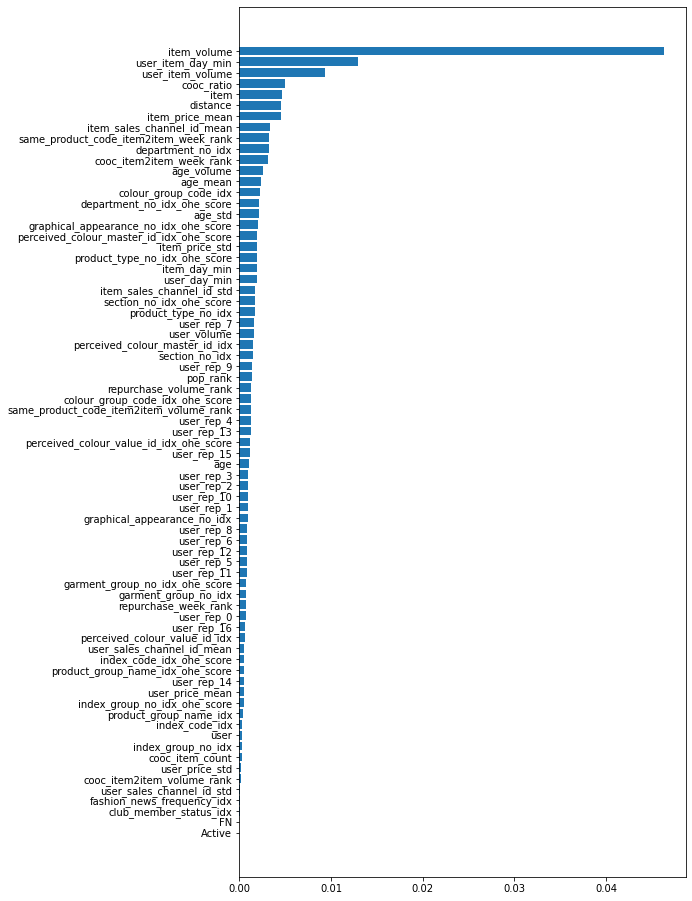

In [21]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

del train, train_dataset
gc.collect()
with open('output/model_for_submission.pkl', 'wb') as f:
    pickle.dump(model, f)

In [22]:
del datasets, dataset_valid_all, candidates, candidates_valid_all
gc.collect()

11990

In [23]:
all_users = users['user'].values
all_users

array([      0,       1,       2, ..., 1371977, 1371978, 1371979])

In [24]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    print(f"chunk: {i}")
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

chunk: 0
create candidates (week: 0)


[repurchase] 5.806 s


[popular] 1.012 s


[item2item] 5.779 s


[cooccurrence] 12.695 s


[same_product_code] 7.273 s


[ohe distance] 20.951 s


volume: 22245562


duplicates: 1.0381392310907682


            strategy   volume     ratio
0  same_product_code  9190204  0.413125
1                pop  4939128  0.222028
2                ohe  4275973  0.192217
3         repurchase  2735882  0.122986
4               cooc  1104375  0.049645


attach features (week: 0)


[user static fetaures] 2.083 s


[item stacic features] 5.837 s


[user dynamic features (transactions)] 4.100 s


[item dynamic features (transactions)] 3.189 s


[item dynamic features (user features)] 3.859 s


[item freshness features] 5.425 s


[item volume features] 3.572 s


[user freshness features] 7.388 s


[user volume features] 4.387 s


[user-item freshness features] 26.449 s


[user-item volume features] 7.700 s


[item age volume features] 6.385 s


[ohe dot products] 130.565 s


[lfm features] 14.797 s


chunk: 137198
create candidates (week: 0)


[repurchase] 5.867 s


[popular] 1.019 s


[item2item] 5.767 s


[cooccurrence] 12.855 s


[same_product_code] 7.083 s


[ohe distance] 12.761 s


volume: 22277777


duplicates: 1.0380449277871724


            strategy   volume     ratio
0  same_product_code  9210520  0.413440
1                pop  4939128  0.221707
2                ohe  4274077  0.191854
3         repurchase  2752227  0.123541
4               cooc  1101825  0.049458


attach features (week: 0)


[user static fetaures] 2.116 s


[item stacic features] 5.897 s


[user dynamic features (transactions)] 4.119 s


[item dynamic features (transactions)] 3.246 s


[item dynamic features (user features)] 3.911 s


[item freshness features] 5.467 s


[item volume features] 3.623 s


[user freshness features] 7.445 s


[user volume features] 4.442 s


[user-item freshness features] 26.374 s


[user-item volume features] 8.108 s


[item age volume features] 6.452 s


[ohe dot products] 130.431 s


[lfm features] 12.722 s


chunk: 274396
create candidates (week: 0)


[repurchase] 5.834 s


[popular] 1.102 s


[item2item] 5.764 s


[cooccurrence] 12.857 s


[same_product_code] 6.981 s


[ohe distance] 12.805 s


volume: 22184943


duplicates: 1.0380521366008064


            strategy   volume     ratio
0  same_product_code  9167920  0.413250
1                pop  4939128  0.222634
2                ohe  4275911  0.192739
3         repurchase  2708651  0.122094
4               cooc  1093333  0.049283


attach features (week: 0)


[user static fetaures] 2.082 s


[item stacic features] 5.837 s


[user dynamic features (transactions)] 4.109 s


[item dynamic features (transactions)] 3.188 s


[item dynamic features (user features)] 3.871 s


[item freshness features] 5.403 s


[item volume features] 3.589 s


[user freshness features] 7.397 s


[user volume features] 4.428 s


[user-item freshness features] 26.000 s


[user-item volume features] 7.649 s


[item age volume features] 6.369 s


[ohe dot products] 129.641 s


[lfm features] 13.043 s


chunk: 411594
create candidates (week: 0)


[repurchase] 5.907 s


[popular] 1.047 s


[item2item] 5.686 s


[cooccurrence] 12.843 s


[same_product_code] 7.304 s


[ohe distance] 12.818 s


volume: 22260490


duplicates: 1.0380991731297722


            strategy   volume     ratio
0  same_product_code  9204223  0.413478
1                pop  4939128  0.221879
2                ohe  4275076  0.192048
3         repurchase  2737078  0.122957
4               cooc  1104985  0.049639


attach features (week: 0)


[user static fetaures] 2.082 s


[item stacic features] 5.807 s


[user dynamic features (transactions)] 4.072 s


[item dynamic features (transactions)] 3.191 s


[item dynamic features (user features)] 3.848 s


[item freshness features] 5.388 s


[item volume features] 3.569 s


[user freshness features] 7.372 s


[user volume features] 4.381 s


[user-item freshness features] 26.047 s


[user-item volume features] 7.692 s


[item age volume features] 6.364 s


[ohe dot products] 129.395 s


[lfm features] 11.598 s


chunk: 548792
create candidates (week: 0)


[repurchase] 5.930 s


[popular] 1.046 s


[item2item] 5.714 s


[cooccurrence] 12.639 s


[same_product_code] 7.430 s


[ohe distance] 12.657 s


volume: 22250675


duplicates: 1.0381632151158697


            strategy   volume     ratio
0  same_product_code  9190841  0.413059
1                pop  4939128  0.221977
2                ohe  4276533  0.192198
3         repurchase  2739307  0.123111
4               cooc  1104866  0.049655


attach features (week: 0)


[user static fetaures] 2.095 s


[item stacic features] 5.877 s


[user dynamic features (transactions)] 4.106 s


[item dynamic features (transactions)] 3.208 s


[item dynamic features (user features)] 3.873 s


[item freshness features] 5.415 s


[item volume features] 3.598 s


[user freshness features] 7.415 s


[user volume features] 4.430 s


[user-item freshness features] 26.407 s


[user-item volume features] 7.683 s


[item age volume features] 6.430 s


[ohe dot products] 128.753 s


[lfm features] 10.935 s


chunk: 685990
create candidates (week: 0)


[repurchase] 5.935 s


[popular] 1.012 s


[item2item] 5.723 s


[cooccurrence] 12.707 s


[same_product_code] 7.203 s


[ohe distance] 12.707 s


volume: 22313213


duplicates: 1.0382393493656716


            strategy   volume     ratio
0  same_product_code  9243785  0.414274
1                pop  4939128  0.221354
2                ohe  4273560  0.191526
3         repurchase  2745003  0.123021
4               cooc  1111737  0.049824


attach features (week: 0)


[user static fetaures] 2.098 s


[item stacic features] 5.886 s


[user dynamic features (transactions)] 4.122 s


[item dynamic features (transactions)] 3.214 s


[item dynamic features (user features)] 3.876 s


[item freshness features] 5.412 s


[item volume features] 3.599 s


[user freshness features] 7.431 s


[user volume features] 4.461 s


[user-item freshness features] 26.114 s


[user-item volume features] 7.837 s


[item age volume features] 6.397 s


[ohe dot products] 130.230 s


[lfm features] 12.887 s


chunk: 823188
create candidates (week: 0)


[repurchase] 5.874 s


[popular] 1.108 s


[item2item] 5.760 s


[cooccurrence] 12.630 s


[same_product_code] 7.123 s


[ohe distance] 13.019 s


volume: 22204770


duplicates: 1.0384411949984076


            strategy   volume     ratio
0  same_product_code  9166138  0.412800
1                pop  4939128  0.222435
2                ohe  4275160  0.192533
3         repurchase  2714357  0.122242
4               cooc  1109987  0.049989


attach features (week: 0)


[user static fetaures] 2.081 s


[item stacic features] 5.829 s


[user dynamic features (transactions)] 4.144 s


[item dynamic features (transactions)] 3.213 s


[item dynamic features (user features)] 3.859 s


[item freshness features] 5.411 s


[item volume features] 3.601 s


[user freshness features] 7.410 s


[user volume features] 4.437 s


[user-item freshness features] 26.096 s


[user-item volume features] 7.631 s


[item age volume features] 6.397 s


[ohe dot products] 129.106 s


[lfm features] 13.467 s


chunk: 960386
create candidates (week: 0)


[repurchase] 5.877 s


[popular] 1.014 s


[item2item] 5.736 s


[cooccurrence] 12.878 s


[same_product_code] 7.385 s


[ohe distance] 12.687 s


volume: 22224321


duplicates: 1.0382621935765743


            strategy   volume     ratio
0  same_product_code  9175200  0.412845
1                pop  4939128  0.222240
2                ohe  4275309  0.192371
3         repurchase  2731902  0.122924
4               cooc  1102782  0.049621


attach features (week: 0)


[user static fetaures] 2.081 s


[item stacic features] 5.824 s


[user dynamic features (transactions)] 4.089 s


[item dynamic features (transactions)] 3.176 s


[item dynamic features (user features)] 3.840 s


[item freshness features] 5.392 s


[item volume features] 3.566 s


[user freshness features] 7.363 s


[user volume features] 4.416 s


[user-item freshness features] 26.082 s


[user-item volume features] 7.744 s


[item age volume features] 6.357 s


[ohe dot products] 128.847 s


[lfm features] 11.097 s


chunk: 1097584
create candidates (week: 0)


[repurchase] 5.875 s


[popular] 1.015 s


[item2item] 5.621 s


[cooccurrence] 12.761 s


[same_product_code] 7.075 s


[ohe distance] 12.522 s


volume: 22151799


duplicates: 1.0378601240280338


            strategy   volume     ratio
0  same_product_code  9136160  0.412434
1                pop  4939128  0.222967
2                ohe  4273226  0.192906
3         repurchase  2711285  0.122396
4               cooc  1092000  0.049296


attach features (week: 0)


[user static fetaures] 2.071 s


[item stacic features] 5.787 s


[user dynamic features (transactions)] 4.103 s


[item dynamic features (transactions)] 3.176 s


[item dynamic features (user features)] 3.844 s


[item freshness features] 5.394 s


[item volume features] 3.555 s


[user freshness features] 7.348 s


[user volume features] 4.440 s


[user-item freshness features] 26.138 s


[user-item volume features] 7.932 s


[item age volume features] 6.347 s


[ohe dot products] 128.835 s


[lfm features] 12.830 s


chunk: 1234782
create candidates (week: 0)


[repurchase] 5.813 s


[popular] 1.014 s


[item2item] 5.697 s


[cooccurrence] 12.591 s


[same_product_code] 7.125 s


[ohe distance] 12.389 s


volume: 22236776


duplicates: 1.0382287938103627


            strategy   volume     ratio
0  same_product_code  9189583  0.413261
1                pop  4939128  0.222115
2                ohe  4274701  0.192236
3         repurchase  2730747  0.122803
4               cooc  1102617  0.049585


attach features (week: 0)


[user static fetaures] 2.084 s


[item stacic features] 5.809 s


[user dynamic features (transactions)] 4.104 s


[item dynamic features (transactions)] 3.198 s


[item dynamic features (user features)] 3.857 s


[item freshness features] 5.484 s


[item volume features] 3.597 s


[user freshness features] 7.361 s


[user volume features] 4.383 s


[user-item freshness features] 25.926 s


[user-item volume features] 7.553 s


[item age volume features] 6.361 s


[ohe dot products] 129.437 s


[lfm features] 11.090 s


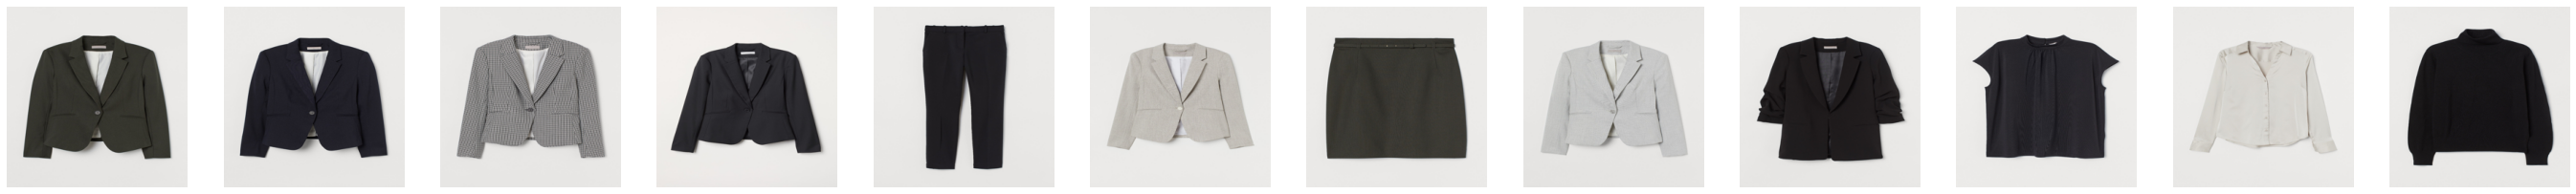

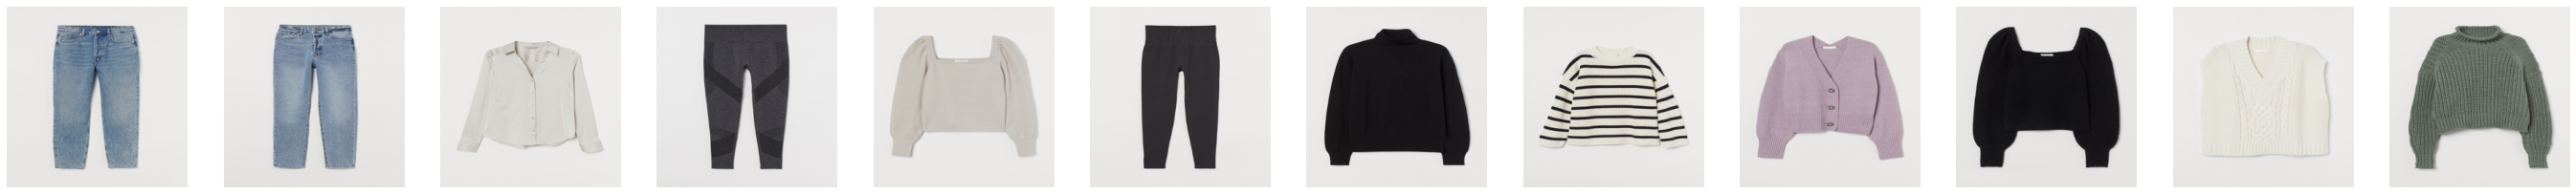

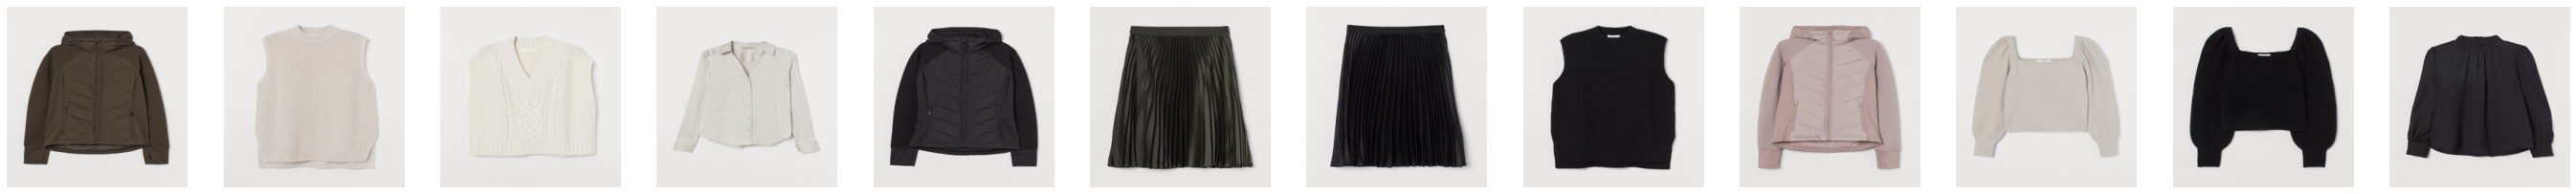

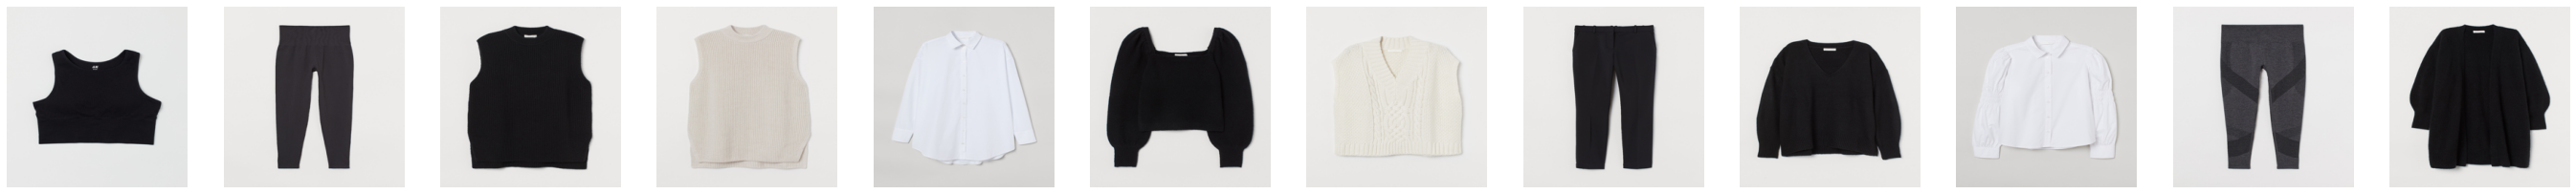

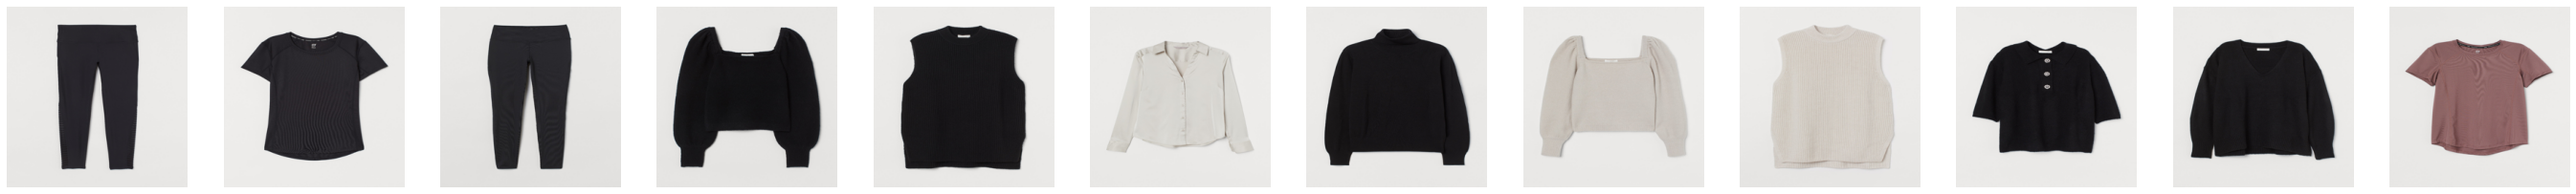

In [25]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [26]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601007 0568601044 0568601006 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0448509014 0714790020 0762846027 0918292001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0924243001 0918522001 0762846027 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0869331006 0866731001 0924243002 0924243001 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0791587001 0852584001 0915529003 09...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022 0791587001 0804992014 0611415001 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846027 0762846026 0762846006 0448509014 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846026 0762846027 0762846031 0762846006 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0448509014 0821395005 0714790028 08...


In [27]:
submission.to_csv('submission.csv', index=False)